In [251]:
import pandas as pd
import numpy as np
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
import xgboost as xgb
from sklearn.metrics import precision_score
import os
import gzip
import random
from matplotlib import pyplot
from sklearn.pipeline import make_pipeline

In [252]:
#Returns a string of length bytes long
def dataloader(filepath, length):
    f = gzip.GzipFile(fileobj=open(filepath, 'rb'))
    data = f.read(length)
    return data.decode("utf-8")

In [253]:
#Splits the data into num_chunks
def chunk(in_string,num_chunks):
    chunk_size = len(in_string)//num_chunks
    if len(in_string) % num_chunks: chunk_size += 1
    iterator = iter(in_string)
    for _ in range(num_chunks):
        accumulator = list()
        for _ in range(chunk_size):
            try: accumulator.append(next(iterator))
            except StopIteration: break
        yield ''.join(accumulator)

In [337]:
#Returns dataframe of # of files long. Analyze the first length bytes of each file
def trainloader(direclist, filetype, length):
    fileid = np.arange(len(filetype))
    dat = []
    filelabels = []
    c = -1
    for direc in direclist:
        c+=1
        filelabels.append(np.repeat(fileid[c],len(os.listdir(direc))-1))
        for file in os.listdir(direc):
            if file.endswith('.gz'):
                tempdat = dataloader(os.path.join(direc,file),length)
                dat = dat + [tempdat]
    filelabels = np.concatenate(filelabels)
    data = {'Data': dat,
        'Type': filelabels
    }
    df = pd.DataFrame(data, columns = ['Data', 'Type'])
    print(df.head())
    return(df)

In [295]:
def FeatureImportance(model, features, importance):
    for im in importance:
        feature_important = model.get_score(importance_type = im)
        keys = list(feature_important.keys())
        feature_chars = []
        keylist = []
        for key in keys:
            keylist.append(int(key.replace('f','')))
        for i in keylist:
            feature_chars.append(features[i])
        values = list(feature_important.values())
        fdata = pd.DataFrame(data=values, index=feature_chars, columns=["score"]).sort_values(by = "score", ascending=False)
        fdata.plot(kind='barh', title = im)    
        
    

In [342]:
def FileClassifier(Dataset, ngram_range, max_features, param, num_round):
    
    X = Dataset.iloc[:,0].values
    y = Dataset.iloc[:,1].values

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 42)
    char_vectorizer = TfidfVectorizer(analyzer = 'char',
        ngram_range = ngram_range, max_features = max_features)
    char_vectorizer.fit(X)
    #print(type(X_train))
    train_chars = char_vectorizer.transform(X_train)
    test_chars = char_vectorizer.transform(X_test)
    #print(type(test_chars.todense()))
    #xgbmodel = make_pipeline()
    
    
    dtrain = xgb.DMatrix(train_chars, label = y_train)
    #print(dtrain.columns)
    dtest = xgb.DMatrix(test_chars, label = y_test)
    
    model = xgb.train(param, dtrain, num_round)
    #print(model)
    #model = xgb.XGBClassifier(param)
    #model.fit(train_chars, y_train)
    #xgb.plot_importance(model)
    #pyplot.show()
    
    FeatureImportance(model, char_vectorizer.get_feature_names(), ['weight','cover','gain'])
    
    preds = model.predict(dtest)
    best_preds = np.asarray([np.argmax(line) for line in preds])
    print(precision_score(y_test, best_preds, average='macro'))
    print(np.asarray(y_test).reshape(1,-1).squeeze())
    print(best_preds)
    print(len(best_preds))
    
    
    return(model)

In [324]:
dirs = ['/Users/bf/Desktop/BNL2020/BioClassifierFiles/genomic.fna',
        '/Users/bf/Desktop/BNL2020/BioClassifierFiles/genomic.gbff',
        '/Users/bf/Desktop/BNL2020/BioClassifierFiles/genomic.gff',
       ]
filetype = ['fna', 'gbff', 'gff']

In [338]:
data_iterable = trainloader(dirs, filetype, 1000)

                                                Data  Type
0  >LR134324.1 Stenotrophomonas maltophilia strai...     0
1  >MH108098.1 Escherichia virus Qbeta isolate Qb...     0
2  >MK448741.1 Streptococcus phage Javan369, comp...     0
3  >CP033214.1 Clostridioides difficile strain 12...     0
4  >CP011487.1 Helicobacter pylori strain PNG84A,...     0


In [365]:
param = {
    'max_depth': 4,  # the maximum depth of each tree
    'eta': 0.2,  # the training step for each iteration
    'silent': 1,  # logging mode - quiet
    'objective': 'multi:softprob',  # error evaluation for multiclass training
    'num_class': 4}  # the number of classes that exist in this datset
num_round = 40 
ngram_range = (2,6)
max_features = 10000
Dataset = data_iterable

[10:54:23] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:480: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


1.0
[0 1 2 0 1 0 0 1 0 1 2 0 1 2 0 2 0 2 2 0 2 0 1 2 0 2 1 1 1 0 1 1 1 2 1 1 2
 1 2 1 1 2 1 1 0 0 0 1 1 1 2 2 0 2 1 1 2 0]
[0 1 2 0 1 0 0 1 0 1 2 0 1 2 0 2 0 2 2 0 2 0 1 2 0 2 1 1 1 0 1 1 1 2 1 1 2
 1 2 1 1 2 1 1 0 0 0 1 1 1 2 2 0 2 1 1 2 0]
58


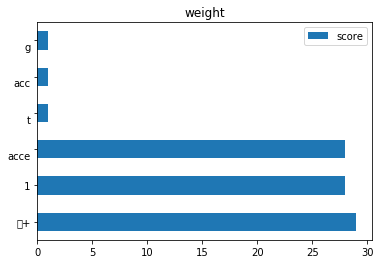

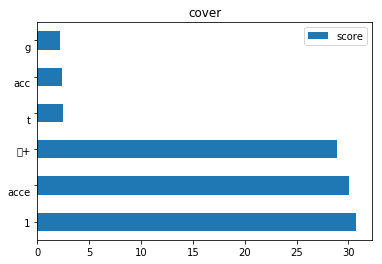

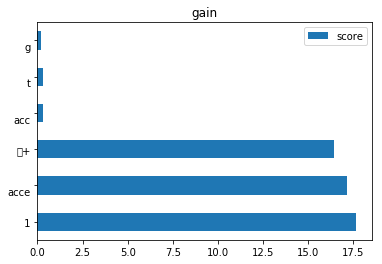

In [366]:
xgbmodel = FileClassifier(Dataset, ngram_range, max_features, param, num_round)

In [351]:
tdat = dataloader('/Users/bf/Desktop/BNL2020/BioClassifierFiles/GCA_902387845.1_UHGG_MGYG-HGUT-02512_genomic.fna.gz', 1000)
tdat2 = dataloader('/Users/bf/Desktop/BNL2020/BioClassifierFiles/genomic.fna/GCA_000894255.1_ViralProj81175_genomic.fna.gz',1000)

In [353]:
datat = {'Data': [tdat] + [tdat2],
         'Type': np.repeat(0,2)
    }
dft = pd.DataFrame(datat, columns = ['Data', 'Type'])

In [354]:
dft

,Data,Type
0,>LR699007.1 Morganella morganii isolate MGYG-H...,0
1,">JN116824.1 Rhodococcus phage REQ3, complete g...",0


In [355]:
X = df.iloc[:,0].values
y = df.iloc[:,1].values

In [356]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5)

In [357]:
char_vectorizer = TfidfVectorizer(analyzer = 'char',
    ngram_range = ngram_range, max_features = max_features)
char_vectorizer.fit(X)
tc = char_vectorizer.transform(X_train)

In [367]:
ttest = xgb.DMatrix(tc, y_train)

In [368]:
len(ttest.feature_names)

53855

In [369]:
bpred = np.asarray([np.argmax(line) for line in xgbmodel.predict(ttest)])

ValueError: feature_names mismatch: ['f0', 'f1', 'f2', 'f3', 'f4', 'f5', 'f6', 'f7', 'f8', 'f9', 'f10', 'f11', 'f12', 'f13', 'f14', 'f15', 'f16', 'f17', 'f18', 'f19', 'f20', 'f21', 'f22', 'f23', 'f24', 'f25', 'f26', 'f27', 'f28', 'f29', 'f30', 'f31', 'f32', 'f33', 'f34', 'f35', 'f36', 'f37', 'f38', 'f39', 'f40', 'f41', 'f42', 'f43', 'f44', 'f45', 'f46', 'f47', 'f48', 'f49', 'f50', 'f51', 'f52', 'f53', 'f54', 'f55', 'f56', 'f57', 'f58', 'f59', 'f60', 'f61', 'f62', 'f63', 'f64', 'f65', 'f66', 'f67', 'f68', 'f69', 'f70', 'f71', 'f72', 'f73', 'f74', 'f75', 'f76', 'f77', 'f78', 'f79', 'f80', 'f81', 'f82', 'f83', 'f84', 'f85', 'f86', 'f87', 'f88', 'f89', 'f90', 'f91', 'f92', 'f93', 'f94', 'f95', 'f96', 'f97', 'f98', 'f99', 'f100', 'f101', 'f102', 'f103', 'f104', 'f105', 'f106', 'f107', 'f108', 'f109', 'f110', 'f111', 'f112', 'f113', 'f114', 'f115', 'f116', 'f117', 'f118', 'f119', 'f120', 'f121', 'f122', 'f123', 'f124', 'f125', 'f126', 'f127', 'f128', 'f129', 'f130', 'f131', 'f132', 'f133', 'f134', 'f135', 'f136', 'f137', 'f138', 'f139', 'f140', 'f141', 'f142', 'f143', 'f144', 'f145', 'f146', 'f147', 'f148', 'f149', 'f150', 'f151', 'f152', 'f153', 'f154', 'f155', 'f156', 'f157', 'f158', 'f159', 'f160', 'f161', 'f162', 'f163', 'f164', 'f165', 'f166', 'f167', 'f168', 'f169', 'f170', 'f171', 'f172', 'f173', 'f174', 'f175', 'f176', 'f177', 'f178', 'f179', 'f180', 'f181', 'f182', 'f183', 'f184', 'f185', 'f186', 'f187', 'f188', 'f189', 'f190', 'f191', 'f192', 'f193', 'f194', 'f195', 'f196', 'f197', 'f198', 'f199', 'f200', 'f201', 'f202', 'f203', 'f204', 'f205', 'f206', 'f207', 'f208', 'f209', 'f210', 'f211', 'f212', 'f213', 'f214', 'f215', 'f216', 'f217', 'f218', 'f219', 'f220', 'f221', 'f222', 'f223', 'f224', 'f225', 'f226', 'f227', 'f228', 'f229', 'f230', 'f231', 'f232', 'f233', 'f234', 'f235', 'f236', 'f237', 'f238', 'f239', 'f240', 'f241', 'f242', 'f243', 'f244', 'f245', 'f246', 'f247', 'f248', 'f249', 'f250', 'f251', 'f252', 'f253', 'f254', 'f255', 'f256', 'f257', 'f258', 'f259', 'f260', 'f261', 'f262', 'f263', 'f264', 'f265', 'f266', 'f267', 'f268', 'f269', 'f270', 'f271', 'f272', 'f273', 'f274', 'f275', 'f276', 'f277', 'f278', 'f279', 'f280', 'f281', 'f282', 'f283', 'f284', 'f285', 'f286', 'f287', 'f288', 'f289', 'f290', 'f291', 'f292', 'f293', 'f294', 'f295', 'f296', 'f297', 'f298', 'f299', 'f300', 'f301', 'f302', 'f303', 'f304', 'f305', 'f306', 'f307', 'f308', 'f309', 'f310', 'f311', 'f312', 'f313', 'f314', 'f315', 'f316', 'f317', 'f318', 'f319', 'f320', 'f321', 'f322', 'f323', 'f324', 'f325', 'f326', 'f327', 'f328', 'f329', 'f330', 'f331', 'f332', 'f333', 'f334', 'f335', 'f336', 'f337', 'f338', 'f339', 'f340', 'f341', 'f342', 'f343', 'f344', 'f345', 'f346', 'f347', 'f348', 'f349', 'f350', 'f351', 'f352', 'f353', 'f354', 'f355', 'f356', 'f357', 'f358', 'f359', 'f360', 'f361', 'f362', 'f363', 'f364', 'f365', 'f366', 'f367', 'f368', 'f369', 'f370', 'f371', 'f372', 'f373', 'f374', 'f375', 'f376', 'f377', 'f378', 'f379', 'f380', 'f381', 'f382', 'f383', 'f384', 'f385', 'f386', 'f387', 'f388', 'f389', 'f390', 'f391', 'f392', 'f393', 'f394', 'f395', 'f396', 'f397', 'f398', 'f399', 'f400', 'f401', 'f402', 'f403', 'f404', 'f405', 'f406', 'f407', 'f408', 'f409', 'f410', 'f411', 'f412', 'f413', 'f414', 'f415', 'f416', 'f417', 'f418', 'f419', 'f420', 'f421', 'f422', 'f423', 'f424', 'f425', 'f426', 'f427', 'f428', 'f429', 'f430', 'f431', 'f432', 'f433', 'f434', 'f435', 'f436', 'f437', 'f438', 'f439', 'f440', 'f441', 'f442', 'f443', 'f444', 'f445', 'f446', 'f447', 'f448', 'f449', 'f450', 'f451', 'f452', 'f453', 'f454', 'f455', 'f456', 'f457', 'f458', 'f459', 'f460', 'f461', 'f462', 'f463', 'f464', 'f465', 'f466', 'f467', 'f468', 'f469', 'f470', 'f471', 'f472', 'f473', 'f474', 'f475', 'f476', 'f477', 'f478', 'f479', 'f480', 'f481', 'f482', 'f483', 'f484', 'f485', 'f486', 'f487', 'f488', 'f489', 'f490', 'f491', 'f492', 'f493', 'f494', 'f495', 'f496', 'f497', 'f498', 'f499', 'f500', 'f501', 'f502', 'f503', 'f504', 'f505', 'f506', 'f507', 'f508', 'f509', 'f510', 'f511', 'f512', 'f513', 'f514', 'f515', 'f516', 'f517', 'f518', 'f519', 'f520', 'f521', 'f522', 'f523', 'f524', 'f525', 'f526', 'f527', 'f528', 'f529', 'f530', 'f531', 'f532', 'f533', 'f534', 'f535', 'f536', 'f537', 'f538', 'f539', 'f540', 'f541', 'f542', 'f543', 'f544', 'f545', 'f546', 'f547', 'f548', 'f549', 'f550', 'f551', 'f552', 'f553', 'f554', 'f555', 'f556', 'f557', 'f558', 'f559', 'f560', 'f561', 'f562', 'f563', 'f564', 'f565', 'f566', 'f567', 'f568', 'f569', 'f570', 'f571', 'f572', 'f573', 'f574', 'f575', 'f576', 'f577', 'f578', 'f579', 'f580', 'f581', 'f582', 'f583', 'f584', 'f585', 'f586', 'f587', 'f588', 'f589', 'f590', 'f591', 'f592', 'f593', 'f594', 'f595', 'f596', 'f597', 'f598', 'f599', 'f600', 'f601', 'f602', 'f603', 'f604', 'f605', 'f606', 'f607', 'f608', 'f609', 'f610', 'f611', 'f612', 'f613', 'f614', 'f615', 'f616', 'f617', 'f618', 'f619', 'f620', 'f621', 'f622', 'f623', 'f624', 'f625', 'f626', 'f627', 'f628', 'f629', 'f630', 'f631', 'f632', 'f633', 'f634', 'f635', 'f636', 'f637', 'f638', 'f639', 'f640', 'f641', 'f642', 'f643', 'f644', 'f645', 'f646', 'f647', 'f648', 'f649', 'f650', 'f651', 'f652', 'f653', 'f654', 'f655', 'f656', 'f657', 'f658', 'f659', 'f660', 'f661', 'f662', 'f663', 'f664', 'f665', 'f666', 'f667', 'f668', 'f669', 'f670', 'f671', 'f672', 'f673', 'f674', 'f675', 'f676', 'f677', 'f678', 'f679', 'f680', 'f681', 'f682', 'f683', 'f684', 'f685', 'f686', 'f687', 'f688', 'f689', 'f690', 'f691', 'f692', 'f693', 'f694', 'f695', 'f696', 'f697', 'f698', 'f699', 'f700', 'f701', 'f702', 'f703', 'f704', 'f705', 'f706', 'f707', 'f708', 'f709', 'f710', 'f711', 'f712', 'f713', 'f714', 'f715', 'f716', 'f717', 'f718', 'f719', 'f720', 'f721', 'f722', 'f723', 'f724', 'f725', 'f726', 'f727', 'f728', 'f729', 'f730', 'f731', 'f732', 'f733', 'f734', 'f735', 'f736', 'f737', 'f738', 'f739', 'f740', 'f741', 'f742', 'f743', 'f744', 'f745', 'f746', 'f747', 'f748', 'f749', 'f750', 'f751', 'f752', 'f753', 'f754', 'f755', 'f756', 'f757', 'f758', 'f759', 'f760', 'f761', 'f762', 'f763', 'f764', 'f765', 'f766', 'f767', 'f768', 'f769', 'f770', 'f771', 'f772', 'f773', 'f774', 'f775', 'f776', 'f777', 'f778', 'f779', 'f780', 'f781', 'f782', 'f783', 'f784', 'f785', 'f786', 'f787', 'f788', 'f789', 'f790', 'f791', 'f792', 'f793', 'f794', 'f795', 'f796', 'f797', 'f798', 'f799', 'f800', 'f801', 'f802', 'f803', 'f804', 'f805', 'f806', 'f807', 'f808', 'f809', 'f810', 'f811', 'f812', 'f813', 'f814', 'f815', 'f816', 'f817', 'f818', 'f819', 'f820', 'f821', 'f822', 'f823', 'f824', 'f825', 'f826', 'f827', 'f828', 'f829', 'f830', 'f831', 'f832', 'f833', 'f834', 'f835', 'f836', 'f837', 'f838', 'f839', 'f840', 'f841', 'f842', 'f843', 'f844', 'f845', 'f846', 'f847', 'f848', 'f849', 'f850', 'f851', 'f852', 'f853', 'f854', 'f855', 'f856', 'f857', 'f858', 'f859', 'f860', 'f861', 'f862', 'f863', 'f864', 'f865', 'f866', 'f867', 'f868', 'f869', 'f870', 'f871', 'f872', 'f873', 'f874', 'f875', 'f876', 'f877', 'f878', 'f879', 'f880', 'f881', 'f882', 'f883', 'f884', 'f885', 'f886', 'f887', 'f888', 'f889', 'f890', 'f891', 'f892', 'f893', 'f894', 'f895', 'f896', 'f897', 'f898', 'f899', 'f900', 'f901', 'f902', 'f903', 'f904', 'f905', 'f906', 'f907', 'f908', 'f909', 'f910', 'f911', 'f912', 'f913', 'f914', 'f915', 'f916', 'f917', 'f918', 'f919', 'f920', 'f921', 'f922', 'f923', 'f924', 'f925', 'f926', 'f927', 'f928', 'f929', 'f930', 'f931', 'f932', 'f933', 'f934', 'f935', 'f936', 'f937', 'f938', 'f939', 'f940', 'f941', 'f942', 'f943', 'f944', 'f945', 'f946', 'f947', 'f948', 'f949', 'f950', 'f951', 'f952', 'f953', 'f954', 'f955', 'f956', 'f957', 'f958', 'f959', 'f960', 'f961', 'f962', 'f963', 'f964', 'f965', 'f966', 'f967', 'f968', 'f969', 'f970', 'f971', 'f972', 'f973', 'f974', 'f975', 'f976', 'f977', 'f978', 'f979', 'f980', 'f981', 'f982', 'f983', 'f984', 'f985', 'f986', 'f987', 'f988', 'f989', 'f990', 'f991', 'f992', 'f993', 'f994', 'f995', 'f996', 'f997', 'f998', 'f999', 'f1000', 'f1001', 'f1002', 'f1003', 'f1004', 'f1005', 'f1006', 'f1007', 'f1008', 'f1009', 'f1010', 'f1011', 'f1012', 'f1013', 'f1014', 'f1015', 'f1016', 'f1017', 'f1018', 'f1019', 'f1020', 'f1021', 'f1022', 'f1023', 'f1024', 'f1025', 'f1026', 'f1027', 'f1028', 'f1029', 'f1030', 'f1031', 'f1032', 'f1033', 'f1034', 'f1035', 'f1036', 'f1037', 'f1038', 'f1039', 'f1040', 'f1041', 'f1042', 'f1043', 'f1044', 'f1045', 'f1046', 'f1047', 'f1048', 'f1049', 'f1050', 'f1051', 'f1052', 'f1053', 'f1054', 'f1055', 'f1056', 'f1057', 'f1058', 'f1059', 'f1060', 'f1061', 'f1062', 'f1063', 'f1064', 'f1065', 'f1066', 'f1067', 'f1068', 'f1069', 'f1070', 'f1071', 'f1072', 'f1073', 'f1074', 'f1075', 'f1076', 'f1077', 'f1078', 'f1079', 'f1080', 'f1081', 'f1082', 'f1083', 'f1084', 'f1085', 'f1086', 'f1087', 'f1088', 'f1089', 'f1090', 'f1091', 'f1092', 'f1093', 'f1094', 'f1095', 'f1096', 'f1097', 'f1098', 'f1099', 'f1100', 'f1101', 'f1102', 'f1103', 'f1104', 'f1105', 'f1106', 'f1107', 'f1108', 'f1109', 'f1110', 'f1111', 'f1112', 'f1113', 'f1114', 'f1115', 'f1116', 'f1117', 'f1118', 'f1119', 'f1120', 'f1121', 'f1122', 'f1123', 'f1124', 'f1125', 'f1126', 'f1127', 'f1128', 'f1129', 'f1130', 'f1131', 'f1132', 'f1133', 'f1134', 'f1135', 'f1136', 'f1137', 'f1138', 'f1139', 'f1140', 'f1141', 'f1142', 'f1143', 'f1144', 'f1145', 'f1146', 'f1147', 'f1148', 'f1149', 'f1150', 'f1151', 'f1152', 'f1153', 'f1154', 'f1155', 'f1156', 'f1157', 'f1158', 'f1159', 'f1160', 'f1161', 'f1162', 'f1163', 'f1164', 'f1165', 'f1166', 'f1167', 'f1168', 'f1169', 'f1170', 'f1171', 'f1172', 'f1173', 'f1174', 'f1175', 'f1176', 'f1177', 'f1178', 'f1179', 'f1180', 'f1181', 'f1182', 'f1183', 'f1184', 'f1185', 'f1186', 'f1187', 'f1188', 'f1189', 'f1190', 'f1191', 'f1192', 'f1193', 'f1194', 'f1195', 'f1196', 'f1197', 'f1198', 'f1199', 'f1200', 'f1201', 'f1202', 'f1203', 'f1204', 'f1205', 'f1206', 'f1207', 'f1208', 'f1209', 'f1210', 'f1211', 'f1212', 'f1213', 'f1214', 'f1215', 'f1216', 'f1217', 'f1218', 'f1219', 'f1220', 'f1221', 'f1222', 'f1223', 'f1224', 'f1225', 'f1226', 'f1227', 'f1228', 'f1229', 'f1230', 'f1231', 'f1232', 'f1233', 'f1234', 'f1235', 'f1236', 'f1237', 'f1238', 'f1239', 'f1240', 'f1241', 'f1242', 'f1243', 'f1244', 'f1245', 'f1246', 'f1247', 'f1248', 'f1249', 'f1250', 'f1251', 'f1252', 'f1253', 'f1254', 'f1255', 'f1256', 'f1257', 'f1258', 'f1259', 'f1260', 'f1261', 'f1262', 'f1263', 'f1264', 'f1265', 'f1266', 'f1267', 'f1268', 'f1269', 'f1270', 'f1271', 'f1272', 'f1273', 'f1274', 'f1275', 'f1276', 'f1277', 'f1278', 'f1279', 'f1280', 'f1281', 'f1282', 'f1283', 'f1284', 'f1285', 'f1286', 'f1287', 'f1288', 'f1289', 'f1290', 'f1291', 'f1292', 'f1293', 'f1294', 'f1295', 'f1296', 'f1297', 'f1298', 'f1299', 'f1300', 'f1301', 'f1302', 'f1303', 'f1304', 'f1305', 'f1306', 'f1307', 'f1308', 'f1309', 'f1310', 'f1311', 'f1312', 'f1313', 'f1314', 'f1315', 'f1316', 'f1317', 'f1318', 'f1319', 'f1320', 'f1321', 'f1322', 'f1323', 'f1324', 'f1325', 'f1326', 'f1327', 'f1328', 'f1329', 'f1330', 'f1331', 'f1332', 'f1333', 'f1334', 'f1335', 'f1336', 'f1337', 'f1338', 'f1339', 'f1340', 'f1341', 'f1342', 'f1343', 'f1344', 'f1345', 'f1346', 'f1347', 'f1348', 'f1349', 'f1350', 'f1351', 'f1352', 'f1353', 'f1354', 'f1355', 'f1356', 'f1357', 'f1358', 'f1359', 'f1360', 'f1361', 'f1362', 'f1363', 'f1364', 'f1365', 'f1366', 'f1367', 'f1368', 'f1369', 'f1370', 'f1371', 'f1372', 'f1373', 'f1374', 'f1375', 'f1376', 'f1377', 'f1378', 'f1379', 'f1380', 'f1381', 'f1382', 'f1383', 'f1384', 'f1385', 'f1386', 'f1387', 'f1388', 'f1389', 'f1390', 'f1391', 'f1392', 'f1393', 'f1394', 'f1395', 'f1396', 'f1397', 'f1398', 'f1399', 'f1400', 'f1401', 'f1402', 'f1403', 'f1404', 'f1405', 'f1406', 'f1407', 'f1408', 'f1409', 'f1410', 'f1411', 'f1412', 'f1413', 'f1414', 'f1415', 'f1416', 'f1417', 'f1418', 'f1419', 'f1420', 'f1421', 'f1422', 'f1423', 'f1424', 'f1425', 'f1426', 'f1427', 'f1428', 'f1429', 'f1430', 'f1431', 'f1432', 'f1433', 'f1434', 'f1435', 'f1436', 'f1437', 'f1438', 'f1439', 'f1440', 'f1441', 'f1442', 'f1443', 'f1444', 'f1445', 'f1446', 'f1447', 'f1448', 'f1449', 'f1450', 'f1451', 'f1452', 'f1453', 'f1454', 'f1455', 'f1456', 'f1457', 'f1458', 'f1459', 'f1460', 'f1461', 'f1462', 'f1463', 'f1464', 'f1465', 'f1466', 'f1467', 'f1468', 'f1469', 'f1470', 'f1471', 'f1472', 'f1473', 'f1474', 'f1475', 'f1476', 'f1477', 'f1478', 'f1479', 'f1480', 'f1481', 'f1482', 'f1483', 'f1484', 'f1485', 'f1486', 'f1487', 'f1488', 'f1489', 'f1490', 'f1491', 'f1492', 'f1493', 'f1494', 'f1495', 'f1496', 'f1497', 'f1498', 'f1499', 'f1500', 'f1501', 'f1502', 'f1503', 'f1504', 'f1505', 'f1506', 'f1507', 'f1508', 'f1509', 'f1510', 'f1511', 'f1512', 'f1513', 'f1514', 'f1515', 'f1516', 'f1517', 'f1518', 'f1519', 'f1520', 'f1521', 'f1522', 'f1523', 'f1524', 'f1525', 'f1526', 'f1527', 'f1528', 'f1529', 'f1530', 'f1531', 'f1532', 'f1533', 'f1534', 'f1535', 'f1536', 'f1537', 'f1538', 'f1539', 'f1540', 'f1541', 'f1542', 'f1543', 'f1544', 'f1545', 'f1546', 'f1547', 'f1548', 'f1549', 'f1550', 'f1551', 'f1552', 'f1553', 'f1554', 'f1555', 'f1556', 'f1557', 'f1558', 'f1559', 'f1560', 'f1561', 'f1562', 'f1563', 'f1564', 'f1565', 'f1566', 'f1567', 'f1568', 'f1569', 'f1570', 'f1571', 'f1572', 'f1573', 'f1574', 'f1575', 'f1576', 'f1577', 'f1578', 'f1579', 'f1580', 'f1581', 'f1582', 'f1583', 'f1584', 'f1585', 'f1586', 'f1587', 'f1588', 'f1589', 'f1590', 'f1591', 'f1592', 'f1593', 'f1594', 'f1595', 'f1596', 'f1597', 'f1598', 'f1599', 'f1600', 'f1601', 'f1602', 'f1603', 'f1604', 'f1605', 'f1606', 'f1607', 'f1608', 'f1609', 'f1610', 'f1611', 'f1612', 'f1613', 'f1614', 'f1615', 'f1616', 'f1617', 'f1618', 'f1619', 'f1620', 'f1621', 'f1622', 'f1623', 'f1624', 'f1625', 'f1626', 'f1627', 'f1628', 'f1629', 'f1630', 'f1631', 'f1632', 'f1633', 'f1634', 'f1635', 'f1636', 'f1637', 'f1638', 'f1639', 'f1640', 'f1641', 'f1642', 'f1643', 'f1644', 'f1645', 'f1646', 'f1647', 'f1648', 'f1649', 'f1650', 'f1651', 'f1652', 'f1653', 'f1654', 'f1655', 'f1656', 'f1657', 'f1658', 'f1659', 'f1660', 'f1661', 'f1662', 'f1663', 'f1664', 'f1665', 'f1666', 'f1667', 'f1668', 'f1669', 'f1670', 'f1671', 'f1672', 'f1673', 'f1674', 'f1675', 'f1676', 'f1677', 'f1678', 'f1679', 'f1680', 'f1681', 'f1682', 'f1683', 'f1684', 'f1685', 'f1686', 'f1687', 'f1688', 'f1689', 'f1690', 'f1691', 'f1692', 'f1693', 'f1694', 'f1695', 'f1696', 'f1697', 'f1698', 'f1699', 'f1700', 'f1701', 'f1702', 'f1703', 'f1704', 'f1705', 'f1706', 'f1707', 'f1708', 'f1709', 'f1710', 'f1711', 'f1712', 'f1713', 'f1714', 'f1715', 'f1716', 'f1717', 'f1718', 'f1719', 'f1720', 'f1721', 'f1722', 'f1723', 'f1724', 'f1725', 'f1726', 'f1727', 'f1728', 'f1729', 'f1730', 'f1731', 'f1732', 'f1733', 'f1734', 'f1735', 'f1736', 'f1737', 'f1738', 'f1739', 'f1740', 'f1741', 'f1742', 'f1743', 'f1744', 'f1745', 'f1746', 'f1747', 'f1748', 'f1749', 'f1750', 'f1751', 'f1752', 'f1753', 'f1754', 'f1755', 'f1756', 'f1757', 'f1758', 'f1759', 'f1760', 'f1761', 'f1762', 'f1763', 'f1764', 'f1765', 'f1766', 'f1767', 'f1768', 'f1769', 'f1770', 'f1771', 'f1772', 'f1773', 'f1774', 'f1775', 'f1776', 'f1777', 'f1778', 'f1779', 'f1780', 'f1781', 'f1782', 'f1783', 'f1784', 'f1785', 'f1786', 'f1787', 'f1788', 'f1789', 'f1790', 'f1791', 'f1792', 'f1793', 'f1794', 'f1795', 'f1796', 'f1797', 'f1798', 'f1799', 'f1800', 'f1801', 'f1802', 'f1803', 'f1804', 'f1805', 'f1806', 'f1807', 'f1808', 'f1809', 'f1810', 'f1811', 'f1812', 'f1813', 'f1814', 'f1815', 'f1816', 'f1817', 'f1818', 'f1819', 'f1820', 'f1821', 'f1822', 'f1823', 'f1824', 'f1825', 'f1826', 'f1827', 'f1828', 'f1829', 'f1830', 'f1831', 'f1832', 'f1833', 'f1834', 'f1835', 'f1836', 'f1837', 'f1838', 'f1839', 'f1840', 'f1841', 'f1842', 'f1843', 'f1844', 'f1845', 'f1846', 'f1847', 'f1848', 'f1849', 'f1850', 'f1851', 'f1852', 'f1853', 'f1854', 'f1855', 'f1856', 'f1857', 'f1858', 'f1859', 'f1860', 'f1861', 'f1862', 'f1863', 'f1864', 'f1865', 'f1866', 'f1867', 'f1868', 'f1869', 'f1870', 'f1871', 'f1872', 'f1873', 'f1874', 'f1875', 'f1876', 'f1877', 'f1878', 'f1879', 'f1880', 'f1881', 'f1882', 'f1883', 'f1884', 'f1885', 'f1886', 'f1887', 'f1888', 'f1889', 'f1890', 'f1891', 'f1892', 'f1893', 'f1894', 'f1895', 'f1896', 'f1897', 'f1898', 'f1899', 'f1900', 'f1901', 'f1902', 'f1903', 'f1904', 'f1905', 'f1906', 'f1907', 'f1908', 'f1909', 'f1910', 'f1911', 'f1912', 'f1913', 'f1914', 'f1915', 'f1916', 'f1917', 'f1918', 'f1919', 'f1920', 'f1921', 'f1922', 'f1923', 'f1924', 'f1925', 'f1926', 'f1927', 'f1928', 'f1929', 'f1930', 'f1931', 'f1932', 'f1933', 'f1934', 'f1935', 'f1936', 'f1937', 'f1938', 'f1939', 'f1940', 'f1941', 'f1942', 'f1943', 'f1944', 'f1945', 'f1946', 'f1947', 'f1948', 'f1949', 'f1950', 'f1951', 'f1952', 'f1953', 'f1954', 'f1955', 'f1956', 'f1957', 'f1958', 'f1959', 'f1960', 'f1961', 'f1962', 'f1963', 'f1964', 'f1965', 'f1966', 'f1967', 'f1968', 'f1969', 'f1970', 'f1971', 'f1972', 'f1973', 'f1974', 'f1975', 'f1976', 'f1977', 'f1978', 'f1979', 'f1980', 'f1981', 'f1982', 'f1983', 'f1984', 'f1985', 'f1986', 'f1987', 'f1988', 'f1989', 'f1990', 'f1991', 'f1992', 'f1993', 'f1994', 'f1995', 'f1996', 'f1997', 'f1998', 'f1999', 'f2000', 'f2001', 'f2002', 'f2003', 'f2004', 'f2005', 'f2006', 'f2007', 'f2008', 'f2009', 'f2010', 'f2011', 'f2012', 'f2013', 'f2014', 'f2015', 'f2016', 'f2017', 'f2018', 'f2019', 'f2020', 'f2021', 'f2022', 'f2023', 'f2024', 'f2025', 'f2026', 'f2027', 'f2028', 'f2029', 'f2030', 'f2031', 'f2032', 'f2033', 'f2034', 'f2035', 'f2036', 'f2037', 'f2038', 'f2039', 'f2040', 'f2041', 'f2042', 'f2043', 'f2044', 'f2045', 'f2046', 'f2047', 'f2048', 'f2049', 'f2050', 'f2051', 'f2052', 'f2053', 'f2054', 'f2055', 'f2056', 'f2057', 'f2058', 'f2059', 'f2060', 'f2061', 'f2062', 'f2063', 'f2064', 'f2065', 'f2066', 'f2067', 'f2068', 'f2069', 'f2070', 'f2071', 'f2072', 'f2073', 'f2074', 'f2075', 'f2076', 'f2077', 'f2078', 'f2079', 'f2080', 'f2081', 'f2082', 'f2083', 'f2084', 'f2085', 'f2086', 'f2087', 'f2088', 'f2089', 'f2090', 'f2091', 'f2092', 'f2093', 'f2094', 'f2095', 'f2096', 'f2097', 'f2098', 'f2099', 'f2100', 'f2101', 'f2102', 'f2103', 'f2104', 'f2105', 'f2106', 'f2107', 'f2108', 'f2109', 'f2110', 'f2111', 'f2112', 'f2113', 'f2114', 'f2115', 'f2116', 'f2117', 'f2118', 'f2119', 'f2120', 'f2121', 'f2122', 'f2123', 'f2124', 'f2125', 'f2126', 'f2127', 'f2128', 'f2129', 'f2130', 'f2131', 'f2132', 'f2133', 'f2134', 'f2135', 'f2136', 'f2137', 'f2138', 'f2139', 'f2140', 'f2141', 'f2142', 'f2143', 'f2144', 'f2145', 'f2146', 'f2147', 'f2148', 'f2149', 'f2150', 'f2151', 'f2152', 'f2153', 'f2154', 'f2155', 'f2156', 'f2157', 'f2158', 'f2159', 'f2160', 'f2161', 'f2162', 'f2163', 'f2164', 'f2165', 'f2166', 'f2167', 'f2168', 'f2169', 'f2170', 'f2171', 'f2172', 'f2173', 'f2174', 'f2175', 'f2176', 'f2177', 'f2178', 'f2179', 'f2180', 'f2181', 'f2182', 'f2183', 'f2184', 'f2185', 'f2186', 'f2187', 'f2188', 'f2189', 'f2190', 'f2191', 'f2192', 'f2193', 'f2194', 'f2195', 'f2196', 'f2197', 'f2198', 'f2199', 'f2200', 'f2201', 'f2202', 'f2203', 'f2204', 'f2205', 'f2206', 'f2207', 'f2208', 'f2209', 'f2210', 'f2211', 'f2212', 'f2213', 'f2214', 'f2215', 'f2216', 'f2217', 'f2218', 'f2219', 'f2220', 'f2221', 'f2222', 'f2223', 'f2224', 'f2225', 'f2226', 'f2227', 'f2228', 'f2229', 'f2230', 'f2231', 'f2232', 'f2233', 'f2234', 'f2235', 'f2236', 'f2237', 'f2238', 'f2239', 'f2240', 'f2241', 'f2242', 'f2243', 'f2244', 'f2245', 'f2246', 'f2247', 'f2248', 'f2249', 'f2250', 'f2251', 'f2252', 'f2253', 'f2254', 'f2255', 'f2256', 'f2257', 'f2258', 'f2259', 'f2260', 'f2261', 'f2262', 'f2263', 'f2264', 'f2265', 'f2266', 'f2267', 'f2268', 'f2269', 'f2270', 'f2271', 'f2272', 'f2273', 'f2274', 'f2275', 'f2276', 'f2277', 'f2278', 'f2279', 'f2280', 'f2281', 'f2282', 'f2283', 'f2284', 'f2285', 'f2286', 'f2287', 'f2288', 'f2289', 'f2290', 'f2291', 'f2292', 'f2293', 'f2294', 'f2295', 'f2296', 'f2297', 'f2298', 'f2299', 'f2300', 'f2301', 'f2302', 'f2303', 'f2304', 'f2305', 'f2306', 'f2307', 'f2308', 'f2309', 'f2310', 'f2311', 'f2312', 'f2313', 'f2314', 'f2315', 'f2316', 'f2317', 'f2318', 'f2319', 'f2320', 'f2321', 'f2322', 'f2323', 'f2324', 'f2325', 'f2326', 'f2327', 'f2328', 'f2329', 'f2330', 'f2331', 'f2332', 'f2333', 'f2334', 'f2335', 'f2336', 'f2337', 'f2338', 'f2339', 'f2340', 'f2341', 'f2342', 'f2343', 'f2344', 'f2345', 'f2346', 'f2347', 'f2348', 'f2349', 'f2350', 'f2351', 'f2352', 'f2353', 'f2354', 'f2355', 'f2356', 'f2357', 'f2358', 'f2359', 'f2360', 'f2361', 'f2362', 'f2363', 'f2364', 'f2365', 'f2366', 'f2367', 'f2368', 'f2369', 'f2370', 'f2371', 'f2372', 'f2373', 'f2374', 'f2375', 'f2376', 'f2377', 'f2378', 'f2379', 'f2380', 'f2381', 'f2382', 'f2383', 'f2384', 'f2385', 'f2386', 'f2387', 'f2388', 'f2389', 'f2390', 'f2391', 'f2392', 'f2393', 'f2394', 'f2395', 'f2396', 'f2397', 'f2398', 'f2399', 'f2400', 'f2401', 'f2402', 'f2403', 'f2404', 'f2405', 'f2406', 'f2407', 'f2408', 'f2409', 'f2410', 'f2411', 'f2412', 'f2413', 'f2414', 'f2415', 'f2416', 'f2417', 'f2418', 'f2419', 'f2420', 'f2421', 'f2422', 'f2423', 'f2424', 'f2425', 'f2426', 'f2427', 'f2428', 'f2429', 'f2430', 'f2431', 'f2432', 'f2433', 'f2434', 'f2435', 'f2436', 'f2437', 'f2438', 'f2439', 'f2440', 'f2441', 'f2442', 'f2443', 'f2444', 'f2445', 'f2446', 'f2447', 'f2448', 'f2449', 'f2450', 'f2451', 'f2452', 'f2453', 'f2454', 'f2455', 'f2456', 'f2457', 'f2458', 'f2459', 'f2460', 'f2461', 'f2462', 'f2463', 'f2464', 'f2465', 'f2466', 'f2467', 'f2468', 'f2469', 'f2470', 'f2471', 'f2472', 'f2473', 'f2474', 'f2475', 'f2476', 'f2477', 'f2478', 'f2479', 'f2480', 'f2481', 'f2482', 'f2483', 'f2484', 'f2485', 'f2486', 'f2487', 'f2488', 'f2489', 'f2490', 'f2491', 'f2492', 'f2493', 'f2494', 'f2495', 'f2496', 'f2497', 'f2498', 'f2499', 'f2500', 'f2501', 'f2502', 'f2503', 'f2504', 'f2505', 'f2506', 'f2507', 'f2508', 'f2509', 'f2510', 'f2511', 'f2512', 'f2513', 'f2514', 'f2515', 'f2516', 'f2517', 'f2518', 'f2519', 'f2520', 'f2521', 'f2522', 'f2523', 'f2524', 'f2525', 'f2526', 'f2527', 'f2528', 'f2529', 'f2530', 'f2531', 'f2532', 'f2533', 'f2534', 'f2535', 'f2536', 'f2537', 'f2538', 'f2539', 'f2540', 'f2541', 'f2542', 'f2543', 'f2544', 'f2545', 'f2546', 'f2547', 'f2548', 'f2549', 'f2550', 'f2551', 'f2552', 'f2553', 'f2554', 'f2555', 'f2556', 'f2557', 'f2558', 'f2559', 'f2560', 'f2561', 'f2562', 'f2563', 'f2564', 'f2565', 'f2566', 'f2567', 'f2568', 'f2569', 'f2570', 'f2571', 'f2572', 'f2573', 'f2574', 'f2575', 'f2576', 'f2577', 'f2578', 'f2579', 'f2580', 'f2581', 'f2582', 'f2583', 'f2584', 'f2585', 'f2586', 'f2587', 'f2588', 'f2589', 'f2590', 'f2591', 'f2592', 'f2593', 'f2594', 'f2595', 'f2596', 'f2597', 'f2598', 'f2599', 'f2600', 'f2601', 'f2602', 'f2603', 'f2604', 'f2605', 'f2606', 'f2607', 'f2608', 'f2609', 'f2610', 'f2611', 'f2612', 'f2613', 'f2614', 'f2615', 'f2616', 'f2617', 'f2618', 'f2619', 'f2620', 'f2621', 'f2622', 'f2623', 'f2624', 'f2625', 'f2626', 'f2627', 'f2628', 'f2629', 'f2630', 'f2631', 'f2632', 'f2633', 'f2634', 'f2635', 'f2636', 'f2637', 'f2638', 'f2639', 'f2640', 'f2641', 'f2642', 'f2643', 'f2644', 'f2645', 'f2646', 'f2647', 'f2648', 'f2649', 'f2650', 'f2651', 'f2652', 'f2653', 'f2654', 'f2655', 'f2656', 'f2657', 'f2658', 'f2659', 'f2660', 'f2661', 'f2662', 'f2663', 'f2664', 'f2665', 'f2666', 'f2667', 'f2668', 'f2669', 'f2670', 'f2671', 'f2672', 'f2673', 'f2674', 'f2675', 'f2676', 'f2677', 'f2678', 'f2679', 'f2680', 'f2681', 'f2682', 'f2683', 'f2684', 'f2685', 'f2686', 'f2687', 'f2688', 'f2689', 'f2690', 'f2691', 'f2692', 'f2693', 'f2694', 'f2695', 'f2696', 'f2697', 'f2698', 'f2699', 'f2700', 'f2701', 'f2702', 'f2703', 'f2704', 'f2705', 'f2706', 'f2707', 'f2708', 'f2709', 'f2710', 'f2711', 'f2712', 'f2713', 'f2714', 'f2715', 'f2716', 'f2717', 'f2718', 'f2719', 'f2720', 'f2721', 'f2722', 'f2723', 'f2724', 'f2725', 'f2726', 'f2727', 'f2728', 'f2729', 'f2730', 'f2731', 'f2732', 'f2733', 'f2734', 'f2735', 'f2736', 'f2737', 'f2738', 'f2739', 'f2740', 'f2741', 'f2742', 'f2743', 'f2744', 'f2745', 'f2746', 'f2747', 'f2748', 'f2749', 'f2750', 'f2751', 'f2752', 'f2753', 'f2754', 'f2755', 'f2756', 'f2757', 'f2758', 'f2759', 'f2760', 'f2761', 'f2762', 'f2763', 'f2764', 'f2765', 'f2766', 'f2767', 'f2768', 'f2769', 'f2770', 'f2771', 'f2772', 'f2773', 'f2774', 'f2775', 'f2776', 'f2777', 'f2778', 'f2779', 'f2780', 'f2781', 'f2782', 'f2783', 'f2784', 'f2785', 'f2786', 'f2787', 'f2788', 'f2789', 'f2790', 'f2791', 'f2792', 'f2793', 'f2794', 'f2795', 'f2796', 'f2797', 'f2798', 'f2799', 'f2800', 'f2801', 'f2802', 'f2803', 'f2804', 'f2805', 'f2806', 'f2807', 'f2808', 'f2809', 'f2810', 'f2811', 'f2812', 'f2813', 'f2814', 'f2815', 'f2816', 'f2817', 'f2818', 'f2819', 'f2820', 'f2821', 'f2822', 'f2823', 'f2824', 'f2825', 'f2826', 'f2827', 'f2828', 'f2829', 'f2830', 'f2831', 'f2832', 'f2833', 'f2834', 'f2835', 'f2836', 'f2837', 'f2838', 'f2839', 'f2840', 'f2841', 'f2842', 'f2843', 'f2844', 'f2845', 'f2846', 'f2847', 'f2848', 'f2849', 'f2850', 'f2851', 'f2852', 'f2853', 'f2854', 'f2855', 'f2856', 'f2857', 'f2858', 'f2859', 'f2860', 'f2861', 'f2862', 'f2863', 'f2864', 'f2865', 'f2866', 'f2867', 'f2868', 'f2869', 'f2870', 'f2871', 'f2872', 'f2873', 'f2874', 'f2875', 'f2876', 'f2877', 'f2878', 'f2879', 'f2880', 'f2881', 'f2882', 'f2883', 'f2884', 'f2885', 'f2886', 'f2887', 'f2888', 'f2889', 'f2890', 'f2891', 'f2892', 'f2893', 'f2894', 'f2895', 'f2896', 'f2897', 'f2898', 'f2899', 'f2900', 'f2901', 'f2902', 'f2903', 'f2904', 'f2905', 'f2906', 'f2907', 'f2908', 'f2909', 'f2910', 'f2911', 'f2912', 'f2913', 'f2914', 'f2915', 'f2916', 'f2917', 'f2918', 'f2919', 'f2920', 'f2921', 'f2922', 'f2923', 'f2924', 'f2925', 'f2926', 'f2927', 'f2928', 'f2929', 'f2930', 'f2931', 'f2932', 'f2933', 'f2934', 'f2935', 'f2936', 'f2937', 'f2938', 'f2939', 'f2940', 'f2941', 'f2942', 'f2943', 'f2944', 'f2945', 'f2946', 'f2947', 'f2948', 'f2949', 'f2950', 'f2951', 'f2952', 'f2953', 'f2954', 'f2955', 'f2956', 'f2957', 'f2958', 'f2959', 'f2960', 'f2961', 'f2962', 'f2963', 'f2964', 'f2965', 'f2966', 'f2967', 'f2968', 'f2969', 'f2970', 'f2971', 'f2972', 'f2973', 'f2974', 'f2975', 'f2976', 'f2977', 'f2978', 'f2979', 'f2980', 'f2981', 'f2982', 'f2983', 'f2984', 'f2985', 'f2986', 'f2987', 'f2988', 'f2989', 'f2990', 'f2991', 'f2992', 'f2993', 'f2994', 'f2995', 'f2996', 'f2997', 'f2998', 'f2999', 'f3000', 'f3001', 'f3002', 'f3003', 'f3004', 'f3005', 'f3006', 'f3007', 'f3008', 'f3009', 'f3010', 'f3011', 'f3012', 'f3013', 'f3014', 'f3015', 'f3016', 'f3017', 'f3018', 'f3019', 'f3020', 'f3021', 'f3022', 'f3023', 'f3024', 'f3025', 'f3026', 'f3027', 'f3028', 'f3029', 'f3030', 'f3031', 'f3032', 'f3033', 'f3034', 'f3035', 'f3036', 'f3037', 'f3038', 'f3039', 'f3040', 'f3041', 'f3042', 'f3043', 'f3044', 'f3045', 'f3046', 'f3047', 'f3048', 'f3049', 'f3050', 'f3051', 'f3052', 'f3053', 'f3054', 'f3055', 'f3056', 'f3057', 'f3058', 'f3059', 'f3060', 'f3061', 'f3062', 'f3063', 'f3064', 'f3065', 'f3066', 'f3067', 'f3068', 'f3069', 'f3070', 'f3071', 'f3072', 'f3073', 'f3074', 'f3075', 'f3076', 'f3077', 'f3078', 'f3079', 'f3080', 'f3081', 'f3082', 'f3083', 'f3084', 'f3085', 'f3086', 'f3087', 'f3088', 'f3089', 'f3090', 'f3091', 'f3092', 'f3093', 'f3094', 'f3095', 'f3096', 'f3097', 'f3098', 'f3099', 'f3100', 'f3101', 'f3102', 'f3103', 'f3104', 'f3105', 'f3106', 'f3107', 'f3108', 'f3109', 'f3110', 'f3111', 'f3112', 'f3113', 'f3114', 'f3115', 'f3116', 'f3117', 'f3118', 'f3119', 'f3120', 'f3121', 'f3122', 'f3123', 'f3124', 'f3125', 'f3126', 'f3127', 'f3128', 'f3129', 'f3130', 'f3131', 'f3132', 'f3133', 'f3134', 'f3135', 'f3136', 'f3137', 'f3138', 'f3139', 'f3140', 'f3141', 'f3142', 'f3143', 'f3144', 'f3145', 'f3146', 'f3147', 'f3148', 'f3149', 'f3150', 'f3151', 'f3152', 'f3153', 'f3154', 'f3155', 'f3156', 'f3157', 'f3158', 'f3159', 'f3160', 'f3161', 'f3162', 'f3163', 'f3164', 'f3165', 'f3166', 'f3167', 'f3168', 'f3169', 'f3170', 'f3171', 'f3172', 'f3173', 'f3174', 'f3175', 'f3176', 'f3177', 'f3178', 'f3179', 'f3180', 'f3181', 'f3182', 'f3183', 'f3184', 'f3185', 'f3186', 'f3187', 'f3188', 'f3189', 'f3190', 'f3191', 'f3192', 'f3193', 'f3194', 'f3195', 'f3196', 'f3197', 'f3198', 'f3199', 'f3200', 'f3201', 'f3202', 'f3203', 'f3204', 'f3205', 'f3206', 'f3207', 'f3208', 'f3209', 'f3210', 'f3211', 'f3212', 'f3213', 'f3214', 'f3215', 'f3216', 'f3217', 'f3218', 'f3219', 'f3220', 'f3221', 'f3222', 'f3223', 'f3224', 'f3225', 'f3226', 'f3227', 'f3228', 'f3229', 'f3230', 'f3231', 'f3232', 'f3233', 'f3234', 'f3235', 'f3236', 'f3237', 'f3238', 'f3239', 'f3240', 'f3241', 'f3242', 'f3243', 'f3244', 'f3245', 'f3246', 'f3247', 'f3248', 'f3249', 'f3250', 'f3251', 'f3252', 'f3253', 'f3254', 'f3255', 'f3256', 'f3257', 'f3258', 'f3259', 'f3260', 'f3261', 'f3262', 'f3263', 'f3264', 'f3265', 'f3266', 'f3267', 'f3268', 'f3269', 'f3270', 'f3271', 'f3272', 'f3273', 'f3274', 'f3275', 'f3276', 'f3277', 'f3278', 'f3279', 'f3280', 'f3281', 'f3282', 'f3283', 'f3284', 'f3285', 'f3286', 'f3287', 'f3288', 'f3289', 'f3290', 'f3291', 'f3292', 'f3293', 'f3294', 'f3295', 'f3296', 'f3297', 'f3298', 'f3299', 'f3300', 'f3301', 'f3302', 'f3303', 'f3304', 'f3305', 'f3306', 'f3307', 'f3308', 'f3309', 'f3310', 'f3311', 'f3312', 'f3313', 'f3314', 'f3315', 'f3316', 'f3317', 'f3318', 'f3319', 'f3320', 'f3321', 'f3322', 'f3323', 'f3324', 'f3325', 'f3326', 'f3327', 'f3328', 'f3329', 'f3330', 'f3331', 'f3332', 'f3333', 'f3334', 'f3335', 'f3336', 'f3337', 'f3338', 'f3339', 'f3340', 'f3341', 'f3342', 'f3343', 'f3344', 'f3345', 'f3346', 'f3347', 'f3348', 'f3349', 'f3350', 'f3351', 'f3352', 'f3353', 'f3354', 'f3355', 'f3356', 'f3357', 'f3358', 'f3359', 'f3360', 'f3361', 'f3362', 'f3363', 'f3364', 'f3365', 'f3366', 'f3367', 'f3368', 'f3369', 'f3370', 'f3371', 'f3372', 'f3373', 'f3374', 'f3375', 'f3376', 'f3377', 'f3378', 'f3379', 'f3380', 'f3381', 'f3382', 'f3383', 'f3384', 'f3385', 'f3386', 'f3387', 'f3388', 'f3389', 'f3390', 'f3391', 'f3392', 'f3393', 'f3394', 'f3395', 'f3396', 'f3397', 'f3398', 'f3399', 'f3400', 'f3401', 'f3402', 'f3403', 'f3404', 'f3405', 'f3406', 'f3407', 'f3408', 'f3409', 'f3410', 'f3411', 'f3412', 'f3413', 'f3414', 'f3415', 'f3416', 'f3417', 'f3418', 'f3419', 'f3420', 'f3421', 'f3422', 'f3423', 'f3424', 'f3425', 'f3426', 'f3427', 'f3428', 'f3429', 'f3430', 'f3431', 'f3432', 'f3433', 'f3434', 'f3435', 'f3436', 'f3437', 'f3438', 'f3439', 'f3440', 'f3441', 'f3442', 'f3443', 'f3444', 'f3445', 'f3446', 'f3447', 'f3448', 'f3449', 'f3450', 'f3451', 'f3452', 'f3453', 'f3454', 'f3455', 'f3456', 'f3457', 'f3458', 'f3459', 'f3460', 'f3461', 'f3462', 'f3463', 'f3464', 'f3465', 'f3466', 'f3467', 'f3468', 'f3469', 'f3470', 'f3471', 'f3472', 'f3473', 'f3474', 'f3475', 'f3476', 'f3477', 'f3478', 'f3479', 'f3480', 'f3481', 'f3482', 'f3483', 'f3484', 'f3485', 'f3486', 'f3487', 'f3488', 'f3489', 'f3490', 'f3491', 'f3492', 'f3493', 'f3494', 'f3495', 'f3496', 'f3497', 'f3498', 'f3499', 'f3500', 'f3501', 'f3502', 'f3503', 'f3504', 'f3505', 'f3506', 'f3507', 'f3508', 'f3509', 'f3510', 'f3511', 'f3512', 'f3513', 'f3514', 'f3515', 'f3516', 'f3517', 'f3518', 'f3519', 'f3520', 'f3521', 'f3522', 'f3523', 'f3524', 'f3525', 'f3526', 'f3527', 'f3528', 'f3529', 'f3530', 'f3531', 'f3532', 'f3533', 'f3534', 'f3535', 'f3536', 'f3537', 'f3538', 'f3539', 'f3540', 'f3541', 'f3542', 'f3543', 'f3544', 'f3545', 'f3546', 'f3547', 'f3548', 'f3549', 'f3550', 'f3551', 'f3552', 'f3553', 'f3554', 'f3555', 'f3556', 'f3557', 'f3558', 'f3559', 'f3560', 'f3561', 'f3562', 'f3563', 'f3564', 'f3565', 'f3566', 'f3567', 'f3568', 'f3569', 'f3570', 'f3571', 'f3572', 'f3573', 'f3574', 'f3575', 'f3576', 'f3577', 'f3578', 'f3579', 'f3580', 'f3581', 'f3582', 'f3583', 'f3584', 'f3585', 'f3586', 'f3587', 'f3588', 'f3589', 'f3590', 'f3591', 'f3592', 'f3593', 'f3594', 'f3595', 'f3596', 'f3597', 'f3598', 'f3599', 'f3600', 'f3601', 'f3602', 'f3603', 'f3604', 'f3605', 'f3606', 'f3607', 'f3608', 'f3609', 'f3610', 'f3611', 'f3612', 'f3613', 'f3614', 'f3615', 'f3616', 'f3617', 'f3618', 'f3619', 'f3620', 'f3621', 'f3622', 'f3623', 'f3624', 'f3625', 'f3626', 'f3627', 'f3628', 'f3629', 'f3630', 'f3631', 'f3632', 'f3633', 'f3634', 'f3635', 'f3636', 'f3637', 'f3638', 'f3639', 'f3640', 'f3641', 'f3642', 'f3643', 'f3644', 'f3645', 'f3646', 'f3647', 'f3648', 'f3649', 'f3650', 'f3651', 'f3652', 'f3653', 'f3654', 'f3655', 'f3656', 'f3657', 'f3658', 'f3659', 'f3660', 'f3661', 'f3662', 'f3663', 'f3664', 'f3665', 'f3666', 'f3667', 'f3668', 'f3669', 'f3670', 'f3671', 'f3672', 'f3673', 'f3674', 'f3675', 'f3676', 'f3677', 'f3678', 'f3679', 'f3680', 'f3681', 'f3682', 'f3683', 'f3684', 'f3685', 'f3686', 'f3687', 'f3688', 'f3689', 'f3690', 'f3691', 'f3692', 'f3693', 'f3694', 'f3695', 'f3696', 'f3697', 'f3698', 'f3699', 'f3700', 'f3701', 'f3702', 'f3703', 'f3704', 'f3705', 'f3706', 'f3707', 'f3708', 'f3709', 'f3710', 'f3711', 'f3712', 'f3713', 'f3714', 'f3715', 'f3716', 'f3717', 'f3718', 'f3719', 'f3720', 'f3721', 'f3722', 'f3723', 'f3724', 'f3725', 'f3726', 'f3727', 'f3728', 'f3729', 'f3730', 'f3731', 'f3732', 'f3733', 'f3734', 'f3735', 'f3736', 'f3737', 'f3738', 'f3739', 'f3740', 'f3741', 'f3742', 'f3743', 'f3744', 'f3745', 'f3746', 'f3747', 'f3748', 'f3749', 'f3750', 'f3751', 'f3752', 'f3753', 'f3754', 'f3755', 'f3756', 'f3757', 'f3758', 'f3759', 'f3760', 'f3761', 'f3762', 'f3763', 'f3764', 'f3765', 'f3766', 'f3767', 'f3768', 'f3769', 'f3770', 'f3771', 'f3772', 'f3773', 'f3774', 'f3775', 'f3776', 'f3777', 'f3778', 'f3779', 'f3780', 'f3781', 'f3782', 'f3783', 'f3784', 'f3785', 'f3786', 'f3787', 'f3788', 'f3789', 'f3790', 'f3791', 'f3792', 'f3793', 'f3794', 'f3795', 'f3796', 'f3797', 'f3798', 'f3799', 'f3800', 'f3801', 'f3802', 'f3803', 'f3804', 'f3805', 'f3806', 'f3807', 'f3808', 'f3809', 'f3810', 'f3811', 'f3812', 'f3813', 'f3814', 'f3815', 'f3816', 'f3817', 'f3818', 'f3819', 'f3820', 'f3821', 'f3822', 'f3823', 'f3824', 'f3825', 'f3826', 'f3827', 'f3828', 'f3829', 'f3830', 'f3831', 'f3832', 'f3833', 'f3834', 'f3835', 'f3836', 'f3837', 'f3838', 'f3839', 'f3840', 'f3841', 'f3842', 'f3843', 'f3844', 'f3845', 'f3846', 'f3847', 'f3848', 'f3849', 'f3850', 'f3851', 'f3852', 'f3853', 'f3854', 'f3855', 'f3856', 'f3857', 'f3858', 'f3859', 'f3860', 'f3861', 'f3862', 'f3863', 'f3864', 'f3865', 'f3866', 'f3867', 'f3868', 'f3869', 'f3870', 'f3871', 'f3872', 'f3873', 'f3874', 'f3875', 'f3876', 'f3877', 'f3878', 'f3879', 'f3880', 'f3881', 'f3882', 'f3883', 'f3884', 'f3885', 'f3886', 'f3887', 'f3888', 'f3889', 'f3890', 'f3891', 'f3892', 'f3893', 'f3894', 'f3895', 'f3896', 'f3897', 'f3898', 'f3899', 'f3900', 'f3901', 'f3902', 'f3903', 'f3904', 'f3905', 'f3906', 'f3907', 'f3908', 'f3909', 'f3910', 'f3911', 'f3912', 'f3913', 'f3914', 'f3915', 'f3916', 'f3917', 'f3918', 'f3919', 'f3920', 'f3921', 'f3922', 'f3923', 'f3924', 'f3925', 'f3926', 'f3927', 'f3928', 'f3929', 'f3930', 'f3931', 'f3932', 'f3933', 'f3934', 'f3935', 'f3936', 'f3937', 'f3938', 'f3939', 'f3940', 'f3941', 'f3942', 'f3943', 'f3944', 'f3945', 'f3946', 'f3947', 'f3948', 'f3949', 'f3950', 'f3951', 'f3952', 'f3953', 'f3954', 'f3955', 'f3956', 'f3957', 'f3958', 'f3959', 'f3960', 'f3961', 'f3962', 'f3963', 'f3964', 'f3965', 'f3966', 'f3967', 'f3968', 'f3969', 'f3970', 'f3971', 'f3972', 'f3973', 'f3974', 'f3975', 'f3976', 'f3977', 'f3978', 'f3979', 'f3980', 'f3981', 'f3982', 'f3983', 'f3984', 'f3985', 'f3986', 'f3987', 'f3988', 'f3989', 'f3990', 'f3991', 'f3992', 'f3993', 'f3994', 'f3995', 'f3996', 'f3997', 'f3998', 'f3999', 'f4000', 'f4001', 'f4002', 'f4003', 'f4004', 'f4005', 'f4006', 'f4007', 'f4008', 'f4009', 'f4010', 'f4011', 'f4012', 'f4013', 'f4014', 'f4015', 'f4016', 'f4017', 'f4018', 'f4019', 'f4020', 'f4021', 'f4022', 'f4023', 'f4024', 'f4025', 'f4026', 'f4027', 'f4028', 'f4029', 'f4030', 'f4031', 'f4032', 'f4033', 'f4034', 'f4035', 'f4036', 'f4037', 'f4038', 'f4039', 'f4040', 'f4041', 'f4042', 'f4043', 'f4044', 'f4045', 'f4046', 'f4047', 'f4048', 'f4049', 'f4050', 'f4051', 'f4052', 'f4053', 'f4054', 'f4055', 'f4056', 'f4057', 'f4058', 'f4059', 'f4060', 'f4061', 'f4062', 'f4063', 'f4064', 'f4065', 'f4066', 'f4067', 'f4068', 'f4069', 'f4070', 'f4071', 'f4072', 'f4073', 'f4074', 'f4075', 'f4076', 'f4077', 'f4078', 'f4079', 'f4080', 'f4081', 'f4082', 'f4083', 'f4084', 'f4085', 'f4086', 'f4087', 'f4088', 'f4089', 'f4090', 'f4091', 'f4092', 'f4093', 'f4094', 'f4095', 'f4096', 'f4097', 'f4098', 'f4099', 'f4100', 'f4101', 'f4102', 'f4103', 'f4104', 'f4105', 'f4106', 'f4107', 'f4108', 'f4109', 'f4110', 'f4111', 'f4112', 'f4113', 'f4114', 'f4115', 'f4116', 'f4117', 'f4118', 'f4119', 'f4120', 'f4121', 'f4122', 'f4123', 'f4124', 'f4125', 'f4126', 'f4127', 'f4128', 'f4129', 'f4130', 'f4131', 'f4132', 'f4133', 'f4134', 'f4135', 'f4136', 'f4137', 'f4138', 'f4139', 'f4140', 'f4141', 'f4142', 'f4143', 'f4144', 'f4145', 'f4146', 'f4147', 'f4148', 'f4149', 'f4150', 'f4151', 'f4152', 'f4153', 'f4154', 'f4155', 'f4156', 'f4157', 'f4158', 'f4159', 'f4160', 'f4161', 'f4162', 'f4163', 'f4164', 'f4165', 'f4166', 'f4167', 'f4168', 'f4169', 'f4170', 'f4171', 'f4172', 'f4173', 'f4174', 'f4175', 'f4176', 'f4177', 'f4178', 'f4179', 'f4180', 'f4181', 'f4182', 'f4183', 'f4184', 'f4185', 'f4186', 'f4187', 'f4188', 'f4189', 'f4190', 'f4191', 'f4192', 'f4193', 'f4194', 'f4195', 'f4196', 'f4197', 'f4198', 'f4199', 'f4200', 'f4201', 'f4202', 'f4203', 'f4204', 'f4205', 'f4206', 'f4207', 'f4208', 'f4209', 'f4210', 'f4211', 'f4212', 'f4213', 'f4214', 'f4215', 'f4216', 'f4217', 'f4218', 'f4219', 'f4220', 'f4221', 'f4222', 'f4223', 'f4224', 'f4225', 'f4226', 'f4227', 'f4228', 'f4229', 'f4230', 'f4231', 'f4232', 'f4233', 'f4234', 'f4235', 'f4236', 'f4237', 'f4238', 'f4239', 'f4240', 'f4241', 'f4242', 'f4243', 'f4244', 'f4245', 'f4246', 'f4247', 'f4248', 'f4249', 'f4250', 'f4251', 'f4252', 'f4253', 'f4254', 'f4255', 'f4256', 'f4257', 'f4258', 'f4259', 'f4260', 'f4261', 'f4262', 'f4263', 'f4264', 'f4265', 'f4266', 'f4267', 'f4268', 'f4269', 'f4270', 'f4271', 'f4272', 'f4273', 'f4274', 'f4275', 'f4276', 'f4277', 'f4278', 'f4279', 'f4280', 'f4281', 'f4282', 'f4283', 'f4284', 'f4285', 'f4286', 'f4287', 'f4288', 'f4289', 'f4290', 'f4291', 'f4292', 'f4293', 'f4294', 'f4295', 'f4296', 'f4297', 'f4298', 'f4299', 'f4300', 'f4301', 'f4302', 'f4303', 'f4304', 'f4305', 'f4306', 'f4307', 'f4308', 'f4309', 'f4310', 'f4311', 'f4312', 'f4313', 'f4314', 'f4315', 'f4316', 'f4317', 'f4318', 'f4319', 'f4320', 'f4321', 'f4322', 'f4323', 'f4324', 'f4325', 'f4326', 'f4327', 'f4328', 'f4329', 'f4330', 'f4331', 'f4332', 'f4333', 'f4334', 'f4335', 'f4336', 'f4337', 'f4338', 'f4339', 'f4340', 'f4341', 'f4342', 'f4343', 'f4344', 'f4345', 'f4346', 'f4347', 'f4348', 'f4349', 'f4350', 'f4351', 'f4352', 'f4353', 'f4354', 'f4355', 'f4356', 'f4357', 'f4358', 'f4359', 'f4360', 'f4361', 'f4362', 'f4363', 'f4364', 'f4365', 'f4366', 'f4367', 'f4368', 'f4369', 'f4370', 'f4371', 'f4372', 'f4373', 'f4374', 'f4375', 'f4376', 'f4377', 'f4378', 'f4379', 'f4380', 'f4381', 'f4382', 'f4383', 'f4384', 'f4385', 'f4386', 'f4387', 'f4388', 'f4389', 'f4390', 'f4391', 'f4392', 'f4393', 'f4394', 'f4395', 'f4396', 'f4397', 'f4398', 'f4399', 'f4400', 'f4401', 'f4402', 'f4403', 'f4404', 'f4405', 'f4406', 'f4407', 'f4408', 'f4409', 'f4410', 'f4411', 'f4412', 'f4413', 'f4414', 'f4415', 'f4416', 'f4417', 'f4418', 'f4419', 'f4420', 'f4421', 'f4422', 'f4423', 'f4424', 'f4425', 'f4426', 'f4427', 'f4428', 'f4429', 'f4430', 'f4431', 'f4432', 'f4433', 'f4434', 'f4435', 'f4436', 'f4437', 'f4438', 'f4439', 'f4440', 'f4441', 'f4442', 'f4443', 'f4444', 'f4445', 'f4446', 'f4447', 'f4448', 'f4449', 'f4450', 'f4451', 'f4452', 'f4453', 'f4454', 'f4455', 'f4456', 'f4457', 'f4458', 'f4459', 'f4460', 'f4461', 'f4462', 'f4463', 'f4464', 'f4465', 'f4466', 'f4467', 'f4468', 'f4469', 'f4470', 'f4471', 'f4472', 'f4473', 'f4474', 'f4475', 'f4476', 'f4477', 'f4478', 'f4479', 'f4480', 'f4481', 'f4482', 'f4483', 'f4484', 'f4485', 'f4486', 'f4487', 'f4488', 'f4489', 'f4490', 'f4491', 'f4492', 'f4493', 'f4494', 'f4495', 'f4496', 'f4497', 'f4498', 'f4499', 'f4500', 'f4501', 'f4502', 'f4503', 'f4504', 'f4505', 'f4506', 'f4507', 'f4508', 'f4509', 'f4510', 'f4511', 'f4512', 'f4513', 'f4514', 'f4515', 'f4516', 'f4517', 'f4518', 'f4519', 'f4520', 'f4521', 'f4522', 'f4523', 'f4524', 'f4525', 'f4526', 'f4527', 'f4528', 'f4529', 'f4530', 'f4531', 'f4532', 'f4533', 'f4534', 'f4535', 'f4536', 'f4537', 'f4538', 'f4539', 'f4540', 'f4541', 'f4542', 'f4543', 'f4544', 'f4545', 'f4546', 'f4547', 'f4548', 'f4549', 'f4550', 'f4551', 'f4552', 'f4553', 'f4554', 'f4555', 'f4556', 'f4557', 'f4558', 'f4559', 'f4560', 'f4561', 'f4562', 'f4563', 'f4564', 'f4565', 'f4566', 'f4567', 'f4568', 'f4569', 'f4570', 'f4571', 'f4572', 'f4573', 'f4574', 'f4575', 'f4576', 'f4577', 'f4578', 'f4579', 'f4580', 'f4581', 'f4582', 'f4583', 'f4584', 'f4585', 'f4586', 'f4587', 'f4588', 'f4589', 'f4590', 'f4591', 'f4592', 'f4593', 'f4594', 'f4595', 'f4596', 'f4597', 'f4598', 'f4599', 'f4600', 'f4601', 'f4602', 'f4603', 'f4604', 'f4605', 'f4606', 'f4607', 'f4608', 'f4609', 'f4610', 'f4611', 'f4612', 'f4613', 'f4614', 'f4615', 'f4616', 'f4617', 'f4618', 'f4619', 'f4620', 'f4621', 'f4622', 'f4623', 'f4624', 'f4625', 'f4626', 'f4627', 'f4628', 'f4629', 'f4630', 'f4631', 'f4632', 'f4633', 'f4634', 'f4635', 'f4636', 'f4637', 'f4638', 'f4639', 'f4640', 'f4641', 'f4642', 'f4643', 'f4644', 'f4645', 'f4646', 'f4647', 'f4648', 'f4649', 'f4650', 'f4651', 'f4652', 'f4653', 'f4654', 'f4655', 'f4656', 'f4657', 'f4658', 'f4659', 'f4660', 'f4661', 'f4662', 'f4663', 'f4664', 'f4665', 'f4666', 'f4667', 'f4668', 'f4669', 'f4670', 'f4671', 'f4672', 'f4673', 'f4674', 'f4675', 'f4676', 'f4677', 'f4678', 'f4679', 'f4680', 'f4681', 'f4682', 'f4683', 'f4684', 'f4685', 'f4686', 'f4687', 'f4688', 'f4689', 'f4690', 'f4691', 'f4692', 'f4693', 'f4694', 'f4695', 'f4696', 'f4697', 'f4698', 'f4699', 'f4700', 'f4701', 'f4702', 'f4703', 'f4704', 'f4705', 'f4706', 'f4707', 'f4708', 'f4709', 'f4710', 'f4711', 'f4712', 'f4713', 'f4714', 'f4715', 'f4716', 'f4717', 'f4718', 'f4719', 'f4720', 'f4721', 'f4722', 'f4723', 'f4724', 'f4725', 'f4726', 'f4727', 'f4728', 'f4729', 'f4730', 'f4731', 'f4732', 'f4733', 'f4734', 'f4735', 'f4736', 'f4737', 'f4738', 'f4739', 'f4740', 'f4741', 'f4742', 'f4743', 'f4744', 'f4745', 'f4746', 'f4747', 'f4748', 'f4749', 'f4750', 'f4751', 'f4752', 'f4753', 'f4754', 'f4755', 'f4756', 'f4757', 'f4758', 'f4759', 'f4760', 'f4761', 'f4762', 'f4763', 'f4764', 'f4765', 'f4766', 'f4767', 'f4768', 'f4769', 'f4770', 'f4771', 'f4772', 'f4773', 'f4774', 'f4775', 'f4776', 'f4777', 'f4778', 'f4779', 'f4780', 'f4781', 'f4782', 'f4783', 'f4784', 'f4785', 'f4786', 'f4787', 'f4788', 'f4789', 'f4790', 'f4791', 'f4792', 'f4793', 'f4794', 'f4795', 'f4796', 'f4797', 'f4798', 'f4799', 'f4800', 'f4801', 'f4802', 'f4803', 'f4804', 'f4805', 'f4806', 'f4807', 'f4808', 'f4809', 'f4810', 'f4811', 'f4812', 'f4813', 'f4814', 'f4815', 'f4816', 'f4817', 'f4818', 'f4819', 'f4820', 'f4821', 'f4822', 'f4823', 'f4824', 'f4825', 'f4826', 'f4827', 'f4828', 'f4829', 'f4830', 'f4831', 'f4832', 'f4833', 'f4834', 'f4835', 'f4836', 'f4837', 'f4838', 'f4839', 'f4840', 'f4841', 'f4842', 'f4843', 'f4844', 'f4845', 'f4846', 'f4847', 'f4848', 'f4849', 'f4850', 'f4851', 'f4852', 'f4853', 'f4854', 'f4855', 'f4856', 'f4857', 'f4858', 'f4859', 'f4860', 'f4861', 'f4862', 'f4863', 'f4864', 'f4865', 'f4866', 'f4867', 'f4868', 'f4869', 'f4870', 'f4871', 'f4872', 'f4873', 'f4874', 'f4875', 'f4876', 'f4877', 'f4878', 'f4879', 'f4880', 'f4881', 'f4882', 'f4883', 'f4884', 'f4885', 'f4886', 'f4887', 'f4888', 'f4889', 'f4890', 'f4891', 'f4892', 'f4893', 'f4894', 'f4895', 'f4896', 'f4897', 'f4898', 'f4899', 'f4900', 'f4901', 'f4902', 'f4903', 'f4904', 'f4905', 'f4906', 'f4907', 'f4908', 'f4909', 'f4910', 'f4911', 'f4912', 'f4913', 'f4914', 'f4915', 'f4916', 'f4917', 'f4918', 'f4919', 'f4920', 'f4921', 'f4922', 'f4923', 'f4924', 'f4925', 'f4926', 'f4927', 'f4928', 'f4929', 'f4930', 'f4931', 'f4932', 'f4933', 'f4934', 'f4935', 'f4936', 'f4937', 'f4938', 'f4939', 'f4940', 'f4941', 'f4942', 'f4943', 'f4944', 'f4945', 'f4946', 'f4947', 'f4948', 'f4949', 'f4950', 'f4951', 'f4952', 'f4953', 'f4954', 'f4955', 'f4956', 'f4957', 'f4958', 'f4959', 'f4960', 'f4961', 'f4962', 'f4963', 'f4964', 'f4965', 'f4966', 'f4967', 'f4968', 'f4969', 'f4970', 'f4971', 'f4972', 'f4973', 'f4974', 'f4975', 'f4976', 'f4977', 'f4978', 'f4979', 'f4980', 'f4981', 'f4982', 'f4983', 'f4984', 'f4985', 'f4986', 'f4987', 'f4988', 'f4989', 'f4990', 'f4991', 'f4992', 'f4993', 'f4994', 'f4995', 'f4996', 'f4997', 'f4998', 'f4999', 'f5000', 'f5001', 'f5002', 'f5003', 'f5004', 'f5005', 'f5006', 'f5007', 'f5008', 'f5009', 'f5010', 'f5011', 'f5012', 'f5013', 'f5014', 'f5015', 'f5016', 'f5017', 'f5018', 'f5019', 'f5020', 'f5021', 'f5022', 'f5023', 'f5024', 'f5025', 'f5026', 'f5027', 'f5028', 'f5029', 'f5030', 'f5031', 'f5032', 'f5033', 'f5034', 'f5035', 'f5036', 'f5037', 'f5038', 'f5039', 'f5040', 'f5041', 'f5042', 'f5043', 'f5044', 'f5045', 'f5046', 'f5047', 'f5048', 'f5049', 'f5050', 'f5051', 'f5052', 'f5053', 'f5054', 'f5055', 'f5056', 'f5057', 'f5058', 'f5059', 'f5060', 'f5061', 'f5062', 'f5063', 'f5064', 'f5065', 'f5066', 'f5067', 'f5068', 'f5069', 'f5070', 'f5071', 'f5072', 'f5073', 'f5074', 'f5075', 'f5076', 'f5077', 'f5078', 'f5079', 'f5080', 'f5081', 'f5082', 'f5083', 'f5084', 'f5085', 'f5086', 'f5087', 'f5088', 'f5089', 'f5090', 'f5091', 'f5092', 'f5093', 'f5094', 'f5095', 'f5096', 'f5097', 'f5098', 'f5099', 'f5100', 'f5101', 'f5102', 'f5103', 'f5104', 'f5105', 'f5106', 'f5107', 'f5108', 'f5109', 'f5110', 'f5111', 'f5112', 'f5113', 'f5114', 'f5115', 'f5116', 'f5117', 'f5118', 'f5119', 'f5120', 'f5121', 'f5122', 'f5123', 'f5124', 'f5125', 'f5126', 'f5127', 'f5128', 'f5129', 'f5130', 'f5131', 'f5132', 'f5133', 'f5134', 'f5135', 'f5136', 'f5137', 'f5138', 'f5139', 'f5140', 'f5141', 'f5142', 'f5143', 'f5144', 'f5145', 'f5146', 'f5147', 'f5148', 'f5149', 'f5150', 'f5151', 'f5152', 'f5153', 'f5154', 'f5155', 'f5156', 'f5157', 'f5158', 'f5159', 'f5160', 'f5161', 'f5162', 'f5163', 'f5164', 'f5165', 'f5166', 'f5167', 'f5168', 'f5169', 'f5170', 'f5171', 'f5172', 'f5173', 'f5174', 'f5175', 'f5176', 'f5177', 'f5178', 'f5179', 'f5180', 'f5181', 'f5182', 'f5183', 'f5184', 'f5185', 'f5186', 'f5187', 'f5188', 'f5189', 'f5190', 'f5191', 'f5192', 'f5193', 'f5194', 'f5195', 'f5196', 'f5197', 'f5198', 'f5199', 'f5200', 'f5201', 'f5202', 'f5203', 'f5204', 'f5205', 'f5206', 'f5207', 'f5208', 'f5209', 'f5210', 'f5211', 'f5212', 'f5213', 'f5214', 'f5215', 'f5216', 'f5217', 'f5218', 'f5219', 'f5220', 'f5221', 'f5222', 'f5223', 'f5224', 'f5225', 'f5226', 'f5227', 'f5228', 'f5229', 'f5230', 'f5231', 'f5232', 'f5233', 'f5234', 'f5235', 'f5236', 'f5237', 'f5238', 'f5239', 'f5240', 'f5241', 'f5242', 'f5243', 'f5244', 'f5245', 'f5246', 'f5247', 'f5248', 'f5249', 'f5250', 'f5251', 'f5252', 'f5253', 'f5254', 'f5255', 'f5256', 'f5257', 'f5258', 'f5259', 'f5260', 'f5261', 'f5262', 'f5263', 'f5264', 'f5265', 'f5266', 'f5267', 'f5268', 'f5269', 'f5270', 'f5271', 'f5272', 'f5273', 'f5274', 'f5275', 'f5276', 'f5277', 'f5278', 'f5279', 'f5280', 'f5281', 'f5282', 'f5283', 'f5284', 'f5285', 'f5286', 'f5287', 'f5288', 'f5289', 'f5290', 'f5291', 'f5292', 'f5293', 'f5294', 'f5295', 'f5296', 'f5297', 'f5298', 'f5299', 'f5300', 'f5301', 'f5302', 'f5303', 'f5304', 'f5305', 'f5306', 'f5307', 'f5308', 'f5309', 'f5310', 'f5311', 'f5312', 'f5313', 'f5314', 'f5315', 'f5316', 'f5317', 'f5318', 'f5319', 'f5320', 'f5321', 'f5322', 'f5323', 'f5324', 'f5325', 'f5326', 'f5327', 'f5328', 'f5329', 'f5330', 'f5331', 'f5332', 'f5333', 'f5334', 'f5335', 'f5336', 'f5337', 'f5338', 'f5339', 'f5340', 'f5341', 'f5342', 'f5343', 'f5344', 'f5345', 'f5346', 'f5347', 'f5348', 'f5349', 'f5350', 'f5351', 'f5352', 'f5353', 'f5354', 'f5355', 'f5356', 'f5357', 'f5358', 'f5359', 'f5360', 'f5361', 'f5362', 'f5363', 'f5364', 'f5365', 'f5366', 'f5367', 'f5368', 'f5369', 'f5370', 'f5371', 'f5372', 'f5373', 'f5374', 'f5375', 'f5376', 'f5377', 'f5378', 'f5379', 'f5380', 'f5381', 'f5382', 'f5383', 'f5384', 'f5385', 'f5386', 'f5387', 'f5388', 'f5389', 'f5390', 'f5391', 'f5392', 'f5393', 'f5394', 'f5395', 'f5396', 'f5397', 'f5398', 'f5399', 'f5400', 'f5401', 'f5402', 'f5403', 'f5404', 'f5405', 'f5406', 'f5407', 'f5408', 'f5409', 'f5410', 'f5411', 'f5412', 'f5413', 'f5414', 'f5415', 'f5416', 'f5417', 'f5418', 'f5419', 'f5420', 'f5421', 'f5422', 'f5423', 'f5424', 'f5425', 'f5426', 'f5427', 'f5428', 'f5429', 'f5430', 'f5431', 'f5432', 'f5433', 'f5434', 'f5435', 'f5436', 'f5437', 'f5438', 'f5439', 'f5440', 'f5441', 'f5442', 'f5443', 'f5444', 'f5445', 'f5446', 'f5447', 'f5448', 'f5449', 'f5450', 'f5451', 'f5452', 'f5453', 'f5454', 'f5455', 'f5456', 'f5457', 'f5458', 'f5459', 'f5460', 'f5461', 'f5462', 'f5463', 'f5464', 'f5465', 'f5466', 'f5467', 'f5468', 'f5469', 'f5470', 'f5471', 'f5472', 'f5473', 'f5474', 'f5475', 'f5476', 'f5477', 'f5478', 'f5479', 'f5480', 'f5481', 'f5482', 'f5483', 'f5484', 'f5485', 'f5486', 'f5487', 'f5488', 'f5489', 'f5490', 'f5491', 'f5492', 'f5493', 'f5494', 'f5495', 'f5496', 'f5497', 'f5498', 'f5499', 'f5500', 'f5501', 'f5502', 'f5503', 'f5504', 'f5505', 'f5506', 'f5507', 'f5508', 'f5509', 'f5510', 'f5511', 'f5512', 'f5513', 'f5514', 'f5515', 'f5516', 'f5517', 'f5518', 'f5519', 'f5520', 'f5521', 'f5522', 'f5523', 'f5524', 'f5525', 'f5526', 'f5527', 'f5528', 'f5529', 'f5530', 'f5531', 'f5532', 'f5533', 'f5534', 'f5535', 'f5536', 'f5537', 'f5538', 'f5539', 'f5540', 'f5541', 'f5542', 'f5543', 'f5544', 'f5545', 'f5546', 'f5547', 'f5548', 'f5549', 'f5550', 'f5551', 'f5552', 'f5553', 'f5554', 'f5555', 'f5556', 'f5557', 'f5558', 'f5559', 'f5560', 'f5561', 'f5562', 'f5563', 'f5564', 'f5565', 'f5566', 'f5567', 'f5568', 'f5569', 'f5570', 'f5571', 'f5572', 'f5573', 'f5574', 'f5575', 'f5576', 'f5577', 'f5578', 'f5579', 'f5580', 'f5581', 'f5582', 'f5583', 'f5584', 'f5585', 'f5586', 'f5587', 'f5588', 'f5589', 'f5590', 'f5591', 'f5592', 'f5593', 'f5594', 'f5595', 'f5596', 'f5597', 'f5598', 'f5599', 'f5600', 'f5601', 'f5602', 'f5603', 'f5604', 'f5605', 'f5606', 'f5607', 'f5608', 'f5609', 'f5610', 'f5611', 'f5612', 'f5613', 'f5614', 'f5615', 'f5616', 'f5617', 'f5618', 'f5619', 'f5620', 'f5621', 'f5622', 'f5623', 'f5624', 'f5625', 'f5626', 'f5627', 'f5628', 'f5629', 'f5630', 'f5631', 'f5632', 'f5633', 'f5634', 'f5635', 'f5636', 'f5637', 'f5638', 'f5639', 'f5640', 'f5641', 'f5642', 'f5643', 'f5644', 'f5645', 'f5646', 'f5647', 'f5648', 'f5649', 'f5650', 'f5651', 'f5652', 'f5653', 'f5654', 'f5655', 'f5656', 'f5657', 'f5658', 'f5659', 'f5660', 'f5661', 'f5662', 'f5663', 'f5664', 'f5665', 'f5666', 'f5667', 'f5668', 'f5669', 'f5670', 'f5671', 'f5672', 'f5673', 'f5674', 'f5675', 'f5676', 'f5677', 'f5678', 'f5679', 'f5680', 'f5681', 'f5682', 'f5683', 'f5684', 'f5685', 'f5686', 'f5687', 'f5688', 'f5689', 'f5690', 'f5691', 'f5692', 'f5693', 'f5694', 'f5695', 'f5696', 'f5697', 'f5698', 'f5699', 'f5700', 'f5701', 'f5702', 'f5703', 'f5704', 'f5705', 'f5706', 'f5707', 'f5708', 'f5709', 'f5710', 'f5711', 'f5712', 'f5713', 'f5714', 'f5715', 'f5716', 'f5717', 'f5718', 'f5719', 'f5720', 'f5721', 'f5722', 'f5723', 'f5724', 'f5725', 'f5726', 'f5727', 'f5728', 'f5729', 'f5730', 'f5731', 'f5732', 'f5733', 'f5734', 'f5735', 'f5736', 'f5737', 'f5738', 'f5739', 'f5740', 'f5741', 'f5742', 'f5743', 'f5744', 'f5745', 'f5746', 'f5747', 'f5748', 'f5749', 'f5750', 'f5751', 'f5752', 'f5753', 'f5754', 'f5755', 'f5756', 'f5757', 'f5758', 'f5759', 'f5760', 'f5761', 'f5762', 'f5763', 'f5764', 'f5765', 'f5766', 'f5767', 'f5768', 'f5769', 'f5770', 'f5771', 'f5772', 'f5773', 'f5774', 'f5775', 'f5776', 'f5777', 'f5778', 'f5779', 'f5780', 'f5781', 'f5782', 'f5783', 'f5784', 'f5785', 'f5786', 'f5787', 'f5788', 'f5789', 'f5790', 'f5791', 'f5792', 'f5793', 'f5794', 'f5795', 'f5796', 'f5797', 'f5798', 'f5799', 'f5800', 'f5801', 'f5802', 'f5803', 'f5804', 'f5805', 'f5806', 'f5807', 'f5808', 'f5809', 'f5810', 'f5811', 'f5812', 'f5813', 'f5814', 'f5815', 'f5816', 'f5817', 'f5818', 'f5819', 'f5820', 'f5821', 'f5822', 'f5823', 'f5824', 'f5825', 'f5826', 'f5827', 'f5828', 'f5829', 'f5830', 'f5831', 'f5832', 'f5833', 'f5834', 'f5835', 'f5836', 'f5837', 'f5838', 'f5839', 'f5840', 'f5841', 'f5842', 'f5843', 'f5844', 'f5845', 'f5846', 'f5847', 'f5848', 'f5849', 'f5850', 'f5851', 'f5852', 'f5853', 'f5854', 'f5855', 'f5856', 'f5857', 'f5858', 'f5859', 'f5860', 'f5861', 'f5862', 'f5863', 'f5864', 'f5865', 'f5866', 'f5867', 'f5868', 'f5869', 'f5870', 'f5871', 'f5872', 'f5873', 'f5874', 'f5875', 'f5876', 'f5877', 'f5878', 'f5879', 'f5880', 'f5881', 'f5882', 'f5883', 'f5884', 'f5885', 'f5886', 'f5887', 'f5888', 'f5889', 'f5890', 'f5891', 'f5892', 'f5893', 'f5894', 'f5895', 'f5896', 'f5897', 'f5898', 'f5899', 'f5900', 'f5901', 'f5902', 'f5903', 'f5904', 'f5905', 'f5906', 'f5907', 'f5908', 'f5909', 'f5910', 'f5911', 'f5912', 'f5913', 'f5914', 'f5915', 'f5916', 'f5917', 'f5918', 'f5919', 'f5920', 'f5921', 'f5922', 'f5923', 'f5924', 'f5925', 'f5926', 'f5927', 'f5928', 'f5929', 'f5930', 'f5931', 'f5932', 'f5933', 'f5934', 'f5935', 'f5936', 'f5937', 'f5938', 'f5939', 'f5940', 'f5941', 'f5942', 'f5943', 'f5944', 'f5945', 'f5946', 'f5947', 'f5948', 'f5949', 'f5950', 'f5951', 'f5952', 'f5953', 'f5954', 'f5955', 'f5956', 'f5957', 'f5958', 'f5959', 'f5960', 'f5961', 'f5962', 'f5963', 'f5964', 'f5965', 'f5966', 'f5967', 'f5968', 'f5969', 'f5970', 'f5971', 'f5972', 'f5973', 'f5974', 'f5975', 'f5976', 'f5977', 'f5978', 'f5979', 'f5980', 'f5981', 'f5982', 'f5983', 'f5984', 'f5985', 'f5986', 'f5987', 'f5988', 'f5989', 'f5990', 'f5991', 'f5992', 'f5993', 'f5994', 'f5995', 'f5996', 'f5997', 'f5998', 'f5999', 'f6000', 'f6001', 'f6002', 'f6003', 'f6004', 'f6005', 'f6006', 'f6007', 'f6008', 'f6009', 'f6010', 'f6011', 'f6012', 'f6013', 'f6014', 'f6015', 'f6016', 'f6017', 'f6018', 'f6019', 'f6020', 'f6021', 'f6022', 'f6023', 'f6024', 'f6025', 'f6026', 'f6027', 'f6028', 'f6029', 'f6030', 'f6031', 'f6032', 'f6033', 'f6034', 'f6035', 'f6036', 'f6037', 'f6038', 'f6039', 'f6040', 'f6041', 'f6042', 'f6043', 'f6044', 'f6045', 'f6046', 'f6047', 'f6048', 'f6049', 'f6050', 'f6051', 'f6052', 'f6053', 'f6054', 'f6055', 'f6056', 'f6057', 'f6058', 'f6059', 'f6060', 'f6061', 'f6062', 'f6063', 'f6064', 'f6065', 'f6066', 'f6067', 'f6068', 'f6069', 'f6070', 'f6071', 'f6072', 'f6073', 'f6074', 'f6075', 'f6076', 'f6077', 'f6078', 'f6079', 'f6080', 'f6081', 'f6082', 'f6083', 'f6084', 'f6085', 'f6086', 'f6087', 'f6088', 'f6089', 'f6090', 'f6091', 'f6092', 'f6093', 'f6094', 'f6095', 'f6096', 'f6097', 'f6098', 'f6099', 'f6100', 'f6101', 'f6102', 'f6103', 'f6104', 'f6105', 'f6106', 'f6107', 'f6108', 'f6109', 'f6110', 'f6111', 'f6112', 'f6113', 'f6114', 'f6115', 'f6116', 'f6117', 'f6118', 'f6119', 'f6120', 'f6121', 'f6122', 'f6123', 'f6124', 'f6125', 'f6126', 'f6127', 'f6128', 'f6129', 'f6130', 'f6131', 'f6132', 'f6133', 'f6134', 'f6135', 'f6136', 'f6137', 'f6138', 'f6139', 'f6140', 'f6141', 'f6142', 'f6143', 'f6144', 'f6145', 'f6146', 'f6147', 'f6148', 'f6149', 'f6150', 'f6151', 'f6152', 'f6153', 'f6154', 'f6155', 'f6156', 'f6157', 'f6158', 'f6159', 'f6160', 'f6161', 'f6162', 'f6163', 'f6164', 'f6165', 'f6166', 'f6167', 'f6168', 'f6169', 'f6170', 'f6171', 'f6172', 'f6173', 'f6174', 'f6175', 'f6176', 'f6177', 'f6178', 'f6179', 'f6180', 'f6181', 'f6182', 'f6183', 'f6184', 'f6185', 'f6186', 'f6187', 'f6188', 'f6189', 'f6190', 'f6191', 'f6192', 'f6193', 'f6194', 'f6195', 'f6196', 'f6197', 'f6198', 'f6199', 'f6200', 'f6201', 'f6202', 'f6203', 'f6204', 'f6205', 'f6206', 'f6207', 'f6208', 'f6209', 'f6210', 'f6211', 'f6212', 'f6213', 'f6214', 'f6215', 'f6216', 'f6217', 'f6218', 'f6219', 'f6220', 'f6221', 'f6222', 'f6223', 'f6224', 'f6225', 'f6226', 'f6227', 'f6228', 'f6229', 'f6230', 'f6231', 'f6232', 'f6233', 'f6234', 'f6235', 'f6236', 'f6237', 'f6238', 'f6239', 'f6240', 'f6241', 'f6242', 'f6243', 'f6244', 'f6245', 'f6246', 'f6247', 'f6248', 'f6249', 'f6250', 'f6251', 'f6252', 'f6253', 'f6254', 'f6255', 'f6256', 'f6257', 'f6258', 'f6259', 'f6260', 'f6261', 'f6262', 'f6263', 'f6264', 'f6265', 'f6266', 'f6267', 'f6268', 'f6269', 'f6270', 'f6271', 'f6272', 'f6273', 'f6274', 'f6275', 'f6276', 'f6277', 'f6278', 'f6279', 'f6280', 'f6281', 'f6282', 'f6283', 'f6284', 'f6285', 'f6286', 'f6287', 'f6288', 'f6289', 'f6290', 'f6291', 'f6292', 'f6293', 'f6294', 'f6295', 'f6296', 'f6297', 'f6298', 'f6299', 'f6300', 'f6301', 'f6302', 'f6303', 'f6304', 'f6305', 'f6306', 'f6307', 'f6308', 'f6309', 'f6310', 'f6311', 'f6312', 'f6313', 'f6314', 'f6315', 'f6316', 'f6317', 'f6318', 'f6319', 'f6320', 'f6321', 'f6322', 'f6323', 'f6324', 'f6325', 'f6326', 'f6327', 'f6328', 'f6329', 'f6330', 'f6331', 'f6332', 'f6333', 'f6334', 'f6335', 'f6336', 'f6337', 'f6338', 'f6339', 'f6340', 'f6341', 'f6342', 'f6343', 'f6344', 'f6345', 'f6346', 'f6347', 'f6348', 'f6349', 'f6350', 'f6351', 'f6352', 'f6353', 'f6354', 'f6355', 'f6356', 'f6357', 'f6358', 'f6359', 'f6360', 'f6361', 'f6362', 'f6363', 'f6364', 'f6365', 'f6366', 'f6367', 'f6368', 'f6369', 'f6370', 'f6371', 'f6372', 'f6373', 'f6374', 'f6375', 'f6376', 'f6377', 'f6378', 'f6379', 'f6380', 'f6381', 'f6382', 'f6383', 'f6384', 'f6385', 'f6386', 'f6387', 'f6388', 'f6389', 'f6390', 'f6391', 'f6392', 'f6393', 'f6394', 'f6395', 'f6396', 'f6397', 'f6398', 'f6399', 'f6400', 'f6401', 'f6402', 'f6403', 'f6404', 'f6405', 'f6406', 'f6407', 'f6408', 'f6409', 'f6410', 'f6411', 'f6412', 'f6413', 'f6414', 'f6415', 'f6416', 'f6417', 'f6418', 'f6419', 'f6420', 'f6421', 'f6422', 'f6423', 'f6424', 'f6425', 'f6426', 'f6427', 'f6428', 'f6429', 'f6430', 'f6431', 'f6432', 'f6433', 'f6434', 'f6435', 'f6436', 'f6437', 'f6438', 'f6439', 'f6440', 'f6441', 'f6442', 'f6443', 'f6444', 'f6445', 'f6446', 'f6447', 'f6448', 'f6449', 'f6450', 'f6451', 'f6452', 'f6453', 'f6454', 'f6455', 'f6456', 'f6457', 'f6458', 'f6459', 'f6460', 'f6461', 'f6462', 'f6463', 'f6464', 'f6465', 'f6466', 'f6467', 'f6468', 'f6469', 'f6470', 'f6471', 'f6472', 'f6473', 'f6474', 'f6475', 'f6476', 'f6477', 'f6478', 'f6479', 'f6480', 'f6481', 'f6482', 'f6483', 'f6484', 'f6485', 'f6486', 'f6487', 'f6488', 'f6489', 'f6490', 'f6491', 'f6492', 'f6493', 'f6494', 'f6495', 'f6496', 'f6497', 'f6498', 'f6499', 'f6500', 'f6501', 'f6502', 'f6503', 'f6504', 'f6505', 'f6506', 'f6507', 'f6508', 'f6509', 'f6510', 'f6511', 'f6512', 'f6513', 'f6514', 'f6515', 'f6516', 'f6517', 'f6518', 'f6519', 'f6520', 'f6521', 'f6522', 'f6523', 'f6524', 'f6525', 'f6526', 'f6527', 'f6528', 'f6529', 'f6530', 'f6531', 'f6532', 'f6533', 'f6534', 'f6535', 'f6536', 'f6537', 'f6538', 'f6539', 'f6540', 'f6541', 'f6542', 'f6543', 'f6544', 'f6545', 'f6546', 'f6547', 'f6548', 'f6549', 'f6550', 'f6551', 'f6552', 'f6553', 'f6554', 'f6555', 'f6556', 'f6557', 'f6558', 'f6559', 'f6560', 'f6561', 'f6562', 'f6563', 'f6564', 'f6565', 'f6566', 'f6567', 'f6568', 'f6569', 'f6570', 'f6571', 'f6572', 'f6573', 'f6574', 'f6575', 'f6576', 'f6577', 'f6578', 'f6579', 'f6580', 'f6581', 'f6582', 'f6583', 'f6584', 'f6585', 'f6586', 'f6587', 'f6588', 'f6589', 'f6590', 'f6591', 'f6592', 'f6593', 'f6594', 'f6595', 'f6596', 'f6597', 'f6598', 'f6599', 'f6600', 'f6601', 'f6602', 'f6603', 'f6604', 'f6605', 'f6606', 'f6607', 'f6608', 'f6609', 'f6610', 'f6611', 'f6612', 'f6613', 'f6614', 'f6615', 'f6616', 'f6617', 'f6618', 'f6619', 'f6620', 'f6621', 'f6622', 'f6623', 'f6624', 'f6625', 'f6626', 'f6627', 'f6628', 'f6629', 'f6630', 'f6631', 'f6632', 'f6633', 'f6634', 'f6635', 'f6636', 'f6637', 'f6638', 'f6639', 'f6640', 'f6641', 'f6642', 'f6643', 'f6644', 'f6645', 'f6646', 'f6647', 'f6648', 'f6649', 'f6650', 'f6651', 'f6652', 'f6653', 'f6654', 'f6655', 'f6656', 'f6657', 'f6658', 'f6659', 'f6660', 'f6661', 'f6662', 'f6663', 'f6664', 'f6665', 'f6666', 'f6667', 'f6668', 'f6669', 'f6670', 'f6671', 'f6672', 'f6673', 'f6674', 'f6675', 'f6676', 'f6677', 'f6678', 'f6679', 'f6680', 'f6681', 'f6682', 'f6683', 'f6684', 'f6685', 'f6686', 'f6687', 'f6688', 'f6689', 'f6690', 'f6691', 'f6692', 'f6693', 'f6694', 'f6695', 'f6696', 'f6697', 'f6698', 'f6699', 'f6700', 'f6701', 'f6702', 'f6703', 'f6704', 'f6705', 'f6706', 'f6707', 'f6708', 'f6709', 'f6710', 'f6711', 'f6712', 'f6713', 'f6714', 'f6715', 'f6716', 'f6717', 'f6718', 'f6719', 'f6720', 'f6721', 'f6722', 'f6723', 'f6724', 'f6725', 'f6726', 'f6727', 'f6728', 'f6729', 'f6730', 'f6731', 'f6732', 'f6733', 'f6734', 'f6735', 'f6736', 'f6737', 'f6738', 'f6739', 'f6740', 'f6741', 'f6742', 'f6743', 'f6744', 'f6745', 'f6746', 'f6747', 'f6748', 'f6749', 'f6750', 'f6751', 'f6752', 'f6753', 'f6754', 'f6755', 'f6756', 'f6757', 'f6758', 'f6759', 'f6760', 'f6761', 'f6762', 'f6763', 'f6764', 'f6765', 'f6766', 'f6767', 'f6768', 'f6769', 'f6770', 'f6771', 'f6772', 'f6773', 'f6774', 'f6775', 'f6776', 'f6777', 'f6778', 'f6779', 'f6780', 'f6781', 'f6782', 'f6783', 'f6784', 'f6785', 'f6786', 'f6787', 'f6788', 'f6789', 'f6790', 'f6791', 'f6792', 'f6793', 'f6794', 'f6795', 'f6796', 'f6797', 'f6798', 'f6799', 'f6800', 'f6801', 'f6802', 'f6803', 'f6804', 'f6805', 'f6806', 'f6807', 'f6808', 'f6809', 'f6810', 'f6811', 'f6812', 'f6813', 'f6814', 'f6815', 'f6816', 'f6817', 'f6818', 'f6819', 'f6820', 'f6821', 'f6822', 'f6823', 'f6824', 'f6825', 'f6826', 'f6827', 'f6828', 'f6829', 'f6830', 'f6831', 'f6832', 'f6833', 'f6834', 'f6835', 'f6836', 'f6837', 'f6838', 'f6839', 'f6840', 'f6841', 'f6842', 'f6843', 'f6844', 'f6845', 'f6846', 'f6847', 'f6848', 'f6849', 'f6850', 'f6851', 'f6852', 'f6853', 'f6854', 'f6855', 'f6856', 'f6857', 'f6858', 'f6859', 'f6860', 'f6861', 'f6862', 'f6863', 'f6864', 'f6865', 'f6866', 'f6867', 'f6868', 'f6869', 'f6870', 'f6871', 'f6872', 'f6873', 'f6874', 'f6875', 'f6876', 'f6877', 'f6878', 'f6879', 'f6880', 'f6881', 'f6882', 'f6883', 'f6884', 'f6885', 'f6886', 'f6887', 'f6888', 'f6889', 'f6890', 'f6891', 'f6892', 'f6893', 'f6894', 'f6895', 'f6896', 'f6897', 'f6898', 'f6899', 'f6900', 'f6901', 'f6902', 'f6903', 'f6904', 'f6905', 'f6906', 'f6907', 'f6908', 'f6909', 'f6910', 'f6911', 'f6912', 'f6913', 'f6914', 'f6915', 'f6916', 'f6917', 'f6918', 'f6919', 'f6920', 'f6921', 'f6922', 'f6923', 'f6924', 'f6925', 'f6926', 'f6927', 'f6928', 'f6929', 'f6930', 'f6931', 'f6932', 'f6933', 'f6934', 'f6935', 'f6936', 'f6937', 'f6938', 'f6939', 'f6940', 'f6941', 'f6942', 'f6943', 'f6944', 'f6945', 'f6946', 'f6947', 'f6948', 'f6949', 'f6950', 'f6951', 'f6952', 'f6953', 'f6954', 'f6955', 'f6956', 'f6957', 'f6958', 'f6959', 'f6960', 'f6961', 'f6962', 'f6963', 'f6964', 'f6965', 'f6966', 'f6967', 'f6968', 'f6969', 'f6970', 'f6971', 'f6972', 'f6973', 'f6974', 'f6975', 'f6976', 'f6977', 'f6978', 'f6979', 'f6980', 'f6981', 'f6982', 'f6983', 'f6984', 'f6985', 'f6986', 'f6987', 'f6988', 'f6989', 'f6990', 'f6991', 'f6992', 'f6993', 'f6994', 'f6995', 'f6996', 'f6997', 'f6998', 'f6999', 'f7000', 'f7001', 'f7002', 'f7003', 'f7004', 'f7005', 'f7006', 'f7007', 'f7008', 'f7009', 'f7010', 'f7011', 'f7012', 'f7013', 'f7014', 'f7015', 'f7016', 'f7017', 'f7018', 'f7019', 'f7020', 'f7021', 'f7022', 'f7023', 'f7024', 'f7025', 'f7026', 'f7027', 'f7028', 'f7029', 'f7030', 'f7031', 'f7032', 'f7033', 'f7034', 'f7035', 'f7036', 'f7037', 'f7038', 'f7039', 'f7040', 'f7041', 'f7042', 'f7043', 'f7044', 'f7045', 'f7046', 'f7047', 'f7048', 'f7049', 'f7050', 'f7051', 'f7052', 'f7053', 'f7054', 'f7055', 'f7056', 'f7057', 'f7058', 'f7059', 'f7060', 'f7061', 'f7062', 'f7063', 'f7064', 'f7065', 'f7066', 'f7067', 'f7068', 'f7069', 'f7070', 'f7071', 'f7072', 'f7073', 'f7074', 'f7075', 'f7076', 'f7077', 'f7078', 'f7079', 'f7080', 'f7081', 'f7082', 'f7083', 'f7084', 'f7085', 'f7086', 'f7087', 'f7088', 'f7089', 'f7090', 'f7091', 'f7092', 'f7093', 'f7094', 'f7095', 'f7096', 'f7097', 'f7098', 'f7099', 'f7100', 'f7101', 'f7102', 'f7103', 'f7104', 'f7105', 'f7106', 'f7107', 'f7108', 'f7109', 'f7110', 'f7111', 'f7112', 'f7113', 'f7114', 'f7115', 'f7116', 'f7117', 'f7118', 'f7119', 'f7120', 'f7121', 'f7122', 'f7123', 'f7124', 'f7125', 'f7126', 'f7127', 'f7128', 'f7129', 'f7130', 'f7131', 'f7132', 'f7133', 'f7134', 'f7135', 'f7136', 'f7137', 'f7138', 'f7139', 'f7140', 'f7141', 'f7142', 'f7143', 'f7144', 'f7145', 'f7146', 'f7147', 'f7148', 'f7149', 'f7150', 'f7151', 'f7152', 'f7153', 'f7154', 'f7155', 'f7156', 'f7157', 'f7158', 'f7159', 'f7160', 'f7161', 'f7162', 'f7163', 'f7164', 'f7165', 'f7166', 'f7167', 'f7168', 'f7169', 'f7170', 'f7171', 'f7172', 'f7173', 'f7174', 'f7175', 'f7176', 'f7177', 'f7178', 'f7179', 'f7180', 'f7181', 'f7182', 'f7183', 'f7184', 'f7185', 'f7186', 'f7187', 'f7188', 'f7189', 'f7190', 'f7191', 'f7192', 'f7193', 'f7194', 'f7195', 'f7196', 'f7197', 'f7198', 'f7199', 'f7200', 'f7201', 'f7202', 'f7203', 'f7204', 'f7205', 'f7206', 'f7207', 'f7208', 'f7209', 'f7210', 'f7211', 'f7212', 'f7213', 'f7214', 'f7215', 'f7216', 'f7217', 'f7218', 'f7219', 'f7220', 'f7221', 'f7222', 'f7223', 'f7224', 'f7225', 'f7226', 'f7227', 'f7228', 'f7229', 'f7230', 'f7231', 'f7232', 'f7233', 'f7234', 'f7235', 'f7236', 'f7237', 'f7238', 'f7239', 'f7240', 'f7241', 'f7242', 'f7243', 'f7244', 'f7245', 'f7246', 'f7247', 'f7248', 'f7249', 'f7250', 'f7251', 'f7252', 'f7253', 'f7254', 'f7255', 'f7256', 'f7257', 'f7258', 'f7259', 'f7260', 'f7261', 'f7262', 'f7263', 'f7264', 'f7265', 'f7266', 'f7267', 'f7268', 'f7269', 'f7270', 'f7271', 'f7272', 'f7273', 'f7274', 'f7275', 'f7276', 'f7277', 'f7278', 'f7279', 'f7280', 'f7281', 'f7282', 'f7283', 'f7284', 'f7285', 'f7286', 'f7287', 'f7288', 'f7289', 'f7290', 'f7291', 'f7292', 'f7293', 'f7294', 'f7295', 'f7296', 'f7297', 'f7298', 'f7299', 'f7300', 'f7301', 'f7302', 'f7303', 'f7304', 'f7305', 'f7306', 'f7307', 'f7308', 'f7309', 'f7310', 'f7311', 'f7312', 'f7313', 'f7314', 'f7315', 'f7316', 'f7317', 'f7318', 'f7319', 'f7320', 'f7321', 'f7322', 'f7323', 'f7324', 'f7325', 'f7326', 'f7327', 'f7328', 'f7329', 'f7330', 'f7331', 'f7332', 'f7333', 'f7334', 'f7335', 'f7336', 'f7337', 'f7338', 'f7339', 'f7340', 'f7341', 'f7342', 'f7343', 'f7344', 'f7345', 'f7346', 'f7347', 'f7348', 'f7349', 'f7350', 'f7351', 'f7352', 'f7353', 'f7354', 'f7355', 'f7356', 'f7357', 'f7358', 'f7359', 'f7360', 'f7361', 'f7362', 'f7363', 'f7364', 'f7365', 'f7366', 'f7367', 'f7368', 'f7369', 'f7370', 'f7371', 'f7372', 'f7373', 'f7374', 'f7375', 'f7376', 'f7377', 'f7378', 'f7379', 'f7380', 'f7381', 'f7382', 'f7383', 'f7384', 'f7385', 'f7386', 'f7387', 'f7388', 'f7389', 'f7390', 'f7391', 'f7392', 'f7393', 'f7394', 'f7395', 'f7396', 'f7397', 'f7398', 'f7399', 'f7400', 'f7401', 'f7402', 'f7403', 'f7404', 'f7405', 'f7406', 'f7407', 'f7408', 'f7409', 'f7410', 'f7411', 'f7412', 'f7413', 'f7414', 'f7415', 'f7416', 'f7417', 'f7418', 'f7419', 'f7420', 'f7421', 'f7422', 'f7423', 'f7424', 'f7425', 'f7426', 'f7427', 'f7428', 'f7429', 'f7430', 'f7431', 'f7432', 'f7433', 'f7434', 'f7435', 'f7436', 'f7437', 'f7438', 'f7439', 'f7440', 'f7441', 'f7442', 'f7443', 'f7444', 'f7445', 'f7446', 'f7447', 'f7448', 'f7449', 'f7450', 'f7451', 'f7452', 'f7453', 'f7454', 'f7455', 'f7456', 'f7457', 'f7458', 'f7459', 'f7460', 'f7461', 'f7462', 'f7463', 'f7464', 'f7465', 'f7466', 'f7467', 'f7468', 'f7469', 'f7470', 'f7471', 'f7472', 'f7473', 'f7474', 'f7475', 'f7476', 'f7477', 'f7478', 'f7479', 'f7480', 'f7481', 'f7482', 'f7483', 'f7484', 'f7485', 'f7486', 'f7487', 'f7488', 'f7489', 'f7490', 'f7491', 'f7492', 'f7493', 'f7494', 'f7495', 'f7496', 'f7497', 'f7498', 'f7499', 'f7500', 'f7501', 'f7502', 'f7503', 'f7504', 'f7505', 'f7506', 'f7507', 'f7508', 'f7509', 'f7510', 'f7511', 'f7512', 'f7513', 'f7514', 'f7515', 'f7516', 'f7517', 'f7518', 'f7519', 'f7520', 'f7521', 'f7522', 'f7523', 'f7524', 'f7525', 'f7526', 'f7527', 'f7528', 'f7529', 'f7530', 'f7531', 'f7532', 'f7533', 'f7534', 'f7535', 'f7536', 'f7537', 'f7538', 'f7539', 'f7540', 'f7541', 'f7542', 'f7543', 'f7544', 'f7545', 'f7546', 'f7547', 'f7548', 'f7549', 'f7550', 'f7551', 'f7552', 'f7553', 'f7554', 'f7555', 'f7556', 'f7557', 'f7558', 'f7559', 'f7560', 'f7561', 'f7562', 'f7563', 'f7564', 'f7565', 'f7566', 'f7567', 'f7568', 'f7569', 'f7570', 'f7571', 'f7572', 'f7573', 'f7574', 'f7575', 'f7576', 'f7577', 'f7578', 'f7579', 'f7580', 'f7581', 'f7582', 'f7583', 'f7584', 'f7585', 'f7586', 'f7587', 'f7588', 'f7589', 'f7590', 'f7591', 'f7592', 'f7593', 'f7594', 'f7595', 'f7596', 'f7597', 'f7598', 'f7599', 'f7600', 'f7601', 'f7602', 'f7603', 'f7604', 'f7605', 'f7606', 'f7607', 'f7608', 'f7609', 'f7610', 'f7611', 'f7612', 'f7613', 'f7614', 'f7615', 'f7616', 'f7617', 'f7618', 'f7619', 'f7620', 'f7621', 'f7622', 'f7623', 'f7624', 'f7625', 'f7626', 'f7627', 'f7628', 'f7629', 'f7630', 'f7631', 'f7632', 'f7633', 'f7634', 'f7635', 'f7636', 'f7637', 'f7638', 'f7639', 'f7640', 'f7641', 'f7642', 'f7643', 'f7644', 'f7645', 'f7646', 'f7647', 'f7648', 'f7649', 'f7650', 'f7651', 'f7652', 'f7653', 'f7654', 'f7655', 'f7656', 'f7657', 'f7658', 'f7659', 'f7660', 'f7661', 'f7662', 'f7663', 'f7664', 'f7665', 'f7666', 'f7667', 'f7668', 'f7669', 'f7670', 'f7671', 'f7672', 'f7673', 'f7674', 'f7675', 'f7676', 'f7677', 'f7678', 'f7679', 'f7680', 'f7681', 'f7682', 'f7683', 'f7684', 'f7685', 'f7686', 'f7687', 'f7688', 'f7689', 'f7690', 'f7691', 'f7692', 'f7693', 'f7694', 'f7695', 'f7696', 'f7697', 'f7698', 'f7699', 'f7700', 'f7701', 'f7702', 'f7703', 'f7704', 'f7705', 'f7706', 'f7707', 'f7708', 'f7709', 'f7710', 'f7711', 'f7712', 'f7713', 'f7714', 'f7715', 'f7716', 'f7717', 'f7718', 'f7719', 'f7720', 'f7721', 'f7722', 'f7723', 'f7724', 'f7725', 'f7726', 'f7727', 'f7728', 'f7729', 'f7730', 'f7731', 'f7732', 'f7733', 'f7734', 'f7735', 'f7736', 'f7737', 'f7738', 'f7739', 'f7740', 'f7741', 'f7742', 'f7743', 'f7744', 'f7745', 'f7746', 'f7747', 'f7748', 'f7749', 'f7750', 'f7751', 'f7752', 'f7753', 'f7754', 'f7755', 'f7756', 'f7757', 'f7758', 'f7759', 'f7760', 'f7761', 'f7762', 'f7763', 'f7764', 'f7765', 'f7766', 'f7767', 'f7768', 'f7769', 'f7770', 'f7771', 'f7772', 'f7773', 'f7774', 'f7775', 'f7776', 'f7777', 'f7778', 'f7779', 'f7780', 'f7781', 'f7782', 'f7783', 'f7784', 'f7785', 'f7786', 'f7787', 'f7788', 'f7789', 'f7790', 'f7791', 'f7792', 'f7793', 'f7794', 'f7795', 'f7796', 'f7797', 'f7798', 'f7799', 'f7800', 'f7801', 'f7802', 'f7803', 'f7804', 'f7805', 'f7806', 'f7807', 'f7808', 'f7809', 'f7810', 'f7811', 'f7812', 'f7813', 'f7814', 'f7815', 'f7816', 'f7817', 'f7818', 'f7819', 'f7820', 'f7821', 'f7822', 'f7823', 'f7824', 'f7825', 'f7826', 'f7827', 'f7828', 'f7829', 'f7830', 'f7831', 'f7832', 'f7833', 'f7834', 'f7835', 'f7836', 'f7837', 'f7838', 'f7839', 'f7840', 'f7841', 'f7842', 'f7843', 'f7844', 'f7845', 'f7846', 'f7847', 'f7848', 'f7849', 'f7850', 'f7851', 'f7852', 'f7853', 'f7854', 'f7855', 'f7856', 'f7857', 'f7858', 'f7859', 'f7860', 'f7861', 'f7862', 'f7863', 'f7864', 'f7865', 'f7866', 'f7867', 'f7868', 'f7869', 'f7870', 'f7871', 'f7872', 'f7873', 'f7874', 'f7875', 'f7876', 'f7877', 'f7878', 'f7879', 'f7880', 'f7881', 'f7882', 'f7883', 'f7884', 'f7885', 'f7886', 'f7887', 'f7888', 'f7889', 'f7890', 'f7891', 'f7892', 'f7893', 'f7894', 'f7895', 'f7896', 'f7897', 'f7898', 'f7899', 'f7900', 'f7901', 'f7902', 'f7903', 'f7904', 'f7905', 'f7906', 'f7907', 'f7908', 'f7909', 'f7910', 'f7911', 'f7912', 'f7913', 'f7914', 'f7915', 'f7916', 'f7917', 'f7918', 'f7919', 'f7920', 'f7921', 'f7922', 'f7923', 'f7924', 'f7925', 'f7926', 'f7927', 'f7928', 'f7929', 'f7930', 'f7931', 'f7932', 'f7933', 'f7934', 'f7935', 'f7936', 'f7937', 'f7938', 'f7939', 'f7940', 'f7941', 'f7942', 'f7943', 'f7944', 'f7945', 'f7946', 'f7947', 'f7948', 'f7949', 'f7950', 'f7951', 'f7952', 'f7953', 'f7954', 'f7955', 'f7956', 'f7957', 'f7958', 'f7959', 'f7960', 'f7961', 'f7962', 'f7963', 'f7964', 'f7965', 'f7966', 'f7967', 'f7968', 'f7969', 'f7970', 'f7971', 'f7972', 'f7973', 'f7974', 'f7975', 'f7976', 'f7977', 'f7978', 'f7979', 'f7980', 'f7981', 'f7982', 'f7983', 'f7984', 'f7985', 'f7986', 'f7987', 'f7988', 'f7989', 'f7990', 'f7991', 'f7992', 'f7993', 'f7994', 'f7995', 'f7996', 'f7997', 'f7998', 'f7999', 'f8000', 'f8001', 'f8002', 'f8003', 'f8004', 'f8005', 'f8006', 'f8007', 'f8008', 'f8009', 'f8010', 'f8011', 'f8012', 'f8013', 'f8014', 'f8015', 'f8016', 'f8017', 'f8018', 'f8019', 'f8020', 'f8021', 'f8022', 'f8023', 'f8024', 'f8025', 'f8026', 'f8027', 'f8028', 'f8029', 'f8030', 'f8031', 'f8032', 'f8033', 'f8034', 'f8035', 'f8036', 'f8037', 'f8038', 'f8039', 'f8040', 'f8041', 'f8042', 'f8043', 'f8044', 'f8045', 'f8046', 'f8047', 'f8048', 'f8049', 'f8050', 'f8051', 'f8052', 'f8053', 'f8054', 'f8055', 'f8056', 'f8057', 'f8058', 'f8059', 'f8060', 'f8061', 'f8062', 'f8063', 'f8064', 'f8065', 'f8066', 'f8067', 'f8068', 'f8069', 'f8070', 'f8071', 'f8072', 'f8073', 'f8074', 'f8075', 'f8076', 'f8077', 'f8078', 'f8079', 'f8080', 'f8081', 'f8082', 'f8083', 'f8084', 'f8085', 'f8086', 'f8087', 'f8088', 'f8089', 'f8090', 'f8091', 'f8092', 'f8093', 'f8094', 'f8095', 'f8096', 'f8097', 'f8098', 'f8099', 'f8100', 'f8101', 'f8102', 'f8103', 'f8104', 'f8105', 'f8106', 'f8107', 'f8108', 'f8109', 'f8110', 'f8111', 'f8112', 'f8113', 'f8114', 'f8115', 'f8116', 'f8117', 'f8118', 'f8119', 'f8120', 'f8121', 'f8122', 'f8123', 'f8124', 'f8125', 'f8126', 'f8127', 'f8128', 'f8129', 'f8130', 'f8131', 'f8132', 'f8133', 'f8134', 'f8135', 'f8136', 'f8137', 'f8138', 'f8139', 'f8140', 'f8141', 'f8142', 'f8143', 'f8144', 'f8145', 'f8146', 'f8147', 'f8148', 'f8149', 'f8150', 'f8151', 'f8152', 'f8153', 'f8154', 'f8155', 'f8156', 'f8157', 'f8158', 'f8159', 'f8160', 'f8161', 'f8162', 'f8163', 'f8164', 'f8165', 'f8166', 'f8167', 'f8168', 'f8169', 'f8170', 'f8171', 'f8172', 'f8173', 'f8174', 'f8175', 'f8176', 'f8177', 'f8178', 'f8179', 'f8180', 'f8181', 'f8182', 'f8183', 'f8184', 'f8185', 'f8186', 'f8187', 'f8188', 'f8189', 'f8190', 'f8191', 'f8192', 'f8193', 'f8194', 'f8195', 'f8196', 'f8197', 'f8198', 'f8199', 'f8200', 'f8201', 'f8202', 'f8203', 'f8204', 'f8205', 'f8206', 'f8207', 'f8208', 'f8209', 'f8210', 'f8211', 'f8212', 'f8213', 'f8214', 'f8215', 'f8216', 'f8217', 'f8218', 'f8219', 'f8220', 'f8221', 'f8222', 'f8223', 'f8224', 'f8225', 'f8226', 'f8227', 'f8228', 'f8229', 'f8230', 'f8231', 'f8232', 'f8233', 'f8234', 'f8235', 'f8236', 'f8237', 'f8238', 'f8239', 'f8240', 'f8241', 'f8242', 'f8243', 'f8244', 'f8245', 'f8246', 'f8247', 'f8248', 'f8249', 'f8250', 'f8251', 'f8252', 'f8253', 'f8254', 'f8255', 'f8256', 'f8257', 'f8258', 'f8259', 'f8260', 'f8261', 'f8262', 'f8263', 'f8264', 'f8265', 'f8266', 'f8267', 'f8268', 'f8269', 'f8270', 'f8271', 'f8272', 'f8273', 'f8274', 'f8275', 'f8276', 'f8277', 'f8278', 'f8279', 'f8280', 'f8281', 'f8282', 'f8283', 'f8284', 'f8285', 'f8286', 'f8287', 'f8288', 'f8289', 'f8290', 'f8291', 'f8292', 'f8293', 'f8294', 'f8295', 'f8296', 'f8297', 'f8298', 'f8299', 'f8300', 'f8301', 'f8302', 'f8303', 'f8304', 'f8305', 'f8306', 'f8307', 'f8308', 'f8309', 'f8310', 'f8311', 'f8312', 'f8313', 'f8314', 'f8315', 'f8316', 'f8317', 'f8318', 'f8319', 'f8320', 'f8321', 'f8322', 'f8323', 'f8324', 'f8325', 'f8326', 'f8327', 'f8328', 'f8329', 'f8330', 'f8331', 'f8332', 'f8333', 'f8334', 'f8335', 'f8336', 'f8337', 'f8338', 'f8339', 'f8340', 'f8341', 'f8342', 'f8343', 'f8344', 'f8345', 'f8346', 'f8347', 'f8348', 'f8349', 'f8350', 'f8351', 'f8352', 'f8353', 'f8354', 'f8355', 'f8356', 'f8357', 'f8358', 'f8359', 'f8360', 'f8361', 'f8362', 'f8363', 'f8364', 'f8365', 'f8366', 'f8367', 'f8368', 'f8369', 'f8370', 'f8371', 'f8372', 'f8373', 'f8374', 'f8375', 'f8376', 'f8377', 'f8378', 'f8379', 'f8380', 'f8381', 'f8382', 'f8383', 'f8384', 'f8385', 'f8386', 'f8387', 'f8388', 'f8389', 'f8390', 'f8391', 'f8392', 'f8393', 'f8394', 'f8395', 'f8396', 'f8397', 'f8398', 'f8399', 'f8400', 'f8401', 'f8402', 'f8403', 'f8404', 'f8405', 'f8406', 'f8407', 'f8408', 'f8409', 'f8410', 'f8411', 'f8412', 'f8413', 'f8414', 'f8415', 'f8416', 'f8417', 'f8418', 'f8419', 'f8420', 'f8421', 'f8422', 'f8423', 'f8424', 'f8425', 'f8426', 'f8427', 'f8428', 'f8429', 'f8430', 'f8431', 'f8432', 'f8433', 'f8434', 'f8435', 'f8436', 'f8437', 'f8438', 'f8439', 'f8440', 'f8441', 'f8442', 'f8443', 'f8444', 'f8445', 'f8446', 'f8447', 'f8448', 'f8449', 'f8450', 'f8451', 'f8452', 'f8453', 'f8454', 'f8455', 'f8456', 'f8457', 'f8458', 'f8459', 'f8460', 'f8461', 'f8462', 'f8463', 'f8464', 'f8465', 'f8466', 'f8467', 'f8468', 'f8469', 'f8470', 'f8471', 'f8472', 'f8473', 'f8474', 'f8475', 'f8476', 'f8477', 'f8478', 'f8479', 'f8480', 'f8481', 'f8482', 'f8483', 'f8484', 'f8485', 'f8486', 'f8487', 'f8488', 'f8489', 'f8490', 'f8491', 'f8492', 'f8493', 'f8494', 'f8495', 'f8496', 'f8497', 'f8498', 'f8499', 'f8500', 'f8501', 'f8502', 'f8503', 'f8504', 'f8505', 'f8506', 'f8507', 'f8508', 'f8509', 'f8510', 'f8511', 'f8512', 'f8513', 'f8514', 'f8515', 'f8516', 'f8517', 'f8518', 'f8519', 'f8520', 'f8521', 'f8522', 'f8523', 'f8524', 'f8525', 'f8526', 'f8527', 'f8528', 'f8529', 'f8530', 'f8531', 'f8532', 'f8533', 'f8534', 'f8535', 'f8536', 'f8537', 'f8538', 'f8539', 'f8540', 'f8541', 'f8542', 'f8543', 'f8544', 'f8545', 'f8546', 'f8547', 'f8548', 'f8549', 'f8550', 'f8551', 'f8552', 'f8553', 'f8554', 'f8555', 'f8556', 'f8557', 'f8558', 'f8559', 'f8560', 'f8561', 'f8562', 'f8563', 'f8564', 'f8565', 'f8566', 'f8567', 'f8568', 'f8569', 'f8570', 'f8571', 'f8572', 'f8573', 'f8574', 'f8575', 'f8576', 'f8577', 'f8578', 'f8579', 'f8580', 'f8581', 'f8582', 'f8583', 'f8584', 'f8585', 'f8586', 'f8587', 'f8588', 'f8589', 'f8590', 'f8591', 'f8592', 'f8593', 'f8594', 'f8595', 'f8596', 'f8597', 'f8598', 'f8599', 'f8600', 'f8601', 'f8602', 'f8603', 'f8604', 'f8605', 'f8606', 'f8607', 'f8608', 'f8609', 'f8610', 'f8611', 'f8612', 'f8613', 'f8614', 'f8615', 'f8616', 'f8617', 'f8618', 'f8619', 'f8620', 'f8621', 'f8622', 'f8623', 'f8624', 'f8625', 'f8626', 'f8627', 'f8628', 'f8629', 'f8630', 'f8631', 'f8632', 'f8633', 'f8634', 'f8635', 'f8636', 'f8637', 'f8638', 'f8639', 'f8640', 'f8641', 'f8642', 'f8643', 'f8644', 'f8645', 'f8646', 'f8647', 'f8648', 'f8649', 'f8650', 'f8651', 'f8652', 'f8653', 'f8654', 'f8655', 'f8656', 'f8657', 'f8658', 'f8659', 'f8660', 'f8661', 'f8662', 'f8663', 'f8664', 'f8665', 'f8666', 'f8667', 'f8668', 'f8669', 'f8670', 'f8671', 'f8672', 'f8673', 'f8674', 'f8675', 'f8676', 'f8677', 'f8678', 'f8679', 'f8680', 'f8681', 'f8682', 'f8683', 'f8684', 'f8685', 'f8686', 'f8687', 'f8688', 'f8689', 'f8690', 'f8691', 'f8692', 'f8693', 'f8694', 'f8695', 'f8696', 'f8697', 'f8698', 'f8699', 'f8700', 'f8701', 'f8702', 'f8703', 'f8704', 'f8705', 'f8706', 'f8707', 'f8708', 'f8709', 'f8710', 'f8711', 'f8712', 'f8713', 'f8714', 'f8715', 'f8716', 'f8717', 'f8718', 'f8719', 'f8720', 'f8721', 'f8722', 'f8723', 'f8724', 'f8725', 'f8726', 'f8727', 'f8728', 'f8729', 'f8730', 'f8731', 'f8732', 'f8733', 'f8734', 'f8735', 'f8736', 'f8737', 'f8738', 'f8739', 'f8740', 'f8741', 'f8742', 'f8743', 'f8744', 'f8745', 'f8746', 'f8747', 'f8748', 'f8749', 'f8750', 'f8751', 'f8752', 'f8753', 'f8754', 'f8755', 'f8756', 'f8757', 'f8758', 'f8759', 'f8760', 'f8761', 'f8762', 'f8763', 'f8764', 'f8765', 'f8766', 'f8767', 'f8768', 'f8769', 'f8770', 'f8771', 'f8772', 'f8773', 'f8774', 'f8775', 'f8776', 'f8777', 'f8778', 'f8779', 'f8780', 'f8781', 'f8782', 'f8783', 'f8784', 'f8785', 'f8786', 'f8787', 'f8788', 'f8789', 'f8790', 'f8791', 'f8792', 'f8793', 'f8794', 'f8795', 'f8796', 'f8797', 'f8798', 'f8799', 'f8800', 'f8801', 'f8802', 'f8803', 'f8804', 'f8805', 'f8806', 'f8807', 'f8808', 'f8809', 'f8810', 'f8811', 'f8812', 'f8813', 'f8814', 'f8815', 'f8816', 'f8817', 'f8818', 'f8819', 'f8820', 'f8821', 'f8822', 'f8823', 'f8824', 'f8825', 'f8826', 'f8827', 'f8828', 'f8829', 'f8830', 'f8831', 'f8832', 'f8833', 'f8834', 'f8835', 'f8836', 'f8837', 'f8838', 'f8839', 'f8840', 'f8841', 'f8842', 'f8843', 'f8844', 'f8845', 'f8846', 'f8847', 'f8848', 'f8849', 'f8850', 'f8851', 'f8852', 'f8853', 'f8854', 'f8855', 'f8856', 'f8857', 'f8858', 'f8859', 'f8860', 'f8861', 'f8862', 'f8863', 'f8864', 'f8865', 'f8866', 'f8867', 'f8868', 'f8869', 'f8870', 'f8871', 'f8872', 'f8873', 'f8874', 'f8875', 'f8876', 'f8877', 'f8878', 'f8879', 'f8880', 'f8881', 'f8882', 'f8883', 'f8884', 'f8885', 'f8886', 'f8887', 'f8888', 'f8889', 'f8890', 'f8891', 'f8892', 'f8893', 'f8894', 'f8895', 'f8896', 'f8897', 'f8898', 'f8899', 'f8900', 'f8901', 'f8902', 'f8903', 'f8904', 'f8905', 'f8906', 'f8907', 'f8908', 'f8909', 'f8910', 'f8911', 'f8912', 'f8913', 'f8914', 'f8915', 'f8916', 'f8917', 'f8918', 'f8919', 'f8920', 'f8921', 'f8922', 'f8923', 'f8924', 'f8925', 'f8926', 'f8927', 'f8928', 'f8929', 'f8930', 'f8931', 'f8932', 'f8933', 'f8934', 'f8935', 'f8936', 'f8937', 'f8938', 'f8939', 'f8940', 'f8941', 'f8942', 'f8943', 'f8944', 'f8945', 'f8946', 'f8947', 'f8948', 'f8949', 'f8950', 'f8951', 'f8952', 'f8953', 'f8954', 'f8955', 'f8956', 'f8957', 'f8958', 'f8959', 'f8960', 'f8961', 'f8962', 'f8963', 'f8964', 'f8965', 'f8966', 'f8967', 'f8968', 'f8969', 'f8970', 'f8971', 'f8972', 'f8973', 'f8974', 'f8975', 'f8976', 'f8977', 'f8978', 'f8979', 'f8980', 'f8981', 'f8982', 'f8983', 'f8984', 'f8985', 'f8986', 'f8987', 'f8988', 'f8989', 'f8990', 'f8991', 'f8992', 'f8993', 'f8994', 'f8995', 'f8996', 'f8997', 'f8998', 'f8999', 'f9000', 'f9001', 'f9002', 'f9003', 'f9004', 'f9005', 'f9006', 'f9007', 'f9008', 'f9009', 'f9010', 'f9011', 'f9012', 'f9013', 'f9014', 'f9015', 'f9016', 'f9017', 'f9018', 'f9019', 'f9020', 'f9021', 'f9022', 'f9023', 'f9024', 'f9025', 'f9026', 'f9027', 'f9028', 'f9029', 'f9030', 'f9031', 'f9032', 'f9033', 'f9034', 'f9035', 'f9036', 'f9037', 'f9038', 'f9039', 'f9040', 'f9041', 'f9042', 'f9043', 'f9044', 'f9045', 'f9046', 'f9047', 'f9048', 'f9049', 'f9050', 'f9051', 'f9052', 'f9053', 'f9054', 'f9055', 'f9056', 'f9057', 'f9058', 'f9059', 'f9060', 'f9061', 'f9062', 'f9063', 'f9064', 'f9065', 'f9066', 'f9067', 'f9068', 'f9069', 'f9070', 'f9071', 'f9072', 'f9073', 'f9074', 'f9075', 'f9076', 'f9077', 'f9078', 'f9079', 'f9080', 'f9081', 'f9082', 'f9083', 'f9084', 'f9085', 'f9086', 'f9087', 'f9088', 'f9089', 'f9090', 'f9091', 'f9092', 'f9093', 'f9094', 'f9095', 'f9096', 'f9097', 'f9098', 'f9099', 'f9100', 'f9101', 'f9102', 'f9103', 'f9104', 'f9105', 'f9106', 'f9107', 'f9108', 'f9109', 'f9110', 'f9111', 'f9112', 'f9113', 'f9114', 'f9115', 'f9116', 'f9117', 'f9118', 'f9119', 'f9120', 'f9121', 'f9122', 'f9123', 'f9124', 'f9125', 'f9126', 'f9127', 'f9128', 'f9129', 'f9130', 'f9131', 'f9132', 'f9133', 'f9134', 'f9135', 'f9136', 'f9137', 'f9138', 'f9139', 'f9140', 'f9141', 'f9142', 'f9143', 'f9144', 'f9145', 'f9146', 'f9147', 'f9148', 'f9149', 'f9150', 'f9151', 'f9152', 'f9153', 'f9154', 'f9155', 'f9156', 'f9157', 'f9158', 'f9159', 'f9160', 'f9161', 'f9162', 'f9163', 'f9164', 'f9165', 'f9166', 'f9167', 'f9168', 'f9169', 'f9170', 'f9171', 'f9172', 'f9173', 'f9174', 'f9175', 'f9176', 'f9177', 'f9178', 'f9179', 'f9180', 'f9181', 'f9182', 'f9183', 'f9184', 'f9185', 'f9186', 'f9187', 'f9188', 'f9189', 'f9190', 'f9191', 'f9192', 'f9193', 'f9194', 'f9195', 'f9196', 'f9197', 'f9198', 'f9199', 'f9200', 'f9201', 'f9202', 'f9203', 'f9204', 'f9205', 'f9206', 'f9207', 'f9208', 'f9209', 'f9210', 'f9211', 'f9212', 'f9213', 'f9214', 'f9215', 'f9216', 'f9217', 'f9218', 'f9219', 'f9220', 'f9221', 'f9222', 'f9223', 'f9224', 'f9225', 'f9226', 'f9227', 'f9228', 'f9229', 'f9230', 'f9231', 'f9232', 'f9233', 'f9234', 'f9235', 'f9236', 'f9237', 'f9238', 'f9239', 'f9240', 'f9241', 'f9242', 'f9243', 'f9244', 'f9245', 'f9246', 'f9247', 'f9248', 'f9249', 'f9250', 'f9251', 'f9252', 'f9253', 'f9254', 'f9255', 'f9256', 'f9257', 'f9258', 'f9259', 'f9260', 'f9261', 'f9262', 'f9263', 'f9264', 'f9265', 'f9266', 'f9267', 'f9268', 'f9269', 'f9270', 'f9271', 'f9272', 'f9273', 'f9274', 'f9275', 'f9276', 'f9277', 'f9278', 'f9279', 'f9280', 'f9281', 'f9282', 'f9283', 'f9284', 'f9285', 'f9286', 'f9287', 'f9288', 'f9289', 'f9290', 'f9291', 'f9292', 'f9293', 'f9294', 'f9295', 'f9296', 'f9297', 'f9298', 'f9299', 'f9300', 'f9301', 'f9302', 'f9303', 'f9304', 'f9305', 'f9306', 'f9307', 'f9308', 'f9309', 'f9310', 'f9311', 'f9312', 'f9313', 'f9314', 'f9315', 'f9316', 'f9317', 'f9318', 'f9319', 'f9320', 'f9321', 'f9322', 'f9323', 'f9324', 'f9325', 'f9326', 'f9327', 'f9328', 'f9329', 'f9330', 'f9331', 'f9332', 'f9333', 'f9334', 'f9335', 'f9336', 'f9337', 'f9338', 'f9339', 'f9340', 'f9341', 'f9342', 'f9343', 'f9344', 'f9345', 'f9346', 'f9347', 'f9348', 'f9349', 'f9350', 'f9351', 'f9352', 'f9353', 'f9354', 'f9355', 'f9356', 'f9357', 'f9358', 'f9359', 'f9360', 'f9361', 'f9362', 'f9363', 'f9364', 'f9365', 'f9366', 'f9367', 'f9368', 'f9369', 'f9370', 'f9371', 'f9372', 'f9373', 'f9374', 'f9375', 'f9376', 'f9377', 'f9378', 'f9379', 'f9380', 'f9381', 'f9382', 'f9383', 'f9384', 'f9385', 'f9386', 'f9387', 'f9388', 'f9389', 'f9390', 'f9391', 'f9392', 'f9393', 'f9394', 'f9395', 'f9396', 'f9397', 'f9398', 'f9399', 'f9400', 'f9401', 'f9402', 'f9403', 'f9404', 'f9405', 'f9406', 'f9407', 'f9408', 'f9409', 'f9410', 'f9411', 'f9412', 'f9413', 'f9414', 'f9415', 'f9416', 'f9417', 'f9418', 'f9419', 'f9420', 'f9421', 'f9422', 'f9423', 'f9424', 'f9425', 'f9426', 'f9427', 'f9428', 'f9429', 'f9430', 'f9431', 'f9432', 'f9433', 'f9434', 'f9435', 'f9436', 'f9437', 'f9438', 'f9439', 'f9440', 'f9441', 'f9442', 'f9443', 'f9444', 'f9445', 'f9446', 'f9447', 'f9448', 'f9449', 'f9450', 'f9451', 'f9452', 'f9453', 'f9454', 'f9455', 'f9456', 'f9457', 'f9458', 'f9459', 'f9460', 'f9461', 'f9462', 'f9463', 'f9464', 'f9465', 'f9466', 'f9467', 'f9468', 'f9469', 'f9470', 'f9471', 'f9472', 'f9473', 'f9474', 'f9475', 'f9476', 'f9477', 'f9478', 'f9479', 'f9480', 'f9481', 'f9482', 'f9483', 'f9484', 'f9485', 'f9486', 'f9487', 'f9488', 'f9489', 'f9490', 'f9491', 'f9492', 'f9493', 'f9494', 'f9495', 'f9496', 'f9497', 'f9498', 'f9499', 'f9500', 'f9501', 'f9502', 'f9503', 'f9504', 'f9505', 'f9506', 'f9507', 'f9508', 'f9509', 'f9510', 'f9511', 'f9512', 'f9513', 'f9514', 'f9515', 'f9516', 'f9517', 'f9518', 'f9519', 'f9520', 'f9521', 'f9522', 'f9523', 'f9524', 'f9525', 'f9526', 'f9527', 'f9528', 'f9529', 'f9530', 'f9531', 'f9532', 'f9533', 'f9534', 'f9535', 'f9536', 'f9537', 'f9538', 'f9539', 'f9540', 'f9541', 'f9542', 'f9543', 'f9544', 'f9545', 'f9546', 'f9547', 'f9548', 'f9549', 'f9550', 'f9551', 'f9552', 'f9553', 'f9554', 'f9555', 'f9556', 'f9557', 'f9558', 'f9559', 'f9560', 'f9561', 'f9562', 'f9563', 'f9564', 'f9565', 'f9566', 'f9567', 'f9568', 'f9569', 'f9570', 'f9571', 'f9572', 'f9573', 'f9574', 'f9575', 'f9576', 'f9577', 'f9578', 'f9579', 'f9580', 'f9581', 'f9582', 'f9583', 'f9584', 'f9585', 'f9586', 'f9587', 'f9588', 'f9589', 'f9590', 'f9591', 'f9592', 'f9593', 'f9594', 'f9595', 'f9596', 'f9597', 'f9598', 'f9599', 'f9600', 'f9601', 'f9602', 'f9603', 'f9604', 'f9605', 'f9606', 'f9607', 'f9608', 'f9609', 'f9610', 'f9611', 'f9612', 'f9613', 'f9614', 'f9615', 'f9616', 'f9617', 'f9618', 'f9619', 'f9620', 'f9621', 'f9622', 'f9623', 'f9624', 'f9625', 'f9626', 'f9627', 'f9628', 'f9629', 'f9630', 'f9631', 'f9632', 'f9633', 'f9634', 'f9635', 'f9636', 'f9637', 'f9638', 'f9639', 'f9640', 'f9641', 'f9642', 'f9643', 'f9644', 'f9645', 'f9646', 'f9647', 'f9648', 'f9649', 'f9650', 'f9651', 'f9652', 'f9653', 'f9654', 'f9655', 'f9656', 'f9657', 'f9658', 'f9659', 'f9660', 'f9661', 'f9662', 'f9663', 'f9664', 'f9665', 'f9666', 'f9667', 'f9668', 'f9669', 'f9670', 'f9671', 'f9672', 'f9673', 'f9674', 'f9675', 'f9676', 'f9677', 'f9678', 'f9679', 'f9680', 'f9681', 'f9682', 'f9683', 'f9684', 'f9685', 'f9686', 'f9687', 'f9688', 'f9689', 'f9690', 'f9691', 'f9692', 'f9693', 'f9694', 'f9695', 'f9696', 'f9697', 'f9698', 'f9699', 'f9700', 'f9701', 'f9702', 'f9703', 'f9704', 'f9705', 'f9706', 'f9707', 'f9708', 'f9709', 'f9710', 'f9711', 'f9712', 'f9713', 'f9714', 'f9715', 'f9716', 'f9717', 'f9718', 'f9719', 'f9720', 'f9721', 'f9722', 'f9723', 'f9724', 'f9725', 'f9726', 'f9727', 'f9728', 'f9729', 'f9730', 'f9731', 'f9732', 'f9733', 'f9734', 'f9735', 'f9736', 'f9737', 'f9738', 'f9739', 'f9740', 'f9741', 'f9742', 'f9743', 'f9744', 'f9745', 'f9746', 'f9747', 'f9748', 'f9749', 'f9750', 'f9751', 'f9752', 'f9753', 'f9754', 'f9755', 'f9756', 'f9757', 'f9758', 'f9759', 'f9760', 'f9761', 'f9762', 'f9763', 'f9764', 'f9765', 'f9766', 'f9767', 'f9768', 'f9769', 'f9770', 'f9771', 'f9772', 'f9773', 'f9774', 'f9775', 'f9776', 'f9777', 'f9778', 'f9779', 'f9780', 'f9781', 'f9782', 'f9783', 'f9784', 'f9785', 'f9786', 'f9787', 'f9788', 'f9789', 'f9790', 'f9791', 'f9792', 'f9793', 'f9794', 'f9795', 'f9796', 'f9797', 'f9798', 'f9799', 'f9800', 'f9801', 'f9802', 'f9803', 'f9804', 'f9805', 'f9806', 'f9807', 'f9808', 'f9809', 'f9810', 'f9811', 'f9812', 'f9813', 'f9814', 'f9815', 'f9816', 'f9817', 'f9818', 'f9819', 'f9820', 'f9821', 'f9822', 'f9823', 'f9824', 'f9825', 'f9826', 'f9827', 'f9828', 'f9829', 'f9830', 'f9831', 'f9832', 'f9833', 'f9834', 'f9835', 'f9836', 'f9837', 'f9838', 'f9839', 'f9840', 'f9841', 'f9842', 'f9843', 'f9844', 'f9845', 'f9846', 'f9847', 'f9848', 'f9849', 'f9850', 'f9851', 'f9852', 'f9853', 'f9854', 'f9855', 'f9856', 'f9857', 'f9858', 'f9859', 'f9860', 'f9861', 'f9862', 'f9863', 'f9864', 'f9865', 'f9866', 'f9867', 'f9868', 'f9869', 'f9870', 'f9871', 'f9872', 'f9873', 'f9874', 'f9875', 'f9876', 'f9877', 'f9878', 'f9879', 'f9880', 'f9881', 'f9882', 'f9883', 'f9884', 'f9885', 'f9886', 'f9887', 'f9888', 'f9889', 'f9890', 'f9891', 'f9892', 'f9893', 'f9894', 'f9895', 'f9896', 'f9897', 'f9898', 'f9899', 'f9900', 'f9901', 'f9902', 'f9903', 'f9904', 'f9905', 'f9906', 'f9907', 'f9908', 'f9909', 'f9910', 'f9911', 'f9912', 'f9913', 'f9914', 'f9915', 'f9916', 'f9917', 'f9918', 'f9919', 'f9920', 'f9921', 'f9922', 'f9923', 'f9924', 'f9925', 'f9926', 'f9927', 'f9928', 'f9929', 'f9930', 'f9931', 'f9932', 'f9933', 'f9934', 'f9935', 'f9936', 'f9937', 'f9938', 'f9939', 'f9940', 'f9941', 'f9942', 'f9943', 'f9944', 'f9945', 'f9946', 'f9947', 'f9948', 'f9949', 'f9950', 'f9951', 'f9952', 'f9953', 'f9954', 'f9955', 'f9956', 'f9957', 'f9958', 'f9959', 'f9960', 'f9961', 'f9962', 'f9963', 'f9964', 'f9965', 'f9966', 'f9967', 'f9968', 'f9969', 'f9970', 'f9971', 'f9972', 'f9973', 'f9974', 'f9975', 'f9976', 'f9977', 'f9978', 'f9979', 'f9980', 'f9981', 'f9982', 'f9983', 'f9984', 'f9985', 'f9986', 'f9987', 'f9988', 'f9989', 'f9990', 'f9991', 'f9992', 'f9993', 'f9994', 'f9995', 'f9996', 'f9997', 'f9998', 'f9999'] ['f0', 'f1', 'f2', 'f3', 'f4', 'f5', 'f6', 'f7', 'f8', 'f9', 'f10', 'f11', 'f12', 'f13', 'f14', 'f15', 'f16', 'f17', 'f18', 'f19', 'f20', 'f21', 'f22', 'f23', 'f24', 'f25', 'f26', 'f27', 'f28', 'f29', 'f30', 'f31', 'f32', 'f33', 'f34', 'f35', 'f36', 'f37', 'f38', 'f39', 'f40', 'f41', 'f42', 'f43', 'f44', 'f45', 'f46', 'f47', 'f48', 'f49', 'f50', 'f51', 'f52', 'f53', 'f54', 'f55', 'f56', 'f57', 'f58', 'f59', 'f60', 'f61', 'f62', 'f63', 'f64', 'f65', 'f66', 'f67', 'f68', 'f69', 'f70', 'f71', 'f72', 'f73', 'f74', 'f75', 'f76', 'f77', 'f78', 'f79', 'f80', 'f81', 'f82', 'f83', 'f84', 'f85', 'f86', 'f87', 'f88', 'f89', 'f90', 'f91', 'f92', 'f93', 'f94', 'f95', 'f96', 'f97', 'f98', 'f99', 'f100', 'f101', 'f102', 'f103', 'f104', 'f105', 'f106', 'f107', 'f108', 'f109', 'f110', 'f111', 'f112', 'f113', 'f114', 'f115', 'f116', 'f117', 'f118', 'f119', 'f120', 'f121', 'f122', 'f123', 'f124', 'f125', 'f126', 'f127', 'f128', 'f129', 'f130', 'f131', 'f132', 'f133', 'f134', 'f135', 'f136', 'f137', 'f138', 'f139', 'f140', 'f141', 'f142', 'f143', 'f144', 'f145', 'f146', 'f147', 'f148', 'f149', 'f150', 'f151', 'f152', 'f153', 'f154', 'f155', 'f156', 'f157', 'f158', 'f159', 'f160', 'f161', 'f162', 'f163', 'f164', 'f165', 'f166', 'f167', 'f168', 'f169', 'f170', 'f171', 'f172', 'f173', 'f174', 'f175', 'f176', 'f177', 'f178', 'f179', 'f180', 'f181', 'f182', 'f183', 'f184', 'f185', 'f186', 'f187', 'f188', 'f189', 'f190', 'f191', 'f192', 'f193', 'f194', 'f195', 'f196', 'f197', 'f198', 'f199', 'f200', 'f201', 'f202', 'f203', 'f204', 'f205', 'f206', 'f207', 'f208', 'f209', 'f210', 'f211', 'f212', 'f213', 'f214', 'f215', 'f216', 'f217', 'f218', 'f219', 'f220', 'f221', 'f222', 'f223', 'f224', 'f225', 'f226', 'f227', 'f228', 'f229', 'f230', 'f231', 'f232', 'f233', 'f234', 'f235', 'f236', 'f237', 'f238', 'f239', 'f240', 'f241', 'f242', 'f243', 'f244', 'f245', 'f246', 'f247', 'f248', 'f249', 'f250', 'f251', 'f252', 'f253', 'f254', 'f255', 'f256', 'f257', 'f258', 'f259', 'f260', 'f261', 'f262', 'f263', 'f264', 'f265', 'f266', 'f267', 'f268', 'f269', 'f270', 'f271', 'f272', 'f273', 'f274', 'f275', 'f276', 'f277', 'f278', 'f279', 'f280', 'f281', 'f282', 'f283', 'f284', 'f285', 'f286', 'f287', 'f288', 'f289', 'f290', 'f291', 'f292', 'f293', 'f294', 'f295', 'f296', 'f297', 'f298', 'f299', 'f300', 'f301', 'f302', 'f303', 'f304', 'f305', 'f306', 'f307', 'f308', 'f309', 'f310', 'f311', 'f312', 'f313', 'f314', 'f315', 'f316', 'f317', 'f318', 'f319', 'f320', 'f321', 'f322', 'f323', 'f324', 'f325', 'f326', 'f327', 'f328', 'f329', 'f330', 'f331', 'f332', 'f333', 'f334', 'f335', 'f336', 'f337', 'f338', 'f339', 'f340', 'f341', 'f342', 'f343', 'f344', 'f345', 'f346', 'f347', 'f348', 'f349', 'f350', 'f351', 'f352', 'f353', 'f354', 'f355', 'f356', 'f357', 'f358', 'f359', 'f360', 'f361', 'f362', 'f363', 'f364', 'f365', 'f366', 'f367', 'f368', 'f369', 'f370', 'f371', 'f372', 'f373', 'f374', 'f375', 'f376', 'f377', 'f378', 'f379', 'f380', 'f381', 'f382', 'f383', 'f384', 'f385', 'f386', 'f387', 'f388', 'f389', 'f390', 'f391', 'f392', 'f393', 'f394', 'f395', 'f396', 'f397', 'f398', 'f399', 'f400', 'f401', 'f402', 'f403', 'f404', 'f405', 'f406', 'f407', 'f408', 'f409', 'f410', 'f411', 'f412', 'f413', 'f414', 'f415', 'f416', 'f417', 'f418', 'f419', 'f420', 'f421', 'f422', 'f423', 'f424', 'f425', 'f426', 'f427', 'f428', 'f429', 'f430', 'f431', 'f432', 'f433', 'f434', 'f435', 'f436', 'f437', 'f438', 'f439', 'f440', 'f441', 'f442', 'f443', 'f444', 'f445', 'f446', 'f447', 'f448', 'f449', 'f450', 'f451', 'f452', 'f453', 'f454', 'f455', 'f456', 'f457', 'f458', 'f459', 'f460', 'f461', 'f462', 'f463', 'f464', 'f465', 'f466', 'f467', 'f468', 'f469', 'f470', 'f471', 'f472', 'f473', 'f474', 'f475', 'f476', 'f477', 'f478', 'f479', 'f480', 'f481', 'f482', 'f483', 'f484', 'f485', 'f486', 'f487', 'f488', 'f489', 'f490', 'f491', 'f492', 'f493', 'f494', 'f495', 'f496', 'f497', 'f498', 'f499', 'f500', 'f501', 'f502', 'f503', 'f504', 'f505', 'f506', 'f507', 'f508', 'f509', 'f510', 'f511', 'f512', 'f513', 'f514', 'f515', 'f516', 'f517', 'f518', 'f519', 'f520', 'f521', 'f522', 'f523', 'f524', 'f525', 'f526', 'f527', 'f528', 'f529', 'f530', 'f531', 'f532', 'f533', 'f534', 'f535', 'f536', 'f537', 'f538', 'f539', 'f540', 'f541', 'f542', 'f543', 'f544', 'f545', 'f546', 'f547', 'f548', 'f549', 'f550', 'f551', 'f552', 'f553', 'f554', 'f555', 'f556', 'f557', 'f558', 'f559', 'f560', 'f561', 'f562', 'f563', 'f564', 'f565', 'f566', 'f567', 'f568', 'f569', 'f570', 'f571', 'f572', 'f573', 'f574', 'f575', 'f576', 'f577', 'f578', 'f579', 'f580', 'f581', 'f582', 'f583', 'f584', 'f585', 'f586', 'f587', 'f588', 'f589', 'f590', 'f591', 'f592', 'f593', 'f594', 'f595', 'f596', 'f597', 'f598', 'f599', 'f600', 'f601', 'f602', 'f603', 'f604', 'f605', 'f606', 'f607', 'f608', 'f609', 'f610', 'f611', 'f612', 'f613', 'f614', 'f615', 'f616', 'f617', 'f618', 'f619', 'f620', 'f621', 'f622', 'f623', 'f624', 'f625', 'f626', 'f627', 'f628', 'f629', 'f630', 'f631', 'f632', 'f633', 'f634', 'f635', 'f636', 'f637', 'f638', 'f639', 'f640', 'f641', 'f642', 'f643', 'f644', 'f645', 'f646', 'f647', 'f648', 'f649', 'f650', 'f651', 'f652', 'f653', 'f654', 'f655', 'f656', 'f657', 'f658', 'f659', 'f660', 'f661', 'f662', 'f663', 'f664', 'f665', 'f666', 'f667', 'f668', 'f669', 'f670', 'f671', 'f672', 'f673', 'f674', 'f675', 'f676', 'f677', 'f678', 'f679', 'f680', 'f681', 'f682', 'f683', 'f684', 'f685', 'f686', 'f687', 'f688', 'f689', 'f690', 'f691', 'f692', 'f693', 'f694', 'f695', 'f696', 'f697', 'f698', 'f699', 'f700', 'f701', 'f702', 'f703', 'f704', 'f705', 'f706', 'f707', 'f708', 'f709', 'f710', 'f711', 'f712', 'f713', 'f714', 'f715', 'f716', 'f717', 'f718', 'f719', 'f720', 'f721', 'f722', 'f723', 'f724', 'f725', 'f726', 'f727', 'f728', 'f729', 'f730', 'f731', 'f732', 'f733', 'f734', 'f735', 'f736', 'f737', 'f738', 'f739', 'f740', 'f741', 'f742', 'f743', 'f744', 'f745', 'f746', 'f747', 'f748', 'f749', 'f750', 'f751', 'f752', 'f753', 'f754', 'f755', 'f756', 'f757', 'f758', 'f759', 'f760', 'f761', 'f762', 'f763', 'f764', 'f765', 'f766', 'f767', 'f768', 'f769', 'f770', 'f771', 'f772', 'f773', 'f774', 'f775', 'f776', 'f777', 'f778', 'f779', 'f780', 'f781', 'f782', 'f783', 'f784', 'f785', 'f786', 'f787', 'f788', 'f789', 'f790', 'f791', 'f792', 'f793', 'f794', 'f795', 'f796', 'f797', 'f798', 'f799', 'f800', 'f801', 'f802', 'f803', 'f804', 'f805', 'f806', 'f807', 'f808', 'f809', 'f810', 'f811', 'f812', 'f813', 'f814', 'f815', 'f816', 'f817', 'f818', 'f819', 'f820', 'f821', 'f822', 'f823', 'f824', 'f825', 'f826', 'f827', 'f828', 'f829', 'f830', 'f831', 'f832', 'f833', 'f834', 'f835', 'f836', 'f837', 'f838', 'f839', 'f840', 'f841', 'f842', 'f843', 'f844', 'f845', 'f846', 'f847', 'f848', 'f849', 'f850', 'f851', 'f852', 'f853', 'f854', 'f855', 'f856', 'f857', 'f858', 'f859', 'f860', 'f861', 'f862', 'f863', 'f864', 'f865', 'f866', 'f867', 'f868', 'f869', 'f870', 'f871', 'f872', 'f873', 'f874', 'f875', 'f876', 'f877', 'f878', 'f879', 'f880', 'f881', 'f882', 'f883', 'f884', 'f885', 'f886', 'f887', 'f888', 'f889', 'f890', 'f891', 'f892', 'f893', 'f894', 'f895', 'f896', 'f897', 'f898', 'f899', 'f900', 'f901', 'f902', 'f903', 'f904', 'f905', 'f906', 'f907', 'f908', 'f909', 'f910', 'f911', 'f912', 'f913', 'f914', 'f915', 'f916', 'f917', 'f918', 'f919', 'f920', 'f921', 'f922', 'f923', 'f924', 'f925', 'f926', 'f927', 'f928', 'f929', 'f930', 'f931', 'f932', 'f933', 'f934', 'f935', 'f936', 'f937', 'f938', 'f939', 'f940', 'f941', 'f942', 'f943', 'f944', 'f945', 'f946', 'f947', 'f948', 'f949', 'f950', 'f951', 'f952', 'f953', 'f954', 'f955', 'f956', 'f957', 'f958', 'f959', 'f960', 'f961', 'f962', 'f963', 'f964', 'f965', 'f966', 'f967', 'f968', 'f969', 'f970', 'f971', 'f972', 'f973', 'f974', 'f975', 'f976', 'f977', 'f978', 'f979', 'f980', 'f981', 'f982', 'f983', 'f984', 'f985', 'f986', 'f987', 'f988', 'f989', 'f990', 'f991', 'f992', 'f993', 'f994', 'f995', 'f996', 'f997', 'f998', 'f999', 'f1000', 'f1001', 'f1002', 'f1003', 'f1004', 'f1005', 'f1006', 'f1007', 'f1008', 'f1009', 'f1010', 'f1011', 'f1012', 'f1013', 'f1014', 'f1015', 'f1016', 'f1017', 'f1018', 'f1019', 'f1020', 'f1021', 'f1022', 'f1023', 'f1024', 'f1025', 'f1026', 'f1027', 'f1028', 'f1029', 'f1030', 'f1031', 'f1032', 'f1033', 'f1034', 'f1035', 'f1036', 'f1037', 'f1038', 'f1039', 'f1040', 'f1041', 'f1042', 'f1043', 'f1044', 'f1045', 'f1046', 'f1047', 'f1048', 'f1049', 'f1050', 'f1051', 'f1052', 'f1053', 'f1054', 'f1055', 'f1056', 'f1057', 'f1058', 'f1059', 'f1060', 'f1061', 'f1062', 'f1063', 'f1064', 'f1065', 'f1066', 'f1067', 'f1068', 'f1069', 'f1070', 'f1071', 'f1072', 'f1073', 'f1074', 'f1075', 'f1076', 'f1077', 'f1078', 'f1079', 'f1080', 'f1081', 'f1082', 'f1083', 'f1084', 'f1085', 'f1086', 'f1087', 'f1088', 'f1089', 'f1090', 'f1091', 'f1092', 'f1093', 'f1094', 'f1095', 'f1096', 'f1097', 'f1098', 'f1099', 'f1100', 'f1101', 'f1102', 'f1103', 'f1104', 'f1105', 'f1106', 'f1107', 'f1108', 'f1109', 'f1110', 'f1111', 'f1112', 'f1113', 'f1114', 'f1115', 'f1116', 'f1117', 'f1118', 'f1119', 'f1120', 'f1121', 'f1122', 'f1123', 'f1124', 'f1125', 'f1126', 'f1127', 'f1128', 'f1129', 'f1130', 'f1131', 'f1132', 'f1133', 'f1134', 'f1135', 'f1136', 'f1137', 'f1138', 'f1139', 'f1140', 'f1141', 'f1142', 'f1143', 'f1144', 'f1145', 'f1146', 'f1147', 'f1148', 'f1149', 'f1150', 'f1151', 'f1152', 'f1153', 'f1154', 'f1155', 'f1156', 'f1157', 'f1158', 'f1159', 'f1160', 'f1161', 'f1162', 'f1163', 'f1164', 'f1165', 'f1166', 'f1167', 'f1168', 'f1169', 'f1170', 'f1171', 'f1172', 'f1173', 'f1174', 'f1175', 'f1176', 'f1177', 'f1178', 'f1179', 'f1180', 'f1181', 'f1182', 'f1183', 'f1184', 'f1185', 'f1186', 'f1187', 'f1188', 'f1189', 'f1190', 'f1191', 'f1192', 'f1193', 'f1194', 'f1195', 'f1196', 'f1197', 'f1198', 'f1199', 'f1200', 'f1201', 'f1202', 'f1203', 'f1204', 'f1205', 'f1206', 'f1207', 'f1208', 'f1209', 'f1210', 'f1211', 'f1212', 'f1213', 'f1214', 'f1215', 'f1216', 'f1217', 'f1218', 'f1219', 'f1220', 'f1221', 'f1222', 'f1223', 'f1224', 'f1225', 'f1226', 'f1227', 'f1228', 'f1229', 'f1230', 'f1231', 'f1232', 'f1233', 'f1234', 'f1235', 'f1236', 'f1237', 'f1238', 'f1239', 'f1240', 'f1241', 'f1242', 'f1243', 'f1244', 'f1245', 'f1246', 'f1247', 'f1248', 'f1249', 'f1250', 'f1251', 'f1252', 'f1253', 'f1254', 'f1255', 'f1256', 'f1257', 'f1258', 'f1259', 'f1260', 'f1261', 'f1262', 'f1263', 'f1264', 'f1265', 'f1266', 'f1267', 'f1268', 'f1269', 'f1270', 'f1271', 'f1272', 'f1273', 'f1274', 'f1275', 'f1276', 'f1277', 'f1278', 'f1279', 'f1280', 'f1281', 'f1282', 'f1283', 'f1284', 'f1285', 'f1286', 'f1287', 'f1288', 'f1289', 'f1290', 'f1291', 'f1292', 'f1293', 'f1294', 'f1295', 'f1296', 'f1297', 'f1298', 'f1299', 'f1300', 'f1301', 'f1302', 'f1303', 'f1304', 'f1305', 'f1306', 'f1307', 'f1308', 'f1309', 'f1310', 'f1311', 'f1312', 'f1313', 'f1314', 'f1315', 'f1316', 'f1317', 'f1318', 'f1319', 'f1320', 'f1321', 'f1322', 'f1323', 'f1324', 'f1325', 'f1326', 'f1327', 'f1328', 'f1329', 'f1330', 'f1331', 'f1332', 'f1333', 'f1334', 'f1335', 'f1336', 'f1337', 'f1338', 'f1339', 'f1340', 'f1341', 'f1342', 'f1343', 'f1344', 'f1345', 'f1346', 'f1347', 'f1348', 'f1349', 'f1350', 'f1351', 'f1352', 'f1353', 'f1354', 'f1355', 'f1356', 'f1357', 'f1358', 'f1359', 'f1360', 'f1361', 'f1362', 'f1363', 'f1364', 'f1365', 'f1366', 'f1367', 'f1368', 'f1369', 'f1370', 'f1371', 'f1372', 'f1373', 'f1374', 'f1375', 'f1376', 'f1377', 'f1378', 'f1379', 'f1380', 'f1381', 'f1382', 'f1383', 'f1384', 'f1385', 'f1386', 'f1387', 'f1388', 'f1389', 'f1390', 'f1391', 'f1392', 'f1393', 'f1394', 'f1395', 'f1396', 'f1397', 'f1398', 'f1399', 'f1400', 'f1401', 'f1402', 'f1403', 'f1404', 'f1405', 'f1406', 'f1407', 'f1408', 'f1409', 'f1410', 'f1411', 'f1412', 'f1413', 'f1414', 'f1415', 'f1416', 'f1417', 'f1418', 'f1419', 'f1420', 'f1421', 'f1422', 'f1423', 'f1424', 'f1425', 'f1426', 'f1427', 'f1428', 'f1429', 'f1430', 'f1431', 'f1432', 'f1433', 'f1434', 'f1435', 'f1436', 'f1437', 'f1438', 'f1439', 'f1440', 'f1441', 'f1442', 'f1443', 'f1444', 'f1445', 'f1446', 'f1447', 'f1448', 'f1449', 'f1450', 'f1451', 'f1452', 'f1453', 'f1454', 'f1455', 'f1456', 'f1457', 'f1458', 'f1459', 'f1460', 'f1461', 'f1462', 'f1463', 'f1464', 'f1465', 'f1466', 'f1467', 'f1468', 'f1469', 'f1470', 'f1471', 'f1472', 'f1473', 'f1474', 'f1475', 'f1476', 'f1477', 'f1478', 'f1479', 'f1480', 'f1481', 'f1482', 'f1483', 'f1484', 'f1485', 'f1486', 'f1487', 'f1488', 'f1489', 'f1490', 'f1491', 'f1492', 'f1493', 'f1494', 'f1495', 'f1496', 'f1497', 'f1498', 'f1499', 'f1500', 'f1501', 'f1502', 'f1503', 'f1504', 'f1505', 'f1506', 'f1507', 'f1508', 'f1509', 'f1510', 'f1511', 'f1512', 'f1513', 'f1514', 'f1515', 'f1516', 'f1517', 'f1518', 'f1519', 'f1520', 'f1521', 'f1522', 'f1523', 'f1524', 'f1525', 'f1526', 'f1527', 'f1528', 'f1529', 'f1530', 'f1531', 'f1532', 'f1533', 'f1534', 'f1535', 'f1536', 'f1537', 'f1538', 'f1539', 'f1540', 'f1541', 'f1542', 'f1543', 'f1544', 'f1545', 'f1546', 'f1547', 'f1548', 'f1549', 'f1550', 'f1551', 'f1552', 'f1553', 'f1554', 'f1555', 'f1556', 'f1557', 'f1558', 'f1559', 'f1560', 'f1561', 'f1562', 'f1563', 'f1564', 'f1565', 'f1566', 'f1567', 'f1568', 'f1569', 'f1570', 'f1571', 'f1572', 'f1573', 'f1574', 'f1575', 'f1576', 'f1577', 'f1578', 'f1579', 'f1580', 'f1581', 'f1582', 'f1583', 'f1584', 'f1585', 'f1586', 'f1587', 'f1588', 'f1589', 'f1590', 'f1591', 'f1592', 'f1593', 'f1594', 'f1595', 'f1596', 'f1597', 'f1598', 'f1599', 'f1600', 'f1601', 'f1602', 'f1603', 'f1604', 'f1605', 'f1606', 'f1607', 'f1608', 'f1609', 'f1610', 'f1611', 'f1612', 'f1613', 'f1614', 'f1615', 'f1616', 'f1617', 'f1618', 'f1619', 'f1620', 'f1621', 'f1622', 'f1623', 'f1624', 'f1625', 'f1626', 'f1627', 'f1628', 'f1629', 'f1630', 'f1631', 'f1632', 'f1633', 'f1634', 'f1635', 'f1636', 'f1637', 'f1638', 'f1639', 'f1640', 'f1641', 'f1642', 'f1643', 'f1644', 'f1645', 'f1646', 'f1647', 'f1648', 'f1649', 'f1650', 'f1651', 'f1652', 'f1653', 'f1654', 'f1655', 'f1656', 'f1657', 'f1658', 'f1659', 'f1660', 'f1661', 'f1662', 'f1663', 'f1664', 'f1665', 'f1666', 'f1667', 'f1668', 'f1669', 'f1670', 'f1671', 'f1672', 'f1673', 'f1674', 'f1675', 'f1676', 'f1677', 'f1678', 'f1679', 'f1680', 'f1681', 'f1682', 'f1683', 'f1684', 'f1685', 'f1686', 'f1687', 'f1688', 'f1689', 'f1690', 'f1691', 'f1692', 'f1693', 'f1694', 'f1695', 'f1696', 'f1697', 'f1698', 'f1699', 'f1700', 'f1701', 'f1702', 'f1703', 'f1704', 'f1705', 'f1706', 'f1707', 'f1708', 'f1709', 'f1710', 'f1711', 'f1712', 'f1713', 'f1714', 'f1715', 'f1716', 'f1717', 'f1718', 'f1719', 'f1720', 'f1721', 'f1722', 'f1723', 'f1724', 'f1725', 'f1726', 'f1727', 'f1728', 'f1729', 'f1730', 'f1731', 'f1732', 'f1733', 'f1734', 'f1735', 'f1736', 'f1737', 'f1738', 'f1739', 'f1740', 'f1741', 'f1742', 'f1743', 'f1744', 'f1745', 'f1746', 'f1747', 'f1748', 'f1749', 'f1750', 'f1751', 'f1752', 'f1753', 'f1754', 'f1755', 'f1756', 'f1757', 'f1758', 'f1759', 'f1760', 'f1761', 'f1762', 'f1763', 'f1764', 'f1765', 'f1766', 'f1767', 'f1768', 'f1769', 'f1770', 'f1771', 'f1772', 'f1773', 'f1774', 'f1775', 'f1776', 'f1777', 'f1778', 'f1779', 'f1780', 'f1781', 'f1782', 'f1783', 'f1784', 'f1785', 'f1786', 'f1787', 'f1788', 'f1789', 'f1790', 'f1791', 'f1792', 'f1793', 'f1794', 'f1795', 'f1796', 'f1797', 'f1798', 'f1799', 'f1800', 'f1801', 'f1802', 'f1803', 'f1804', 'f1805', 'f1806', 'f1807', 'f1808', 'f1809', 'f1810', 'f1811', 'f1812', 'f1813', 'f1814', 'f1815', 'f1816', 'f1817', 'f1818', 'f1819', 'f1820', 'f1821', 'f1822', 'f1823', 'f1824', 'f1825', 'f1826', 'f1827', 'f1828', 'f1829', 'f1830', 'f1831', 'f1832', 'f1833', 'f1834', 'f1835', 'f1836', 'f1837', 'f1838', 'f1839', 'f1840', 'f1841', 'f1842', 'f1843', 'f1844', 'f1845', 'f1846', 'f1847', 'f1848', 'f1849', 'f1850', 'f1851', 'f1852', 'f1853', 'f1854', 'f1855', 'f1856', 'f1857', 'f1858', 'f1859', 'f1860', 'f1861', 'f1862', 'f1863', 'f1864', 'f1865', 'f1866', 'f1867', 'f1868', 'f1869', 'f1870', 'f1871', 'f1872', 'f1873', 'f1874', 'f1875', 'f1876', 'f1877', 'f1878', 'f1879', 'f1880', 'f1881', 'f1882', 'f1883', 'f1884', 'f1885', 'f1886', 'f1887', 'f1888', 'f1889', 'f1890', 'f1891', 'f1892', 'f1893', 'f1894', 'f1895', 'f1896', 'f1897', 'f1898', 'f1899', 'f1900', 'f1901', 'f1902', 'f1903', 'f1904', 'f1905', 'f1906', 'f1907', 'f1908', 'f1909', 'f1910', 'f1911', 'f1912', 'f1913', 'f1914', 'f1915', 'f1916', 'f1917', 'f1918', 'f1919', 'f1920', 'f1921', 'f1922', 'f1923', 'f1924', 'f1925', 'f1926', 'f1927', 'f1928', 'f1929', 'f1930', 'f1931', 'f1932', 'f1933', 'f1934', 'f1935', 'f1936', 'f1937', 'f1938', 'f1939', 'f1940', 'f1941', 'f1942', 'f1943', 'f1944', 'f1945', 'f1946', 'f1947', 'f1948', 'f1949', 'f1950', 'f1951', 'f1952', 'f1953', 'f1954', 'f1955', 'f1956', 'f1957', 'f1958', 'f1959', 'f1960', 'f1961', 'f1962', 'f1963', 'f1964', 'f1965', 'f1966', 'f1967', 'f1968', 'f1969', 'f1970', 'f1971', 'f1972', 'f1973', 'f1974', 'f1975', 'f1976', 'f1977', 'f1978', 'f1979', 'f1980', 'f1981', 'f1982', 'f1983', 'f1984', 'f1985', 'f1986', 'f1987', 'f1988', 'f1989', 'f1990', 'f1991', 'f1992', 'f1993', 'f1994', 'f1995', 'f1996', 'f1997', 'f1998', 'f1999', 'f2000', 'f2001', 'f2002', 'f2003', 'f2004', 'f2005', 'f2006', 'f2007', 'f2008', 'f2009', 'f2010', 'f2011', 'f2012', 'f2013', 'f2014', 'f2015', 'f2016', 'f2017', 'f2018', 'f2019', 'f2020', 'f2021', 'f2022', 'f2023', 'f2024', 'f2025', 'f2026', 'f2027', 'f2028', 'f2029', 'f2030', 'f2031', 'f2032', 'f2033', 'f2034', 'f2035', 'f2036', 'f2037', 'f2038', 'f2039', 'f2040', 'f2041', 'f2042', 'f2043', 'f2044', 'f2045', 'f2046', 'f2047', 'f2048', 'f2049', 'f2050', 'f2051', 'f2052', 'f2053', 'f2054', 'f2055', 'f2056', 'f2057', 'f2058', 'f2059', 'f2060', 'f2061', 'f2062', 'f2063', 'f2064', 'f2065', 'f2066', 'f2067', 'f2068', 'f2069', 'f2070', 'f2071', 'f2072', 'f2073', 'f2074', 'f2075', 'f2076', 'f2077', 'f2078', 'f2079', 'f2080', 'f2081', 'f2082', 'f2083', 'f2084', 'f2085', 'f2086', 'f2087', 'f2088', 'f2089', 'f2090', 'f2091', 'f2092', 'f2093', 'f2094', 'f2095', 'f2096', 'f2097', 'f2098', 'f2099', 'f2100', 'f2101', 'f2102', 'f2103', 'f2104', 'f2105', 'f2106', 'f2107', 'f2108', 'f2109', 'f2110', 'f2111', 'f2112', 'f2113', 'f2114', 'f2115', 'f2116', 'f2117', 'f2118', 'f2119', 'f2120', 'f2121', 'f2122', 'f2123', 'f2124', 'f2125', 'f2126', 'f2127', 'f2128', 'f2129', 'f2130', 'f2131', 'f2132', 'f2133', 'f2134', 'f2135', 'f2136', 'f2137', 'f2138', 'f2139', 'f2140', 'f2141', 'f2142', 'f2143', 'f2144', 'f2145', 'f2146', 'f2147', 'f2148', 'f2149', 'f2150', 'f2151', 'f2152', 'f2153', 'f2154', 'f2155', 'f2156', 'f2157', 'f2158', 'f2159', 'f2160', 'f2161', 'f2162', 'f2163', 'f2164', 'f2165', 'f2166', 'f2167', 'f2168', 'f2169', 'f2170', 'f2171', 'f2172', 'f2173', 'f2174', 'f2175', 'f2176', 'f2177', 'f2178', 'f2179', 'f2180', 'f2181', 'f2182', 'f2183', 'f2184', 'f2185', 'f2186', 'f2187', 'f2188', 'f2189', 'f2190', 'f2191', 'f2192', 'f2193', 'f2194', 'f2195', 'f2196', 'f2197', 'f2198', 'f2199', 'f2200', 'f2201', 'f2202', 'f2203', 'f2204', 'f2205', 'f2206', 'f2207', 'f2208', 'f2209', 'f2210', 'f2211', 'f2212', 'f2213', 'f2214', 'f2215', 'f2216', 'f2217', 'f2218', 'f2219', 'f2220', 'f2221', 'f2222', 'f2223', 'f2224', 'f2225', 'f2226', 'f2227', 'f2228', 'f2229', 'f2230', 'f2231', 'f2232', 'f2233', 'f2234', 'f2235', 'f2236', 'f2237', 'f2238', 'f2239', 'f2240', 'f2241', 'f2242', 'f2243', 'f2244', 'f2245', 'f2246', 'f2247', 'f2248', 'f2249', 'f2250', 'f2251', 'f2252', 'f2253', 'f2254', 'f2255', 'f2256', 'f2257', 'f2258', 'f2259', 'f2260', 'f2261', 'f2262', 'f2263', 'f2264', 'f2265', 'f2266', 'f2267', 'f2268', 'f2269', 'f2270', 'f2271', 'f2272', 'f2273', 'f2274', 'f2275', 'f2276', 'f2277', 'f2278', 'f2279', 'f2280', 'f2281', 'f2282', 'f2283', 'f2284', 'f2285', 'f2286', 'f2287', 'f2288', 'f2289', 'f2290', 'f2291', 'f2292', 'f2293', 'f2294', 'f2295', 'f2296', 'f2297', 'f2298', 'f2299', 'f2300', 'f2301', 'f2302', 'f2303', 'f2304', 'f2305', 'f2306', 'f2307', 'f2308', 'f2309', 'f2310', 'f2311', 'f2312', 'f2313', 'f2314', 'f2315', 'f2316', 'f2317', 'f2318', 'f2319', 'f2320', 'f2321', 'f2322', 'f2323', 'f2324', 'f2325', 'f2326', 'f2327', 'f2328', 'f2329', 'f2330', 'f2331', 'f2332', 'f2333', 'f2334', 'f2335', 'f2336', 'f2337', 'f2338', 'f2339', 'f2340', 'f2341', 'f2342', 'f2343', 'f2344', 'f2345', 'f2346', 'f2347', 'f2348', 'f2349', 'f2350', 'f2351', 'f2352', 'f2353', 'f2354', 'f2355', 'f2356', 'f2357', 'f2358', 'f2359', 'f2360', 'f2361', 'f2362', 'f2363', 'f2364', 'f2365', 'f2366', 'f2367', 'f2368', 'f2369', 'f2370', 'f2371', 'f2372', 'f2373', 'f2374', 'f2375', 'f2376', 'f2377', 'f2378', 'f2379', 'f2380', 'f2381', 'f2382', 'f2383', 'f2384', 'f2385', 'f2386', 'f2387', 'f2388', 'f2389', 'f2390', 'f2391', 'f2392', 'f2393', 'f2394', 'f2395', 'f2396', 'f2397', 'f2398', 'f2399', 'f2400', 'f2401', 'f2402', 'f2403', 'f2404', 'f2405', 'f2406', 'f2407', 'f2408', 'f2409', 'f2410', 'f2411', 'f2412', 'f2413', 'f2414', 'f2415', 'f2416', 'f2417', 'f2418', 'f2419', 'f2420', 'f2421', 'f2422', 'f2423', 'f2424', 'f2425', 'f2426', 'f2427', 'f2428', 'f2429', 'f2430', 'f2431', 'f2432', 'f2433', 'f2434', 'f2435', 'f2436', 'f2437', 'f2438', 'f2439', 'f2440', 'f2441', 'f2442', 'f2443', 'f2444', 'f2445', 'f2446', 'f2447', 'f2448', 'f2449', 'f2450', 'f2451', 'f2452', 'f2453', 'f2454', 'f2455', 'f2456', 'f2457', 'f2458', 'f2459', 'f2460', 'f2461', 'f2462', 'f2463', 'f2464', 'f2465', 'f2466', 'f2467', 'f2468', 'f2469', 'f2470', 'f2471', 'f2472', 'f2473', 'f2474', 'f2475', 'f2476', 'f2477', 'f2478', 'f2479', 'f2480', 'f2481', 'f2482', 'f2483', 'f2484', 'f2485', 'f2486', 'f2487', 'f2488', 'f2489', 'f2490', 'f2491', 'f2492', 'f2493', 'f2494', 'f2495', 'f2496', 'f2497', 'f2498', 'f2499', 'f2500', 'f2501', 'f2502', 'f2503', 'f2504', 'f2505', 'f2506', 'f2507', 'f2508', 'f2509', 'f2510', 'f2511', 'f2512', 'f2513', 'f2514', 'f2515', 'f2516', 'f2517', 'f2518', 'f2519', 'f2520', 'f2521', 'f2522', 'f2523', 'f2524', 'f2525', 'f2526', 'f2527', 'f2528', 'f2529', 'f2530', 'f2531', 'f2532', 'f2533', 'f2534', 'f2535', 'f2536', 'f2537', 'f2538', 'f2539', 'f2540', 'f2541', 'f2542', 'f2543', 'f2544', 'f2545', 'f2546', 'f2547', 'f2548', 'f2549', 'f2550', 'f2551', 'f2552', 'f2553', 'f2554', 'f2555', 'f2556', 'f2557', 'f2558', 'f2559', 'f2560', 'f2561', 'f2562', 'f2563', 'f2564', 'f2565', 'f2566', 'f2567', 'f2568', 'f2569', 'f2570', 'f2571', 'f2572', 'f2573', 'f2574', 'f2575', 'f2576', 'f2577', 'f2578', 'f2579', 'f2580', 'f2581', 'f2582', 'f2583', 'f2584', 'f2585', 'f2586', 'f2587', 'f2588', 'f2589', 'f2590', 'f2591', 'f2592', 'f2593', 'f2594', 'f2595', 'f2596', 'f2597', 'f2598', 'f2599', 'f2600', 'f2601', 'f2602', 'f2603', 'f2604', 'f2605', 'f2606', 'f2607', 'f2608', 'f2609', 'f2610', 'f2611', 'f2612', 'f2613', 'f2614', 'f2615', 'f2616', 'f2617', 'f2618', 'f2619', 'f2620', 'f2621', 'f2622', 'f2623', 'f2624', 'f2625', 'f2626', 'f2627', 'f2628', 'f2629', 'f2630', 'f2631', 'f2632', 'f2633', 'f2634', 'f2635', 'f2636', 'f2637', 'f2638', 'f2639', 'f2640', 'f2641', 'f2642', 'f2643', 'f2644', 'f2645', 'f2646', 'f2647', 'f2648', 'f2649', 'f2650', 'f2651', 'f2652', 'f2653', 'f2654', 'f2655', 'f2656', 'f2657', 'f2658', 'f2659', 'f2660', 'f2661', 'f2662', 'f2663', 'f2664', 'f2665', 'f2666', 'f2667', 'f2668', 'f2669', 'f2670', 'f2671', 'f2672', 'f2673', 'f2674', 'f2675', 'f2676', 'f2677', 'f2678', 'f2679', 'f2680', 'f2681', 'f2682', 'f2683', 'f2684', 'f2685', 'f2686', 'f2687', 'f2688', 'f2689', 'f2690', 'f2691', 'f2692', 'f2693', 'f2694', 'f2695', 'f2696', 'f2697', 'f2698', 'f2699', 'f2700', 'f2701', 'f2702', 'f2703', 'f2704', 'f2705', 'f2706', 'f2707', 'f2708', 'f2709', 'f2710', 'f2711', 'f2712', 'f2713', 'f2714', 'f2715', 'f2716', 'f2717', 'f2718', 'f2719', 'f2720', 'f2721', 'f2722', 'f2723', 'f2724', 'f2725', 'f2726', 'f2727', 'f2728', 'f2729', 'f2730', 'f2731', 'f2732', 'f2733', 'f2734', 'f2735', 'f2736', 'f2737', 'f2738', 'f2739', 'f2740', 'f2741', 'f2742', 'f2743', 'f2744', 'f2745', 'f2746', 'f2747', 'f2748', 'f2749', 'f2750', 'f2751', 'f2752', 'f2753', 'f2754', 'f2755', 'f2756', 'f2757', 'f2758', 'f2759', 'f2760', 'f2761', 'f2762', 'f2763', 'f2764', 'f2765', 'f2766', 'f2767', 'f2768', 'f2769', 'f2770', 'f2771', 'f2772', 'f2773', 'f2774', 'f2775', 'f2776', 'f2777', 'f2778', 'f2779', 'f2780', 'f2781', 'f2782', 'f2783', 'f2784', 'f2785', 'f2786', 'f2787', 'f2788', 'f2789', 'f2790', 'f2791', 'f2792', 'f2793', 'f2794', 'f2795', 'f2796', 'f2797', 'f2798', 'f2799', 'f2800', 'f2801', 'f2802', 'f2803', 'f2804', 'f2805', 'f2806', 'f2807', 'f2808', 'f2809', 'f2810', 'f2811', 'f2812', 'f2813', 'f2814', 'f2815', 'f2816', 'f2817', 'f2818', 'f2819', 'f2820', 'f2821', 'f2822', 'f2823', 'f2824', 'f2825', 'f2826', 'f2827', 'f2828', 'f2829', 'f2830', 'f2831', 'f2832', 'f2833', 'f2834', 'f2835', 'f2836', 'f2837', 'f2838', 'f2839', 'f2840', 'f2841', 'f2842', 'f2843', 'f2844', 'f2845', 'f2846', 'f2847', 'f2848', 'f2849', 'f2850', 'f2851', 'f2852', 'f2853', 'f2854', 'f2855', 'f2856', 'f2857', 'f2858', 'f2859', 'f2860', 'f2861', 'f2862', 'f2863', 'f2864', 'f2865', 'f2866', 'f2867', 'f2868', 'f2869', 'f2870', 'f2871', 'f2872', 'f2873', 'f2874', 'f2875', 'f2876', 'f2877', 'f2878', 'f2879', 'f2880', 'f2881', 'f2882', 'f2883', 'f2884', 'f2885', 'f2886', 'f2887', 'f2888', 'f2889', 'f2890', 'f2891', 'f2892', 'f2893', 'f2894', 'f2895', 'f2896', 'f2897', 'f2898', 'f2899', 'f2900', 'f2901', 'f2902', 'f2903', 'f2904', 'f2905', 'f2906', 'f2907', 'f2908', 'f2909', 'f2910', 'f2911', 'f2912', 'f2913', 'f2914', 'f2915', 'f2916', 'f2917', 'f2918', 'f2919', 'f2920', 'f2921', 'f2922', 'f2923', 'f2924', 'f2925', 'f2926', 'f2927', 'f2928', 'f2929', 'f2930', 'f2931', 'f2932', 'f2933', 'f2934', 'f2935', 'f2936', 'f2937', 'f2938', 'f2939', 'f2940', 'f2941', 'f2942', 'f2943', 'f2944', 'f2945', 'f2946', 'f2947', 'f2948', 'f2949', 'f2950', 'f2951', 'f2952', 'f2953', 'f2954', 'f2955', 'f2956', 'f2957', 'f2958', 'f2959', 'f2960', 'f2961', 'f2962', 'f2963', 'f2964', 'f2965', 'f2966', 'f2967', 'f2968', 'f2969', 'f2970', 'f2971', 'f2972', 'f2973', 'f2974', 'f2975', 'f2976', 'f2977', 'f2978', 'f2979', 'f2980', 'f2981', 'f2982', 'f2983', 'f2984', 'f2985', 'f2986', 'f2987', 'f2988', 'f2989', 'f2990', 'f2991', 'f2992', 'f2993', 'f2994', 'f2995', 'f2996', 'f2997', 'f2998', 'f2999', 'f3000', 'f3001', 'f3002', 'f3003', 'f3004', 'f3005', 'f3006', 'f3007', 'f3008', 'f3009', 'f3010', 'f3011', 'f3012', 'f3013', 'f3014', 'f3015', 'f3016', 'f3017', 'f3018', 'f3019', 'f3020', 'f3021', 'f3022', 'f3023', 'f3024', 'f3025', 'f3026', 'f3027', 'f3028', 'f3029', 'f3030', 'f3031', 'f3032', 'f3033', 'f3034', 'f3035', 'f3036', 'f3037', 'f3038', 'f3039', 'f3040', 'f3041', 'f3042', 'f3043', 'f3044', 'f3045', 'f3046', 'f3047', 'f3048', 'f3049', 'f3050', 'f3051', 'f3052', 'f3053', 'f3054', 'f3055', 'f3056', 'f3057', 'f3058', 'f3059', 'f3060', 'f3061', 'f3062', 'f3063', 'f3064', 'f3065', 'f3066', 'f3067', 'f3068', 'f3069', 'f3070', 'f3071', 'f3072', 'f3073', 'f3074', 'f3075', 'f3076', 'f3077', 'f3078', 'f3079', 'f3080', 'f3081', 'f3082', 'f3083', 'f3084', 'f3085', 'f3086', 'f3087', 'f3088', 'f3089', 'f3090', 'f3091', 'f3092', 'f3093', 'f3094', 'f3095', 'f3096', 'f3097', 'f3098', 'f3099', 'f3100', 'f3101', 'f3102', 'f3103', 'f3104', 'f3105', 'f3106', 'f3107', 'f3108', 'f3109', 'f3110', 'f3111', 'f3112', 'f3113', 'f3114', 'f3115', 'f3116', 'f3117', 'f3118', 'f3119', 'f3120', 'f3121', 'f3122', 'f3123', 'f3124', 'f3125', 'f3126', 'f3127', 'f3128', 'f3129', 'f3130', 'f3131', 'f3132', 'f3133', 'f3134', 'f3135', 'f3136', 'f3137', 'f3138', 'f3139', 'f3140', 'f3141', 'f3142', 'f3143', 'f3144', 'f3145', 'f3146', 'f3147', 'f3148', 'f3149', 'f3150', 'f3151', 'f3152', 'f3153', 'f3154', 'f3155', 'f3156', 'f3157', 'f3158', 'f3159', 'f3160', 'f3161', 'f3162', 'f3163', 'f3164', 'f3165', 'f3166', 'f3167', 'f3168', 'f3169', 'f3170', 'f3171', 'f3172', 'f3173', 'f3174', 'f3175', 'f3176', 'f3177', 'f3178', 'f3179', 'f3180', 'f3181', 'f3182', 'f3183', 'f3184', 'f3185', 'f3186', 'f3187', 'f3188', 'f3189', 'f3190', 'f3191', 'f3192', 'f3193', 'f3194', 'f3195', 'f3196', 'f3197', 'f3198', 'f3199', 'f3200', 'f3201', 'f3202', 'f3203', 'f3204', 'f3205', 'f3206', 'f3207', 'f3208', 'f3209', 'f3210', 'f3211', 'f3212', 'f3213', 'f3214', 'f3215', 'f3216', 'f3217', 'f3218', 'f3219', 'f3220', 'f3221', 'f3222', 'f3223', 'f3224', 'f3225', 'f3226', 'f3227', 'f3228', 'f3229', 'f3230', 'f3231', 'f3232', 'f3233', 'f3234', 'f3235', 'f3236', 'f3237', 'f3238', 'f3239', 'f3240', 'f3241', 'f3242', 'f3243', 'f3244', 'f3245', 'f3246', 'f3247', 'f3248', 'f3249', 'f3250', 'f3251', 'f3252', 'f3253', 'f3254', 'f3255', 'f3256', 'f3257', 'f3258', 'f3259', 'f3260', 'f3261', 'f3262', 'f3263', 'f3264', 'f3265', 'f3266', 'f3267', 'f3268', 'f3269', 'f3270', 'f3271', 'f3272', 'f3273', 'f3274', 'f3275', 'f3276', 'f3277', 'f3278', 'f3279', 'f3280', 'f3281', 'f3282', 'f3283', 'f3284', 'f3285', 'f3286', 'f3287', 'f3288', 'f3289', 'f3290', 'f3291', 'f3292', 'f3293', 'f3294', 'f3295', 'f3296', 'f3297', 'f3298', 'f3299', 'f3300', 'f3301', 'f3302', 'f3303', 'f3304', 'f3305', 'f3306', 'f3307', 'f3308', 'f3309', 'f3310', 'f3311', 'f3312', 'f3313', 'f3314', 'f3315', 'f3316', 'f3317', 'f3318', 'f3319', 'f3320', 'f3321', 'f3322', 'f3323', 'f3324', 'f3325', 'f3326', 'f3327', 'f3328', 'f3329', 'f3330', 'f3331', 'f3332', 'f3333', 'f3334', 'f3335', 'f3336', 'f3337', 'f3338', 'f3339', 'f3340', 'f3341', 'f3342', 'f3343', 'f3344', 'f3345', 'f3346', 'f3347', 'f3348', 'f3349', 'f3350', 'f3351', 'f3352', 'f3353', 'f3354', 'f3355', 'f3356', 'f3357', 'f3358', 'f3359', 'f3360', 'f3361', 'f3362', 'f3363', 'f3364', 'f3365', 'f3366', 'f3367', 'f3368', 'f3369', 'f3370', 'f3371', 'f3372', 'f3373', 'f3374', 'f3375', 'f3376', 'f3377', 'f3378', 'f3379', 'f3380', 'f3381', 'f3382', 'f3383', 'f3384', 'f3385', 'f3386', 'f3387', 'f3388', 'f3389', 'f3390', 'f3391', 'f3392', 'f3393', 'f3394', 'f3395', 'f3396', 'f3397', 'f3398', 'f3399', 'f3400', 'f3401', 'f3402', 'f3403', 'f3404', 'f3405', 'f3406', 'f3407', 'f3408', 'f3409', 'f3410', 'f3411', 'f3412', 'f3413', 'f3414', 'f3415', 'f3416', 'f3417', 'f3418', 'f3419', 'f3420', 'f3421', 'f3422', 'f3423', 'f3424', 'f3425', 'f3426', 'f3427', 'f3428', 'f3429', 'f3430', 'f3431', 'f3432', 'f3433', 'f3434', 'f3435', 'f3436', 'f3437', 'f3438', 'f3439', 'f3440', 'f3441', 'f3442', 'f3443', 'f3444', 'f3445', 'f3446', 'f3447', 'f3448', 'f3449', 'f3450', 'f3451', 'f3452', 'f3453', 'f3454', 'f3455', 'f3456', 'f3457', 'f3458', 'f3459', 'f3460', 'f3461', 'f3462', 'f3463', 'f3464', 'f3465', 'f3466', 'f3467', 'f3468', 'f3469', 'f3470', 'f3471', 'f3472', 'f3473', 'f3474', 'f3475', 'f3476', 'f3477', 'f3478', 'f3479', 'f3480', 'f3481', 'f3482', 'f3483', 'f3484', 'f3485', 'f3486', 'f3487', 'f3488', 'f3489', 'f3490', 'f3491', 'f3492', 'f3493', 'f3494', 'f3495', 'f3496', 'f3497', 'f3498', 'f3499', 'f3500', 'f3501', 'f3502', 'f3503', 'f3504', 'f3505', 'f3506', 'f3507', 'f3508', 'f3509', 'f3510', 'f3511', 'f3512', 'f3513', 'f3514', 'f3515', 'f3516', 'f3517', 'f3518', 'f3519', 'f3520', 'f3521', 'f3522', 'f3523', 'f3524', 'f3525', 'f3526', 'f3527', 'f3528', 'f3529', 'f3530', 'f3531', 'f3532', 'f3533', 'f3534', 'f3535', 'f3536', 'f3537', 'f3538', 'f3539', 'f3540', 'f3541', 'f3542', 'f3543', 'f3544', 'f3545', 'f3546', 'f3547', 'f3548', 'f3549', 'f3550', 'f3551', 'f3552', 'f3553', 'f3554', 'f3555', 'f3556', 'f3557', 'f3558', 'f3559', 'f3560', 'f3561', 'f3562', 'f3563', 'f3564', 'f3565', 'f3566', 'f3567', 'f3568', 'f3569', 'f3570', 'f3571', 'f3572', 'f3573', 'f3574', 'f3575', 'f3576', 'f3577', 'f3578', 'f3579', 'f3580', 'f3581', 'f3582', 'f3583', 'f3584', 'f3585', 'f3586', 'f3587', 'f3588', 'f3589', 'f3590', 'f3591', 'f3592', 'f3593', 'f3594', 'f3595', 'f3596', 'f3597', 'f3598', 'f3599', 'f3600', 'f3601', 'f3602', 'f3603', 'f3604', 'f3605', 'f3606', 'f3607', 'f3608', 'f3609', 'f3610', 'f3611', 'f3612', 'f3613', 'f3614', 'f3615', 'f3616', 'f3617', 'f3618', 'f3619', 'f3620', 'f3621', 'f3622', 'f3623', 'f3624', 'f3625', 'f3626', 'f3627', 'f3628', 'f3629', 'f3630', 'f3631', 'f3632', 'f3633', 'f3634', 'f3635', 'f3636', 'f3637', 'f3638', 'f3639', 'f3640', 'f3641', 'f3642', 'f3643', 'f3644', 'f3645', 'f3646', 'f3647', 'f3648', 'f3649', 'f3650', 'f3651', 'f3652', 'f3653', 'f3654', 'f3655', 'f3656', 'f3657', 'f3658', 'f3659', 'f3660', 'f3661', 'f3662', 'f3663', 'f3664', 'f3665', 'f3666', 'f3667', 'f3668', 'f3669', 'f3670', 'f3671', 'f3672', 'f3673', 'f3674', 'f3675', 'f3676', 'f3677', 'f3678', 'f3679', 'f3680', 'f3681', 'f3682', 'f3683', 'f3684', 'f3685', 'f3686', 'f3687', 'f3688', 'f3689', 'f3690', 'f3691', 'f3692', 'f3693', 'f3694', 'f3695', 'f3696', 'f3697', 'f3698', 'f3699', 'f3700', 'f3701', 'f3702', 'f3703', 'f3704', 'f3705', 'f3706', 'f3707', 'f3708', 'f3709', 'f3710', 'f3711', 'f3712', 'f3713', 'f3714', 'f3715', 'f3716', 'f3717', 'f3718', 'f3719', 'f3720', 'f3721', 'f3722', 'f3723', 'f3724', 'f3725', 'f3726', 'f3727', 'f3728', 'f3729', 'f3730', 'f3731', 'f3732', 'f3733', 'f3734', 'f3735', 'f3736', 'f3737', 'f3738', 'f3739', 'f3740', 'f3741', 'f3742', 'f3743', 'f3744', 'f3745', 'f3746', 'f3747', 'f3748', 'f3749', 'f3750', 'f3751', 'f3752', 'f3753', 'f3754', 'f3755', 'f3756', 'f3757', 'f3758', 'f3759', 'f3760', 'f3761', 'f3762', 'f3763', 'f3764', 'f3765', 'f3766', 'f3767', 'f3768', 'f3769', 'f3770', 'f3771', 'f3772', 'f3773', 'f3774', 'f3775', 'f3776', 'f3777', 'f3778', 'f3779', 'f3780', 'f3781', 'f3782', 'f3783', 'f3784', 'f3785', 'f3786', 'f3787', 'f3788', 'f3789', 'f3790', 'f3791', 'f3792', 'f3793', 'f3794', 'f3795', 'f3796', 'f3797', 'f3798', 'f3799', 'f3800', 'f3801', 'f3802', 'f3803', 'f3804', 'f3805', 'f3806', 'f3807', 'f3808', 'f3809', 'f3810', 'f3811', 'f3812', 'f3813', 'f3814', 'f3815', 'f3816', 'f3817', 'f3818', 'f3819', 'f3820', 'f3821', 'f3822', 'f3823', 'f3824', 'f3825', 'f3826', 'f3827', 'f3828', 'f3829', 'f3830', 'f3831', 'f3832', 'f3833', 'f3834', 'f3835', 'f3836', 'f3837', 'f3838', 'f3839', 'f3840', 'f3841', 'f3842', 'f3843', 'f3844', 'f3845', 'f3846', 'f3847', 'f3848', 'f3849', 'f3850', 'f3851', 'f3852', 'f3853', 'f3854', 'f3855', 'f3856', 'f3857', 'f3858', 'f3859', 'f3860', 'f3861', 'f3862', 'f3863', 'f3864', 'f3865', 'f3866', 'f3867', 'f3868', 'f3869', 'f3870', 'f3871', 'f3872', 'f3873', 'f3874', 'f3875', 'f3876', 'f3877', 'f3878', 'f3879', 'f3880', 'f3881', 'f3882', 'f3883', 'f3884', 'f3885', 'f3886', 'f3887', 'f3888', 'f3889', 'f3890', 'f3891', 'f3892', 'f3893', 'f3894', 'f3895', 'f3896', 'f3897', 'f3898', 'f3899', 'f3900', 'f3901', 'f3902', 'f3903', 'f3904', 'f3905', 'f3906', 'f3907', 'f3908', 'f3909', 'f3910', 'f3911', 'f3912', 'f3913', 'f3914', 'f3915', 'f3916', 'f3917', 'f3918', 'f3919', 'f3920', 'f3921', 'f3922', 'f3923', 'f3924', 'f3925', 'f3926', 'f3927', 'f3928', 'f3929', 'f3930', 'f3931', 'f3932', 'f3933', 'f3934', 'f3935', 'f3936', 'f3937', 'f3938', 'f3939', 'f3940', 'f3941', 'f3942', 'f3943', 'f3944', 'f3945', 'f3946', 'f3947', 'f3948', 'f3949', 'f3950', 'f3951', 'f3952', 'f3953', 'f3954', 'f3955', 'f3956', 'f3957', 'f3958', 'f3959', 'f3960', 'f3961', 'f3962', 'f3963', 'f3964', 'f3965', 'f3966', 'f3967', 'f3968', 'f3969', 'f3970', 'f3971', 'f3972', 'f3973', 'f3974', 'f3975', 'f3976', 'f3977', 'f3978', 'f3979', 'f3980', 'f3981', 'f3982', 'f3983', 'f3984', 'f3985', 'f3986', 'f3987', 'f3988', 'f3989', 'f3990', 'f3991', 'f3992', 'f3993', 'f3994', 'f3995', 'f3996', 'f3997', 'f3998', 'f3999', 'f4000', 'f4001', 'f4002', 'f4003', 'f4004', 'f4005', 'f4006', 'f4007', 'f4008', 'f4009', 'f4010', 'f4011', 'f4012', 'f4013', 'f4014', 'f4015', 'f4016', 'f4017', 'f4018', 'f4019', 'f4020', 'f4021', 'f4022', 'f4023', 'f4024', 'f4025', 'f4026', 'f4027', 'f4028', 'f4029', 'f4030', 'f4031', 'f4032', 'f4033', 'f4034', 'f4035', 'f4036', 'f4037', 'f4038', 'f4039', 'f4040', 'f4041', 'f4042', 'f4043', 'f4044', 'f4045', 'f4046', 'f4047', 'f4048', 'f4049', 'f4050', 'f4051', 'f4052', 'f4053', 'f4054', 'f4055', 'f4056', 'f4057', 'f4058', 'f4059', 'f4060', 'f4061', 'f4062', 'f4063', 'f4064', 'f4065', 'f4066', 'f4067', 'f4068', 'f4069', 'f4070', 'f4071', 'f4072', 'f4073', 'f4074', 'f4075', 'f4076', 'f4077', 'f4078', 'f4079', 'f4080', 'f4081', 'f4082', 'f4083', 'f4084', 'f4085', 'f4086', 'f4087', 'f4088', 'f4089', 'f4090', 'f4091', 'f4092', 'f4093', 'f4094', 'f4095', 'f4096', 'f4097', 'f4098', 'f4099', 'f4100', 'f4101', 'f4102', 'f4103', 'f4104', 'f4105', 'f4106', 'f4107', 'f4108', 'f4109', 'f4110', 'f4111', 'f4112', 'f4113', 'f4114', 'f4115', 'f4116', 'f4117', 'f4118', 'f4119', 'f4120', 'f4121', 'f4122', 'f4123', 'f4124', 'f4125', 'f4126', 'f4127', 'f4128', 'f4129', 'f4130', 'f4131', 'f4132', 'f4133', 'f4134', 'f4135', 'f4136', 'f4137', 'f4138', 'f4139', 'f4140', 'f4141', 'f4142', 'f4143', 'f4144', 'f4145', 'f4146', 'f4147', 'f4148', 'f4149', 'f4150', 'f4151', 'f4152', 'f4153', 'f4154', 'f4155', 'f4156', 'f4157', 'f4158', 'f4159', 'f4160', 'f4161', 'f4162', 'f4163', 'f4164', 'f4165', 'f4166', 'f4167', 'f4168', 'f4169', 'f4170', 'f4171', 'f4172', 'f4173', 'f4174', 'f4175', 'f4176', 'f4177', 'f4178', 'f4179', 'f4180', 'f4181', 'f4182', 'f4183', 'f4184', 'f4185', 'f4186', 'f4187', 'f4188', 'f4189', 'f4190', 'f4191', 'f4192', 'f4193', 'f4194', 'f4195', 'f4196', 'f4197', 'f4198', 'f4199', 'f4200', 'f4201', 'f4202', 'f4203', 'f4204', 'f4205', 'f4206', 'f4207', 'f4208', 'f4209', 'f4210', 'f4211', 'f4212', 'f4213', 'f4214', 'f4215', 'f4216', 'f4217', 'f4218', 'f4219', 'f4220', 'f4221', 'f4222', 'f4223', 'f4224', 'f4225', 'f4226', 'f4227', 'f4228', 'f4229', 'f4230', 'f4231', 'f4232', 'f4233', 'f4234', 'f4235', 'f4236', 'f4237', 'f4238', 'f4239', 'f4240', 'f4241', 'f4242', 'f4243', 'f4244', 'f4245', 'f4246', 'f4247', 'f4248', 'f4249', 'f4250', 'f4251', 'f4252', 'f4253', 'f4254', 'f4255', 'f4256', 'f4257', 'f4258', 'f4259', 'f4260', 'f4261', 'f4262', 'f4263', 'f4264', 'f4265', 'f4266', 'f4267', 'f4268', 'f4269', 'f4270', 'f4271', 'f4272', 'f4273', 'f4274', 'f4275', 'f4276', 'f4277', 'f4278', 'f4279', 'f4280', 'f4281', 'f4282', 'f4283', 'f4284', 'f4285', 'f4286', 'f4287', 'f4288', 'f4289', 'f4290', 'f4291', 'f4292', 'f4293', 'f4294', 'f4295', 'f4296', 'f4297', 'f4298', 'f4299', 'f4300', 'f4301', 'f4302', 'f4303', 'f4304', 'f4305', 'f4306', 'f4307', 'f4308', 'f4309', 'f4310', 'f4311', 'f4312', 'f4313', 'f4314', 'f4315', 'f4316', 'f4317', 'f4318', 'f4319', 'f4320', 'f4321', 'f4322', 'f4323', 'f4324', 'f4325', 'f4326', 'f4327', 'f4328', 'f4329', 'f4330', 'f4331', 'f4332', 'f4333', 'f4334', 'f4335', 'f4336', 'f4337', 'f4338', 'f4339', 'f4340', 'f4341', 'f4342', 'f4343', 'f4344', 'f4345', 'f4346', 'f4347', 'f4348', 'f4349', 'f4350', 'f4351', 'f4352', 'f4353', 'f4354', 'f4355', 'f4356', 'f4357', 'f4358', 'f4359', 'f4360', 'f4361', 'f4362', 'f4363', 'f4364', 'f4365', 'f4366', 'f4367', 'f4368', 'f4369', 'f4370', 'f4371', 'f4372', 'f4373', 'f4374', 'f4375', 'f4376', 'f4377', 'f4378', 'f4379', 'f4380', 'f4381', 'f4382', 'f4383', 'f4384', 'f4385', 'f4386', 'f4387', 'f4388', 'f4389', 'f4390', 'f4391', 'f4392', 'f4393', 'f4394', 'f4395', 'f4396', 'f4397', 'f4398', 'f4399', 'f4400', 'f4401', 'f4402', 'f4403', 'f4404', 'f4405', 'f4406', 'f4407', 'f4408', 'f4409', 'f4410', 'f4411', 'f4412', 'f4413', 'f4414', 'f4415', 'f4416', 'f4417', 'f4418', 'f4419', 'f4420', 'f4421', 'f4422', 'f4423', 'f4424', 'f4425', 'f4426', 'f4427', 'f4428', 'f4429', 'f4430', 'f4431', 'f4432', 'f4433', 'f4434', 'f4435', 'f4436', 'f4437', 'f4438', 'f4439', 'f4440', 'f4441', 'f4442', 'f4443', 'f4444', 'f4445', 'f4446', 'f4447', 'f4448', 'f4449', 'f4450', 'f4451', 'f4452', 'f4453', 'f4454', 'f4455', 'f4456', 'f4457', 'f4458', 'f4459', 'f4460', 'f4461', 'f4462', 'f4463', 'f4464', 'f4465', 'f4466', 'f4467', 'f4468', 'f4469', 'f4470', 'f4471', 'f4472', 'f4473', 'f4474', 'f4475', 'f4476', 'f4477', 'f4478', 'f4479', 'f4480', 'f4481', 'f4482', 'f4483', 'f4484', 'f4485', 'f4486', 'f4487', 'f4488', 'f4489', 'f4490', 'f4491', 'f4492', 'f4493', 'f4494', 'f4495', 'f4496', 'f4497', 'f4498', 'f4499', 'f4500', 'f4501', 'f4502', 'f4503', 'f4504', 'f4505', 'f4506', 'f4507', 'f4508', 'f4509', 'f4510', 'f4511', 'f4512', 'f4513', 'f4514', 'f4515', 'f4516', 'f4517', 'f4518', 'f4519', 'f4520', 'f4521', 'f4522', 'f4523', 'f4524', 'f4525', 'f4526', 'f4527', 'f4528', 'f4529', 'f4530', 'f4531', 'f4532', 'f4533', 'f4534', 'f4535', 'f4536', 'f4537', 'f4538', 'f4539', 'f4540', 'f4541', 'f4542', 'f4543', 'f4544', 'f4545', 'f4546', 'f4547', 'f4548', 'f4549', 'f4550', 'f4551', 'f4552', 'f4553', 'f4554', 'f4555', 'f4556', 'f4557', 'f4558', 'f4559', 'f4560', 'f4561', 'f4562', 'f4563', 'f4564', 'f4565', 'f4566', 'f4567', 'f4568', 'f4569', 'f4570', 'f4571', 'f4572', 'f4573', 'f4574', 'f4575', 'f4576', 'f4577', 'f4578', 'f4579', 'f4580', 'f4581', 'f4582', 'f4583', 'f4584', 'f4585', 'f4586', 'f4587', 'f4588', 'f4589', 'f4590', 'f4591', 'f4592', 'f4593', 'f4594', 'f4595', 'f4596', 'f4597', 'f4598', 'f4599', 'f4600', 'f4601', 'f4602', 'f4603', 'f4604', 'f4605', 'f4606', 'f4607', 'f4608', 'f4609', 'f4610', 'f4611', 'f4612', 'f4613', 'f4614', 'f4615', 'f4616', 'f4617', 'f4618', 'f4619', 'f4620', 'f4621', 'f4622', 'f4623', 'f4624', 'f4625', 'f4626', 'f4627', 'f4628', 'f4629', 'f4630', 'f4631', 'f4632', 'f4633', 'f4634', 'f4635', 'f4636', 'f4637', 'f4638', 'f4639', 'f4640', 'f4641', 'f4642', 'f4643', 'f4644', 'f4645', 'f4646', 'f4647', 'f4648', 'f4649', 'f4650', 'f4651', 'f4652', 'f4653', 'f4654', 'f4655', 'f4656', 'f4657', 'f4658', 'f4659', 'f4660', 'f4661', 'f4662', 'f4663', 'f4664', 'f4665', 'f4666', 'f4667', 'f4668', 'f4669', 'f4670', 'f4671', 'f4672', 'f4673', 'f4674', 'f4675', 'f4676', 'f4677', 'f4678', 'f4679', 'f4680', 'f4681', 'f4682', 'f4683', 'f4684', 'f4685', 'f4686', 'f4687', 'f4688', 'f4689', 'f4690', 'f4691', 'f4692', 'f4693', 'f4694', 'f4695', 'f4696', 'f4697', 'f4698', 'f4699', 'f4700', 'f4701', 'f4702', 'f4703', 'f4704', 'f4705', 'f4706', 'f4707', 'f4708', 'f4709', 'f4710', 'f4711', 'f4712', 'f4713', 'f4714', 'f4715', 'f4716', 'f4717', 'f4718', 'f4719', 'f4720', 'f4721', 'f4722', 'f4723', 'f4724', 'f4725', 'f4726', 'f4727', 'f4728', 'f4729', 'f4730', 'f4731', 'f4732', 'f4733', 'f4734', 'f4735', 'f4736', 'f4737', 'f4738', 'f4739', 'f4740', 'f4741', 'f4742', 'f4743', 'f4744', 'f4745', 'f4746', 'f4747', 'f4748', 'f4749', 'f4750', 'f4751', 'f4752', 'f4753', 'f4754', 'f4755', 'f4756', 'f4757', 'f4758', 'f4759', 'f4760', 'f4761', 'f4762', 'f4763', 'f4764', 'f4765', 'f4766', 'f4767', 'f4768', 'f4769', 'f4770', 'f4771', 'f4772', 'f4773', 'f4774', 'f4775', 'f4776', 'f4777', 'f4778', 'f4779', 'f4780', 'f4781', 'f4782', 'f4783', 'f4784', 'f4785', 'f4786', 'f4787', 'f4788', 'f4789', 'f4790', 'f4791', 'f4792', 'f4793', 'f4794', 'f4795', 'f4796', 'f4797', 'f4798', 'f4799', 'f4800', 'f4801', 'f4802', 'f4803', 'f4804', 'f4805', 'f4806', 'f4807', 'f4808', 'f4809', 'f4810', 'f4811', 'f4812', 'f4813', 'f4814', 'f4815', 'f4816', 'f4817', 'f4818', 'f4819', 'f4820', 'f4821', 'f4822', 'f4823', 'f4824', 'f4825', 'f4826', 'f4827', 'f4828', 'f4829', 'f4830', 'f4831', 'f4832', 'f4833', 'f4834', 'f4835', 'f4836', 'f4837', 'f4838', 'f4839', 'f4840', 'f4841', 'f4842', 'f4843', 'f4844', 'f4845', 'f4846', 'f4847', 'f4848', 'f4849', 'f4850', 'f4851', 'f4852', 'f4853', 'f4854', 'f4855', 'f4856', 'f4857', 'f4858', 'f4859', 'f4860', 'f4861', 'f4862', 'f4863', 'f4864', 'f4865', 'f4866', 'f4867', 'f4868', 'f4869', 'f4870', 'f4871', 'f4872', 'f4873', 'f4874', 'f4875', 'f4876', 'f4877', 'f4878', 'f4879', 'f4880', 'f4881', 'f4882', 'f4883', 'f4884', 'f4885', 'f4886', 'f4887', 'f4888', 'f4889', 'f4890', 'f4891', 'f4892', 'f4893', 'f4894', 'f4895', 'f4896', 'f4897', 'f4898', 'f4899', 'f4900', 'f4901', 'f4902', 'f4903', 'f4904', 'f4905', 'f4906', 'f4907', 'f4908', 'f4909', 'f4910', 'f4911', 'f4912', 'f4913', 'f4914', 'f4915', 'f4916', 'f4917', 'f4918', 'f4919', 'f4920', 'f4921', 'f4922', 'f4923', 'f4924', 'f4925', 'f4926', 'f4927', 'f4928', 'f4929', 'f4930', 'f4931', 'f4932', 'f4933', 'f4934', 'f4935', 'f4936', 'f4937', 'f4938', 'f4939', 'f4940', 'f4941', 'f4942', 'f4943', 'f4944', 'f4945', 'f4946', 'f4947', 'f4948', 'f4949', 'f4950', 'f4951', 'f4952', 'f4953', 'f4954', 'f4955', 'f4956', 'f4957', 'f4958', 'f4959', 'f4960', 'f4961', 'f4962', 'f4963', 'f4964', 'f4965', 'f4966', 'f4967', 'f4968', 'f4969', 'f4970', 'f4971', 'f4972', 'f4973', 'f4974', 'f4975', 'f4976', 'f4977', 'f4978', 'f4979', 'f4980', 'f4981', 'f4982', 'f4983', 'f4984', 'f4985', 'f4986', 'f4987', 'f4988', 'f4989', 'f4990', 'f4991', 'f4992', 'f4993', 'f4994', 'f4995', 'f4996', 'f4997', 'f4998', 'f4999', 'f5000', 'f5001', 'f5002', 'f5003', 'f5004', 'f5005', 'f5006', 'f5007', 'f5008', 'f5009', 'f5010', 'f5011', 'f5012', 'f5013', 'f5014', 'f5015', 'f5016', 'f5017', 'f5018', 'f5019', 'f5020', 'f5021', 'f5022', 'f5023', 'f5024', 'f5025', 'f5026', 'f5027', 'f5028', 'f5029', 'f5030', 'f5031', 'f5032', 'f5033', 'f5034', 'f5035', 'f5036', 'f5037', 'f5038', 'f5039', 'f5040', 'f5041', 'f5042', 'f5043', 'f5044', 'f5045', 'f5046', 'f5047', 'f5048', 'f5049', 'f5050', 'f5051', 'f5052', 'f5053', 'f5054', 'f5055', 'f5056', 'f5057', 'f5058', 'f5059', 'f5060', 'f5061', 'f5062', 'f5063', 'f5064', 'f5065', 'f5066', 'f5067', 'f5068', 'f5069', 'f5070', 'f5071', 'f5072', 'f5073', 'f5074', 'f5075', 'f5076', 'f5077', 'f5078', 'f5079', 'f5080', 'f5081', 'f5082', 'f5083', 'f5084', 'f5085', 'f5086', 'f5087', 'f5088', 'f5089', 'f5090', 'f5091', 'f5092', 'f5093', 'f5094', 'f5095', 'f5096', 'f5097', 'f5098', 'f5099', 'f5100', 'f5101', 'f5102', 'f5103', 'f5104', 'f5105', 'f5106', 'f5107', 'f5108', 'f5109', 'f5110', 'f5111', 'f5112', 'f5113', 'f5114', 'f5115', 'f5116', 'f5117', 'f5118', 'f5119', 'f5120', 'f5121', 'f5122', 'f5123', 'f5124', 'f5125', 'f5126', 'f5127', 'f5128', 'f5129', 'f5130', 'f5131', 'f5132', 'f5133', 'f5134', 'f5135', 'f5136', 'f5137', 'f5138', 'f5139', 'f5140', 'f5141', 'f5142', 'f5143', 'f5144', 'f5145', 'f5146', 'f5147', 'f5148', 'f5149', 'f5150', 'f5151', 'f5152', 'f5153', 'f5154', 'f5155', 'f5156', 'f5157', 'f5158', 'f5159', 'f5160', 'f5161', 'f5162', 'f5163', 'f5164', 'f5165', 'f5166', 'f5167', 'f5168', 'f5169', 'f5170', 'f5171', 'f5172', 'f5173', 'f5174', 'f5175', 'f5176', 'f5177', 'f5178', 'f5179', 'f5180', 'f5181', 'f5182', 'f5183', 'f5184', 'f5185', 'f5186', 'f5187', 'f5188', 'f5189', 'f5190', 'f5191', 'f5192', 'f5193', 'f5194', 'f5195', 'f5196', 'f5197', 'f5198', 'f5199', 'f5200', 'f5201', 'f5202', 'f5203', 'f5204', 'f5205', 'f5206', 'f5207', 'f5208', 'f5209', 'f5210', 'f5211', 'f5212', 'f5213', 'f5214', 'f5215', 'f5216', 'f5217', 'f5218', 'f5219', 'f5220', 'f5221', 'f5222', 'f5223', 'f5224', 'f5225', 'f5226', 'f5227', 'f5228', 'f5229', 'f5230', 'f5231', 'f5232', 'f5233', 'f5234', 'f5235', 'f5236', 'f5237', 'f5238', 'f5239', 'f5240', 'f5241', 'f5242', 'f5243', 'f5244', 'f5245', 'f5246', 'f5247', 'f5248', 'f5249', 'f5250', 'f5251', 'f5252', 'f5253', 'f5254', 'f5255', 'f5256', 'f5257', 'f5258', 'f5259', 'f5260', 'f5261', 'f5262', 'f5263', 'f5264', 'f5265', 'f5266', 'f5267', 'f5268', 'f5269', 'f5270', 'f5271', 'f5272', 'f5273', 'f5274', 'f5275', 'f5276', 'f5277', 'f5278', 'f5279', 'f5280', 'f5281', 'f5282', 'f5283', 'f5284', 'f5285', 'f5286', 'f5287', 'f5288', 'f5289', 'f5290', 'f5291', 'f5292', 'f5293', 'f5294', 'f5295', 'f5296', 'f5297', 'f5298', 'f5299', 'f5300', 'f5301', 'f5302', 'f5303', 'f5304', 'f5305', 'f5306', 'f5307', 'f5308', 'f5309', 'f5310', 'f5311', 'f5312', 'f5313', 'f5314', 'f5315', 'f5316', 'f5317', 'f5318', 'f5319', 'f5320', 'f5321', 'f5322', 'f5323', 'f5324', 'f5325', 'f5326', 'f5327', 'f5328', 'f5329', 'f5330', 'f5331', 'f5332', 'f5333', 'f5334', 'f5335', 'f5336', 'f5337', 'f5338', 'f5339', 'f5340', 'f5341', 'f5342', 'f5343', 'f5344', 'f5345', 'f5346', 'f5347', 'f5348', 'f5349', 'f5350', 'f5351', 'f5352', 'f5353', 'f5354', 'f5355', 'f5356', 'f5357', 'f5358', 'f5359', 'f5360', 'f5361', 'f5362', 'f5363', 'f5364', 'f5365', 'f5366', 'f5367', 'f5368', 'f5369', 'f5370', 'f5371', 'f5372', 'f5373', 'f5374', 'f5375', 'f5376', 'f5377', 'f5378', 'f5379', 'f5380', 'f5381', 'f5382', 'f5383', 'f5384', 'f5385', 'f5386', 'f5387', 'f5388', 'f5389', 'f5390', 'f5391', 'f5392', 'f5393', 'f5394', 'f5395', 'f5396', 'f5397', 'f5398', 'f5399', 'f5400', 'f5401', 'f5402', 'f5403', 'f5404', 'f5405', 'f5406', 'f5407', 'f5408', 'f5409', 'f5410', 'f5411', 'f5412', 'f5413', 'f5414', 'f5415', 'f5416', 'f5417', 'f5418', 'f5419', 'f5420', 'f5421', 'f5422', 'f5423', 'f5424', 'f5425', 'f5426', 'f5427', 'f5428', 'f5429', 'f5430', 'f5431', 'f5432', 'f5433', 'f5434', 'f5435', 'f5436', 'f5437', 'f5438', 'f5439', 'f5440', 'f5441', 'f5442', 'f5443', 'f5444', 'f5445', 'f5446', 'f5447', 'f5448', 'f5449', 'f5450', 'f5451', 'f5452', 'f5453', 'f5454', 'f5455', 'f5456', 'f5457', 'f5458', 'f5459', 'f5460', 'f5461', 'f5462', 'f5463', 'f5464', 'f5465', 'f5466', 'f5467', 'f5468', 'f5469', 'f5470', 'f5471', 'f5472', 'f5473', 'f5474', 'f5475', 'f5476', 'f5477', 'f5478', 'f5479', 'f5480', 'f5481', 'f5482', 'f5483', 'f5484', 'f5485', 'f5486', 'f5487', 'f5488', 'f5489', 'f5490', 'f5491', 'f5492', 'f5493', 'f5494', 'f5495', 'f5496', 'f5497', 'f5498', 'f5499', 'f5500', 'f5501', 'f5502', 'f5503', 'f5504', 'f5505', 'f5506', 'f5507', 'f5508', 'f5509', 'f5510', 'f5511', 'f5512', 'f5513', 'f5514', 'f5515', 'f5516', 'f5517', 'f5518', 'f5519', 'f5520', 'f5521', 'f5522', 'f5523', 'f5524', 'f5525', 'f5526', 'f5527', 'f5528', 'f5529', 'f5530', 'f5531', 'f5532', 'f5533', 'f5534', 'f5535', 'f5536', 'f5537', 'f5538', 'f5539', 'f5540', 'f5541', 'f5542', 'f5543', 'f5544', 'f5545', 'f5546', 'f5547', 'f5548', 'f5549', 'f5550', 'f5551', 'f5552', 'f5553', 'f5554', 'f5555', 'f5556', 'f5557', 'f5558', 'f5559', 'f5560', 'f5561', 'f5562', 'f5563', 'f5564', 'f5565', 'f5566', 'f5567', 'f5568', 'f5569', 'f5570', 'f5571', 'f5572', 'f5573', 'f5574', 'f5575', 'f5576', 'f5577', 'f5578', 'f5579', 'f5580', 'f5581', 'f5582', 'f5583', 'f5584', 'f5585', 'f5586', 'f5587', 'f5588', 'f5589', 'f5590', 'f5591', 'f5592', 'f5593', 'f5594', 'f5595', 'f5596', 'f5597', 'f5598', 'f5599', 'f5600', 'f5601', 'f5602', 'f5603', 'f5604', 'f5605', 'f5606', 'f5607', 'f5608', 'f5609', 'f5610', 'f5611', 'f5612', 'f5613', 'f5614', 'f5615', 'f5616', 'f5617', 'f5618', 'f5619', 'f5620', 'f5621', 'f5622', 'f5623', 'f5624', 'f5625', 'f5626', 'f5627', 'f5628', 'f5629', 'f5630', 'f5631', 'f5632', 'f5633', 'f5634', 'f5635', 'f5636', 'f5637', 'f5638', 'f5639', 'f5640', 'f5641', 'f5642', 'f5643', 'f5644', 'f5645', 'f5646', 'f5647', 'f5648', 'f5649', 'f5650', 'f5651', 'f5652', 'f5653', 'f5654', 'f5655', 'f5656', 'f5657', 'f5658', 'f5659', 'f5660', 'f5661', 'f5662', 'f5663', 'f5664', 'f5665', 'f5666', 'f5667', 'f5668', 'f5669', 'f5670', 'f5671', 'f5672', 'f5673', 'f5674', 'f5675', 'f5676', 'f5677', 'f5678', 'f5679', 'f5680', 'f5681', 'f5682', 'f5683', 'f5684', 'f5685', 'f5686', 'f5687', 'f5688', 'f5689', 'f5690', 'f5691', 'f5692', 'f5693', 'f5694', 'f5695', 'f5696', 'f5697', 'f5698', 'f5699', 'f5700', 'f5701', 'f5702', 'f5703', 'f5704', 'f5705', 'f5706', 'f5707', 'f5708', 'f5709', 'f5710', 'f5711', 'f5712', 'f5713', 'f5714', 'f5715', 'f5716', 'f5717', 'f5718', 'f5719', 'f5720', 'f5721', 'f5722', 'f5723', 'f5724', 'f5725', 'f5726', 'f5727', 'f5728', 'f5729', 'f5730', 'f5731', 'f5732', 'f5733', 'f5734', 'f5735', 'f5736', 'f5737', 'f5738', 'f5739', 'f5740', 'f5741', 'f5742', 'f5743', 'f5744', 'f5745', 'f5746', 'f5747', 'f5748', 'f5749', 'f5750', 'f5751', 'f5752', 'f5753', 'f5754', 'f5755', 'f5756', 'f5757', 'f5758', 'f5759', 'f5760', 'f5761', 'f5762', 'f5763', 'f5764', 'f5765', 'f5766', 'f5767', 'f5768', 'f5769', 'f5770', 'f5771', 'f5772', 'f5773', 'f5774', 'f5775', 'f5776', 'f5777', 'f5778', 'f5779', 'f5780', 'f5781', 'f5782', 'f5783', 'f5784', 'f5785', 'f5786', 'f5787', 'f5788', 'f5789', 'f5790', 'f5791', 'f5792', 'f5793', 'f5794', 'f5795', 'f5796', 'f5797', 'f5798', 'f5799', 'f5800', 'f5801', 'f5802', 'f5803', 'f5804', 'f5805', 'f5806', 'f5807', 'f5808', 'f5809', 'f5810', 'f5811', 'f5812', 'f5813', 'f5814', 'f5815', 'f5816', 'f5817', 'f5818', 'f5819', 'f5820', 'f5821', 'f5822', 'f5823', 'f5824', 'f5825', 'f5826', 'f5827', 'f5828', 'f5829', 'f5830', 'f5831', 'f5832', 'f5833', 'f5834', 'f5835', 'f5836', 'f5837', 'f5838', 'f5839', 'f5840', 'f5841', 'f5842', 'f5843', 'f5844', 'f5845', 'f5846', 'f5847', 'f5848', 'f5849', 'f5850', 'f5851', 'f5852', 'f5853', 'f5854', 'f5855', 'f5856', 'f5857', 'f5858', 'f5859', 'f5860', 'f5861', 'f5862', 'f5863', 'f5864', 'f5865', 'f5866', 'f5867', 'f5868', 'f5869', 'f5870', 'f5871', 'f5872', 'f5873', 'f5874', 'f5875', 'f5876', 'f5877', 'f5878', 'f5879', 'f5880', 'f5881', 'f5882', 'f5883', 'f5884', 'f5885', 'f5886', 'f5887', 'f5888', 'f5889', 'f5890', 'f5891', 'f5892', 'f5893', 'f5894', 'f5895', 'f5896', 'f5897', 'f5898', 'f5899', 'f5900', 'f5901', 'f5902', 'f5903', 'f5904', 'f5905', 'f5906', 'f5907', 'f5908', 'f5909', 'f5910', 'f5911', 'f5912', 'f5913', 'f5914', 'f5915', 'f5916', 'f5917', 'f5918', 'f5919', 'f5920', 'f5921', 'f5922', 'f5923', 'f5924', 'f5925', 'f5926', 'f5927', 'f5928', 'f5929', 'f5930', 'f5931', 'f5932', 'f5933', 'f5934', 'f5935', 'f5936', 'f5937', 'f5938', 'f5939', 'f5940', 'f5941', 'f5942', 'f5943', 'f5944', 'f5945', 'f5946', 'f5947', 'f5948', 'f5949', 'f5950', 'f5951', 'f5952', 'f5953', 'f5954', 'f5955', 'f5956', 'f5957', 'f5958', 'f5959', 'f5960', 'f5961', 'f5962', 'f5963', 'f5964', 'f5965', 'f5966', 'f5967', 'f5968', 'f5969', 'f5970', 'f5971', 'f5972', 'f5973', 'f5974', 'f5975', 'f5976', 'f5977', 'f5978', 'f5979', 'f5980', 'f5981', 'f5982', 'f5983', 'f5984', 'f5985', 'f5986', 'f5987', 'f5988', 'f5989', 'f5990', 'f5991', 'f5992', 'f5993', 'f5994', 'f5995', 'f5996', 'f5997', 'f5998', 'f5999', 'f6000', 'f6001', 'f6002', 'f6003', 'f6004', 'f6005', 'f6006', 'f6007', 'f6008', 'f6009', 'f6010', 'f6011', 'f6012', 'f6013', 'f6014', 'f6015', 'f6016', 'f6017', 'f6018', 'f6019', 'f6020', 'f6021', 'f6022', 'f6023', 'f6024', 'f6025', 'f6026', 'f6027', 'f6028', 'f6029', 'f6030', 'f6031', 'f6032', 'f6033', 'f6034', 'f6035', 'f6036', 'f6037', 'f6038', 'f6039', 'f6040', 'f6041', 'f6042', 'f6043', 'f6044', 'f6045', 'f6046', 'f6047', 'f6048', 'f6049', 'f6050', 'f6051', 'f6052', 'f6053', 'f6054', 'f6055', 'f6056', 'f6057', 'f6058', 'f6059', 'f6060', 'f6061', 'f6062', 'f6063', 'f6064', 'f6065', 'f6066', 'f6067', 'f6068', 'f6069', 'f6070', 'f6071', 'f6072', 'f6073', 'f6074', 'f6075', 'f6076', 'f6077', 'f6078', 'f6079', 'f6080', 'f6081', 'f6082', 'f6083', 'f6084', 'f6085', 'f6086', 'f6087', 'f6088', 'f6089', 'f6090', 'f6091', 'f6092', 'f6093', 'f6094', 'f6095', 'f6096', 'f6097', 'f6098', 'f6099', 'f6100', 'f6101', 'f6102', 'f6103', 'f6104', 'f6105', 'f6106', 'f6107', 'f6108', 'f6109', 'f6110', 'f6111', 'f6112', 'f6113', 'f6114', 'f6115', 'f6116', 'f6117', 'f6118', 'f6119', 'f6120', 'f6121', 'f6122', 'f6123', 'f6124', 'f6125', 'f6126', 'f6127', 'f6128', 'f6129', 'f6130', 'f6131', 'f6132', 'f6133', 'f6134', 'f6135', 'f6136', 'f6137', 'f6138', 'f6139', 'f6140', 'f6141', 'f6142', 'f6143', 'f6144', 'f6145', 'f6146', 'f6147', 'f6148', 'f6149', 'f6150', 'f6151', 'f6152', 'f6153', 'f6154', 'f6155', 'f6156', 'f6157', 'f6158', 'f6159', 'f6160', 'f6161', 'f6162', 'f6163', 'f6164', 'f6165', 'f6166', 'f6167', 'f6168', 'f6169', 'f6170', 'f6171', 'f6172', 'f6173', 'f6174', 'f6175', 'f6176', 'f6177', 'f6178', 'f6179', 'f6180', 'f6181', 'f6182', 'f6183', 'f6184', 'f6185', 'f6186', 'f6187', 'f6188', 'f6189', 'f6190', 'f6191', 'f6192', 'f6193', 'f6194', 'f6195', 'f6196', 'f6197', 'f6198', 'f6199', 'f6200', 'f6201', 'f6202', 'f6203', 'f6204', 'f6205', 'f6206', 'f6207', 'f6208', 'f6209', 'f6210', 'f6211', 'f6212', 'f6213', 'f6214', 'f6215', 'f6216', 'f6217', 'f6218', 'f6219', 'f6220', 'f6221', 'f6222', 'f6223', 'f6224', 'f6225', 'f6226', 'f6227', 'f6228', 'f6229', 'f6230', 'f6231', 'f6232', 'f6233', 'f6234', 'f6235', 'f6236', 'f6237', 'f6238', 'f6239', 'f6240', 'f6241', 'f6242', 'f6243', 'f6244', 'f6245', 'f6246', 'f6247', 'f6248', 'f6249', 'f6250', 'f6251', 'f6252', 'f6253', 'f6254', 'f6255', 'f6256', 'f6257', 'f6258', 'f6259', 'f6260', 'f6261', 'f6262', 'f6263', 'f6264', 'f6265', 'f6266', 'f6267', 'f6268', 'f6269', 'f6270', 'f6271', 'f6272', 'f6273', 'f6274', 'f6275', 'f6276', 'f6277', 'f6278', 'f6279', 'f6280', 'f6281', 'f6282', 'f6283', 'f6284', 'f6285', 'f6286', 'f6287', 'f6288', 'f6289', 'f6290', 'f6291', 'f6292', 'f6293', 'f6294', 'f6295', 'f6296', 'f6297', 'f6298', 'f6299', 'f6300', 'f6301', 'f6302', 'f6303', 'f6304', 'f6305', 'f6306', 'f6307', 'f6308', 'f6309', 'f6310', 'f6311', 'f6312', 'f6313', 'f6314', 'f6315', 'f6316', 'f6317', 'f6318', 'f6319', 'f6320', 'f6321', 'f6322', 'f6323', 'f6324', 'f6325', 'f6326', 'f6327', 'f6328', 'f6329', 'f6330', 'f6331', 'f6332', 'f6333', 'f6334', 'f6335', 'f6336', 'f6337', 'f6338', 'f6339', 'f6340', 'f6341', 'f6342', 'f6343', 'f6344', 'f6345', 'f6346', 'f6347', 'f6348', 'f6349', 'f6350', 'f6351', 'f6352', 'f6353', 'f6354', 'f6355', 'f6356', 'f6357', 'f6358', 'f6359', 'f6360', 'f6361', 'f6362', 'f6363', 'f6364', 'f6365', 'f6366', 'f6367', 'f6368', 'f6369', 'f6370', 'f6371', 'f6372', 'f6373', 'f6374', 'f6375', 'f6376', 'f6377', 'f6378', 'f6379', 'f6380', 'f6381', 'f6382', 'f6383', 'f6384', 'f6385', 'f6386', 'f6387', 'f6388', 'f6389', 'f6390', 'f6391', 'f6392', 'f6393', 'f6394', 'f6395', 'f6396', 'f6397', 'f6398', 'f6399', 'f6400', 'f6401', 'f6402', 'f6403', 'f6404', 'f6405', 'f6406', 'f6407', 'f6408', 'f6409', 'f6410', 'f6411', 'f6412', 'f6413', 'f6414', 'f6415', 'f6416', 'f6417', 'f6418', 'f6419', 'f6420', 'f6421', 'f6422', 'f6423', 'f6424', 'f6425', 'f6426', 'f6427', 'f6428', 'f6429', 'f6430', 'f6431', 'f6432', 'f6433', 'f6434', 'f6435', 'f6436', 'f6437', 'f6438', 'f6439', 'f6440', 'f6441', 'f6442', 'f6443', 'f6444', 'f6445', 'f6446', 'f6447', 'f6448', 'f6449', 'f6450', 'f6451', 'f6452', 'f6453', 'f6454', 'f6455', 'f6456', 'f6457', 'f6458', 'f6459', 'f6460', 'f6461', 'f6462', 'f6463', 'f6464', 'f6465', 'f6466', 'f6467', 'f6468', 'f6469', 'f6470', 'f6471', 'f6472', 'f6473', 'f6474', 'f6475', 'f6476', 'f6477', 'f6478', 'f6479', 'f6480', 'f6481', 'f6482', 'f6483', 'f6484', 'f6485', 'f6486', 'f6487', 'f6488', 'f6489', 'f6490', 'f6491', 'f6492', 'f6493', 'f6494', 'f6495', 'f6496', 'f6497', 'f6498', 'f6499', 'f6500', 'f6501', 'f6502', 'f6503', 'f6504', 'f6505', 'f6506', 'f6507', 'f6508', 'f6509', 'f6510', 'f6511', 'f6512', 'f6513', 'f6514', 'f6515', 'f6516', 'f6517', 'f6518', 'f6519', 'f6520', 'f6521', 'f6522', 'f6523', 'f6524', 'f6525', 'f6526', 'f6527', 'f6528', 'f6529', 'f6530', 'f6531', 'f6532', 'f6533', 'f6534', 'f6535', 'f6536', 'f6537', 'f6538', 'f6539', 'f6540', 'f6541', 'f6542', 'f6543', 'f6544', 'f6545', 'f6546', 'f6547', 'f6548', 'f6549', 'f6550', 'f6551', 'f6552', 'f6553', 'f6554', 'f6555', 'f6556', 'f6557', 'f6558', 'f6559', 'f6560', 'f6561', 'f6562', 'f6563', 'f6564', 'f6565', 'f6566', 'f6567', 'f6568', 'f6569', 'f6570', 'f6571', 'f6572', 'f6573', 'f6574', 'f6575', 'f6576', 'f6577', 'f6578', 'f6579', 'f6580', 'f6581', 'f6582', 'f6583', 'f6584', 'f6585', 'f6586', 'f6587', 'f6588', 'f6589', 'f6590', 'f6591', 'f6592', 'f6593', 'f6594', 'f6595', 'f6596', 'f6597', 'f6598', 'f6599', 'f6600', 'f6601', 'f6602', 'f6603', 'f6604', 'f6605', 'f6606', 'f6607', 'f6608', 'f6609', 'f6610', 'f6611', 'f6612', 'f6613', 'f6614', 'f6615', 'f6616', 'f6617', 'f6618', 'f6619', 'f6620', 'f6621', 'f6622', 'f6623', 'f6624', 'f6625', 'f6626', 'f6627', 'f6628', 'f6629', 'f6630', 'f6631', 'f6632', 'f6633', 'f6634', 'f6635', 'f6636', 'f6637', 'f6638', 'f6639', 'f6640', 'f6641', 'f6642', 'f6643', 'f6644', 'f6645', 'f6646', 'f6647', 'f6648', 'f6649', 'f6650', 'f6651', 'f6652', 'f6653', 'f6654', 'f6655', 'f6656', 'f6657', 'f6658', 'f6659', 'f6660', 'f6661', 'f6662', 'f6663', 'f6664', 'f6665', 'f6666', 'f6667', 'f6668', 'f6669', 'f6670', 'f6671', 'f6672', 'f6673', 'f6674', 'f6675', 'f6676', 'f6677', 'f6678', 'f6679', 'f6680', 'f6681', 'f6682', 'f6683', 'f6684', 'f6685', 'f6686', 'f6687', 'f6688', 'f6689', 'f6690', 'f6691', 'f6692', 'f6693', 'f6694', 'f6695', 'f6696', 'f6697', 'f6698', 'f6699', 'f6700', 'f6701', 'f6702', 'f6703', 'f6704', 'f6705', 'f6706', 'f6707', 'f6708', 'f6709', 'f6710', 'f6711', 'f6712', 'f6713', 'f6714', 'f6715', 'f6716', 'f6717', 'f6718', 'f6719', 'f6720', 'f6721', 'f6722', 'f6723', 'f6724', 'f6725', 'f6726', 'f6727', 'f6728', 'f6729', 'f6730', 'f6731', 'f6732', 'f6733', 'f6734', 'f6735', 'f6736', 'f6737', 'f6738', 'f6739', 'f6740', 'f6741', 'f6742', 'f6743', 'f6744', 'f6745', 'f6746', 'f6747', 'f6748', 'f6749', 'f6750', 'f6751', 'f6752', 'f6753', 'f6754', 'f6755', 'f6756', 'f6757', 'f6758', 'f6759', 'f6760', 'f6761', 'f6762', 'f6763', 'f6764', 'f6765', 'f6766', 'f6767', 'f6768', 'f6769', 'f6770', 'f6771', 'f6772', 'f6773', 'f6774', 'f6775', 'f6776', 'f6777', 'f6778', 'f6779', 'f6780', 'f6781', 'f6782', 'f6783', 'f6784', 'f6785', 'f6786', 'f6787', 'f6788', 'f6789', 'f6790', 'f6791', 'f6792', 'f6793', 'f6794', 'f6795', 'f6796', 'f6797', 'f6798', 'f6799', 'f6800', 'f6801', 'f6802', 'f6803', 'f6804', 'f6805', 'f6806', 'f6807', 'f6808', 'f6809', 'f6810', 'f6811', 'f6812', 'f6813', 'f6814', 'f6815', 'f6816', 'f6817', 'f6818', 'f6819', 'f6820', 'f6821', 'f6822', 'f6823', 'f6824', 'f6825', 'f6826', 'f6827', 'f6828', 'f6829', 'f6830', 'f6831', 'f6832', 'f6833', 'f6834', 'f6835', 'f6836', 'f6837', 'f6838', 'f6839', 'f6840', 'f6841', 'f6842', 'f6843', 'f6844', 'f6845', 'f6846', 'f6847', 'f6848', 'f6849', 'f6850', 'f6851', 'f6852', 'f6853', 'f6854', 'f6855', 'f6856', 'f6857', 'f6858', 'f6859', 'f6860', 'f6861', 'f6862', 'f6863', 'f6864', 'f6865', 'f6866', 'f6867', 'f6868', 'f6869', 'f6870', 'f6871', 'f6872', 'f6873', 'f6874', 'f6875', 'f6876', 'f6877', 'f6878', 'f6879', 'f6880', 'f6881', 'f6882', 'f6883', 'f6884', 'f6885', 'f6886', 'f6887', 'f6888', 'f6889', 'f6890', 'f6891', 'f6892', 'f6893', 'f6894', 'f6895', 'f6896', 'f6897', 'f6898', 'f6899', 'f6900', 'f6901', 'f6902', 'f6903', 'f6904', 'f6905', 'f6906', 'f6907', 'f6908', 'f6909', 'f6910', 'f6911', 'f6912', 'f6913', 'f6914', 'f6915', 'f6916', 'f6917', 'f6918', 'f6919', 'f6920', 'f6921', 'f6922', 'f6923', 'f6924', 'f6925', 'f6926', 'f6927', 'f6928', 'f6929', 'f6930', 'f6931', 'f6932', 'f6933', 'f6934', 'f6935', 'f6936', 'f6937', 'f6938', 'f6939', 'f6940', 'f6941', 'f6942', 'f6943', 'f6944', 'f6945', 'f6946', 'f6947', 'f6948', 'f6949', 'f6950', 'f6951', 'f6952', 'f6953', 'f6954', 'f6955', 'f6956', 'f6957', 'f6958', 'f6959', 'f6960', 'f6961', 'f6962', 'f6963', 'f6964', 'f6965', 'f6966', 'f6967', 'f6968', 'f6969', 'f6970', 'f6971', 'f6972', 'f6973', 'f6974', 'f6975', 'f6976', 'f6977', 'f6978', 'f6979', 'f6980', 'f6981', 'f6982', 'f6983', 'f6984', 'f6985', 'f6986', 'f6987', 'f6988', 'f6989', 'f6990', 'f6991', 'f6992', 'f6993', 'f6994', 'f6995', 'f6996', 'f6997', 'f6998', 'f6999', 'f7000', 'f7001', 'f7002', 'f7003', 'f7004', 'f7005', 'f7006', 'f7007', 'f7008', 'f7009', 'f7010', 'f7011', 'f7012', 'f7013', 'f7014', 'f7015', 'f7016', 'f7017', 'f7018', 'f7019', 'f7020', 'f7021', 'f7022', 'f7023', 'f7024', 'f7025', 'f7026', 'f7027', 'f7028', 'f7029', 'f7030', 'f7031', 'f7032', 'f7033', 'f7034', 'f7035', 'f7036', 'f7037', 'f7038', 'f7039', 'f7040', 'f7041', 'f7042', 'f7043', 'f7044', 'f7045', 'f7046', 'f7047', 'f7048', 'f7049', 'f7050', 'f7051', 'f7052', 'f7053', 'f7054', 'f7055', 'f7056', 'f7057', 'f7058', 'f7059', 'f7060', 'f7061', 'f7062', 'f7063', 'f7064', 'f7065', 'f7066', 'f7067', 'f7068', 'f7069', 'f7070', 'f7071', 'f7072', 'f7073', 'f7074', 'f7075', 'f7076', 'f7077', 'f7078', 'f7079', 'f7080', 'f7081', 'f7082', 'f7083', 'f7084', 'f7085', 'f7086', 'f7087', 'f7088', 'f7089', 'f7090', 'f7091', 'f7092', 'f7093', 'f7094', 'f7095', 'f7096', 'f7097', 'f7098', 'f7099', 'f7100', 'f7101', 'f7102', 'f7103', 'f7104', 'f7105', 'f7106', 'f7107', 'f7108', 'f7109', 'f7110', 'f7111', 'f7112', 'f7113', 'f7114', 'f7115', 'f7116', 'f7117', 'f7118', 'f7119', 'f7120', 'f7121', 'f7122', 'f7123', 'f7124', 'f7125', 'f7126', 'f7127', 'f7128', 'f7129', 'f7130', 'f7131', 'f7132', 'f7133', 'f7134', 'f7135', 'f7136', 'f7137', 'f7138', 'f7139', 'f7140', 'f7141', 'f7142', 'f7143', 'f7144', 'f7145', 'f7146', 'f7147', 'f7148', 'f7149', 'f7150', 'f7151', 'f7152', 'f7153', 'f7154', 'f7155', 'f7156', 'f7157', 'f7158', 'f7159', 'f7160', 'f7161', 'f7162', 'f7163', 'f7164', 'f7165', 'f7166', 'f7167', 'f7168', 'f7169', 'f7170', 'f7171', 'f7172', 'f7173', 'f7174', 'f7175', 'f7176', 'f7177', 'f7178', 'f7179', 'f7180', 'f7181', 'f7182', 'f7183', 'f7184', 'f7185', 'f7186', 'f7187', 'f7188', 'f7189', 'f7190', 'f7191', 'f7192', 'f7193', 'f7194', 'f7195', 'f7196', 'f7197', 'f7198', 'f7199', 'f7200', 'f7201', 'f7202', 'f7203', 'f7204', 'f7205', 'f7206', 'f7207', 'f7208', 'f7209', 'f7210', 'f7211', 'f7212', 'f7213', 'f7214', 'f7215', 'f7216', 'f7217', 'f7218', 'f7219', 'f7220', 'f7221', 'f7222', 'f7223', 'f7224', 'f7225', 'f7226', 'f7227', 'f7228', 'f7229', 'f7230', 'f7231', 'f7232', 'f7233', 'f7234', 'f7235', 'f7236', 'f7237', 'f7238', 'f7239', 'f7240', 'f7241', 'f7242', 'f7243', 'f7244', 'f7245', 'f7246', 'f7247', 'f7248', 'f7249', 'f7250', 'f7251', 'f7252', 'f7253', 'f7254', 'f7255', 'f7256', 'f7257', 'f7258', 'f7259', 'f7260', 'f7261', 'f7262', 'f7263', 'f7264', 'f7265', 'f7266', 'f7267', 'f7268', 'f7269', 'f7270', 'f7271', 'f7272', 'f7273', 'f7274', 'f7275', 'f7276', 'f7277', 'f7278', 'f7279', 'f7280', 'f7281', 'f7282', 'f7283', 'f7284', 'f7285', 'f7286', 'f7287', 'f7288', 'f7289', 'f7290', 'f7291', 'f7292', 'f7293', 'f7294', 'f7295', 'f7296', 'f7297', 'f7298', 'f7299', 'f7300', 'f7301', 'f7302', 'f7303', 'f7304', 'f7305', 'f7306', 'f7307', 'f7308', 'f7309', 'f7310', 'f7311', 'f7312', 'f7313', 'f7314', 'f7315', 'f7316', 'f7317', 'f7318', 'f7319', 'f7320', 'f7321', 'f7322', 'f7323', 'f7324', 'f7325', 'f7326', 'f7327', 'f7328', 'f7329', 'f7330', 'f7331', 'f7332', 'f7333', 'f7334', 'f7335', 'f7336', 'f7337', 'f7338', 'f7339', 'f7340', 'f7341', 'f7342', 'f7343', 'f7344', 'f7345', 'f7346', 'f7347', 'f7348', 'f7349', 'f7350', 'f7351', 'f7352', 'f7353', 'f7354', 'f7355', 'f7356', 'f7357', 'f7358', 'f7359', 'f7360', 'f7361', 'f7362', 'f7363', 'f7364', 'f7365', 'f7366', 'f7367', 'f7368', 'f7369', 'f7370', 'f7371', 'f7372', 'f7373', 'f7374', 'f7375', 'f7376', 'f7377', 'f7378', 'f7379', 'f7380', 'f7381', 'f7382', 'f7383', 'f7384', 'f7385', 'f7386', 'f7387', 'f7388', 'f7389', 'f7390', 'f7391', 'f7392', 'f7393', 'f7394', 'f7395', 'f7396', 'f7397', 'f7398', 'f7399', 'f7400', 'f7401', 'f7402', 'f7403', 'f7404', 'f7405', 'f7406', 'f7407', 'f7408', 'f7409', 'f7410', 'f7411', 'f7412', 'f7413', 'f7414', 'f7415', 'f7416', 'f7417', 'f7418', 'f7419', 'f7420', 'f7421', 'f7422', 'f7423', 'f7424', 'f7425', 'f7426', 'f7427', 'f7428', 'f7429', 'f7430', 'f7431', 'f7432', 'f7433', 'f7434', 'f7435', 'f7436', 'f7437', 'f7438', 'f7439', 'f7440', 'f7441', 'f7442', 'f7443', 'f7444', 'f7445', 'f7446', 'f7447', 'f7448', 'f7449', 'f7450', 'f7451', 'f7452', 'f7453', 'f7454', 'f7455', 'f7456', 'f7457', 'f7458', 'f7459', 'f7460', 'f7461', 'f7462', 'f7463', 'f7464', 'f7465', 'f7466', 'f7467', 'f7468', 'f7469', 'f7470', 'f7471', 'f7472', 'f7473', 'f7474', 'f7475', 'f7476', 'f7477', 'f7478', 'f7479', 'f7480', 'f7481', 'f7482', 'f7483', 'f7484', 'f7485', 'f7486', 'f7487', 'f7488', 'f7489', 'f7490', 'f7491', 'f7492', 'f7493', 'f7494', 'f7495', 'f7496', 'f7497', 'f7498', 'f7499', 'f7500', 'f7501', 'f7502', 'f7503', 'f7504', 'f7505', 'f7506', 'f7507', 'f7508', 'f7509', 'f7510', 'f7511', 'f7512', 'f7513', 'f7514', 'f7515', 'f7516', 'f7517', 'f7518', 'f7519', 'f7520', 'f7521', 'f7522', 'f7523', 'f7524', 'f7525', 'f7526', 'f7527', 'f7528', 'f7529', 'f7530', 'f7531', 'f7532', 'f7533', 'f7534', 'f7535', 'f7536', 'f7537', 'f7538', 'f7539', 'f7540', 'f7541', 'f7542', 'f7543', 'f7544', 'f7545', 'f7546', 'f7547', 'f7548', 'f7549', 'f7550', 'f7551', 'f7552', 'f7553', 'f7554', 'f7555', 'f7556', 'f7557', 'f7558', 'f7559', 'f7560', 'f7561', 'f7562', 'f7563', 'f7564', 'f7565', 'f7566', 'f7567', 'f7568', 'f7569', 'f7570', 'f7571', 'f7572', 'f7573', 'f7574', 'f7575', 'f7576', 'f7577', 'f7578', 'f7579', 'f7580', 'f7581', 'f7582', 'f7583', 'f7584', 'f7585', 'f7586', 'f7587', 'f7588', 'f7589', 'f7590', 'f7591', 'f7592', 'f7593', 'f7594', 'f7595', 'f7596', 'f7597', 'f7598', 'f7599', 'f7600', 'f7601', 'f7602', 'f7603', 'f7604', 'f7605', 'f7606', 'f7607', 'f7608', 'f7609', 'f7610', 'f7611', 'f7612', 'f7613', 'f7614', 'f7615', 'f7616', 'f7617', 'f7618', 'f7619', 'f7620', 'f7621', 'f7622', 'f7623', 'f7624', 'f7625', 'f7626', 'f7627', 'f7628', 'f7629', 'f7630', 'f7631', 'f7632', 'f7633', 'f7634', 'f7635', 'f7636', 'f7637', 'f7638', 'f7639', 'f7640', 'f7641', 'f7642', 'f7643', 'f7644', 'f7645', 'f7646', 'f7647', 'f7648', 'f7649', 'f7650', 'f7651', 'f7652', 'f7653', 'f7654', 'f7655', 'f7656', 'f7657', 'f7658', 'f7659', 'f7660', 'f7661', 'f7662', 'f7663', 'f7664', 'f7665', 'f7666', 'f7667', 'f7668', 'f7669', 'f7670', 'f7671', 'f7672', 'f7673', 'f7674', 'f7675', 'f7676', 'f7677', 'f7678', 'f7679', 'f7680', 'f7681', 'f7682', 'f7683', 'f7684', 'f7685', 'f7686', 'f7687', 'f7688', 'f7689', 'f7690', 'f7691', 'f7692', 'f7693', 'f7694', 'f7695', 'f7696', 'f7697', 'f7698', 'f7699', 'f7700', 'f7701', 'f7702', 'f7703', 'f7704', 'f7705', 'f7706', 'f7707', 'f7708', 'f7709', 'f7710', 'f7711', 'f7712', 'f7713', 'f7714', 'f7715', 'f7716', 'f7717', 'f7718', 'f7719', 'f7720', 'f7721', 'f7722', 'f7723', 'f7724', 'f7725', 'f7726', 'f7727', 'f7728', 'f7729', 'f7730', 'f7731', 'f7732', 'f7733', 'f7734', 'f7735', 'f7736', 'f7737', 'f7738', 'f7739', 'f7740', 'f7741', 'f7742', 'f7743', 'f7744', 'f7745', 'f7746', 'f7747', 'f7748', 'f7749', 'f7750', 'f7751', 'f7752', 'f7753', 'f7754', 'f7755', 'f7756', 'f7757', 'f7758', 'f7759', 'f7760', 'f7761', 'f7762', 'f7763', 'f7764', 'f7765', 'f7766', 'f7767', 'f7768', 'f7769', 'f7770', 'f7771', 'f7772', 'f7773', 'f7774', 'f7775', 'f7776', 'f7777', 'f7778', 'f7779', 'f7780', 'f7781', 'f7782', 'f7783', 'f7784', 'f7785', 'f7786', 'f7787', 'f7788', 'f7789', 'f7790', 'f7791', 'f7792', 'f7793', 'f7794', 'f7795', 'f7796', 'f7797', 'f7798', 'f7799', 'f7800', 'f7801', 'f7802', 'f7803', 'f7804', 'f7805', 'f7806', 'f7807', 'f7808', 'f7809', 'f7810', 'f7811', 'f7812', 'f7813', 'f7814', 'f7815', 'f7816', 'f7817', 'f7818', 'f7819', 'f7820', 'f7821', 'f7822', 'f7823', 'f7824', 'f7825', 'f7826', 'f7827', 'f7828', 'f7829', 'f7830', 'f7831', 'f7832', 'f7833', 'f7834', 'f7835', 'f7836', 'f7837', 'f7838', 'f7839', 'f7840', 'f7841', 'f7842', 'f7843', 'f7844', 'f7845', 'f7846', 'f7847', 'f7848', 'f7849', 'f7850', 'f7851', 'f7852', 'f7853', 'f7854', 'f7855', 'f7856', 'f7857', 'f7858', 'f7859', 'f7860', 'f7861', 'f7862', 'f7863', 'f7864', 'f7865', 'f7866', 'f7867', 'f7868', 'f7869', 'f7870', 'f7871', 'f7872', 'f7873', 'f7874', 'f7875', 'f7876', 'f7877', 'f7878', 'f7879', 'f7880', 'f7881', 'f7882', 'f7883', 'f7884', 'f7885', 'f7886', 'f7887', 'f7888', 'f7889', 'f7890', 'f7891', 'f7892', 'f7893', 'f7894', 'f7895', 'f7896', 'f7897', 'f7898', 'f7899', 'f7900', 'f7901', 'f7902', 'f7903', 'f7904', 'f7905', 'f7906', 'f7907', 'f7908', 'f7909', 'f7910', 'f7911', 'f7912', 'f7913', 'f7914', 'f7915', 'f7916', 'f7917', 'f7918', 'f7919', 'f7920', 'f7921', 'f7922', 'f7923', 'f7924', 'f7925', 'f7926', 'f7927', 'f7928', 'f7929', 'f7930', 'f7931', 'f7932', 'f7933', 'f7934', 'f7935', 'f7936', 'f7937', 'f7938', 'f7939', 'f7940', 'f7941', 'f7942', 'f7943', 'f7944', 'f7945', 'f7946', 'f7947', 'f7948', 'f7949', 'f7950', 'f7951', 'f7952', 'f7953', 'f7954', 'f7955', 'f7956', 'f7957', 'f7958', 'f7959', 'f7960', 'f7961', 'f7962', 'f7963', 'f7964', 'f7965', 'f7966', 'f7967', 'f7968', 'f7969', 'f7970', 'f7971', 'f7972', 'f7973', 'f7974', 'f7975', 'f7976', 'f7977', 'f7978', 'f7979', 'f7980', 'f7981', 'f7982', 'f7983', 'f7984', 'f7985', 'f7986', 'f7987', 'f7988', 'f7989', 'f7990', 'f7991', 'f7992', 'f7993', 'f7994', 'f7995', 'f7996', 'f7997', 'f7998', 'f7999', 'f8000', 'f8001', 'f8002', 'f8003', 'f8004', 'f8005', 'f8006', 'f8007', 'f8008', 'f8009', 'f8010', 'f8011', 'f8012', 'f8013', 'f8014', 'f8015', 'f8016', 'f8017', 'f8018', 'f8019', 'f8020', 'f8021', 'f8022', 'f8023', 'f8024', 'f8025', 'f8026', 'f8027', 'f8028', 'f8029', 'f8030', 'f8031', 'f8032', 'f8033', 'f8034', 'f8035', 'f8036', 'f8037', 'f8038', 'f8039', 'f8040', 'f8041', 'f8042', 'f8043', 'f8044', 'f8045', 'f8046', 'f8047', 'f8048', 'f8049', 'f8050', 'f8051', 'f8052', 'f8053', 'f8054', 'f8055', 'f8056', 'f8057', 'f8058', 'f8059', 'f8060', 'f8061', 'f8062', 'f8063', 'f8064', 'f8065', 'f8066', 'f8067', 'f8068', 'f8069', 'f8070', 'f8071', 'f8072', 'f8073', 'f8074', 'f8075', 'f8076', 'f8077', 'f8078', 'f8079', 'f8080', 'f8081', 'f8082', 'f8083', 'f8084', 'f8085', 'f8086', 'f8087', 'f8088', 'f8089', 'f8090', 'f8091', 'f8092', 'f8093', 'f8094', 'f8095', 'f8096', 'f8097', 'f8098', 'f8099', 'f8100', 'f8101', 'f8102', 'f8103', 'f8104', 'f8105', 'f8106', 'f8107', 'f8108', 'f8109', 'f8110', 'f8111', 'f8112', 'f8113', 'f8114', 'f8115', 'f8116', 'f8117', 'f8118', 'f8119', 'f8120', 'f8121', 'f8122', 'f8123', 'f8124', 'f8125', 'f8126', 'f8127', 'f8128', 'f8129', 'f8130', 'f8131', 'f8132', 'f8133', 'f8134', 'f8135', 'f8136', 'f8137', 'f8138', 'f8139', 'f8140', 'f8141', 'f8142', 'f8143', 'f8144', 'f8145', 'f8146', 'f8147', 'f8148', 'f8149', 'f8150', 'f8151', 'f8152', 'f8153', 'f8154', 'f8155', 'f8156', 'f8157', 'f8158', 'f8159', 'f8160', 'f8161', 'f8162', 'f8163', 'f8164', 'f8165', 'f8166', 'f8167', 'f8168', 'f8169', 'f8170', 'f8171', 'f8172', 'f8173', 'f8174', 'f8175', 'f8176', 'f8177', 'f8178', 'f8179', 'f8180', 'f8181', 'f8182', 'f8183', 'f8184', 'f8185', 'f8186', 'f8187', 'f8188', 'f8189', 'f8190', 'f8191', 'f8192', 'f8193', 'f8194', 'f8195', 'f8196', 'f8197', 'f8198', 'f8199', 'f8200', 'f8201', 'f8202', 'f8203', 'f8204', 'f8205', 'f8206', 'f8207', 'f8208', 'f8209', 'f8210', 'f8211', 'f8212', 'f8213', 'f8214', 'f8215', 'f8216', 'f8217', 'f8218', 'f8219', 'f8220', 'f8221', 'f8222', 'f8223', 'f8224', 'f8225', 'f8226', 'f8227', 'f8228', 'f8229', 'f8230', 'f8231', 'f8232', 'f8233', 'f8234', 'f8235', 'f8236', 'f8237', 'f8238', 'f8239', 'f8240', 'f8241', 'f8242', 'f8243', 'f8244', 'f8245', 'f8246', 'f8247', 'f8248', 'f8249', 'f8250', 'f8251', 'f8252', 'f8253', 'f8254', 'f8255', 'f8256', 'f8257', 'f8258', 'f8259', 'f8260', 'f8261', 'f8262', 'f8263', 'f8264', 'f8265', 'f8266', 'f8267', 'f8268', 'f8269', 'f8270', 'f8271', 'f8272', 'f8273', 'f8274', 'f8275', 'f8276', 'f8277', 'f8278', 'f8279', 'f8280', 'f8281', 'f8282', 'f8283', 'f8284', 'f8285', 'f8286', 'f8287', 'f8288', 'f8289', 'f8290', 'f8291', 'f8292', 'f8293', 'f8294', 'f8295', 'f8296', 'f8297', 'f8298', 'f8299', 'f8300', 'f8301', 'f8302', 'f8303', 'f8304', 'f8305', 'f8306', 'f8307', 'f8308', 'f8309', 'f8310', 'f8311', 'f8312', 'f8313', 'f8314', 'f8315', 'f8316', 'f8317', 'f8318', 'f8319', 'f8320', 'f8321', 'f8322', 'f8323', 'f8324', 'f8325', 'f8326', 'f8327', 'f8328', 'f8329', 'f8330', 'f8331', 'f8332', 'f8333', 'f8334', 'f8335', 'f8336', 'f8337', 'f8338', 'f8339', 'f8340', 'f8341', 'f8342', 'f8343', 'f8344', 'f8345', 'f8346', 'f8347', 'f8348', 'f8349', 'f8350', 'f8351', 'f8352', 'f8353', 'f8354', 'f8355', 'f8356', 'f8357', 'f8358', 'f8359', 'f8360', 'f8361', 'f8362', 'f8363', 'f8364', 'f8365', 'f8366', 'f8367', 'f8368', 'f8369', 'f8370', 'f8371', 'f8372', 'f8373', 'f8374', 'f8375', 'f8376', 'f8377', 'f8378', 'f8379', 'f8380', 'f8381', 'f8382', 'f8383', 'f8384', 'f8385', 'f8386', 'f8387', 'f8388', 'f8389', 'f8390', 'f8391', 'f8392', 'f8393', 'f8394', 'f8395', 'f8396', 'f8397', 'f8398', 'f8399', 'f8400', 'f8401', 'f8402', 'f8403', 'f8404', 'f8405', 'f8406', 'f8407', 'f8408', 'f8409', 'f8410', 'f8411', 'f8412', 'f8413', 'f8414', 'f8415', 'f8416', 'f8417', 'f8418', 'f8419', 'f8420', 'f8421', 'f8422', 'f8423', 'f8424', 'f8425', 'f8426', 'f8427', 'f8428', 'f8429', 'f8430', 'f8431', 'f8432', 'f8433', 'f8434', 'f8435', 'f8436', 'f8437', 'f8438', 'f8439', 'f8440', 'f8441', 'f8442', 'f8443', 'f8444', 'f8445', 'f8446', 'f8447', 'f8448', 'f8449', 'f8450', 'f8451', 'f8452', 'f8453', 'f8454', 'f8455', 'f8456', 'f8457', 'f8458', 'f8459', 'f8460', 'f8461', 'f8462', 'f8463', 'f8464', 'f8465', 'f8466', 'f8467', 'f8468', 'f8469', 'f8470', 'f8471', 'f8472', 'f8473', 'f8474', 'f8475', 'f8476', 'f8477', 'f8478', 'f8479', 'f8480', 'f8481', 'f8482', 'f8483', 'f8484', 'f8485', 'f8486', 'f8487', 'f8488', 'f8489', 'f8490', 'f8491', 'f8492', 'f8493', 'f8494', 'f8495', 'f8496', 'f8497', 'f8498', 'f8499', 'f8500', 'f8501', 'f8502', 'f8503', 'f8504', 'f8505', 'f8506', 'f8507', 'f8508', 'f8509', 'f8510', 'f8511', 'f8512', 'f8513', 'f8514', 'f8515', 'f8516', 'f8517', 'f8518', 'f8519', 'f8520', 'f8521', 'f8522', 'f8523', 'f8524', 'f8525', 'f8526', 'f8527', 'f8528', 'f8529', 'f8530', 'f8531', 'f8532', 'f8533', 'f8534', 'f8535', 'f8536', 'f8537', 'f8538', 'f8539', 'f8540', 'f8541', 'f8542', 'f8543', 'f8544', 'f8545', 'f8546', 'f8547', 'f8548', 'f8549', 'f8550', 'f8551', 'f8552', 'f8553', 'f8554', 'f8555', 'f8556', 'f8557', 'f8558', 'f8559', 'f8560', 'f8561', 'f8562', 'f8563', 'f8564', 'f8565', 'f8566', 'f8567', 'f8568', 'f8569', 'f8570', 'f8571', 'f8572', 'f8573', 'f8574', 'f8575', 'f8576', 'f8577', 'f8578', 'f8579', 'f8580', 'f8581', 'f8582', 'f8583', 'f8584', 'f8585', 'f8586', 'f8587', 'f8588', 'f8589', 'f8590', 'f8591', 'f8592', 'f8593', 'f8594', 'f8595', 'f8596', 'f8597', 'f8598', 'f8599', 'f8600', 'f8601', 'f8602', 'f8603', 'f8604', 'f8605', 'f8606', 'f8607', 'f8608', 'f8609', 'f8610', 'f8611', 'f8612', 'f8613', 'f8614', 'f8615', 'f8616', 'f8617', 'f8618', 'f8619', 'f8620', 'f8621', 'f8622', 'f8623', 'f8624', 'f8625', 'f8626', 'f8627', 'f8628', 'f8629', 'f8630', 'f8631', 'f8632', 'f8633', 'f8634', 'f8635', 'f8636', 'f8637', 'f8638', 'f8639', 'f8640', 'f8641', 'f8642', 'f8643', 'f8644', 'f8645', 'f8646', 'f8647', 'f8648', 'f8649', 'f8650', 'f8651', 'f8652', 'f8653', 'f8654', 'f8655', 'f8656', 'f8657', 'f8658', 'f8659', 'f8660', 'f8661', 'f8662', 'f8663', 'f8664', 'f8665', 'f8666', 'f8667', 'f8668', 'f8669', 'f8670', 'f8671', 'f8672', 'f8673', 'f8674', 'f8675', 'f8676', 'f8677', 'f8678', 'f8679', 'f8680', 'f8681', 'f8682', 'f8683', 'f8684', 'f8685', 'f8686', 'f8687', 'f8688', 'f8689', 'f8690', 'f8691', 'f8692', 'f8693', 'f8694', 'f8695', 'f8696', 'f8697', 'f8698', 'f8699', 'f8700', 'f8701', 'f8702', 'f8703', 'f8704', 'f8705', 'f8706', 'f8707', 'f8708', 'f8709', 'f8710', 'f8711', 'f8712', 'f8713', 'f8714', 'f8715', 'f8716', 'f8717', 'f8718', 'f8719', 'f8720', 'f8721', 'f8722', 'f8723', 'f8724', 'f8725', 'f8726', 'f8727', 'f8728', 'f8729', 'f8730', 'f8731', 'f8732', 'f8733', 'f8734', 'f8735', 'f8736', 'f8737', 'f8738', 'f8739', 'f8740', 'f8741', 'f8742', 'f8743', 'f8744', 'f8745', 'f8746', 'f8747', 'f8748', 'f8749', 'f8750', 'f8751', 'f8752', 'f8753', 'f8754', 'f8755', 'f8756', 'f8757', 'f8758', 'f8759', 'f8760', 'f8761', 'f8762', 'f8763', 'f8764', 'f8765', 'f8766', 'f8767', 'f8768', 'f8769', 'f8770', 'f8771', 'f8772', 'f8773', 'f8774', 'f8775', 'f8776', 'f8777', 'f8778', 'f8779', 'f8780', 'f8781', 'f8782', 'f8783', 'f8784', 'f8785', 'f8786', 'f8787', 'f8788', 'f8789', 'f8790', 'f8791', 'f8792', 'f8793', 'f8794', 'f8795', 'f8796', 'f8797', 'f8798', 'f8799', 'f8800', 'f8801', 'f8802', 'f8803', 'f8804', 'f8805', 'f8806', 'f8807', 'f8808', 'f8809', 'f8810', 'f8811', 'f8812', 'f8813', 'f8814', 'f8815', 'f8816', 'f8817', 'f8818', 'f8819', 'f8820', 'f8821', 'f8822', 'f8823', 'f8824', 'f8825', 'f8826', 'f8827', 'f8828', 'f8829', 'f8830', 'f8831', 'f8832', 'f8833', 'f8834', 'f8835', 'f8836', 'f8837', 'f8838', 'f8839', 'f8840', 'f8841', 'f8842', 'f8843', 'f8844', 'f8845', 'f8846', 'f8847', 'f8848', 'f8849', 'f8850', 'f8851', 'f8852', 'f8853', 'f8854', 'f8855', 'f8856', 'f8857', 'f8858', 'f8859', 'f8860', 'f8861', 'f8862', 'f8863', 'f8864', 'f8865', 'f8866', 'f8867', 'f8868', 'f8869', 'f8870', 'f8871', 'f8872', 'f8873', 'f8874', 'f8875', 'f8876', 'f8877', 'f8878', 'f8879', 'f8880', 'f8881', 'f8882', 'f8883', 'f8884', 'f8885', 'f8886', 'f8887', 'f8888', 'f8889', 'f8890', 'f8891', 'f8892', 'f8893', 'f8894', 'f8895', 'f8896', 'f8897', 'f8898', 'f8899', 'f8900', 'f8901', 'f8902', 'f8903', 'f8904', 'f8905', 'f8906', 'f8907', 'f8908', 'f8909', 'f8910', 'f8911', 'f8912', 'f8913', 'f8914', 'f8915', 'f8916', 'f8917', 'f8918', 'f8919', 'f8920', 'f8921', 'f8922', 'f8923', 'f8924', 'f8925', 'f8926', 'f8927', 'f8928', 'f8929', 'f8930', 'f8931', 'f8932', 'f8933', 'f8934', 'f8935', 'f8936', 'f8937', 'f8938', 'f8939', 'f8940', 'f8941', 'f8942', 'f8943', 'f8944', 'f8945', 'f8946', 'f8947', 'f8948', 'f8949', 'f8950', 'f8951', 'f8952', 'f8953', 'f8954', 'f8955', 'f8956', 'f8957', 'f8958', 'f8959', 'f8960', 'f8961', 'f8962', 'f8963', 'f8964', 'f8965', 'f8966', 'f8967', 'f8968', 'f8969', 'f8970', 'f8971', 'f8972', 'f8973', 'f8974', 'f8975', 'f8976', 'f8977', 'f8978', 'f8979', 'f8980', 'f8981', 'f8982', 'f8983', 'f8984', 'f8985', 'f8986', 'f8987', 'f8988', 'f8989', 'f8990', 'f8991', 'f8992', 'f8993', 'f8994', 'f8995', 'f8996', 'f8997', 'f8998', 'f8999', 'f9000', 'f9001', 'f9002', 'f9003', 'f9004', 'f9005', 'f9006', 'f9007', 'f9008', 'f9009', 'f9010', 'f9011', 'f9012', 'f9013', 'f9014', 'f9015', 'f9016', 'f9017', 'f9018', 'f9019', 'f9020', 'f9021', 'f9022', 'f9023', 'f9024', 'f9025', 'f9026', 'f9027', 'f9028', 'f9029', 'f9030', 'f9031', 'f9032', 'f9033', 'f9034', 'f9035', 'f9036', 'f9037', 'f9038', 'f9039', 'f9040', 'f9041', 'f9042', 'f9043', 'f9044', 'f9045', 'f9046', 'f9047', 'f9048', 'f9049', 'f9050', 'f9051', 'f9052', 'f9053', 'f9054', 'f9055', 'f9056', 'f9057', 'f9058', 'f9059', 'f9060', 'f9061', 'f9062', 'f9063', 'f9064', 'f9065', 'f9066', 'f9067', 'f9068', 'f9069', 'f9070', 'f9071', 'f9072', 'f9073', 'f9074', 'f9075', 'f9076', 'f9077', 'f9078', 'f9079', 'f9080', 'f9081', 'f9082', 'f9083', 'f9084', 'f9085', 'f9086', 'f9087', 'f9088', 'f9089', 'f9090', 'f9091', 'f9092', 'f9093', 'f9094', 'f9095', 'f9096', 'f9097', 'f9098', 'f9099', 'f9100', 'f9101', 'f9102', 'f9103', 'f9104', 'f9105', 'f9106', 'f9107', 'f9108', 'f9109', 'f9110', 'f9111', 'f9112', 'f9113', 'f9114', 'f9115', 'f9116', 'f9117', 'f9118', 'f9119', 'f9120', 'f9121', 'f9122', 'f9123', 'f9124', 'f9125', 'f9126', 'f9127', 'f9128', 'f9129', 'f9130', 'f9131', 'f9132', 'f9133', 'f9134', 'f9135', 'f9136', 'f9137', 'f9138', 'f9139', 'f9140', 'f9141', 'f9142', 'f9143', 'f9144', 'f9145', 'f9146', 'f9147', 'f9148', 'f9149', 'f9150', 'f9151', 'f9152', 'f9153', 'f9154', 'f9155', 'f9156', 'f9157', 'f9158', 'f9159', 'f9160', 'f9161', 'f9162', 'f9163', 'f9164', 'f9165', 'f9166', 'f9167', 'f9168', 'f9169', 'f9170', 'f9171', 'f9172', 'f9173', 'f9174', 'f9175', 'f9176', 'f9177', 'f9178', 'f9179', 'f9180', 'f9181', 'f9182', 'f9183', 'f9184', 'f9185', 'f9186', 'f9187', 'f9188', 'f9189', 'f9190', 'f9191', 'f9192', 'f9193', 'f9194', 'f9195', 'f9196', 'f9197', 'f9198', 'f9199', 'f9200', 'f9201', 'f9202', 'f9203', 'f9204', 'f9205', 'f9206', 'f9207', 'f9208', 'f9209', 'f9210', 'f9211', 'f9212', 'f9213', 'f9214', 'f9215', 'f9216', 'f9217', 'f9218', 'f9219', 'f9220', 'f9221', 'f9222', 'f9223', 'f9224', 'f9225', 'f9226', 'f9227', 'f9228', 'f9229', 'f9230', 'f9231', 'f9232', 'f9233', 'f9234', 'f9235', 'f9236', 'f9237', 'f9238', 'f9239', 'f9240', 'f9241', 'f9242', 'f9243', 'f9244', 'f9245', 'f9246', 'f9247', 'f9248', 'f9249', 'f9250', 'f9251', 'f9252', 'f9253', 'f9254', 'f9255', 'f9256', 'f9257', 'f9258', 'f9259', 'f9260', 'f9261', 'f9262', 'f9263', 'f9264', 'f9265', 'f9266', 'f9267', 'f9268', 'f9269', 'f9270', 'f9271', 'f9272', 'f9273', 'f9274', 'f9275', 'f9276', 'f9277', 'f9278', 'f9279', 'f9280', 'f9281', 'f9282', 'f9283', 'f9284', 'f9285', 'f9286', 'f9287', 'f9288', 'f9289', 'f9290', 'f9291', 'f9292', 'f9293', 'f9294', 'f9295', 'f9296', 'f9297', 'f9298', 'f9299', 'f9300', 'f9301', 'f9302', 'f9303', 'f9304', 'f9305', 'f9306', 'f9307', 'f9308', 'f9309', 'f9310', 'f9311', 'f9312', 'f9313', 'f9314', 'f9315', 'f9316', 'f9317', 'f9318', 'f9319', 'f9320', 'f9321', 'f9322', 'f9323', 'f9324', 'f9325', 'f9326', 'f9327', 'f9328', 'f9329', 'f9330', 'f9331', 'f9332', 'f9333', 'f9334', 'f9335', 'f9336', 'f9337', 'f9338', 'f9339', 'f9340', 'f9341', 'f9342', 'f9343', 'f9344', 'f9345', 'f9346', 'f9347', 'f9348', 'f9349', 'f9350', 'f9351', 'f9352', 'f9353', 'f9354', 'f9355', 'f9356', 'f9357', 'f9358', 'f9359', 'f9360', 'f9361', 'f9362', 'f9363', 'f9364', 'f9365', 'f9366', 'f9367', 'f9368', 'f9369', 'f9370', 'f9371', 'f9372', 'f9373', 'f9374', 'f9375', 'f9376', 'f9377', 'f9378', 'f9379', 'f9380', 'f9381', 'f9382', 'f9383', 'f9384', 'f9385', 'f9386', 'f9387', 'f9388', 'f9389', 'f9390', 'f9391', 'f9392', 'f9393', 'f9394', 'f9395', 'f9396', 'f9397', 'f9398', 'f9399', 'f9400', 'f9401', 'f9402', 'f9403', 'f9404', 'f9405', 'f9406', 'f9407', 'f9408', 'f9409', 'f9410', 'f9411', 'f9412', 'f9413', 'f9414', 'f9415', 'f9416', 'f9417', 'f9418', 'f9419', 'f9420', 'f9421', 'f9422', 'f9423', 'f9424', 'f9425', 'f9426', 'f9427', 'f9428', 'f9429', 'f9430', 'f9431', 'f9432', 'f9433', 'f9434', 'f9435', 'f9436', 'f9437', 'f9438', 'f9439', 'f9440', 'f9441', 'f9442', 'f9443', 'f9444', 'f9445', 'f9446', 'f9447', 'f9448', 'f9449', 'f9450', 'f9451', 'f9452', 'f9453', 'f9454', 'f9455', 'f9456', 'f9457', 'f9458', 'f9459', 'f9460', 'f9461', 'f9462', 'f9463', 'f9464', 'f9465', 'f9466', 'f9467', 'f9468', 'f9469', 'f9470', 'f9471', 'f9472', 'f9473', 'f9474', 'f9475', 'f9476', 'f9477', 'f9478', 'f9479', 'f9480', 'f9481', 'f9482', 'f9483', 'f9484', 'f9485', 'f9486', 'f9487', 'f9488', 'f9489', 'f9490', 'f9491', 'f9492', 'f9493', 'f9494', 'f9495', 'f9496', 'f9497', 'f9498', 'f9499', 'f9500', 'f9501', 'f9502', 'f9503', 'f9504', 'f9505', 'f9506', 'f9507', 'f9508', 'f9509', 'f9510', 'f9511', 'f9512', 'f9513', 'f9514', 'f9515', 'f9516', 'f9517', 'f9518', 'f9519', 'f9520', 'f9521', 'f9522', 'f9523', 'f9524', 'f9525', 'f9526', 'f9527', 'f9528', 'f9529', 'f9530', 'f9531', 'f9532', 'f9533', 'f9534', 'f9535', 'f9536', 'f9537', 'f9538', 'f9539', 'f9540', 'f9541', 'f9542', 'f9543', 'f9544', 'f9545', 'f9546', 'f9547', 'f9548', 'f9549', 'f9550', 'f9551', 'f9552', 'f9553', 'f9554', 'f9555', 'f9556', 'f9557', 'f9558', 'f9559', 'f9560', 'f9561', 'f9562', 'f9563', 'f9564', 'f9565', 'f9566', 'f9567', 'f9568', 'f9569', 'f9570', 'f9571', 'f9572', 'f9573', 'f9574', 'f9575', 'f9576', 'f9577', 'f9578', 'f9579', 'f9580', 'f9581', 'f9582', 'f9583', 'f9584', 'f9585', 'f9586', 'f9587', 'f9588', 'f9589', 'f9590', 'f9591', 'f9592', 'f9593', 'f9594', 'f9595', 'f9596', 'f9597', 'f9598', 'f9599', 'f9600', 'f9601', 'f9602', 'f9603', 'f9604', 'f9605', 'f9606', 'f9607', 'f9608', 'f9609', 'f9610', 'f9611', 'f9612', 'f9613', 'f9614', 'f9615', 'f9616', 'f9617', 'f9618', 'f9619', 'f9620', 'f9621', 'f9622', 'f9623', 'f9624', 'f9625', 'f9626', 'f9627', 'f9628', 'f9629', 'f9630', 'f9631', 'f9632', 'f9633', 'f9634', 'f9635', 'f9636', 'f9637', 'f9638', 'f9639', 'f9640', 'f9641', 'f9642', 'f9643', 'f9644', 'f9645', 'f9646', 'f9647', 'f9648', 'f9649', 'f9650', 'f9651', 'f9652', 'f9653', 'f9654', 'f9655', 'f9656', 'f9657', 'f9658', 'f9659', 'f9660', 'f9661', 'f9662', 'f9663', 'f9664', 'f9665', 'f9666', 'f9667', 'f9668', 'f9669', 'f9670', 'f9671', 'f9672', 'f9673', 'f9674', 'f9675', 'f9676', 'f9677', 'f9678', 'f9679', 'f9680', 'f9681', 'f9682', 'f9683', 'f9684', 'f9685', 'f9686', 'f9687', 'f9688', 'f9689', 'f9690', 'f9691', 'f9692', 'f9693', 'f9694', 'f9695', 'f9696', 'f9697', 'f9698', 'f9699', 'f9700', 'f9701', 'f9702', 'f9703', 'f9704', 'f9705', 'f9706', 'f9707', 'f9708', 'f9709', 'f9710', 'f9711', 'f9712', 'f9713', 'f9714', 'f9715', 'f9716', 'f9717', 'f9718', 'f9719', 'f9720', 'f9721', 'f9722', 'f9723', 'f9724', 'f9725', 'f9726', 'f9727', 'f9728', 'f9729', 'f9730', 'f9731', 'f9732', 'f9733', 'f9734', 'f9735', 'f9736', 'f9737', 'f9738', 'f9739', 'f9740', 'f9741', 'f9742', 'f9743', 'f9744', 'f9745', 'f9746', 'f9747', 'f9748', 'f9749', 'f9750', 'f9751', 'f9752', 'f9753', 'f9754', 'f9755', 'f9756', 'f9757', 'f9758', 'f9759', 'f9760', 'f9761', 'f9762', 'f9763', 'f9764', 'f9765', 'f9766', 'f9767', 'f9768', 'f9769', 'f9770', 'f9771', 'f9772', 'f9773', 'f9774', 'f9775', 'f9776', 'f9777', 'f9778', 'f9779', 'f9780', 'f9781', 'f9782', 'f9783', 'f9784', 'f9785', 'f9786', 'f9787', 'f9788', 'f9789', 'f9790', 'f9791', 'f9792', 'f9793', 'f9794', 'f9795', 'f9796', 'f9797', 'f9798', 'f9799', 'f9800', 'f9801', 'f9802', 'f9803', 'f9804', 'f9805', 'f9806', 'f9807', 'f9808', 'f9809', 'f9810', 'f9811', 'f9812', 'f9813', 'f9814', 'f9815', 'f9816', 'f9817', 'f9818', 'f9819', 'f9820', 'f9821', 'f9822', 'f9823', 'f9824', 'f9825', 'f9826', 'f9827', 'f9828', 'f9829', 'f9830', 'f9831', 'f9832', 'f9833', 'f9834', 'f9835', 'f9836', 'f9837', 'f9838', 'f9839', 'f9840', 'f9841', 'f9842', 'f9843', 'f9844', 'f9845', 'f9846', 'f9847', 'f9848', 'f9849', 'f9850', 'f9851', 'f9852', 'f9853', 'f9854', 'f9855', 'f9856', 'f9857', 'f9858', 'f9859', 'f9860', 'f9861', 'f9862', 'f9863', 'f9864', 'f9865', 'f9866', 'f9867', 'f9868', 'f9869', 'f9870', 'f9871', 'f9872', 'f9873', 'f9874', 'f9875', 'f9876', 'f9877', 'f9878', 'f9879', 'f9880', 'f9881', 'f9882', 'f9883', 'f9884', 'f9885', 'f9886', 'f9887', 'f9888', 'f9889', 'f9890', 'f9891', 'f9892', 'f9893', 'f9894', 'f9895', 'f9896', 'f9897', 'f9898', 'f9899', 'f9900', 'f9901', 'f9902', 'f9903', 'f9904', 'f9905', 'f9906', 'f9907', 'f9908', 'f9909', 'f9910', 'f9911', 'f9912', 'f9913', 'f9914', 'f9915', 'f9916', 'f9917', 'f9918', 'f9919', 'f9920', 'f9921', 'f9922', 'f9923', 'f9924', 'f9925', 'f9926', 'f9927', 'f9928', 'f9929', 'f9930', 'f9931', 'f9932', 'f9933', 'f9934', 'f9935', 'f9936', 'f9937', 'f9938', 'f9939', 'f9940', 'f9941', 'f9942', 'f9943', 'f9944', 'f9945', 'f9946', 'f9947', 'f9948', 'f9949', 'f9950', 'f9951', 'f9952', 'f9953', 'f9954', 'f9955', 'f9956', 'f9957', 'f9958', 'f9959', 'f9960', 'f9961', 'f9962', 'f9963', 'f9964', 'f9965', 'f9966', 'f9967', 'f9968', 'f9969', 'f9970', 'f9971', 'f9972', 'f9973', 'f9974', 'f9975', 'f9976', 'f9977', 'f9978', 'f9979', 'f9980', 'f9981', 'f9982', 'f9983', 'f9984', 'f9985', 'f9986', 'f9987', 'f9988', 'f9989', 'f9990', 'f9991', 'f9992', 'f9993', 'f9994', 'f9995', 'f9996', 'f9997', 'f9998', 'f9999', 'f10000', 'f10001', 'f10002', 'f10003', 'f10004', 'f10005', 'f10006', 'f10007', 'f10008', 'f10009', 'f10010', 'f10011', 'f10012', 'f10013', 'f10014', 'f10015', 'f10016', 'f10017', 'f10018', 'f10019', 'f10020', 'f10021', 'f10022', 'f10023', 'f10024', 'f10025', 'f10026', 'f10027', 'f10028', 'f10029', 'f10030', 'f10031', 'f10032', 'f10033', 'f10034', 'f10035', 'f10036', 'f10037', 'f10038', 'f10039', 'f10040', 'f10041', 'f10042', 'f10043', 'f10044', 'f10045', 'f10046', 'f10047', 'f10048', 'f10049', 'f10050', 'f10051', 'f10052', 'f10053', 'f10054', 'f10055', 'f10056', 'f10057', 'f10058', 'f10059', 'f10060', 'f10061', 'f10062', 'f10063', 'f10064', 'f10065', 'f10066', 'f10067', 'f10068', 'f10069', 'f10070', 'f10071', 'f10072', 'f10073', 'f10074', 'f10075', 'f10076', 'f10077', 'f10078', 'f10079', 'f10080', 'f10081', 'f10082', 'f10083', 'f10084', 'f10085', 'f10086', 'f10087', 'f10088', 'f10089', 'f10090', 'f10091', 'f10092', 'f10093', 'f10094', 'f10095', 'f10096', 'f10097', 'f10098', 'f10099', 'f10100', 'f10101', 'f10102', 'f10103', 'f10104', 'f10105', 'f10106', 'f10107', 'f10108', 'f10109', 'f10110', 'f10111', 'f10112', 'f10113', 'f10114', 'f10115', 'f10116', 'f10117', 'f10118', 'f10119', 'f10120', 'f10121', 'f10122', 'f10123', 'f10124', 'f10125', 'f10126', 'f10127', 'f10128', 'f10129', 'f10130', 'f10131', 'f10132', 'f10133', 'f10134', 'f10135', 'f10136', 'f10137', 'f10138', 'f10139', 'f10140', 'f10141', 'f10142', 'f10143', 'f10144', 'f10145', 'f10146', 'f10147', 'f10148', 'f10149', 'f10150', 'f10151', 'f10152', 'f10153', 'f10154', 'f10155', 'f10156', 'f10157', 'f10158', 'f10159', 'f10160', 'f10161', 'f10162', 'f10163', 'f10164', 'f10165', 'f10166', 'f10167', 'f10168', 'f10169', 'f10170', 'f10171', 'f10172', 'f10173', 'f10174', 'f10175', 'f10176', 'f10177', 'f10178', 'f10179', 'f10180', 'f10181', 'f10182', 'f10183', 'f10184', 'f10185', 'f10186', 'f10187', 'f10188', 'f10189', 'f10190', 'f10191', 'f10192', 'f10193', 'f10194', 'f10195', 'f10196', 'f10197', 'f10198', 'f10199', 'f10200', 'f10201', 'f10202', 'f10203', 'f10204', 'f10205', 'f10206', 'f10207', 'f10208', 'f10209', 'f10210', 'f10211', 'f10212', 'f10213', 'f10214', 'f10215', 'f10216', 'f10217', 'f10218', 'f10219', 'f10220', 'f10221', 'f10222', 'f10223', 'f10224', 'f10225', 'f10226', 'f10227', 'f10228', 'f10229', 'f10230', 'f10231', 'f10232', 'f10233', 'f10234', 'f10235', 'f10236', 'f10237', 'f10238', 'f10239', 'f10240', 'f10241', 'f10242', 'f10243', 'f10244', 'f10245', 'f10246', 'f10247', 'f10248', 'f10249', 'f10250', 'f10251', 'f10252', 'f10253', 'f10254', 'f10255', 'f10256', 'f10257', 'f10258', 'f10259', 'f10260', 'f10261', 'f10262', 'f10263', 'f10264', 'f10265', 'f10266', 'f10267', 'f10268', 'f10269', 'f10270', 'f10271', 'f10272', 'f10273', 'f10274', 'f10275', 'f10276', 'f10277', 'f10278', 'f10279', 'f10280', 'f10281', 'f10282', 'f10283', 'f10284', 'f10285', 'f10286', 'f10287', 'f10288', 'f10289', 'f10290', 'f10291', 'f10292', 'f10293', 'f10294', 'f10295', 'f10296', 'f10297', 'f10298', 'f10299', 'f10300', 'f10301', 'f10302', 'f10303', 'f10304', 'f10305', 'f10306', 'f10307', 'f10308', 'f10309', 'f10310', 'f10311', 'f10312', 'f10313', 'f10314', 'f10315', 'f10316', 'f10317', 'f10318', 'f10319', 'f10320', 'f10321', 'f10322', 'f10323', 'f10324', 'f10325', 'f10326', 'f10327', 'f10328', 'f10329', 'f10330', 'f10331', 'f10332', 'f10333', 'f10334', 'f10335', 'f10336', 'f10337', 'f10338', 'f10339', 'f10340', 'f10341', 'f10342', 'f10343', 'f10344', 'f10345', 'f10346', 'f10347', 'f10348', 'f10349', 'f10350', 'f10351', 'f10352', 'f10353', 'f10354', 'f10355', 'f10356', 'f10357', 'f10358', 'f10359', 'f10360', 'f10361', 'f10362', 'f10363', 'f10364', 'f10365', 'f10366', 'f10367', 'f10368', 'f10369', 'f10370', 'f10371', 'f10372', 'f10373', 'f10374', 'f10375', 'f10376', 'f10377', 'f10378', 'f10379', 'f10380', 'f10381', 'f10382', 'f10383', 'f10384', 'f10385', 'f10386', 'f10387', 'f10388', 'f10389', 'f10390', 'f10391', 'f10392', 'f10393', 'f10394', 'f10395', 'f10396', 'f10397', 'f10398', 'f10399', 'f10400', 'f10401', 'f10402', 'f10403', 'f10404', 'f10405', 'f10406', 'f10407', 'f10408', 'f10409', 'f10410', 'f10411', 'f10412', 'f10413', 'f10414', 'f10415', 'f10416', 'f10417', 'f10418', 'f10419', 'f10420', 'f10421', 'f10422', 'f10423', 'f10424', 'f10425', 'f10426', 'f10427', 'f10428', 'f10429', 'f10430', 'f10431', 'f10432', 'f10433', 'f10434', 'f10435', 'f10436', 'f10437', 'f10438', 'f10439', 'f10440', 'f10441', 'f10442', 'f10443', 'f10444', 'f10445', 'f10446', 'f10447', 'f10448', 'f10449', 'f10450', 'f10451', 'f10452', 'f10453', 'f10454', 'f10455', 'f10456', 'f10457', 'f10458', 'f10459', 'f10460', 'f10461', 'f10462', 'f10463', 'f10464', 'f10465', 'f10466', 'f10467', 'f10468', 'f10469', 'f10470', 'f10471', 'f10472', 'f10473', 'f10474', 'f10475', 'f10476', 'f10477', 'f10478', 'f10479', 'f10480', 'f10481', 'f10482', 'f10483', 'f10484', 'f10485', 'f10486', 'f10487', 'f10488', 'f10489', 'f10490', 'f10491', 'f10492', 'f10493', 'f10494', 'f10495', 'f10496', 'f10497', 'f10498', 'f10499', 'f10500', 'f10501', 'f10502', 'f10503', 'f10504', 'f10505', 'f10506', 'f10507', 'f10508', 'f10509', 'f10510', 'f10511', 'f10512', 'f10513', 'f10514', 'f10515', 'f10516', 'f10517', 'f10518', 'f10519', 'f10520', 'f10521', 'f10522', 'f10523', 'f10524', 'f10525', 'f10526', 'f10527', 'f10528', 'f10529', 'f10530', 'f10531', 'f10532', 'f10533', 'f10534', 'f10535', 'f10536', 'f10537', 'f10538', 'f10539', 'f10540', 'f10541', 'f10542', 'f10543', 'f10544', 'f10545', 'f10546', 'f10547', 'f10548', 'f10549', 'f10550', 'f10551', 'f10552', 'f10553', 'f10554', 'f10555', 'f10556', 'f10557', 'f10558', 'f10559', 'f10560', 'f10561', 'f10562', 'f10563', 'f10564', 'f10565', 'f10566', 'f10567', 'f10568', 'f10569', 'f10570', 'f10571', 'f10572', 'f10573', 'f10574', 'f10575', 'f10576', 'f10577', 'f10578', 'f10579', 'f10580', 'f10581', 'f10582', 'f10583', 'f10584', 'f10585', 'f10586', 'f10587', 'f10588', 'f10589', 'f10590', 'f10591', 'f10592', 'f10593', 'f10594', 'f10595', 'f10596', 'f10597', 'f10598', 'f10599', 'f10600', 'f10601', 'f10602', 'f10603', 'f10604', 'f10605', 'f10606', 'f10607', 'f10608', 'f10609', 'f10610', 'f10611', 'f10612', 'f10613', 'f10614', 'f10615', 'f10616', 'f10617', 'f10618', 'f10619', 'f10620', 'f10621', 'f10622', 'f10623', 'f10624', 'f10625', 'f10626', 'f10627', 'f10628', 'f10629', 'f10630', 'f10631', 'f10632', 'f10633', 'f10634', 'f10635', 'f10636', 'f10637', 'f10638', 'f10639', 'f10640', 'f10641', 'f10642', 'f10643', 'f10644', 'f10645', 'f10646', 'f10647', 'f10648', 'f10649', 'f10650', 'f10651', 'f10652', 'f10653', 'f10654', 'f10655', 'f10656', 'f10657', 'f10658', 'f10659', 'f10660', 'f10661', 'f10662', 'f10663', 'f10664', 'f10665', 'f10666', 'f10667', 'f10668', 'f10669', 'f10670', 'f10671', 'f10672', 'f10673', 'f10674', 'f10675', 'f10676', 'f10677', 'f10678', 'f10679', 'f10680', 'f10681', 'f10682', 'f10683', 'f10684', 'f10685', 'f10686', 'f10687', 'f10688', 'f10689', 'f10690', 'f10691', 'f10692', 'f10693', 'f10694', 'f10695', 'f10696', 'f10697', 'f10698', 'f10699', 'f10700', 'f10701', 'f10702', 'f10703', 'f10704', 'f10705', 'f10706', 'f10707', 'f10708', 'f10709', 'f10710', 'f10711', 'f10712', 'f10713', 'f10714', 'f10715', 'f10716', 'f10717', 'f10718', 'f10719', 'f10720', 'f10721', 'f10722', 'f10723', 'f10724', 'f10725', 'f10726', 'f10727', 'f10728', 'f10729', 'f10730', 'f10731', 'f10732', 'f10733', 'f10734', 'f10735', 'f10736', 'f10737', 'f10738', 'f10739', 'f10740', 'f10741', 'f10742', 'f10743', 'f10744', 'f10745', 'f10746', 'f10747', 'f10748', 'f10749', 'f10750', 'f10751', 'f10752', 'f10753', 'f10754', 'f10755', 'f10756', 'f10757', 'f10758', 'f10759', 'f10760', 'f10761', 'f10762', 'f10763', 'f10764', 'f10765', 'f10766', 'f10767', 'f10768', 'f10769', 'f10770', 'f10771', 'f10772', 'f10773', 'f10774', 'f10775', 'f10776', 'f10777', 'f10778', 'f10779', 'f10780', 'f10781', 'f10782', 'f10783', 'f10784', 'f10785', 'f10786', 'f10787', 'f10788', 'f10789', 'f10790', 'f10791', 'f10792', 'f10793', 'f10794', 'f10795', 'f10796', 'f10797', 'f10798', 'f10799', 'f10800', 'f10801', 'f10802', 'f10803', 'f10804', 'f10805', 'f10806', 'f10807', 'f10808', 'f10809', 'f10810', 'f10811', 'f10812', 'f10813', 'f10814', 'f10815', 'f10816', 'f10817', 'f10818', 'f10819', 'f10820', 'f10821', 'f10822', 'f10823', 'f10824', 'f10825', 'f10826', 'f10827', 'f10828', 'f10829', 'f10830', 'f10831', 'f10832', 'f10833', 'f10834', 'f10835', 'f10836', 'f10837', 'f10838', 'f10839', 'f10840', 'f10841', 'f10842', 'f10843', 'f10844', 'f10845', 'f10846', 'f10847', 'f10848', 'f10849', 'f10850', 'f10851', 'f10852', 'f10853', 'f10854', 'f10855', 'f10856', 'f10857', 'f10858', 'f10859', 'f10860', 'f10861', 'f10862', 'f10863', 'f10864', 'f10865', 'f10866', 'f10867', 'f10868', 'f10869', 'f10870', 'f10871', 'f10872', 'f10873', 'f10874', 'f10875', 'f10876', 'f10877', 'f10878', 'f10879', 'f10880', 'f10881', 'f10882', 'f10883', 'f10884', 'f10885', 'f10886', 'f10887', 'f10888', 'f10889', 'f10890', 'f10891', 'f10892', 'f10893', 'f10894', 'f10895', 'f10896', 'f10897', 'f10898', 'f10899', 'f10900', 'f10901', 'f10902', 'f10903', 'f10904', 'f10905', 'f10906', 'f10907', 'f10908', 'f10909', 'f10910', 'f10911', 'f10912', 'f10913', 'f10914', 'f10915', 'f10916', 'f10917', 'f10918', 'f10919', 'f10920', 'f10921', 'f10922', 'f10923', 'f10924', 'f10925', 'f10926', 'f10927', 'f10928', 'f10929', 'f10930', 'f10931', 'f10932', 'f10933', 'f10934', 'f10935', 'f10936', 'f10937', 'f10938', 'f10939', 'f10940', 'f10941', 'f10942', 'f10943', 'f10944', 'f10945', 'f10946', 'f10947', 'f10948', 'f10949', 'f10950', 'f10951', 'f10952', 'f10953', 'f10954', 'f10955', 'f10956', 'f10957', 'f10958', 'f10959', 'f10960', 'f10961', 'f10962', 'f10963', 'f10964', 'f10965', 'f10966', 'f10967', 'f10968', 'f10969', 'f10970', 'f10971', 'f10972', 'f10973', 'f10974', 'f10975', 'f10976', 'f10977', 'f10978', 'f10979', 'f10980', 'f10981', 'f10982', 'f10983', 'f10984', 'f10985', 'f10986', 'f10987', 'f10988', 'f10989', 'f10990', 'f10991', 'f10992', 'f10993', 'f10994', 'f10995', 'f10996', 'f10997', 'f10998', 'f10999', 'f11000', 'f11001', 'f11002', 'f11003', 'f11004', 'f11005', 'f11006', 'f11007', 'f11008', 'f11009', 'f11010', 'f11011', 'f11012', 'f11013', 'f11014', 'f11015', 'f11016', 'f11017', 'f11018', 'f11019', 'f11020', 'f11021', 'f11022', 'f11023', 'f11024', 'f11025', 'f11026', 'f11027', 'f11028', 'f11029', 'f11030', 'f11031', 'f11032', 'f11033', 'f11034', 'f11035', 'f11036', 'f11037', 'f11038', 'f11039', 'f11040', 'f11041', 'f11042', 'f11043', 'f11044', 'f11045', 'f11046', 'f11047', 'f11048', 'f11049', 'f11050', 'f11051', 'f11052', 'f11053', 'f11054', 'f11055', 'f11056', 'f11057', 'f11058', 'f11059', 'f11060', 'f11061', 'f11062', 'f11063', 'f11064', 'f11065', 'f11066', 'f11067', 'f11068', 'f11069', 'f11070', 'f11071', 'f11072', 'f11073', 'f11074', 'f11075', 'f11076', 'f11077', 'f11078', 'f11079', 'f11080', 'f11081', 'f11082', 'f11083', 'f11084', 'f11085', 'f11086', 'f11087', 'f11088', 'f11089', 'f11090', 'f11091', 'f11092', 'f11093', 'f11094', 'f11095', 'f11096', 'f11097', 'f11098', 'f11099', 'f11100', 'f11101', 'f11102', 'f11103', 'f11104', 'f11105', 'f11106', 'f11107', 'f11108', 'f11109', 'f11110', 'f11111', 'f11112', 'f11113', 'f11114', 'f11115', 'f11116', 'f11117', 'f11118', 'f11119', 'f11120', 'f11121', 'f11122', 'f11123', 'f11124', 'f11125', 'f11126', 'f11127', 'f11128', 'f11129', 'f11130', 'f11131', 'f11132', 'f11133', 'f11134', 'f11135', 'f11136', 'f11137', 'f11138', 'f11139', 'f11140', 'f11141', 'f11142', 'f11143', 'f11144', 'f11145', 'f11146', 'f11147', 'f11148', 'f11149', 'f11150', 'f11151', 'f11152', 'f11153', 'f11154', 'f11155', 'f11156', 'f11157', 'f11158', 'f11159', 'f11160', 'f11161', 'f11162', 'f11163', 'f11164', 'f11165', 'f11166', 'f11167', 'f11168', 'f11169', 'f11170', 'f11171', 'f11172', 'f11173', 'f11174', 'f11175', 'f11176', 'f11177', 'f11178', 'f11179', 'f11180', 'f11181', 'f11182', 'f11183', 'f11184', 'f11185', 'f11186', 'f11187', 'f11188', 'f11189', 'f11190', 'f11191', 'f11192', 'f11193', 'f11194', 'f11195', 'f11196', 'f11197', 'f11198', 'f11199', 'f11200', 'f11201', 'f11202', 'f11203', 'f11204', 'f11205', 'f11206', 'f11207', 'f11208', 'f11209', 'f11210', 'f11211', 'f11212', 'f11213', 'f11214', 'f11215', 'f11216', 'f11217', 'f11218', 'f11219', 'f11220', 'f11221', 'f11222', 'f11223', 'f11224', 'f11225', 'f11226', 'f11227', 'f11228', 'f11229', 'f11230', 'f11231', 'f11232', 'f11233', 'f11234', 'f11235', 'f11236', 'f11237', 'f11238', 'f11239', 'f11240', 'f11241', 'f11242', 'f11243', 'f11244', 'f11245', 'f11246', 'f11247', 'f11248', 'f11249', 'f11250', 'f11251', 'f11252', 'f11253', 'f11254', 'f11255', 'f11256', 'f11257', 'f11258', 'f11259', 'f11260', 'f11261', 'f11262', 'f11263', 'f11264', 'f11265', 'f11266', 'f11267', 'f11268', 'f11269', 'f11270', 'f11271', 'f11272', 'f11273', 'f11274', 'f11275', 'f11276', 'f11277', 'f11278', 'f11279', 'f11280', 'f11281', 'f11282', 'f11283', 'f11284', 'f11285', 'f11286', 'f11287', 'f11288', 'f11289', 'f11290', 'f11291', 'f11292', 'f11293', 'f11294', 'f11295', 'f11296', 'f11297', 'f11298', 'f11299', 'f11300', 'f11301', 'f11302', 'f11303', 'f11304', 'f11305', 'f11306', 'f11307', 'f11308', 'f11309', 'f11310', 'f11311', 'f11312', 'f11313', 'f11314', 'f11315', 'f11316', 'f11317', 'f11318', 'f11319', 'f11320', 'f11321', 'f11322', 'f11323', 'f11324', 'f11325', 'f11326', 'f11327', 'f11328', 'f11329', 'f11330', 'f11331', 'f11332', 'f11333', 'f11334', 'f11335', 'f11336', 'f11337', 'f11338', 'f11339', 'f11340', 'f11341', 'f11342', 'f11343', 'f11344', 'f11345', 'f11346', 'f11347', 'f11348', 'f11349', 'f11350', 'f11351', 'f11352', 'f11353', 'f11354', 'f11355', 'f11356', 'f11357', 'f11358', 'f11359', 'f11360', 'f11361', 'f11362', 'f11363', 'f11364', 'f11365', 'f11366', 'f11367', 'f11368', 'f11369', 'f11370', 'f11371', 'f11372', 'f11373', 'f11374', 'f11375', 'f11376', 'f11377', 'f11378', 'f11379', 'f11380', 'f11381', 'f11382', 'f11383', 'f11384', 'f11385', 'f11386', 'f11387', 'f11388', 'f11389', 'f11390', 'f11391', 'f11392', 'f11393', 'f11394', 'f11395', 'f11396', 'f11397', 'f11398', 'f11399', 'f11400', 'f11401', 'f11402', 'f11403', 'f11404', 'f11405', 'f11406', 'f11407', 'f11408', 'f11409', 'f11410', 'f11411', 'f11412', 'f11413', 'f11414', 'f11415', 'f11416', 'f11417', 'f11418', 'f11419', 'f11420', 'f11421', 'f11422', 'f11423', 'f11424', 'f11425', 'f11426', 'f11427', 'f11428', 'f11429', 'f11430', 'f11431', 'f11432', 'f11433', 'f11434', 'f11435', 'f11436', 'f11437', 'f11438', 'f11439', 'f11440', 'f11441', 'f11442', 'f11443', 'f11444', 'f11445', 'f11446', 'f11447', 'f11448', 'f11449', 'f11450', 'f11451', 'f11452', 'f11453', 'f11454', 'f11455', 'f11456', 'f11457', 'f11458', 'f11459', 'f11460', 'f11461', 'f11462', 'f11463', 'f11464', 'f11465', 'f11466', 'f11467', 'f11468', 'f11469', 'f11470', 'f11471', 'f11472', 'f11473', 'f11474', 'f11475', 'f11476', 'f11477', 'f11478', 'f11479', 'f11480', 'f11481', 'f11482', 'f11483', 'f11484', 'f11485', 'f11486', 'f11487', 'f11488', 'f11489', 'f11490', 'f11491', 'f11492', 'f11493', 'f11494', 'f11495', 'f11496', 'f11497', 'f11498', 'f11499', 'f11500', 'f11501', 'f11502', 'f11503', 'f11504', 'f11505', 'f11506', 'f11507', 'f11508', 'f11509', 'f11510', 'f11511', 'f11512', 'f11513', 'f11514', 'f11515', 'f11516', 'f11517', 'f11518', 'f11519', 'f11520', 'f11521', 'f11522', 'f11523', 'f11524', 'f11525', 'f11526', 'f11527', 'f11528', 'f11529', 'f11530', 'f11531', 'f11532', 'f11533', 'f11534', 'f11535', 'f11536', 'f11537', 'f11538', 'f11539', 'f11540', 'f11541', 'f11542', 'f11543', 'f11544', 'f11545', 'f11546', 'f11547', 'f11548', 'f11549', 'f11550', 'f11551', 'f11552', 'f11553', 'f11554', 'f11555', 'f11556', 'f11557', 'f11558', 'f11559', 'f11560', 'f11561', 'f11562', 'f11563', 'f11564', 'f11565', 'f11566', 'f11567', 'f11568', 'f11569', 'f11570', 'f11571', 'f11572', 'f11573', 'f11574', 'f11575', 'f11576', 'f11577', 'f11578', 'f11579', 'f11580', 'f11581', 'f11582', 'f11583', 'f11584', 'f11585', 'f11586', 'f11587', 'f11588', 'f11589', 'f11590', 'f11591', 'f11592', 'f11593', 'f11594', 'f11595', 'f11596', 'f11597', 'f11598', 'f11599', 'f11600', 'f11601', 'f11602', 'f11603', 'f11604', 'f11605', 'f11606', 'f11607', 'f11608', 'f11609', 'f11610', 'f11611', 'f11612', 'f11613', 'f11614', 'f11615', 'f11616', 'f11617', 'f11618', 'f11619', 'f11620', 'f11621', 'f11622', 'f11623', 'f11624', 'f11625', 'f11626', 'f11627', 'f11628', 'f11629', 'f11630', 'f11631', 'f11632', 'f11633', 'f11634', 'f11635', 'f11636', 'f11637', 'f11638', 'f11639', 'f11640', 'f11641', 'f11642', 'f11643', 'f11644', 'f11645', 'f11646', 'f11647', 'f11648', 'f11649', 'f11650', 'f11651', 'f11652', 'f11653', 'f11654', 'f11655', 'f11656', 'f11657', 'f11658', 'f11659', 'f11660', 'f11661', 'f11662', 'f11663', 'f11664', 'f11665', 'f11666', 'f11667', 'f11668', 'f11669', 'f11670', 'f11671', 'f11672', 'f11673', 'f11674', 'f11675', 'f11676', 'f11677', 'f11678', 'f11679', 'f11680', 'f11681', 'f11682', 'f11683', 'f11684', 'f11685', 'f11686', 'f11687', 'f11688', 'f11689', 'f11690', 'f11691', 'f11692', 'f11693', 'f11694', 'f11695', 'f11696', 'f11697', 'f11698', 'f11699', 'f11700', 'f11701', 'f11702', 'f11703', 'f11704', 'f11705', 'f11706', 'f11707', 'f11708', 'f11709', 'f11710', 'f11711', 'f11712', 'f11713', 'f11714', 'f11715', 'f11716', 'f11717', 'f11718', 'f11719', 'f11720', 'f11721', 'f11722', 'f11723', 'f11724', 'f11725', 'f11726', 'f11727', 'f11728', 'f11729', 'f11730', 'f11731', 'f11732', 'f11733', 'f11734', 'f11735', 'f11736', 'f11737', 'f11738', 'f11739', 'f11740', 'f11741', 'f11742', 'f11743', 'f11744', 'f11745', 'f11746', 'f11747', 'f11748', 'f11749', 'f11750', 'f11751', 'f11752', 'f11753', 'f11754', 'f11755', 'f11756', 'f11757', 'f11758', 'f11759', 'f11760', 'f11761', 'f11762', 'f11763', 'f11764', 'f11765', 'f11766', 'f11767', 'f11768', 'f11769', 'f11770', 'f11771', 'f11772', 'f11773', 'f11774', 'f11775', 'f11776', 'f11777', 'f11778', 'f11779', 'f11780', 'f11781', 'f11782', 'f11783', 'f11784', 'f11785', 'f11786', 'f11787', 'f11788', 'f11789', 'f11790', 'f11791', 'f11792', 'f11793', 'f11794', 'f11795', 'f11796', 'f11797', 'f11798', 'f11799', 'f11800', 'f11801', 'f11802', 'f11803', 'f11804', 'f11805', 'f11806', 'f11807', 'f11808', 'f11809', 'f11810', 'f11811', 'f11812', 'f11813', 'f11814', 'f11815', 'f11816', 'f11817', 'f11818', 'f11819', 'f11820', 'f11821', 'f11822', 'f11823', 'f11824', 'f11825', 'f11826', 'f11827', 'f11828', 'f11829', 'f11830', 'f11831', 'f11832', 'f11833', 'f11834', 'f11835', 'f11836', 'f11837', 'f11838', 'f11839', 'f11840', 'f11841', 'f11842', 'f11843', 'f11844', 'f11845', 'f11846', 'f11847', 'f11848', 'f11849', 'f11850', 'f11851', 'f11852', 'f11853', 'f11854', 'f11855', 'f11856', 'f11857', 'f11858', 'f11859', 'f11860', 'f11861', 'f11862', 'f11863', 'f11864', 'f11865', 'f11866', 'f11867', 'f11868', 'f11869', 'f11870', 'f11871', 'f11872', 'f11873', 'f11874', 'f11875', 'f11876', 'f11877', 'f11878', 'f11879', 'f11880', 'f11881', 'f11882', 'f11883', 'f11884', 'f11885', 'f11886', 'f11887', 'f11888', 'f11889', 'f11890', 'f11891', 'f11892', 'f11893', 'f11894', 'f11895', 'f11896', 'f11897', 'f11898', 'f11899', 'f11900', 'f11901', 'f11902', 'f11903', 'f11904', 'f11905', 'f11906', 'f11907', 'f11908', 'f11909', 'f11910', 'f11911', 'f11912', 'f11913', 'f11914', 'f11915', 'f11916', 'f11917', 'f11918', 'f11919', 'f11920', 'f11921', 'f11922', 'f11923', 'f11924', 'f11925', 'f11926', 'f11927', 'f11928', 'f11929', 'f11930', 'f11931', 'f11932', 'f11933', 'f11934', 'f11935', 'f11936', 'f11937', 'f11938', 'f11939', 'f11940', 'f11941', 'f11942', 'f11943', 'f11944', 'f11945', 'f11946', 'f11947', 'f11948', 'f11949', 'f11950', 'f11951', 'f11952', 'f11953', 'f11954', 'f11955', 'f11956', 'f11957', 'f11958', 'f11959', 'f11960', 'f11961', 'f11962', 'f11963', 'f11964', 'f11965', 'f11966', 'f11967', 'f11968', 'f11969', 'f11970', 'f11971', 'f11972', 'f11973', 'f11974', 'f11975', 'f11976', 'f11977', 'f11978', 'f11979', 'f11980', 'f11981', 'f11982', 'f11983', 'f11984', 'f11985', 'f11986', 'f11987', 'f11988', 'f11989', 'f11990', 'f11991', 'f11992', 'f11993', 'f11994', 'f11995', 'f11996', 'f11997', 'f11998', 'f11999', 'f12000', 'f12001', 'f12002', 'f12003', 'f12004', 'f12005', 'f12006', 'f12007', 'f12008', 'f12009', 'f12010', 'f12011', 'f12012', 'f12013', 'f12014', 'f12015', 'f12016', 'f12017', 'f12018', 'f12019', 'f12020', 'f12021', 'f12022', 'f12023', 'f12024', 'f12025', 'f12026', 'f12027', 'f12028', 'f12029', 'f12030', 'f12031', 'f12032', 'f12033', 'f12034', 'f12035', 'f12036', 'f12037', 'f12038', 'f12039', 'f12040', 'f12041', 'f12042', 'f12043', 'f12044', 'f12045', 'f12046', 'f12047', 'f12048', 'f12049', 'f12050', 'f12051', 'f12052', 'f12053', 'f12054', 'f12055', 'f12056', 'f12057', 'f12058', 'f12059', 'f12060', 'f12061', 'f12062', 'f12063', 'f12064', 'f12065', 'f12066', 'f12067', 'f12068', 'f12069', 'f12070', 'f12071', 'f12072', 'f12073', 'f12074', 'f12075', 'f12076', 'f12077', 'f12078', 'f12079', 'f12080', 'f12081', 'f12082', 'f12083', 'f12084', 'f12085', 'f12086', 'f12087', 'f12088', 'f12089', 'f12090', 'f12091', 'f12092', 'f12093', 'f12094', 'f12095', 'f12096', 'f12097', 'f12098', 'f12099', 'f12100', 'f12101', 'f12102', 'f12103', 'f12104', 'f12105', 'f12106', 'f12107', 'f12108', 'f12109', 'f12110', 'f12111', 'f12112', 'f12113', 'f12114', 'f12115', 'f12116', 'f12117', 'f12118', 'f12119', 'f12120', 'f12121', 'f12122', 'f12123', 'f12124', 'f12125', 'f12126', 'f12127', 'f12128', 'f12129', 'f12130', 'f12131', 'f12132', 'f12133', 'f12134', 'f12135', 'f12136', 'f12137', 'f12138', 'f12139', 'f12140', 'f12141', 'f12142', 'f12143', 'f12144', 'f12145', 'f12146', 'f12147', 'f12148', 'f12149', 'f12150', 'f12151', 'f12152', 'f12153', 'f12154', 'f12155', 'f12156', 'f12157', 'f12158', 'f12159', 'f12160', 'f12161', 'f12162', 'f12163', 'f12164', 'f12165', 'f12166', 'f12167', 'f12168', 'f12169', 'f12170', 'f12171', 'f12172', 'f12173', 'f12174', 'f12175', 'f12176', 'f12177', 'f12178', 'f12179', 'f12180', 'f12181', 'f12182', 'f12183', 'f12184', 'f12185', 'f12186', 'f12187', 'f12188', 'f12189', 'f12190', 'f12191', 'f12192', 'f12193', 'f12194', 'f12195', 'f12196', 'f12197', 'f12198', 'f12199', 'f12200', 'f12201', 'f12202', 'f12203', 'f12204', 'f12205', 'f12206', 'f12207', 'f12208', 'f12209', 'f12210', 'f12211', 'f12212', 'f12213', 'f12214', 'f12215', 'f12216', 'f12217', 'f12218', 'f12219', 'f12220', 'f12221', 'f12222', 'f12223', 'f12224', 'f12225', 'f12226', 'f12227', 'f12228', 'f12229', 'f12230', 'f12231', 'f12232', 'f12233', 'f12234', 'f12235', 'f12236', 'f12237', 'f12238', 'f12239', 'f12240', 'f12241', 'f12242', 'f12243', 'f12244', 'f12245', 'f12246', 'f12247', 'f12248', 'f12249', 'f12250', 'f12251', 'f12252', 'f12253', 'f12254', 'f12255', 'f12256', 'f12257', 'f12258', 'f12259', 'f12260', 'f12261', 'f12262', 'f12263', 'f12264', 'f12265', 'f12266', 'f12267', 'f12268', 'f12269', 'f12270', 'f12271', 'f12272', 'f12273', 'f12274', 'f12275', 'f12276', 'f12277', 'f12278', 'f12279', 'f12280', 'f12281', 'f12282', 'f12283', 'f12284', 'f12285', 'f12286', 'f12287', 'f12288', 'f12289', 'f12290', 'f12291', 'f12292', 'f12293', 'f12294', 'f12295', 'f12296', 'f12297', 'f12298', 'f12299', 'f12300', 'f12301', 'f12302', 'f12303', 'f12304', 'f12305', 'f12306', 'f12307', 'f12308', 'f12309', 'f12310', 'f12311', 'f12312', 'f12313', 'f12314', 'f12315', 'f12316', 'f12317', 'f12318', 'f12319', 'f12320', 'f12321', 'f12322', 'f12323', 'f12324', 'f12325', 'f12326', 'f12327', 'f12328', 'f12329', 'f12330', 'f12331', 'f12332', 'f12333', 'f12334', 'f12335', 'f12336', 'f12337', 'f12338', 'f12339', 'f12340', 'f12341', 'f12342', 'f12343', 'f12344', 'f12345', 'f12346', 'f12347', 'f12348', 'f12349', 'f12350', 'f12351', 'f12352', 'f12353', 'f12354', 'f12355', 'f12356', 'f12357', 'f12358', 'f12359', 'f12360', 'f12361', 'f12362', 'f12363', 'f12364', 'f12365', 'f12366', 'f12367', 'f12368', 'f12369', 'f12370', 'f12371', 'f12372', 'f12373', 'f12374', 'f12375', 'f12376', 'f12377', 'f12378', 'f12379', 'f12380', 'f12381', 'f12382', 'f12383', 'f12384', 'f12385', 'f12386', 'f12387', 'f12388', 'f12389', 'f12390', 'f12391', 'f12392', 'f12393', 'f12394', 'f12395', 'f12396', 'f12397', 'f12398', 'f12399', 'f12400', 'f12401', 'f12402', 'f12403', 'f12404', 'f12405', 'f12406', 'f12407', 'f12408', 'f12409', 'f12410', 'f12411', 'f12412', 'f12413', 'f12414', 'f12415', 'f12416', 'f12417', 'f12418', 'f12419', 'f12420', 'f12421', 'f12422', 'f12423', 'f12424', 'f12425', 'f12426', 'f12427', 'f12428', 'f12429', 'f12430', 'f12431', 'f12432', 'f12433', 'f12434', 'f12435', 'f12436', 'f12437', 'f12438', 'f12439', 'f12440', 'f12441', 'f12442', 'f12443', 'f12444', 'f12445', 'f12446', 'f12447', 'f12448', 'f12449', 'f12450', 'f12451', 'f12452', 'f12453', 'f12454', 'f12455', 'f12456', 'f12457', 'f12458', 'f12459', 'f12460', 'f12461', 'f12462', 'f12463', 'f12464', 'f12465', 'f12466', 'f12467', 'f12468', 'f12469', 'f12470', 'f12471', 'f12472', 'f12473', 'f12474', 'f12475', 'f12476', 'f12477', 'f12478', 'f12479', 'f12480', 'f12481', 'f12482', 'f12483', 'f12484', 'f12485', 'f12486', 'f12487', 'f12488', 'f12489', 'f12490', 'f12491', 'f12492', 'f12493', 'f12494', 'f12495', 'f12496', 'f12497', 'f12498', 'f12499', 'f12500', 'f12501', 'f12502', 'f12503', 'f12504', 'f12505', 'f12506', 'f12507', 'f12508', 'f12509', 'f12510', 'f12511', 'f12512', 'f12513', 'f12514', 'f12515', 'f12516', 'f12517', 'f12518', 'f12519', 'f12520', 'f12521', 'f12522', 'f12523', 'f12524', 'f12525', 'f12526', 'f12527', 'f12528', 'f12529', 'f12530', 'f12531', 'f12532', 'f12533', 'f12534', 'f12535', 'f12536', 'f12537', 'f12538', 'f12539', 'f12540', 'f12541', 'f12542', 'f12543', 'f12544', 'f12545', 'f12546', 'f12547', 'f12548', 'f12549', 'f12550', 'f12551', 'f12552', 'f12553', 'f12554', 'f12555', 'f12556', 'f12557', 'f12558', 'f12559', 'f12560', 'f12561', 'f12562', 'f12563', 'f12564', 'f12565', 'f12566', 'f12567', 'f12568', 'f12569', 'f12570', 'f12571', 'f12572', 'f12573', 'f12574', 'f12575', 'f12576', 'f12577', 'f12578', 'f12579', 'f12580', 'f12581', 'f12582', 'f12583', 'f12584', 'f12585', 'f12586', 'f12587', 'f12588', 'f12589', 'f12590', 'f12591', 'f12592', 'f12593', 'f12594', 'f12595', 'f12596', 'f12597', 'f12598', 'f12599', 'f12600', 'f12601', 'f12602', 'f12603', 'f12604', 'f12605', 'f12606', 'f12607', 'f12608', 'f12609', 'f12610', 'f12611', 'f12612', 'f12613', 'f12614', 'f12615', 'f12616', 'f12617', 'f12618', 'f12619', 'f12620', 'f12621', 'f12622', 'f12623', 'f12624', 'f12625', 'f12626', 'f12627', 'f12628', 'f12629', 'f12630', 'f12631', 'f12632', 'f12633', 'f12634', 'f12635', 'f12636', 'f12637', 'f12638', 'f12639', 'f12640', 'f12641', 'f12642', 'f12643', 'f12644', 'f12645', 'f12646', 'f12647', 'f12648', 'f12649', 'f12650', 'f12651', 'f12652', 'f12653', 'f12654', 'f12655', 'f12656', 'f12657', 'f12658', 'f12659', 'f12660', 'f12661', 'f12662', 'f12663', 'f12664', 'f12665', 'f12666', 'f12667', 'f12668', 'f12669', 'f12670', 'f12671', 'f12672', 'f12673', 'f12674', 'f12675', 'f12676', 'f12677', 'f12678', 'f12679', 'f12680', 'f12681', 'f12682', 'f12683', 'f12684', 'f12685', 'f12686', 'f12687', 'f12688', 'f12689', 'f12690', 'f12691', 'f12692', 'f12693', 'f12694', 'f12695', 'f12696', 'f12697', 'f12698', 'f12699', 'f12700', 'f12701', 'f12702', 'f12703', 'f12704', 'f12705', 'f12706', 'f12707', 'f12708', 'f12709', 'f12710', 'f12711', 'f12712', 'f12713', 'f12714', 'f12715', 'f12716', 'f12717', 'f12718', 'f12719', 'f12720', 'f12721', 'f12722', 'f12723', 'f12724', 'f12725', 'f12726', 'f12727', 'f12728', 'f12729', 'f12730', 'f12731', 'f12732', 'f12733', 'f12734', 'f12735', 'f12736', 'f12737', 'f12738', 'f12739', 'f12740', 'f12741', 'f12742', 'f12743', 'f12744', 'f12745', 'f12746', 'f12747', 'f12748', 'f12749', 'f12750', 'f12751', 'f12752', 'f12753', 'f12754', 'f12755', 'f12756', 'f12757', 'f12758', 'f12759', 'f12760', 'f12761', 'f12762', 'f12763', 'f12764', 'f12765', 'f12766', 'f12767', 'f12768', 'f12769', 'f12770', 'f12771', 'f12772', 'f12773', 'f12774', 'f12775', 'f12776', 'f12777', 'f12778', 'f12779', 'f12780', 'f12781', 'f12782', 'f12783', 'f12784', 'f12785', 'f12786', 'f12787', 'f12788', 'f12789', 'f12790', 'f12791', 'f12792', 'f12793', 'f12794', 'f12795', 'f12796', 'f12797', 'f12798', 'f12799', 'f12800', 'f12801', 'f12802', 'f12803', 'f12804', 'f12805', 'f12806', 'f12807', 'f12808', 'f12809', 'f12810', 'f12811', 'f12812', 'f12813', 'f12814', 'f12815', 'f12816', 'f12817', 'f12818', 'f12819', 'f12820', 'f12821', 'f12822', 'f12823', 'f12824', 'f12825', 'f12826', 'f12827', 'f12828', 'f12829', 'f12830', 'f12831', 'f12832', 'f12833', 'f12834', 'f12835', 'f12836', 'f12837', 'f12838', 'f12839', 'f12840', 'f12841', 'f12842', 'f12843', 'f12844', 'f12845', 'f12846', 'f12847', 'f12848', 'f12849', 'f12850', 'f12851', 'f12852', 'f12853', 'f12854', 'f12855', 'f12856', 'f12857', 'f12858', 'f12859', 'f12860', 'f12861', 'f12862', 'f12863', 'f12864', 'f12865', 'f12866', 'f12867', 'f12868', 'f12869', 'f12870', 'f12871', 'f12872', 'f12873', 'f12874', 'f12875', 'f12876', 'f12877', 'f12878', 'f12879', 'f12880', 'f12881', 'f12882', 'f12883', 'f12884', 'f12885', 'f12886', 'f12887', 'f12888', 'f12889', 'f12890', 'f12891', 'f12892', 'f12893', 'f12894', 'f12895', 'f12896', 'f12897', 'f12898', 'f12899', 'f12900', 'f12901', 'f12902', 'f12903', 'f12904', 'f12905', 'f12906', 'f12907', 'f12908', 'f12909', 'f12910', 'f12911', 'f12912', 'f12913', 'f12914', 'f12915', 'f12916', 'f12917', 'f12918', 'f12919', 'f12920', 'f12921', 'f12922', 'f12923', 'f12924', 'f12925', 'f12926', 'f12927', 'f12928', 'f12929', 'f12930', 'f12931', 'f12932', 'f12933', 'f12934', 'f12935', 'f12936', 'f12937', 'f12938', 'f12939', 'f12940', 'f12941', 'f12942', 'f12943', 'f12944', 'f12945', 'f12946', 'f12947', 'f12948', 'f12949', 'f12950', 'f12951', 'f12952', 'f12953', 'f12954', 'f12955', 'f12956', 'f12957', 'f12958', 'f12959', 'f12960', 'f12961', 'f12962', 'f12963', 'f12964', 'f12965', 'f12966', 'f12967', 'f12968', 'f12969', 'f12970', 'f12971', 'f12972', 'f12973', 'f12974', 'f12975', 'f12976', 'f12977', 'f12978', 'f12979', 'f12980', 'f12981', 'f12982', 'f12983', 'f12984', 'f12985', 'f12986', 'f12987', 'f12988', 'f12989', 'f12990', 'f12991', 'f12992', 'f12993', 'f12994', 'f12995', 'f12996', 'f12997', 'f12998', 'f12999', 'f13000', 'f13001', 'f13002', 'f13003', 'f13004', 'f13005', 'f13006', 'f13007', 'f13008', 'f13009', 'f13010', 'f13011', 'f13012', 'f13013', 'f13014', 'f13015', 'f13016', 'f13017', 'f13018', 'f13019', 'f13020', 'f13021', 'f13022', 'f13023', 'f13024', 'f13025', 'f13026', 'f13027', 'f13028', 'f13029', 'f13030', 'f13031', 'f13032', 'f13033', 'f13034', 'f13035', 'f13036', 'f13037', 'f13038', 'f13039', 'f13040', 'f13041', 'f13042', 'f13043', 'f13044', 'f13045', 'f13046', 'f13047', 'f13048', 'f13049', 'f13050', 'f13051', 'f13052', 'f13053', 'f13054', 'f13055', 'f13056', 'f13057', 'f13058', 'f13059', 'f13060', 'f13061', 'f13062', 'f13063', 'f13064', 'f13065', 'f13066', 'f13067', 'f13068', 'f13069', 'f13070', 'f13071', 'f13072', 'f13073', 'f13074', 'f13075', 'f13076', 'f13077', 'f13078', 'f13079', 'f13080', 'f13081', 'f13082', 'f13083', 'f13084', 'f13085', 'f13086', 'f13087', 'f13088', 'f13089', 'f13090', 'f13091', 'f13092', 'f13093', 'f13094', 'f13095', 'f13096', 'f13097', 'f13098', 'f13099', 'f13100', 'f13101', 'f13102', 'f13103', 'f13104', 'f13105', 'f13106', 'f13107', 'f13108', 'f13109', 'f13110', 'f13111', 'f13112', 'f13113', 'f13114', 'f13115', 'f13116', 'f13117', 'f13118', 'f13119', 'f13120', 'f13121', 'f13122', 'f13123', 'f13124', 'f13125', 'f13126', 'f13127', 'f13128', 'f13129', 'f13130', 'f13131', 'f13132', 'f13133', 'f13134', 'f13135', 'f13136', 'f13137', 'f13138', 'f13139', 'f13140', 'f13141', 'f13142', 'f13143', 'f13144', 'f13145', 'f13146', 'f13147', 'f13148', 'f13149', 'f13150', 'f13151', 'f13152', 'f13153', 'f13154', 'f13155', 'f13156', 'f13157', 'f13158', 'f13159', 'f13160', 'f13161', 'f13162', 'f13163', 'f13164', 'f13165', 'f13166', 'f13167', 'f13168', 'f13169', 'f13170', 'f13171', 'f13172', 'f13173', 'f13174', 'f13175', 'f13176', 'f13177', 'f13178', 'f13179', 'f13180', 'f13181', 'f13182', 'f13183', 'f13184', 'f13185', 'f13186', 'f13187', 'f13188', 'f13189', 'f13190', 'f13191', 'f13192', 'f13193', 'f13194', 'f13195', 'f13196', 'f13197', 'f13198', 'f13199', 'f13200', 'f13201', 'f13202', 'f13203', 'f13204', 'f13205', 'f13206', 'f13207', 'f13208', 'f13209', 'f13210', 'f13211', 'f13212', 'f13213', 'f13214', 'f13215', 'f13216', 'f13217', 'f13218', 'f13219', 'f13220', 'f13221', 'f13222', 'f13223', 'f13224', 'f13225', 'f13226', 'f13227', 'f13228', 'f13229', 'f13230', 'f13231', 'f13232', 'f13233', 'f13234', 'f13235', 'f13236', 'f13237', 'f13238', 'f13239', 'f13240', 'f13241', 'f13242', 'f13243', 'f13244', 'f13245', 'f13246', 'f13247', 'f13248', 'f13249', 'f13250', 'f13251', 'f13252', 'f13253', 'f13254', 'f13255', 'f13256', 'f13257', 'f13258', 'f13259', 'f13260', 'f13261', 'f13262', 'f13263', 'f13264', 'f13265', 'f13266', 'f13267', 'f13268', 'f13269', 'f13270', 'f13271', 'f13272', 'f13273', 'f13274', 'f13275', 'f13276', 'f13277', 'f13278', 'f13279', 'f13280', 'f13281', 'f13282', 'f13283', 'f13284', 'f13285', 'f13286', 'f13287', 'f13288', 'f13289', 'f13290', 'f13291', 'f13292', 'f13293', 'f13294', 'f13295', 'f13296', 'f13297', 'f13298', 'f13299', 'f13300', 'f13301', 'f13302', 'f13303', 'f13304', 'f13305', 'f13306', 'f13307', 'f13308', 'f13309', 'f13310', 'f13311', 'f13312', 'f13313', 'f13314', 'f13315', 'f13316', 'f13317', 'f13318', 'f13319', 'f13320', 'f13321', 'f13322', 'f13323', 'f13324', 'f13325', 'f13326', 'f13327', 'f13328', 'f13329', 'f13330', 'f13331', 'f13332', 'f13333', 'f13334', 'f13335', 'f13336', 'f13337', 'f13338', 'f13339', 'f13340', 'f13341', 'f13342', 'f13343', 'f13344', 'f13345', 'f13346', 'f13347', 'f13348', 'f13349', 'f13350', 'f13351', 'f13352', 'f13353', 'f13354', 'f13355', 'f13356', 'f13357', 'f13358', 'f13359', 'f13360', 'f13361', 'f13362', 'f13363', 'f13364', 'f13365', 'f13366', 'f13367', 'f13368', 'f13369', 'f13370', 'f13371', 'f13372', 'f13373', 'f13374', 'f13375', 'f13376', 'f13377', 'f13378', 'f13379', 'f13380', 'f13381', 'f13382', 'f13383', 'f13384', 'f13385', 'f13386', 'f13387', 'f13388', 'f13389', 'f13390', 'f13391', 'f13392', 'f13393', 'f13394', 'f13395', 'f13396', 'f13397', 'f13398', 'f13399', 'f13400', 'f13401', 'f13402', 'f13403', 'f13404', 'f13405', 'f13406', 'f13407', 'f13408', 'f13409', 'f13410', 'f13411', 'f13412', 'f13413', 'f13414', 'f13415', 'f13416', 'f13417', 'f13418', 'f13419', 'f13420', 'f13421', 'f13422', 'f13423', 'f13424', 'f13425', 'f13426', 'f13427', 'f13428', 'f13429', 'f13430', 'f13431', 'f13432', 'f13433', 'f13434', 'f13435', 'f13436', 'f13437', 'f13438', 'f13439', 'f13440', 'f13441', 'f13442', 'f13443', 'f13444', 'f13445', 'f13446', 'f13447', 'f13448', 'f13449', 'f13450', 'f13451', 'f13452', 'f13453', 'f13454', 'f13455', 'f13456', 'f13457', 'f13458', 'f13459', 'f13460', 'f13461', 'f13462', 'f13463', 'f13464', 'f13465', 'f13466', 'f13467', 'f13468', 'f13469', 'f13470', 'f13471', 'f13472', 'f13473', 'f13474', 'f13475', 'f13476', 'f13477', 'f13478', 'f13479', 'f13480', 'f13481', 'f13482', 'f13483', 'f13484', 'f13485', 'f13486', 'f13487', 'f13488', 'f13489', 'f13490', 'f13491', 'f13492', 'f13493', 'f13494', 'f13495', 'f13496', 'f13497', 'f13498', 'f13499', 'f13500', 'f13501', 'f13502', 'f13503', 'f13504', 'f13505', 'f13506', 'f13507', 'f13508', 'f13509', 'f13510', 'f13511', 'f13512', 'f13513', 'f13514', 'f13515', 'f13516', 'f13517', 'f13518', 'f13519', 'f13520', 'f13521', 'f13522', 'f13523', 'f13524', 'f13525', 'f13526', 'f13527', 'f13528', 'f13529', 'f13530', 'f13531', 'f13532', 'f13533', 'f13534', 'f13535', 'f13536', 'f13537', 'f13538', 'f13539', 'f13540', 'f13541', 'f13542', 'f13543', 'f13544', 'f13545', 'f13546', 'f13547', 'f13548', 'f13549', 'f13550', 'f13551', 'f13552', 'f13553', 'f13554', 'f13555', 'f13556', 'f13557', 'f13558', 'f13559', 'f13560', 'f13561', 'f13562', 'f13563', 'f13564', 'f13565', 'f13566', 'f13567', 'f13568', 'f13569', 'f13570', 'f13571', 'f13572', 'f13573', 'f13574', 'f13575', 'f13576', 'f13577', 'f13578', 'f13579', 'f13580', 'f13581', 'f13582', 'f13583', 'f13584', 'f13585', 'f13586', 'f13587', 'f13588', 'f13589', 'f13590', 'f13591', 'f13592', 'f13593', 'f13594', 'f13595', 'f13596', 'f13597', 'f13598', 'f13599', 'f13600', 'f13601', 'f13602', 'f13603', 'f13604', 'f13605', 'f13606', 'f13607', 'f13608', 'f13609', 'f13610', 'f13611', 'f13612', 'f13613', 'f13614', 'f13615', 'f13616', 'f13617', 'f13618', 'f13619', 'f13620', 'f13621', 'f13622', 'f13623', 'f13624', 'f13625', 'f13626', 'f13627', 'f13628', 'f13629', 'f13630', 'f13631', 'f13632', 'f13633', 'f13634', 'f13635', 'f13636', 'f13637', 'f13638', 'f13639', 'f13640', 'f13641', 'f13642', 'f13643', 'f13644', 'f13645', 'f13646', 'f13647', 'f13648', 'f13649', 'f13650', 'f13651', 'f13652', 'f13653', 'f13654', 'f13655', 'f13656', 'f13657', 'f13658', 'f13659', 'f13660', 'f13661', 'f13662', 'f13663', 'f13664', 'f13665', 'f13666', 'f13667', 'f13668', 'f13669', 'f13670', 'f13671', 'f13672', 'f13673', 'f13674', 'f13675', 'f13676', 'f13677', 'f13678', 'f13679', 'f13680', 'f13681', 'f13682', 'f13683', 'f13684', 'f13685', 'f13686', 'f13687', 'f13688', 'f13689', 'f13690', 'f13691', 'f13692', 'f13693', 'f13694', 'f13695', 'f13696', 'f13697', 'f13698', 'f13699', 'f13700', 'f13701', 'f13702', 'f13703', 'f13704', 'f13705', 'f13706', 'f13707', 'f13708', 'f13709', 'f13710', 'f13711', 'f13712', 'f13713', 'f13714', 'f13715', 'f13716', 'f13717', 'f13718', 'f13719', 'f13720', 'f13721', 'f13722', 'f13723', 'f13724', 'f13725', 'f13726', 'f13727', 'f13728', 'f13729', 'f13730', 'f13731', 'f13732', 'f13733', 'f13734', 'f13735', 'f13736', 'f13737', 'f13738', 'f13739', 'f13740', 'f13741', 'f13742', 'f13743', 'f13744', 'f13745', 'f13746', 'f13747', 'f13748', 'f13749', 'f13750', 'f13751', 'f13752', 'f13753', 'f13754', 'f13755', 'f13756', 'f13757', 'f13758', 'f13759', 'f13760', 'f13761', 'f13762', 'f13763', 'f13764', 'f13765', 'f13766', 'f13767', 'f13768', 'f13769', 'f13770', 'f13771', 'f13772', 'f13773', 'f13774', 'f13775', 'f13776', 'f13777', 'f13778', 'f13779', 'f13780', 'f13781', 'f13782', 'f13783', 'f13784', 'f13785', 'f13786', 'f13787', 'f13788', 'f13789', 'f13790', 'f13791', 'f13792', 'f13793', 'f13794', 'f13795', 'f13796', 'f13797', 'f13798', 'f13799', 'f13800', 'f13801', 'f13802', 'f13803', 'f13804', 'f13805', 'f13806', 'f13807', 'f13808', 'f13809', 'f13810', 'f13811', 'f13812', 'f13813', 'f13814', 'f13815', 'f13816', 'f13817', 'f13818', 'f13819', 'f13820', 'f13821', 'f13822', 'f13823', 'f13824', 'f13825', 'f13826', 'f13827', 'f13828', 'f13829', 'f13830', 'f13831', 'f13832', 'f13833', 'f13834', 'f13835', 'f13836', 'f13837', 'f13838', 'f13839', 'f13840', 'f13841', 'f13842', 'f13843', 'f13844', 'f13845', 'f13846', 'f13847', 'f13848', 'f13849', 'f13850', 'f13851', 'f13852', 'f13853', 'f13854', 'f13855', 'f13856', 'f13857', 'f13858', 'f13859', 'f13860', 'f13861', 'f13862', 'f13863', 'f13864', 'f13865', 'f13866', 'f13867', 'f13868', 'f13869', 'f13870', 'f13871', 'f13872', 'f13873', 'f13874', 'f13875', 'f13876', 'f13877', 'f13878', 'f13879', 'f13880', 'f13881', 'f13882', 'f13883', 'f13884', 'f13885', 'f13886', 'f13887', 'f13888', 'f13889', 'f13890', 'f13891', 'f13892', 'f13893', 'f13894', 'f13895', 'f13896', 'f13897', 'f13898', 'f13899', 'f13900', 'f13901', 'f13902', 'f13903', 'f13904', 'f13905', 'f13906', 'f13907', 'f13908', 'f13909', 'f13910', 'f13911', 'f13912', 'f13913', 'f13914', 'f13915', 'f13916', 'f13917', 'f13918', 'f13919', 'f13920', 'f13921', 'f13922', 'f13923', 'f13924', 'f13925', 'f13926', 'f13927', 'f13928', 'f13929', 'f13930', 'f13931', 'f13932', 'f13933', 'f13934', 'f13935', 'f13936', 'f13937', 'f13938', 'f13939', 'f13940', 'f13941', 'f13942', 'f13943', 'f13944', 'f13945', 'f13946', 'f13947', 'f13948', 'f13949', 'f13950', 'f13951', 'f13952', 'f13953', 'f13954', 'f13955', 'f13956', 'f13957', 'f13958', 'f13959', 'f13960', 'f13961', 'f13962', 'f13963', 'f13964', 'f13965', 'f13966', 'f13967', 'f13968', 'f13969', 'f13970', 'f13971', 'f13972', 'f13973', 'f13974', 'f13975', 'f13976', 'f13977', 'f13978', 'f13979', 'f13980', 'f13981', 'f13982', 'f13983', 'f13984', 'f13985', 'f13986', 'f13987', 'f13988', 'f13989', 'f13990', 'f13991', 'f13992', 'f13993', 'f13994', 'f13995', 'f13996', 'f13997', 'f13998', 'f13999', 'f14000', 'f14001', 'f14002', 'f14003', 'f14004', 'f14005', 'f14006', 'f14007', 'f14008', 'f14009', 'f14010', 'f14011', 'f14012', 'f14013', 'f14014', 'f14015', 'f14016', 'f14017', 'f14018', 'f14019', 'f14020', 'f14021', 'f14022', 'f14023', 'f14024', 'f14025', 'f14026', 'f14027', 'f14028', 'f14029', 'f14030', 'f14031', 'f14032', 'f14033', 'f14034', 'f14035', 'f14036', 'f14037', 'f14038', 'f14039', 'f14040', 'f14041', 'f14042', 'f14043', 'f14044', 'f14045', 'f14046', 'f14047', 'f14048', 'f14049', 'f14050', 'f14051', 'f14052', 'f14053', 'f14054', 'f14055', 'f14056', 'f14057', 'f14058', 'f14059', 'f14060', 'f14061', 'f14062', 'f14063', 'f14064', 'f14065', 'f14066', 'f14067', 'f14068', 'f14069', 'f14070', 'f14071', 'f14072', 'f14073', 'f14074', 'f14075', 'f14076', 'f14077', 'f14078', 'f14079', 'f14080', 'f14081', 'f14082', 'f14083', 'f14084', 'f14085', 'f14086', 'f14087', 'f14088', 'f14089', 'f14090', 'f14091', 'f14092', 'f14093', 'f14094', 'f14095', 'f14096', 'f14097', 'f14098', 'f14099', 'f14100', 'f14101', 'f14102', 'f14103', 'f14104', 'f14105', 'f14106', 'f14107', 'f14108', 'f14109', 'f14110', 'f14111', 'f14112', 'f14113', 'f14114', 'f14115', 'f14116', 'f14117', 'f14118', 'f14119', 'f14120', 'f14121', 'f14122', 'f14123', 'f14124', 'f14125', 'f14126', 'f14127', 'f14128', 'f14129', 'f14130', 'f14131', 'f14132', 'f14133', 'f14134', 'f14135', 'f14136', 'f14137', 'f14138', 'f14139', 'f14140', 'f14141', 'f14142', 'f14143', 'f14144', 'f14145', 'f14146', 'f14147', 'f14148', 'f14149', 'f14150', 'f14151', 'f14152', 'f14153', 'f14154', 'f14155', 'f14156', 'f14157', 'f14158', 'f14159', 'f14160', 'f14161', 'f14162', 'f14163', 'f14164', 'f14165', 'f14166', 'f14167', 'f14168', 'f14169', 'f14170', 'f14171', 'f14172', 'f14173', 'f14174', 'f14175', 'f14176', 'f14177', 'f14178', 'f14179', 'f14180', 'f14181', 'f14182', 'f14183', 'f14184', 'f14185', 'f14186', 'f14187', 'f14188', 'f14189', 'f14190', 'f14191', 'f14192', 'f14193', 'f14194', 'f14195', 'f14196', 'f14197', 'f14198', 'f14199', 'f14200', 'f14201', 'f14202', 'f14203', 'f14204', 'f14205', 'f14206', 'f14207', 'f14208', 'f14209', 'f14210', 'f14211', 'f14212', 'f14213', 'f14214', 'f14215', 'f14216', 'f14217', 'f14218', 'f14219', 'f14220', 'f14221', 'f14222', 'f14223', 'f14224', 'f14225', 'f14226', 'f14227', 'f14228', 'f14229', 'f14230', 'f14231', 'f14232', 'f14233', 'f14234', 'f14235', 'f14236', 'f14237', 'f14238', 'f14239', 'f14240', 'f14241', 'f14242', 'f14243', 'f14244', 'f14245', 'f14246', 'f14247', 'f14248', 'f14249', 'f14250', 'f14251', 'f14252', 'f14253', 'f14254', 'f14255', 'f14256', 'f14257', 'f14258', 'f14259', 'f14260', 'f14261', 'f14262', 'f14263', 'f14264', 'f14265', 'f14266', 'f14267', 'f14268', 'f14269', 'f14270', 'f14271', 'f14272', 'f14273', 'f14274', 'f14275', 'f14276', 'f14277', 'f14278', 'f14279', 'f14280', 'f14281', 'f14282', 'f14283', 'f14284', 'f14285', 'f14286', 'f14287', 'f14288', 'f14289', 'f14290', 'f14291', 'f14292', 'f14293', 'f14294', 'f14295', 'f14296', 'f14297', 'f14298', 'f14299', 'f14300', 'f14301', 'f14302', 'f14303', 'f14304', 'f14305', 'f14306', 'f14307', 'f14308', 'f14309', 'f14310', 'f14311', 'f14312', 'f14313', 'f14314', 'f14315', 'f14316', 'f14317', 'f14318', 'f14319', 'f14320', 'f14321', 'f14322', 'f14323', 'f14324', 'f14325', 'f14326', 'f14327', 'f14328', 'f14329', 'f14330', 'f14331', 'f14332', 'f14333', 'f14334', 'f14335', 'f14336', 'f14337', 'f14338', 'f14339', 'f14340', 'f14341', 'f14342', 'f14343', 'f14344', 'f14345', 'f14346', 'f14347', 'f14348', 'f14349', 'f14350', 'f14351', 'f14352', 'f14353', 'f14354', 'f14355', 'f14356', 'f14357', 'f14358', 'f14359', 'f14360', 'f14361', 'f14362', 'f14363', 'f14364', 'f14365', 'f14366', 'f14367', 'f14368', 'f14369', 'f14370', 'f14371', 'f14372', 'f14373', 'f14374', 'f14375', 'f14376', 'f14377', 'f14378', 'f14379', 'f14380', 'f14381', 'f14382', 'f14383', 'f14384', 'f14385', 'f14386', 'f14387', 'f14388', 'f14389', 'f14390', 'f14391', 'f14392', 'f14393', 'f14394', 'f14395', 'f14396', 'f14397', 'f14398', 'f14399', 'f14400', 'f14401', 'f14402', 'f14403', 'f14404', 'f14405', 'f14406', 'f14407', 'f14408', 'f14409', 'f14410', 'f14411', 'f14412', 'f14413', 'f14414', 'f14415', 'f14416', 'f14417', 'f14418', 'f14419', 'f14420', 'f14421', 'f14422', 'f14423', 'f14424', 'f14425', 'f14426', 'f14427', 'f14428', 'f14429', 'f14430', 'f14431', 'f14432', 'f14433', 'f14434', 'f14435', 'f14436', 'f14437', 'f14438', 'f14439', 'f14440', 'f14441', 'f14442', 'f14443', 'f14444', 'f14445', 'f14446', 'f14447', 'f14448', 'f14449', 'f14450', 'f14451', 'f14452', 'f14453', 'f14454', 'f14455', 'f14456', 'f14457', 'f14458', 'f14459', 'f14460', 'f14461', 'f14462', 'f14463', 'f14464', 'f14465', 'f14466', 'f14467', 'f14468', 'f14469', 'f14470', 'f14471', 'f14472', 'f14473', 'f14474', 'f14475', 'f14476', 'f14477', 'f14478', 'f14479', 'f14480', 'f14481', 'f14482', 'f14483', 'f14484', 'f14485', 'f14486', 'f14487', 'f14488', 'f14489', 'f14490', 'f14491', 'f14492', 'f14493', 'f14494', 'f14495', 'f14496', 'f14497', 'f14498', 'f14499', 'f14500', 'f14501', 'f14502', 'f14503', 'f14504', 'f14505', 'f14506', 'f14507', 'f14508', 'f14509', 'f14510', 'f14511', 'f14512', 'f14513', 'f14514', 'f14515', 'f14516', 'f14517', 'f14518', 'f14519', 'f14520', 'f14521', 'f14522', 'f14523', 'f14524', 'f14525', 'f14526', 'f14527', 'f14528', 'f14529', 'f14530', 'f14531', 'f14532', 'f14533', 'f14534', 'f14535', 'f14536', 'f14537', 'f14538', 'f14539', 'f14540', 'f14541', 'f14542', 'f14543', 'f14544', 'f14545', 'f14546', 'f14547', 'f14548', 'f14549', 'f14550', 'f14551', 'f14552', 'f14553', 'f14554', 'f14555', 'f14556', 'f14557', 'f14558', 'f14559', 'f14560', 'f14561', 'f14562', 'f14563', 'f14564', 'f14565', 'f14566', 'f14567', 'f14568', 'f14569', 'f14570', 'f14571', 'f14572', 'f14573', 'f14574', 'f14575', 'f14576', 'f14577', 'f14578', 'f14579', 'f14580', 'f14581', 'f14582', 'f14583', 'f14584', 'f14585', 'f14586', 'f14587', 'f14588', 'f14589', 'f14590', 'f14591', 'f14592', 'f14593', 'f14594', 'f14595', 'f14596', 'f14597', 'f14598', 'f14599', 'f14600', 'f14601', 'f14602', 'f14603', 'f14604', 'f14605', 'f14606', 'f14607', 'f14608', 'f14609', 'f14610', 'f14611', 'f14612', 'f14613', 'f14614', 'f14615', 'f14616', 'f14617', 'f14618', 'f14619', 'f14620', 'f14621', 'f14622', 'f14623', 'f14624', 'f14625', 'f14626', 'f14627', 'f14628', 'f14629', 'f14630', 'f14631', 'f14632', 'f14633', 'f14634', 'f14635', 'f14636', 'f14637', 'f14638', 'f14639', 'f14640', 'f14641', 'f14642', 'f14643', 'f14644', 'f14645', 'f14646', 'f14647', 'f14648', 'f14649', 'f14650', 'f14651', 'f14652', 'f14653', 'f14654', 'f14655', 'f14656', 'f14657', 'f14658', 'f14659', 'f14660', 'f14661', 'f14662', 'f14663', 'f14664', 'f14665', 'f14666', 'f14667', 'f14668', 'f14669', 'f14670', 'f14671', 'f14672', 'f14673', 'f14674', 'f14675', 'f14676', 'f14677', 'f14678', 'f14679', 'f14680', 'f14681', 'f14682', 'f14683', 'f14684', 'f14685', 'f14686', 'f14687', 'f14688', 'f14689', 'f14690', 'f14691', 'f14692', 'f14693', 'f14694', 'f14695', 'f14696', 'f14697', 'f14698', 'f14699', 'f14700', 'f14701', 'f14702', 'f14703', 'f14704', 'f14705', 'f14706', 'f14707', 'f14708', 'f14709', 'f14710', 'f14711', 'f14712', 'f14713', 'f14714', 'f14715', 'f14716', 'f14717', 'f14718', 'f14719', 'f14720', 'f14721', 'f14722', 'f14723', 'f14724', 'f14725', 'f14726', 'f14727', 'f14728', 'f14729', 'f14730', 'f14731', 'f14732', 'f14733', 'f14734', 'f14735', 'f14736', 'f14737', 'f14738', 'f14739', 'f14740', 'f14741', 'f14742', 'f14743', 'f14744', 'f14745', 'f14746', 'f14747', 'f14748', 'f14749', 'f14750', 'f14751', 'f14752', 'f14753', 'f14754', 'f14755', 'f14756', 'f14757', 'f14758', 'f14759', 'f14760', 'f14761', 'f14762', 'f14763', 'f14764', 'f14765', 'f14766', 'f14767', 'f14768', 'f14769', 'f14770', 'f14771', 'f14772', 'f14773', 'f14774', 'f14775', 'f14776', 'f14777', 'f14778', 'f14779', 'f14780', 'f14781', 'f14782', 'f14783', 'f14784', 'f14785', 'f14786', 'f14787', 'f14788', 'f14789', 'f14790', 'f14791', 'f14792', 'f14793', 'f14794', 'f14795', 'f14796', 'f14797', 'f14798', 'f14799', 'f14800', 'f14801', 'f14802', 'f14803', 'f14804', 'f14805', 'f14806', 'f14807', 'f14808', 'f14809', 'f14810', 'f14811', 'f14812', 'f14813', 'f14814', 'f14815', 'f14816', 'f14817', 'f14818', 'f14819', 'f14820', 'f14821', 'f14822', 'f14823', 'f14824', 'f14825', 'f14826', 'f14827', 'f14828', 'f14829', 'f14830', 'f14831', 'f14832', 'f14833', 'f14834', 'f14835', 'f14836', 'f14837', 'f14838', 'f14839', 'f14840', 'f14841', 'f14842', 'f14843', 'f14844', 'f14845', 'f14846', 'f14847', 'f14848', 'f14849', 'f14850', 'f14851', 'f14852', 'f14853', 'f14854', 'f14855', 'f14856', 'f14857', 'f14858', 'f14859', 'f14860', 'f14861', 'f14862', 'f14863', 'f14864', 'f14865', 'f14866', 'f14867', 'f14868', 'f14869', 'f14870', 'f14871', 'f14872', 'f14873', 'f14874', 'f14875', 'f14876', 'f14877', 'f14878', 'f14879', 'f14880', 'f14881', 'f14882', 'f14883', 'f14884', 'f14885', 'f14886', 'f14887', 'f14888', 'f14889', 'f14890', 'f14891', 'f14892', 'f14893', 'f14894', 'f14895', 'f14896', 'f14897', 'f14898', 'f14899', 'f14900', 'f14901', 'f14902', 'f14903', 'f14904', 'f14905', 'f14906', 'f14907', 'f14908', 'f14909', 'f14910', 'f14911', 'f14912', 'f14913', 'f14914', 'f14915', 'f14916', 'f14917', 'f14918', 'f14919', 'f14920', 'f14921', 'f14922', 'f14923', 'f14924', 'f14925', 'f14926', 'f14927', 'f14928', 'f14929', 'f14930', 'f14931', 'f14932', 'f14933', 'f14934', 'f14935', 'f14936', 'f14937', 'f14938', 'f14939', 'f14940', 'f14941', 'f14942', 'f14943', 'f14944', 'f14945', 'f14946', 'f14947', 'f14948', 'f14949', 'f14950', 'f14951', 'f14952', 'f14953', 'f14954', 'f14955', 'f14956', 'f14957', 'f14958', 'f14959', 'f14960', 'f14961', 'f14962', 'f14963', 'f14964', 'f14965', 'f14966', 'f14967', 'f14968', 'f14969', 'f14970', 'f14971', 'f14972', 'f14973', 'f14974', 'f14975', 'f14976', 'f14977', 'f14978', 'f14979', 'f14980', 'f14981', 'f14982', 'f14983', 'f14984', 'f14985', 'f14986', 'f14987', 'f14988', 'f14989', 'f14990', 'f14991', 'f14992', 'f14993', 'f14994', 'f14995', 'f14996', 'f14997', 'f14998', 'f14999', 'f15000', 'f15001', 'f15002', 'f15003', 'f15004', 'f15005', 'f15006', 'f15007', 'f15008', 'f15009', 'f15010', 'f15011', 'f15012', 'f15013', 'f15014', 'f15015', 'f15016', 'f15017', 'f15018', 'f15019', 'f15020', 'f15021', 'f15022', 'f15023', 'f15024', 'f15025', 'f15026', 'f15027', 'f15028', 'f15029', 'f15030', 'f15031', 'f15032', 'f15033', 'f15034', 'f15035', 'f15036', 'f15037', 'f15038', 'f15039', 'f15040', 'f15041', 'f15042', 'f15043', 'f15044', 'f15045', 'f15046', 'f15047', 'f15048', 'f15049', 'f15050', 'f15051', 'f15052', 'f15053', 'f15054', 'f15055', 'f15056', 'f15057', 'f15058', 'f15059', 'f15060', 'f15061', 'f15062', 'f15063', 'f15064', 'f15065', 'f15066', 'f15067', 'f15068', 'f15069', 'f15070', 'f15071', 'f15072', 'f15073', 'f15074', 'f15075', 'f15076', 'f15077', 'f15078', 'f15079', 'f15080', 'f15081', 'f15082', 'f15083', 'f15084', 'f15085', 'f15086', 'f15087', 'f15088', 'f15089', 'f15090', 'f15091', 'f15092', 'f15093', 'f15094', 'f15095', 'f15096', 'f15097', 'f15098', 'f15099', 'f15100', 'f15101', 'f15102', 'f15103', 'f15104', 'f15105', 'f15106', 'f15107', 'f15108', 'f15109', 'f15110', 'f15111', 'f15112', 'f15113', 'f15114', 'f15115', 'f15116', 'f15117', 'f15118', 'f15119', 'f15120', 'f15121', 'f15122', 'f15123', 'f15124', 'f15125', 'f15126', 'f15127', 'f15128', 'f15129', 'f15130', 'f15131', 'f15132', 'f15133', 'f15134', 'f15135', 'f15136', 'f15137', 'f15138', 'f15139', 'f15140', 'f15141', 'f15142', 'f15143', 'f15144', 'f15145', 'f15146', 'f15147', 'f15148', 'f15149', 'f15150', 'f15151', 'f15152', 'f15153', 'f15154', 'f15155', 'f15156', 'f15157', 'f15158', 'f15159', 'f15160', 'f15161', 'f15162', 'f15163', 'f15164', 'f15165', 'f15166', 'f15167', 'f15168', 'f15169', 'f15170', 'f15171', 'f15172', 'f15173', 'f15174', 'f15175', 'f15176', 'f15177', 'f15178', 'f15179', 'f15180', 'f15181', 'f15182', 'f15183', 'f15184', 'f15185', 'f15186', 'f15187', 'f15188', 'f15189', 'f15190', 'f15191', 'f15192', 'f15193', 'f15194', 'f15195', 'f15196', 'f15197', 'f15198', 'f15199', 'f15200', 'f15201', 'f15202', 'f15203', 'f15204', 'f15205', 'f15206', 'f15207', 'f15208', 'f15209', 'f15210', 'f15211', 'f15212', 'f15213', 'f15214', 'f15215', 'f15216', 'f15217', 'f15218', 'f15219', 'f15220', 'f15221', 'f15222', 'f15223', 'f15224', 'f15225', 'f15226', 'f15227', 'f15228', 'f15229', 'f15230', 'f15231', 'f15232', 'f15233', 'f15234', 'f15235', 'f15236', 'f15237', 'f15238', 'f15239', 'f15240', 'f15241', 'f15242', 'f15243', 'f15244', 'f15245', 'f15246', 'f15247', 'f15248', 'f15249', 'f15250', 'f15251', 'f15252', 'f15253', 'f15254', 'f15255', 'f15256', 'f15257', 'f15258', 'f15259', 'f15260', 'f15261', 'f15262', 'f15263', 'f15264', 'f15265', 'f15266', 'f15267', 'f15268', 'f15269', 'f15270', 'f15271', 'f15272', 'f15273', 'f15274', 'f15275', 'f15276', 'f15277', 'f15278', 'f15279', 'f15280', 'f15281', 'f15282', 'f15283', 'f15284', 'f15285', 'f15286', 'f15287', 'f15288', 'f15289', 'f15290', 'f15291', 'f15292', 'f15293', 'f15294', 'f15295', 'f15296', 'f15297', 'f15298', 'f15299', 'f15300', 'f15301', 'f15302', 'f15303', 'f15304', 'f15305', 'f15306', 'f15307', 'f15308', 'f15309', 'f15310', 'f15311', 'f15312', 'f15313', 'f15314', 'f15315', 'f15316', 'f15317', 'f15318', 'f15319', 'f15320', 'f15321', 'f15322', 'f15323', 'f15324', 'f15325', 'f15326', 'f15327', 'f15328', 'f15329', 'f15330', 'f15331', 'f15332', 'f15333', 'f15334', 'f15335', 'f15336', 'f15337', 'f15338', 'f15339', 'f15340', 'f15341', 'f15342', 'f15343', 'f15344', 'f15345', 'f15346', 'f15347', 'f15348', 'f15349', 'f15350', 'f15351', 'f15352', 'f15353', 'f15354', 'f15355', 'f15356', 'f15357', 'f15358', 'f15359', 'f15360', 'f15361', 'f15362', 'f15363', 'f15364', 'f15365', 'f15366', 'f15367', 'f15368', 'f15369', 'f15370', 'f15371', 'f15372', 'f15373', 'f15374', 'f15375', 'f15376', 'f15377', 'f15378', 'f15379', 'f15380', 'f15381', 'f15382', 'f15383', 'f15384', 'f15385', 'f15386', 'f15387', 'f15388', 'f15389', 'f15390', 'f15391', 'f15392', 'f15393', 'f15394', 'f15395', 'f15396', 'f15397', 'f15398', 'f15399', 'f15400', 'f15401', 'f15402', 'f15403', 'f15404', 'f15405', 'f15406', 'f15407', 'f15408', 'f15409', 'f15410', 'f15411', 'f15412', 'f15413', 'f15414', 'f15415', 'f15416', 'f15417', 'f15418', 'f15419', 'f15420', 'f15421', 'f15422', 'f15423', 'f15424', 'f15425', 'f15426', 'f15427', 'f15428', 'f15429', 'f15430', 'f15431', 'f15432', 'f15433', 'f15434', 'f15435', 'f15436', 'f15437', 'f15438', 'f15439', 'f15440', 'f15441', 'f15442', 'f15443', 'f15444', 'f15445', 'f15446', 'f15447', 'f15448', 'f15449', 'f15450', 'f15451', 'f15452', 'f15453', 'f15454', 'f15455', 'f15456', 'f15457', 'f15458', 'f15459', 'f15460', 'f15461', 'f15462', 'f15463', 'f15464', 'f15465', 'f15466', 'f15467', 'f15468', 'f15469', 'f15470', 'f15471', 'f15472', 'f15473', 'f15474', 'f15475', 'f15476', 'f15477', 'f15478', 'f15479', 'f15480', 'f15481', 'f15482', 'f15483', 'f15484', 'f15485', 'f15486', 'f15487', 'f15488', 'f15489', 'f15490', 'f15491', 'f15492', 'f15493', 'f15494', 'f15495', 'f15496', 'f15497', 'f15498', 'f15499', 'f15500', 'f15501', 'f15502', 'f15503', 'f15504', 'f15505', 'f15506', 'f15507', 'f15508', 'f15509', 'f15510', 'f15511', 'f15512', 'f15513', 'f15514', 'f15515', 'f15516', 'f15517', 'f15518', 'f15519', 'f15520', 'f15521', 'f15522', 'f15523', 'f15524', 'f15525', 'f15526', 'f15527', 'f15528', 'f15529', 'f15530', 'f15531', 'f15532', 'f15533', 'f15534', 'f15535', 'f15536', 'f15537', 'f15538', 'f15539', 'f15540', 'f15541', 'f15542', 'f15543', 'f15544', 'f15545', 'f15546', 'f15547', 'f15548', 'f15549', 'f15550', 'f15551', 'f15552', 'f15553', 'f15554', 'f15555', 'f15556', 'f15557', 'f15558', 'f15559', 'f15560', 'f15561', 'f15562', 'f15563', 'f15564', 'f15565', 'f15566', 'f15567', 'f15568', 'f15569', 'f15570', 'f15571', 'f15572', 'f15573', 'f15574', 'f15575', 'f15576', 'f15577', 'f15578', 'f15579', 'f15580', 'f15581', 'f15582', 'f15583', 'f15584', 'f15585', 'f15586', 'f15587', 'f15588', 'f15589', 'f15590', 'f15591', 'f15592', 'f15593', 'f15594', 'f15595', 'f15596', 'f15597', 'f15598', 'f15599', 'f15600', 'f15601', 'f15602', 'f15603', 'f15604', 'f15605', 'f15606', 'f15607', 'f15608', 'f15609', 'f15610', 'f15611', 'f15612', 'f15613', 'f15614', 'f15615', 'f15616', 'f15617', 'f15618', 'f15619', 'f15620', 'f15621', 'f15622', 'f15623', 'f15624', 'f15625', 'f15626', 'f15627', 'f15628', 'f15629', 'f15630', 'f15631', 'f15632', 'f15633', 'f15634', 'f15635', 'f15636', 'f15637', 'f15638', 'f15639', 'f15640', 'f15641', 'f15642', 'f15643', 'f15644', 'f15645', 'f15646', 'f15647', 'f15648', 'f15649', 'f15650', 'f15651', 'f15652', 'f15653', 'f15654', 'f15655', 'f15656', 'f15657', 'f15658', 'f15659', 'f15660', 'f15661', 'f15662', 'f15663', 'f15664', 'f15665', 'f15666', 'f15667', 'f15668', 'f15669', 'f15670', 'f15671', 'f15672', 'f15673', 'f15674', 'f15675', 'f15676', 'f15677', 'f15678', 'f15679', 'f15680', 'f15681', 'f15682', 'f15683', 'f15684', 'f15685', 'f15686', 'f15687', 'f15688', 'f15689', 'f15690', 'f15691', 'f15692', 'f15693', 'f15694', 'f15695', 'f15696', 'f15697', 'f15698', 'f15699', 'f15700', 'f15701', 'f15702', 'f15703', 'f15704', 'f15705', 'f15706', 'f15707', 'f15708', 'f15709', 'f15710', 'f15711', 'f15712', 'f15713', 'f15714', 'f15715', 'f15716', 'f15717', 'f15718', 'f15719', 'f15720', 'f15721', 'f15722', 'f15723', 'f15724', 'f15725', 'f15726', 'f15727', 'f15728', 'f15729', 'f15730', 'f15731', 'f15732', 'f15733', 'f15734', 'f15735', 'f15736', 'f15737', 'f15738', 'f15739', 'f15740', 'f15741', 'f15742', 'f15743', 'f15744', 'f15745', 'f15746', 'f15747', 'f15748', 'f15749', 'f15750', 'f15751', 'f15752', 'f15753', 'f15754', 'f15755', 'f15756', 'f15757', 'f15758', 'f15759', 'f15760', 'f15761', 'f15762', 'f15763', 'f15764', 'f15765', 'f15766', 'f15767', 'f15768', 'f15769', 'f15770', 'f15771', 'f15772', 'f15773', 'f15774', 'f15775', 'f15776', 'f15777', 'f15778', 'f15779', 'f15780', 'f15781', 'f15782', 'f15783', 'f15784', 'f15785', 'f15786', 'f15787', 'f15788', 'f15789', 'f15790', 'f15791', 'f15792', 'f15793', 'f15794', 'f15795', 'f15796', 'f15797', 'f15798', 'f15799', 'f15800', 'f15801', 'f15802', 'f15803', 'f15804', 'f15805', 'f15806', 'f15807', 'f15808', 'f15809', 'f15810', 'f15811', 'f15812', 'f15813', 'f15814', 'f15815', 'f15816', 'f15817', 'f15818', 'f15819', 'f15820', 'f15821', 'f15822', 'f15823', 'f15824', 'f15825', 'f15826', 'f15827', 'f15828', 'f15829', 'f15830', 'f15831', 'f15832', 'f15833', 'f15834', 'f15835', 'f15836', 'f15837', 'f15838', 'f15839', 'f15840', 'f15841', 'f15842', 'f15843', 'f15844', 'f15845', 'f15846', 'f15847', 'f15848', 'f15849', 'f15850', 'f15851', 'f15852', 'f15853', 'f15854', 'f15855', 'f15856', 'f15857', 'f15858', 'f15859', 'f15860', 'f15861', 'f15862', 'f15863', 'f15864', 'f15865', 'f15866', 'f15867', 'f15868', 'f15869', 'f15870', 'f15871', 'f15872', 'f15873', 'f15874', 'f15875', 'f15876', 'f15877', 'f15878', 'f15879', 'f15880', 'f15881', 'f15882', 'f15883', 'f15884', 'f15885', 'f15886', 'f15887', 'f15888', 'f15889', 'f15890', 'f15891', 'f15892', 'f15893', 'f15894', 'f15895', 'f15896', 'f15897', 'f15898', 'f15899', 'f15900', 'f15901', 'f15902', 'f15903', 'f15904', 'f15905', 'f15906', 'f15907', 'f15908', 'f15909', 'f15910', 'f15911', 'f15912', 'f15913', 'f15914', 'f15915', 'f15916', 'f15917', 'f15918', 'f15919', 'f15920', 'f15921', 'f15922', 'f15923', 'f15924', 'f15925', 'f15926', 'f15927', 'f15928', 'f15929', 'f15930', 'f15931', 'f15932', 'f15933', 'f15934', 'f15935', 'f15936', 'f15937', 'f15938', 'f15939', 'f15940', 'f15941', 'f15942', 'f15943', 'f15944', 'f15945', 'f15946', 'f15947', 'f15948', 'f15949', 'f15950', 'f15951', 'f15952', 'f15953', 'f15954', 'f15955', 'f15956', 'f15957', 'f15958', 'f15959', 'f15960', 'f15961', 'f15962', 'f15963', 'f15964', 'f15965', 'f15966', 'f15967', 'f15968', 'f15969', 'f15970', 'f15971', 'f15972', 'f15973', 'f15974', 'f15975', 'f15976', 'f15977', 'f15978', 'f15979', 'f15980', 'f15981', 'f15982', 'f15983', 'f15984', 'f15985', 'f15986', 'f15987', 'f15988', 'f15989', 'f15990', 'f15991', 'f15992', 'f15993', 'f15994', 'f15995', 'f15996', 'f15997', 'f15998', 'f15999', 'f16000', 'f16001', 'f16002', 'f16003', 'f16004', 'f16005', 'f16006', 'f16007', 'f16008', 'f16009', 'f16010', 'f16011', 'f16012', 'f16013', 'f16014', 'f16015', 'f16016', 'f16017', 'f16018', 'f16019', 'f16020', 'f16021', 'f16022', 'f16023', 'f16024', 'f16025', 'f16026', 'f16027', 'f16028', 'f16029', 'f16030', 'f16031', 'f16032', 'f16033', 'f16034', 'f16035', 'f16036', 'f16037', 'f16038', 'f16039', 'f16040', 'f16041', 'f16042', 'f16043', 'f16044', 'f16045', 'f16046', 'f16047', 'f16048', 'f16049', 'f16050', 'f16051', 'f16052', 'f16053', 'f16054', 'f16055', 'f16056', 'f16057', 'f16058', 'f16059', 'f16060', 'f16061', 'f16062', 'f16063', 'f16064', 'f16065', 'f16066', 'f16067', 'f16068', 'f16069', 'f16070', 'f16071', 'f16072', 'f16073', 'f16074', 'f16075', 'f16076', 'f16077', 'f16078', 'f16079', 'f16080', 'f16081', 'f16082', 'f16083', 'f16084', 'f16085', 'f16086', 'f16087', 'f16088', 'f16089', 'f16090', 'f16091', 'f16092', 'f16093', 'f16094', 'f16095', 'f16096', 'f16097', 'f16098', 'f16099', 'f16100', 'f16101', 'f16102', 'f16103', 'f16104', 'f16105', 'f16106', 'f16107', 'f16108', 'f16109', 'f16110', 'f16111', 'f16112', 'f16113', 'f16114', 'f16115', 'f16116', 'f16117', 'f16118', 'f16119', 'f16120', 'f16121', 'f16122', 'f16123', 'f16124', 'f16125', 'f16126', 'f16127', 'f16128', 'f16129', 'f16130', 'f16131', 'f16132', 'f16133', 'f16134', 'f16135', 'f16136', 'f16137', 'f16138', 'f16139', 'f16140', 'f16141', 'f16142', 'f16143', 'f16144', 'f16145', 'f16146', 'f16147', 'f16148', 'f16149', 'f16150', 'f16151', 'f16152', 'f16153', 'f16154', 'f16155', 'f16156', 'f16157', 'f16158', 'f16159', 'f16160', 'f16161', 'f16162', 'f16163', 'f16164', 'f16165', 'f16166', 'f16167', 'f16168', 'f16169', 'f16170', 'f16171', 'f16172', 'f16173', 'f16174', 'f16175', 'f16176', 'f16177', 'f16178', 'f16179', 'f16180', 'f16181', 'f16182', 'f16183', 'f16184', 'f16185', 'f16186', 'f16187', 'f16188', 'f16189', 'f16190', 'f16191', 'f16192', 'f16193', 'f16194', 'f16195', 'f16196', 'f16197', 'f16198', 'f16199', 'f16200', 'f16201', 'f16202', 'f16203', 'f16204', 'f16205', 'f16206', 'f16207', 'f16208', 'f16209', 'f16210', 'f16211', 'f16212', 'f16213', 'f16214', 'f16215', 'f16216', 'f16217', 'f16218', 'f16219', 'f16220', 'f16221', 'f16222', 'f16223', 'f16224', 'f16225', 'f16226', 'f16227', 'f16228', 'f16229', 'f16230', 'f16231', 'f16232', 'f16233', 'f16234', 'f16235', 'f16236', 'f16237', 'f16238', 'f16239', 'f16240', 'f16241', 'f16242', 'f16243', 'f16244', 'f16245', 'f16246', 'f16247', 'f16248', 'f16249', 'f16250', 'f16251', 'f16252', 'f16253', 'f16254', 'f16255', 'f16256', 'f16257', 'f16258', 'f16259', 'f16260', 'f16261', 'f16262', 'f16263', 'f16264', 'f16265', 'f16266', 'f16267', 'f16268', 'f16269', 'f16270', 'f16271', 'f16272', 'f16273', 'f16274', 'f16275', 'f16276', 'f16277', 'f16278', 'f16279', 'f16280', 'f16281', 'f16282', 'f16283', 'f16284', 'f16285', 'f16286', 'f16287', 'f16288', 'f16289', 'f16290', 'f16291', 'f16292', 'f16293', 'f16294', 'f16295', 'f16296', 'f16297', 'f16298', 'f16299', 'f16300', 'f16301', 'f16302', 'f16303', 'f16304', 'f16305', 'f16306', 'f16307', 'f16308', 'f16309', 'f16310', 'f16311', 'f16312', 'f16313', 'f16314', 'f16315', 'f16316', 'f16317', 'f16318', 'f16319', 'f16320', 'f16321', 'f16322', 'f16323', 'f16324', 'f16325', 'f16326', 'f16327', 'f16328', 'f16329', 'f16330', 'f16331', 'f16332', 'f16333', 'f16334', 'f16335', 'f16336', 'f16337', 'f16338', 'f16339', 'f16340', 'f16341', 'f16342', 'f16343', 'f16344', 'f16345', 'f16346', 'f16347', 'f16348', 'f16349', 'f16350', 'f16351', 'f16352', 'f16353', 'f16354', 'f16355', 'f16356', 'f16357', 'f16358', 'f16359', 'f16360', 'f16361', 'f16362', 'f16363', 'f16364', 'f16365', 'f16366', 'f16367', 'f16368', 'f16369', 'f16370', 'f16371', 'f16372', 'f16373', 'f16374', 'f16375', 'f16376', 'f16377', 'f16378', 'f16379', 'f16380', 'f16381', 'f16382', 'f16383', 'f16384', 'f16385', 'f16386', 'f16387', 'f16388', 'f16389', 'f16390', 'f16391', 'f16392', 'f16393', 'f16394', 'f16395', 'f16396', 'f16397', 'f16398', 'f16399', 'f16400', 'f16401', 'f16402', 'f16403', 'f16404', 'f16405', 'f16406', 'f16407', 'f16408', 'f16409', 'f16410', 'f16411', 'f16412', 'f16413', 'f16414', 'f16415', 'f16416', 'f16417', 'f16418', 'f16419', 'f16420', 'f16421', 'f16422', 'f16423', 'f16424', 'f16425', 'f16426', 'f16427', 'f16428', 'f16429', 'f16430', 'f16431', 'f16432', 'f16433', 'f16434', 'f16435', 'f16436', 'f16437', 'f16438', 'f16439', 'f16440', 'f16441', 'f16442', 'f16443', 'f16444', 'f16445', 'f16446', 'f16447', 'f16448', 'f16449', 'f16450', 'f16451', 'f16452', 'f16453', 'f16454', 'f16455', 'f16456', 'f16457', 'f16458', 'f16459', 'f16460', 'f16461', 'f16462', 'f16463', 'f16464', 'f16465', 'f16466', 'f16467', 'f16468', 'f16469', 'f16470', 'f16471', 'f16472', 'f16473', 'f16474', 'f16475', 'f16476', 'f16477', 'f16478', 'f16479', 'f16480', 'f16481', 'f16482', 'f16483', 'f16484', 'f16485', 'f16486', 'f16487', 'f16488', 'f16489', 'f16490', 'f16491', 'f16492', 'f16493', 'f16494', 'f16495', 'f16496', 'f16497', 'f16498', 'f16499', 'f16500', 'f16501', 'f16502', 'f16503', 'f16504', 'f16505', 'f16506', 'f16507', 'f16508', 'f16509', 'f16510', 'f16511', 'f16512', 'f16513', 'f16514', 'f16515', 'f16516', 'f16517', 'f16518', 'f16519', 'f16520', 'f16521', 'f16522', 'f16523', 'f16524', 'f16525', 'f16526', 'f16527', 'f16528', 'f16529', 'f16530', 'f16531', 'f16532', 'f16533', 'f16534', 'f16535', 'f16536', 'f16537', 'f16538', 'f16539', 'f16540', 'f16541', 'f16542', 'f16543', 'f16544', 'f16545', 'f16546', 'f16547', 'f16548', 'f16549', 'f16550', 'f16551', 'f16552', 'f16553', 'f16554', 'f16555', 'f16556', 'f16557', 'f16558', 'f16559', 'f16560', 'f16561', 'f16562', 'f16563', 'f16564', 'f16565', 'f16566', 'f16567', 'f16568', 'f16569', 'f16570', 'f16571', 'f16572', 'f16573', 'f16574', 'f16575', 'f16576', 'f16577', 'f16578', 'f16579', 'f16580', 'f16581', 'f16582', 'f16583', 'f16584', 'f16585', 'f16586', 'f16587', 'f16588', 'f16589', 'f16590', 'f16591', 'f16592', 'f16593', 'f16594', 'f16595', 'f16596', 'f16597', 'f16598', 'f16599', 'f16600', 'f16601', 'f16602', 'f16603', 'f16604', 'f16605', 'f16606', 'f16607', 'f16608', 'f16609', 'f16610', 'f16611', 'f16612', 'f16613', 'f16614', 'f16615', 'f16616', 'f16617', 'f16618', 'f16619', 'f16620', 'f16621', 'f16622', 'f16623', 'f16624', 'f16625', 'f16626', 'f16627', 'f16628', 'f16629', 'f16630', 'f16631', 'f16632', 'f16633', 'f16634', 'f16635', 'f16636', 'f16637', 'f16638', 'f16639', 'f16640', 'f16641', 'f16642', 'f16643', 'f16644', 'f16645', 'f16646', 'f16647', 'f16648', 'f16649', 'f16650', 'f16651', 'f16652', 'f16653', 'f16654', 'f16655', 'f16656', 'f16657', 'f16658', 'f16659', 'f16660', 'f16661', 'f16662', 'f16663', 'f16664', 'f16665', 'f16666', 'f16667', 'f16668', 'f16669', 'f16670', 'f16671', 'f16672', 'f16673', 'f16674', 'f16675', 'f16676', 'f16677', 'f16678', 'f16679', 'f16680', 'f16681', 'f16682', 'f16683', 'f16684', 'f16685', 'f16686', 'f16687', 'f16688', 'f16689', 'f16690', 'f16691', 'f16692', 'f16693', 'f16694', 'f16695', 'f16696', 'f16697', 'f16698', 'f16699', 'f16700', 'f16701', 'f16702', 'f16703', 'f16704', 'f16705', 'f16706', 'f16707', 'f16708', 'f16709', 'f16710', 'f16711', 'f16712', 'f16713', 'f16714', 'f16715', 'f16716', 'f16717', 'f16718', 'f16719', 'f16720', 'f16721', 'f16722', 'f16723', 'f16724', 'f16725', 'f16726', 'f16727', 'f16728', 'f16729', 'f16730', 'f16731', 'f16732', 'f16733', 'f16734', 'f16735', 'f16736', 'f16737', 'f16738', 'f16739', 'f16740', 'f16741', 'f16742', 'f16743', 'f16744', 'f16745', 'f16746', 'f16747', 'f16748', 'f16749', 'f16750', 'f16751', 'f16752', 'f16753', 'f16754', 'f16755', 'f16756', 'f16757', 'f16758', 'f16759', 'f16760', 'f16761', 'f16762', 'f16763', 'f16764', 'f16765', 'f16766', 'f16767', 'f16768', 'f16769', 'f16770', 'f16771', 'f16772', 'f16773', 'f16774', 'f16775', 'f16776', 'f16777', 'f16778', 'f16779', 'f16780', 'f16781', 'f16782', 'f16783', 'f16784', 'f16785', 'f16786', 'f16787', 'f16788', 'f16789', 'f16790', 'f16791', 'f16792', 'f16793', 'f16794', 'f16795', 'f16796', 'f16797', 'f16798', 'f16799', 'f16800', 'f16801', 'f16802', 'f16803', 'f16804', 'f16805', 'f16806', 'f16807', 'f16808', 'f16809', 'f16810', 'f16811', 'f16812', 'f16813', 'f16814', 'f16815', 'f16816', 'f16817', 'f16818', 'f16819', 'f16820', 'f16821', 'f16822', 'f16823', 'f16824', 'f16825', 'f16826', 'f16827', 'f16828', 'f16829', 'f16830', 'f16831', 'f16832', 'f16833', 'f16834', 'f16835', 'f16836', 'f16837', 'f16838', 'f16839', 'f16840', 'f16841', 'f16842', 'f16843', 'f16844', 'f16845', 'f16846', 'f16847', 'f16848', 'f16849', 'f16850', 'f16851', 'f16852', 'f16853', 'f16854', 'f16855', 'f16856', 'f16857', 'f16858', 'f16859', 'f16860', 'f16861', 'f16862', 'f16863', 'f16864', 'f16865', 'f16866', 'f16867', 'f16868', 'f16869', 'f16870', 'f16871', 'f16872', 'f16873', 'f16874', 'f16875', 'f16876', 'f16877', 'f16878', 'f16879', 'f16880', 'f16881', 'f16882', 'f16883', 'f16884', 'f16885', 'f16886', 'f16887', 'f16888', 'f16889', 'f16890', 'f16891', 'f16892', 'f16893', 'f16894', 'f16895', 'f16896', 'f16897', 'f16898', 'f16899', 'f16900', 'f16901', 'f16902', 'f16903', 'f16904', 'f16905', 'f16906', 'f16907', 'f16908', 'f16909', 'f16910', 'f16911', 'f16912', 'f16913', 'f16914', 'f16915', 'f16916', 'f16917', 'f16918', 'f16919', 'f16920', 'f16921', 'f16922', 'f16923', 'f16924', 'f16925', 'f16926', 'f16927', 'f16928', 'f16929', 'f16930', 'f16931', 'f16932', 'f16933', 'f16934', 'f16935', 'f16936', 'f16937', 'f16938', 'f16939', 'f16940', 'f16941', 'f16942', 'f16943', 'f16944', 'f16945', 'f16946', 'f16947', 'f16948', 'f16949', 'f16950', 'f16951', 'f16952', 'f16953', 'f16954', 'f16955', 'f16956', 'f16957', 'f16958', 'f16959', 'f16960', 'f16961', 'f16962', 'f16963', 'f16964', 'f16965', 'f16966', 'f16967', 'f16968', 'f16969', 'f16970', 'f16971', 'f16972', 'f16973', 'f16974', 'f16975', 'f16976', 'f16977', 'f16978', 'f16979', 'f16980', 'f16981', 'f16982', 'f16983', 'f16984', 'f16985', 'f16986', 'f16987', 'f16988', 'f16989', 'f16990', 'f16991', 'f16992', 'f16993', 'f16994', 'f16995', 'f16996', 'f16997', 'f16998', 'f16999', 'f17000', 'f17001', 'f17002', 'f17003', 'f17004', 'f17005', 'f17006', 'f17007', 'f17008', 'f17009', 'f17010', 'f17011', 'f17012', 'f17013', 'f17014', 'f17015', 'f17016', 'f17017', 'f17018', 'f17019', 'f17020', 'f17021', 'f17022', 'f17023', 'f17024', 'f17025', 'f17026', 'f17027', 'f17028', 'f17029', 'f17030', 'f17031', 'f17032', 'f17033', 'f17034', 'f17035', 'f17036', 'f17037', 'f17038', 'f17039', 'f17040', 'f17041', 'f17042', 'f17043', 'f17044', 'f17045', 'f17046', 'f17047', 'f17048', 'f17049', 'f17050', 'f17051', 'f17052', 'f17053', 'f17054', 'f17055', 'f17056', 'f17057', 'f17058', 'f17059', 'f17060', 'f17061', 'f17062', 'f17063', 'f17064', 'f17065', 'f17066', 'f17067', 'f17068', 'f17069', 'f17070', 'f17071', 'f17072', 'f17073', 'f17074', 'f17075', 'f17076', 'f17077', 'f17078', 'f17079', 'f17080', 'f17081', 'f17082', 'f17083', 'f17084', 'f17085', 'f17086', 'f17087', 'f17088', 'f17089', 'f17090', 'f17091', 'f17092', 'f17093', 'f17094', 'f17095', 'f17096', 'f17097', 'f17098', 'f17099', 'f17100', 'f17101', 'f17102', 'f17103', 'f17104', 'f17105', 'f17106', 'f17107', 'f17108', 'f17109', 'f17110', 'f17111', 'f17112', 'f17113', 'f17114', 'f17115', 'f17116', 'f17117', 'f17118', 'f17119', 'f17120', 'f17121', 'f17122', 'f17123', 'f17124', 'f17125', 'f17126', 'f17127', 'f17128', 'f17129', 'f17130', 'f17131', 'f17132', 'f17133', 'f17134', 'f17135', 'f17136', 'f17137', 'f17138', 'f17139', 'f17140', 'f17141', 'f17142', 'f17143', 'f17144', 'f17145', 'f17146', 'f17147', 'f17148', 'f17149', 'f17150', 'f17151', 'f17152', 'f17153', 'f17154', 'f17155', 'f17156', 'f17157', 'f17158', 'f17159', 'f17160', 'f17161', 'f17162', 'f17163', 'f17164', 'f17165', 'f17166', 'f17167', 'f17168', 'f17169', 'f17170', 'f17171', 'f17172', 'f17173', 'f17174', 'f17175', 'f17176', 'f17177', 'f17178', 'f17179', 'f17180', 'f17181', 'f17182', 'f17183', 'f17184', 'f17185', 'f17186', 'f17187', 'f17188', 'f17189', 'f17190', 'f17191', 'f17192', 'f17193', 'f17194', 'f17195', 'f17196', 'f17197', 'f17198', 'f17199', 'f17200', 'f17201', 'f17202', 'f17203', 'f17204', 'f17205', 'f17206', 'f17207', 'f17208', 'f17209', 'f17210', 'f17211', 'f17212', 'f17213', 'f17214', 'f17215', 'f17216', 'f17217', 'f17218', 'f17219', 'f17220', 'f17221', 'f17222', 'f17223', 'f17224', 'f17225', 'f17226', 'f17227', 'f17228', 'f17229', 'f17230', 'f17231', 'f17232', 'f17233', 'f17234', 'f17235', 'f17236', 'f17237', 'f17238', 'f17239', 'f17240', 'f17241', 'f17242', 'f17243', 'f17244', 'f17245', 'f17246', 'f17247', 'f17248', 'f17249', 'f17250', 'f17251', 'f17252', 'f17253', 'f17254', 'f17255', 'f17256', 'f17257', 'f17258', 'f17259', 'f17260', 'f17261', 'f17262', 'f17263', 'f17264', 'f17265', 'f17266', 'f17267', 'f17268', 'f17269', 'f17270', 'f17271', 'f17272', 'f17273', 'f17274', 'f17275', 'f17276', 'f17277', 'f17278', 'f17279', 'f17280', 'f17281', 'f17282', 'f17283', 'f17284', 'f17285', 'f17286', 'f17287', 'f17288', 'f17289', 'f17290', 'f17291', 'f17292', 'f17293', 'f17294', 'f17295', 'f17296', 'f17297', 'f17298', 'f17299', 'f17300', 'f17301', 'f17302', 'f17303', 'f17304', 'f17305', 'f17306', 'f17307', 'f17308', 'f17309', 'f17310', 'f17311', 'f17312', 'f17313', 'f17314', 'f17315', 'f17316', 'f17317', 'f17318', 'f17319', 'f17320', 'f17321', 'f17322', 'f17323', 'f17324', 'f17325', 'f17326', 'f17327', 'f17328', 'f17329', 'f17330', 'f17331', 'f17332', 'f17333', 'f17334', 'f17335', 'f17336', 'f17337', 'f17338', 'f17339', 'f17340', 'f17341', 'f17342', 'f17343', 'f17344', 'f17345', 'f17346', 'f17347', 'f17348', 'f17349', 'f17350', 'f17351', 'f17352', 'f17353', 'f17354', 'f17355', 'f17356', 'f17357', 'f17358', 'f17359', 'f17360', 'f17361', 'f17362', 'f17363', 'f17364', 'f17365', 'f17366', 'f17367', 'f17368', 'f17369', 'f17370', 'f17371', 'f17372', 'f17373', 'f17374', 'f17375', 'f17376', 'f17377', 'f17378', 'f17379', 'f17380', 'f17381', 'f17382', 'f17383', 'f17384', 'f17385', 'f17386', 'f17387', 'f17388', 'f17389', 'f17390', 'f17391', 'f17392', 'f17393', 'f17394', 'f17395', 'f17396', 'f17397', 'f17398', 'f17399', 'f17400', 'f17401', 'f17402', 'f17403', 'f17404', 'f17405', 'f17406', 'f17407', 'f17408', 'f17409', 'f17410', 'f17411', 'f17412', 'f17413', 'f17414', 'f17415', 'f17416', 'f17417', 'f17418', 'f17419', 'f17420', 'f17421', 'f17422', 'f17423', 'f17424', 'f17425', 'f17426', 'f17427', 'f17428', 'f17429', 'f17430', 'f17431', 'f17432', 'f17433', 'f17434', 'f17435', 'f17436', 'f17437', 'f17438', 'f17439', 'f17440', 'f17441', 'f17442', 'f17443', 'f17444', 'f17445', 'f17446', 'f17447', 'f17448', 'f17449', 'f17450', 'f17451', 'f17452', 'f17453', 'f17454', 'f17455', 'f17456', 'f17457', 'f17458', 'f17459', 'f17460', 'f17461', 'f17462', 'f17463', 'f17464', 'f17465', 'f17466', 'f17467', 'f17468', 'f17469', 'f17470', 'f17471', 'f17472', 'f17473', 'f17474', 'f17475', 'f17476', 'f17477', 'f17478', 'f17479', 'f17480', 'f17481', 'f17482', 'f17483', 'f17484', 'f17485', 'f17486', 'f17487', 'f17488', 'f17489', 'f17490', 'f17491', 'f17492', 'f17493', 'f17494', 'f17495', 'f17496', 'f17497', 'f17498', 'f17499', 'f17500', 'f17501', 'f17502', 'f17503', 'f17504', 'f17505', 'f17506', 'f17507', 'f17508', 'f17509', 'f17510', 'f17511', 'f17512', 'f17513', 'f17514', 'f17515', 'f17516', 'f17517', 'f17518', 'f17519', 'f17520', 'f17521', 'f17522', 'f17523', 'f17524', 'f17525', 'f17526', 'f17527', 'f17528', 'f17529', 'f17530', 'f17531', 'f17532', 'f17533', 'f17534', 'f17535', 'f17536', 'f17537', 'f17538', 'f17539', 'f17540', 'f17541', 'f17542', 'f17543', 'f17544', 'f17545', 'f17546', 'f17547', 'f17548', 'f17549', 'f17550', 'f17551', 'f17552', 'f17553', 'f17554', 'f17555', 'f17556', 'f17557', 'f17558', 'f17559', 'f17560', 'f17561', 'f17562', 'f17563', 'f17564', 'f17565', 'f17566', 'f17567', 'f17568', 'f17569', 'f17570', 'f17571', 'f17572', 'f17573', 'f17574', 'f17575', 'f17576', 'f17577', 'f17578', 'f17579', 'f17580', 'f17581', 'f17582', 'f17583', 'f17584', 'f17585', 'f17586', 'f17587', 'f17588', 'f17589', 'f17590', 'f17591', 'f17592', 'f17593', 'f17594', 'f17595', 'f17596', 'f17597', 'f17598', 'f17599', 'f17600', 'f17601', 'f17602', 'f17603', 'f17604', 'f17605', 'f17606', 'f17607', 'f17608', 'f17609', 'f17610', 'f17611', 'f17612', 'f17613', 'f17614', 'f17615', 'f17616', 'f17617', 'f17618', 'f17619', 'f17620', 'f17621', 'f17622', 'f17623', 'f17624', 'f17625', 'f17626', 'f17627', 'f17628', 'f17629', 'f17630', 'f17631', 'f17632', 'f17633', 'f17634', 'f17635', 'f17636', 'f17637', 'f17638', 'f17639', 'f17640', 'f17641', 'f17642', 'f17643', 'f17644', 'f17645', 'f17646', 'f17647', 'f17648', 'f17649', 'f17650', 'f17651', 'f17652', 'f17653', 'f17654', 'f17655', 'f17656', 'f17657', 'f17658', 'f17659', 'f17660', 'f17661', 'f17662', 'f17663', 'f17664', 'f17665', 'f17666', 'f17667', 'f17668', 'f17669', 'f17670', 'f17671', 'f17672', 'f17673', 'f17674', 'f17675', 'f17676', 'f17677', 'f17678', 'f17679', 'f17680', 'f17681', 'f17682', 'f17683', 'f17684', 'f17685', 'f17686', 'f17687', 'f17688', 'f17689', 'f17690', 'f17691', 'f17692', 'f17693', 'f17694', 'f17695', 'f17696', 'f17697', 'f17698', 'f17699', 'f17700', 'f17701', 'f17702', 'f17703', 'f17704', 'f17705', 'f17706', 'f17707', 'f17708', 'f17709', 'f17710', 'f17711', 'f17712', 'f17713', 'f17714', 'f17715', 'f17716', 'f17717', 'f17718', 'f17719', 'f17720', 'f17721', 'f17722', 'f17723', 'f17724', 'f17725', 'f17726', 'f17727', 'f17728', 'f17729', 'f17730', 'f17731', 'f17732', 'f17733', 'f17734', 'f17735', 'f17736', 'f17737', 'f17738', 'f17739', 'f17740', 'f17741', 'f17742', 'f17743', 'f17744', 'f17745', 'f17746', 'f17747', 'f17748', 'f17749', 'f17750', 'f17751', 'f17752', 'f17753', 'f17754', 'f17755', 'f17756', 'f17757', 'f17758', 'f17759', 'f17760', 'f17761', 'f17762', 'f17763', 'f17764', 'f17765', 'f17766', 'f17767', 'f17768', 'f17769', 'f17770', 'f17771', 'f17772', 'f17773', 'f17774', 'f17775', 'f17776', 'f17777', 'f17778', 'f17779', 'f17780', 'f17781', 'f17782', 'f17783', 'f17784', 'f17785', 'f17786', 'f17787', 'f17788', 'f17789', 'f17790', 'f17791', 'f17792', 'f17793', 'f17794', 'f17795', 'f17796', 'f17797', 'f17798', 'f17799', 'f17800', 'f17801', 'f17802', 'f17803', 'f17804', 'f17805', 'f17806', 'f17807', 'f17808', 'f17809', 'f17810', 'f17811', 'f17812', 'f17813', 'f17814', 'f17815', 'f17816', 'f17817', 'f17818', 'f17819', 'f17820', 'f17821', 'f17822', 'f17823', 'f17824', 'f17825', 'f17826', 'f17827', 'f17828', 'f17829', 'f17830', 'f17831', 'f17832', 'f17833', 'f17834', 'f17835', 'f17836', 'f17837', 'f17838', 'f17839', 'f17840', 'f17841', 'f17842', 'f17843', 'f17844', 'f17845', 'f17846', 'f17847', 'f17848', 'f17849', 'f17850', 'f17851', 'f17852', 'f17853', 'f17854', 'f17855', 'f17856', 'f17857', 'f17858', 'f17859', 'f17860', 'f17861', 'f17862', 'f17863', 'f17864', 'f17865', 'f17866', 'f17867', 'f17868', 'f17869', 'f17870', 'f17871', 'f17872', 'f17873', 'f17874', 'f17875', 'f17876', 'f17877', 'f17878', 'f17879', 'f17880', 'f17881', 'f17882', 'f17883', 'f17884', 'f17885', 'f17886', 'f17887', 'f17888', 'f17889', 'f17890', 'f17891', 'f17892', 'f17893', 'f17894', 'f17895', 'f17896', 'f17897', 'f17898', 'f17899', 'f17900', 'f17901', 'f17902', 'f17903', 'f17904', 'f17905', 'f17906', 'f17907', 'f17908', 'f17909', 'f17910', 'f17911', 'f17912', 'f17913', 'f17914', 'f17915', 'f17916', 'f17917', 'f17918', 'f17919', 'f17920', 'f17921', 'f17922', 'f17923', 'f17924', 'f17925', 'f17926', 'f17927', 'f17928', 'f17929', 'f17930', 'f17931', 'f17932', 'f17933', 'f17934', 'f17935', 'f17936', 'f17937', 'f17938', 'f17939', 'f17940', 'f17941', 'f17942', 'f17943', 'f17944', 'f17945', 'f17946', 'f17947', 'f17948', 'f17949', 'f17950', 'f17951', 'f17952', 'f17953', 'f17954', 'f17955', 'f17956', 'f17957', 'f17958', 'f17959', 'f17960', 'f17961', 'f17962', 'f17963', 'f17964', 'f17965', 'f17966', 'f17967', 'f17968', 'f17969', 'f17970', 'f17971', 'f17972', 'f17973', 'f17974', 'f17975', 'f17976', 'f17977', 'f17978', 'f17979', 'f17980', 'f17981', 'f17982', 'f17983', 'f17984', 'f17985', 'f17986', 'f17987', 'f17988', 'f17989', 'f17990', 'f17991', 'f17992', 'f17993', 'f17994', 'f17995', 'f17996', 'f17997', 'f17998', 'f17999', 'f18000', 'f18001', 'f18002', 'f18003', 'f18004', 'f18005', 'f18006', 'f18007', 'f18008', 'f18009', 'f18010', 'f18011', 'f18012', 'f18013', 'f18014', 'f18015', 'f18016', 'f18017', 'f18018', 'f18019', 'f18020', 'f18021', 'f18022', 'f18023', 'f18024', 'f18025', 'f18026', 'f18027', 'f18028', 'f18029', 'f18030', 'f18031', 'f18032', 'f18033', 'f18034', 'f18035', 'f18036', 'f18037', 'f18038', 'f18039', 'f18040', 'f18041', 'f18042', 'f18043', 'f18044', 'f18045', 'f18046', 'f18047', 'f18048', 'f18049', 'f18050', 'f18051', 'f18052', 'f18053', 'f18054', 'f18055', 'f18056', 'f18057', 'f18058', 'f18059', 'f18060', 'f18061', 'f18062', 'f18063', 'f18064', 'f18065', 'f18066', 'f18067', 'f18068', 'f18069', 'f18070', 'f18071', 'f18072', 'f18073', 'f18074', 'f18075', 'f18076', 'f18077', 'f18078', 'f18079', 'f18080', 'f18081', 'f18082', 'f18083', 'f18084', 'f18085', 'f18086', 'f18087', 'f18088', 'f18089', 'f18090', 'f18091', 'f18092', 'f18093', 'f18094', 'f18095', 'f18096', 'f18097', 'f18098', 'f18099', 'f18100', 'f18101', 'f18102', 'f18103', 'f18104', 'f18105', 'f18106', 'f18107', 'f18108', 'f18109', 'f18110', 'f18111', 'f18112', 'f18113', 'f18114', 'f18115', 'f18116', 'f18117', 'f18118', 'f18119', 'f18120', 'f18121', 'f18122', 'f18123', 'f18124', 'f18125', 'f18126', 'f18127', 'f18128', 'f18129', 'f18130', 'f18131', 'f18132', 'f18133', 'f18134', 'f18135', 'f18136', 'f18137', 'f18138', 'f18139', 'f18140', 'f18141', 'f18142', 'f18143', 'f18144', 'f18145', 'f18146', 'f18147', 'f18148', 'f18149', 'f18150', 'f18151', 'f18152', 'f18153', 'f18154', 'f18155', 'f18156', 'f18157', 'f18158', 'f18159', 'f18160', 'f18161', 'f18162', 'f18163', 'f18164', 'f18165', 'f18166', 'f18167', 'f18168', 'f18169', 'f18170', 'f18171', 'f18172', 'f18173', 'f18174', 'f18175', 'f18176', 'f18177', 'f18178', 'f18179', 'f18180', 'f18181', 'f18182', 'f18183', 'f18184', 'f18185', 'f18186', 'f18187', 'f18188', 'f18189', 'f18190', 'f18191', 'f18192', 'f18193', 'f18194', 'f18195', 'f18196', 'f18197', 'f18198', 'f18199', 'f18200', 'f18201', 'f18202', 'f18203', 'f18204', 'f18205', 'f18206', 'f18207', 'f18208', 'f18209', 'f18210', 'f18211', 'f18212', 'f18213', 'f18214', 'f18215', 'f18216', 'f18217', 'f18218', 'f18219', 'f18220', 'f18221', 'f18222', 'f18223', 'f18224', 'f18225', 'f18226', 'f18227', 'f18228', 'f18229', 'f18230', 'f18231', 'f18232', 'f18233', 'f18234', 'f18235', 'f18236', 'f18237', 'f18238', 'f18239', 'f18240', 'f18241', 'f18242', 'f18243', 'f18244', 'f18245', 'f18246', 'f18247', 'f18248', 'f18249', 'f18250', 'f18251', 'f18252', 'f18253', 'f18254', 'f18255', 'f18256', 'f18257', 'f18258', 'f18259', 'f18260', 'f18261', 'f18262', 'f18263', 'f18264', 'f18265', 'f18266', 'f18267', 'f18268', 'f18269', 'f18270', 'f18271', 'f18272', 'f18273', 'f18274', 'f18275', 'f18276', 'f18277', 'f18278', 'f18279', 'f18280', 'f18281', 'f18282', 'f18283', 'f18284', 'f18285', 'f18286', 'f18287', 'f18288', 'f18289', 'f18290', 'f18291', 'f18292', 'f18293', 'f18294', 'f18295', 'f18296', 'f18297', 'f18298', 'f18299', 'f18300', 'f18301', 'f18302', 'f18303', 'f18304', 'f18305', 'f18306', 'f18307', 'f18308', 'f18309', 'f18310', 'f18311', 'f18312', 'f18313', 'f18314', 'f18315', 'f18316', 'f18317', 'f18318', 'f18319', 'f18320', 'f18321', 'f18322', 'f18323', 'f18324', 'f18325', 'f18326', 'f18327', 'f18328', 'f18329', 'f18330', 'f18331', 'f18332', 'f18333', 'f18334', 'f18335', 'f18336', 'f18337', 'f18338', 'f18339', 'f18340', 'f18341', 'f18342', 'f18343', 'f18344', 'f18345', 'f18346', 'f18347', 'f18348', 'f18349', 'f18350', 'f18351', 'f18352', 'f18353', 'f18354', 'f18355', 'f18356', 'f18357', 'f18358', 'f18359', 'f18360', 'f18361', 'f18362', 'f18363', 'f18364', 'f18365', 'f18366', 'f18367', 'f18368', 'f18369', 'f18370', 'f18371', 'f18372', 'f18373', 'f18374', 'f18375', 'f18376', 'f18377', 'f18378', 'f18379', 'f18380', 'f18381', 'f18382', 'f18383', 'f18384', 'f18385', 'f18386', 'f18387', 'f18388', 'f18389', 'f18390', 'f18391', 'f18392', 'f18393', 'f18394', 'f18395', 'f18396', 'f18397', 'f18398', 'f18399', 'f18400', 'f18401', 'f18402', 'f18403', 'f18404', 'f18405', 'f18406', 'f18407', 'f18408', 'f18409', 'f18410', 'f18411', 'f18412', 'f18413', 'f18414', 'f18415', 'f18416', 'f18417', 'f18418', 'f18419', 'f18420', 'f18421', 'f18422', 'f18423', 'f18424', 'f18425', 'f18426', 'f18427', 'f18428', 'f18429', 'f18430', 'f18431', 'f18432', 'f18433', 'f18434', 'f18435', 'f18436', 'f18437', 'f18438', 'f18439', 'f18440', 'f18441', 'f18442', 'f18443', 'f18444', 'f18445', 'f18446', 'f18447', 'f18448', 'f18449', 'f18450', 'f18451', 'f18452', 'f18453', 'f18454', 'f18455', 'f18456', 'f18457', 'f18458', 'f18459', 'f18460', 'f18461', 'f18462', 'f18463', 'f18464', 'f18465', 'f18466', 'f18467', 'f18468', 'f18469', 'f18470', 'f18471', 'f18472', 'f18473', 'f18474', 'f18475', 'f18476', 'f18477', 'f18478', 'f18479', 'f18480', 'f18481', 'f18482', 'f18483', 'f18484', 'f18485', 'f18486', 'f18487', 'f18488', 'f18489', 'f18490', 'f18491', 'f18492', 'f18493', 'f18494', 'f18495', 'f18496', 'f18497', 'f18498', 'f18499', 'f18500', 'f18501', 'f18502', 'f18503', 'f18504', 'f18505', 'f18506', 'f18507', 'f18508', 'f18509', 'f18510', 'f18511', 'f18512', 'f18513', 'f18514', 'f18515', 'f18516', 'f18517', 'f18518', 'f18519', 'f18520', 'f18521', 'f18522', 'f18523', 'f18524', 'f18525', 'f18526', 'f18527', 'f18528', 'f18529', 'f18530', 'f18531', 'f18532', 'f18533', 'f18534', 'f18535', 'f18536', 'f18537', 'f18538', 'f18539', 'f18540', 'f18541', 'f18542', 'f18543', 'f18544', 'f18545', 'f18546', 'f18547', 'f18548', 'f18549', 'f18550', 'f18551', 'f18552', 'f18553', 'f18554', 'f18555', 'f18556', 'f18557', 'f18558', 'f18559', 'f18560', 'f18561', 'f18562', 'f18563', 'f18564', 'f18565', 'f18566', 'f18567', 'f18568', 'f18569', 'f18570', 'f18571', 'f18572', 'f18573', 'f18574', 'f18575', 'f18576', 'f18577', 'f18578', 'f18579', 'f18580', 'f18581', 'f18582', 'f18583', 'f18584', 'f18585', 'f18586', 'f18587', 'f18588', 'f18589', 'f18590', 'f18591', 'f18592', 'f18593', 'f18594', 'f18595', 'f18596', 'f18597', 'f18598', 'f18599', 'f18600', 'f18601', 'f18602', 'f18603', 'f18604', 'f18605', 'f18606', 'f18607', 'f18608', 'f18609', 'f18610', 'f18611', 'f18612', 'f18613', 'f18614', 'f18615', 'f18616', 'f18617', 'f18618', 'f18619', 'f18620', 'f18621', 'f18622', 'f18623', 'f18624', 'f18625', 'f18626', 'f18627', 'f18628', 'f18629', 'f18630', 'f18631', 'f18632', 'f18633', 'f18634', 'f18635', 'f18636', 'f18637', 'f18638', 'f18639', 'f18640', 'f18641', 'f18642', 'f18643', 'f18644', 'f18645', 'f18646', 'f18647', 'f18648', 'f18649', 'f18650', 'f18651', 'f18652', 'f18653', 'f18654', 'f18655', 'f18656', 'f18657', 'f18658', 'f18659', 'f18660', 'f18661', 'f18662', 'f18663', 'f18664', 'f18665', 'f18666', 'f18667', 'f18668', 'f18669', 'f18670', 'f18671', 'f18672', 'f18673', 'f18674', 'f18675', 'f18676', 'f18677', 'f18678', 'f18679', 'f18680', 'f18681', 'f18682', 'f18683', 'f18684', 'f18685', 'f18686', 'f18687', 'f18688', 'f18689', 'f18690', 'f18691', 'f18692', 'f18693', 'f18694', 'f18695', 'f18696', 'f18697', 'f18698', 'f18699', 'f18700', 'f18701', 'f18702', 'f18703', 'f18704', 'f18705', 'f18706', 'f18707', 'f18708', 'f18709', 'f18710', 'f18711', 'f18712', 'f18713', 'f18714', 'f18715', 'f18716', 'f18717', 'f18718', 'f18719', 'f18720', 'f18721', 'f18722', 'f18723', 'f18724', 'f18725', 'f18726', 'f18727', 'f18728', 'f18729', 'f18730', 'f18731', 'f18732', 'f18733', 'f18734', 'f18735', 'f18736', 'f18737', 'f18738', 'f18739', 'f18740', 'f18741', 'f18742', 'f18743', 'f18744', 'f18745', 'f18746', 'f18747', 'f18748', 'f18749', 'f18750', 'f18751', 'f18752', 'f18753', 'f18754', 'f18755', 'f18756', 'f18757', 'f18758', 'f18759', 'f18760', 'f18761', 'f18762', 'f18763', 'f18764', 'f18765', 'f18766', 'f18767', 'f18768', 'f18769', 'f18770', 'f18771', 'f18772', 'f18773', 'f18774', 'f18775', 'f18776', 'f18777', 'f18778', 'f18779', 'f18780', 'f18781', 'f18782', 'f18783', 'f18784', 'f18785', 'f18786', 'f18787', 'f18788', 'f18789', 'f18790', 'f18791', 'f18792', 'f18793', 'f18794', 'f18795', 'f18796', 'f18797', 'f18798', 'f18799', 'f18800', 'f18801', 'f18802', 'f18803', 'f18804', 'f18805', 'f18806', 'f18807', 'f18808', 'f18809', 'f18810', 'f18811', 'f18812', 'f18813', 'f18814', 'f18815', 'f18816', 'f18817', 'f18818', 'f18819', 'f18820', 'f18821', 'f18822', 'f18823', 'f18824', 'f18825', 'f18826', 'f18827', 'f18828', 'f18829', 'f18830', 'f18831', 'f18832', 'f18833', 'f18834', 'f18835', 'f18836', 'f18837', 'f18838', 'f18839', 'f18840', 'f18841', 'f18842', 'f18843', 'f18844', 'f18845', 'f18846', 'f18847', 'f18848', 'f18849', 'f18850', 'f18851', 'f18852', 'f18853', 'f18854', 'f18855', 'f18856', 'f18857', 'f18858', 'f18859', 'f18860', 'f18861', 'f18862', 'f18863', 'f18864', 'f18865', 'f18866', 'f18867', 'f18868', 'f18869', 'f18870', 'f18871', 'f18872', 'f18873', 'f18874', 'f18875', 'f18876', 'f18877', 'f18878', 'f18879', 'f18880', 'f18881', 'f18882', 'f18883', 'f18884', 'f18885', 'f18886', 'f18887', 'f18888', 'f18889', 'f18890', 'f18891', 'f18892', 'f18893', 'f18894', 'f18895', 'f18896', 'f18897', 'f18898', 'f18899', 'f18900', 'f18901', 'f18902', 'f18903', 'f18904', 'f18905', 'f18906', 'f18907', 'f18908', 'f18909', 'f18910', 'f18911', 'f18912', 'f18913', 'f18914', 'f18915', 'f18916', 'f18917', 'f18918', 'f18919', 'f18920', 'f18921', 'f18922', 'f18923', 'f18924', 'f18925', 'f18926', 'f18927', 'f18928', 'f18929', 'f18930', 'f18931', 'f18932', 'f18933', 'f18934', 'f18935', 'f18936', 'f18937', 'f18938', 'f18939', 'f18940', 'f18941', 'f18942', 'f18943', 'f18944', 'f18945', 'f18946', 'f18947', 'f18948', 'f18949', 'f18950', 'f18951', 'f18952', 'f18953', 'f18954', 'f18955', 'f18956', 'f18957', 'f18958', 'f18959', 'f18960', 'f18961', 'f18962', 'f18963', 'f18964', 'f18965', 'f18966', 'f18967', 'f18968', 'f18969', 'f18970', 'f18971', 'f18972', 'f18973', 'f18974', 'f18975', 'f18976', 'f18977', 'f18978', 'f18979', 'f18980', 'f18981', 'f18982', 'f18983', 'f18984', 'f18985', 'f18986', 'f18987', 'f18988', 'f18989', 'f18990', 'f18991', 'f18992', 'f18993', 'f18994', 'f18995', 'f18996', 'f18997', 'f18998', 'f18999', 'f19000', 'f19001', 'f19002', 'f19003', 'f19004', 'f19005', 'f19006', 'f19007', 'f19008', 'f19009', 'f19010', 'f19011', 'f19012', 'f19013', 'f19014', 'f19015', 'f19016', 'f19017', 'f19018', 'f19019', 'f19020', 'f19021', 'f19022', 'f19023', 'f19024', 'f19025', 'f19026', 'f19027', 'f19028', 'f19029', 'f19030', 'f19031', 'f19032', 'f19033', 'f19034', 'f19035', 'f19036', 'f19037', 'f19038', 'f19039', 'f19040', 'f19041', 'f19042', 'f19043', 'f19044', 'f19045', 'f19046', 'f19047', 'f19048', 'f19049', 'f19050', 'f19051', 'f19052', 'f19053', 'f19054', 'f19055', 'f19056', 'f19057', 'f19058', 'f19059', 'f19060', 'f19061', 'f19062', 'f19063', 'f19064', 'f19065', 'f19066', 'f19067', 'f19068', 'f19069', 'f19070', 'f19071', 'f19072', 'f19073', 'f19074', 'f19075', 'f19076', 'f19077', 'f19078', 'f19079', 'f19080', 'f19081', 'f19082', 'f19083', 'f19084', 'f19085', 'f19086', 'f19087', 'f19088', 'f19089', 'f19090', 'f19091', 'f19092', 'f19093', 'f19094', 'f19095', 'f19096', 'f19097', 'f19098', 'f19099', 'f19100', 'f19101', 'f19102', 'f19103', 'f19104', 'f19105', 'f19106', 'f19107', 'f19108', 'f19109', 'f19110', 'f19111', 'f19112', 'f19113', 'f19114', 'f19115', 'f19116', 'f19117', 'f19118', 'f19119', 'f19120', 'f19121', 'f19122', 'f19123', 'f19124', 'f19125', 'f19126', 'f19127', 'f19128', 'f19129', 'f19130', 'f19131', 'f19132', 'f19133', 'f19134', 'f19135', 'f19136', 'f19137', 'f19138', 'f19139', 'f19140', 'f19141', 'f19142', 'f19143', 'f19144', 'f19145', 'f19146', 'f19147', 'f19148', 'f19149', 'f19150', 'f19151', 'f19152', 'f19153', 'f19154', 'f19155', 'f19156', 'f19157', 'f19158', 'f19159', 'f19160', 'f19161', 'f19162', 'f19163', 'f19164', 'f19165', 'f19166', 'f19167', 'f19168', 'f19169', 'f19170', 'f19171', 'f19172', 'f19173', 'f19174', 'f19175', 'f19176', 'f19177', 'f19178', 'f19179', 'f19180', 'f19181', 'f19182', 'f19183', 'f19184', 'f19185', 'f19186', 'f19187', 'f19188', 'f19189', 'f19190', 'f19191', 'f19192', 'f19193', 'f19194', 'f19195', 'f19196', 'f19197', 'f19198', 'f19199', 'f19200', 'f19201', 'f19202', 'f19203', 'f19204', 'f19205', 'f19206', 'f19207', 'f19208', 'f19209', 'f19210', 'f19211', 'f19212', 'f19213', 'f19214', 'f19215', 'f19216', 'f19217', 'f19218', 'f19219', 'f19220', 'f19221', 'f19222', 'f19223', 'f19224', 'f19225', 'f19226', 'f19227', 'f19228', 'f19229', 'f19230', 'f19231', 'f19232', 'f19233', 'f19234', 'f19235', 'f19236', 'f19237', 'f19238', 'f19239', 'f19240', 'f19241', 'f19242', 'f19243', 'f19244', 'f19245', 'f19246', 'f19247', 'f19248', 'f19249', 'f19250', 'f19251', 'f19252', 'f19253', 'f19254', 'f19255', 'f19256', 'f19257', 'f19258', 'f19259', 'f19260', 'f19261', 'f19262', 'f19263', 'f19264', 'f19265', 'f19266', 'f19267', 'f19268', 'f19269', 'f19270', 'f19271', 'f19272', 'f19273', 'f19274', 'f19275', 'f19276', 'f19277', 'f19278', 'f19279', 'f19280', 'f19281', 'f19282', 'f19283', 'f19284', 'f19285', 'f19286', 'f19287', 'f19288', 'f19289', 'f19290', 'f19291', 'f19292', 'f19293', 'f19294', 'f19295', 'f19296', 'f19297', 'f19298', 'f19299', 'f19300', 'f19301', 'f19302', 'f19303', 'f19304', 'f19305', 'f19306', 'f19307', 'f19308', 'f19309', 'f19310', 'f19311', 'f19312', 'f19313', 'f19314', 'f19315', 'f19316', 'f19317', 'f19318', 'f19319', 'f19320', 'f19321', 'f19322', 'f19323', 'f19324', 'f19325', 'f19326', 'f19327', 'f19328', 'f19329', 'f19330', 'f19331', 'f19332', 'f19333', 'f19334', 'f19335', 'f19336', 'f19337', 'f19338', 'f19339', 'f19340', 'f19341', 'f19342', 'f19343', 'f19344', 'f19345', 'f19346', 'f19347', 'f19348', 'f19349', 'f19350', 'f19351', 'f19352', 'f19353', 'f19354', 'f19355', 'f19356', 'f19357', 'f19358', 'f19359', 'f19360', 'f19361', 'f19362', 'f19363', 'f19364', 'f19365', 'f19366', 'f19367', 'f19368', 'f19369', 'f19370', 'f19371', 'f19372', 'f19373', 'f19374', 'f19375', 'f19376', 'f19377', 'f19378', 'f19379', 'f19380', 'f19381', 'f19382', 'f19383', 'f19384', 'f19385', 'f19386', 'f19387', 'f19388', 'f19389', 'f19390', 'f19391', 'f19392', 'f19393', 'f19394', 'f19395', 'f19396', 'f19397', 'f19398', 'f19399', 'f19400', 'f19401', 'f19402', 'f19403', 'f19404', 'f19405', 'f19406', 'f19407', 'f19408', 'f19409', 'f19410', 'f19411', 'f19412', 'f19413', 'f19414', 'f19415', 'f19416', 'f19417', 'f19418', 'f19419', 'f19420', 'f19421', 'f19422', 'f19423', 'f19424', 'f19425', 'f19426', 'f19427', 'f19428', 'f19429', 'f19430', 'f19431', 'f19432', 'f19433', 'f19434', 'f19435', 'f19436', 'f19437', 'f19438', 'f19439', 'f19440', 'f19441', 'f19442', 'f19443', 'f19444', 'f19445', 'f19446', 'f19447', 'f19448', 'f19449', 'f19450', 'f19451', 'f19452', 'f19453', 'f19454', 'f19455', 'f19456', 'f19457', 'f19458', 'f19459', 'f19460', 'f19461', 'f19462', 'f19463', 'f19464', 'f19465', 'f19466', 'f19467', 'f19468', 'f19469', 'f19470', 'f19471', 'f19472', 'f19473', 'f19474', 'f19475', 'f19476', 'f19477', 'f19478', 'f19479', 'f19480', 'f19481', 'f19482', 'f19483', 'f19484', 'f19485', 'f19486', 'f19487', 'f19488', 'f19489', 'f19490', 'f19491', 'f19492', 'f19493', 'f19494', 'f19495', 'f19496', 'f19497', 'f19498', 'f19499', 'f19500', 'f19501', 'f19502', 'f19503', 'f19504', 'f19505', 'f19506', 'f19507', 'f19508', 'f19509', 'f19510', 'f19511', 'f19512', 'f19513', 'f19514', 'f19515', 'f19516', 'f19517', 'f19518', 'f19519', 'f19520', 'f19521', 'f19522', 'f19523', 'f19524', 'f19525', 'f19526', 'f19527', 'f19528', 'f19529', 'f19530', 'f19531', 'f19532', 'f19533', 'f19534', 'f19535', 'f19536', 'f19537', 'f19538', 'f19539', 'f19540', 'f19541', 'f19542', 'f19543', 'f19544', 'f19545', 'f19546', 'f19547', 'f19548', 'f19549', 'f19550', 'f19551', 'f19552', 'f19553', 'f19554', 'f19555', 'f19556', 'f19557', 'f19558', 'f19559', 'f19560', 'f19561', 'f19562', 'f19563', 'f19564', 'f19565', 'f19566', 'f19567', 'f19568', 'f19569', 'f19570', 'f19571', 'f19572', 'f19573', 'f19574', 'f19575', 'f19576', 'f19577', 'f19578', 'f19579', 'f19580', 'f19581', 'f19582', 'f19583', 'f19584', 'f19585', 'f19586', 'f19587', 'f19588', 'f19589', 'f19590', 'f19591', 'f19592', 'f19593', 'f19594', 'f19595', 'f19596', 'f19597', 'f19598', 'f19599', 'f19600', 'f19601', 'f19602', 'f19603', 'f19604', 'f19605', 'f19606', 'f19607', 'f19608', 'f19609', 'f19610', 'f19611', 'f19612', 'f19613', 'f19614', 'f19615', 'f19616', 'f19617', 'f19618', 'f19619', 'f19620', 'f19621', 'f19622', 'f19623', 'f19624', 'f19625', 'f19626', 'f19627', 'f19628', 'f19629', 'f19630', 'f19631', 'f19632', 'f19633', 'f19634', 'f19635', 'f19636', 'f19637', 'f19638', 'f19639', 'f19640', 'f19641', 'f19642', 'f19643', 'f19644', 'f19645', 'f19646', 'f19647', 'f19648', 'f19649', 'f19650', 'f19651', 'f19652', 'f19653', 'f19654', 'f19655', 'f19656', 'f19657', 'f19658', 'f19659', 'f19660', 'f19661', 'f19662', 'f19663', 'f19664', 'f19665', 'f19666', 'f19667', 'f19668', 'f19669', 'f19670', 'f19671', 'f19672', 'f19673', 'f19674', 'f19675', 'f19676', 'f19677', 'f19678', 'f19679', 'f19680', 'f19681', 'f19682', 'f19683', 'f19684', 'f19685', 'f19686', 'f19687', 'f19688', 'f19689', 'f19690', 'f19691', 'f19692', 'f19693', 'f19694', 'f19695', 'f19696', 'f19697', 'f19698', 'f19699', 'f19700', 'f19701', 'f19702', 'f19703', 'f19704', 'f19705', 'f19706', 'f19707', 'f19708', 'f19709', 'f19710', 'f19711', 'f19712', 'f19713', 'f19714', 'f19715', 'f19716', 'f19717', 'f19718', 'f19719', 'f19720', 'f19721', 'f19722', 'f19723', 'f19724', 'f19725', 'f19726', 'f19727', 'f19728', 'f19729', 'f19730', 'f19731', 'f19732', 'f19733', 'f19734', 'f19735', 'f19736', 'f19737', 'f19738', 'f19739', 'f19740', 'f19741', 'f19742', 'f19743', 'f19744', 'f19745', 'f19746', 'f19747', 'f19748', 'f19749', 'f19750', 'f19751', 'f19752', 'f19753', 'f19754', 'f19755', 'f19756', 'f19757', 'f19758', 'f19759', 'f19760', 'f19761', 'f19762', 'f19763', 'f19764', 'f19765', 'f19766', 'f19767', 'f19768', 'f19769', 'f19770', 'f19771', 'f19772', 'f19773', 'f19774', 'f19775', 'f19776', 'f19777', 'f19778', 'f19779', 'f19780', 'f19781', 'f19782', 'f19783', 'f19784', 'f19785', 'f19786', 'f19787', 'f19788', 'f19789', 'f19790', 'f19791', 'f19792', 'f19793', 'f19794', 'f19795', 'f19796', 'f19797', 'f19798', 'f19799', 'f19800', 'f19801', 'f19802', 'f19803', 'f19804', 'f19805', 'f19806', 'f19807', 'f19808', 'f19809', 'f19810', 'f19811', 'f19812', 'f19813', 'f19814', 'f19815', 'f19816', 'f19817', 'f19818', 'f19819', 'f19820', 'f19821', 'f19822', 'f19823', 'f19824', 'f19825', 'f19826', 'f19827', 'f19828', 'f19829', 'f19830', 'f19831', 'f19832', 'f19833', 'f19834', 'f19835', 'f19836', 'f19837', 'f19838', 'f19839', 'f19840', 'f19841', 'f19842', 'f19843', 'f19844', 'f19845', 'f19846', 'f19847', 'f19848', 'f19849', 'f19850', 'f19851', 'f19852', 'f19853', 'f19854', 'f19855', 'f19856', 'f19857', 'f19858', 'f19859', 'f19860', 'f19861', 'f19862', 'f19863', 'f19864', 'f19865', 'f19866', 'f19867', 'f19868', 'f19869', 'f19870', 'f19871', 'f19872', 'f19873', 'f19874', 'f19875', 'f19876', 'f19877', 'f19878', 'f19879', 'f19880', 'f19881', 'f19882', 'f19883', 'f19884', 'f19885', 'f19886', 'f19887', 'f19888', 'f19889', 'f19890', 'f19891', 'f19892', 'f19893', 'f19894', 'f19895', 'f19896', 'f19897', 'f19898', 'f19899', 'f19900', 'f19901', 'f19902', 'f19903', 'f19904', 'f19905', 'f19906', 'f19907', 'f19908', 'f19909', 'f19910', 'f19911', 'f19912', 'f19913', 'f19914', 'f19915', 'f19916', 'f19917', 'f19918', 'f19919', 'f19920', 'f19921', 'f19922', 'f19923', 'f19924', 'f19925', 'f19926', 'f19927', 'f19928', 'f19929', 'f19930', 'f19931', 'f19932', 'f19933', 'f19934', 'f19935', 'f19936', 'f19937', 'f19938', 'f19939', 'f19940', 'f19941', 'f19942', 'f19943', 'f19944', 'f19945', 'f19946', 'f19947', 'f19948', 'f19949', 'f19950', 'f19951', 'f19952', 'f19953', 'f19954', 'f19955', 'f19956', 'f19957', 'f19958', 'f19959', 'f19960', 'f19961', 'f19962', 'f19963', 'f19964', 'f19965', 'f19966', 'f19967', 'f19968', 'f19969', 'f19970', 'f19971', 'f19972', 'f19973', 'f19974', 'f19975', 'f19976', 'f19977', 'f19978', 'f19979', 'f19980', 'f19981', 'f19982', 'f19983', 'f19984', 'f19985', 'f19986', 'f19987', 'f19988', 'f19989', 'f19990', 'f19991', 'f19992', 'f19993', 'f19994', 'f19995', 'f19996', 'f19997', 'f19998', 'f19999', 'f20000', 'f20001', 'f20002', 'f20003', 'f20004', 'f20005', 'f20006', 'f20007', 'f20008', 'f20009', 'f20010', 'f20011', 'f20012', 'f20013', 'f20014', 'f20015', 'f20016', 'f20017', 'f20018', 'f20019', 'f20020', 'f20021', 'f20022', 'f20023', 'f20024', 'f20025', 'f20026', 'f20027', 'f20028', 'f20029', 'f20030', 'f20031', 'f20032', 'f20033', 'f20034', 'f20035', 'f20036', 'f20037', 'f20038', 'f20039', 'f20040', 'f20041', 'f20042', 'f20043', 'f20044', 'f20045', 'f20046', 'f20047', 'f20048', 'f20049', 'f20050', 'f20051', 'f20052', 'f20053', 'f20054', 'f20055', 'f20056', 'f20057', 'f20058', 'f20059', 'f20060', 'f20061', 'f20062', 'f20063', 'f20064', 'f20065', 'f20066', 'f20067', 'f20068', 'f20069', 'f20070', 'f20071', 'f20072', 'f20073', 'f20074', 'f20075', 'f20076', 'f20077', 'f20078', 'f20079', 'f20080', 'f20081', 'f20082', 'f20083', 'f20084', 'f20085', 'f20086', 'f20087', 'f20088', 'f20089', 'f20090', 'f20091', 'f20092', 'f20093', 'f20094', 'f20095', 'f20096', 'f20097', 'f20098', 'f20099', 'f20100', 'f20101', 'f20102', 'f20103', 'f20104', 'f20105', 'f20106', 'f20107', 'f20108', 'f20109', 'f20110', 'f20111', 'f20112', 'f20113', 'f20114', 'f20115', 'f20116', 'f20117', 'f20118', 'f20119', 'f20120', 'f20121', 'f20122', 'f20123', 'f20124', 'f20125', 'f20126', 'f20127', 'f20128', 'f20129', 'f20130', 'f20131', 'f20132', 'f20133', 'f20134', 'f20135', 'f20136', 'f20137', 'f20138', 'f20139', 'f20140', 'f20141', 'f20142', 'f20143', 'f20144', 'f20145', 'f20146', 'f20147', 'f20148', 'f20149', 'f20150', 'f20151', 'f20152', 'f20153', 'f20154', 'f20155', 'f20156', 'f20157', 'f20158', 'f20159', 'f20160', 'f20161', 'f20162', 'f20163', 'f20164', 'f20165', 'f20166', 'f20167', 'f20168', 'f20169', 'f20170', 'f20171', 'f20172', 'f20173', 'f20174', 'f20175', 'f20176', 'f20177', 'f20178', 'f20179', 'f20180', 'f20181', 'f20182', 'f20183', 'f20184', 'f20185', 'f20186', 'f20187', 'f20188', 'f20189', 'f20190', 'f20191', 'f20192', 'f20193', 'f20194', 'f20195', 'f20196', 'f20197', 'f20198', 'f20199', 'f20200', 'f20201', 'f20202', 'f20203', 'f20204', 'f20205', 'f20206', 'f20207', 'f20208', 'f20209', 'f20210', 'f20211', 'f20212', 'f20213', 'f20214', 'f20215', 'f20216', 'f20217', 'f20218', 'f20219', 'f20220', 'f20221', 'f20222', 'f20223', 'f20224', 'f20225', 'f20226', 'f20227', 'f20228', 'f20229', 'f20230', 'f20231', 'f20232', 'f20233', 'f20234', 'f20235', 'f20236', 'f20237', 'f20238', 'f20239', 'f20240', 'f20241', 'f20242', 'f20243', 'f20244', 'f20245', 'f20246', 'f20247', 'f20248', 'f20249', 'f20250', 'f20251', 'f20252', 'f20253', 'f20254', 'f20255', 'f20256', 'f20257', 'f20258', 'f20259', 'f20260', 'f20261', 'f20262', 'f20263', 'f20264', 'f20265', 'f20266', 'f20267', 'f20268', 'f20269', 'f20270', 'f20271', 'f20272', 'f20273', 'f20274', 'f20275', 'f20276', 'f20277', 'f20278', 'f20279', 'f20280', 'f20281', 'f20282', 'f20283', 'f20284', 'f20285', 'f20286', 'f20287', 'f20288', 'f20289', 'f20290', 'f20291', 'f20292', 'f20293', 'f20294', 'f20295', 'f20296', 'f20297', 'f20298', 'f20299', 'f20300', 'f20301', 'f20302', 'f20303', 'f20304', 'f20305', 'f20306', 'f20307', 'f20308', 'f20309', 'f20310', 'f20311', 'f20312', 'f20313', 'f20314', 'f20315', 'f20316', 'f20317', 'f20318', 'f20319', 'f20320', 'f20321', 'f20322', 'f20323', 'f20324', 'f20325', 'f20326', 'f20327', 'f20328', 'f20329', 'f20330', 'f20331', 'f20332', 'f20333', 'f20334', 'f20335', 'f20336', 'f20337', 'f20338', 'f20339', 'f20340', 'f20341', 'f20342', 'f20343', 'f20344', 'f20345', 'f20346', 'f20347', 'f20348', 'f20349', 'f20350', 'f20351', 'f20352', 'f20353', 'f20354', 'f20355', 'f20356', 'f20357', 'f20358', 'f20359', 'f20360', 'f20361', 'f20362', 'f20363', 'f20364', 'f20365', 'f20366', 'f20367', 'f20368', 'f20369', 'f20370', 'f20371', 'f20372', 'f20373', 'f20374', 'f20375', 'f20376', 'f20377', 'f20378', 'f20379', 'f20380', 'f20381', 'f20382', 'f20383', 'f20384', 'f20385', 'f20386', 'f20387', 'f20388', 'f20389', 'f20390', 'f20391', 'f20392', 'f20393', 'f20394', 'f20395', 'f20396', 'f20397', 'f20398', 'f20399', 'f20400', 'f20401', 'f20402', 'f20403', 'f20404', 'f20405', 'f20406', 'f20407', 'f20408', 'f20409', 'f20410', 'f20411', 'f20412', 'f20413', 'f20414', 'f20415', 'f20416', 'f20417', 'f20418', 'f20419', 'f20420', 'f20421', 'f20422', 'f20423', 'f20424', 'f20425', 'f20426', 'f20427', 'f20428', 'f20429', 'f20430', 'f20431', 'f20432', 'f20433', 'f20434', 'f20435', 'f20436', 'f20437', 'f20438', 'f20439', 'f20440', 'f20441', 'f20442', 'f20443', 'f20444', 'f20445', 'f20446', 'f20447', 'f20448', 'f20449', 'f20450', 'f20451', 'f20452', 'f20453', 'f20454', 'f20455', 'f20456', 'f20457', 'f20458', 'f20459', 'f20460', 'f20461', 'f20462', 'f20463', 'f20464', 'f20465', 'f20466', 'f20467', 'f20468', 'f20469', 'f20470', 'f20471', 'f20472', 'f20473', 'f20474', 'f20475', 'f20476', 'f20477', 'f20478', 'f20479', 'f20480', 'f20481', 'f20482', 'f20483', 'f20484', 'f20485', 'f20486', 'f20487', 'f20488', 'f20489', 'f20490', 'f20491', 'f20492', 'f20493', 'f20494', 'f20495', 'f20496', 'f20497', 'f20498', 'f20499', 'f20500', 'f20501', 'f20502', 'f20503', 'f20504', 'f20505', 'f20506', 'f20507', 'f20508', 'f20509', 'f20510', 'f20511', 'f20512', 'f20513', 'f20514', 'f20515', 'f20516', 'f20517', 'f20518', 'f20519', 'f20520', 'f20521', 'f20522', 'f20523', 'f20524', 'f20525', 'f20526', 'f20527', 'f20528', 'f20529', 'f20530', 'f20531', 'f20532', 'f20533', 'f20534', 'f20535', 'f20536', 'f20537', 'f20538', 'f20539', 'f20540', 'f20541', 'f20542', 'f20543', 'f20544', 'f20545', 'f20546', 'f20547', 'f20548', 'f20549', 'f20550', 'f20551', 'f20552', 'f20553', 'f20554', 'f20555', 'f20556', 'f20557', 'f20558', 'f20559', 'f20560', 'f20561', 'f20562', 'f20563', 'f20564', 'f20565', 'f20566', 'f20567', 'f20568', 'f20569', 'f20570', 'f20571', 'f20572', 'f20573', 'f20574', 'f20575', 'f20576', 'f20577', 'f20578', 'f20579', 'f20580', 'f20581', 'f20582', 'f20583', 'f20584', 'f20585', 'f20586', 'f20587', 'f20588', 'f20589', 'f20590', 'f20591', 'f20592', 'f20593', 'f20594', 'f20595', 'f20596', 'f20597', 'f20598', 'f20599', 'f20600', 'f20601', 'f20602', 'f20603', 'f20604', 'f20605', 'f20606', 'f20607', 'f20608', 'f20609', 'f20610', 'f20611', 'f20612', 'f20613', 'f20614', 'f20615', 'f20616', 'f20617', 'f20618', 'f20619', 'f20620', 'f20621', 'f20622', 'f20623', 'f20624', 'f20625', 'f20626', 'f20627', 'f20628', 'f20629', 'f20630', 'f20631', 'f20632', 'f20633', 'f20634', 'f20635', 'f20636', 'f20637', 'f20638', 'f20639', 'f20640', 'f20641', 'f20642', 'f20643', 'f20644', 'f20645', 'f20646', 'f20647', 'f20648', 'f20649', 'f20650', 'f20651', 'f20652', 'f20653', 'f20654', 'f20655', 'f20656', 'f20657', 'f20658', 'f20659', 'f20660', 'f20661', 'f20662', 'f20663', 'f20664', 'f20665', 'f20666', 'f20667', 'f20668', 'f20669', 'f20670', 'f20671', 'f20672', 'f20673', 'f20674', 'f20675', 'f20676', 'f20677', 'f20678', 'f20679', 'f20680', 'f20681', 'f20682', 'f20683', 'f20684', 'f20685', 'f20686', 'f20687', 'f20688', 'f20689', 'f20690', 'f20691', 'f20692', 'f20693', 'f20694', 'f20695', 'f20696', 'f20697', 'f20698', 'f20699', 'f20700', 'f20701', 'f20702', 'f20703', 'f20704', 'f20705', 'f20706', 'f20707', 'f20708', 'f20709', 'f20710', 'f20711', 'f20712', 'f20713', 'f20714', 'f20715', 'f20716', 'f20717', 'f20718', 'f20719', 'f20720', 'f20721', 'f20722', 'f20723', 'f20724', 'f20725', 'f20726', 'f20727', 'f20728', 'f20729', 'f20730', 'f20731', 'f20732', 'f20733', 'f20734', 'f20735', 'f20736', 'f20737', 'f20738', 'f20739', 'f20740', 'f20741', 'f20742', 'f20743', 'f20744', 'f20745', 'f20746', 'f20747', 'f20748', 'f20749', 'f20750', 'f20751', 'f20752', 'f20753', 'f20754', 'f20755', 'f20756', 'f20757', 'f20758', 'f20759', 'f20760', 'f20761', 'f20762', 'f20763', 'f20764', 'f20765', 'f20766', 'f20767', 'f20768', 'f20769', 'f20770', 'f20771', 'f20772', 'f20773', 'f20774', 'f20775', 'f20776', 'f20777', 'f20778', 'f20779', 'f20780', 'f20781', 'f20782', 'f20783', 'f20784', 'f20785', 'f20786', 'f20787', 'f20788', 'f20789', 'f20790', 'f20791', 'f20792', 'f20793', 'f20794', 'f20795', 'f20796', 'f20797', 'f20798', 'f20799', 'f20800', 'f20801', 'f20802', 'f20803', 'f20804', 'f20805', 'f20806', 'f20807', 'f20808', 'f20809', 'f20810', 'f20811', 'f20812', 'f20813', 'f20814', 'f20815', 'f20816', 'f20817', 'f20818', 'f20819', 'f20820', 'f20821', 'f20822', 'f20823', 'f20824', 'f20825', 'f20826', 'f20827', 'f20828', 'f20829', 'f20830', 'f20831', 'f20832', 'f20833', 'f20834', 'f20835', 'f20836', 'f20837', 'f20838', 'f20839', 'f20840', 'f20841', 'f20842', 'f20843', 'f20844', 'f20845', 'f20846', 'f20847', 'f20848', 'f20849', 'f20850', 'f20851', 'f20852', 'f20853', 'f20854', 'f20855', 'f20856', 'f20857', 'f20858', 'f20859', 'f20860', 'f20861', 'f20862', 'f20863', 'f20864', 'f20865', 'f20866', 'f20867', 'f20868', 'f20869', 'f20870', 'f20871', 'f20872', 'f20873', 'f20874', 'f20875', 'f20876', 'f20877', 'f20878', 'f20879', 'f20880', 'f20881', 'f20882', 'f20883', 'f20884', 'f20885', 'f20886', 'f20887', 'f20888', 'f20889', 'f20890', 'f20891', 'f20892', 'f20893', 'f20894', 'f20895', 'f20896', 'f20897', 'f20898', 'f20899', 'f20900', 'f20901', 'f20902', 'f20903', 'f20904', 'f20905', 'f20906', 'f20907', 'f20908', 'f20909', 'f20910', 'f20911', 'f20912', 'f20913', 'f20914', 'f20915', 'f20916', 'f20917', 'f20918', 'f20919', 'f20920', 'f20921', 'f20922', 'f20923', 'f20924', 'f20925', 'f20926', 'f20927', 'f20928', 'f20929', 'f20930', 'f20931', 'f20932', 'f20933', 'f20934', 'f20935', 'f20936', 'f20937', 'f20938', 'f20939', 'f20940', 'f20941', 'f20942', 'f20943', 'f20944', 'f20945', 'f20946', 'f20947', 'f20948', 'f20949', 'f20950', 'f20951', 'f20952', 'f20953', 'f20954', 'f20955', 'f20956', 'f20957', 'f20958', 'f20959', 'f20960', 'f20961', 'f20962', 'f20963', 'f20964', 'f20965', 'f20966', 'f20967', 'f20968', 'f20969', 'f20970', 'f20971', 'f20972', 'f20973', 'f20974', 'f20975', 'f20976', 'f20977', 'f20978', 'f20979', 'f20980', 'f20981', 'f20982', 'f20983', 'f20984', 'f20985', 'f20986', 'f20987', 'f20988', 'f20989', 'f20990', 'f20991', 'f20992', 'f20993', 'f20994', 'f20995', 'f20996', 'f20997', 'f20998', 'f20999', 'f21000', 'f21001', 'f21002', 'f21003', 'f21004', 'f21005', 'f21006', 'f21007', 'f21008', 'f21009', 'f21010', 'f21011', 'f21012', 'f21013', 'f21014', 'f21015', 'f21016', 'f21017', 'f21018', 'f21019', 'f21020', 'f21021', 'f21022', 'f21023', 'f21024', 'f21025', 'f21026', 'f21027', 'f21028', 'f21029', 'f21030', 'f21031', 'f21032', 'f21033', 'f21034', 'f21035', 'f21036', 'f21037', 'f21038', 'f21039', 'f21040', 'f21041', 'f21042', 'f21043', 'f21044', 'f21045', 'f21046', 'f21047', 'f21048', 'f21049', 'f21050', 'f21051', 'f21052', 'f21053', 'f21054', 'f21055', 'f21056', 'f21057', 'f21058', 'f21059', 'f21060', 'f21061', 'f21062', 'f21063', 'f21064', 'f21065', 'f21066', 'f21067', 'f21068', 'f21069', 'f21070', 'f21071', 'f21072', 'f21073', 'f21074', 'f21075', 'f21076', 'f21077', 'f21078', 'f21079', 'f21080', 'f21081', 'f21082', 'f21083', 'f21084', 'f21085', 'f21086', 'f21087', 'f21088', 'f21089', 'f21090', 'f21091', 'f21092', 'f21093', 'f21094', 'f21095', 'f21096', 'f21097', 'f21098', 'f21099', 'f21100', 'f21101', 'f21102', 'f21103', 'f21104', 'f21105', 'f21106', 'f21107', 'f21108', 'f21109', 'f21110', 'f21111', 'f21112', 'f21113', 'f21114', 'f21115', 'f21116', 'f21117', 'f21118', 'f21119', 'f21120', 'f21121', 'f21122', 'f21123', 'f21124', 'f21125', 'f21126', 'f21127', 'f21128', 'f21129', 'f21130', 'f21131', 'f21132', 'f21133', 'f21134', 'f21135', 'f21136', 'f21137', 'f21138', 'f21139', 'f21140', 'f21141', 'f21142', 'f21143', 'f21144', 'f21145', 'f21146', 'f21147', 'f21148', 'f21149', 'f21150', 'f21151', 'f21152', 'f21153', 'f21154', 'f21155', 'f21156', 'f21157', 'f21158', 'f21159', 'f21160', 'f21161', 'f21162', 'f21163', 'f21164', 'f21165', 'f21166', 'f21167', 'f21168', 'f21169', 'f21170', 'f21171', 'f21172', 'f21173', 'f21174', 'f21175', 'f21176', 'f21177', 'f21178', 'f21179', 'f21180', 'f21181', 'f21182', 'f21183', 'f21184', 'f21185', 'f21186', 'f21187', 'f21188', 'f21189', 'f21190', 'f21191', 'f21192', 'f21193', 'f21194', 'f21195', 'f21196', 'f21197', 'f21198', 'f21199', 'f21200', 'f21201', 'f21202', 'f21203', 'f21204', 'f21205', 'f21206', 'f21207', 'f21208', 'f21209', 'f21210', 'f21211', 'f21212', 'f21213', 'f21214', 'f21215', 'f21216', 'f21217', 'f21218', 'f21219', 'f21220', 'f21221', 'f21222', 'f21223', 'f21224', 'f21225', 'f21226', 'f21227', 'f21228', 'f21229', 'f21230', 'f21231', 'f21232', 'f21233', 'f21234', 'f21235', 'f21236', 'f21237', 'f21238', 'f21239', 'f21240', 'f21241', 'f21242', 'f21243', 'f21244', 'f21245', 'f21246', 'f21247', 'f21248', 'f21249', 'f21250', 'f21251', 'f21252', 'f21253', 'f21254', 'f21255', 'f21256', 'f21257', 'f21258', 'f21259', 'f21260', 'f21261', 'f21262', 'f21263', 'f21264', 'f21265', 'f21266', 'f21267', 'f21268', 'f21269', 'f21270', 'f21271', 'f21272', 'f21273', 'f21274', 'f21275', 'f21276', 'f21277', 'f21278', 'f21279', 'f21280', 'f21281', 'f21282', 'f21283', 'f21284', 'f21285', 'f21286', 'f21287', 'f21288', 'f21289', 'f21290', 'f21291', 'f21292', 'f21293', 'f21294', 'f21295', 'f21296', 'f21297', 'f21298', 'f21299', 'f21300', 'f21301', 'f21302', 'f21303', 'f21304', 'f21305', 'f21306', 'f21307', 'f21308', 'f21309', 'f21310', 'f21311', 'f21312', 'f21313', 'f21314', 'f21315', 'f21316', 'f21317', 'f21318', 'f21319', 'f21320', 'f21321', 'f21322', 'f21323', 'f21324', 'f21325', 'f21326', 'f21327', 'f21328', 'f21329', 'f21330', 'f21331', 'f21332', 'f21333', 'f21334', 'f21335', 'f21336', 'f21337', 'f21338', 'f21339', 'f21340', 'f21341', 'f21342', 'f21343', 'f21344', 'f21345', 'f21346', 'f21347', 'f21348', 'f21349', 'f21350', 'f21351', 'f21352', 'f21353', 'f21354', 'f21355', 'f21356', 'f21357', 'f21358', 'f21359', 'f21360', 'f21361', 'f21362', 'f21363', 'f21364', 'f21365', 'f21366', 'f21367', 'f21368', 'f21369', 'f21370', 'f21371', 'f21372', 'f21373', 'f21374', 'f21375', 'f21376', 'f21377', 'f21378', 'f21379', 'f21380', 'f21381', 'f21382', 'f21383', 'f21384', 'f21385', 'f21386', 'f21387', 'f21388', 'f21389', 'f21390', 'f21391', 'f21392', 'f21393', 'f21394', 'f21395', 'f21396', 'f21397', 'f21398', 'f21399', 'f21400', 'f21401', 'f21402', 'f21403', 'f21404', 'f21405', 'f21406', 'f21407', 'f21408', 'f21409', 'f21410', 'f21411', 'f21412', 'f21413', 'f21414', 'f21415', 'f21416', 'f21417', 'f21418', 'f21419', 'f21420', 'f21421', 'f21422', 'f21423', 'f21424', 'f21425', 'f21426', 'f21427', 'f21428', 'f21429', 'f21430', 'f21431', 'f21432', 'f21433', 'f21434', 'f21435', 'f21436', 'f21437', 'f21438', 'f21439', 'f21440', 'f21441', 'f21442', 'f21443', 'f21444', 'f21445', 'f21446', 'f21447', 'f21448', 'f21449', 'f21450', 'f21451', 'f21452', 'f21453', 'f21454', 'f21455', 'f21456', 'f21457', 'f21458', 'f21459', 'f21460', 'f21461', 'f21462', 'f21463', 'f21464', 'f21465', 'f21466', 'f21467', 'f21468', 'f21469', 'f21470', 'f21471', 'f21472', 'f21473', 'f21474', 'f21475', 'f21476', 'f21477', 'f21478', 'f21479', 'f21480', 'f21481', 'f21482', 'f21483', 'f21484', 'f21485', 'f21486', 'f21487', 'f21488', 'f21489', 'f21490', 'f21491', 'f21492', 'f21493', 'f21494', 'f21495', 'f21496', 'f21497', 'f21498', 'f21499', 'f21500', 'f21501', 'f21502', 'f21503', 'f21504', 'f21505', 'f21506', 'f21507', 'f21508', 'f21509', 'f21510', 'f21511', 'f21512', 'f21513', 'f21514', 'f21515', 'f21516', 'f21517', 'f21518', 'f21519', 'f21520', 'f21521', 'f21522', 'f21523', 'f21524', 'f21525', 'f21526', 'f21527', 'f21528', 'f21529', 'f21530', 'f21531', 'f21532', 'f21533', 'f21534', 'f21535', 'f21536', 'f21537', 'f21538', 'f21539', 'f21540', 'f21541', 'f21542', 'f21543', 'f21544', 'f21545', 'f21546', 'f21547', 'f21548', 'f21549', 'f21550', 'f21551', 'f21552', 'f21553', 'f21554', 'f21555', 'f21556', 'f21557', 'f21558', 'f21559', 'f21560', 'f21561', 'f21562', 'f21563', 'f21564', 'f21565', 'f21566', 'f21567', 'f21568', 'f21569', 'f21570', 'f21571', 'f21572', 'f21573', 'f21574', 'f21575', 'f21576', 'f21577', 'f21578', 'f21579', 'f21580', 'f21581', 'f21582', 'f21583', 'f21584', 'f21585', 'f21586', 'f21587', 'f21588', 'f21589', 'f21590', 'f21591', 'f21592', 'f21593', 'f21594', 'f21595', 'f21596', 'f21597', 'f21598', 'f21599', 'f21600', 'f21601', 'f21602', 'f21603', 'f21604', 'f21605', 'f21606', 'f21607', 'f21608', 'f21609', 'f21610', 'f21611', 'f21612', 'f21613', 'f21614', 'f21615', 'f21616', 'f21617', 'f21618', 'f21619', 'f21620', 'f21621', 'f21622', 'f21623', 'f21624', 'f21625', 'f21626', 'f21627', 'f21628', 'f21629', 'f21630', 'f21631', 'f21632', 'f21633', 'f21634', 'f21635', 'f21636', 'f21637', 'f21638', 'f21639', 'f21640', 'f21641', 'f21642', 'f21643', 'f21644', 'f21645', 'f21646', 'f21647', 'f21648', 'f21649', 'f21650', 'f21651', 'f21652', 'f21653', 'f21654', 'f21655', 'f21656', 'f21657', 'f21658', 'f21659', 'f21660', 'f21661', 'f21662', 'f21663', 'f21664', 'f21665', 'f21666', 'f21667', 'f21668', 'f21669', 'f21670', 'f21671', 'f21672', 'f21673', 'f21674', 'f21675', 'f21676', 'f21677', 'f21678', 'f21679', 'f21680', 'f21681', 'f21682', 'f21683', 'f21684', 'f21685', 'f21686', 'f21687', 'f21688', 'f21689', 'f21690', 'f21691', 'f21692', 'f21693', 'f21694', 'f21695', 'f21696', 'f21697', 'f21698', 'f21699', 'f21700', 'f21701', 'f21702', 'f21703', 'f21704', 'f21705', 'f21706', 'f21707', 'f21708', 'f21709', 'f21710', 'f21711', 'f21712', 'f21713', 'f21714', 'f21715', 'f21716', 'f21717', 'f21718', 'f21719', 'f21720', 'f21721', 'f21722', 'f21723', 'f21724', 'f21725', 'f21726', 'f21727', 'f21728', 'f21729', 'f21730', 'f21731', 'f21732', 'f21733', 'f21734', 'f21735', 'f21736', 'f21737', 'f21738', 'f21739', 'f21740', 'f21741', 'f21742', 'f21743', 'f21744', 'f21745', 'f21746', 'f21747', 'f21748', 'f21749', 'f21750', 'f21751', 'f21752', 'f21753', 'f21754', 'f21755', 'f21756', 'f21757', 'f21758', 'f21759', 'f21760', 'f21761', 'f21762', 'f21763', 'f21764', 'f21765', 'f21766', 'f21767', 'f21768', 'f21769', 'f21770', 'f21771', 'f21772', 'f21773', 'f21774', 'f21775', 'f21776', 'f21777', 'f21778', 'f21779', 'f21780', 'f21781', 'f21782', 'f21783', 'f21784', 'f21785', 'f21786', 'f21787', 'f21788', 'f21789', 'f21790', 'f21791', 'f21792', 'f21793', 'f21794', 'f21795', 'f21796', 'f21797', 'f21798', 'f21799', 'f21800', 'f21801', 'f21802', 'f21803', 'f21804', 'f21805', 'f21806', 'f21807', 'f21808', 'f21809', 'f21810', 'f21811', 'f21812', 'f21813', 'f21814', 'f21815', 'f21816', 'f21817', 'f21818', 'f21819', 'f21820', 'f21821', 'f21822', 'f21823', 'f21824', 'f21825', 'f21826', 'f21827', 'f21828', 'f21829', 'f21830', 'f21831', 'f21832', 'f21833', 'f21834', 'f21835', 'f21836', 'f21837', 'f21838', 'f21839', 'f21840', 'f21841', 'f21842', 'f21843', 'f21844', 'f21845', 'f21846', 'f21847', 'f21848', 'f21849', 'f21850', 'f21851', 'f21852', 'f21853', 'f21854', 'f21855', 'f21856', 'f21857', 'f21858', 'f21859', 'f21860', 'f21861', 'f21862', 'f21863', 'f21864', 'f21865', 'f21866', 'f21867', 'f21868', 'f21869', 'f21870', 'f21871', 'f21872', 'f21873', 'f21874', 'f21875', 'f21876', 'f21877', 'f21878', 'f21879', 'f21880', 'f21881', 'f21882', 'f21883', 'f21884', 'f21885', 'f21886', 'f21887', 'f21888', 'f21889', 'f21890', 'f21891', 'f21892', 'f21893', 'f21894', 'f21895', 'f21896', 'f21897', 'f21898', 'f21899', 'f21900', 'f21901', 'f21902', 'f21903', 'f21904', 'f21905', 'f21906', 'f21907', 'f21908', 'f21909', 'f21910', 'f21911', 'f21912', 'f21913', 'f21914', 'f21915', 'f21916', 'f21917', 'f21918', 'f21919', 'f21920', 'f21921', 'f21922', 'f21923', 'f21924', 'f21925', 'f21926', 'f21927', 'f21928', 'f21929', 'f21930', 'f21931', 'f21932', 'f21933', 'f21934', 'f21935', 'f21936', 'f21937', 'f21938', 'f21939', 'f21940', 'f21941', 'f21942', 'f21943', 'f21944', 'f21945', 'f21946', 'f21947', 'f21948', 'f21949', 'f21950', 'f21951', 'f21952', 'f21953', 'f21954', 'f21955', 'f21956', 'f21957', 'f21958', 'f21959', 'f21960', 'f21961', 'f21962', 'f21963', 'f21964', 'f21965', 'f21966', 'f21967', 'f21968', 'f21969', 'f21970', 'f21971', 'f21972', 'f21973', 'f21974', 'f21975', 'f21976', 'f21977', 'f21978', 'f21979', 'f21980', 'f21981', 'f21982', 'f21983', 'f21984', 'f21985', 'f21986', 'f21987', 'f21988', 'f21989', 'f21990', 'f21991', 'f21992', 'f21993', 'f21994', 'f21995', 'f21996', 'f21997', 'f21998', 'f21999', 'f22000', 'f22001', 'f22002', 'f22003', 'f22004', 'f22005', 'f22006', 'f22007', 'f22008', 'f22009', 'f22010', 'f22011', 'f22012', 'f22013', 'f22014', 'f22015', 'f22016', 'f22017', 'f22018', 'f22019', 'f22020', 'f22021', 'f22022', 'f22023', 'f22024', 'f22025', 'f22026', 'f22027', 'f22028', 'f22029', 'f22030', 'f22031', 'f22032', 'f22033', 'f22034', 'f22035', 'f22036', 'f22037', 'f22038', 'f22039', 'f22040', 'f22041', 'f22042', 'f22043', 'f22044', 'f22045', 'f22046', 'f22047', 'f22048', 'f22049', 'f22050', 'f22051', 'f22052', 'f22053', 'f22054', 'f22055', 'f22056', 'f22057', 'f22058', 'f22059', 'f22060', 'f22061', 'f22062', 'f22063', 'f22064', 'f22065', 'f22066', 'f22067', 'f22068', 'f22069', 'f22070', 'f22071', 'f22072', 'f22073', 'f22074', 'f22075', 'f22076', 'f22077', 'f22078', 'f22079', 'f22080', 'f22081', 'f22082', 'f22083', 'f22084', 'f22085', 'f22086', 'f22087', 'f22088', 'f22089', 'f22090', 'f22091', 'f22092', 'f22093', 'f22094', 'f22095', 'f22096', 'f22097', 'f22098', 'f22099', 'f22100', 'f22101', 'f22102', 'f22103', 'f22104', 'f22105', 'f22106', 'f22107', 'f22108', 'f22109', 'f22110', 'f22111', 'f22112', 'f22113', 'f22114', 'f22115', 'f22116', 'f22117', 'f22118', 'f22119', 'f22120', 'f22121', 'f22122', 'f22123', 'f22124', 'f22125', 'f22126', 'f22127', 'f22128', 'f22129', 'f22130', 'f22131', 'f22132', 'f22133', 'f22134', 'f22135', 'f22136', 'f22137', 'f22138', 'f22139', 'f22140', 'f22141', 'f22142', 'f22143', 'f22144', 'f22145', 'f22146', 'f22147', 'f22148', 'f22149', 'f22150', 'f22151', 'f22152', 'f22153', 'f22154', 'f22155', 'f22156', 'f22157', 'f22158', 'f22159', 'f22160', 'f22161', 'f22162', 'f22163', 'f22164', 'f22165', 'f22166', 'f22167', 'f22168', 'f22169', 'f22170', 'f22171', 'f22172', 'f22173', 'f22174', 'f22175', 'f22176', 'f22177', 'f22178', 'f22179', 'f22180', 'f22181', 'f22182', 'f22183', 'f22184', 'f22185', 'f22186', 'f22187', 'f22188', 'f22189', 'f22190', 'f22191', 'f22192', 'f22193', 'f22194', 'f22195', 'f22196', 'f22197', 'f22198', 'f22199', 'f22200', 'f22201', 'f22202', 'f22203', 'f22204', 'f22205', 'f22206', 'f22207', 'f22208', 'f22209', 'f22210', 'f22211', 'f22212', 'f22213', 'f22214', 'f22215', 'f22216', 'f22217', 'f22218', 'f22219', 'f22220', 'f22221', 'f22222', 'f22223', 'f22224', 'f22225', 'f22226', 'f22227', 'f22228', 'f22229', 'f22230', 'f22231', 'f22232', 'f22233', 'f22234', 'f22235', 'f22236', 'f22237', 'f22238', 'f22239', 'f22240', 'f22241', 'f22242', 'f22243', 'f22244', 'f22245', 'f22246', 'f22247', 'f22248', 'f22249', 'f22250', 'f22251', 'f22252', 'f22253', 'f22254', 'f22255', 'f22256', 'f22257', 'f22258', 'f22259', 'f22260', 'f22261', 'f22262', 'f22263', 'f22264', 'f22265', 'f22266', 'f22267', 'f22268', 'f22269', 'f22270', 'f22271', 'f22272', 'f22273', 'f22274', 'f22275', 'f22276', 'f22277', 'f22278', 'f22279', 'f22280', 'f22281', 'f22282', 'f22283', 'f22284', 'f22285', 'f22286', 'f22287', 'f22288', 'f22289', 'f22290', 'f22291', 'f22292', 'f22293', 'f22294', 'f22295', 'f22296', 'f22297', 'f22298', 'f22299', 'f22300', 'f22301', 'f22302', 'f22303', 'f22304', 'f22305', 'f22306', 'f22307', 'f22308', 'f22309', 'f22310', 'f22311', 'f22312', 'f22313', 'f22314', 'f22315', 'f22316', 'f22317', 'f22318', 'f22319', 'f22320', 'f22321', 'f22322', 'f22323', 'f22324', 'f22325', 'f22326', 'f22327', 'f22328', 'f22329', 'f22330', 'f22331', 'f22332', 'f22333', 'f22334', 'f22335', 'f22336', 'f22337', 'f22338', 'f22339', 'f22340', 'f22341', 'f22342', 'f22343', 'f22344', 'f22345', 'f22346', 'f22347', 'f22348', 'f22349', 'f22350', 'f22351', 'f22352', 'f22353', 'f22354', 'f22355', 'f22356', 'f22357', 'f22358', 'f22359', 'f22360', 'f22361', 'f22362', 'f22363', 'f22364', 'f22365', 'f22366', 'f22367', 'f22368', 'f22369', 'f22370', 'f22371', 'f22372', 'f22373', 'f22374', 'f22375', 'f22376', 'f22377', 'f22378', 'f22379', 'f22380', 'f22381', 'f22382', 'f22383', 'f22384', 'f22385', 'f22386', 'f22387', 'f22388', 'f22389', 'f22390', 'f22391', 'f22392', 'f22393', 'f22394', 'f22395', 'f22396', 'f22397', 'f22398', 'f22399', 'f22400', 'f22401', 'f22402', 'f22403', 'f22404', 'f22405', 'f22406', 'f22407', 'f22408', 'f22409', 'f22410', 'f22411', 'f22412', 'f22413', 'f22414', 'f22415', 'f22416', 'f22417', 'f22418', 'f22419', 'f22420', 'f22421', 'f22422', 'f22423', 'f22424', 'f22425', 'f22426', 'f22427', 'f22428', 'f22429', 'f22430', 'f22431', 'f22432', 'f22433', 'f22434', 'f22435', 'f22436', 'f22437', 'f22438', 'f22439', 'f22440', 'f22441', 'f22442', 'f22443', 'f22444', 'f22445', 'f22446', 'f22447', 'f22448', 'f22449', 'f22450', 'f22451', 'f22452', 'f22453', 'f22454', 'f22455', 'f22456', 'f22457', 'f22458', 'f22459', 'f22460', 'f22461', 'f22462', 'f22463', 'f22464', 'f22465', 'f22466', 'f22467', 'f22468', 'f22469', 'f22470', 'f22471', 'f22472', 'f22473', 'f22474', 'f22475', 'f22476', 'f22477', 'f22478', 'f22479', 'f22480', 'f22481', 'f22482', 'f22483', 'f22484', 'f22485', 'f22486', 'f22487', 'f22488', 'f22489', 'f22490', 'f22491', 'f22492', 'f22493', 'f22494', 'f22495', 'f22496', 'f22497', 'f22498', 'f22499', 'f22500', 'f22501', 'f22502', 'f22503', 'f22504', 'f22505', 'f22506', 'f22507', 'f22508', 'f22509', 'f22510', 'f22511', 'f22512', 'f22513', 'f22514', 'f22515', 'f22516', 'f22517', 'f22518', 'f22519', 'f22520', 'f22521', 'f22522', 'f22523', 'f22524', 'f22525', 'f22526', 'f22527', 'f22528', 'f22529', 'f22530', 'f22531', 'f22532', 'f22533', 'f22534', 'f22535', 'f22536', 'f22537', 'f22538', 'f22539', 'f22540', 'f22541', 'f22542', 'f22543', 'f22544', 'f22545', 'f22546', 'f22547', 'f22548', 'f22549', 'f22550', 'f22551', 'f22552', 'f22553', 'f22554', 'f22555', 'f22556', 'f22557', 'f22558', 'f22559', 'f22560', 'f22561', 'f22562', 'f22563', 'f22564', 'f22565', 'f22566', 'f22567', 'f22568', 'f22569', 'f22570', 'f22571', 'f22572', 'f22573', 'f22574', 'f22575', 'f22576', 'f22577', 'f22578', 'f22579', 'f22580', 'f22581', 'f22582', 'f22583', 'f22584', 'f22585', 'f22586', 'f22587', 'f22588', 'f22589', 'f22590', 'f22591', 'f22592', 'f22593', 'f22594', 'f22595', 'f22596', 'f22597', 'f22598', 'f22599', 'f22600', 'f22601', 'f22602', 'f22603', 'f22604', 'f22605', 'f22606', 'f22607', 'f22608', 'f22609', 'f22610', 'f22611', 'f22612', 'f22613', 'f22614', 'f22615', 'f22616', 'f22617', 'f22618', 'f22619', 'f22620', 'f22621', 'f22622', 'f22623', 'f22624', 'f22625', 'f22626', 'f22627', 'f22628', 'f22629', 'f22630', 'f22631', 'f22632', 'f22633', 'f22634', 'f22635', 'f22636', 'f22637', 'f22638', 'f22639', 'f22640', 'f22641', 'f22642', 'f22643', 'f22644', 'f22645', 'f22646', 'f22647', 'f22648', 'f22649', 'f22650', 'f22651', 'f22652', 'f22653', 'f22654', 'f22655', 'f22656', 'f22657', 'f22658', 'f22659', 'f22660', 'f22661', 'f22662', 'f22663', 'f22664', 'f22665', 'f22666', 'f22667', 'f22668', 'f22669', 'f22670', 'f22671', 'f22672', 'f22673', 'f22674', 'f22675', 'f22676', 'f22677', 'f22678', 'f22679', 'f22680', 'f22681', 'f22682', 'f22683', 'f22684', 'f22685', 'f22686', 'f22687', 'f22688', 'f22689', 'f22690', 'f22691', 'f22692', 'f22693', 'f22694', 'f22695', 'f22696', 'f22697', 'f22698', 'f22699', 'f22700', 'f22701', 'f22702', 'f22703', 'f22704', 'f22705', 'f22706', 'f22707', 'f22708', 'f22709', 'f22710', 'f22711', 'f22712', 'f22713', 'f22714', 'f22715', 'f22716', 'f22717', 'f22718', 'f22719', 'f22720', 'f22721', 'f22722', 'f22723', 'f22724', 'f22725', 'f22726', 'f22727', 'f22728', 'f22729', 'f22730', 'f22731', 'f22732', 'f22733', 'f22734', 'f22735', 'f22736', 'f22737', 'f22738', 'f22739', 'f22740', 'f22741', 'f22742', 'f22743', 'f22744', 'f22745', 'f22746', 'f22747', 'f22748', 'f22749', 'f22750', 'f22751', 'f22752', 'f22753', 'f22754', 'f22755', 'f22756', 'f22757', 'f22758', 'f22759', 'f22760', 'f22761', 'f22762', 'f22763', 'f22764', 'f22765', 'f22766', 'f22767', 'f22768', 'f22769', 'f22770', 'f22771', 'f22772', 'f22773', 'f22774', 'f22775', 'f22776', 'f22777', 'f22778', 'f22779', 'f22780', 'f22781', 'f22782', 'f22783', 'f22784', 'f22785', 'f22786', 'f22787', 'f22788', 'f22789', 'f22790', 'f22791', 'f22792', 'f22793', 'f22794', 'f22795', 'f22796', 'f22797', 'f22798', 'f22799', 'f22800', 'f22801', 'f22802', 'f22803', 'f22804', 'f22805', 'f22806', 'f22807', 'f22808', 'f22809', 'f22810', 'f22811', 'f22812', 'f22813', 'f22814', 'f22815', 'f22816', 'f22817', 'f22818', 'f22819', 'f22820', 'f22821', 'f22822', 'f22823', 'f22824', 'f22825', 'f22826', 'f22827', 'f22828', 'f22829', 'f22830', 'f22831', 'f22832', 'f22833', 'f22834', 'f22835', 'f22836', 'f22837', 'f22838', 'f22839', 'f22840', 'f22841', 'f22842', 'f22843', 'f22844', 'f22845', 'f22846', 'f22847', 'f22848', 'f22849', 'f22850', 'f22851', 'f22852', 'f22853', 'f22854', 'f22855', 'f22856', 'f22857', 'f22858', 'f22859', 'f22860', 'f22861', 'f22862', 'f22863', 'f22864', 'f22865', 'f22866', 'f22867', 'f22868', 'f22869', 'f22870', 'f22871', 'f22872', 'f22873', 'f22874', 'f22875', 'f22876', 'f22877', 'f22878', 'f22879', 'f22880', 'f22881', 'f22882', 'f22883', 'f22884', 'f22885', 'f22886', 'f22887', 'f22888', 'f22889', 'f22890', 'f22891', 'f22892', 'f22893', 'f22894', 'f22895', 'f22896', 'f22897', 'f22898', 'f22899', 'f22900', 'f22901', 'f22902', 'f22903', 'f22904', 'f22905', 'f22906', 'f22907', 'f22908', 'f22909', 'f22910', 'f22911', 'f22912', 'f22913', 'f22914', 'f22915', 'f22916', 'f22917', 'f22918', 'f22919', 'f22920', 'f22921', 'f22922', 'f22923', 'f22924', 'f22925', 'f22926', 'f22927', 'f22928', 'f22929', 'f22930', 'f22931', 'f22932', 'f22933', 'f22934', 'f22935', 'f22936', 'f22937', 'f22938', 'f22939', 'f22940', 'f22941', 'f22942', 'f22943', 'f22944', 'f22945', 'f22946', 'f22947', 'f22948', 'f22949', 'f22950', 'f22951', 'f22952', 'f22953', 'f22954', 'f22955', 'f22956', 'f22957', 'f22958', 'f22959', 'f22960', 'f22961', 'f22962', 'f22963', 'f22964', 'f22965', 'f22966', 'f22967', 'f22968', 'f22969', 'f22970', 'f22971', 'f22972', 'f22973', 'f22974', 'f22975', 'f22976', 'f22977', 'f22978', 'f22979', 'f22980', 'f22981', 'f22982', 'f22983', 'f22984', 'f22985', 'f22986', 'f22987', 'f22988', 'f22989', 'f22990', 'f22991', 'f22992', 'f22993', 'f22994', 'f22995', 'f22996', 'f22997', 'f22998', 'f22999', 'f23000', 'f23001', 'f23002', 'f23003', 'f23004', 'f23005', 'f23006', 'f23007', 'f23008', 'f23009', 'f23010', 'f23011', 'f23012', 'f23013', 'f23014', 'f23015', 'f23016', 'f23017', 'f23018', 'f23019', 'f23020', 'f23021', 'f23022', 'f23023', 'f23024', 'f23025', 'f23026', 'f23027', 'f23028', 'f23029', 'f23030', 'f23031', 'f23032', 'f23033', 'f23034', 'f23035', 'f23036', 'f23037', 'f23038', 'f23039', 'f23040', 'f23041', 'f23042', 'f23043', 'f23044', 'f23045', 'f23046', 'f23047', 'f23048', 'f23049', 'f23050', 'f23051', 'f23052', 'f23053', 'f23054', 'f23055', 'f23056', 'f23057', 'f23058', 'f23059', 'f23060', 'f23061', 'f23062', 'f23063', 'f23064', 'f23065', 'f23066', 'f23067', 'f23068', 'f23069', 'f23070', 'f23071', 'f23072', 'f23073', 'f23074', 'f23075', 'f23076', 'f23077', 'f23078', 'f23079', 'f23080', 'f23081', 'f23082', 'f23083', 'f23084', 'f23085', 'f23086', 'f23087', 'f23088', 'f23089', 'f23090', 'f23091', 'f23092', 'f23093', 'f23094', 'f23095', 'f23096', 'f23097', 'f23098', 'f23099', 'f23100', 'f23101', 'f23102', 'f23103', 'f23104', 'f23105', 'f23106', 'f23107', 'f23108', 'f23109', 'f23110', 'f23111', 'f23112', 'f23113', 'f23114', 'f23115', 'f23116', 'f23117', 'f23118', 'f23119', 'f23120', 'f23121', 'f23122', 'f23123', 'f23124', 'f23125', 'f23126', 'f23127', 'f23128', 'f23129', 'f23130', 'f23131', 'f23132', 'f23133', 'f23134', 'f23135', 'f23136', 'f23137', 'f23138', 'f23139', 'f23140', 'f23141', 'f23142', 'f23143', 'f23144', 'f23145', 'f23146', 'f23147', 'f23148', 'f23149', 'f23150', 'f23151', 'f23152', 'f23153', 'f23154', 'f23155', 'f23156', 'f23157', 'f23158', 'f23159', 'f23160', 'f23161', 'f23162', 'f23163', 'f23164', 'f23165', 'f23166', 'f23167', 'f23168', 'f23169', 'f23170', 'f23171', 'f23172', 'f23173', 'f23174', 'f23175', 'f23176', 'f23177', 'f23178', 'f23179', 'f23180', 'f23181', 'f23182', 'f23183', 'f23184', 'f23185', 'f23186', 'f23187', 'f23188', 'f23189', 'f23190', 'f23191', 'f23192', 'f23193', 'f23194', 'f23195', 'f23196', 'f23197', 'f23198', 'f23199', 'f23200', 'f23201', 'f23202', 'f23203', 'f23204', 'f23205', 'f23206', 'f23207', 'f23208', 'f23209', 'f23210', 'f23211', 'f23212', 'f23213', 'f23214', 'f23215', 'f23216', 'f23217', 'f23218', 'f23219', 'f23220', 'f23221', 'f23222', 'f23223', 'f23224', 'f23225', 'f23226', 'f23227', 'f23228', 'f23229', 'f23230', 'f23231', 'f23232', 'f23233', 'f23234', 'f23235', 'f23236', 'f23237', 'f23238', 'f23239', 'f23240', 'f23241', 'f23242', 'f23243', 'f23244', 'f23245', 'f23246', 'f23247', 'f23248', 'f23249', 'f23250', 'f23251', 'f23252', 'f23253', 'f23254', 'f23255', 'f23256', 'f23257', 'f23258', 'f23259', 'f23260', 'f23261', 'f23262', 'f23263', 'f23264', 'f23265', 'f23266', 'f23267', 'f23268', 'f23269', 'f23270', 'f23271', 'f23272', 'f23273', 'f23274', 'f23275', 'f23276', 'f23277', 'f23278', 'f23279', 'f23280', 'f23281', 'f23282', 'f23283', 'f23284', 'f23285', 'f23286', 'f23287', 'f23288', 'f23289', 'f23290', 'f23291', 'f23292', 'f23293', 'f23294', 'f23295', 'f23296', 'f23297', 'f23298', 'f23299', 'f23300', 'f23301', 'f23302', 'f23303', 'f23304', 'f23305', 'f23306', 'f23307', 'f23308', 'f23309', 'f23310', 'f23311', 'f23312', 'f23313', 'f23314', 'f23315', 'f23316', 'f23317', 'f23318', 'f23319', 'f23320', 'f23321', 'f23322', 'f23323', 'f23324', 'f23325', 'f23326', 'f23327', 'f23328', 'f23329', 'f23330', 'f23331', 'f23332', 'f23333', 'f23334', 'f23335', 'f23336', 'f23337', 'f23338', 'f23339', 'f23340', 'f23341', 'f23342', 'f23343', 'f23344', 'f23345', 'f23346', 'f23347', 'f23348', 'f23349', 'f23350', 'f23351', 'f23352', 'f23353', 'f23354', 'f23355', 'f23356', 'f23357', 'f23358', 'f23359', 'f23360', 'f23361', 'f23362', 'f23363', 'f23364', 'f23365', 'f23366', 'f23367', 'f23368', 'f23369', 'f23370', 'f23371', 'f23372', 'f23373', 'f23374', 'f23375', 'f23376', 'f23377', 'f23378', 'f23379', 'f23380', 'f23381', 'f23382', 'f23383', 'f23384', 'f23385', 'f23386', 'f23387', 'f23388', 'f23389', 'f23390', 'f23391', 'f23392', 'f23393', 'f23394', 'f23395', 'f23396', 'f23397', 'f23398', 'f23399', 'f23400', 'f23401', 'f23402', 'f23403', 'f23404', 'f23405', 'f23406', 'f23407', 'f23408', 'f23409', 'f23410', 'f23411', 'f23412', 'f23413', 'f23414', 'f23415', 'f23416', 'f23417', 'f23418', 'f23419', 'f23420', 'f23421', 'f23422', 'f23423', 'f23424', 'f23425', 'f23426', 'f23427', 'f23428', 'f23429', 'f23430', 'f23431', 'f23432', 'f23433', 'f23434', 'f23435', 'f23436', 'f23437', 'f23438', 'f23439', 'f23440', 'f23441', 'f23442', 'f23443', 'f23444', 'f23445', 'f23446', 'f23447', 'f23448', 'f23449', 'f23450', 'f23451', 'f23452', 'f23453', 'f23454', 'f23455', 'f23456', 'f23457', 'f23458', 'f23459', 'f23460', 'f23461', 'f23462', 'f23463', 'f23464', 'f23465', 'f23466', 'f23467', 'f23468', 'f23469', 'f23470', 'f23471', 'f23472', 'f23473', 'f23474', 'f23475', 'f23476', 'f23477', 'f23478', 'f23479', 'f23480', 'f23481', 'f23482', 'f23483', 'f23484', 'f23485', 'f23486', 'f23487', 'f23488', 'f23489', 'f23490', 'f23491', 'f23492', 'f23493', 'f23494', 'f23495', 'f23496', 'f23497', 'f23498', 'f23499', 'f23500', 'f23501', 'f23502', 'f23503', 'f23504', 'f23505', 'f23506', 'f23507', 'f23508', 'f23509', 'f23510', 'f23511', 'f23512', 'f23513', 'f23514', 'f23515', 'f23516', 'f23517', 'f23518', 'f23519', 'f23520', 'f23521', 'f23522', 'f23523', 'f23524', 'f23525', 'f23526', 'f23527', 'f23528', 'f23529', 'f23530', 'f23531', 'f23532', 'f23533', 'f23534', 'f23535', 'f23536', 'f23537', 'f23538', 'f23539', 'f23540', 'f23541', 'f23542', 'f23543', 'f23544', 'f23545', 'f23546', 'f23547', 'f23548', 'f23549', 'f23550', 'f23551', 'f23552', 'f23553', 'f23554', 'f23555', 'f23556', 'f23557', 'f23558', 'f23559', 'f23560', 'f23561', 'f23562', 'f23563', 'f23564', 'f23565', 'f23566', 'f23567', 'f23568', 'f23569', 'f23570', 'f23571', 'f23572', 'f23573', 'f23574', 'f23575', 'f23576', 'f23577', 'f23578', 'f23579', 'f23580', 'f23581', 'f23582', 'f23583', 'f23584', 'f23585', 'f23586', 'f23587', 'f23588', 'f23589', 'f23590', 'f23591', 'f23592', 'f23593', 'f23594', 'f23595', 'f23596', 'f23597', 'f23598', 'f23599', 'f23600', 'f23601', 'f23602', 'f23603', 'f23604', 'f23605', 'f23606', 'f23607', 'f23608', 'f23609', 'f23610', 'f23611', 'f23612', 'f23613', 'f23614', 'f23615', 'f23616', 'f23617', 'f23618', 'f23619', 'f23620', 'f23621', 'f23622', 'f23623', 'f23624', 'f23625', 'f23626', 'f23627', 'f23628', 'f23629', 'f23630', 'f23631', 'f23632', 'f23633', 'f23634', 'f23635', 'f23636', 'f23637', 'f23638', 'f23639', 'f23640', 'f23641', 'f23642', 'f23643', 'f23644', 'f23645', 'f23646', 'f23647', 'f23648', 'f23649', 'f23650', 'f23651', 'f23652', 'f23653', 'f23654', 'f23655', 'f23656', 'f23657', 'f23658', 'f23659', 'f23660', 'f23661', 'f23662', 'f23663', 'f23664', 'f23665', 'f23666', 'f23667', 'f23668', 'f23669', 'f23670', 'f23671', 'f23672', 'f23673', 'f23674', 'f23675', 'f23676', 'f23677', 'f23678', 'f23679', 'f23680', 'f23681', 'f23682', 'f23683', 'f23684', 'f23685', 'f23686', 'f23687', 'f23688', 'f23689', 'f23690', 'f23691', 'f23692', 'f23693', 'f23694', 'f23695', 'f23696', 'f23697', 'f23698', 'f23699', 'f23700', 'f23701', 'f23702', 'f23703', 'f23704', 'f23705', 'f23706', 'f23707', 'f23708', 'f23709', 'f23710', 'f23711', 'f23712', 'f23713', 'f23714', 'f23715', 'f23716', 'f23717', 'f23718', 'f23719', 'f23720', 'f23721', 'f23722', 'f23723', 'f23724', 'f23725', 'f23726', 'f23727', 'f23728', 'f23729', 'f23730', 'f23731', 'f23732', 'f23733', 'f23734', 'f23735', 'f23736', 'f23737', 'f23738', 'f23739', 'f23740', 'f23741', 'f23742', 'f23743', 'f23744', 'f23745', 'f23746', 'f23747', 'f23748', 'f23749', 'f23750', 'f23751', 'f23752', 'f23753', 'f23754', 'f23755', 'f23756', 'f23757', 'f23758', 'f23759', 'f23760', 'f23761', 'f23762', 'f23763', 'f23764', 'f23765', 'f23766', 'f23767', 'f23768', 'f23769', 'f23770', 'f23771', 'f23772', 'f23773', 'f23774', 'f23775', 'f23776', 'f23777', 'f23778', 'f23779', 'f23780', 'f23781', 'f23782', 'f23783', 'f23784', 'f23785', 'f23786', 'f23787', 'f23788', 'f23789', 'f23790', 'f23791', 'f23792', 'f23793', 'f23794', 'f23795', 'f23796', 'f23797', 'f23798', 'f23799', 'f23800', 'f23801', 'f23802', 'f23803', 'f23804', 'f23805', 'f23806', 'f23807', 'f23808', 'f23809', 'f23810', 'f23811', 'f23812', 'f23813', 'f23814', 'f23815', 'f23816', 'f23817', 'f23818', 'f23819', 'f23820', 'f23821', 'f23822', 'f23823', 'f23824', 'f23825', 'f23826', 'f23827', 'f23828', 'f23829', 'f23830', 'f23831', 'f23832', 'f23833', 'f23834', 'f23835', 'f23836', 'f23837', 'f23838', 'f23839', 'f23840', 'f23841', 'f23842', 'f23843', 'f23844', 'f23845', 'f23846', 'f23847', 'f23848', 'f23849', 'f23850', 'f23851', 'f23852', 'f23853', 'f23854', 'f23855', 'f23856', 'f23857', 'f23858', 'f23859', 'f23860', 'f23861', 'f23862', 'f23863', 'f23864', 'f23865', 'f23866', 'f23867', 'f23868', 'f23869', 'f23870', 'f23871', 'f23872', 'f23873', 'f23874', 'f23875', 'f23876', 'f23877', 'f23878', 'f23879', 'f23880', 'f23881', 'f23882', 'f23883', 'f23884', 'f23885', 'f23886', 'f23887', 'f23888', 'f23889', 'f23890', 'f23891', 'f23892', 'f23893', 'f23894', 'f23895', 'f23896', 'f23897', 'f23898', 'f23899', 'f23900', 'f23901', 'f23902', 'f23903', 'f23904', 'f23905', 'f23906', 'f23907', 'f23908', 'f23909', 'f23910', 'f23911', 'f23912', 'f23913', 'f23914', 'f23915', 'f23916', 'f23917', 'f23918', 'f23919', 'f23920', 'f23921', 'f23922', 'f23923', 'f23924', 'f23925', 'f23926', 'f23927', 'f23928', 'f23929', 'f23930', 'f23931', 'f23932', 'f23933', 'f23934', 'f23935', 'f23936', 'f23937', 'f23938', 'f23939', 'f23940', 'f23941', 'f23942', 'f23943', 'f23944', 'f23945', 'f23946', 'f23947', 'f23948', 'f23949', 'f23950', 'f23951', 'f23952', 'f23953', 'f23954', 'f23955', 'f23956', 'f23957', 'f23958', 'f23959', 'f23960', 'f23961', 'f23962', 'f23963', 'f23964', 'f23965', 'f23966', 'f23967', 'f23968', 'f23969', 'f23970', 'f23971', 'f23972', 'f23973', 'f23974', 'f23975', 'f23976', 'f23977', 'f23978', 'f23979', 'f23980', 'f23981', 'f23982', 'f23983', 'f23984', 'f23985', 'f23986', 'f23987', 'f23988', 'f23989', 'f23990', 'f23991', 'f23992', 'f23993', 'f23994', 'f23995', 'f23996', 'f23997', 'f23998', 'f23999', 'f24000', 'f24001', 'f24002', 'f24003', 'f24004', 'f24005', 'f24006', 'f24007', 'f24008', 'f24009', 'f24010', 'f24011', 'f24012', 'f24013', 'f24014', 'f24015', 'f24016', 'f24017', 'f24018', 'f24019', 'f24020', 'f24021', 'f24022', 'f24023', 'f24024', 'f24025', 'f24026', 'f24027', 'f24028', 'f24029', 'f24030', 'f24031', 'f24032', 'f24033', 'f24034', 'f24035', 'f24036', 'f24037', 'f24038', 'f24039', 'f24040', 'f24041', 'f24042', 'f24043', 'f24044', 'f24045', 'f24046', 'f24047', 'f24048', 'f24049', 'f24050', 'f24051', 'f24052', 'f24053', 'f24054', 'f24055', 'f24056', 'f24057', 'f24058', 'f24059', 'f24060', 'f24061', 'f24062', 'f24063', 'f24064', 'f24065', 'f24066', 'f24067', 'f24068', 'f24069', 'f24070', 'f24071', 'f24072', 'f24073', 'f24074', 'f24075', 'f24076', 'f24077', 'f24078', 'f24079', 'f24080', 'f24081', 'f24082', 'f24083', 'f24084', 'f24085', 'f24086', 'f24087', 'f24088', 'f24089', 'f24090', 'f24091', 'f24092', 'f24093', 'f24094', 'f24095', 'f24096', 'f24097', 'f24098', 'f24099', 'f24100', 'f24101', 'f24102', 'f24103', 'f24104', 'f24105', 'f24106', 'f24107', 'f24108', 'f24109', 'f24110', 'f24111', 'f24112', 'f24113', 'f24114', 'f24115', 'f24116', 'f24117', 'f24118', 'f24119', 'f24120', 'f24121', 'f24122', 'f24123', 'f24124', 'f24125', 'f24126', 'f24127', 'f24128', 'f24129', 'f24130', 'f24131', 'f24132', 'f24133', 'f24134', 'f24135', 'f24136', 'f24137', 'f24138', 'f24139', 'f24140', 'f24141', 'f24142', 'f24143', 'f24144', 'f24145', 'f24146', 'f24147', 'f24148', 'f24149', 'f24150', 'f24151', 'f24152', 'f24153', 'f24154', 'f24155', 'f24156', 'f24157', 'f24158', 'f24159', 'f24160', 'f24161', 'f24162', 'f24163', 'f24164', 'f24165', 'f24166', 'f24167', 'f24168', 'f24169', 'f24170', 'f24171', 'f24172', 'f24173', 'f24174', 'f24175', 'f24176', 'f24177', 'f24178', 'f24179', 'f24180', 'f24181', 'f24182', 'f24183', 'f24184', 'f24185', 'f24186', 'f24187', 'f24188', 'f24189', 'f24190', 'f24191', 'f24192', 'f24193', 'f24194', 'f24195', 'f24196', 'f24197', 'f24198', 'f24199', 'f24200', 'f24201', 'f24202', 'f24203', 'f24204', 'f24205', 'f24206', 'f24207', 'f24208', 'f24209', 'f24210', 'f24211', 'f24212', 'f24213', 'f24214', 'f24215', 'f24216', 'f24217', 'f24218', 'f24219', 'f24220', 'f24221', 'f24222', 'f24223', 'f24224', 'f24225', 'f24226', 'f24227', 'f24228', 'f24229', 'f24230', 'f24231', 'f24232', 'f24233', 'f24234', 'f24235', 'f24236', 'f24237', 'f24238', 'f24239', 'f24240', 'f24241', 'f24242', 'f24243', 'f24244', 'f24245', 'f24246', 'f24247', 'f24248', 'f24249', 'f24250', 'f24251', 'f24252', 'f24253', 'f24254', 'f24255', 'f24256', 'f24257', 'f24258', 'f24259', 'f24260', 'f24261', 'f24262', 'f24263', 'f24264', 'f24265', 'f24266', 'f24267', 'f24268', 'f24269', 'f24270', 'f24271', 'f24272', 'f24273', 'f24274', 'f24275', 'f24276', 'f24277', 'f24278', 'f24279', 'f24280', 'f24281', 'f24282', 'f24283', 'f24284', 'f24285', 'f24286', 'f24287', 'f24288', 'f24289', 'f24290', 'f24291', 'f24292', 'f24293', 'f24294', 'f24295', 'f24296', 'f24297', 'f24298', 'f24299', 'f24300', 'f24301', 'f24302', 'f24303', 'f24304', 'f24305', 'f24306', 'f24307', 'f24308', 'f24309', 'f24310', 'f24311', 'f24312', 'f24313', 'f24314', 'f24315', 'f24316', 'f24317', 'f24318', 'f24319', 'f24320', 'f24321', 'f24322', 'f24323', 'f24324', 'f24325', 'f24326', 'f24327', 'f24328', 'f24329', 'f24330', 'f24331', 'f24332', 'f24333', 'f24334', 'f24335', 'f24336', 'f24337', 'f24338', 'f24339', 'f24340', 'f24341', 'f24342', 'f24343', 'f24344', 'f24345', 'f24346', 'f24347', 'f24348', 'f24349', 'f24350', 'f24351', 'f24352', 'f24353', 'f24354', 'f24355', 'f24356', 'f24357', 'f24358', 'f24359', 'f24360', 'f24361', 'f24362', 'f24363', 'f24364', 'f24365', 'f24366', 'f24367', 'f24368', 'f24369', 'f24370', 'f24371', 'f24372', 'f24373', 'f24374', 'f24375', 'f24376', 'f24377', 'f24378', 'f24379', 'f24380', 'f24381', 'f24382', 'f24383', 'f24384', 'f24385', 'f24386', 'f24387', 'f24388', 'f24389', 'f24390', 'f24391', 'f24392', 'f24393', 'f24394', 'f24395', 'f24396', 'f24397', 'f24398', 'f24399', 'f24400', 'f24401', 'f24402', 'f24403', 'f24404', 'f24405', 'f24406', 'f24407', 'f24408', 'f24409', 'f24410', 'f24411', 'f24412', 'f24413', 'f24414', 'f24415', 'f24416', 'f24417', 'f24418', 'f24419', 'f24420', 'f24421', 'f24422', 'f24423', 'f24424', 'f24425', 'f24426', 'f24427', 'f24428', 'f24429', 'f24430', 'f24431', 'f24432', 'f24433', 'f24434', 'f24435', 'f24436', 'f24437', 'f24438', 'f24439', 'f24440', 'f24441', 'f24442', 'f24443', 'f24444', 'f24445', 'f24446', 'f24447', 'f24448', 'f24449', 'f24450', 'f24451', 'f24452', 'f24453', 'f24454', 'f24455', 'f24456', 'f24457', 'f24458', 'f24459', 'f24460', 'f24461', 'f24462', 'f24463', 'f24464', 'f24465', 'f24466', 'f24467', 'f24468', 'f24469', 'f24470', 'f24471', 'f24472', 'f24473', 'f24474', 'f24475', 'f24476', 'f24477', 'f24478', 'f24479', 'f24480', 'f24481', 'f24482', 'f24483', 'f24484', 'f24485', 'f24486', 'f24487', 'f24488', 'f24489', 'f24490', 'f24491', 'f24492', 'f24493', 'f24494', 'f24495', 'f24496', 'f24497', 'f24498', 'f24499', 'f24500', 'f24501', 'f24502', 'f24503', 'f24504', 'f24505', 'f24506', 'f24507', 'f24508', 'f24509', 'f24510', 'f24511', 'f24512', 'f24513', 'f24514', 'f24515', 'f24516', 'f24517', 'f24518', 'f24519', 'f24520', 'f24521', 'f24522', 'f24523', 'f24524', 'f24525', 'f24526', 'f24527', 'f24528', 'f24529', 'f24530', 'f24531', 'f24532', 'f24533', 'f24534', 'f24535', 'f24536', 'f24537', 'f24538', 'f24539', 'f24540', 'f24541', 'f24542', 'f24543', 'f24544', 'f24545', 'f24546', 'f24547', 'f24548', 'f24549', 'f24550', 'f24551', 'f24552', 'f24553', 'f24554', 'f24555', 'f24556', 'f24557', 'f24558', 'f24559', 'f24560', 'f24561', 'f24562', 'f24563', 'f24564', 'f24565', 'f24566', 'f24567', 'f24568', 'f24569', 'f24570', 'f24571', 'f24572', 'f24573', 'f24574', 'f24575', 'f24576', 'f24577', 'f24578', 'f24579', 'f24580', 'f24581', 'f24582', 'f24583', 'f24584', 'f24585', 'f24586', 'f24587', 'f24588', 'f24589', 'f24590', 'f24591', 'f24592', 'f24593', 'f24594', 'f24595', 'f24596', 'f24597', 'f24598', 'f24599', 'f24600', 'f24601', 'f24602', 'f24603', 'f24604', 'f24605', 'f24606', 'f24607', 'f24608', 'f24609', 'f24610', 'f24611', 'f24612', 'f24613', 'f24614', 'f24615', 'f24616', 'f24617', 'f24618', 'f24619', 'f24620', 'f24621', 'f24622', 'f24623', 'f24624', 'f24625', 'f24626', 'f24627', 'f24628', 'f24629', 'f24630', 'f24631', 'f24632', 'f24633', 'f24634', 'f24635', 'f24636', 'f24637', 'f24638', 'f24639', 'f24640', 'f24641', 'f24642', 'f24643', 'f24644', 'f24645', 'f24646', 'f24647', 'f24648', 'f24649', 'f24650', 'f24651', 'f24652', 'f24653', 'f24654', 'f24655', 'f24656', 'f24657', 'f24658', 'f24659', 'f24660', 'f24661', 'f24662', 'f24663', 'f24664', 'f24665', 'f24666', 'f24667', 'f24668', 'f24669', 'f24670', 'f24671', 'f24672', 'f24673', 'f24674', 'f24675', 'f24676', 'f24677', 'f24678', 'f24679', 'f24680', 'f24681', 'f24682', 'f24683', 'f24684', 'f24685', 'f24686', 'f24687', 'f24688', 'f24689', 'f24690', 'f24691', 'f24692', 'f24693', 'f24694', 'f24695', 'f24696', 'f24697', 'f24698', 'f24699', 'f24700', 'f24701', 'f24702', 'f24703', 'f24704', 'f24705', 'f24706', 'f24707', 'f24708', 'f24709', 'f24710', 'f24711', 'f24712', 'f24713', 'f24714', 'f24715', 'f24716', 'f24717', 'f24718', 'f24719', 'f24720', 'f24721', 'f24722', 'f24723', 'f24724', 'f24725', 'f24726', 'f24727', 'f24728', 'f24729', 'f24730', 'f24731', 'f24732', 'f24733', 'f24734', 'f24735', 'f24736', 'f24737', 'f24738', 'f24739', 'f24740', 'f24741', 'f24742', 'f24743', 'f24744', 'f24745', 'f24746', 'f24747', 'f24748', 'f24749', 'f24750', 'f24751', 'f24752', 'f24753', 'f24754', 'f24755', 'f24756', 'f24757', 'f24758', 'f24759', 'f24760', 'f24761', 'f24762', 'f24763', 'f24764', 'f24765', 'f24766', 'f24767', 'f24768', 'f24769', 'f24770', 'f24771', 'f24772', 'f24773', 'f24774', 'f24775', 'f24776', 'f24777', 'f24778', 'f24779', 'f24780', 'f24781', 'f24782', 'f24783', 'f24784', 'f24785', 'f24786', 'f24787', 'f24788', 'f24789', 'f24790', 'f24791', 'f24792', 'f24793', 'f24794', 'f24795', 'f24796', 'f24797', 'f24798', 'f24799', 'f24800', 'f24801', 'f24802', 'f24803', 'f24804', 'f24805', 'f24806', 'f24807', 'f24808', 'f24809', 'f24810', 'f24811', 'f24812', 'f24813', 'f24814', 'f24815', 'f24816', 'f24817', 'f24818', 'f24819', 'f24820', 'f24821', 'f24822', 'f24823', 'f24824', 'f24825', 'f24826', 'f24827', 'f24828', 'f24829', 'f24830', 'f24831', 'f24832', 'f24833', 'f24834', 'f24835', 'f24836', 'f24837', 'f24838', 'f24839', 'f24840', 'f24841', 'f24842', 'f24843', 'f24844', 'f24845', 'f24846', 'f24847', 'f24848', 'f24849', 'f24850', 'f24851', 'f24852', 'f24853', 'f24854', 'f24855', 'f24856', 'f24857', 'f24858', 'f24859', 'f24860', 'f24861', 'f24862', 'f24863', 'f24864', 'f24865', 'f24866', 'f24867', 'f24868', 'f24869', 'f24870', 'f24871', 'f24872', 'f24873', 'f24874', 'f24875', 'f24876', 'f24877', 'f24878', 'f24879', 'f24880', 'f24881', 'f24882', 'f24883', 'f24884', 'f24885', 'f24886', 'f24887', 'f24888', 'f24889', 'f24890', 'f24891', 'f24892', 'f24893', 'f24894', 'f24895', 'f24896', 'f24897', 'f24898', 'f24899', 'f24900', 'f24901', 'f24902', 'f24903', 'f24904', 'f24905', 'f24906', 'f24907', 'f24908', 'f24909', 'f24910', 'f24911', 'f24912', 'f24913', 'f24914', 'f24915', 'f24916', 'f24917', 'f24918', 'f24919', 'f24920', 'f24921', 'f24922', 'f24923', 'f24924', 'f24925', 'f24926', 'f24927', 'f24928', 'f24929', 'f24930', 'f24931', 'f24932', 'f24933', 'f24934', 'f24935', 'f24936', 'f24937', 'f24938', 'f24939', 'f24940', 'f24941', 'f24942', 'f24943', 'f24944', 'f24945', 'f24946', 'f24947', 'f24948', 'f24949', 'f24950', 'f24951', 'f24952', 'f24953', 'f24954', 'f24955', 'f24956', 'f24957', 'f24958', 'f24959', 'f24960', 'f24961', 'f24962', 'f24963', 'f24964', 'f24965', 'f24966', 'f24967', 'f24968', 'f24969', 'f24970', 'f24971', 'f24972', 'f24973', 'f24974', 'f24975', 'f24976', 'f24977', 'f24978', 'f24979', 'f24980', 'f24981', 'f24982', 'f24983', 'f24984', 'f24985', 'f24986', 'f24987', 'f24988', 'f24989', 'f24990', 'f24991', 'f24992', 'f24993', 'f24994', 'f24995', 'f24996', 'f24997', 'f24998', 'f24999', 'f25000', 'f25001', 'f25002', 'f25003', 'f25004', 'f25005', 'f25006', 'f25007', 'f25008', 'f25009', 'f25010', 'f25011', 'f25012', 'f25013', 'f25014', 'f25015', 'f25016', 'f25017', 'f25018', 'f25019', 'f25020', 'f25021', 'f25022', 'f25023', 'f25024', 'f25025', 'f25026', 'f25027', 'f25028', 'f25029', 'f25030', 'f25031', 'f25032', 'f25033', 'f25034', 'f25035', 'f25036', 'f25037', 'f25038', 'f25039', 'f25040', 'f25041', 'f25042', 'f25043', 'f25044', 'f25045', 'f25046', 'f25047', 'f25048', 'f25049', 'f25050', 'f25051', 'f25052', 'f25053', 'f25054', 'f25055', 'f25056', 'f25057', 'f25058', 'f25059', 'f25060', 'f25061', 'f25062', 'f25063', 'f25064', 'f25065', 'f25066', 'f25067', 'f25068', 'f25069', 'f25070', 'f25071', 'f25072', 'f25073', 'f25074', 'f25075', 'f25076', 'f25077', 'f25078', 'f25079', 'f25080', 'f25081', 'f25082', 'f25083', 'f25084', 'f25085', 'f25086', 'f25087', 'f25088', 'f25089', 'f25090', 'f25091', 'f25092', 'f25093', 'f25094', 'f25095', 'f25096', 'f25097', 'f25098', 'f25099', 'f25100', 'f25101', 'f25102', 'f25103', 'f25104', 'f25105', 'f25106', 'f25107', 'f25108', 'f25109', 'f25110', 'f25111', 'f25112', 'f25113', 'f25114', 'f25115', 'f25116', 'f25117', 'f25118', 'f25119', 'f25120', 'f25121', 'f25122', 'f25123', 'f25124', 'f25125', 'f25126', 'f25127', 'f25128', 'f25129', 'f25130', 'f25131', 'f25132', 'f25133', 'f25134', 'f25135', 'f25136', 'f25137', 'f25138', 'f25139', 'f25140', 'f25141', 'f25142', 'f25143', 'f25144', 'f25145', 'f25146', 'f25147', 'f25148', 'f25149', 'f25150', 'f25151', 'f25152', 'f25153', 'f25154', 'f25155', 'f25156', 'f25157', 'f25158', 'f25159', 'f25160', 'f25161', 'f25162', 'f25163', 'f25164', 'f25165', 'f25166', 'f25167', 'f25168', 'f25169', 'f25170', 'f25171', 'f25172', 'f25173', 'f25174', 'f25175', 'f25176', 'f25177', 'f25178', 'f25179', 'f25180', 'f25181', 'f25182', 'f25183', 'f25184', 'f25185', 'f25186', 'f25187', 'f25188', 'f25189', 'f25190', 'f25191', 'f25192', 'f25193', 'f25194', 'f25195', 'f25196', 'f25197', 'f25198', 'f25199', 'f25200', 'f25201', 'f25202', 'f25203', 'f25204', 'f25205', 'f25206', 'f25207', 'f25208', 'f25209', 'f25210', 'f25211', 'f25212', 'f25213', 'f25214', 'f25215', 'f25216', 'f25217', 'f25218', 'f25219', 'f25220', 'f25221', 'f25222', 'f25223', 'f25224', 'f25225', 'f25226', 'f25227', 'f25228', 'f25229', 'f25230', 'f25231', 'f25232', 'f25233', 'f25234', 'f25235', 'f25236', 'f25237', 'f25238', 'f25239', 'f25240', 'f25241', 'f25242', 'f25243', 'f25244', 'f25245', 'f25246', 'f25247', 'f25248', 'f25249', 'f25250', 'f25251', 'f25252', 'f25253', 'f25254', 'f25255', 'f25256', 'f25257', 'f25258', 'f25259', 'f25260', 'f25261', 'f25262', 'f25263', 'f25264', 'f25265', 'f25266', 'f25267', 'f25268', 'f25269', 'f25270', 'f25271', 'f25272', 'f25273', 'f25274', 'f25275', 'f25276', 'f25277', 'f25278', 'f25279', 'f25280', 'f25281', 'f25282', 'f25283', 'f25284', 'f25285', 'f25286', 'f25287', 'f25288', 'f25289', 'f25290', 'f25291', 'f25292', 'f25293', 'f25294', 'f25295', 'f25296', 'f25297', 'f25298', 'f25299', 'f25300', 'f25301', 'f25302', 'f25303', 'f25304', 'f25305', 'f25306', 'f25307', 'f25308', 'f25309', 'f25310', 'f25311', 'f25312', 'f25313', 'f25314', 'f25315', 'f25316', 'f25317', 'f25318', 'f25319', 'f25320', 'f25321', 'f25322', 'f25323', 'f25324', 'f25325', 'f25326', 'f25327', 'f25328', 'f25329', 'f25330', 'f25331', 'f25332', 'f25333', 'f25334', 'f25335', 'f25336', 'f25337', 'f25338', 'f25339', 'f25340', 'f25341', 'f25342', 'f25343', 'f25344', 'f25345', 'f25346', 'f25347', 'f25348', 'f25349', 'f25350', 'f25351', 'f25352', 'f25353', 'f25354', 'f25355', 'f25356', 'f25357', 'f25358', 'f25359', 'f25360', 'f25361', 'f25362', 'f25363', 'f25364', 'f25365', 'f25366', 'f25367', 'f25368', 'f25369', 'f25370', 'f25371', 'f25372', 'f25373', 'f25374', 'f25375', 'f25376', 'f25377', 'f25378', 'f25379', 'f25380', 'f25381', 'f25382', 'f25383', 'f25384', 'f25385', 'f25386', 'f25387', 'f25388', 'f25389', 'f25390', 'f25391', 'f25392', 'f25393', 'f25394', 'f25395', 'f25396', 'f25397', 'f25398', 'f25399', 'f25400', 'f25401', 'f25402', 'f25403', 'f25404', 'f25405', 'f25406', 'f25407', 'f25408', 'f25409', 'f25410', 'f25411', 'f25412', 'f25413', 'f25414', 'f25415', 'f25416', 'f25417', 'f25418', 'f25419', 'f25420', 'f25421', 'f25422', 'f25423', 'f25424', 'f25425', 'f25426', 'f25427', 'f25428', 'f25429', 'f25430', 'f25431', 'f25432', 'f25433', 'f25434', 'f25435', 'f25436', 'f25437', 'f25438', 'f25439', 'f25440', 'f25441', 'f25442', 'f25443', 'f25444', 'f25445', 'f25446', 'f25447', 'f25448', 'f25449', 'f25450', 'f25451', 'f25452', 'f25453', 'f25454', 'f25455', 'f25456', 'f25457', 'f25458', 'f25459', 'f25460', 'f25461', 'f25462', 'f25463', 'f25464', 'f25465', 'f25466', 'f25467', 'f25468', 'f25469', 'f25470', 'f25471', 'f25472', 'f25473', 'f25474', 'f25475', 'f25476', 'f25477', 'f25478', 'f25479', 'f25480', 'f25481', 'f25482', 'f25483', 'f25484', 'f25485', 'f25486', 'f25487', 'f25488', 'f25489', 'f25490', 'f25491', 'f25492', 'f25493', 'f25494', 'f25495', 'f25496', 'f25497', 'f25498', 'f25499', 'f25500', 'f25501', 'f25502', 'f25503', 'f25504', 'f25505', 'f25506', 'f25507', 'f25508', 'f25509', 'f25510', 'f25511', 'f25512', 'f25513', 'f25514', 'f25515', 'f25516', 'f25517', 'f25518', 'f25519', 'f25520', 'f25521', 'f25522', 'f25523', 'f25524', 'f25525', 'f25526', 'f25527', 'f25528', 'f25529', 'f25530', 'f25531', 'f25532', 'f25533', 'f25534', 'f25535', 'f25536', 'f25537', 'f25538', 'f25539', 'f25540', 'f25541', 'f25542', 'f25543', 'f25544', 'f25545', 'f25546', 'f25547', 'f25548', 'f25549', 'f25550', 'f25551', 'f25552', 'f25553', 'f25554', 'f25555', 'f25556', 'f25557', 'f25558', 'f25559', 'f25560', 'f25561', 'f25562', 'f25563', 'f25564', 'f25565', 'f25566', 'f25567', 'f25568', 'f25569', 'f25570', 'f25571', 'f25572', 'f25573', 'f25574', 'f25575', 'f25576', 'f25577', 'f25578', 'f25579', 'f25580', 'f25581', 'f25582', 'f25583', 'f25584', 'f25585', 'f25586', 'f25587', 'f25588', 'f25589', 'f25590', 'f25591', 'f25592', 'f25593', 'f25594', 'f25595', 'f25596', 'f25597', 'f25598', 'f25599', 'f25600', 'f25601', 'f25602', 'f25603', 'f25604', 'f25605', 'f25606', 'f25607', 'f25608', 'f25609', 'f25610', 'f25611', 'f25612', 'f25613', 'f25614', 'f25615', 'f25616', 'f25617', 'f25618', 'f25619', 'f25620', 'f25621', 'f25622', 'f25623', 'f25624', 'f25625', 'f25626', 'f25627', 'f25628', 'f25629', 'f25630', 'f25631', 'f25632', 'f25633', 'f25634', 'f25635', 'f25636', 'f25637', 'f25638', 'f25639', 'f25640', 'f25641', 'f25642', 'f25643', 'f25644', 'f25645', 'f25646', 'f25647', 'f25648', 'f25649', 'f25650', 'f25651', 'f25652', 'f25653', 'f25654', 'f25655', 'f25656', 'f25657', 'f25658', 'f25659', 'f25660', 'f25661', 'f25662', 'f25663', 'f25664', 'f25665', 'f25666', 'f25667', 'f25668', 'f25669', 'f25670', 'f25671', 'f25672', 'f25673', 'f25674', 'f25675', 'f25676', 'f25677', 'f25678', 'f25679', 'f25680', 'f25681', 'f25682', 'f25683', 'f25684', 'f25685', 'f25686', 'f25687', 'f25688', 'f25689', 'f25690', 'f25691', 'f25692', 'f25693', 'f25694', 'f25695', 'f25696', 'f25697', 'f25698', 'f25699', 'f25700', 'f25701', 'f25702', 'f25703', 'f25704', 'f25705', 'f25706', 'f25707', 'f25708', 'f25709', 'f25710', 'f25711', 'f25712', 'f25713', 'f25714', 'f25715', 'f25716', 'f25717', 'f25718', 'f25719', 'f25720', 'f25721', 'f25722', 'f25723', 'f25724', 'f25725', 'f25726', 'f25727', 'f25728', 'f25729', 'f25730', 'f25731', 'f25732', 'f25733', 'f25734', 'f25735', 'f25736', 'f25737', 'f25738', 'f25739', 'f25740', 'f25741', 'f25742', 'f25743', 'f25744', 'f25745', 'f25746', 'f25747', 'f25748', 'f25749', 'f25750', 'f25751', 'f25752', 'f25753', 'f25754', 'f25755', 'f25756', 'f25757', 'f25758', 'f25759', 'f25760', 'f25761', 'f25762', 'f25763', 'f25764', 'f25765', 'f25766', 'f25767', 'f25768', 'f25769', 'f25770', 'f25771', 'f25772', 'f25773', 'f25774', 'f25775', 'f25776', 'f25777', 'f25778', 'f25779', 'f25780', 'f25781', 'f25782', 'f25783', 'f25784', 'f25785', 'f25786', 'f25787', 'f25788', 'f25789', 'f25790', 'f25791', 'f25792', 'f25793', 'f25794', 'f25795', 'f25796', 'f25797', 'f25798', 'f25799', 'f25800', 'f25801', 'f25802', 'f25803', 'f25804', 'f25805', 'f25806', 'f25807', 'f25808', 'f25809', 'f25810', 'f25811', 'f25812', 'f25813', 'f25814', 'f25815', 'f25816', 'f25817', 'f25818', 'f25819', 'f25820', 'f25821', 'f25822', 'f25823', 'f25824', 'f25825', 'f25826', 'f25827', 'f25828', 'f25829', 'f25830', 'f25831', 'f25832', 'f25833', 'f25834', 'f25835', 'f25836', 'f25837', 'f25838', 'f25839', 'f25840', 'f25841', 'f25842', 'f25843', 'f25844', 'f25845', 'f25846', 'f25847', 'f25848', 'f25849', 'f25850', 'f25851', 'f25852', 'f25853', 'f25854', 'f25855', 'f25856', 'f25857', 'f25858', 'f25859', 'f25860', 'f25861', 'f25862', 'f25863', 'f25864', 'f25865', 'f25866', 'f25867', 'f25868', 'f25869', 'f25870', 'f25871', 'f25872', 'f25873', 'f25874', 'f25875', 'f25876', 'f25877', 'f25878', 'f25879', 'f25880', 'f25881', 'f25882', 'f25883', 'f25884', 'f25885', 'f25886', 'f25887', 'f25888', 'f25889', 'f25890', 'f25891', 'f25892', 'f25893', 'f25894', 'f25895', 'f25896', 'f25897', 'f25898', 'f25899', 'f25900', 'f25901', 'f25902', 'f25903', 'f25904', 'f25905', 'f25906', 'f25907', 'f25908', 'f25909', 'f25910', 'f25911', 'f25912', 'f25913', 'f25914', 'f25915', 'f25916', 'f25917', 'f25918', 'f25919', 'f25920', 'f25921', 'f25922', 'f25923', 'f25924', 'f25925', 'f25926', 'f25927', 'f25928', 'f25929', 'f25930', 'f25931', 'f25932', 'f25933', 'f25934', 'f25935', 'f25936', 'f25937', 'f25938', 'f25939', 'f25940', 'f25941', 'f25942', 'f25943', 'f25944', 'f25945', 'f25946', 'f25947', 'f25948', 'f25949', 'f25950', 'f25951', 'f25952', 'f25953', 'f25954', 'f25955', 'f25956', 'f25957', 'f25958', 'f25959', 'f25960', 'f25961', 'f25962', 'f25963', 'f25964', 'f25965', 'f25966', 'f25967', 'f25968', 'f25969', 'f25970', 'f25971', 'f25972', 'f25973', 'f25974', 'f25975', 'f25976', 'f25977', 'f25978', 'f25979', 'f25980', 'f25981', 'f25982', 'f25983', 'f25984', 'f25985', 'f25986', 'f25987', 'f25988', 'f25989', 'f25990', 'f25991', 'f25992', 'f25993', 'f25994', 'f25995', 'f25996', 'f25997', 'f25998', 'f25999', 'f26000', 'f26001', 'f26002', 'f26003', 'f26004', 'f26005', 'f26006', 'f26007', 'f26008', 'f26009', 'f26010', 'f26011', 'f26012', 'f26013', 'f26014', 'f26015', 'f26016', 'f26017', 'f26018', 'f26019', 'f26020', 'f26021', 'f26022', 'f26023', 'f26024', 'f26025', 'f26026', 'f26027', 'f26028', 'f26029', 'f26030', 'f26031', 'f26032', 'f26033', 'f26034', 'f26035', 'f26036', 'f26037', 'f26038', 'f26039', 'f26040', 'f26041', 'f26042', 'f26043', 'f26044', 'f26045', 'f26046', 'f26047', 'f26048', 'f26049', 'f26050', 'f26051', 'f26052', 'f26053', 'f26054', 'f26055', 'f26056', 'f26057', 'f26058', 'f26059', 'f26060', 'f26061', 'f26062', 'f26063', 'f26064', 'f26065', 'f26066', 'f26067', 'f26068', 'f26069', 'f26070', 'f26071', 'f26072', 'f26073', 'f26074', 'f26075', 'f26076', 'f26077', 'f26078', 'f26079', 'f26080', 'f26081', 'f26082', 'f26083', 'f26084', 'f26085', 'f26086', 'f26087', 'f26088', 'f26089', 'f26090', 'f26091', 'f26092', 'f26093', 'f26094', 'f26095', 'f26096', 'f26097', 'f26098', 'f26099', 'f26100', 'f26101', 'f26102', 'f26103', 'f26104', 'f26105', 'f26106', 'f26107', 'f26108', 'f26109', 'f26110', 'f26111', 'f26112', 'f26113', 'f26114', 'f26115', 'f26116', 'f26117', 'f26118', 'f26119', 'f26120', 'f26121', 'f26122', 'f26123', 'f26124', 'f26125', 'f26126', 'f26127', 'f26128', 'f26129', 'f26130', 'f26131', 'f26132', 'f26133', 'f26134', 'f26135', 'f26136', 'f26137', 'f26138', 'f26139', 'f26140', 'f26141', 'f26142', 'f26143', 'f26144', 'f26145', 'f26146', 'f26147', 'f26148', 'f26149', 'f26150', 'f26151', 'f26152', 'f26153', 'f26154', 'f26155', 'f26156', 'f26157', 'f26158', 'f26159', 'f26160', 'f26161', 'f26162', 'f26163', 'f26164', 'f26165', 'f26166', 'f26167', 'f26168', 'f26169', 'f26170', 'f26171', 'f26172', 'f26173', 'f26174', 'f26175', 'f26176', 'f26177', 'f26178', 'f26179', 'f26180', 'f26181', 'f26182', 'f26183', 'f26184', 'f26185', 'f26186', 'f26187', 'f26188', 'f26189', 'f26190', 'f26191', 'f26192', 'f26193', 'f26194', 'f26195', 'f26196', 'f26197', 'f26198', 'f26199', 'f26200', 'f26201', 'f26202', 'f26203', 'f26204', 'f26205', 'f26206', 'f26207', 'f26208', 'f26209', 'f26210', 'f26211', 'f26212', 'f26213', 'f26214', 'f26215', 'f26216', 'f26217', 'f26218', 'f26219', 'f26220', 'f26221', 'f26222', 'f26223', 'f26224', 'f26225', 'f26226', 'f26227', 'f26228', 'f26229', 'f26230', 'f26231', 'f26232', 'f26233', 'f26234', 'f26235', 'f26236', 'f26237', 'f26238', 'f26239', 'f26240', 'f26241', 'f26242', 'f26243', 'f26244', 'f26245', 'f26246', 'f26247', 'f26248', 'f26249', 'f26250', 'f26251', 'f26252', 'f26253', 'f26254', 'f26255', 'f26256', 'f26257', 'f26258', 'f26259', 'f26260', 'f26261', 'f26262', 'f26263', 'f26264', 'f26265', 'f26266', 'f26267', 'f26268', 'f26269', 'f26270', 'f26271', 'f26272', 'f26273', 'f26274', 'f26275', 'f26276', 'f26277', 'f26278', 'f26279', 'f26280', 'f26281', 'f26282', 'f26283', 'f26284', 'f26285', 'f26286', 'f26287', 'f26288', 'f26289', 'f26290', 'f26291', 'f26292', 'f26293', 'f26294', 'f26295', 'f26296', 'f26297', 'f26298', 'f26299', 'f26300', 'f26301', 'f26302', 'f26303', 'f26304', 'f26305', 'f26306', 'f26307', 'f26308', 'f26309', 'f26310', 'f26311', 'f26312', 'f26313', 'f26314', 'f26315', 'f26316', 'f26317', 'f26318', 'f26319', 'f26320', 'f26321', 'f26322', 'f26323', 'f26324', 'f26325', 'f26326', 'f26327', 'f26328', 'f26329', 'f26330', 'f26331', 'f26332', 'f26333', 'f26334', 'f26335', 'f26336', 'f26337', 'f26338', 'f26339', 'f26340', 'f26341', 'f26342', 'f26343', 'f26344', 'f26345', 'f26346', 'f26347', 'f26348', 'f26349', 'f26350', 'f26351', 'f26352', 'f26353', 'f26354', 'f26355', 'f26356', 'f26357', 'f26358', 'f26359', 'f26360', 'f26361', 'f26362', 'f26363', 'f26364', 'f26365', 'f26366', 'f26367', 'f26368', 'f26369', 'f26370', 'f26371', 'f26372', 'f26373', 'f26374', 'f26375', 'f26376', 'f26377', 'f26378', 'f26379', 'f26380', 'f26381', 'f26382', 'f26383', 'f26384', 'f26385', 'f26386', 'f26387', 'f26388', 'f26389', 'f26390', 'f26391', 'f26392', 'f26393', 'f26394', 'f26395', 'f26396', 'f26397', 'f26398', 'f26399', 'f26400', 'f26401', 'f26402', 'f26403', 'f26404', 'f26405', 'f26406', 'f26407', 'f26408', 'f26409', 'f26410', 'f26411', 'f26412', 'f26413', 'f26414', 'f26415', 'f26416', 'f26417', 'f26418', 'f26419', 'f26420', 'f26421', 'f26422', 'f26423', 'f26424', 'f26425', 'f26426', 'f26427', 'f26428', 'f26429', 'f26430', 'f26431', 'f26432', 'f26433', 'f26434', 'f26435', 'f26436', 'f26437', 'f26438', 'f26439', 'f26440', 'f26441', 'f26442', 'f26443', 'f26444', 'f26445', 'f26446', 'f26447', 'f26448', 'f26449', 'f26450', 'f26451', 'f26452', 'f26453', 'f26454', 'f26455', 'f26456', 'f26457', 'f26458', 'f26459', 'f26460', 'f26461', 'f26462', 'f26463', 'f26464', 'f26465', 'f26466', 'f26467', 'f26468', 'f26469', 'f26470', 'f26471', 'f26472', 'f26473', 'f26474', 'f26475', 'f26476', 'f26477', 'f26478', 'f26479', 'f26480', 'f26481', 'f26482', 'f26483', 'f26484', 'f26485', 'f26486', 'f26487', 'f26488', 'f26489', 'f26490', 'f26491', 'f26492', 'f26493', 'f26494', 'f26495', 'f26496', 'f26497', 'f26498', 'f26499', 'f26500', 'f26501', 'f26502', 'f26503', 'f26504', 'f26505', 'f26506', 'f26507', 'f26508', 'f26509', 'f26510', 'f26511', 'f26512', 'f26513', 'f26514', 'f26515', 'f26516', 'f26517', 'f26518', 'f26519', 'f26520', 'f26521', 'f26522', 'f26523', 'f26524', 'f26525', 'f26526', 'f26527', 'f26528', 'f26529', 'f26530', 'f26531', 'f26532', 'f26533', 'f26534', 'f26535', 'f26536', 'f26537', 'f26538', 'f26539', 'f26540', 'f26541', 'f26542', 'f26543', 'f26544', 'f26545', 'f26546', 'f26547', 'f26548', 'f26549', 'f26550', 'f26551', 'f26552', 'f26553', 'f26554', 'f26555', 'f26556', 'f26557', 'f26558', 'f26559', 'f26560', 'f26561', 'f26562', 'f26563', 'f26564', 'f26565', 'f26566', 'f26567', 'f26568', 'f26569', 'f26570', 'f26571', 'f26572', 'f26573', 'f26574', 'f26575', 'f26576', 'f26577', 'f26578', 'f26579', 'f26580', 'f26581', 'f26582', 'f26583', 'f26584', 'f26585', 'f26586', 'f26587', 'f26588', 'f26589', 'f26590', 'f26591', 'f26592', 'f26593', 'f26594', 'f26595', 'f26596', 'f26597', 'f26598', 'f26599', 'f26600', 'f26601', 'f26602', 'f26603', 'f26604', 'f26605', 'f26606', 'f26607', 'f26608', 'f26609', 'f26610', 'f26611', 'f26612', 'f26613', 'f26614', 'f26615', 'f26616', 'f26617', 'f26618', 'f26619', 'f26620', 'f26621', 'f26622', 'f26623', 'f26624', 'f26625', 'f26626', 'f26627', 'f26628', 'f26629', 'f26630', 'f26631', 'f26632', 'f26633', 'f26634', 'f26635', 'f26636', 'f26637', 'f26638', 'f26639', 'f26640', 'f26641', 'f26642', 'f26643', 'f26644', 'f26645', 'f26646', 'f26647', 'f26648', 'f26649', 'f26650', 'f26651', 'f26652', 'f26653', 'f26654', 'f26655', 'f26656', 'f26657', 'f26658', 'f26659', 'f26660', 'f26661', 'f26662', 'f26663', 'f26664', 'f26665', 'f26666', 'f26667', 'f26668', 'f26669', 'f26670', 'f26671', 'f26672', 'f26673', 'f26674', 'f26675', 'f26676', 'f26677', 'f26678', 'f26679', 'f26680', 'f26681', 'f26682', 'f26683', 'f26684', 'f26685', 'f26686', 'f26687', 'f26688', 'f26689', 'f26690', 'f26691', 'f26692', 'f26693', 'f26694', 'f26695', 'f26696', 'f26697', 'f26698', 'f26699', 'f26700', 'f26701', 'f26702', 'f26703', 'f26704', 'f26705', 'f26706', 'f26707', 'f26708', 'f26709', 'f26710', 'f26711', 'f26712', 'f26713', 'f26714', 'f26715', 'f26716', 'f26717', 'f26718', 'f26719', 'f26720', 'f26721', 'f26722', 'f26723', 'f26724', 'f26725', 'f26726', 'f26727', 'f26728', 'f26729', 'f26730', 'f26731', 'f26732', 'f26733', 'f26734', 'f26735', 'f26736', 'f26737', 'f26738', 'f26739', 'f26740', 'f26741', 'f26742', 'f26743', 'f26744', 'f26745', 'f26746', 'f26747', 'f26748', 'f26749', 'f26750', 'f26751', 'f26752', 'f26753', 'f26754', 'f26755', 'f26756', 'f26757', 'f26758', 'f26759', 'f26760', 'f26761', 'f26762', 'f26763', 'f26764', 'f26765', 'f26766', 'f26767', 'f26768', 'f26769', 'f26770', 'f26771', 'f26772', 'f26773', 'f26774', 'f26775', 'f26776', 'f26777', 'f26778', 'f26779', 'f26780', 'f26781', 'f26782', 'f26783', 'f26784', 'f26785', 'f26786', 'f26787', 'f26788', 'f26789', 'f26790', 'f26791', 'f26792', 'f26793', 'f26794', 'f26795', 'f26796', 'f26797', 'f26798', 'f26799', 'f26800', 'f26801', 'f26802', 'f26803', 'f26804', 'f26805', 'f26806', 'f26807', 'f26808', 'f26809', 'f26810', 'f26811', 'f26812', 'f26813', 'f26814', 'f26815', 'f26816', 'f26817', 'f26818', 'f26819', 'f26820', 'f26821', 'f26822', 'f26823', 'f26824', 'f26825', 'f26826', 'f26827', 'f26828', 'f26829', 'f26830', 'f26831', 'f26832', 'f26833', 'f26834', 'f26835', 'f26836', 'f26837', 'f26838', 'f26839', 'f26840', 'f26841', 'f26842', 'f26843', 'f26844', 'f26845', 'f26846', 'f26847', 'f26848', 'f26849', 'f26850', 'f26851', 'f26852', 'f26853', 'f26854', 'f26855', 'f26856', 'f26857', 'f26858', 'f26859', 'f26860', 'f26861', 'f26862', 'f26863', 'f26864', 'f26865', 'f26866', 'f26867', 'f26868', 'f26869', 'f26870', 'f26871', 'f26872', 'f26873', 'f26874', 'f26875', 'f26876', 'f26877', 'f26878', 'f26879', 'f26880', 'f26881', 'f26882', 'f26883', 'f26884', 'f26885', 'f26886', 'f26887', 'f26888', 'f26889', 'f26890', 'f26891', 'f26892', 'f26893', 'f26894', 'f26895', 'f26896', 'f26897', 'f26898', 'f26899', 'f26900', 'f26901', 'f26902', 'f26903', 'f26904', 'f26905', 'f26906', 'f26907', 'f26908', 'f26909', 'f26910', 'f26911', 'f26912', 'f26913', 'f26914', 'f26915', 'f26916', 'f26917', 'f26918', 'f26919', 'f26920', 'f26921', 'f26922', 'f26923', 'f26924', 'f26925', 'f26926', 'f26927', 'f26928', 'f26929', 'f26930', 'f26931', 'f26932', 'f26933', 'f26934', 'f26935', 'f26936', 'f26937', 'f26938', 'f26939', 'f26940', 'f26941', 'f26942', 'f26943', 'f26944', 'f26945', 'f26946', 'f26947', 'f26948', 'f26949', 'f26950', 'f26951', 'f26952', 'f26953', 'f26954', 'f26955', 'f26956', 'f26957', 'f26958', 'f26959', 'f26960', 'f26961', 'f26962', 'f26963', 'f26964', 'f26965', 'f26966', 'f26967', 'f26968', 'f26969', 'f26970', 'f26971', 'f26972', 'f26973', 'f26974', 'f26975', 'f26976', 'f26977', 'f26978', 'f26979', 'f26980', 'f26981', 'f26982', 'f26983', 'f26984', 'f26985', 'f26986', 'f26987', 'f26988', 'f26989', 'f26990', 'f26991', 'f26992', 'f26993', 'f26994', 'f26995', 'f26996', 'f26997', 'f26998', 'f26999', 'f27000', 'f27001', 'f27002', 'f27003', 'f27004', 'f27005', 'f27006', 'f27007', 'f27008', 'f27009', 'f27010', 'f27011', 'f27012', 'f27013', 'f27014', 'f27015', 'f27016', 'f27017', 'f27018', 'f27019', 'f27020', 'f27021', 'f27022', 'f27023', 'f27024', 'f27025', 'f27026', 'f27027', 'f27028', 'f27029', 'f27030', 'f27031', 'f27032', 'f27033', 'f27034', 'f27035', 'f27036', 'f27037', 'f27038', 'f27039', 'f27040', 'f27041', 'f27042', 'f27043', 'f27044', 'f27045', 'f27046', 'f27047', 'f27048', 'f27049', 'f27050', 'f27051', 'f27052', 'f27053', 'f27054', 'f27055', 'f27056', 'f27057', 'f27058', 'f27059', 'f27060', 'f27061', 'f27062', 'f27063', 'f27064', 'f27065', 'f27066', 'f27067', 'f27068', 'f27069', 'f27070', 'f27071', 'f27072', 'f27073', 'f27074', 'f27075', 'f27076', 'f27077', 'f27078', 'f27079', 'f27080', 'f27081', 'f27082', 'f27083', 'f27084', 'f27085', 'f27086', 'f27087', 'f27088', 'f27089', 'f27090', 'f27091', 'f27092', 'f27093', 'f27094', 'f27095', 'f27096', 'f27097', 'f27098', 'f27099', 'f27100', 'f27101', 'f27102', 'f27103', 'f27104', 'f27105', 'f27106', 'f27107', 'f27108', 'f27109', 'f27110', 'f27111', 'f27112', 'f27113', 'f27114', 'f27115', 'f27116', 'f27117', 'f27118', 'f27119', 'f27120', 'f27121', 'f27122', 'f27123', 'f27124', 'f27125', 'f27126', 'f27127', 'f27128', 'f27129', 'f27130', 'f27131', 'f27132', 'f27133', 'f27134', 'f27135', 'f27136', 'f27137', 'f27138', 'f27139', 'f27140', 'f27141', 'f27142', 'f27143', 'f27144', 'f27145', 'f27146', 'f27147', 'f27148', 'f27149', 'f27150', 'f27151', 'f27152', 'f27153', 'f27154', 'f27155', 'f27156', 'f27157', 'f27158', 'f27159', 'f27160', 'f27161', 'f27162', 'f27163', 'f27164', 'f27165', 'f27166', 'f27167', 'f27168', 'f27169', 'f27170', 'f27171', 'f27172', 'f27173', 'f27174', 'f27175', 'f27176', 'f27177', 'f27178', 'f27179', 'f27180', 'f27181', 'f27182', 'f27183', 'f27184', 'f27185', 'f27186', 'f27187', 'f27188', 'f27189', 'f27190', 'f27191', 'f27192', 'f27193', 'f27194', 'f27195', 'f27196', 'f27197', 'f27198', 'f27199', 'f27200', 'f27201', 'f27202', 'f27203', 'f27204', 'f27205', 'f27206', 'f27207', 'f27208', 'f27209', 'f27210', 'f27211', 'f27212', 'f27213', 'f27214', 'f27215', 'f27216', 'f27217', 'f27218', 'f27219', 'f27220', 'f27221', 'f27222', 'f27223', 'f27224', 'f27225', 'f27226', 'f27227', 'f27228', 'f27229', 'f27230', 'f27231', 'f27232', 'f27233', 'f27234', 'f27235', 'f27236', 'f27237', 'f27238', 'f27239', 'f27240', 'f27241', 'f27242', 'f27243', 'f27244', 'f27245', 'f27246', 'f27247', 'f27248', 'f27249', 'f27250', 'f27251', 'f27252', 'f27253', 'f27254', 'f27255', 'f27256', 'f27257', 'f27258', 'f27259', 'f27260', 'f27261', 'f27262', 'f27263', 'f27264', 'f27265', 'f27266', 'f27267', 'f27268', 'f27269', 'f27270', 'f27271', 'f27272', 'f27273', 'f27274', 'f27275', 'f27276', 'f27277', 'f27278', 'f27279', 'f27280', 'f27281', 'f27282', 'f27283', 'f27284', 'f27285', 'f27286', 'f27287', 'f27288', 'f27289', 'f27290', 'f27291', 'f27292', 'f27293', 'f27294', 'f27295', 'f27296', 'f27297', 'f27298', 'f27299', 'f27300', 'f27301', 'f27302', 'f27303', 'f27304', 'f27305', 'f27306', 'f27307', 'f27308', 'f27309', 'f27310', 'f27311', 'f27312', 'f27313', 'f27314', 'f27315', 'f27316', 'f27317', 'f27318', 'f27319', 'f27320', 'f27321', 'f27322', 'f27323', 'f27324', 'f27325', 'f27326', 'f27327', 'f27328', 'f27329', 'f27330', 'f27331', 'f27332', 'f27333', 'f27334', 'f27335', 'f27336', 'f27337', 'f27338', 'f27339', 'f27340', 'f27341', 'f27342', 'f27343', 'f27344', 'f27345', 'f27346', 'f27347', 'f27348', 'f27349', 'f27350', 'f27351', 'f27352', 'f27353', 'f27354', 'f27355', 'f27356', 'f27357', 'f27358', 'f27359', 'f27360', 'f27361', 'f27362', 'f27363', 'f27364', 'f27365', 'f27366', 'f27367', 'f27368', 'f27369', 'f27370', 'f27371', 'f27372', 'f27373', 'f27374', 'f27375', 'f27376', 'f27377', 'f27378', 'f27379', 'f27380', 'f27381', 'f27382', 'f27383', 'f27384', 'f27385', 'f27386', 'f27387', 'f27388', 'f27389', 'f27390', 'f27391', 'f27392', 'f27393', 'f27394', 'f27395', 'f27396', 'f27397', 'f27398', 'f27399', 'f27400', 'f27401', 'f27402', 'f27403', 'f27404', 'f27405', 'f27406', 'f27407', 'f27408', 'f27409', 'f27410', 'f27411', 'f27412', 'f27413', 'f27414', 'f27415', 'f27416', 'f27417', 'f27418', 'f27419', 'f27420', 'f27421', 'f27422', 'f27423', 'f27424', 'f27425', 'f27426', 'f27427', 'f27428', 'f27429', 'f27430', 'f27431', 'f27432', 'f27433', 'f27434', 'f27435', 'f27436', 'f27437', 'f27438', 'f27439', 'f27440', 'f27441', 'f27442', 'f27443', 'f27444', 'f27445', 'f27446', 'f27447', 'f27448', 'f27449', 'f27450', 'f27451', 'f27452', 'f27453', 'f27454', 'f27455', 'f27456', 'f27457', 'f27458', 'f27459', 'f27460', 'f27461', 'f27462', 'f27463', 'f27464', 'f27465', 'f27466', 'f27467', 'f27468', 'f27469', 'f27470', 'f27471', 'f27472', 'f27473', 'f27474', 'f27475', 'f27476', 'f27477', 'f27478', 'f27479', 'f27480', 'f27481', 'f27482', 'f27483', 'f27484', 'f27485', 'f27486', 'f27487', 'f27488', 'f27489', 'f27490', 'f27491', 'f27492', 'f27493', 'f27494', 'f27495', 'f27496', 'f27497', 'f27498', 'f27499', 'f27500', 'f27501', 'f27502', 'f27503', 'f27504', 'f27505', 'f27506', 'f27507', 'f27508', 'f27509', 'f27510', 'f27511', 'f27512', 'f27513', 'f27514', 'f27515', 'f27516', 'f27517', 'f27518', 'f27519', 'f27520', 'f27521', 'f27522', 'f27523', 'f27524', 'f27525', 'f27526', 'f27527', 'f27528', 'f27529', 'f27530', 'f27531', 'f27532', 'f27533', 'f27534', 'f27535', 'f27536', 'f27537', 'f27538', 'f27539', 'f27540', 'f27541', 'f27542', 'f27543', 'f27544', 'f27545', 'f27546', 'f27547', 'f27548', 'f27549', 'f27550', 'f27551', 'f27552', 'f27553', 'f27554', 'f27555', 'f27556', 'f27557', 'f27558', 'f27559', 'f27560', 'f27561', 'f27562', 'f27563', 'f27564', 'f27565', 'f27566', 'f27567', 'f27568', 'f27569', 'f27570', 'f27571', 'f27572', 'f27573', 'f27574', 'f27575', 'f27576', 'f27577', 'f27578', 'f27579', 'f27580', 'f27581', 'f27582', 'f27583', 'f27584', 'f27585', 'f27586', 'f27587', 'f27588', 'f27589', 'f27590', 'f27591', 'f27592', 'f27593', 'f27594', 'f27595', 'f27596', 'f27597', 'f27598', 'f27599', 'f27600', 'f27601', 'f27602', 'f27603', 'f27604', 'f27605', 'f27606', 'f27607', 'f27608', 'f27609', 'f27610', 'f27611', 'f27612', 'f27613', 'f27614', 'f27615', 'f27616', 'f27617', 'f27618', 'f27619', 'f27620', 'f27621', 'f27622', 'f27623', 'f27624', 'f27625', 'f27626', 'f27627', 'f27628', 'f27629', 'f27630', 'f27631', 'f27632', 'f27633', 'f27634', 'f27635', 'f27636', 'f27637', 'f27638', 'f27639', 'f27640', 'f27641', 'f27642', 'f27643', 'f27644', 'f27645', 'f27646', 'f27647', 'f27648', 'f27649', 'f27650', 'f27651', 'f27652', 'f27653', 'f27654', 'f27655', 'f27656', 'f27657', 'f27658', 'f27659', 'f27660', 'f27661', 'f27662', 'f27663', 'f27664', 'f27665', 'f27666', 'f27667', 'f27668', 'f27669', 'f27670', 'f27671', 'f27672', 'f27673', 'f27674', 'f27675', 'f27676', 'f27677', 'f27678', 'f27679', 'f27680', 'f27681', 'f27682', 'f27683', 'f27684', 'f27685', 'f27686', 'f27687', 'f27688', 'f27689', 'f27690', 'f27691', 'f27692', 'f27693', 'f27694', 'f27695', 'f27696', 'f27697', 'f27698', 'f27699', 'f27700', 'f27701', 'f27702', 'f27703', 'f27704', 'f27705', 'f27706', 'f27707', 'f27708', 'f27709', 'f27710', 'f27711', 'f27712', 'f27713', 'f27714', 'f27715', 'f27716', 'f27717', 'f27718', 'f27719', 'f27720', 'f27721', 'f27722', 'f27723', 'f27724', 'f27725', 'f27726', 'f27727', 'f27728', 'f27729', 'f27730', 'f27731', 'f27732', 'f27733', 'f27734', 'f27735', 'f27736', 'f27737', 'f27738', 'f27739', 'f27740', 'f27741', 'f27742', 'f27743', 'f27744', 'f27745', 'f27746', 'f27747', 'f27748', 'f27749', 'f27750', 'f27751', 'f27752', 'f27753', 'f27754', 'f27755', 'f27756', 'f27757', 'f27758', 'f27759', 'f27760', 'f27761', 'f27762', 'f27763', 'f27764', 'f27765', 'f27766', 'f27767', 'f27768', 'f27769', 'f27770', 'f27771', 'f27772', 'f27773', 'f27774', 'f27775', 'f27776', 'f27777', 'f27778', 'f27779', 'f27780', 'f27781', 'f27782', 'f27783', 'f27784', 'f27785', 'f27786', 'f27787', 'f27788', 'f27789', 'f27790', 'f27791', 'f27792', 'f27793', 'f27794', 'f27795', 'f27796', 'f27797', 'f27798', 'f27799', 'f27800', 'f27801', 'f27802', 'f27803', 'f27804', 'f27805', 'f27806', 'f27807', 'f27808', 'f27809', 'f27810', 'f27811', 'f27812', 'f27813', 'f27814', 'f27815', 'f27816', 'f27817', 'f27818', 'f27819', 'f27820', 'f27821', 'f27822', 'f27823', 'f27824', 'f27825', 'f27826', 'f27827', 'f27828', 'f27829', 'f27830', 'f27831', 'f27832', 'f27833', 'f27834', 'f27835', 'f27836', 'f27837', 'f27838', 'f27839', 'f27840', 'f27841', 'f27842', 'f27843', 'f27844', 'f27845', 'f27846', 'f27847', 'f27848', 'f27849', 'f27850', 'f27851', 'f27852', 'f27853', 'f27854', 'f27855', 'f27856', 'f27857', 'f27858', 'f27859', 'f27860', 'f27861', 'f27862', 'f27863', 'f27864', 'f27865', 'f27866', 'f27867', 'f27868', 'f27869', 'f27870', 'f27871', 'f27872', 'f27873', 'f27874', 'f27875', 'f27876', 'f27877', 'f27878', 'f27879', 'f27880', 'f27881', 'f27882', 'f27883', 'f27884', 'f27885', 'f27886', 'f27887', 'f27888', 'f27889', 'f27890', 'f27891', 'f27892', 'f27893', 'f27894', 'f27895', 'f27896', 'f27897', 'f27898', 'f27899', 'f27900', 'f27901', 'f27902', 'f27903', 'f27904', 'f27905', 'f27906', 'f27907', 'f27908', 'f27909', 'f27910', 'f27911', 'f27912', 'f27913', 'f27914', 'f27915', 'f27916', 'f27917', 'f27918', 'f27919', 'f27920', 'f27921', 'f27922', 'f27923', 'f27924', 'f27925', 'f27926', 'f27927', 'f27928', 'f27929', 'f27930', 'f27931', 'f27932', 'f27933', 'f27934', 'f27935', 'f27936', 'f27937', 'f27938', 'f27939', 'f27940', 'f27941', 'f27942', 'f27943', 'f27944', 'f27945', 'f27946', 'f27947', 'f27948', 'f27949', 'f27950', 'f27951', 'f27952', 'f27953', 'f27954', 'f27955', 'f27956', 'f27957', 'f27958', 'f27959', 'f27960', 'f27961', 'f27962', 'f27963', 'f27964', 'f27965', 'f27966', 'f27967', 'f27968', 'f27969', 'f27970', 'f27971', 'f27972', 'f27973', 'f27974', 'f27975', 'f27976', 'f27977', 'f27978', 'f27979', 'f27980', 'f27981', 'f27982', 'f27983', 'f27984', 'f27985', 'f27986', 'f27987', 'f27988', 'f27989', 'f27990', 'f27991', 'f27992', 'f27993', 'f27994', 'f27995', 'f27996', 'f27997', 'f27998', 'f27999', 'f28000', 'f28001', 'f28002', 'f28003', 'f28004', 'f28005', 'f28006', 'f28007', 'f28008', 'f28009', 'f28010', 'f28011', 'f28012', 'f28013', 'f28014', 'f28015', 'f28016', 'f28017', 'f28018', 'f28019', 'f28020', 'f28021', 'f28022', 'f28023', 'f28024', 'f28025', 'f28026', 'f28027', 'f28028', 'f28029', 'f28030', 'f28031', 'f28032', 'f28033', 'f28034', 'f28035', 'f28036', 'f28037', 'f28038', 'f28039', 'f28040', 'f28041', 'f28042', 'f28043', 'f28044', 'f28045', 'f28046', 'f28047', 'f28048', 'f28049', 'f28050', 'f28051', 'f28052', 'f28053', 'f28054', 'f28055', 'f28056', 'f28057', 'f28058', 'f28059', 'f28060', 'f28061', 'f28062', 'f28063', 'f28064', 'f28065', 'f28066', 'f28067', 'f28068', 'f28069', 'f28070', 'f28071', 'f28072', 'f28073', 'f28074', 'f28075', 'f28076', 'f28077', 'f28078', 'f28079', 'f28080', 'f28081', 'f28082', 'f28083', 'f28084', 'f28085', 'f28086', 'f28087', 'f28088', 'f28089', 'f28090', 'f28091', 'f28092', 'f28093', 'f28094', 'f28095', 'f28096', 'f28097', 'f28098', 'f28099', 'f28100', 'f28101', 'f28102', 'f28103', 'f28104', 'f28105', 'f28106', 'f28107', 'f28108', 'f28109', 'f28110', 'f28111', 'f28112', 'f28113', 'f28114', 'f28115', 'f28116', 'f28117', 'f28118', 'f28119', 'f28120', 'f28121', 'f28122', 'f28123', 'f28124', 'f28125', 'f28126', 'f28127', 'f28128', 'f28129', 'f28130', 'f28131', 'f28132', 'f28133', 'f28134', 'f28135', 'f28136', 'f28137', 'f28138', 'f28139', 'f28140', 'f28141', 'f28142', 'f28143', 'f28144', 'f28145', 'f28146', 'f28147', 'f28148', 'f28149', 'f28150', 'f28151', 'f28152', 'f28153', 'f28154', 'f28155', 'f28156', 'f28157', 'f28158', 'f28159', 'f28160', 'f28161', 'f28162', 'f28163', 'f28164', 'f28165', 'f28166', 'f28167', 'f28168', 'f28169', 'f28170', 'f28171', 'f28172', 'f28173', 'f28174', 'f28175', 'f28176', 'f28177', 'f28178', 'f28179', 'f28180', 'f28181', 'f28182', 'f28183', 'f28184', 'f28185', 'f28186', 'f28187', 'f28188', 'f28189', 'f28190', 'f28191', 'f28192', 'f28193', 'f28194', 'f28195', 'f28196', 'f28197', 'f28198', 'f28199', 'f28200', 'f28201', 'f28202', 'f28203', 'f28204', 'f28205', 'f28206', 'f28207', 'f28208', 'f28209', 'f28210', 'f28211', 'f28212', 'f28213', 'f28214', 'f28215', 'f28216', 'f28217', 'f28218', 'f28219', 'f28220', 'f28221', 'f28222', 'f28223', 'f28224', 'f28225', 'f28226', 'f28227', 'f28228', 'f28229', 'f28230', 'f28231', 'f28232', 'f28233', 'f28234', 'f28235', 'f28236', 'f28237', 'f28238', 'f28239', 'f28240', 'f28241', 'f28242', 'f28243', 'f28244', 'f28245', 'f28246', 'f28247', 'f28248', 'f28249', 'f28250', 'f28251', 'f28252', 'f28253', 'f28254', 'f28255', 'f28256', 'f28257', 'f28258', 'f28259', 'f28260', 'f28261', 'f28262', 'f28263', 'f28264', 'f28265', 'f28266', 'f28267', 'f28268', 'f28269', 'f28270', 'f28271', 'f28272', 'f28273', 'f28274', 'f28275', 'f28276', 'f28277', 'f28278', 'f28279', 'f28280', 'f28281', 'f28282', 'f28283', 'f28284', 'f28285', 'f28286', 'f28287', 'f28288', 'f28289', 'f28290', 'f28291', 'f28292', 'f28293', 'f28294', 'f28295', 'f28296', 'f28297', 'f28298', 'f28299', 'f28300', 'f28301', 'f28302', 'f28303', 'f28304', 'f28305', 'f28306', 'f28307', 'f28308', 'f28309', 'f28310', 'f28311', 'f28312', 'f28313', 'f28314', 'f28315', 'f28316', 'f28317', 'f28318', 'f28319', 'f28320', 'f28321', 'f28322', 'f28323', 'f28324', 'f28325', 'f28326', 'f28327', 'f28328', 'f28329', 'f28330', 'f28331', 'f28332', 'f28333', 'f28334', 'f28335', 'f28336', 'f28337', 'f28338', 'f28339', 'f28340', 'f28341', 'f28342', 'f28343', 'f28344', 'f28345', 'f28346', 'f28347', 'f28348', 'f28349', 'f28350', 'f28351', 'f28352', 'f28353', 'f28354', 'f28355', 'f28356', 'f28357', 'f28358', 'f28359', 'f28360', 'f28361', 'f28362', 'f28363', 'f28364', 'f28365', 'f28366', 'f28367', 'f28368', 'f28369', 'f28370', 'f28371', 'f28372', 'f28373', 'f28374', 'f28375', 'f28376', 'f28377', 'f28378', 'f28379', 'f28380', 'f28381', 'f28382', 'f28383', 'f28384', 'f28385', 'f28386', 'f28387', 'f28388', 'f28389', 'f28390', 'f28391', 'f28392', 'f28393', 'f28394', 'f28395', 'f28396', 'f28397', 'f28398', 'f28399', 'f28400', 'f28401', 'f28402', 'f28403', 'f28404', 'f28405', 'f28406', 'f28407', 'f28408', 'f28409', 'f28410', 'f28411', 'f28412', 'f28413', 'f28414', 'f28415', 'f28416', 'f28417', 'f28418', 'f28419', 'f28420', 'f28421', 'f28422', 'f28423', 'f28424', 'f28425', 'f28426', 'f28427', 'f28428', 'f28429', 'f28430', 'f28431', 'f28432', 'f28433', 'f28434', 'f28435', 'f28436', 'f28437', 'f28438', 'f28439', 'f28440', 'f28441', 'f28442', 'f28443', 'f28444', 'f28445', 'f28446', 'f28447', 'f28448', 'f28449', 'f28450', 'f28451', 'f28452', 'f28453', 'f28454', 'f28455', 'f28456', 'f28457', 'f28458', 'f28459', 'f28460', 'f28461', 'f28462', 'f28463', 'f28464', 'f28465', 'f28466', 'f28467', 'f28468', 'f28469', 'f28470', 'f28471', 'f28472', 'f28473', 'f28474', 'f28475', 'f28476', 'f28477', 'f28478', 'f28479', 'f28480', 'f28481', 'f28482', 'f28483', 'f28484', 'f28485', 'f28486', 'f28487', 'f28488', 'f28489', 'f28490', 'f28491', 'f28492', 'f28493', 'f28494', 'f28495', 'f28496', 'f28497', 'f28498', 'f28499', 'f28500', 'f28501', 'f28502', 'f28503', 'f28504', 'f28505', 'f28506', 'f28507', 'f28508', 'f28509', 'f28510', 'f28511', 'f28512', 'f28513', 'f28514', 'f28515', 'f28516', 'f28517', 'f28518', 'f28519', 'f28520', 'f28521', 'f28522', 'f28523', 'f28524', 'f28525', 'f28526', 'f28527', 'f28528', 'f28529', 'f28530', 'f28531', 'f28532', 'f28533', 'f28534', 'f28535', 'f28536', 'f28537', 'f28538', 'f28539', 'f28540', 'f28541', 'f28542', 'f28543', 'f28544', 'f28545', 'f28546', 'f28547', 'f28548', 'f28549', 'f28550', 'f28551', 'f28552', 'f28553', 'f28554', 'f28555', 'f28556', 'f28557', 'f28558', 'f28559', 'f28560', 'f28561', 'f28562', 'f28563', 'f28564', 'f28565', 'f28566', 'f28567', 'f28568', 'f28569', 'f28570', 'f28571', 'f28572', 'f28573', 'f28574', 'f28575', 'f28576', 'f28577', 'f28578', 'f28579', 'f28580', 'f28581', 'f28582', 'f28583', 'f28584', 'f28585', 'f28586', 'f28587', 'f28588', 'f28589', 'f28590', 'f28591', 'f28592', 'f28593', 'f28594', 'f28595', 'f28596', 'f28597', 'f28598', 'f28599', 'f28600', 'f28601', 'f28602', 'f28603', 'f28604', 'f28605', 'f28606', 'f28607', 'f28608', 'f28609', 'f28610', 'f28611', 'f28612', 'f28613', 'f28614', 'f28615', 'f28616', 'f28617', 'f28618', 'f28619', 'f28620', 'f28621', 'f28622', 'f28623', 'f28624', 'f28625', 'f28626', 'f28627', 'f28628', 'f28629', 'f28630', 'f28631', 'f28632', 'f28633', 'f28634', 'f28635', 'f28636', 'f28637', 'f28638', 'f28639', 'f28640', 'f28641', 'f28642', 'f28643', 'f28644', 'f28645', 'f28646', 'f28647', 'f28648', 'f28649', 'f28650', 'f28651', 'f28652', 'f28653', 'f28654', 'f28655', 'f28656', 'f28657', 'f28658', 'f28659', 'f28660', 'f28661', 'f28662', 'f28663', 'f28664', 'f28665', 'f28666', 'f28667', 'f28668', 'f28669', 'f28670', 'f28671', 'f28672', 'f28673', 'f28674', 'f28675', 'f28676', 'f28677', 'f28678', 'f28679', 'f28680', 'f28681', 'f28682', 'f28683', 'f28684', 'f28685', 'f28686', 'f28687', 'f28688', 'f28689', 'f28690', 'f28691', 'f28692', 'f28693', 'f28694', 'f28695', 'f28696', 'f28697', 'f28698', 'f28699', 'f28700', 'f28701', 'f28702', 'f28703', 'f28704', 'f28705', 'f28706', 'f28707', 'f28708', 'f28709', 'f28710', 'f28711', 'f28712', 'f28713', 'f28714', 'f28715', 'f28716', 'f28717', 'f28718', 'f28719', 'f28720', 'f28721', 'f28722', 'f28723', 'f28724', 'f28725', 'f28726', 'f28727', 'f28728', 'f28729', 'f28730', 'f28731', 'f28732', 'f28733', 'f28734', 'f28735', 'f28736', 'f28737', 'f28738', 'f28739', 'f28740', 'f28741', 'f28742', 'f28743', 'f28744', 'f28745', 'f28746', 'f28747', 'f28748', 'f28749', 'f28750', 'f28751', 'f28752', 'f28753', 'f28754', 'f28755', 'f28756', 'f28757', 'f28758', 'f28759', 'f28760', 'f28761', 'f28762', 'f28763', 'f28764', 'f28765', 'f28766', 'f28767', 'f28768', 'f28769', 'f28770', 'f28771', 'f28772', 'f28773', 'f28774', 'f28775', 'f28776', 'f28777', 'f28778', 'f28779', 'f28780', 'f28781', 'f28782', 'f28783', 'f28784', 'f28785', 'f28786', 'f28787', 'f28788', 'f28789', 'f28790', 'f28791', 'f28792', 'f28793', 'f28794', 'f28795', 'f28796', 'f28797', 'f28798', 'f28799', 'f28800', 'f28801', 'f28802', 'f28803', 'f28804', 'f28805', 'f28806', 'f28807', 'f28808', 'f28809', 'f28810', 'f28811', 'f28812', 'f28813', 'f28814', 'f28815', 'f28816', 'f28817', 'f28818', 'f28819', 'f28820', 'f28821', 'f28822', 'f28823', 'f28824', 'f28825', 'f28826', 'f28827', 'f28828', 'f28829', 'f28830', 'f28831', 'f28832', 'f28833', 'f28834', 'f28835', 'f28836', 'f28837', 'f28838', 'f28839', 'f28840', 'f28841', 'f28842', 'f28843', 'f28844', 'f28845', 'f28846', 'f28847', 'f28848', 'f28849', 'f28850', 'f28851', 'f28852', 'f28853', 'f28854', 'f28855', 'f28856', 'f28857', 'f28858', 'f28859', 'f28860', 'f28861', 'f28862', 'f28863', 'f28864', 'f28865', 'f28866', 'f28867', 'f28868', 'f28869', 'f28870', 'f28871', 'f28872', 'f28873', 'f28874', 'f28875', 'f28876', 'f28877', 'f28878', 'f28879', 'f28880', 'f28881', 'f28882', 'f28883', 'f28884', 'f28885', 'f28886', 'f28887', 'f28888', 'f28889', 'f28890', 'f28891', 'f28892', 'f28893', 'f28894', 'f28895', 'f28896', 'f28897', 'f28898', 'f28899', 'f28900', 'f28901', 'f28902', 'f28903', 'f28904', 'f28905', 'f28906', 'f28907', 'f28908', 'f28909', 'f28910', 'f28911', 'f28912', 'f28913', 'f28914', 'f28915', 'f28916', 'f28917', 'f28918', 'f28919', 'f28920', 'f28921', 'f28922', 'f28923', 'f28924', 'f28925', 'f28926', 'f28927', 'f28928', 'f28929', 'f28930', 'f28931', 'f28932', 'f28933', 'f28934', 'f28935', 'f28936', 'f28937', 'f28938', 'f28939', 'f28940', 'f28941', 'f28942', 'f28943', 'f28944', 'f28945', 'f28946', 'f28947', 'f28948', 'f28949', 'f28950', 'f28951', 'f28952', 'f28953', 'f28954', 'f28955', 'f28956', 'f28957', 'f28958', 'f28959', 'f28960', 'f28961', 'f28962', 'f28963', 'f28964', 'f28965', 'f28966', 'f28967', 'f28968', 'f28969', 'f28970', 'f28971', 'f28972', 'f28973', 'f28974', 'f28975', 'f28976', 'f28977', 'f28978', 'f28979', 'f28980', 'f28981', 'f28982', 'f28983', 'f28984', 'f28985', 'f28986', 'f28987', 'f28988', 'f28989', 'f28990', 'f28991', 'f28992', 'f28993', 'f28994', 'f28995', 'f28996', 'f28997', 'f28998', 'f28999', 'f29000', 'f29001', 'f29002', 'f29003', 'f29004', 'f29005', 'f29006', 'f29007', 'f29008', 'f29009', 'f29010', 'f29011', 'f29012', 'f29013', 'f29014', 'f29015', 'f29016', 'f29017', 'f29018', 'f29019', 'f29020', 'f29021', 'f29022', 'f29023', 'f29024', 'f29025', 'f29026', 'f29027', 'f29028', 'f29029', 'f29030', 'f29031', 'f29032', 'f29033', 'f29034', 'f29035', 'f29036', 'f29037', 'f29038', 'f29039', 'f29040', 'f29041', 'f29042', 'f29043', 'f29044', 'f29045', 'f29046', 'f29047', 'f29048', 'f29049', 'f29050', 'f29051', 'f29052', 'f29053', 'f29054', 'f29055', 'f29056', 'f29057', 'f29058', 'f29059', 'f29060', 'f29061', 'f29062', 'f29063', 'f29064', 'f29065', 'f29066', 'f29067', 'f29068', 'f29069', 'f29070', 'f29071', 'f29072', 'f29073', 'f29074', 'f29075', 'f29076', 'f29077', 'f29078', 'f29079', 'f29080', 'f29081', 'f29082', 'f29083', 'f29084', 'f29085', 'f29086', 'f29087', 'f29088', 'f29089', 'f29090', 'f29091', 'f29092', 'f29093', 'f29094', 'f29095', 'f29096', 'f29097', 'f29098', 'f29099', 'f29100', 'f29101', 'f29102', 'f29103', 'f29104', 'f29105', 'f29106', 'f29107', 'f29108', 'f29109', 'f29110', 'f29111', 'f29112', 'f29113', 'f29114', 'f29115', 'f29116', 'f29117', 'f29118', 'f29119', 'f29120', 'f29121', 'f29122', 'f29123', 'f29124', 'f29125', 'f29126', 'f29127', 'f29128', 'f29129', 'f29130', 'f29131', 'f29132', 'f29133', 'f29134', 'f29135', 'f29136', 'f29137', 'f29138', 'f29139', 'f29140', 'f29141', 'f29142', 'f29143', 'f29144', 'f29145', 'f29146', 'f29147', 'f29148', 'f29149', 'f29150', 'f29151', 'f29152', 'f29153', 'f29154', 'f29155', 'f29156', 'f29157', 'f29158', 'f29159', 'f29160', 'f29161', 'f29162', 'f29163', 'f29164', 'f29165', 'f29166', 'f29167', 'f29168', 'f29169', 'f29170', 'f29171', 'f29172', 'f29173', 'f29174', 'f29175', 'f29176', 'f29177', 'f29178', 'f29179', 'f29180', 'f29181', 'f29182', 'f29183', 'f29184', 'f29185', 'f29186', 'f29187', 'f29188', 'f29189', 'f29190', 'f29191', 'f29192', 'f29193', 'f29194', 'f29195', 'f29196', 'f29197', 'f29198', 'f29199', 'f29200', 'f29201', 'f29202', 'f29203', 'f29204', 'f29205', 'f29206', 'f29207', 'f29208', 'f29209', 'f29210', 'f29211', 'f29212', 'f29213', 'f29214', 'f29215', 'f29216', 'f29217', 'f29218', 'f29219', 'f29220', 'f29221', 'f29222', 'f29223', 'f29224', 'f29225', 'f29226', 'f29227', 'f29228', 'f29229', 'f29230', 'f29231', 'f29232', 'f29233', 'f29234', 'f29235', 'f29236', 'f29237', 'f29238', 'f29239', 'f29240', 'f29241', 'f29242', 'f29243', 'f29244', 'f29245', 'f29246', 'f29247', 'f29248', 'f29249', 'f29250', 'f29251', 'f29252', 'f29253', 'f29254', 'f29255', 'f29256', 'f29257', 'f29258', 'f29259', 'f29260', 'f29261', 'f29262', 'f29263', 'f29264', 'f29265', 'f29266', 'f29267', 'f29268', 'f29269', 'f29270', 'f29271', 'f29272', 'f29273', 'f29274', 'f29275', 'f29276', 'f29277', 'f29278', 'f29279', 'f29280', 'f29281', 'f29282', 'f29283', 'f29284', 'f29285', 'f29286', 'f29287', 'f29288', 'f29289', 'f29290', 'f29291', 'f29292', 'f29293', 'f29294', 'f29295', 'f29296', 'f29297', 'f29298', 'f29299', 'f29300', 'f29301', 'f29302', 'f29303', 'f29304', 'f29305', 'f29306', 'f29307', 'f29308', 'f29309', 'f29310', 'f29311', 'f29312', 'f29313', 'f29314', 'f29315', 'f29316', 'f29317', 'f29318', 'f29319', 'f29320', 'f29321', 'f29322', 'f29323', 'f29324', 'f29325', 'f29326', 'f29327', 'f29328', 'f29329', 'f29330', 'f29331', 'f29332', 'f29333', 'f29334', 'f29335', 'f29336', 'f29337', 'f29338', 'f29339', 'f29340', 'f29341', 'f29342', 'f29343', 'f29344', 'f29345', 'f29346', 'f29347', 'f29348', 'f29349', 'f29350', 'f29351', 'f29352', 'f29353', 'f29354', 'f29355', 'f29356', 'f29357', 'f29358', 'f29359', 'f29360', 'f29361', 'f29362', 'f29363', 'f29364', 'f29365', 'f29366', 'f29367', 'f29368', 'f29369', 'f29370', 'f29371', 'f29372', 'f29373', 'f29374', 'f29375', 'f29376', 'f29377', 'f29378', 'f29379', 'f29380', 'f29381', 'f29382', 'f29383', 'f29384', 'f29385', 'f29386', 'f29387', 'f29388', 'f29389', 'f29390', 'f29391', 'f29392', 'f29393', 'f29394', 'f29395', 'f29396', 'f29397', 'f29398', 'f29399', 'f29400', 'f29401', 'f29402', 'f29403', 'f29404', 'f29405', 'f29406', 'f29407', 'f29408', 'f29409', 'f29410', 'f29411', 'f29412', 'f29413', 'f29414', 'f29415', 'f29416', 'f29417', 'f29418', 'f29419', 'f29420', 'f29421', 'f29422', 'f29423', 'f29424', 'f29425', 'f29426', 'f29427', 'f29428', 'f29429', 'f29430', 'f29431', 'f29432', 'f29433', 'f29434', 'f29435', 'f29436', 'f29437', 'f29438', 'f29439', 'f29440', 'f29441', 'f29442', 'f29443', 'f29444', 'f29445', 'f29446', 'f29447', 'f29448', 'f29449', 'f29450', 'f29451', 'f29452', 'f29453', 'f29454', 'f29455', 'f29456', 'f29457', 'f29458', 'f29459', 'f29460', 'f29461', 'f29462', 'f29463', 'f29464', 'f29465', 'f29466', 'f29467', 'f29468', 'f29469', 'f29470', 'f29471', 'f29472', 'f29473', 'f29474', 'f29475', 'f29476', 'f29477', 'f29478', 'f29479', 'f29480', 'f29481', 'f29482', 'f29483', 'f29484', 'f29485', 'f29486', 'f29487', 'f29488', 'f29489', 'f29490', 'f29491', 'f29492', 'f29493', 'f29494', 'f29495', 'f29496', 'f29497', 'f29498', 'f29499', 'f29500', 'f29501', 'f29502', 'f29503', 'f29504', 'f29505', 'f29506', 'f29507', 'f29508', 'f29509', 'f29510', 'f29511', 'f29512', 'f29513', 'f29514', 'f29515', 'f29516', 'f29517', 'f29518', 'f29519', 'f29520', 'f29521', 'f29522', 'f29523', 'f29524', 'f29525', 'f29526', 'f29527', 'f29528', 'f29529', 'f29530', 'f29531', 'f29532', 'f29533', 'f29534', 'f29535', 'f29536', 'f29537', 'f29538', 'f29539', 'f29540', 'f29541', 'f29542', 'f29543', 'f29544', 'f29545', 'f29546', 'f29547', 'f29548', 'f29549', 'f29550', 'f29551', 'f29552', 'f29553', 'f29554', 'f29555', 'f29556', 'f29557', 'f29558', 'f29559', 'f29560', 'f29561', 'f29562', 'f29563', 'f29564', 'f29565', 'f29566', 'f29567', 'f29568', 'f29569', 'f29570', 'f29571', 'f29572', 'f29573', 'f29574', 'f29575', 'f29576', 'f29577', 'f29578', 'f29579', 'f29580', 'f29581', 'f29582', 'f29583', 'f29584', 'f29585', 'f29586', 'f29587', 'f29588', 'f29589', 'f29590', 'f29591', 'f29592', 'f29593', 'f29594', 'f29595', 'f29596', 'f29597', 'f29598', 'f29599', 'f29600', 'f29601', 'f29602', 'f29603', 'f29604', 'f29605', 'f29606', 'f29607', 'f29608', 'f29609', 'f29610', 'f29611', 'f29612', 'f29613', 'f29614', 'f29615', 'f29616', 'f29617', 'f29618', 'f29619', 'f29620', 'f29621', 'f29622', 'f29623', 'f29624', 'f29625', 'f29626', 'f29627', 'f29628', 'f29629', 'f29630', 'f29631', 'f29632', 'f29633', 'f29634', 'f29635', 'f29636', 'f29637', 'f29638', 'f29639', 'f29640', 'f29641', 'f29642', 'f29643', 'f29644', 'f29645', 'f29646', 'f29647', 'f29648', 'f29649', 'f29650', 'f29651', 'f29652', 'f29653', 'f29654', 'f29655', 'f29656', 'f29657', 'f29658', 'f29659', 'f29660', 'f29661', 'f29662', 'f29663', 'f29664', 'f29665', 'f29666', 'f29667', 'f29668', 'f29669', 'f29670', 'f29671', 'f29672', 'f29673', 'f29674', 'f29675', 'f29676', 'f29677', 'f29678', 'f29679', 'f29680', 'f29681', 'f29682', 'f29683', 'f29684', 'f29685', 'f29686', 'f29687', 'f29688', 'f29689', 'f29690', 'f29691', 'f29692', 'f29693', 'f29694', 'f29695', 'f29696', 'f29697', 'f29698', 'f29699', 'f29700', 'f29701', 'f29702', 'f29703', 'f29704', 'f29705', 'f29706', 'f29707', 'f29708', 'f29709', 'f29710', 'f29711', 'f29712', 'f29713', 'f29714', 'f29715', 'f29716', 'f29717', 'f29718', 'f29719', 'f29720', 'f29721', 'f29722', 'f29723', 'f29724', 'f29725', 'f29726', 'f29727', 'f29728', 'f29729', 'f29730', 'f29731', 'f29732', 'f29733', 'f29734', 'f29735', 'f29736', 'f29737', 'f29738', 'f29739', 'f29740', 'f29741', 'f29742', 'f29743', 'f29744', 'f29745', 'f29746', 'f29747', 'f29748', 'f29749', 'f29750', 'f29751', 'f29752', 'f29753', 'f29754', 'f29755', 'f29756', 'f29757', 'f29758', 'f29759', 'f29760', 'f29761', 'f29762', 'f29763', 'f29764', 'f29765', 'f29766', 'f29767', 'f29768', 'f29769', 'f29770', 'f29771', 'f29772', 'f29773', 'f29774', 'f29775', 'f29776', 'f29777', 'f29778', 'f29779', 'f29780', 'f29781', 'f29782', 'f29783', 'f29784', 'f29785', 'f29786', 'f29787', 'f29788', 'f29789', 'f29790', 'f29791', 'f29792', 'f29793', 'f29794', 'f29795', 'f29796', 'f29797', 'f29798', 'f29799', 'f29800', 'f29801', 'f29802', 'f29803', 'f29804', 'f29805', 'f29806', 'f29807', 'f29808', 'f29809', 'f29810', 'f29811', 'f29812', 'f29813', 'f29814', 'f29815', 'f29816', 'f29817', 'f29818', 'f29819', 'f29820', 'f29821', 'f29822', 'f29823', 'f29824', 'f29825', 'f29826', 'f29827', 'f29828', 'f29829', 'f29830', 'f29831', 'f29832', 'f29833', 'f29834', 'f29835', 'f29836', 'f29837', 'f29838', 'f29839', 'f29840', 'f29841', 'f29842', 'f29843', 'f29844', 'f29845', 'f29846', 'f29847', 'f29848', 'f29849', 'f29850', 'f29851', 'f29852', 'f29853', 'f29854', 'f29855', 'f29856', 'f29857', 'f29858', 'f29859', 'f29860', 'f29861', 'f29862', 'f29863', 'f29864', 'f29865', 'f29866', 'f29867', 'f29868', 'f29869', 'f29870', 'f29871', 'f29872', 'f29873', 'f29874', 'f29875', 'f29876', 'f29877', 'f29878', 'f29879', 'f29880', 'f29881', 'f29882', 'f29883', 'f29884', 'f29885', 'f29886', 'f29887', 'f29888', 'f29889', 'f29890', 'f29891', 'f29892', 'f29893', 'f29894', 'f29895', 'f29896', 'f29897', 'f29898', 'f29899', 'f29900', 'f29901', 'f29902', 'f29903', 'f29904', 'f29905', 'f29906', 'f29907', 'f29908', 'f29909', 'f29910', 'f29911', 'f29912', 'f29913', 'f29914', 'f29915', 'f29916', 'f29917', 'f29918', 'f29919', 'f29920', 'f29921', 'f29922', 'f29923', 'f29924', 'f29925', 'f29926', 'f29927', 'f29928', 'f29929', 'f29930', 'f29931', 'f29932', 'f29933', 'f29934', 'f29935', 'f29936', 'f29937', 'f29938', 'f29939', 'f29940', 'f29941', 'f29942', 'f29943', 'f29944', 'f29945', 'f29946', 'f29947', 'f29948', 'f29949', 'f29950', 'f29951', 'f29952', 'f29953', 'f29954', 'f29955', 'f29956', 'f29957', 'f29958', 'f29959', 'f29960', 'f29961', 'f29962', 'f29963', 'f29964', 'f29965', 'f29966', 'f29967', 'f29968', 'f29969', 'f29970', 'f29971', 'f29972', 'f29973', 'f29974', 'f29975', 'f29976', 'f29977', 'f29978', 'f29979', 'f29980', 'f29981', 'f29982', 'f29983', 'f29984', 'f29985', 'f29986', 'f29987', 'f29988', 'f29989', 'f29990', 'f29991', 'f29992', 'f29993', 'f29994', 'f29995', 'f29996', 'f29997', 'f29998', 'f29999', 'f30000', 'f30001', 'f30002', 'f30003', 'f30004', 'f30005', 'f30006', 'f30007', 'f30008', 'f30009', 'f30010', 'f30011', 'f30012', 'f30013', 'f30014', 'f30015', 'f30016', 'f30017', 'f30018', 'f30019', 'f30020', 'f30021', 'f30022', 'f30023', 'f30024', 'f30025', 'f30026', 'f30027', 'f30028', 'f30029', 'f30030', 'f30031', 'f30032', 'f30033', 'f30034', 'f30035', 'f30036', 'f30037', 'f30038', 'f30039', 'f30040', 'f30041', 'f30042', 'f30043', 'f30044', 'f30045', 'f30046', 'f30047', 'f30048', 'f30049', 'f30050', 'f30051', 'f30052', 'f30053', 'f30054', 'f30055', 'f30056', 'f30057', 'f30058', 'f30059', 'f30060', 'f30061', 'f30062', 'f30063', 'f30064', 'f30065', 'f30066', 'f30067', 'f30068', 'f30069', 'f30070', 'f30071', 'f30072', 'f30073', 'f30074', 'f30075', 'f30076', 'f30077', 'f30078', 'f30079', 'f30080', 'f30081', 'f30082', 'f30083', 'f30084', 'f30085', 'f30086', 'f30087', 'f30088', 'f30089', 'f30090', 'f30091', 'f30092', 'f30093', 'f30094', 'f30095', 'f30096', 'f30097', 'f30098', 'f30099', 'f30100', 'f30101', 'f30102', 'f30103', 'f30104', 'f30105', 'f30106', 'f30107', 'f30108', 'f30109', 'f30110', 'f30111', 'f30112', 'f30113', 'f30114', 'f30115', 'f30116', 'f30117', 'f30118', 'f30119', 'f30120', 'f30121', 'f30122', 'f30123', 'f30124', 'f30125', 'f30126', 'f30127', 'f30128', 'f30129', 'f30130', 'f30131', 'f30132', 'f30133', 'f30134', 'f30135', 'f30136', 'f30137', 'f30138', 'f30139', 'f30140', 'f30141', 'f30142', 'f30143', 'f30144', 'f30145', 'f30146', 'f30147', 'f30148', 'f30149', 'f30150', 'f30151', 'f30152', 'f30153', 'f30154', 'f30155', 'f30156', 'f30157', 'f30158', 'f30159', 'f30160', 'f30161', 'f30162', 'f30163', 'f30164', 'f30165', 'f30166', 'f30167', 'f30168', 'f30169', 'f30170', 'f30171', 'f30172', 'f30173', 'f30174', 'f30175', 'f30176', 'f30177', 'f30178', 'f30179', 'f30180', 'f30181', 'f30182', 'f30183', 'f30184', 'f30185', 'f30186', 'f30187', 'f30188', 'f30189', 'f30190', 'f30191', 'f30192', 'f30193', 'f30194', 'f30195', 'f30196', 'f30197', 'f30198', 'f30199', 'f30200', 'f30201', 'f30202', 'f30203', 'f30204', 'f30205', 'f30206', 'f30207', 'f30208', 'f30209', 'f30210', 'f30211', 'f30212', 'f30213', 'f30214', 'f30215', 'f30216', 'f30217', 'f30218', 'f30219', 'f30220', 'f30221', 'f30222', 'f30223', 'f30224', 'f30225', 'f30226', 'f30227', 'f30228', 'f30229', 'f30230', 'f30231', 'f30232', 'f30233', 'f30234', 'f30235', 'f30236', 'f30237', 'f30238', 'f30239', 'f30240', 'f30241', 'f30242', 'f30243', 'f30244', 'f30245', 'f30246', 'f30247', 'f30248', 'f30249', 'f30250', 'f30251', 'f30252', 'f30253', 'f30254', 'f30255', 'f30256', 'f30257', 'f30258', 'f30259', 'f30260', 'f30261', 'f30262', 'f30263', 'f30264', 'f30265', 'f30266', 'f30267', 'f30268', 'f30269', 'f30270', 'f30271', 'f30272', 'f30273', 'f30274', 'f30275', 'f30276', 'f30277', 'f30278', 'f30279', 'f30280', 'f30281', 'f30282', 'f30283', 'f30284', 'f30285', 'f30286', 'f30287', 'f30288', 'f30289', 'f30290', 'f30291', 'f30292', 'f30293', 'f30294', 'f30295', 'f30296', 'f30297', 'f30298', 'f30299', 'f30300', 'f30301', 'f30302', 'f30303', 'f30304', 'f30305', 'f30306', 'f30307', 'f30308', 'f30309', 'f30310', 'f30311', 'f30312', 'f30313', 'f30314', 'f30315', 'f30316', 'f30317', 'f30318', 'f30319', 'f30320', 'f30321', 'f30322', 'f30323', 'f30324', 'f30325', 'f30326', 'f30327', 'f30328', 'f30329', 'f30330', 'f30331', 'f30332', 'f30333', 'f30334', 'f30335', 'f30336', 'f30337', 'f30338', 'f30339', 'f30340', 'f30341', 'f30342', 'f30343', 'f30344', 'f30345', 'f30346', 'f30347', 'f30348', 'f30349', 'f30350', 'f30351', 'f30352', 'f30353', 'f30354', 'f30355', 'f30356', 'f30357', 'f30358', 'f30359', 'f30360', 'f30361', 'f30362', 'f30363', 'f30364', 'f30365', 'f30366', 'f30367', 'f30368', 'f30369', 'f30370', 'f30371', 'f30372', 'f30373', 'f30374', 'f30375', 'f30376', 'f30377', 'f30378', 'f30379', 'f30380', 'f30381', 'f30382', 'f30383', 'f30384', 'f30385', 'f30386', 'f30387', 'f30388', 'f30389', 'f30390', 'f30391', 'f30392', 'f30393', 'f30394', 'f30395', 'f30396', 'f30397', 'f30398', 'f30399', 'f30400', 'f30401', 'f30402', 'f30403', 'f30404', 'f30405', 'f30406', 'f30407', 'f30408', 'f30409', 'f30410', 'f30411', 'f30412', 'f30413', 'f30414', 'f30415', 'f30416', 'f30417', 'f30418', 'f30419', 'f30420', 'f30421', 'f30422', 'f30423', 'f30424', 'f30425', 'f30426', 'f30427', 'f30428', 'f30429', 'f30430', 'f30431', 'f30432', 'f30433', 'f30434', 'f30435', 'f30436', 'f30437', 'f30438', 'f30439', 'f30440', 'f30441', 'f30442', 'f30443', 'f30444', 'f30445', 'f30446', 'f30447', 'f30448', 'f30449', 'f30450', 'f30451', 'f30452', 'f30453', 'f30454', 'f30455', 'f30456', 'f30457', 'f30458', 'f30459', 'f30460', 'f30461', 'f30462', 'f30463', 'f30464', 'f30465', 'f30466', 'f30467', 'f30468', 'f30469', 'f30470', 'f30471', 'f30472', 'f30473', 'f30474', 'f30475', 'f30476', 'f30477', 'f30478', 'f30479', 'f30480', 'f30481', 'f30482', 'f30483', 'f30484', 'f30485', 'f30486', 'f30487', 'f30488', 'f30489', 'f30490', 'f30491', 'f30492', 'f30493', 'f30494', 'f30495', 'f30496', 'f30497', 'f30498', 'f30499', 'f30500', 'f30501', 'f30502', 'f30503', 'f30504', 'f30505', 'f30506', 'f30507', 'f30508', 'f30509', 'f30510', 'f30511', 'f30512', 'f30513', 'f30514', 'f30515', 'f30516', 'f30517', 'f30518', 'f30519', 'f30520', 'f30521', 'f30522', 'f30523', 'f30524', 'f30525', 'f30526', 'f30527', 'f30528', 'f30529', 'f30530', 'f30531', 'f30532', 'f30533', 'f30534', 'f30535', 'f30536', 'f30537', 'f30538', 'f30539', 'f30540', 'f30541', 'f30542', 'f30543', 'f30544', 'f30545', 'f30546', 'f30547', 'f30548', 'f30549', 'f30550', 'f30551', 'f30552', 'f30553', 'f30554', 'f30555', 'f30556', 'f30557', 'f30558', 'f30559', 'f30560', 'f30561', 'f30562', 'f30563', 'f30564', 'f30565', 'f30566', 'f30567', 'f30568', 'f30569', 'f30570', 'f30571', 'f30572', 'f30573', 'f30574', 'f30575', 'f30576', 'f30577', 'f30578', 'f30579', 'f30580', 'f30581', 'f30582', 'f30583', 'f30584', 'f30585', 'f30586', 'f30587', 'f30588', 'f30589', 'f30590', 'f30591', 'f30592', 'f30593', 'f30594', 'f30595', 'f30596', 'f30597', 'f30598', 'f30599', 'f30600', 'f30601', 'f30602', 'f30603', 'f30604', 'f30605', 'f30606', 'f30607', 'f30608', 'f30609', 'f30610', 'f30611', 'f30612', 'f30613', 'f30614', 'f30615', 'f30616', 'f30617', 'f30618', 'f30619', 'f30620', 'f30621', 'f30622', 'f30623', 'f30624', 'f30625', 'f30626', 'f30627', 'f30628', 'f30629', 'f30630', 'f30631', 'f30632', 'f30633', 'f30634', 'f30635', 'f30636', 'f30637', 'f30638', 'f30639', 'f30640', 'f30641', 'f30642', 'f30643', 'f30644', 'f30645', 'f30646', 'f30647', 'f30648', 'f30649', 'f30650', 'f30651', 'f30652', 'f30653', 'f30654', 'f30655', 'f30656', 'f30657', 'f30658', 'f30659', 'f30660', 'f30661', 'f30662', 'f30663', 'f30664', 'f30665', 'f30666', 'f30667', 'f30668', 'f30669', 'f30670', 'f30671', 'f30672', 'f30673', 'f30674', 'f30675', 'f30676', 'f30677', 'f30678', 'f30679', 'f30680', 'f30681', 'f30682', 'f30683', 'f30684', 'f30685', 'f30686', 'f30687', 'f30688', 'f30689', 'f30690', 'f30691', 'f30692', 'f30693', 'f30694', 'f30695', 'f30696', 'f30697', 'f30698', 'f30699', 'f30700', 'f30701', 'f30702', 'f30703', 'f30704', 'f30705', 'f30706', 'f30707', 'f30708', 'f30709', 'f30710', 'f30711', 'f30712', 'f30713', 'f30714', 'f30715', 'f30716', 'f30717', 'f30718', 'f30719', 'f30720', 'f30721', 'f30722', 'f30723', 'f30724', 'f30725', 'f30726', 'f30727', 'f30728', 'f30729', 'f30730', 'f30731', 'f30732', 'f30733', 'f30734', 'f30735', 'f30736', 'f30737', 'f30738', 'f30739', 'f30740', 'f30741', 'f30742', 'f30743', 'f30744', 'f30745', 'f30746', 'f30747', 'f30748', 'f30749', 'f30750', 'f30751', 'f30752', 'f30753', 'f30754', 'f30755', 'f30756', 'f30757', 'f30758', 'f30759', 'f30760', 'f30761', 'f30762', 'f30763', 'f30764', 'f30765', 'f30766', 'f30767', 'f30768', 'f30769', 'f30770', 'f30771', 'f30772', 'f30773', 'f30774', 'f30775', 'f30776', 'f30777', 'f30778', 'f30779', 'f30780', 'f30781', 'f30782', 'f30783', 'f30784', 'f30785', 'f30786', 'f30787', 'f30788', 'f30789', 'f30790', 'f30791', 'f30792', 'f30793', 'f30794', 'f30795', 'f30796', 'f30797', 'f30798', 'f30799', 'f30800', 'f30801', 'f30802', 'f30803', 'f30804', 'f30805', 'f30806', 'f30807', 'f30808', 'f30809', 'f30810', 'f30811', 'f30812', 'f30813', 'f30814', 'f30815', 'f30816', 'f30817', 'f30818', 'f30819', 'f30820', 'f30821', 'f30822', 'f30823', 'f30824', 'f30825', 'f30826', 'f30827', 'f30828', 'f30829', 'f30830', 'f30831', 'f30832', 'f30833', 'f30834', 'f30835', 'f30836', 'f30837', 'f30838', 'f30839', 'f30840', 'f30841', 'f30842', 'f30843', 'f30844', 'f30845', 'f30846', 'f30847', 'f30848', 'f30849', 'f30850', 'f30851', 'f30852', 'f30853', 'f30854', 'f30855', 'f30856', 'f30857', 'f30858', 'f30859', 'f30860', 'f30861', 'f30862', 'f30863', 'f30864', 'f30865', 'f30866', 'f30867', 'f30868', 'f30869', 'f30870', 'f30871', 'f30872', 'f30873', 'f30874', 'f30875', 'f30876', 'f30877', 'f30878', 'f30879', 'f30880', 'f30881', 'f30882', 'f30883', 'f30884', 'f30885', 'f30886', 'f30887', 'f30888', 'f30889', 'f30890', 'f30891', 'f30892', 'f30893', 'f30894', 'f30895', 'f30896', 'f30897', 'f30898', 'f30899', 'f30900', 'f30901', 'f30902', 'f30903', 'f30904', 'f30905', 'f30906', 'f30907', 'f30908', 'f30909', 'f30910', 'f30911', 'f30912', 'f30913', 'f30914', 'f30915', 'f30916', 'f30917', 'f30918', 'f30919', 'f30920', 'f30921', 'f30922', 'f30923', 'f30924', 'f30925', 'f30926', 'f30927', 'f30928', 'f30929', 'f30930', 'f30931', 'f30932', 'f30933', 'f30934', 'f30935', 'f30936', 'f30937', 'f30938', 'f30939', 'f30940', 'f30941', 'f30942', 'f30943', 'f30944', 'f30945', 'f30946', 'f30947', 'f30948', 'f30949', 'f30950', 'f30951', 'f30952', 'f30953', 'f30954', 'f30955', 'f30956', 'f30957', 'f30958', 'f30959', 'f30960', 'f30961', 'f30962', 'f30963', 'f30964', 'f30965', 'f30966', 'f30967', 'f30968', 'f30969', 'f30970', 'f30971', 'f30972', 'f30973', 'f30974', 'f30975', 'f30976', 'f30977', 'f30978', 'f30979', 'f30980', 'f30981', 'f30982', 'f30983', 'f30984', 'f30985', 'f30986', 'f30987', 'f30988', 'f30989', 'f30990', 'f30991', 'f30992', 'f30993', 'f30994', 'f30995', 'f30996', 'f30997', 'f30998', 'f30999', 'f31000', 'f31001', 'f31002', 'f31003', 'f31004', 'f31005', 'f31006', 'f31007', 'f31008', 'f31009', 'f31010', 'f31011', 'f31012', 'f31013', 'f31014', 'f31015', 'f31016', 'f31017', 'f31018', 'f31019', 'f31020', 'f31021', 'f31022', 'f31023', 'f31024', 'f31025', 'f31026', 'f31027', 'f31028', 'f31029', 'f31030', 'f31031', 'f31032', 'f31033', 'f31034', 'f31035', 'f31036', 'f31037', 'f31038', 'f31039', 'f31040', 'f31041', 'f31042', 'f31043', 'f31044', 'f31045', 'f31046', 'f31047', 'f31048', 'f31049', 'f31050', 'f31051', 'f31052', 'f31053', 'f31054', 'f31055', 'f31056', 'f31057', 'f31058', 'f31059', 'f31060', 'f31061', 'f31062', 'f31063', 'f31064', 'f31065', 'f31066', 'f31067', 'f31068', 'f31069', 'f31070', 'f31071', 'f31072', 'f31073', 'f31074', 'f31075', 'f31076', 'f31077', 'f31078', 'f31079', 'f31080', 'f31081', 'f31082', 'f31083', 'f31084', 'f31085', 'f31086', 'f31087', 'f31088', 'f31089', 'f31090', 'f31091', 'f31092', 'f31093', 'f31094', 'f31095', 'f31096', 'f31097', 'f31098', 'f31099', 'f31100', 'f31101', 'f31102', 'f31103', 'f31104', 'f31105', 'f31106', 'f31107', 'f31108', 'f31109', 'f31110', 'f31111', 'f31112', 'f31113', 'f31114', 'f31115', 'f31116', 'f31117', 'f31118', 'f31119', 'f31120', 'f31121', 'f31122', 'f31123', 'f31124', 'f31125', 'f31126', 'f31127', 'f31128', 'f31129', 'f31130', 'f31131', 'f31132', 'f31133', 'f31134', 'f31135', 'f31136', 'f31137', 'f31138', 'f31139', 'f31140', 'f31141', 'f31142', 'f31143', 'f31144', 'f31145', 'f31146', 'f31147', 'f31148', 'f31149', 'f31150', 'f31151', 'f31152', 'f31153', 'f31154', 'f31155', 'f31156', 'f31157', 'f31158', 'f31159', 'f31160', 'f31161', 'f31162', 'f31163', 'f31164', 'f31165', 'f31166', 'f31167', 'f31168', 'f31169', 'f31170', 'f31171', 'f31172', 'f31173', 'f31174', 'f31175', 'f31176', 'f31177', 'f31178', 'f31179', 'f31180', 'f31181', 'f31182', 'f31183', 'f31184', 'f31185', 'f31186', 'f31187', 'f31188', 'f31189', 'f31190', 'f31191', 'f31192', 'f31193', 'f31194', 'f31195', 'f31196', 'f31197', 'f31198', 'f31199', 'f31200', 'f31201', 'f31202', 'f31203', 'f31204', 'f31205', 'f31206', 'f31207', 'f31208', 'f31209', 'f31210', 'f31211', 'f31212', 'f31213', 'f31214', 'f31215', 'f31216', 'f31217', 'f31218', 'f31219', 'f31220', 'f31221', 'f31222', 'f31223', 'f31224', 'f31225', 'f31226', 'f31227', 'f31228', 'f31229', 'f31230', 'f31231', 'f31232', 'f31233', 'f31234', 'f31235', 'f31236', 'f31237', 'f31238', 'f31239', 'f31240', 'f31241', 'f31242', 'f31243', 'f31244', 'f31245', 'f31246', 'f31247', 'f31248', 'f31249', 'f31250', 'f31251', 'f31252', 'f31253', 'f31254', 'f31255', 'f31256', 'f31257', 'f31258', 'f31259', 'f31260', 'f31261', 'f31262', 'f31263', 'f31264', 'f31265', 'f31266', 'f31267', 'f31268', 'f31269', 'f31270', 'f31271', 'f31272', 'f31273', 'f31274', 'f31275', 'f31276', 'f31277', 'f31278', 'f31279', 'f31280', 'f31281', 'f31282', 'f31283', 'f31284', 'f31285', 'f31286', 'f31287', 'f31288', 'f31289', 'f31290', 'f31291', 'f31292', 'f31293', 'f31294', 'f31295', 'f31296', 'f31297', 'f31298', 'f31299', 'f31300', 'f31301', 'f31302', 'f31303', 'f31304', 'f31305', 'f31306', 'f31307', 'f31308', 'f31309', 'f31310', 'f31311', 'f31312', 'f31313', 'f31314', 'f31315', 'f31316', 'f31317', 'f31318', 'f31319', 'f31320', 'f31321', 'f31322', 'f31323', 'f31324', 'f31325', 'f31326', 'f31327', 'f31328', 'f31329', 'f31330', 'f31331', 'f31332', 'f31333', 'f31334', 'f31335', 'f31336', 'f31337', 'f31338', 'f31339', 'f31340', 'f31341', 'f31342', 'f31343', 'f31344', 'f31345', 'f31346', 'f31347', 'f31348', 'f31349', 'f31350', 'f31351', 'f31352', 'f31353', 'f31354', 'f31355', 'f31356', 'f31357', 'f31358', 'f31359', 'f31360', 'f31361', 'f31362', 'f31363', 'f31364', 'f31365', 'f31366', 'f31367', 'f31368', 'f31369', 'f31370', 'f31371', 'f31372', 'f31373', 'f31374', 'f31375', 'f31376', 'f31377', 'f31378', 'f31379', 'f31380', 'f31381', 'f31382', 'f31383', 'f31384', 'f31385', 'f31386', 'f31387', 'f31388', 'f31389', 'f31390', 'f31391', 'f31392', 'f31393', 'f31394', 'f31395', 'f31396', 'f31397', 'f31398', 'f31399', 'f31400', 'f31401', 'f31402', 'f31403', 'f31404', 'f31405', 'f31406', 'f31407', 'f31408', 'f31409', 'f31410', 'f31411', 'f31412', 'f31413', 'f31414', 'f31415', 'f31416', 'f31417', 'f31418', 'f31419', 'f31420', 'f31421', 'f31422', 'f31423', 'f31424', 'f31425', 'f31426', 'f31427', 'f31428', 'f31429', 'f31430', 'f31431', 'f31432', 'f31433', 'f31434', 'f31435', 'f31436', 'f31437', 'f31438', 'f31439', 'f31440', 'f31441', 'f31442', 'f31443', 'f31444', 'f31445', 'f31446', 'f31447', 'f31448', 'f31449', 'f31450', 'f31451', 'f31452', 'f31453', 'f31454', 'f31455', 'f31456', 'f31457', 'f31458', 'f31459', 'f31460', 'f31461', 'f31462', 'f31463', 'f31464', 'f31465', 'f31466', 'f31467', 'f31468', 'f31469', 'f31470', 'f31471', 'f31472', 'f31473', 'f31474', 'f31475', 'f31476', 'f31477', 'f31478', 'f31479', 'f31480', 'f31481', 'f31482', 'f31483', 'f31484', 'f31485', 'f31486', 'f31487', 'f31488', 'f31489', 'f31490', 'f31491', 'f31492', 'f31493', 'f31494', 'f31495', 'f31496', 'f31497', 'f31498', 'f31499', 'f31500', 'f31501', 'f31502', 'f31503', 'f31504', 'f31505', 'f31506', 'f31507', 'f31508', 'f31509', 'f31510', 'f31511', 'f31512', 'f31513', 'f31514', 'f31515', 'f31516', 'f31517', 'f31518', 'f31519', 'f31520', 'f31521', 'f31522', 'f31523', 'f31524', 'f31525', 'f31526', 'f31527', 'f31528', 'f31529', 'f31530', 'f31531', 'f31532', 'f31533', 'f31534', 'f31535', 'f31536', 'f31537', 'f31538', 'f31539', 'f31540', 'f31541', 'f31542', 'f31543', 'f31544', 'f31545', 'f31546', 'f31547', 'f31548', 'f31549', 'f31550', 'f31551', 'f31552', 'f31553', 'f31554', 'f31555', 'f31556', 'f31557', 'f31558', 'f31559', 'f31560', 'f31561', 'f31562', 'f31563', 'f31564', 'f31565', 'f31566', 'f31567', 'f31568', 'f31569', 'f31570', 'f31571', 'f31572', 'f31573', 'f31574', 'f31575', 'f31576', 'f31577', 'f31578', 'f31579', 'f31580', 'f31581', 'f31582', 'f31583', 'f31584', 'f31585', 'f31586', 'f31587', 'f31588', 'f31589', 'f31590', 'f31591', 'f31592', 'f31593', 'f31594', 'f31595', 'f31596', 'f31597', 'f31598', 'f31599', 'f31600', 'f31601', 'f31602', 'f31603', 'f31604', 'f31605', 'f31606', 'f31607', 'f31608', 'f31609', 'f31610', 'f31611', 'f31612', 'f31613', 'f31614', 'f31615', 'f31616', 'f31617', 'f31618', 'f31619', 'f31620', 'f31621', 'f31622', 'f31623', 'f31624', 'f31625', 'f31626', 'f31627', 'f31628', 'f31629', 'f31630', 'f31631', 'f31632', 'f31633', 'f31634', 'f31635', 'f31636', 'f31637', 'f31638', 'f31639', 'f31640', 'f31641', 'f31642', 'f31643', 'f31644', 'f31645', 'f31646', 'f31647', 'f31648', 'f31649', 'f31650', 'f31651', 'f31652', 'f31653', 'f31654', 'f31655', 'f31656', 'f31657', 'f31658', 'f31659', 'f31660', 'f31661', 'f31662', 'f31663', 'f31664', 'f31665', 'f31666', 'f31667', 'f31668', 'f31669', 'f31670', 'f31671', 'f31672', 'f31673', 'f31674', 'f31675', 'f31676', 'f31677', 'f31678', 'f31679', 'f31680', 'f31681', 'f31682', 'f31683', 'f31684', 'f31685', 'f31686', 'f31687', 'f31688', 'f31689', 'f31690', 'f31691', 'f31692', 'f31693', 'f31694', 'f31695', 'f31696', 'f31697', 'f31698', 'f31699', 'f31700', 'f31701', 'f31702', 'f31703', 'f31704', 'f31705', 'f31706', 'f31707', 'f31708', 'f31709', 'f31710', 'f31711', 'f31712', 'f31713', 'f31714', 'f31715', 'f31716', 'f31717', 'f31718', 'f31719', 'f31720', 'f31721', 'f31722', 'f31723', 'f31724', 'f31725', 'f31726', 'f31727', 'f31728', 'f31729', 'f31730', 'f31731', 'f31732', 'f31733', 'f31734', 'f31735', 'f31736', 'f31737', 'f31738', 'f31739', 'f31740', 'f31741', 'f31742', 'f31743', 'f31744', 'f31745', 'f31746', 'f31747', 'f31748', 'f31749', 'f31750', 'f31751', 'f31752', 'f31753', 'f31754', 'f31755', 'f31756', 'f31757', 'f31758', 'f31759', 'f31760', 'f31761', 'f31762', 'f31763', 'f31764', 'f31765', 'f31766', 'f31767', 'f31768', 'f31769', 'f31770', 'f31771', 'f31772', 'f31773', 'f31774', 'f31775', 'f31776', 'f31777', 'f31778', 'f31779', 'f31780', 'f31781', 'f31782', 'f31783', 'f31784', 'f31785', 'f31786', 'f31787', 'f31788', 'f31789', 'f31790', 'f31791', 'f31792', 'f31793', 'f31794', 'f31795', 'f31796', 'f31797', 'f31798', 'f31799', 'f31800', 'f31801', 'f31802', 'f31803', 'f31804', 'f31805', 'f31806', 'f31807', 'f31808', 'f31809', 'f31810', 'f31811', 'f31812', 'f31813', 'f31814', 'f31815', 'f31816', 'f31817', 'f31818', 'f31819', 'f31820', 'f31821', 'f31822', 'f31823', 'f31824', 'f31825', 'f31826', 'f31827', 'f31828', 'f31829', 'f31830', 'f31831', 'f31832', 'f31833', 'f31834', 'f31835', 'f31836', 'f31837', 'f31838', 'f31839', 'f31840', 'f31841', 'f31842', 'f31843', 'f31844', 'f31845', 'f31846', 'f31847', 'f31848', 'f31849', 'f31850', 'f31851', 'f31852', 'f31853', 'f31854', 'f31855', 'f31856', 'f31857', 'f31858', 'f31859', 'f31860', 'f31861', 'f31862', 'f31863', 'f31864', 'f31865', 'f31866', 'f31867', 'f31868', 'f31869', 'f31870', 'f31871', 'f31872', 'f31873', 'f31874', 'f31875', 'f31876', 'f31877', 'f31878', 'f31879', 'f31880', 'f31881', 'f31882', 'f31883', 'f31884', 'f31885', 'f31886', 'f31887', 'f31888', 'f31889', 'f31890', 'f31891', 'f31892', 'f31893', 'f31894', 'f31895', 'f31896', 'f31897', 'f31898', 'f31899', 'f31900', 'f31901', 'f31902', 'f31903', 'f31904', 'f31905', 'f31906', 'f31907', 'f31908', 'f31909', 'f31910', 'f31911', 'f31912', 'f31913', 'f31914', 'f31915', 'f31916', 'f31917', 'f31918', 'f31919', 'f31920', 'f31921', 'f31922', 'f31923', 'f31924', 'f31925', 'f31926', 'f31927', 'f31928', 'f31929', 'f31930', 'f31931', 'f31932', 'f31933', 'f31934', 'f31935', 'f31936', 'f31937', 'f31938', 'f31939', 'f31940', 'f31941', 'f31942', 'f31943', 'f31944', 'f31945', 'f31946', 'f31947', 'f31948', 'f31949', 'f31950', 'f31951', 'f31952', 'f31953', 'f31954', 'f31955', 'f31956', 'f31957', 'f31958', 'f31959', 'f31960', 'f31961', 'f31962', 'f31963', 'f31964', 'f31965', 'f31966', 'f31967', 'f31968', 'f31969', 'f31970', 'f31971', 'f31972', 'f31973', 'f31974', 'f31975', 'f31976', 'f31977', 'f31978', 'f31979', 'f31980', 'f31981', 'f31982', 'f31983', 'f31984', 'f31985', 'f31986', 'f31987', 'f31988', 'f31989', 'f31990', 'f31991', 'f31992', 'f31993', 'f31994', 'f31995', 'f31996', 'f31997', 'f31998', 'f31999', 'f32000', 'f32001', 'f32002', 'f32003', 'f32004', 'f32005', 'f32006', 'f32007', 'f32008', 'f32009', 'f32010', 'f32011', 'f32012', 'f32013', 'f32014', 'f32015', 'f32016', 'f32017', 'f32018', 'f32019', 'f32020', 'f32021', 'f32022', 'f32023', 'f32024', 'f32025', 'f32026', 'f32027', 'f32028', 'f32029', 'f32030', 'f32031', 'f32032', 'f32033', 'f32034', 'f32035', 'f32036', 'f32037', 'f32038', 'f32039', 'f32040', 'f32041', 'f32042', 'f32043', 'f32044', 'f32045', 'f32046', 'f32047', 'f32048', 'f32049', 'f32050', 'f32051', 'f32052', 'f32053', 'f32054', 'f32055', 'f32056', 'f32057', 'f32058', 'f32059', 'f32060', 'f32061', 'f32062', 'f32063', 'f32064', 'f32065', 'f32066', 'f32067', 'f32068', 'f32069', 'f32070', 'f32071', 'f32072', 'f32073', 'f32074', 'f32075', 'f32076', 'f32077', 'f32078', 'f32079', 'f32080', 'f32081', 'f32082', 'f32083', 'f32084', 'f32085', 'f32086', 'f32087', 'f32088', 'f32089', 'f32090', 'f32091', 'f32092', 'f32093', 'f32094', 'f32095', 'f32096', 'f32097', 'f32098', 'f32099', 'f32100', 'f32101', 'f32102', 'f32103', 'f32104', 'f32105', 'f32106', 'f32107', 'f32108', 'f32109', 'f32110', 'f32111', 'f32112', 'f32113', 'f32114', 'f32115', 'f32116', 'f32117', 'f32118', 'f32119', 'f32120', 'f32121', 'f32122', 'f32123', 'f32124', 'f32125', 'f32126', 'f32127', 'f32128', 'f32129', 'f32130', 'f32131', 'f32132', 'f32133', 'f32134', 'f32135', 'f32136', 'f32137', 'f32138', 'f32139', 'f32140', 'f32141', 'f32142', 'f32143', 'f32144', 'f32145', 'f32146', 'f32147', 'f32148', 'f32149', 'f32150', 'f32151', 'f32152', 'f32153', 'f32154', 'f32155', 'f32156', 'f32157', 'f32158', 'f32159', 'f32160', 'f32161', 'f32162', 'f32163', 'f32164', 'f32165', 'f32166', 'f32167', 'f32168', 'f32169', 'f32170', 'f32171', 'f32172', 'f32173', 'f32174', 'f32175', 'f32176', 'f32177', 'f32178', 'f32179', 'f32180', 'f32181', 'f32182', 'f32183', 'f32184', 'f32185', 'f32186', 'f32187', 'f32188', 'f32189', 'f32190', 'f32191', 'f32192', 'f32193', 'f32194', 'f32195', 'f32196', 'f32197', 'f32198', 'f32199', 'f32200', 'f32201', 'f32202', 'f32203', 'f32204', 'f32205', 'f32206', 'f32207', 'f32208', 'f32209', 'f32210', 'f32211', 'f32212', 'f32213', 'f32214', 'f32215', 'f32216', 'f32217', 'f32218', 'f32219', 'f32220', 'f32221', 'f32222', 'f32223', 'f32224', 'f32225', 'f32226', 'f32227', 'f32228', 'f32229', 'f32230', 'f32231', 'f32232', 'f32233', 'f32234', 'f32235', 'f32236', 'f32237', 'f32238', 'f32239', 'f32240', 'f32241', 'f32242', 'f32243', 'f32244', 'f32245', 'f32246', 'f32247', 'f32248', 'f32249', 'f32250', 'f32251', 'f32252', 'f32253', 'f32254', 'f32255', 'f32256', 'f32257', 'f32258', 'f32259', 'f32260', 'f32261', 'f32262', 'f32263', 'f32264', 'f32265', 'f32266', 'f32267', 'f32268', 'f32269', 'f32270', 'f32271', 'f32272', 'f32273', 'f32274', 'f32275', 'f32276', 'f32277', 'f32278', 'f32279', 'f32280', 'f32281', 'f32282', 'f32283', 'f32284', 'f32285', 'f32286', 'f32287', 'f32288', 'f32289', 'f32290', 'f32291', 'f32292', 'f32293', 'f32294', 'f32295', 'f32296', 'f32297', 'f32298', 'f32299', 'f32300', 'f32301', 'f32302', 'f32303', 'f32304', 'f32305', 'f32306', 'f32307', 'f32308', 'f32309', 'f32310', 'f32311', 'f32312', 'f32313', 'f32314', 'f32315', 'f32316', 'f32317', 'f32318', 'f32319', 'f32320', 'f32321', 'f32322', 'f32323', 'f32324', 'f32325', 'f32326', 'f32327', 'f32328', 'f32329', 'f32330', 'f32331', 'f32332', 'f32333', 'f32334', 'f32335', 'f32336', 'f32337', 'f32338', 'f32339', 'f32340', 'f32341', 'f32342', 'f32343', 'f32344', 'f32345', 'f32346', 'f32347', 'f32348', 'f32349', 'f32350', 'f32351', 'f32352', 'f32353', 'f32354', 'f32355', 'f32356', 'f32357', 'f32358', 'f32359', 'f32360', 'f32361', 'f32362', 'f32363', 'f32364', 'f32365', 'f32366', 'f32367', 'f32368', 'f32369', 'f32370', 'f32371', 'f32372', 'f32373', 'f32374', 'f32375', 'f32376', 'f32377', 'f32378', 'f32379', 'f32380', 'f32381', 'f32382', 'f32383', 'f32384', 'f32385', 'f32386', 'f32387', 'f32388', 'f32389', 'f32390', 'f32391', 'f32392', 'f32393', 'f32394', 'f32395', 'f32396', 'f32397', 'f32398', 'f32399', 'f32400', 'f32401', 'f32402', 'f32403', 'f32404', 'f32405', 'f32406', 'f32407', 'f32408', 'f32409', 'f32410', 'f32411', 'f32412', 'f32413', 'f32414', 'f32415', 'f32416', 'f32417', 'f32418', 'f32419', 'f32420', 'f32421', 'f32422', 'f32423', 'f32424', 'f32425', 'f32426', 'f32427', 'f32428', 'f32429', 'f32430', 'f32431', 'f32432', 'f32433', 'f32434', 'f32435', 'f32436', 'f32437', 'f32438', 'f32439', 'f32440', 'f32441', 'f32442', 'f32443', 'f32444', 'f32445', 'f32446', 'f32447', 'f32448', 'f32449', 'f32450', 'f32451', 'f32452', 'f32453', 'f32454', 'f32455', 'f32456', 'f32457', 'f32458', 'f32459', 'f32460', 'f32461', 'f32462', 'f32463', 'f32464', 'f32465', 'f32466', 'f32467', 'f32468', 'f32469', 'f32470', 'f32471', 'f32472', 'f32473', 'f32474', 'f32475', 'f32476', 'f32477', 'f32478', 'f32479', 'f32480', 'f32481', 'f32482', 'f32483', 'f32484', 'f32485', 'f32486', 'f32487', 'f32488', 'f32489', 'f32490', 'f32491', 'f32492', 'f32493', 'f32494', 'f32495', 'f32496', 'f32497', 'f32498', 'f32499', 'f32500', 'f32501', 'f32502', 'f32503', 'f32504', 'f32505', 'f32506', 'f32507', 'f32508', 'f32509', 'f32510', 'f32511', 'f32512', 'f32513', 'f32514', 'f32515', 'f32516', 'f32517', 'f32518', 'f32519', 'f32520', 'f32521', 'f32522', 'f32523', 'f32524', 'f32525', 'f32526', 'f32527', 'f32528', 'f32529', 'f32530', 'f32531', 'f32532', 'f32533', 'f32534', 'f32535', 'f32536', 'f32537', 'f32538', 'f32539', 'f32540', 'f32541', 'f32542', 'f32543', 'f32544', 'f32545', 'f32546', 'f32547', 'f32548', 'f32549', 'f32550', 'f32551', 'f32552', 'f32553', 'f32554', 'f32555', 'f32556', 'f32557', 'f32558', 'f32559', 'f32560', 'f32561', 'f32562', 'f32563', 'f32564', 'f32565', 'f32566', 'f32567', 'f32568', 'f32569', 'f32570', 'f32571', 'f32572', 'f32573', 'f32574', 'f32575', 'f32576', 'f32577', 'f32578', 'f32579', 'f32580', 'f32581', 'f32582', 'f32583', 'f32584', 'f32585', 'f32586', 'f32587', 'f32588', 'f32589', 'f32590', 'f32591', 'f32592', 'f32593', 'f32594', 'f32595', 'f32596', 'f32597', 'f32598', 'f32599', 'f32600', 'f32601', 'f32602', 'f32603', 'f32604', 'f32605', 'f32606', 'f32607', 'f32608', 'f32609', 'f32610', 'f32611', 'f32612', 'f32613', 'f32614', 'f32615', 'f32616', 'f32617', 'f32618', 'f32619', 'f32620', 'f32621', 'f32622', 'f32623', 'f32624', 'f32625', 'f32626', 'f32627', 'f32628', 'f32629', 'f32630', 'f32631', 'f32632', 'f32633', 'f32634', 'f32635', 'f32636', 'f32637', 'f32638', 'f32639', 'f32640', 'f32641', 'f32642', 'f32643', 'f32644', 'f32645', 'f32646', 'f32647', 'f32648', 'f32649', 'f32650', 'f32651', 'f32652', 'f32653', 'f32654', 'f32655', 'f32656', 'f32657', 'f32658', 'f32659', 'f32660', 'f32661', 'f32662', 'f32663', 'f32664', 'f32665', 'f32666', 'f32667', 'f32668', 'f32669', 'f32670', 'f32671', 'f32672', 'f32673', 'f32674', 'f32675', 'f32676', 'f32677', 'f32678', 'f32679', 'f32680', 'f32681', 'f32682', 'f32683', 'f32684', 'f32685', 'f32686', 'f32687', 'f32688', 'f32689', 'f32690', 'f32691', 'f32692', 'f32693', 'f32694', 'f32695', 'f32696', 'f32697', 'f32698', 'f32699', 'f32700', 'f32701', 'f32702', 'f32703', 'f32704', 'f32705', 'f32706', 'f32707', 'f32708', 'f32709', 'f32710', 'f32711', 'f32712', 'f32713', 'f32714', 'f32715', 'f32716', 'f32717', 'f32718', 'f32719', 'f32720', 'f32721', 'f32722', 'f32723', 'f32724', 'f32725', 'f32726', 'f32727', 'f32728', 'f32729', 'f32730', 'f32731', 'f32732', 'f32733', 'f32734', 'f32735', 'f32736', 'f32737', 'f32738', 'f32739', 'f32740', 'f32741', 'f32742', 'f32743', 'f32744', 'f32745', 'f32746', 'f32747', 'f32748', 'f32749', 'f32750', 'f32751', 'f32752', 'f32753', 'f32754', 'f32755', 'f32756', 'f32757', 'f32758', 'f32759', 'f32760', 'f32761', 'f32762', 'f32763', 'f32764', 'f32765', 'f32766', 'f32767', 'f32768', 'f32769', 'f32770', 'f32771', 'f32772', 'f32773', 'f32774', 'f32775', 'f32776', 'f32777', 'f32778', 'f32779', 'f32780', 'f32781', 'f32782', 'f32783', 'f32784', 'f32785', 'f32786', 'f32787', 'f32788', 'f32789', 'f32790', 'f32791', 'f32792', 'f32793', 'f32794', 'f32795', 'f32796', 'f32797', 'f32798', 'f32799', 'f32800', 'f32801', 'f32802', 'f32803', 'f32804', 'f32805', 'f32806', 'f32807', 'f32808', 'f32809', 'f32810', 'f32811', 'f32812', 'f32813', 'f32814', 'f32815', 'f32816', 'f32817', 'f32818', 'f32819', 'f32820', 'f32821', 'f32822', 'f32823', 'f32824', 'f32825', 'f32826', 'f32827', 'f32828', 'f32829', 'f32830', 'f32831', 'f32832', 'f32833', 'f32834', 'f32835', 'f32836', 'f32837', 'f32838', 'f32839', 'f32840', 'f32841', 'f32842', 'f32843', 'f32844', 'f32845', 'f32846', 'f32847', 'f32848', 'f32849', 'f32850', 'f32851', 'f32852', 'f32853', 'f32854', 'f32855', 'f32856', 'f32857', 'f32858', 'f32859', 'f32860', 'f32861', 'f32862', 'f32863', 'f32864', 'f32865', 'f32866', 'f32867', 'f32868', 'f32869', 'f32870', 'f32871', 'f32872', 'f32873', 'f32874', 'f32875', 'f32876', 'f32877', 'f32878', 'f32879', 'f32880', 'f32881', 'f32882', 'f32883', 'f32884', 'f32885', 'f32886', 'f32887', 'f32888', 'f32889', 'f32890', 'f32891', 'f32892', 'f32893', 'f32894', 'f32895', 'f32896', 'f32897', 'f32898', 'f32899', 'f32900', 'f32901', 'f32902', 'f32903', 'f32904', 'f32905', 'f32906', 'f32907', 'f32908', 'f32909', 'f32910', 'f32911', 'f32912', 'f32913', 'f32914', 'f32915', 'f32916', 'f32917', 'f32918', 'f32919', 'f32920', 'f32921', 'f32922', 'f32923', 'f32924', 'f32925', 'f32926', 'f32927', 'f32928', 'f32929', 'f32930', 'f32931', 'f32932', 'f32933', 'f32934', 'f32935', 'f32936', 'f32937', 'f32938', 'f32939', 'f32940', 'f32941', 'f32942', 'f32943', 'f32944', 'f32945', 'f32946', 'f32947', 'f32948', 'f32949', 'f32950', 'f32951', 'f32952', 'f32953', 'f32954', 'f32955', 'f32956', 'f32957', 'f32958', 'f32959', 'f32960', 'f32961', 'f32962', 'f32963', 'f32964', 'f32965', 'f32966', 'f32967', 'f32968', 'f32969', 'f32970', 'f32971', 'f32972', 'f32973', 'f32974', 'f32975', 'f32976', 'f32977', 'f32978', 'f32979', 'f32980', 'f32981', 'f32982', 'f32983', 'f32984', 'f32985', 'f32986', 'f32987', 'f32988', 'f32989', 'f32990', 'f32991', 'f32992', 'f32993', 'f32994', 'f32995', 'f32996', 'f32997', 'f32998', 'f32999', 'f33000', 'f33001', 'f33002', 'f33003', 'f33004', 'f33005', 'f33006', 'f33007', 'f33008', 'f33009', 'f33010', 'f33011', 'f33012', 'f33013', 'f33014', 'f33015', 'f33016', 'f33017', 'f33018', 'f33019', 'f33020', 'f33021', 'f33022', 'f33023', 'f33024', 'f33025', 'f33026', 'f33027', 'f33028', 'f33029', 'f33030', 'f33031', 'f33032', 'f33033', 'f33034', 'f33035', 'f33036', 'f33037', 'f33038', 'f33039', 'f33040', 'f33041', 'f33042', 'f33043', 'f33044', 'f33045', 'f33046', 'f33047', 'f33048', 'f33049', 'f33050', 'f33051', 'f33052', 'f33053', 'f33054', 'f33055', 'f33056', 'f33057', 'f33058', 'f33059', 'f33060', 'f33061', 'f33062', 'f33063', 'f33064', 'f33065', 'f33066', 'f33067', 'f33068', 'f33069', 'f33070', 'f33071', 'f33072', 'f33073', 'f33074', 'f33075', 'f33076', 'f33077', 'f33078', 'f33079', 'f33080', 'f33081', 'f33082', 'f33083', 'f33084', 'f33085', 'f33086', 'f33087', 'f33088', 'f33089', 'f33090', 'f33091', 'f33092', 'f33093', 'f33094', 'f33095', 'f33096', 'f33097', 'f33098', 'f33099', 'f33100', 'f33101', 'f33102', 'f33103', 'f33104', 'f33105', 'f33106', 'f33107', 'f33108', 'f33109', 'f33110', 'f33111', 'f33112', 'f33113', 'f33114', 'f33115', 'f33116', 'f33117', 'f33118', 'f33119', 'f33120', 'f33121', 'f33122', 'f33123', 'f33124', 'f33125', 'f33126', 'f33127', 'f33128', 'f33129', 'f33130', 'f33131', 'f33132', 'f33133', 'f33134', 'f33135', 'f33136', 'f33137', 'f33138', 'f33139', 'f33140', 'f33141', 'f33142', 'f33143', 'f33144', 'f33145', 'f33146', 'f33147', 'f33148', 'f33149', 'f33150', 'f33151', 'f33152', 'f33153', 'f33154', 'f33155', 'f33156', 'f33157', 'f33158', 'f33159', 'f33160', 'f33161', 'f33162', 'f33163', 'f33164', 'f33165', 'f33166', 'f33167', 'f33168', 'f33169', 'f33170', 'f33171', 'f33172', 'f33173', 'f33174', 'f33175', 'f33176', 'f33177', 'f33178', 'f33179', 'f33180', 'f33181', 'f33182', 'f33183', 'f33184', 'f33185', 'f33186', 'f33187', 'f33188', 'f33189', 'f33190', 'f33191', 'f33192', 'f33193', 'f33194', 'f33195', 'f33196', 'f33197', 'f33198', 'f33199', 'f33200', 'f33201', 'f33202', 'f33203', 'f33204', 'f33205', 'f33206', 'f33207', 'f33208', 'f33209', 'f33210', 'f33211', 'f33212', 'f33213', 'f33214', 'f33215', 'f33216', 'f33217', 'f33218', 'f33219', 'f33220', 'f33221', 'f33222', 'f33223', 'f33224', 'f33225', 'f33226', 'f33227', 'f33228', 'f33229', 'f33230', 'f33231', 'f33232', 'f33233', 'f33234', 'f33235', 'f33236', 'f33237', 'f33238', 'f33239', 'f33240', 'f33241', 'f33242', 'f33243', 'f33244', 'f33245', 'f33246', 'f33247', 'f33248', 'f33249', 'f33250', 'f33251', 'f33252', 'f33253', 'f33254', 'f33255', 'f33256', 'f33257', 'f33258', 'f33259', 'f33260', 'f33261', 'f33262', 'f33263', 'f33264', 'f33265', 'f33266', 'f33267', 'f33268', 'f33269', 'f33270', 'f33271', 'f33272', 'f33273', 'f33274', 'f33275', 'f33276', 'f33277', 'f33278', 'f33279', 'f33280', 'f33281', 'f33282', 'f33283', 'f33284', 'f33285', 'f33286', 'f33287', 'f33288', 'f33289', 'f33290', 'f33291', 'f33292', 'f33293', 'f33294', 'f33295', 'f33296', 'f33297', 'f33298', 'f33299', 'f33300', 'f33301', 'f33302', 'f33303', 'f33304', 'f33305', 'f33306', 'f33307', 'f33308', 'f33309', 'f33310', 'f33311', 'f33312', 'f33313', 'f33314', 'f33315', 'f33316', 'f33317', 'f33318', 'f33319', 'f33320', 'f33321', 'f33322', 'f33323', 'f33324', 'f33325', 'f33326', 'f33327', 'f33328', 'f33329', 'f33330', 'f33331', 'f33332', 'f33333', 'f33334', 'f33335', 'f33336', 'f33337', 'f33338', 'f33339', 'f33340', 'f33341', 'f33342', 'f33343', 'f33344', 'f33345', 'f33346', 'f33347', 'f33348', 'f33349', 'f33350', 'f33351', 'f33352', 'f33353', 'f33354', 'f33355', 'f33356', 'f33357', 'f33358', 'f33359', 'f33360', 'f33361', 'f33362', 'f33363', 'f33364', 'f33365', 'f33366', 'f33367', 'f33368', 'f33369', 'f33370', 'f33371', 'f33372', 'f33373', 'f33374', 'f33375', 'f33376', 'f33377', 'f33378', 'f33379', 'f33380', 'f33381', 'f33382', 'f33383', 'f33384', 'f33385', 'f33386', 'f33387', 'f33388', 'f33389', 'f33390', 'f33391', 'f33392', 'f33393', 'f33394', 'f33395', 'f33396', 'f33397', 'f33398', 'f33399', 'f33400', 'f33401', 'f33402', 'f33403', 'f33404', 'f33405', 'f33406', 'f33407', 'f33408', 'f33409', 'f33410', 'f33411', 'f33412', 'f33413', 'f33414', 'f33415', 'f33416', 'f33417', 'f33418', 'f33419', 'f33420', 'f33421', 'f33422', 'f33423', 'f33424', 'f33425', 'f33426', 'f33427', 'f33428', 'f33429', 'f33430', 'f33431', 'f33432', 'f33433', 'f33434', 'f33435', 'f33436', 'f33437', 'f33438', 'f33439', 'f33440', 'f33441', 'f33442', 'f33443', 'f33444', 'f33445', 'f33446', 'f33447', 'f33448', 'f33449', 'f33450', 'f33451', 'f33452', 'f33453', 'f33454', 'f33455', 'f33456', 'f33457', 'f33458', 'f33459', 'f33460', 'f33461', 'f33462', 'f33463', 'f33464', 'f33465', 'f33466', 'f33467', 'f33468', 'f33469', 'f33470', 'f33471', 'f33472', 'f33473', 'f33474', 'f33475', 'f33476', 'f33477', 'f33478', 'f33479', 'f33480', 'f33481', 'f33482', 'f33483', 'f33484', 'f33485', 'f33486', 'f33487', 'f33488', 'f33489', 'f33490', 'f33491', 'f33492', 'f33493', 'f33494', 'f33495', 'f33496', 'f33497', 'f33498', 'f33499', 'f33500', 'f33501', 'f33502', 'f33503', 'f33504', 'f33505', 'f33506', 'f33507', 'f33508', 'f33509', 'f33510', 'f33511', 'f33512', 'f33513', 'f33514', 'f33515', 'f33516', 'f33517', 'f33518', 'f33519', 'f33520', 'f33521', 'f33522', 'f33523', 'f33524', 'f33525', 'f33526', 'f33527', 'f33528', 'f33529', 'f33530', 'f33531', 'f33532', 'f33533', 'f33534', 'f33535', 'f33536', 'f33537', 'f33538', 'f33539', 'f33540', 'f33541', 'f33542', 'f33543', 'f33544', 'f33545', 'f33546', 'f33547', 'f33548', 'f33549', 'f33550', 'f33551', 'f33552', 'f33553', 'f33554', 'f33555', 'f33556', 'f33557', 'f33558', 'f33559', 'f33560', 'f33561', 'f33562', 'f33563', 'f33564', 'f33565', 'f33566', 'f33567', 'f33568', 'f33569', 'f33570', 'f33571', 'f33572', 'f33573', 'f33574', 'f33575', 'f33576', 'f33577', 'f33578', 'f33579', 'f33580', 'f33581', 'f33582', 'f33583', 'f33584', 'f33585', 'f33586', 'f33587', 'f33588', 'f33589', 'f33590', 'f33591', 'f33592', 'f33593', 'f33594', 'f33595', 'f33596', 'f33597', 'f33598', 'f33599', 'f33600', 'f33601', 'f33602', 'f33603', 'f33604', 'f33605', 'f33606', 'f33607', 'f33608', 'f33609', 'f33610', 'f33611', 'f33612', 'f33613', 'f33614', 'f33615', 'f33616', 'f33617', 'f33618', 'f33619', 'f33620', 'f33621', 'f33622', 'f33623', 'f33624', 'f33625', 'f33626', 'f33627', 'f33628', 'f33629', 'f33630', 'f33631', 'f33632', 'f33633', 'f33634', 'f33635', 'f33636', 'f33637', 'f33638', 'f33639', 'f33640', 'f33641', 'f33642', 'f33643', 'f33644', 'f33645', 'f33646', 'f33647', 'f33648', 'f33649', 'f33650', 'f33651', 'f33652', 'f33653', 'f33654', 'f33655', 'f33656', 'f33657', 'f33658', 'f33659', 'f33660', 'f33661', 'f33662', 'f33663', 'f33664', 'f33665', 'f33666', 'f33667', 'f33668', 'f33669', 'f33670', 'f33671', 'f33672', 'f33673', 'f33674', 'f33675', 'f33676', 'f33677', 'f33678', 'f33679', 'f33680', 'f33681', 'f33682', 'f33683', 'f33684', 'f33685', 'f33686', 'f33687', 'f33688', 'f33689', 'f33690', 'f33691', 'f33692', 'f33693', 'f33694', 'f33695', 'f33696', 'f33697', 'f33698', 'f33699', 'f33700', 'f33701', 'f33702', 'f33703', 'f33704', 'f33705', 'f33706', 'f33707', 'f33708', 'f33709', 'f33710', 'f33711', 'f33712', 'f33713', 'f33714', 'f33715', 'f33716', 'f33717', 'f33718', 'f33719', 'f33720', 'f33721', 'f33722', 'f33723', 'f33724', 'f33725', 'f33726', 'f33727', 'f33728', 'f33729', 'f33730', 'f33731', 'f33732', 'f33733', 'f33734', 'f33735', 'f33736', 'f33737', 'f33738', 'f33739', 'f33740', 'f33741', 'f33742', 'f33743', 'f33744', 'f33745', 'f33746', 'f33747', 'f33748', 'f33749', 'f33750', 'f33751', 'f33752', 'f33753', 'f33754', 'f33755', 'f33756', 'f33757', 'f33758', 'f33759', 'f33760', 'f33761', 'f33762', 'f33763', 'f33764', 'f33765', 'f33766', 'f33767', 'f33768', 'f33769', 'f33770', 'f33771', 'f33772', 'f33773', 'f33774', 'f33775', 'f33776', 'f33777', 'f33778', 'f33779', 'f33780', 'f33781', 'f33782', 'f33783', 'f33784', 'f33785', 'f33786', 'f33787', 'f33788', 'f33789', 'f33790', 'f33791', 'f33792', 'f33793', 'f33794', 'f33795', 'f33796', 'f33797', 'f33798', 'f33799', 'f33800', 'f33801', 'f33802', 'f33803', 'f33804', 'f33805', 'f33806', 'f33807', 'f33808', 'f33809', 'f33810', 'f33811', 'f33812', 'f33813', 'f33814', 'f33815', 'f33816', 'f33817', 'f33818', 'f33819', 'f33820', 'f33821', 'f33822', 'f33823', 'f33824', 'f33825', 'f33826', 'f33827', 'f33828', 'f33829', 'f33830', 'f33831', 'f33832', 'f33833', 'f33834', 'f33835', 'f33836', 'f33837', 'f33838', 'f33839', 'f33840', 'f33841', 'f33842', 'f33843', 'f33844', 'f33845', 'f33846', 'f33847', 'f33848', 'f33849', 'f33850', 'f33851', 'f33852', 'f33853', 'f33854', 'f33855', 'f33856', 'f33857', 'f33858', 'f33859', 'f33860', 'f33861', 'f33862', 'f33863', 'f33864', 'f33865', 'f33866', 'f33867', 'f33868', 'f33869', 'f33870', 'f33871', 'f33872', 'f33873', 'f33874', 'f33875', 'f33876', 'f33877', 'f33878', 'f33879', 'f33880', 'f33881', 'f33882', 'f33883', 'f33884', 'f33885', 'f33886', 'f33887', 'f33888', 'f33889', 'f33890', 'f33891', 'f33892', 'f33893', 'f33894', 'f33895', 'f33896', 'f33897', 'f33898', 'f33899', 'f33900', 'f33901', 'f33902', 'f33903', 'f33904', 'f33905', 'f33906', 'f33907', 'f33908', 'f33909', 'f33910', 'f33911', 'f33912', 'f33913', 'f33914', 'f33915', 'f33916', 'f33917', 'f33918', 'f33919', 'f33920', 'f33921', 'f33922', 'f33923', 'f33924', 'f33925', 'f33926', 'f33927', 'f33928', 'f33929', 'f33930', 'f33931', 'f33932', 'f33933', 'f33934', 'f33935', 'f33936', 'f33937', 'f33938', 'f33939', 'f33940', 'f33941', 'f33942', 'f33943', 'f33944', 'f33945', 'f33946', 'f33947', 'f33948', 'f33949', 'f33950', 'f33951', 'f33952', 'f33953', 'f33954', 'f33955', 'f33956', 'f33957', 'f33958', 'f33959', 'f33960', 'f33961', 'f33962', 'f33963', 'f33964', 'f33965', 'f33966', 'f33967', 'f33968', 'f33969', 'f33970', 'f33971', 'f33972', 'f33973', 'f33974', 'f33975', 'f33976', 'f33977', 'f33978', 'f33979', 'f33980', 'f33981', 'f33982', 'f33983', 'f33984', 'f33985', 'f33986', 'f33987', 'f33988', 'f33989', 'f33990', 'f33991', 'f33992', 'f33993', 'f33994', 'f33995', 'f33996', 'f33997', 'f33998', 'f33999', 'f34000', 'f34001', 'f34002', 'f34003', 'f34004', 'f34005', 'f34006', 'f34007', 'f34008', 'f34009', 'f34010', 'f34011', 'f34012', 'f34013', 'f34014', 'f34015', 'f34016', 'f34017', 'f34018', 'f34019', 'f34020', 'f34021', 'f34022', 'f34023', 'f34024', 'f34025', 'f34026', 'f34027', 'f34028', 'f34029', 'f34030', 'f34031', 'f34032', 'f34033', 'f34034', 'f34035', 'f34036', 'f34037', 'f34038', 'f34039', 'f34040', 'f34041', 'f34042', 'f34043', 'f34044', 'f34045', 'f34046', 'f34047', 'f34048', 'f34049', 'f34050', 'f34051', 'f34052', 'f34053', 'f34054', 'f34055', 'f34056', 'f34057', 'f34058', 'f34059', 'f34060', 'f34061', 'f34062', 'f34063', 'f34064', 'f34065', 'f34066', 'f34067', 'f34068', 'f34069', 'f34070', 'f34071', 'f34072', 'f34073', 'f34074', 'f34075', 'f34076', 'f34077', 'f34078', 'f34079', 'f34080', 'f34081', 'f34082', 'f34083', 'f34084', 'f34085', 'f34086', 'f34087', 'f34088', 'f34089', 'f34090', 'f34091', 'f34092', 'f34093', 'f34094', 'f34095', 'f34096', 'f34097', 'f34098', 'f34099', 'f34100', 'f34101', 'f34102', 'f34103', 'f34104', 'f34105', 'f34106', 'f34107', 'f34108', 'f34109', 'f34110', 'f34111', 'f34112', 'f34113', 'f34114', 'f34115', 'f34116', 'f34117', 'f34118', 'f34119', 'f34120', 'f34121', 'f34122', 'f34123', 'f34124', 'f34125', 'f34126', 'f34127', 'f34128', 'f34129', 'f34130', 'f34131', 'f34132', 'f34133', 'f34134', 'f34135', 'f34136', 'f34137', 'f34138', 'f34139', 'f34140', 'f34141', 'f34142', 'f34143', 'f34144', 'f34145', 'f34146', 'f34147', 'f34148', 'f34149', 'f34150', 'f34151', 'f34152', 'f34153', 'f34154', 'f34155', 'f34156', 'f34157', 'f34158', 'f34159', 'f34160', 'f34161', 'f34162', 'f34163', 'f34164', 'f34165', 'f34166', 'f34167', 'f34168', 'f34169', 'f34170', 'f34171', 'f34172', 'f34173', 'f34174', 'f34175', 'f34176', 'f34177', 'f34178', 'f34179', 'f34180', 'f34181', 'f34182', 'f34183', 'f34184', 'f34185', 'f34186', 'f34187', 'f34188', 'f34189', 'f34190', 'f34191', 'f34192', 'f34193', 'f34194', 'f34195', 'f34196', 'f34197', 'f34198', 'f34199', 'f34200', 'f34201', 'f34202', 'f34203', 'f34204', 'f34205', 'f34206', 'f34207', 'f34208', 'f34209', 'f34210', 'f34211', 'f34212', 'f34213', 'f34214', 'f34215', 'f34216', 'f34217', 'f34218', 'f34219', 'f34220', 'f34221', 'f34222', 'f34223', 'f34224', 'f34225', 'f34226', 'f34227', 'f34228', 'f34229', 'f34230', 'f34231', 'f34232', 'f34233', 'f34234', 'f34235', 'f34236', 'f34237', 'f34238', 'f34239', 'f34240', 'f34241', 'f34242', 'f34243', 'f34244', 'f34245', 'f34246', 'f34247', 'f34248', 'f34249', 'f34250', 'f34251', 'f34252', 'f34253', 'f34254', 'f34255', 'f34256', 'f34257', 'f34258', 'f34259', 'f34260', 'f34261', 'f34262', 'f34263', 'f34264', 'f34265', 'f34266', 'f34267', 'f34268', 'f34269', 'f34270', 'f34271', 'f34272', 'f34273', 'f34274', 'f34275', 'f34276', 'f34277', 'f34278', 'f34279', 'f34280', 'f34281', 'f34282', 'f34283', 'f34284', 'f34285', 'f34286', 'f34287', 'f34288', 'f34289', 'f34290', 'f34291', 'f34292', 'f34293', 'f34294', 'f34295', 'f34296', 'f34297', 'f34298', 'f34299', 'f34300', 'f34301', 'f34302', 'f34303', 'f34304', 'f34305', 'f34306', 'f34307', 'f34308', 'f34309', 'f34310', 'f34311', 'f34312', 'f34313', 'f34314', 'f34315', 'f34316', 'f34317', 'f34318', 'f34319', 'f34320', 'f34321', 'f34322', 'f34323', 'f34324', 'f34325', 'f34326', 'f34327', 'f34328', 'f34329', 'f34330', 'f34331', 'f34332', 'f34333', 'f34334', 'f34335', 'f34336', 'f34337', 'f34338', 'f34339', 'f34340', 'f34341', 'f34342', 'f34343', 'f34344', 'f34345', 'f34346', 'f34347', 'f34348', 'f34349', 'f34350', 'f34351', 'f34352', 'f34353', 'f34354', 'f34355', 'f34356', 'f34357', 'f34358', 'f34359', 'f34360', 'f34361', 'f34362', 'f34363', 'f34364', 'f34365', 'f34366', 'f34367', 'f34368', 'f34369', 'f34370', 'f34371', 'f34372', 'f34373', 'f34374', 'f34375', 'f34376', 'f34377', 'f34378', 'f34379', 'f34380', 'f34381', 'f34382', 'f34383', 'f34384', 'f34385', 'f34386', 'f34387', 'f34388', 'f34389', 'f34390', 'f34391', 'f34392', 'f34393', 'f34394', 'f34395', 'f34396', 'f34397', 'f34398', 'f34399', 'f34400', 'f34401', 'f34402', 'f34403', 'f34404', 'f34405', 'f34406', 'f34407', 'f34408', 'f34409', 'f34410', 'f34411', 'f34412', 'f34413', 'f34414', 'f34415', 'f34416', 'f34417', 'f34418', 'f34419', 'f34420', 'f34421', 'f34422', 'f34423', 'f34424', 'f34425', 'f34426', 'f34427', 'f34428', 'f34429', 'f34430', 'f34431', 'f34432', 'f34433', 'f34434', 'f34435', 'f34436', 'f34437', 'f34438', 'f34439', 'f34440', 'f34441', 'f34442', 'f34443', 'f34444', 'f34445', 'f34446', 'f34447', 'f34448', 'f34449', 'f34450', 'f34451', 'f34452', 'f34453', 'f34454', 'f34455', 'f34456', 'f34457', 'f34458', 'f34459', 'f34460', 'f34461', 'f34462', 'f34463', 'f34464', 'f34465', 'f34466', 'f34467', 'f34468', 'f34469', 'f34470', 'f34471', 'f34472', 'f34473', 'f34474', 'f34475', 'f34476', 'f34477', 'f34478', 'f34479', 'f34480', 'f34481', 'f34482', 'f34483', 'f34484', 'f34485', 'f34486', 'f34487', 'f34488', 'f34489', 'f34490', 'f34491', 'f34492', 'f34493', 'f34494', 'f34495', 'f34496', 'f34497', 'f34498', 'f34499', 'f34500', 'f34501', 'f34502', 'f34503', 'f34504', 'f34505', 'f34506', 'f34507', 'f34508', 'f34509', 'f34510', 'f34511', 'f34512', 'f34513', 'f34514', 'f34515', 'f34516', 'f34517', 'f34518', 'f34519', 'f34520', 'f34521', 'f34522', 'f34523', 'f34524', 'f34525', 'f34526', 'f34527', 'f34528', 'f34529', 'f34530', 'f34531', 'f34532', 'f34533', 'f34534', 'f34535', 'f34536', 'f34537', 'f34538', 'f34539', 'f34540', 'f34541', 'f34542', 'f34543', 'f34544', 'f34545', 'f34546', 'f34547', 'f34548', 'f34549', 'f34550', 'f34551', 'f34552', 'f34553', 'f34554', 'f34555', 'f34556', 'f34557', 'f34558', 'f34559', 'f34560', 'f34561', 'f34562', 'f34563', 'f34564', 'f34565', 'f34566', 'f34567', 'f34568', 'f34569', 'f34570', 'f34571', 'f34572', 'f34573', 'f34574', 'f34575', 'f34576', 'f34577', 'f34578', 'f34579', 'f34580', 'f34581', 'f34582', 'f34583', 'f34584', 'f34585', 'f34586', 'f34587', 'f34588', 'f34589', 'f34590', 'f34591', 'f34592', 'f34593', 'f34594', 'f34595', 'f34596', 'f34597', 'f34598', 'f34599', 'f34600', 'f34601', 'f34602', 'f34603', 'f34604', 'f34605', 'f34606', 'f34607', 'f34608', 'f34609', 'f34610', 'f34611', 'f34612', 'f34613', 'f34614', 'f34615', 'f34616', 'f34617', 'f34618', 'f34619', 'f34620', 'f34621', 'f34622', 'f34623', 'f34624', 'f34625', 'f34626', 'f34627', 'f34628', 'f34629', 'f34630', 'f34631', 'f34632', 'f34633', 'f34634', 'f34635', 'f34636', 'f34637', 'f34638', 'f34639', 'f34640', 'f34641', 'f34642', 'f34643', 'f34644', 'f34645', 'f34646', 'f34647', 'f34648', 'f34649', 'f34650', 'f34651', 'f34652', 'f34653', 'f34654', 'f34655', 'f34656', 'f34657', 'f34658', 'f34659', 'f34660', 'f34661', 'f34662', 'f34663', 'f34664', 'f34665', 'f34666', 'f34667', 'f34668', 'f34669', 'f34670', 'f34671', 'f34672', 'f34673', 'f34674', 'f34675', 'f34676', 'f34677', 'f34678', 'f34679', 'f34680', 'f34681', 'f34682', 'f34683', 'f34684', 'f34685', 'f34686', 'f34687', 'f34688', 'f34689', 'f34690', 'f34691', 'f34692', 'f34693', 'f34694', 'f34695', 'f34696', 'f34697', 'f34698', 'f34699', 'f34700', 'f34701', 'f34702', 'f34703', 'f34704', 'f34705', 'f34706', 'f34707', 'f34708', 'f34709', 'f34710', 'f34711', 'f34712', 'f34713', 'f34714', 'f34715', 'f34716', 'f34717', 'f34718', 'f34719', 'f34720', 'f34721', 'f34722', 'f34723', 'f34724', 'f34725', 'f34726', 'f34727', 'f34728', 'f34729', 'f34730', 'f34731', 'f34732', 'f34733', 'f34734', 'f34735', 'f34736', 'f34737', 'f34738', 'f34739', 'f34740', 'f34741', 'f34742', 'f34743', 'f34744', 'f34745', 'f34746', 'f34747', 'f34748', 'f34749', 'f34750', 'f34751', 'f34752', 'f34753', 'f34754', 'f34755', 'f34756', 'f34757', 'f34758', 'f34759', 'f34760', 'f34761', 'f34762', 'f34763', 'f34764', 'f34765', 'f34766', 'f34767', 'f34768', 'f34769', 'f34770', 'f34771', 'f34772', 'f34773', 'f34774', 'f34775', 'f34776', 'f34777', 'f34778', 'f34779', 'f34780', 'f34781', 'f34782', 'f34783', 'f34784', 'f34785', 'f34786', 'f34787', 'f34788', 'f34789', 'f34790', 'f34791', 'f34792', 'f34793', 'f34794', 'f34795', 'f34796', 'f34797', 'f34798', 'f34799', 'f34800', 'f34801', 'f34802', 'f34803', 'f34804', 'f34805', 'f34806', 'f34807', 'f34808', 'f34809', 'f34810', 'f34811', 'f34812', 'f34813', 'f34814', 'f34815', 'f34816', 'f34817', 'f34818', 'f34819', 'f34820', 'f34821', 'f34822', 'f34823', 'f34824', 'f34825', 'f34826', 'f34827', 'f34828', 'f34829', 'f34830', 'f34831', 'f34832', 'f34833', 'f34834', 'f34835', 'f34836', 'f34837', 'f34838', 'f34839', 'f34840', 'f34841', 'f34842', 'f34843', 'f34844', 'f34845', 'f34846', 'f34847', 'f34848', 'f34849', 'f34850', 'f34851', 'f34852', 'f34853', 'f34854', 'f34855', 'f34856', 'f34857', 'f34858', 'f34859', 'f34860', 'f34861', 'f34862', 'f34863', 'f34864', 'f34865', 'f34866', 'f34867', 'f34868', 'f34869', 'f34870', 'f34871', 'f34872', 'f34873', 'f34874', 'f34875', 'f34876', 'f34877', 'f34878', 'f34879', 'f34880', 'f34881', 'f34882', 'f34883', 'f34884', 'f34885', 'f34886', 'f34887', 'f34888', 'f34889', 'f34890', 'f34891', 'f34892', 'f34893', 'f34894', 'f34895', 'f34896', 'f34897', 'f34898', 'f34899', 'f34900', 'f34901', 'f34902', 'f34903', 'f34904', 'f34905', 'f34906', 'f34907', 'f34908', 'f34909', 'f34910', 'f34911', 'f34912', 'f34913', 'f34914', 'f34915', 'f34916', 'f34917', 'f34918', 'f34919', 'f34920', 'f34921', 'f34922', 'f34923', 'f34924', 'f34925', 'f34926', 'f34927', 'f34928', 'f34929', 'f34930', 'f34931', 'f34932', 'f34933', 'f34934', 'f34935', 'f34936', 'f34937', 'f34938', 'f34939', 'f34940', 'f34941', 'f34942', 'f34943', 'f34944', 'f34945', 'f34946', 'f34947', 'f34948', 'f34949', 'f34950', 'f34951', 'f34952', 'f34953', 'f34954', 'f34955', 'f34956', 'f34957', 'f34958', 'f34959', 'f34960', 'f34961', 'f34962', 'f34963', 'f34964', 'f34965', 'f34966', 'f34967', 'f34968', 'f34969', 'f34970', 'f34971', 'f34972', 'f34973', 'f34974', 'f34975', 'f34976', 'f34977', 'f34978', 'f34979', 'f34980', 'f34981', 'f34982', 'f34983', 'f34984', 'f34985', 'f34986', 'f34987', 'f34988', 'f34989', 'f34990', 'f34991', 'f34992', 'f34993', 'f34994', 'f34995', 'f34996', 'f34997', 'f34998', 'f34999', 'f35000', 'f35001', 'f35002', 'f35003', 'f35004', 'f35005', 'f35006', 'f35007', 'f35008', 'f35009', 'f35010', 'f35011', 'f35012', 'f35013', 'f35014', 'f35015', 'f35016', 'f35017', 'f35018', 'f35019', 'f35020', 'f35021', 'f35022', 'f35023', 'f35024', 'f35025', 'f35026', 'f35027', 'f35028', 'f35029', 'f35030', 'f35031', 'f35032', 'f35033', 'f35034', 'f35035', 'f35036', 'f35037', 'f35038', 'f35039', 'f35040', 'f35041', 'f35042', 'f35043', 'f35044', 'f35045', 'f35046', 'f35047', 'f35048', 'f35049', 'f35050', 'f35051', 'f35052', 'f35053', 'f35054', 'f35055', 'f35056', 'f35057', 'f35058', 'f35059', 'f35060', 'f35061', 'f35062', 'f35063', 'f35064', 'f35065', 'f35066', 'f35067', 'f35068', 'f35069', 'f35070', 'f35071', 'f35072', 'f35073', 'f35074', 'f35075', 'f35076', 'f35077', 'f35078', 'f35079', 'f35080', 'f35081', 'f35082', 'f35083', 'f35084', 'f35085', 'f35086', 'f35087', 'f35088', 'f35089', 'f35090', 'f35091', 'f35092', 'f35093', 'f35094', 'f35095', 'f35096', 'f35097', 'f35098', 'f35099', 'f35100', 'f35101', 'f35102', 'f35103', 'f35104', 'f35105', 'f35106', 'f35107', 'f35108', 'f35109', 'f35110', 'f35111', 'f35112', 'f35113', 'f35114', 'f35115', 'f35116', 'f35117', 'f35118', 'f35119', 'f35120', 'f35121', 'f35122', 'f35123', 'f35124', 'f35125', 'f35126', 'f35127', 'f35128', 'f35129', 'f35130', 'f35131', 'f35132', 'f35133', 'f35134', 'f35135', 'f35136', 'f35137', 'f35138', 'f35139', 'f35140', 'f35141', 'f35142', 'f35143', 'f35144', 'f35145', 'f35146', 'f35147', 'f35148', 'f35149', 'f35150', 'f35151', 'f35152', 'f35153', 'f35154', 'f35155', 'f35156', 'f35157', 'f35158', 'f35159', 'f35160', 'f35161', 'f35162', 'f35163', 'f35164', 'f35165', 'f35166', 'f35167', 'f35168', 'f35169', 'f35170', 'f35171', 'f35172', 'f35173', 'f35174', 'f35175', 'f35176', 'f35177', 'f35178', 'f35179', 'f35180', 'f35181', 'f35182', 'f35183', 'f35184', 'f35185', 'f35186', 'f35187', 'f35188', 'f35189', 'f35190', 'f35191', 'f35192', 'f35193', 'f35194', 'f35195', 'f35196', 'f35197', 'f35198', 'f35199', 'f35200', 'f35201', 'f35202', 'f35203', 'f35204', 'f35205', 'f35206', 'f35207', 'f35208', 'f35209', 'f35210', 'f35211', 'f35212', 'f35213', 'f35214', 'f35215', 'f35216', 'f35217', 'f35218', 'f35219', 'f35220', 'f35221', 'f35222', 'f35223', 'f35224', 'f35225', 'f35226', 'f35227', 'f35228', 'f35229', 'f35230', 'f35231', 'f35232', 'f35233', 'f35234', 'f35235', 'f35236', 'f35237', 'f35238', 'f35239', 'f35240', 'f35241', 'f35242', 'f35243', 'f35244', 'f35245', 'f35246', 'f35247', 'f35248', 'f35249', 'f35250', 'f35251', 'f35252', 'f35253', 'f35254', 'f35255', 'f35256', 'f35257', 'f35258', 'f35259', 'f35260', 'f35261', 'f35262', 'f35263', 'f35264', 'f35265', 'f35266', 'f35267', 'f35268', 'f35269', 'f35270', 'f35271', 'f35272', 'f35273', 'f35274', 'f35275', 'f35276', 'f35277', 'f35278', 'f35279', 'f35280', 'f35281', 'f35282', 'f35283', 'f35284', 'f35285', 'f35286', 'f35287', 'f35288', 'f35289', 'f35290', 'f35291', 'f35292', 'f35293', 'f35294', 'f35295', 'f35296', 'f35297', 'f35298', 'f35299', 'f35300', 'f35301', 'f35302', 'f35303', 'f35304', 'f35305', 'f35306', 'f35307', 'f35308', 'f35309', 'f35310', 'f35311', 'f35312', 'f35313', 'f35314', 'f35315', 'f35316', 'f35317', 'f35318', 'f35319', 'f35320', 'f35321', 'f35322', 'f35323', 'f35324', 'f35325', 'f35326', 'f35327', 'f35328', 'f35329', 'f35330', 'f35331', 'f35332', 'f35333', 'f35334', 'f35335', 'f35336', 'f35337', 'f35338', 'f35339', 'f35340', 'f35341', 'f35342', 'f35343', 'f35344', 'f35345', 'f35346', 'f35347', 'f35348', 'f35349', 'f35350', 'f35351', 'f35352', 'f35353', 'f35354', 'f35355', 'f35356', 'f35357', 'f35358', 'f35359', 'f35360', 'f35361', 'f35362', 'f35363', 'f35364', 'f35365', 'f35366', 'f35367', 'f35368', 'f35369', 'f35370', 'f35371', 'f35372', 'f35373', 'f35374', 'f35375', 'f35376', 'f35377', 'f35378', 'f35379', 'f35380', 'f35381', 'f35382', 'f35383', 'f35384', 'f35385', 'f35386', 'f35387', 'f35388', 'f35389', 'f35390', 'f35391', 'f35392', 'f35393', 'f35394', 'f35395', 'f35396', 'f35397', 'f35398', 'f35399', 'f35400', 'f35401', 'f35402', 'f35403', 'f35404', 'f35405', 'f35406', 'f35407', 'f35408', 'f35409', 'f35410', 'f35411', 'f35412', 'f35413', 'f35414', 'f35415', 'f35416', 'f35417', 'f35418', 'f35419', 'f35420', 'f35421', 'f35422', 'f35423', 'f35424', 'f35425', 'f35426', 'f35427', 'f35428', 'f35429', 'f35430', 'f35431', 'f35432', 'f35433', 'f35434', 'f35435', 'f35436', 'f35437', 'f35438', 'f35439', 'f35440', 'f35441', 'f35442', 'f35443', 'f35444', 'f35445', 'f35446', 'f35447', 'f35448', 'f35449', 'f35450', 'f35451', 'f35452', 'f35453', 'f35454', 'f35455', 'f35456', 'f35457', 'f35458', 'f35459', 'f35460', 'f35461', 'f35462', 'f35463', 'f35464', 'f35465', 'f35466', 'f35467', 'f35468', 'f35469', 'f35470', 'f35471', 'f35472', 'f35473', 'f35474', 'f35475', 'f35476', 'f35477', 'f35478', 'f35479', 'f35480', 'f35481', 'f35482', 'f35483', 'f35484', 'f35485', 'f35486', 'f35487', 'f35488', 'f35489', 'f35490', 'f35491', 'f35492', 'f35493', 'f35494', 'f35495', 'f35496', 'f35497', 'f35498', 'f35499', 'f35500', 'f35501', 'f35502', 'f35503', 'f35504', 'f35505', 'f35506', 'f35507', 'f35508', 'f35509', 'f35510', 'f35511', 'f35512', 'f35513', 'f35514', 'f35515', 'f35516', 'f35517', 'f35518', 'f35519', 'f35520', 'f35521', 'f35522', 'f35523', 'f35524', 'f35525', 'f35526', 'f35527', 'f35528', 'f35529', 'f35530', 'f35531', 'f35532', 'f35533', 'f35534', 'f35535', 'f35536', 'f35537', 'f35538', 'f35539', 'f35540', 'f35541', 'f35542', 'f35543', 'f35544', 'f35545', 'f35546', 'f35547', 'f35548', 'f35549', 'f35550', 'f35551', 'f35552', 'f35553', 'f35554', 'f35555', 'f35556', 'f35557', 'f35558', 'f35559', 'f35560', 'f35561', 'f35562', 'f35563', 'f35564', 'f35565', 'f35566', 'f35567', 'f35568', 'f35569', 'f35570', 'f35571', 'f35572', 'f35573', 'f35574', 'f35575', 'f35576', 'f35577', 'f35578', 'f35579', 'f35580', 'f35581', 'f35582', 'f35583', 'f35584', 'f35585', 'f35586', 'f35587', 'f35588', 'f35589', 'f35590', 'f35591', 'f35592', 'f35593', 'f35594', 'f35595', 'f35596', 'f35597', 'f35598', 'f35599', 'f35600', 'f35601', 'f35602', 'f35603', 'f35604', 'f35605', 'f35606', 'f35607', 'f35608', 'f35609', 'f35610', 'f35611', 'f35612', 'f35613', 'f35614', 'f35615', 'f35616', 'f35617', 'f35618', 'f35619', 'f35620', 'f35621', 'f35622', 'f35623', 'f35624', 'f35625', 'f35626', 'f35627', 'f35628', 'f35629', 'f35630', 'f35631', 'f35632', 'f35633', 'f35634', 'f35635', 'f35636', 'f35637', 'f35638', 'f35639', 'f35640', 'f35641', 'f35642', 'f35643', 'f35644', 'f35645', 'f35646', 'f35647', 'f35648', 'f35649', 'f35650', 'f35651', 'f35652', 'f35653', 'f35654', 'f35655', 'f35656', 'f35657', 'f35658', 'f35659', 'f35660', 'f35661', 'f35662', 'f35663', 'f35664', 'f35665', 'f35666', 'f35667', 'f35668', 'f35669', 'f35670', 'f35671', 'f35672', 'f35673', 'f35674', 'f35675', 'f35676', 'f35677', 'f35678', 'f35679', 'f35680', 'f35681', 'f35682', 'f35683', 'f35684', 'f35685', 'f35686', 'f35687', 'f35688', 'f35689', 'f35690', 'f35691', 'f35692', 'f35693', 'f35694', 'f35695', 'f35696', 'f35697', 'f35698', 'f35699', 'f35700', 'f35701', 'f35702', 'f35703', 'f35704', 'f35705', 'f35706', 'f35707', 'f35708', 'f35709', 'f35710', 'f35711', 'f35712', 'f35713', 'f35714', 'f35715', 'f35716', 'f35717', 'f35718', 'f35719', 'f35720', 'f35721', 'f35722', 'f35723', 'f35724', 'f35725', 'f35726', 'f35727', 'f35728', 'f35729', 'f35730', 'f35731', 'f35732', 'f35733', 'f35734', 'f35735', 'f35736', 'f35737', 'f35738', 'f35739', 'f35740', 'f35741', 'f35742', 'f35743', 'f35744', 'f35745', 'f35746', 'f35747', 'f35748', 'f35749', 'f35750', 'f35751', 'f35752', 'f35753', 'f35754', 'f35755', 'f35756', 'f35757', 'f35758', 'f35759', 'f35760', 'f35761', 'f35762', 'f35763', 'f35764', 'f35765', 'f35766', 'f35767', 'f35768', 'f35769', 'f35770', 'f35771', 'f35772', 'f35773', 'f35774', 'f35775', 'f35776', 'f35777', 'f35778', 'f35779', 'f35780', 'f35781', 'f35782', 'f35783', 'f35784', 'f35785', 'f35786', 'f35787', 'f35788', 'f35789', 'f35790', 'f35791', 'f35792', 'f35793', 'f35794', 'f35795', 'f35796', 'f35797', 'f35798', 'f35799', 'f35800', 'f35801', 'f35802', 'f35803', 'f35804', 'f35805', 'f35806', 'f35807', 'f35808', 'f35809', 'f35810', 'f35811', 'f35812', 'f35813', 'f35814', 'f35815', 'f35816', 'f35817', 'f35818', 'f35819', 'f35820', 'f35821', 'f35822', 'f35823', 'f35824', 'f35825', 'f35826', 'f35827', 'f35828', 'f35829', 'f35830', 'f35831', 'f35832', 'f35833', 'f35834', 'f35835', 'f35836', 'f35837', 'f35838', 'f35839', 'f35840', 'f35841', 'f35842', 'f35843', 'f35844', 'f35845', 'f35846', 'f35847', 'f35848', 'f35849', 'f35850', 'f35851', 'f35852', 'f35853', 'f35854', 'f35855', 'f35856', 'f35857', 'f35858', 'f35859', 'f35860', 'f35861', 'f35862', 'f35863', 'f35864', 'f35865', 'f35866', 'f35867', 'f35868', 'f35869', 'f35870', 'f35871', 'f35872', 'f35873', 'f35874', 'f35875', 'f35876', 'f35877', 'f35878', 'f35879', 'f35880', 'f35881', 'f35882', 'f35883', 'f35884', 'f35885', 'f35886', 'f35887', 'f35888', 'f35889', 'f35890', 'f35891', 'f35892', 'f35893', 'f35894', 'f35895', 'f35896', 'f35897', 'f35898', 'f35899', 'f35900', 'f35901', 'f35902', 'f35903', 'f35904', 'f35905', 'f35906', 'f35907', 'f35908', 'f35909', 'f35910', 'f35911', 'f35912', 'f35913', 'f35914', 'f35915', 'f35916', 'f35917', 'f35918', 'f35919', 'f35920', 'f35921', 'f35922', 'f35923', 'f35924', 'f35925', 'f35926', 'f35927', 'f35928', 'f35929', 'f35930', 'f35931', 'f35932', 'f35933', 'f35934', 'f35935', 'f35936', 'f35937', 'f35938', 'f35939', 'f35940', 'f35941', 'f35942', 'f35943', 'f35944', 'f35945', 'f35946', 'f35947', 'f35948', 'f35949', 'f35950', 'f35951', 'f35952', 'f35953', 'f35954', 'f35955', 'f35956', 'f35957', 'f35958', 'f35959', 'f35960', 'f35961', 'f35962', 'f35963', 'f35964', 'f35965', 'f35966', 'f35967', 'f35968', 'f35969', 'f35970', 'f35971', 'f35972', 'f35973', 'f35974', 'f35975', 'f35976', 'f35977', 'f35978', 'f35979', 'f35980', 'f35981', 'f35982', 'f35983', 'f35984', 'f35985', 'f35986', 'f35987', 'f35988', 'f35989', 'f35990', 'f35991', 'f35992', 'f35993', 'f35994', 'f35995', 'f35996', 'f35997', 'f35998', 'f35999', 'f36000', 'f36001', 'f36002', 'f36003', 'f36004', 'f36005', 'f36006', 'f36007', 'f36008', 'f36009', 'f36010', 'f36011', 'f36012', 'f36013', 'f36014', 'f36015', 'f36016', 'f36017', 'f36018', 'f36019', 'f36020', 'f36021', 'f36022', 'f36023', 'f36024', 'f36025', 'f36026', 'f36027', 'f36028', 'f36029', 'f36030', 'f36031', 'f36032', 'f36033', 'f36034', 'f36035', 'f36036', 'f36037', 'f36038', 'f36039', 'f36040', 'f36041', 'f36042', 'f36043', 'f36044', 'f36045', 'f36046', 'f36047', 'f36048', 'f36049', 'f36050', 'f36051', 'f36052', 'f36053', 'f36054', 'f36055', 'f36056', 'f36057', 'f36058', 'f36059', 'f36060', 'f36061', 'f36062', 'f36063', 'f36064', 'f36065', 'f36066', 'f36067', 'f36068', 'f36069', 'f36070', 'f36071', 'f36072', 'f36073', 'f36074', 'f36075', 'f36076', 'f36077', 'f36078', 'f36079', 'f36080', 'f36081', 'f36082', 'f36083', 'f36084', 'f36085', 'f36086', 'f36087', 'f36088', 'f36089', 'f36090', 'f36091', 'f36092', 'f36093', 'f36094', 'f36095', 'f36096', 'f36097', 'f36098', 'f36099', 'f36100', 'f36101', 'f36102', 'f36103', 'f36104', 'f36105', 'f36106', 'f36107', 'f36108', 'f36109', 'f36110', 'f36111', 'f36112', 'f36113', 'f36114', 'f36115', 'f36116', 'f36117', 'f36118', 'f36119', 'f36120', 'f36121', 'f36122', 'f36123', 'f36124', 'f36125', 'f36126', 'f36127', 'f36128', 'f36129', 'f36130', 'f36131', 'f36132', 'f36133', 'f36134', 'f36135', 'f36136', 'f36137', 'f36138', 'f36139', 'f36140', 'f36141', 'f36142', 'f36143', 'f36144', 'f36145', 'f36146', 'f36147', 'f36148', 'f36149', 'f36150', 'f36151', 'f36152', 'f36153', 'f36154', 'f36155', 'f36156', 'f36157', 'f36158', 'f36159', 'f36160', 'f36161', 'f36162', 'f36163', 'f36164', 'f36165', 'f36166', 'f36167', 'f36168', 'f36169', 'f36170', 'f36171', 'f36172', 'f36173', 'f36174', 'f36175', 'f36176', 'f36177', 'f36178', 'f36179', 'f36180', 'f36181', 'f36182', 'f36183', 'f36184', 'f36185', 'f36186', 'f36187', 'f36188', 'f36189', 'f36190', 'f36191', 'f36192', 'f36193', 'f36194', 'f36195', 'f36196', 'f36197', 'f36198', 'f36199', 'f36200', 'f36201', 'f36202', 'f36203', 'f36204', 'f36205', 'f36206', 'f36207', 'f36208', 'f36209', 'f36210', 'f36211', 'f36212', 'f36213', 'f36214', 'f36215', 'f36216', 'f36217', 'f36218', 'f36219', 'f36220', 'f36221', 'f36222', 'f36223', 'f36224', 'f36225', 'f36226', 'f36227', 'f36228', 'f36229', 'f36230', 'f36231', 'f36232', 'f36233', 'f36234', 'f36235', 'f36236', 'f36237', 'f36238', 'f36239', 'f36240', 'f36241', 'f36242', 'f36243', 'f36244', 'f36245', 'f36246', 'f36247', 'f36248', 'f36249', 'f36250', 'f36251', 'f36252', 'f36253', 'f36254', 'f36255', 'f36256', 'f36257', 'f36258', 'f36259', 'f36260', 'f36261', 'f36262', 'f36263', 'f36264', 'f36265', 'f36266', 'f36267', 'f36268', 'f36269', 'f36270', 'f36271', 'f36272', 'f36273', 'f36274', 'f36275', 'f36276', 'f36277', 'f36278', 'f36279', 'f36280', 'f36281', 'f36282', 'f36283', 'f36284', 'f36285', 'f36286', 'f36287', 'f36288', 'f36289', 'f36290', 'f36291', 'f36292', 'f36293', 'f36294', 'f36295', 'f36296', 'f36297', 'f36298', 'f36299', 'f36300', 'f36301', 'f36302', 'f36303', 'f36304', 'f36305', 'f36306', 'f36307', 'f36308', 'f36309', 'f36310', 'f36311', 'f36312', 'f36313', 'f36314', 'f36315', 'f36316', 'f36317', 'f36318', 'f36319', 'f36320', 'f36321', 'f36322', 'f36323', 'f36324', 'f36325', 'f36326', 'f36327', 'f36328', 'f36329', 'f36330', 'f36331', 'f36332', 'f36333', 'f36334', 'f36335', 'f36336', 'f36337', 'f36338', 'f36339', 'f36340', 'f36341', 'f36342', 'f36343', 'f36344', 'f36345', 'f36346', 'f36347', 'f36348', 'f36349', 'f36350', 'f36351', 'f36352', 'f36353', 'f36354', 'f36355', 'f36356', 'f36357', 'f36358', 'f36359', 'f36360', 'f36361', 'f36362', 'f36363', 'f36364', 'f36365', 'f36366', 'f36367', 'f36368', 'f36369', 'f36370', 'f36371', 'f36372', 'f36373', 'f36374', 'f36375', 'f36376', 'f36377', 'f36378', 'f36379', 'f36380', 'f36381', 'f36382', 'f36383', 'f36384', 'f36385', 'f36386', 'f36387', 'f36388', 'f36389', 'f36390', 'f36391', 'f36392', 'f36393', 'f36394', 'f36395', 'f36396', 'f36397', 'f36398', 'f36399', 'f36400', 'f36401', 'f36402', 'f36403', 'f36404', 'f36405', 'f36406', 'f36407', 'f36408', 'f36409', 'f36410', 'f36411', 'f36412', 'f36413', 'f36414', 'f36415', 'f36416', 'f36417', 'f36418', 'f36419', 'f36420', 'f36421', 'f36422', 'f36423', 'f36424', 'f36425', 'f36426', 'f36427', 'f36428', 'f36429', 'f36430', 'f36431', 'f36432', 'f36433', 'f36434', 'f36435', 'f36436', 'f36437', 'f36438', 'f36439', 'f36440', 'f36441', 'f36442', 'f36443', 'f36444', 'f36445', 'f36446', 'f36447', 'f36448', 'f36449', 'f36450', 'f36451', 'f36452', 'f36453', 'f36454', 'f36455', 'f36456', 'f36457', 'f36458', 'f36459', 'f36460', 'f36461', 'f36462', 'f36463', 'f36464', 'f36465', 'f36466', 'f36467', 'f36468', 'f36469', 'f36470', 'f36471', 'f36472', 'f36473', 'f36474', 'f36475', 'f36476', 'f36477', 'f36478', 'f36479', 'f36480', 'f36481', 'f36482', 'f36483', 'f36484', 'f36485', 'f36486', 'f36487', 'f36488', 'f36489', 'f36490', 'f36491', 'f36492', 'f36493', 'f36494', 'f36495', 'f36496', 'f36497', 'f36498', 'f36499', 'f36500', 'f36501', 'f36502', 'f36503', 'f36504', 'f36505', 'f36506', 'f36507', 'f36508', 'f36509', 'f36510', 'f36511', 'f36512', 'f36513', 'f36514', 'f36515', 'f36516', 'f36517', 'f36518', 'f36519', 'f36520', 'f36521', 'f36522', 'f36523', 'f36524', 'f36525', 'f36526', 'f36527', 'f36528', 'f36529', 'f36530', 'f36531', 'f36532', 'f36533', 'f36534', 'f36535', 'f36536', 'f36537', 'f36538', 'f36539', 'f36540', 'f36541', 'f36542', 'f36543', 'f36544', 'f36545', 'f36546', 'f36547', 'f36548', 'f36549', 'f36550', 'f36551', 'f36552', 'f36553', 'f36554', 'f36555', 'f36556', 'f36557', 'f36558', 'f36559', 'f36560', 'f36561', 'f36562', 'f36563', 'f36564', 'f36565', 'f36566', 'f36567', 'f36568', 'f36569', 'f36570', 'f36571', 'f36572', 'f36573', 'f36574', 'f36575', 'f36576', 'f36577', 'f36578', 'f36579', 'f36580', 'f36581', 'f36582', 'f36583', 'f36584', 'f36585', 'f36586', 'f36587', 'f36588', 'f36589', 'f36590', 'f36591', 'f36592', 'f36593', 'f36594', 'f36595', 'f36596', 'f36597', 'f36598', 'f36599', 'f36600', 'f36601', 'f36602', 'f36603', 'f36604', 'f36605', 'f36606', 'f36607', 'f36608', 'f36609', 'f36610', 'f36611', 'f36612', 'f36613', 'f36614', 'f36615', 'f36616', 'f36617', 'f36618', 'f36619', 'f36620', 'f36621', 'f36622', 'f36623', 'f36624', 'f36625', 'f36626', 'f36627', 'f36628', 'f36629', 'f36630', 'f36631', 'f36632', 'f36633', 'f36634', 'f36635', 'f36636', 'f36637', 'f36638', 'f36639', 'f36640', 'f36641', 'f36642', 'f36643', 'f36644', 'f36645', 'f36646', 'f36647', 'f36648', 'f36649', 'f36650', 'f36651', 'f36652', 'f36653', 'f36654', 'f36655', 'f36656', 'f36657', 'f36658', 'f36659', 'f36660', 'f36661', 'f36662', 'f36663', 'f36664', 'f36665', 'f36666', 'f36667', 'f36668', 'f36669', 'f36670', 'f36671', 'f36672', 'f36673', 'f36674', 'f36675', 'f36676', 'f36677', 'f36678', 'f36679', 'f36680', 'f36681', 'f36682', 'f36683', 'f36684', 'f36685', 'f36686', 'f36687', 'f36688', 'f36689', 'f36690', 'f36691', 'f36692', 'f36693', 'f36694', 'f36695', 'f36696', 'f36697', 'f36698', 'f36699', 'f36700', 'f36701', 'f36702', 'f36703', 'f36704', 'f36705', 'f36706', 'f36707', 'f36708', 'f36709', 'f36710', 'f36711', 'f36712', 'f36713', 'f36714', 'f36715', 'f36716', 'f36717', 'f36718', 'f36719', 'f36720', 'f36721', 'f36722', 'f36723', 'f36724', 'f36725', 'f36726', 'f36727', 'f36728', 'f36729', 'f36730', 'f36731', 'f36732', 'f36733', 'f36734', 'f36735', 'f36736', 'f36737', 'f36738', 'f36739', 'f36740', 'f36741', 'f36742', 'f36743', 'f36744', 'f36745', 'f36746', 'f36747', 'f36748', 'f36749', 'f36750', 'f36751', 'f36752', 'f36753', 'f36754', 'f36755', 'f36756', 'f36757', 'f36758', 'f36759', 'f36760', 'f36761', 'f36762', 'f36763', 'f36764', 'f36765', 'f36766', 'f36767', 'f36768', 'f36769', 'f36770', 'f36771', 'f36772', 'f36773', 'f36774', 'f36775', 'f36776', 'f36777', 'f36778', 'f36779', 'f36780', 'f36781', 'f36782', 'f36783', 'f36784', 'f36785', 'f36786', 'f36787', 'f36788', 'f36789', 'f36790', 'f36791', 'f36792', 'f36793', 'f36794', 'f36795', 'f36796', 'f36797', 'f36798', 'f36799', 'f36800', 'f36801', 'f36802', 'f36803', 'f36804', 'f36805', 'f36806', 'f36807', 'f36808', 'f36809', 'f36810', 'f36811', 'f36812', 'f36813', 'f36814', 'f36815', 'f36816', 'f36817', 'f36818', 'f36819', 'f36820', 'f36821', 'f36822', 'f36823', 'f36824', 'f36825', 'f36826', 'f36827', 'f36828', 'f36829', 'f36830', 'f36831', 'f36832', 'f36833', 'f36834', 'f36835', 'f36836', 'f36837', 'f36838', 'f36839', 'f36840', 'f36841', 'f36842', 'f36843', 'f36844', 'f36845', 'f36846', 'f36847', 'f36848', 'f36849', 'f36850', 'f36851', 'f36852', 'f36853', 'f36854', 'f36855', 'f36856', 'f36857', 'f36858', 'f36859', 'f36860', 'f36861', 'f36862', 'f36863', 'f36864', 'f36865', 'f36866', 'f36867', 'f36868', 'f36869', 'f36870', 'f36871', 'f36872', 'f36873', 'f36874', 'f36875', 'f36876', 'f36877', 'f36878', 'f36879', 'f36880', 'f36881', 'f36882', 'f36883', 'f36884', 'f36885', 'f36886', 'f36887', 'f36888', 'f36889', 'f36890', 'f36891', 'f36892', 'f36893', 'f36894', 'f36895', 'f36896', 'f36897', 'f36898', 'f36899', 'f36900', 'f36901', 'f36902', 'f36903', 'f36904', 'f36905', 'f36906', 'f36907', 'f36908', 'f36909', 'f36910', 'f36911', 'f36912', 'f36913', 'f36914', 'f36915', 'f36916', 'f36917', 'f36918', 'f36919', 'f36920', 'f36921', 'f36922', 'f36923', 'f36924', 'f36925', 'f36926', 'f36927', 'f36928', 'f36929', 'f36930', 'f36931', 'f36932', 'f36933', 'f36934', 'f36935', 'f36936', 'f36937', 'f36938', 'f36939', 'f36940', 'f36941', 'f36942', 'f36943', 'f36944', 'f36945', 'f36946', 'f36947', 'f36948', 'f36949', 'f36950', 'f36951', 'f36952', 'f36953', 'f36954', 'f36955', 'f36956', 'f36957', 'f36958', 'f36959', 'f36960', 'f36961', 'f36962', 'f36963', 'f36964', 'f36965', 'f36966', 'f36967', 'f36968', 'f36969', 'f36970', 'f36971', 'f36972', 'f36973', 'f36974', 'f36975', 'f36976', 'f36977', 'f36978', 'f36979', 'f36980', 'f36981', 'f36982', 'f36983', 'f36984', 'f36985', 'f36986', 'f36987', 'f36988', 'f36989', 'f36990', 'f36991', 'f36992', 'f36993', 'f36994', 'f36995', 'f36996', 'f36997', 'f36998', 'f36999', 'f37000', 'f37001', 'f37002', 'f37003', 'f37004', 'f37005', 'f37006', 'f37007', 'f37008', 'f37009', 'f37010', 'f37011', 'f37012', 'f37013', 'f37014', 'f37015', 'f37016', 'f37017', 'f37018', 'f37019', 'f37020', 'f37021', 'f37022', 'f37023', 'f37024', 'f37025', 'f37026', 'f37027', 'f37028', 'f37029', 'f37030', 'f37031', 'f37032', 'f37033', 'f37034', 'f37035', 'f37036', 'f37037', 'f37038', 'f37039', 'f37040', 'f37041', 'f37042', 'f37043', 'f37044', 'f37045', 'f37046', 'f37047', 'f37048', 'f37049', 'f37050', 'f37051', 'f37052', 'f37053', 'f37054', 'f37055', 'f37056', 'f37057', 'f37058', 'f37059', 'f37060', 'f37061', 'f37062', 'f37063', 'f37064', 'f37065', 'f37066', 'f37067', 'f37068', 'f37069', 'f37070', 'f37071', 'f37072', 'f37073', 'f37074', 'f37075', 'f37076', 'f37077', 'f37078', 'f37079', 'f37080', 'f37081', 'f37082', 'f37083', 'f37084', 'f37085', 'f37086', 'f37087', 'f37088', 'f37089', 'f37090', 'f37091', 'f37092', 'f37093', 'f37094', 'f37095', 'f37096', 'f37097', 'f37098', 'f37099', 'f37100', 'f37101', 'f37102', 'f37103', 'f37104', 'f37105', 'f37106', 'f37107', 'f37108', 'f37109', 'f37110', 'f37111', 'f37112', 'f37113', 'f37114', 'f37115', 'f37116', 'f37117', 'f37118', 'f37119', 'f37120', 'f37121', 'f37122', 'f37123', 'f37124', 'f37125', 'f37126', 'f37127', 'f37128', 'f37129', 'f37130', 'f37131', 'f37132', 'f37133', 'f37134', 'f37135', 'f37136', 'f37137', 'f37138', 'f37139', 'f37140', 'f37141', 'f37142', 'f37143', 'f37144', 'f37145', 'f37146', 'f37147', 'f37148', 'f37149', 'f37150', 'f37151', 'f37152', 'f37153', 'f37154', 'f37155', 'f37156', 'f37157', 'f37158', 'f37159', 'f37160', 'f37161', 'f37162', 'f37163', 'f37164', 'f37165', 'f37166', 'f37167', 'f37168', 'f37169', 'f37170', 'f37171', 'f37172', 'f37173', 'f37174', 'f37175', 'f37176', 'f37177', 'f37178', 'f37179', 'f37180', 'f37181', 'f37182', 'f37183', 'f37184', 'f37185', 'f37186', 'f37187', 'f37188', 'f37189', 'f37190', 'f37191', 'f37192', 'f37193', 'f37194', 'f37195', 'f37196', 'f37197', 'f37198', 'f37199', 'f37200', 'f37201', 'f37202', 'f37203', 'f37204', 'f37205', 'f37206', 'f37207', 'f37208', 'f37209', 'f37210', 'f37211', 'f37212', 'f37213', 'f37214', 'f37215', 'f37216', 'f37217', 'f37218', 'f37219', 'f37220', 'f37221', 'f37222', 'f37223', 'f37224', 'f37225', 'f37226', 'f37227', 'f37228', 'f37229', 'f37230', 'f37231', 'f37232', 'f37233', 'f37234', 'f37235', 'f37236', 'f37237', 'f37238', 'f37239', 'f37240', 'f37241', 'f37242', 'f37243', 'f37244', 'f37245', 'f37246', 'f37247', 'f37248', 'f37249', 'f37250', 'f37251', 'f37252', 'f37253', 'f37254', 'f37255', 'f37256', 'f37257', 'f37258', 'f37259', 'f37260', 'f37261', 'f37262', 'f37263', 'f37264', 'f37265', 'f37266', 'f37267', 'f37268', 'f37269', 'f37270', 'f37271', 'f37272', 'f37273', 'f37274', 'f37275', 'f37276', 'f37277', 'f37278', 'f37279', 'f37280', 'f37281', 'f37282', 'f37283', 'f37284', 'f37285', 'f37286', 'f37287', 'f37288', 'f37289', 'f37290', 'f37291', 'f37292', 'f37293', 'f37294', 'f37295', 'f37296', 'f37297', 'f37298', 'f37299', 'f37300', 'f37301', 'f37302', 'f37303', 'f37304', 'f37305', 'f37306', 'f37307', 'f37308', 'f37309', 'f37310', 'f37311', 'f37312', 'f37313', 'f37314', 'f37315', 'f37316', 'f37317', 'f37318', 'f37319', 'f37320', 'f37321', 'f37322', 'f37323', 'f37324', 'f37325', 'f37326', 'f37327', 'f37328', 'f37329', 'f37330', 'f37331', 'f37332', 'f37333', 'f37334', 'f37335', 'f37336', 'f37337', 'f37338', 'f37339', 'f37340', 'f37341', 'f37342', 'f37343', 'f37344', 'f37345', 'f37346', 'f37347', 'f37348', 'f37349', 'f37350', 'f37351', 'f37352', 'f37353', 'f37354', 'f37355', 'f37356', 'f37357', 'f37358', 'f37359', 'f37360', 'f37361', 'f37362', 'f37363', 'f37364', 'f37365', 'f37366', 'f37367', 'f37368', 'f37369', 'f37370', 'f37371', 'f37372', 'f37373', 'f37374', 'f37375', 'f37376', 'f37377', 'f37378', 'f37379', 'f37380', 'f37381', 'f37382', 'f37383', 'f37384', 'f37385', 'f37386', 'f37387', 'f37388', 'f37389', 'f37390', 'f37391', 'f37392', 'f37393', 'f37394', 'f37395', 'f37396', 'f37397', 'f37398', 'f37399', 'f37400', 'f37401', 'f37402', 'f37403', 'f37404', 'f37405', 'f37406', 'f37407', 'f37408', 'f37409', 'f37410', 'f37411', 'f37412', 'f37413', 'f37414', 'f37415', 'f37416', 'f37417', 'f37418', 'f37419', 'f37420', 'f37421', 'f37422', 'f37423', 'f37424', 'f37425', 'f37426', 'f37427', 'f37428', 'f37429', 'f37430', 'f37431', 'f37432', 'f37433', 'f37434', 'f37435', 'f37436', 'f37437', 'f37438', 'f37439', 'f37440', 'f37441', 'f37442', 'f37443', 'f37444', 'f37445', 'f37446', 'f37447', 'f37448', 'f37449', 'f37450', 'f37451', 'f37452', 'f37453', 'f37454', 'f37455', 'f37456', 'f37457', 'f37458', 'f37459', 'f37460', 'f37461', 'f37462', 'f37463', 'f37464', 'f37465', 'f37466', 'f37467', 'f37468', 'f37469', 'f37470', 'f37471', 'f37472', 'f37473', 'f37474', 'f37475', 'f37476', 'f37477', 'f37478', 'f37479', 'f37480', 'f37481', 'f37482', 'f37483', 'f37484', 'f37485', 'f37486', 'f37487', 'f37488', 'f37489', 'f37490', 'f37491', 'f37492', 'f37493', 'f37494', 'f37495', 'f37496', 'f37497', 'f37498', 'f37499', 'f37500', 'f37501', 'f37502', 'f37503', 'f37504', 'f37505', 'f37506', 'f37507', 'f37508', 'f37509', 'f37510', 'f37511', 'f37512', 'f37513', 'f37514', 'f37515', 'f37516', 'f37517', 'f37518', 'f37519', 'f37520', 'f37521', 'f37522', 'f37523', 'f37524', 'f37525', 'f37526', 'f37527', 'f37528', 'f37529', 'f37530', 'f37531', 'f37532', 'f37533', 'f37534', 'f37535', 'f37536', 'f37537', 'f37538', 'f37539', 'f37540', 'f37541', 'f37542', 'f37543', 'f37544', 'f37545', 'f37546', 'f37547', 'f37548', 'f37549', 'f37550', 'f37551', 'f37552', 'f37553', 'f37554', 'f37555', 'f37556', 'f37557', 'f37558', 'f37559', 'f37560', 'f37561', 'f37562', 'f37563', 'f37564', 'f37565', 'f37566', 'f37567', 'f37568', 'f37569', 'f37570', 'f37571', 'f37572', 'f37573', 'f37574', 'f37575', 'f37576', 'f37577', 'f37578', 'f37579', 'f37580', 'f37581', 'f37582', 'f37583', 'f37584', 'f37585', 'f37586', 'f37587', 'f37588', 'f37589', 'f37590', 'f37591', 'f37592', 'f37593', 'f37594', 'f37595', 'f37596', 'f37597', 'f37598', 'f37599', 'f37600', 'f37601', 'f37602', 'f37603', 'f37604', 'f37605', 'f37606', 'f37607', 'f37608', 'f37609', 'f37610', 'f37611', 'f37612', 'f37613', 'f37614', 'f37615', 'f37616', 'f37617', 'f37618', 'f37619', 'f37620', 'f37621', 'f37622', 'f37623', 'f37624', 'f37625', 'f37626', 'f37627', 'f37628', 'f37629', 'f37630', 'f37631', 'f37632', 'f37633', 'f37634', 'f37635', 'f37636', 'f37637', 'f37638', 'f37639', 'f37640', 'f37641', 'f37642', 'f37643', 'f37644', 'f37645', 'f37646', 'f37647', 'f37648', 'f37649', 'f37650', 'f37651', 'f37652', 'f37653', 'f37654', 'f37655', 'f37656', 'f37657', 'f37658', 'f37659', 'f37660', 'f37661', 'f37662', 'f37663', 'f37664', 'f37665', 'f37666', 'f37667', 'f37668', 'f37669', 'f37670', 'f37671', 'f37672', 'f37673', 'f37674', 'f37675', 'f37676', 'f37677', 'f37678', 'f37679', 'f37680', 'f37681', 'f37682', 'f37683', 'f37684', 'f37685', 'f37686', 'f37687', 'f37688', 'f37689', 'f37690', 'f37691', 'f37692', 'f37693', 'f37694', 'f37695', 'f37696', 'f37697', 'f37698', 'f37699', 'f37700', 'f37701', 'f37702', 'f37703', 'f37704', 'f37705', 'f37706', 'f37707', 'f37708', 'f37709', 'f37710', 'f37711', 'f37712', 'f37713', 'f37714', 'f37715', 'f37716', 'f37717', 'f37718', 'f37719', 'f37720', 'f37721', 'f37722', 'f37723', 'f37724', 'f37725', 'f37726', 'f37727', 'f37728', 'f37729', 'f37730', 'f37731', 'f37732', 'f37733', 'f37734', 'f37735', 'f37736', 'f37737', 'f37738', 'f37739', 'f37740', 'f37741', 'f37742', 'f37743', 'f37744', 'f37745', 'f37746', 'f37747', 'f37748', 'f37749', 'f37750', 'f37751', 'f37752', 'f37753', 'f37754', 'f37755', 'f37756', 'f37757', 'f37758', 'f37759', 'f37760', 'f37761', 'f37762', 'f37763', 'f37764', 'f37765', 'f37766', 'f37767', 'f37768', 'f37769', 'f37770', 'f37771', 'f37772', 'f37773', 'f37774', 'f37775', 'f37776', 'f37777', 'f37778', 'f37779', 'f37780', 'f37781', 'f37782', 'f37783', 'f37784', 'f37785', 'f37786', 'f37787', 'f37788', 'f37789', 'f37790', 'f37791', 'f37792', 'f37793', 'f37794', 'f37795', 'f37796', 'f37797', 'f37798', 'f37799', 'f37800', 'f37801', 'f37802', 'f37803', 'f37804', 'f37805', 'f37806', 'f37807', 'f37808', 'f37809', 'f37810', 'f37811', 'f37812', 'f37813', 'f37814', 'f37815', 'f37816', 'f37817', 'f37818', 'f37819', 'f37820', 'f37821', 'f37822', 'f37823', 'f37824', 'f37825', 'f37826', 'f37827', 'f37828', 'f37829', 'f37830', 'f37831', 'f37832', 'f37833', 'f37834', 'f37835', 'f37836', 'f37837', 'f37838', 'f37839', 'f37840', 'f37841', 'f37842', 'f37843', 'f37844', 'f37845', 'f37846', 'f37847', 'f37848', 'f37849', 'f37850', 'f37851', 'f37852', 'f37853', 'f37854', 'f37855', 'f37856', 'f37857', 'f37858', 'f37859', 'f37860', 'f37861', 'f37862', 'f37863', 'f37864', 'f37865', 'f37866', 'f37867', 'f37868', 'f37869', 'f37870', 'f37871', 'f37872', 'f37873', 'f37874', 'f37875', 'f37876', 'f37877', 'f37878', 'f37879', 'f37880', 'f37881', 'f37882', 'f37883', 'f37884', 'f37885', 'f37886', 'f37887', 'f37888', 'f37889', 'f37890', 'f37891', 'f37892', 'f37893', 'f37894', 'f37895', 'f37896', 'f37897', 'f37898', 'f37899', 'f37900', 'f37901', 'f37902', 'f37903', 'f37904', 'f37905', 'f37906', 'f37907', 'f37908', 'f37909', 'f37910', 'f37911', 'f37912', 'f37913', 'f37914', 'f37915', 'f37916', 'f37917', 'f37918', 'f37919', 'f37920', 'f37921', 'f37922', 'f37923', 'f37924', 'f37925', 'f37926', 'f37927', 'f37928', 'f37929', 'f37930', 'f37931', 'f37932', 'f37933', 'f37934', 'f37935', 'f37936', 'f37937', 'f37938', 'f37939', 'f37940', 'f37941', 'f37942', 'f37943', 'f37944', 'f37945', 'f37946', 'f37947', 'f37948', 'f37949', 'f37950', 'f37951', 'f37952', 'f37953', 'f37954', 'f37955', 'f37956', 'f37957', 'f37958', 'f37959', 'f37960', 'f37961', 'f37962', 'f37963', 'f37964', 'f37965', 'f37966', 'f37967', 'f37968', 'f37969', 'f37970', 'f37971', 'f37972', 'f37973', 'f37974', 'f37975', 'f37976', 'f37977', 'f37978', 'f37979', 'f37980', 'f37981', 'f37982', 'f37983', 'f37984', 'f37985', 'f37986', 'f37987', 'f37988', 'f37989', 'f37990', 'f37991', 'f37992', 'f37993', 'f37994', 'f37995', 'f37996', 'f37997', 'f37998', 'f37999', 'f38000', 'f38001', 'f38002', 'f38003', 'f38004', 'f38005', 'f38006', 'f38007', 'f38008', 'f38009', 'f38010', 'f38011', 'f38012', 'f38013', 'f38014', 'f38015', 'f38016', 'f38017', 'f38018', 'f38019', 'f38020', 'f38021', 'f38022', 'f38023', 'f38024', 'f38025', 'f38026', 'f38027', 'f38028', 'f38029', 'f38030', 'f38031', 'f38032', 'f38033', 'f38034', 'f38035', 'f38036', 'f38037', 'f38038', 'f38039', 'f38040', 'f38041', 'f38042', 'f38043', 'f38044', 'f38045', 'f38046', 'f38047', 'f38048', 'f38049', 'f38050', 'f38051', 'f38052', 'f38053', 'f38054', 'f38055', 'f38056', 'f38057', 'f38058', 'f38059', 'f38060', 'f38061', 'f38062', 'f38063', 'f38064', 'f38065', 'f38066', 'f38067', 'f38068', 'f38069', 'f38070', 'f38071', 'f38072', 'f38073', 'f38074', 'f38075', 'f38076', 'f38077', 'f38078', 'f38079', 'f38080', 'f38081', 'f38082', 'f38083', 'f38084', 'f38085', 'f38086', 'f38087', 'f38088', 'f38089', 'f38090', 'f38091', 'f38092', 'f38093', 'f38094', 'f38095', 'f38096', 'f38097', 'f38098', 'f38099', 'f38100', 'f38101', 'f38102', 'f38103', 'f38104', 'f38105', 'f38106', 'f38107', 'f38108', 'f38109', 'f38110', 'f38111', 'f38112', 'f38113', 'f38114', 'f38115', 'f38116', 'f38117', 'f38118', 'f38119', 'f38120', 'f38121', 'f38122', 'f38123', 'f38124', 'f38125', 'f38126', 'f38127', 'f38128', 'f38129', 'f38130', 'f38131', 'f38132', 'f38133', 'f38134', 'f38135', 'f38136', 'f38137', 'f38138', 'f38139', 'f38140', 'f38141', 'f38142', 'f38143', 'f38144', 'f38145', 'f38146', 'f38147', 'f38148', 'f38149', 'f38150', 'f38151', 'f38152', 'f38153', 'f38154', 'f38155', 'f38156', 'f38157', 'f38158', 'f38159', 'f38160', 'f38161', 'f38162', 'f38163', 'f38164', 'f38165', 'f38166', 'f38167', 'f38168', 'f38169', 'f38170', 'f38171', 'f38172', 'f38173', 'f38174', 'f38175', 'f38176', 'f38177', 'f38178', 'f38179', 'f38180', 'f38181', 'f38182', 'f38183', 'f38184', 'f38185', 'f38186', 'f38187', 'f38188', 'f38189', 'f38190', 'f38191', 'f38192', 'f38193', 'f38194', 'f38195', 'f38196', 'f38197', 'f38198', 'f38199', 'f38200', 'f38201', 'f38202', 'f38203', 'f38204', 'f38205', 'f38206', 'f38207', 'f38208', 'f38209', 'f38210', 'f38211', 'f38212', 'f38213', 'f38214', 'f38215', 'f38216', 'f38217', 'f38218', 'f38219', 'f38220', 'f38221', 'f38222', 'f38223', 'f38224', 'f38225', 'f38226', 'f38227', 'f38228', 'f38229', 'f38230', 'f38231', 'f38232', 'f38233', 'f38234', 'f38235', 'f38236', 'f38237', 'f38238', 'f38239', 'f38240', 'f38241', 'f38242', 'f38243', 'f38244', 'f38245', 'f38246', 'f38247', 'f38248', 'f38249', 'f38250', 'f38251', 'f38252', 'f38253', 'f38254', 'f38255', 'f38256', 'f38257', 'f38258', 'f38259', 'f38260', 'f38261', 'f38262', 'f38263', 'f38264', 'f38265', 'f38266', 'f38267', 'f38268', 'f38269', 'f38270', 'f38271', 'f38272', 'f38273', 'f38274', 'f38275', 'f38276', 'f38277', 'f38278', 'f38279', 'f38280', 'f38281', 'f38282', 'f38283', 'f38284', 'f38285', 'f38286', 'f38287', 'f38288', 'f38289', 'f38290', 'f38291', 'f38292', 'f38293', 'f38294', 'f38295', 'f38296', 'f38297', 'f38298', 'f38299', 'f38300', 'f38301', 'f38302', 'f38303', 'f38304', 'f38305', 'f38306', 'f38307', 'f38308', 'f38309', 'f38310', 'f38311', 'f38312', 'f38313', 'f38314', 'f38315', 'f38316', 'f38317', 'f38318', 'f38319', 'f38320', 'f38321', 'f38322', 'f38323', 'f38324', 'f38325', 'f38326', 'f38327', 'f38328', 'f38329', 'f38330', 'f38331', 'f38332', 'f38333', 'f38334', 'f38335', 'f38336', 'f38337', 'f38338', 'f38339', 'f38340', 'f38341', 'f38342', 'f38343', 'f38344', 'f38345', 'f38346', 'f38347', 'f38348', 'f38349', 'f38350', 'f38351', 'f38352', 'f38353', 'f38354', 'f38355', 'f38356', 'f38357', 'f38358', 'f38359', 'f38360', 'f38361', 'f38362', 'f38363', 'f38364', 'f38365', 'f38366', 'f38367', 'f38368', 'f38369', 'f38370', 'f38371', 'f38372', 'f38373', 'f38374', 'f38375', 'f38376', 'f38377', 'f38378', 'f38379', 'f38380', 'f38381', 'f38382', 'f38383', 'f38384', 'f38385', 'f38386', 'f38387', 'f38388', 'f38389', 'f38390', 'f38391', 'f38392', 'f38393', 'f38394', 'f38395', 'f38396', 'f38397', 'f38398', 'f38399', 'f38400', 'f38401', 'f38402', 'f38403', 'f38404', 'f38405', 'f38406', 'f38407', 'f38408', 'f38409', 'f38410', 'f38411', 'f38412', 'f38413', 'f38414', 'f38415', 'f38416', 'f38417', 'f38418', 'f38419', 'f38420', 'f38421', 'f38422', 'f38423', 'f38424', 'f38425', 'f38426', 'f38427', 'f38428', 'f38429', 'f38430', 'f38431', 'f38432', 'f38433', 'f38434', 'f38435', 'f38436', 'f38437', 'f38438', 'f38439', 'f38440', 'f38441', 'f38442', 'f38443', 'f38444', 'f38445', 'f38446', 'f38447', 'f38448', 'f38449', 'f38450', 'f38451', 'f38452', 'f38453', 'f38454', 'f38455', 'f38456', 'f38457', 'f38458', 'f38459', 'f38460', 'f38461', 'f38462', 'f38463', 'f38464', 'f38465', 'f38466', 'f38467', 'f38468', 'f38469', 'f38470', 'f38471', 'f38472', 'f38473', 'f38474', 'f38475', 'f38476', 'f38477', 'f38478', 'f38479', 'f38480', 'f38481', 'f38482', 'f38483', 'f38484', 'f38485', 'f38486', 'f38487', 'f38488', 'f38489', 'f38490', 'f38491', 'f38492', 'f38493', 'f38494', 'f38495', 'f38496', 'f38497', 'f38498', 'f38499', 'f38500', 'f38501', 'f38502', 'f38503', 'f38504', 'f38505', 'f38506', 'f38507', 'f38508', 'f38509', 'f38510', 'f38511', 'f38512', 'f38513', 'f38514', 'f38515', 'f38516', 'f38517', 'f38518', 'f38519', 'f38520', 'f38521', 'f38522', 'f38523', 'f38524', 'f38525', 'f38526', 'f38527', 'f38528', 'f38529', 'f38530', 'f38531', 'f38532', 'f38533', 'f38534', 'f38535', 'f38536', 'f38537', 'f38538', 'f38539', 'f38540', 'f38541', 'f38542', 'f38543', 'f38544', 'f38545', 'f38546', 'f38547', 'f38548', 'f38549', 'f38550', 'f38551', 'f38552', 'f38553', 'f38554', 'f38555', 'f38556', 'f38557', 'f38558', 'f38559', 'f38560', 'f38561', 'f38562', 'f38563', 'f38564', 'f38565', 'f38566', 'f38567', 'f38568', 'f38569', 'f38570', 'f38571', 'f38572', 'f38573', 'f38574', 'f38575', 'f38576', 'f38577', 'f38578', 'f38579', 'f38580', 'f38581', 'f38582', 'f38583', 'f38584', 'f38585', 'f38586', 'f38587', 'f38588', 'f38589', 'f38590', 'f38591', 'f38592', 'f38593', 'f38594', 'f38595', 'f38596', 'f38597', 'f38598', 'f38599', 'f38600', 'f38601', 'f38602', 'f38603', 'f38604', 'f38605', 'f38606', 'f38607', 'f38608', 'f38609', 'f38610', 'f38611', 'f38612', 'f38613', 'f38614', 'f38615', 'f38616', 'f38617', 'f38618', 'f38619', 'f38620', 'f38621', 'f38622', 'f38623', 'f38624', 'f38625', 'f38626', 'f38627', 'f38628', 'f38629', 'f38630', 'f38631', 'f38632', 'f38633', 'f38634', 'f38635', 'f38636', 'f38637', 'f38638', 'f38639', 'f38640', 'f38641', 'f38642', 'f38643', 'f38644', 'f38645', 'f38646', 'f38647', 'f38648', 'f38649', 'f38650', 'f38651', 'f38652', 'f38653', 'f38654', 'f38655', 'f38656', 'f38657', 'f38658', 'f38659', 'f38660', 'f38661', 'f38662', 'f38663', 'f38664', 'f38665', 'f38666', 'f38667', 'f38668', 'f38669', 'f38670', 'f38671', 'f38672', 'f38673', 'f38674', 'f38675', 'f38676', 'f38677', 'f38678', 'f38679', 'f38680', 'f38681', 'f38682', 'f38683', 'f38684', 'f38685', 'f38686', 'f38687', 'f38688', 'f38689', 'f38690', 'f38691', 'f38692', 'f38693', 'f38694', 'f38695', 'f38696', 'f38697', 'f38698', 'f38699', 'f38700', 'f38701', 'f38702', 'f38703', 'f38704', 'f38705', 'f38706', 'f38707', 'f38708', 'f38709', 'f38710', 'f38711', 'f38712', 'f38713', 'f38714', 'f38715', 'f38716', 'f38717', 'f38718', 'f38719', 'f38720', 'f38721', 'f38722', 'f38723', 'f38724', 'f38725', 'f38726', 'f38727', 'f38728', 'f38729', 'f38730', 'f38731', 'f38732', 'f38733', 'f38734', 'f38735', 'f38736', 'f38737', 'f38738', 'f38739', 'f38740', 'f38741', 'f38742', 'f38743', 'f38744', 'f38745', 'f38746', 'f38747', 'f38748', 'f38749', 'f38750', 'f38751', 'f38752', 'f38753', 'f38754', 'f38755', 'f38756', 'f38757', 'f38758', 'f38759', 'f38760', 'f38761', 'f38762', 'f38763', 'f38764', 'f38765', 'f38766', 'f38767', 'f38768', 'f38769', 'f38770', 'f38771', 'f38772', 'f38773', 'f38774', 'f38775', 'f38776', 'f38777', 'f38778', 'f38779', 'f38780', 'f38781', 'f38782', 'f38783', 'f38784', 'f38785', 'f38786', 'f38787', 'f38788', 'f38789', 'f38790', 'f38791', 'f38792', 'f38793', 'f38794', 'f38795', 'f38796', 'f38797', 'f38798', 'f38799', 'f38800', 'f38801', 'f38802', 'f38803', 'f38804', 'f38805', 'f38806', 'f38807', 'f38808', 'f38809', 'f38810', 'f38811', 'f38812', 'f38813', 'f38814', 'f38815', 'f38816', 'f38817', 'f38818', 'f38819', 'f38820', 'f38821', 'f38822', 'f38823', 'f38824', 'f38825', 'f38826', 'f38827', 'f38828', 'f38829', 'f38830', 'f38831', 'f38832', 'f38833', 'f38834', 'f38835', 'f38836', 'f38837', 'f38838', 'f38839', 'f38840', 'f38841', 'f38842', 'f38843', 'f38844', 'f38845', 'f38846', 'f38847', 'f38848', 'f38849', 'f38850', 'f38851', 'f38852', 'f38853', 'f38854', 'f38855', 'f38856', 'f38857', 'f38858', 'f38859', 'f38860', 'f38861', 'f38862', 'f38863', 'f38864', 'f38865', 'f38866', 'f38867', 'f38868', 'f38869', 'f38870', 'f38871', 'f38872', 'f38873', 'f38874', 'f38875', 'f38876', 'f38877', 'f38878', 'f38879', 'f38880', 'f38881', 'f38882', 'f38883', 'f38884', 'f38885', 'f38886', 'f38887', 'f38888', 'f38889', 'f38890', 'f38891', 'f38892', 'f38893', 'f38894', 'f38895', 'f38896', 'f38897', 'f38898', 'f38899', 'f38900', 'f38901', 'f38902', 'f38903', 'f38904', 'f38905', 'f38906', 'f38907', 'f38908', 'f38909', 'f38910', 'f38911', 'f38912', 'f38913', 'f38914', 'f38915', 'f38916', 'f38917', 'f38918', 'f38919', 'f38920', 'f38921', 'f38922', 'f38923', 'f38924', 'f38925', 'f38926', 'f38927', 'f38928', 'f38929', 'f38930', 'f38931', 'f38932', 'f38933', 'f38934', 'f38935', 'f38936', 'f38937', 'f38938', 'f38939', 'f38940', 'f38941', 'f38942', 'f38943', 'f38944', 'f38945', 'f38946', 'f38947', 'f38948', 'f38949', 'f38950', 'f38951', 'f38952', 'f38953', 'f38954', 'f38955', 'f38956', 'f38957', 'f38958', 'f38959', 'f38960', 'f38961', 'f38962', 'f38963', 'f38964', 'f38965', 'f38966', 'f38967', 'f38968', 'f38969', 'f38970', 'f38971', 'f38972', 'f38973', 'f38974', 'f38975', 'f38976', 'f38977', 'f38978', 'f38979', 'f38980', 'f38981', 'f38982', 'f38983', 'f38984', 'f38985', 'f38986', 'f38987', 'f38988', 'f38989', 'f38990', 'f38991', 'f38992', 'f38993', 'f38994', 'f38995', 'f38996', 'f38997', 'f38998', 'f38999', 'f39000', 'f39001', 'f39002', 'f39003', 'f39004', 'f39005', 'f39006', 'f39007', 'f39008', 'f39009', 'f39010', 'f39011', 'f39012', 'f39013', 'f39014', 'f39015', 'f39016', 'f39017', 'f39018', 'f39019', 'f39020', 'f39021', 'f39022', 'f39023', 'f39024', 'f39025', 'f39026', 'f39027', 'f39028', 'f39029', 'f39030', 'f39031', 'f39032', 'f39033', 'f39034', 'f39035', 'f39036', 'f39037', 'f39038', 'f39039', 'f39040', 'f39041', 'f39042', 'f39043', 'f39044', 'f39045', 'f39046', 'f39047', 'f39048', 'f39049', 'f39050', 'f39051', 'f39052', 'f39053', 'f39054', 'f39055', 'f39056', 'f39057', 'f39058', 'f39059', 'f39060', 'f39061', 'f39062', 'f39063', 'f39064', 'f39065', 'f39066', 'f39067', 'f39068', 'f39069', 'f39070', 'f39071', 'f39072', 'f39073', 'f39074', 'f39075', 'f39076', 'f39077', 'f39078', 'f39079', 'f39080', 'f39081', 'f39082', 'f39083', 'f39084', 'f39085', 'f39086', 'f39087', 'f39088', 'f39089', 'f39090', 'f39091', 'f39092', 'f39093', 'f39094', 'f39095', 'f39096', 'f39097', 'f39098', 'f39099', 'f39100', 'f39101', 'f39102', 'f39103', 'f39104', 'f39105', 'f39106', 'f39107', 'f39108', 'f39109', 'f39110', 'f39111', 'f39112', 'f39113', 'f39114', 'f39115', 'f39116', 'f39117', 'f39118', 'f39119', 'f39120', 'f39121', 'f39122', 'f39123', 'f39124', 'f39125', 'f39126', 'f39127', 'f39128', 'f39129', 'f39130', 'f39131', 'f39132', 'f39133', 'f39134', 'f39135', 'f39136', 'f39137', 'f39138', 'f39139', 'f39140', 'f39141', 'f39142', 'f39143', 'f39144', 'f39145', 'f39146', 'f39147', 'f39148', 'f39149', 'f39150', 'f39151', 'f39152', 'f39153', 'f39154', 'f39155', 'f39156', 'f39157', 'f39158', 'f39159', 'f39160', 'f39161', 'f39162', 'f39163', 'f39164', 'f39165', 'f39166', 'f39167', 'f39168', 'f39169', 'f39170', 'f39171', 'f39172', 'f39173', 'f39174', 'f39175', 'f39176', 'f39177', 'f39178', 'f39179', 'f39180', 'f39181', 'f39182', 'f39183', 'f39184', 'f39185', 'f39186', 'f39187', 'f39188', 'f39189', 'f39190', 'f39191', 'f39192', 'f39193', 'f39194', 'f39195', 'f39196', 'f39197', 'f39198', 'f39199', 'f39200', 'f39201', 'f39202', 'f39203', 'f39204', 'f39205', 'f39206', 'f39207', 'f39208', 'f39209', 'f39210', 'f39211', 'f39212', 'f39213', 'f39214', 'f39215', 'f39216', 'f39217', 'f39218', 'f39219', 'f39220', 'f39221', 'f39222', 'f39223', 'f39224', 'f39225', 'f39226', 'f39227', 'f39228', 'f39229', 'f39230', 'f39231', 'f39232', 'f39233', 'f39234', 'f39235', 'f39236', 'f39237', 'f39238', 'f39239', 'f39240', 'f39241', 'f39242', 'f39243', 'f39244', 'f39245', 'f39246', 'f39247', 'f39248', 'f39249', 'f39250', 'f39251', 'f39252', 'f39253', 'f39254', 'f39255', 'f39256', 'f39257', 'f39258', 'f39259', 'f39260', 'f39261', 'f39262', 'f39263', 'f39264', 'f39265', 'f39266', 'f39267', 'f39268', 'f39269', 'f39270', 'f39271', 'f39272', 'f39273', 'f39274', 'f39275', 'f39276', 'f39277', 'f39278', 'f39279', 'f39280', 'f39281', 'f39282', 'f39283', 'f39284', 'f39285', 'f39286', 'f39287', 'f39288', 'f39289', 'f39290', 'f39291', 'f39292', 'f39293', 'f39294', 'f39295', 'f39296', 'f39297', 'f39298', 'f39299', 'f39300', 'f39301', 'f39302', 'f39303', 'f39304', 'f39305', 'f39306', 'f39307', 'f39308', 'f39309', 'f39310', 'f39311', 'f39312', 'f39313', 'f39314', 'f39315', 'f39316', 'f39317', 'f39318', 'f39319', 'f39320', 'f39321', 'f39322', 'f39323', 'f39324', 'f39325', 'f39326', 'f39327', 'f39328', 'f39329', 'f39330', 'f39331', 'f39332', 'f39333', 'f39334', 'f39335', 'f39336', 'f39337', 'f39338', 'f39339', 'f39340', 'f39341', 'f39342', 'f39343', 'f39344', 'f39345', 'f39346', 'f39347', 'f39348', 'f39349', 'f39350', 'f39351', 'f39352', 'f39353', 'f39354', 'f39355', 'f39356', 'f39357', 'f39358', 'f39359', 'f39360', 'f39361', 'f39362', 'f39363', 'f39364', 'f39365', 'f39366', 'f39367', 'f39368', 'f39369', 'f39370', 'f39371', 'f39372', 'f39373', 'f39374', 'f39375', 'f39376', 'f39377', 'f39378', 'f39379', 'f39380', 'f39381', 'f39382', 'f39383', 'f39384', 'f39385', 'f39386', 'f39387', 'f39388', 'f39389', 'f39390', 'f39391', 'f39392', 'f39393', 'f39394', 'f39395', 'f39396', 'f39397', 'f39398', 'f39399', 'f39400', 'f39401', 'f39402', 'f39403', 'f39404', 'f39405', 'f39406', 'f39407', 'f39408', 'f39409', 'f39410', 'f39411', 'f39412', 'f39413', 'f39414', 'f39415', 'f39416', 'f39417', 'f39418', 'f39419', 'f39420', 'f39421', 'f39422', 'f39423', 'f39424', 'f39425', 'f39426', 'f39427', 'f39428', 'f39429', 'f39430', 'f39431', 'f39432', 'f39433', 'f39434', 'f39435', 'f39436', 'f39437', 'f39438', 'f39439', 'f39440', 'f39441', 'f39442', 'f39443', 'f39444', 'f39445', 'f39446', 'f39447', 'f39448', 'f39449', 'f39450', 'f39451', 'f39452', 'f39453', 'f39454', 'f39455', 'f39456', 'f39457', 'f39458', 'f39459', 'f39460', 'f39461', 'f39462', 'f39463', 'f39464', 'f39465', 'f39466', 'f39467', 'f39468', 'f39469', 'f39470', 'f39471', 'f39472', 'f39473', 'f39474', 'f39475', 'f39476', 'f39477', 'f39478', 'f39479', 'f39480', 'f39481', 'f39482', 'f39483', 'f39484', 'f39485', 'f39486', 'f39487', 'f39488', 'f39489', 'f39490', 'f39491', 'f39492', 'f39493', 'f39494', 'f39495', 'f39496', 'f39497', 'f39498', 'f39499', 'f39500', 'f39501', 'f39502', 'f39503', 'f39504', 'f39505', 'f39506', 'f39507', 'f39508', 'f39509', 'f39510', 'f39511', 'f39512', 'f39513', 'f39514', 'f39515', 'f39516', 'f39517', 'f39518', 'f39519', 'f39520', 'f39521', 'f39522', 'f39523', 'f39524', 'f39525', 'f39526', 'f39527', 'f39528', 'f39529', 'f39530', 'f39531', 'f39532', 'f39533', 'f39534', 'f39535', 'f39536', 'f39537', 'f39538', 'f39539', 'f39540', 'f39541', 'f39542', 'f39543', 'f39544', 'f39545', 'f39546', 'f39547', 'f39548', 'f39549', 'f39550', 'f39551', 'f39552', 'f39553', 'f39554', 'f39555', 'f39556', 'f39557', 'f39558', 'f39559', 'f39560', 'f39561', 'f39562', 'f39563', 'f39564', 'f39565', 'f39566', 'f39567', 'f39568', 'f39569', 'f39570', 'f39571', 'f39572', 'f39573', 'f39574', 'f39575', 'f39576', 'f39577', 'f39578', 'f39579', 'f39580', 'f39581', 'f39582', 'f39583', 'f39584', 'f39585', 'f39586', 'f39587', 'f39588', 'f39589', 'f39590', 'f39591', 'f39592', 'f39593', 'f39594', 'f39595', 'f39596', 'f39597', 'f39598', 'f39599', 'f39600', 'f39601', 'f39602', 'f39603', 'f39604', 'f39605', 'f39606', 'f39607', 'f39608', 'f39609', 'f39610', 'f39611', 'f39612', 'f39613', 'f39614', 'f39615', 'f39616', 'f39617', 'f39618', 'f39619', 'f39620', 'f39621', 'f39622', 'f39623', 'f39624', 'f39625', 'f39626', 'f39627', 'f39628', 'f39629', 'f39630', 'f39631', 'f39632', 'f39633', 'f39634', 'f39635', 'f39636', 'f39637', 'f39638', 'f39639', 'f39640', 'f39641', 'f39642', 'f39643', 'f39644', 'f39645', 'f39646', 'f39647', 'f39648', 'f39649', 'f39650', 'f39651', 'f39652', 'f39653', 'f39654', 'f39655', 'f39656', 'f39657', 'f39658', 'f39659', 'f39660', 'f39661', 'f39662', 'f39663', 'f39664', 'f39665', 'f39666', 'f39667', 'f39668', 'f39669', 'f39670', 'f39671', 'f39672', 'f39673', 'f39674', 'f39675', 'f39676', 'f39677', 'f39678', 'f39679', 'f39680', 'f39681', 'f39682', 'f39683', 'f39684', 'f39685', 'f39686', 'f39687', 'f39688', 'f39689', 'f39690', 'f39691', 'f39692', 'f39693', 'f39694', 'f39695', 'f39696', 'f39697', 'f39698', 'f39699', 'f39700', 'f39701', 'f39702', 'f39703', 'f39704', 'f39705', 'f39706', 'f39707', 'f39708', 'f39709', 'f39710', 'f39711', 'f39712', 'f39713', 'f39714', 'f39715', 'f39716', 'f39717', 'f39718', 'f39719', 'f39720', 'f39721', 'f39722', 'f39723', 'f39724', 'f39725', 'f39726', 'f39727', 'f39728', 'f39729', 'f39730', 'f39731', 'f39732', 'f39733', 'f39734', 'f39735', 'f39736', 'f39737', 'f39738', 'f39739', 'f39740', 'f39741', 'f39742', 'f39743', 'f39744', 'f39745', 'f39746', 'f39747', 'f39748', 'f39749', 'f39750', 'f39751', 'f39752', 'f39753', 'f39754', 'f39755', 'f39756', 'f39757', 'f39758', 'f39759', 'f39760', 'f39761', 'f39762', 'f39763', 'f39764', 'f39765', 'f39766', 'f39767', 'f39768', 'f39769', 'f39770', 'f39771', 'f39772', 'f39773', 'f39774', 'f39775', 'f39776', 'f39777', 'f39778', 'f39779', 'f39780', 'f39781', 'f39782', 'f39783', 'f39784', 'f39785', 'f39786', 'f39787', 'f39788', 'f39789', 'f39790', 'f39791', 'f39792', 'f39793', 'f39794', 'f39795', 'f39796', 'f39797', 'f39798', 'f39799', 'f39800', 'f39801', 'f39802', 'f39803', 'f39804', 'f39805', 'f39806', 'f39807', 'f39808', 'f39809', 'f39810', 'f39811', 'f39812', 'f39813', 'f39814', 'f39815', 'f39816', 'f39817', 'f39818', 'f39819', 'f39820', 'f39821', 'f39822', 'f39823', 'f39824', 'f39825', 'f39826', 'f39827', 'f39828', 'f39829', 'f39830', 'f39831', 'f39832', 'f39833', 'f39834', 'f39835', 'f39836', 'f39837', 'f39838', 'f39839', 'f39840', 'f39841', 'f39842', 'f39843', 'f39844', 'f39845', 'f39846', 'f39847', 'f39848', 'f39849', 'f39850', 'f39851', 'f39852', 'f39853', 'f39854', 'f39855', 'f39856', 'f39857', 'f39858', 'f39859', 'f39860', 'f39861', 'f39862', 'f39863', 'f39864', 'f39865', 'f39866', 'f39867', 'f39868', 'f39869', 'f39870', 'f39871', 'f39872', 'f39873', 'f39874', 'f39875', 'f39876', 'f39877', 'f39878', 'f39879', 'f39880', 'f39881', 'f39882', 'f39883', 'f39884', 'f39885', 'f39886', 'f39887', 'f39888', 'f39889', 'f39890', 'f39891', 'f39892', 'f39893', 'f39894', 'f39895', 'f39896', 'f39897', 'f39898', 'f39899', 'f39900', 'f39901', 'f39902', 'f39903', 'f39904', 'f39905', 'f39906', 'f39907', 'f39908', 'f39909', 'f39910', 'f39911', 'f39912', 'f39913', 'f39914', 'f39915', 'f39916', 'f39917', 'f39918', 'f39919', 'f39920', 'f39921', 'f39922', 'f39923', 'f39924', 'f39925', 'f39926', 'f39927', 'f39928', 'f39929', 'f39930', 'f39931', 'f39932', 'f39933', 'f39934', 'f39935', 'f39936', 'f39937', 'f39938', 'f39939', 'f39940', 'f39941', 'f39942', 'f39943', 'f39944', 'f39945', 'f39946', 'f39947', 'f39948', 'f39949', 'f39950', 'f39951', 'f39952', 'f39953', 'f39954', 'f39955', 'f39956', 'f39957', 'f39958', 'f39959', 'f39960', 'f39961', 'f39962', 'f39963', 'f39964', 'f39965', 'f39966', 'f39967', 'f39968', 'f39969', 'f39970', 'f39971', 'f39972', 'f39973', 'f39974', 'f39975', 'f39976', 'f39977', 'f39978', 'f39979', 'f39980', 'f39981', 'f39982', 'f39983', 'f39984', 'f39985', 'f39986', 'f39987', 'f39988', 'f39989', 'f39990', 'f39991', 'f39992', 'f39993', 'f39994', 'f39995', 'f39996', 'f39997', 'f39998', 'f39999', 'f40000', 'f40001', 'f40002', 'f40003', 'f40004', 'f40005', 'f40006', 'f40007', 'f40008', 'f40009', 'f40010', 'f40011', 'f40012', 'f40013', 'f40014', 'f40015', 'f40016', 'f40017', 'f40018', 'f40019', 'f40020', 'f40021', 'f40022', 'f40023', 'f40024', 'f40025', 'f40026', 'f40027', 'f40028', 'f40029', 'f40030', 'f40031', 'f40032', 'f40033', 'f40034', 'f40035', 'f40036', 'f40037', 'f40038', 'f40039', 'f40040', 'f40041', 'f40042', 'f40043', 'f40044', 'f40045', 'f40046', 'f40047', 'f40048', 'f40049', 'f40050', 'f40051', 'f40052', 'f40053', 'f40054', 'f40055', 'f40056', 'f40057', 'f40058', 'f40059', 'f40060', 'f40061', 'f40062', 'f40063', 'f40064', 'f40065', 'f40066', 'f40067', 'f40068', 'f40069', 'f40070', 'f40071', 'f40072', 'f40073', 'f40074', 'f40075', 'f40076', 'f40077', 'f40078', 'f40079', 'f40080', 'f40081', 'f40082', 'f40083', 'f40084', 'f40085', 'f40086', 'f40087', 'f40088', 'f40089', 'f40090', 'f40091', 'f40092', 'f40093', 'f40094', 'f40095', 'f40096', 'f40097', 'f40098', 'f40099', 'f40100', 'f40101', 'f40102', 'f40103', 'f40104', 'f40105', 'f40106', 'f40107', 'f40108', 'f40109', 'f40110', 'f40111', 'f40112', 'f40113', 'f40114', 'f40115', 'f40116', 'f40117', 'f40118', 'f40119', 'f40120', 'f40121', 'f40122', 'f40123', 'f40124', 'f40125', 'f40126', 'f40127', 'f40128', 'f40129', 'f40130', 'f40131', 'f40132', 'f40133', 'f40134', 'f40135', 'f40136', 'f40137', 'f40138', 'f40139', 'f40140', 'f40141', 'f40142', 'f40143', 'f40144', 'f40145', 'f40146', 'f40147', 'f40148', 'f40149', 'f40150', 'f40151', 'f40152', 'f40153', 'f40154', 'f40155', 'f40156', 'f40157', 'f40158', 'f40159', 'f40160', 'f40161', 'f40162', 'f40163', 'f40164', 'f40165', 'f40166', 'f40167', 'f40168', 'f40169', 'f40170', 'f40171', 'f40172', 'f40173', 'f40174', 'f40175', 'f40176', 'f40177', 'f40178', 'f40179', 'f40180', 'f40181', 'f40182', 'f40183', 'f40184', 'f40185', 'f40186', 'f40187', 'f40188', 'f40189', 'f40190', 'f40191', 'f40192', 'f40193', 'f40194', 'f40195', 'f40196', 'f40197', 'f40198', 'f40199', 'f40200', 'f40201', 'f40202', 'f40203', 'f40204', 'f40205', 'f40206', 'f40207', 'f40208', 'f40209', 'f40210', 'f40211', 'f40212', 'f40213', 'f40214', 'f40215', 'f40216', 'f40217', 'f40218', 'f40219', 'f40220', 'f40221', 'f40222', 'f40223', 'f40224', 'f40225', 'f40226', 'f40227', 'f40228', 'f40229', 'f40230', 'f40231', 'f40232', 'f40233', 'f40234', 'f40235', 'f40236', 'f40237', 'f40238', 'f40239', 'f40240', 'f40241', 'f40242', 'f40243', 'f40244', 'f40245', 'f40246', 'f40247', 'f40248', 'f40249', 'f40250', 'f40251', 'f40252', 'f40253', 'f40254', 'f40255', 'f40256', 'f40257', 'f40258', 'f40259', 'f40260', 'f40261', 'f40262', 'f40263', 'f40264', 'f40265', 'f40266', 'f40267', 'f40268', 'f40269', 'f40270', 'f40271', 'f40272', 'f40273', 'f40274', 'f40275', 'f40276', 'f40277', 'f40278', 'f40279', 'f40280', 'f40281', 'f40282', 'f40283', 'f40284', 'f40285', 'f40286', 'f40287', 'f40288', 'f40289', 'f40290', 'f40291', 'f40292', 'f40293', 'f40294', 'f40295', 'f40296', 'f40297', 'f40298', 'f40299', 'f40300', 'f40301', 'f40302', 'f40303', 'f40304', 'f40305', 'f40306', 'f40307', 'f40308', 'f40309', 'f40310', 'f40311', 'f40312', 'f40313', 'f40314', 'f40315', 'f40316', 'f40317', 'f40318', 'f40319', 'f40320', 'f40321', 'f40322', 'f40323', 'f40324', 'f40325', 'f40326', 'f40327', 'f40328', 'f40329', 'f40330', 'f40331', 'f40332', 'f40333', 'f40334', 'f40335', 'f40336', 'f40337', 'f40338', 'f40339', 'f40340', 'f40341', 'f40342', 'f40343', 'f40344', 'f40345', 'f40346', 'f40347', 'f40348', 'f40349', 'f40350', 'f40351', 'f40352', 'f40353', 'f40354', 'f40355', 'f40356', 'f40357', 'f40358', 'f40359', 'f40360', 'f40361', 'f40362', 'f40363', 'f40364', 'f40365', 'f40366', 'f40367', 'f40368', 'f40369', 'f40370', 'f40371', 'f40372', 'f40373', 'f40374', 'f40375', 'f40376', 'f40377', 'f40378', 'f40379', 'f40380', 'f40381', 'f40382', 'f40383', 'f40384', 'f40385', 'f40386', 'f40387', 'f40388', 'f40389', 'f40390', 'f40391', 'f40392', 'f40393', 'f40394', 'f40395', 'f40396', 'f40397', 'f40398', 'f40399', 'f40400', 'f40401', 'f40402', 'f40403', 'f40404', 'f40405', 'f40406', 'f40407', 'f40408', 'f40409', 'f40410', 'f40411', 'f40412', 'f40413', 'f40414', 'f40415', 'f40416', 'f40417', 'f40418', 'f40419', 'f40420', 'f40421', 'f40422', 'f40423', 'f40424', 'f40425', 'f40426', 'f40427', 'f40428', 'f40429', 'f40430', 'f40431', 'f40432', 'f40433', 'f40434', 'f40435', 'f40436', 'f40437', 'f40438', 'f40439', 'f40440', 'f40441', 'f40442', 'f40443', 'f40444', 'f40445', 'f40446', 'f40447', 'f40448', 'f40449', 'f40450', 'f40451', 'f40452', 'f40453', 'f40454', 'f40455', 'f40456', 'f40457', 'f40458', 'f40459', 'f40460', 'f40461', 'f40462', 'f40463', 'f40464', 'f40465', 'f40466', 'f40467', 'f40468', 'f40469', 'f40470', 'f40471', 'f40472', 'f40473', 'f40474', 'f40475', 'f40476', 'f40477', 'f40478', 'f40479', 'f40480', 'f40481', 'f40482', 'f40483', 'f40484', 'f40485', 'f40486', 'f40487', 'f40488', 'f40489', 'f40490', 'f40491', 'f40492', 'f40493', 'f40494', 'f40495', 'f40496', 'f40497', 'f40498', 'f40499', 'f40500', 'f40501', 'f40502', 'f40503', 'f40504', 'f40505', 'f40506', 'f40507', 'f40508', 'f40509', 'f40510', 'f40511', 'f40512', 'f40513', 'f40514', 'f40515', 'f40516', 'f40517', 'f40518', 'f40519', 'f40520', 'f40521', 'f40522', 'f40523', 'f40524', 'f40525', 'f40526', 'f40527', 'f40528', 'f40529', 'f40530', 'f40531', 'f40532', 'f40533', 'f40534', 'f40535', 'f40536', 'f40537', 'f40538', 'f40539', 'f40540', 'f40541', 'f40542', 'f40543', 'f40544', 'f40545', 'f40546', 'f40547', 'f40548', 'f40549', 'f40550', 'f40551', 'f40552', 'f40553', 'f40554', 'f40555', 'f40556', 'f40557', 'f40558', 'f40559', 'f40560', 'f40561', 'f40562', 'f40563', 'f40564', 'f40565', 'f40566', 'f40567', 'f40568', 'f40569', 'f40570', 'f40571', 'f40572', 'f40573', 'f40574', 'f40575', 'f40576', 'f40577', 'f40578', 'f40579', 'f40580', 'f40581', 'f40582', 'f40583', 'f40584', 'f40585', 'f40586', 'f40587', 'f40588', 'f40589', 'f40590', 'f40591', 'f40592', 'f40593', 'f40594', 'f40595', 'f40596', 'f40597', 'f40598', 'f40599', 'f40600', 'f40601', 'f40602', 'f40603', 'f40604', 'f40605', 'f40606', 'f40607', 'f40608', 'f40609', 'f40610', 'f40611', 'f40612', 'f40613', 'f40614', 'f40615', 'f40616', 'f40617', 'f40618', 'f40619', 'f40620', 'f40621', 'f40622', 'f40623', 'f40624', 'f40625', 'f40626', 'f40627', 'f40628', 'f40629', 'f40630', 'f40631', 'f40632', 'f40633', 'f40634', 'f40635', 'f40636', 'f40637', 'f40638', 'f40639', 'f40640', 'f40641', 'f40642', 'f40643', 'f40644', 'f40645', 'f40646', 'f40647', 'f40648', 'f40649', 'f40650', 'f40651', 'f40652', 'f40653', 'f40654', 'f40655', 'f40656', 'f40657', 'f40658', 'f40659', 'f40660', 'f40661', 'f40662', 'f40663', 'f40664', 'f40665', 'f40666', 'f40667', 'f40668', 'f40669', 'f40670', 'f40671', 'f40672', 'f40673', 'f40674', 'f40675', 'f40676', 'f40677', 'f40678', 'f40679', 'f40680', 'f40681', 'f40682', 'f40683', 'f40684', 'f40685', 'f40686', 'f40687', 'f40688', 'f40689', 'f40690', 'f40691', 'f40692', 'f40693', 'f40694', 'f40695', 'f40696', 'f40697', 'f40698', 'f40699', 'f40700', 'f40701', 'f40702', 'f40703', 'f40704', 'f40705', 'f40706', 'f40707', 'f40708', 'f40709', 'f40710', 'f40711', 'f40712', 'f40713', 'f40714', 'f40715', 'f40716', 'f40717', 'f40718', 'f40719', 'f40720', 'f40721', 'f40722', 'f40723', 'f40724', 'f40725', 'f40726', 'f40727', 'f40728', 'f40729', 'f40730', 'f40731', 'f40732', 'f40733', 'f40734', 'f40735', 'f40736', 'f40737', 'f40738', 'f40739', 'f40740', 'f40741', 'f40742', 'f40743', 'f40744', 'f40745', 'f40746', 'f40747', 'f40748', 'f40749', 'f40750', 'f40751', 'f40752', 'f40753', 'f40754', 'f40755', 'f40756', 'f40757', 'f40758', 'f40759', 'f40760', 'f40761', 'f40762', 'f40763', 'f40764', 'f40765', 'f40766', 'f40767', 'f40768', 'f40769', 'f40770', 'f40771', 'f40772', 'f40773', 'f40774', 'f40775', 'f40776', 'f40777', 'f40778', 'f40779', 'f40780', 'f40781', 'f40782', 'f40783', 'f40784', 'f40785', 'f40786', 'f40787', 'f40788', 'f40789', 'f40790', 'f40791', 'f40792', 'f40793', 'f40794', 'f40795', 'f40796', 'f40797', 'f40798', 'f40799', 'f40800', 'f40801', 'f40802', 'f40803', 'f40804', 'f40805', 'f40806', 'f40807', 'f40808', 'f40809', 'f40810', 'f40811', 'f40812', 'f40813', 'f40814', 'f40815', 'f40816', 'f40817', 'f40818', 'f40819', 'f40820', 'f40821', 'f40822', 'f40823', 'f40824', 'f40825', 'f40826', 'f40827', 'f40828', 'f40829', 'f40830', 'f40831', 'f40832', 'f40833', 'f40834', 'f40835', 'f40836', 'f40837', 'f40838', 'f40839', 'f40840', 'f40841', 'f40842', 'f40843', 'f40844', 'f40845', 'f40846', 'f40847', 'f40848', 'f40849', 'f40850', 'f40851', 'f40852', 'f40853', 'f40854', 'f40855', 'f40856', 'f40857', 'f40858', 'f40859', 'f40860', 'f40861', 'f40862', 'f40863', 'f40864', 'f40865', 'f40866', 'f40867', 'f40868', 'f40869', 'f40870', 'f40871', 'f40872', 'f40873', 'f40874', 'f40875', 'f40876', 'f40877', 'f40878', 'f40879', 'f40880', 'f40881', 'f40882', 'f40883', 'f40884', 'f40885', 'f40886', 'f40887', 'f40888', 'f40889', 'f40890', 'f40891', 'f40892', 'f40893', 'f40894', 'f40895', 'f40896', 'f40897', 'f40898', 'f40899', 'f40900', 'f40901', 'f40902', 'f40903', 'f40904', 'f40905', 'f40906', 'f40907', 'f40908', 'f40909', 'f40910', 'f40911', 'f40912', 'f40913', 'f40914', 'f40915', 'f40916', 'f40917', 'f40918', 'f40919', 'f40920', 'f40921', 'f40922', 'f40923', 'f40924', 'f40925', 'f40926', 'f40927', 'f40928', 'f40929', 'f40930', 'f40931', 'f40932', 'f40933', 'f40934', 'f40935', 'f40936', 'f40937', 'f40938', 'f40939', 'f40940', 'f40941', 'f40942', 'f40943', 'f40944', 'f40945', 'f40946', 'f40947', 'f40948', 'f40949', 'f40950', 'f40951', 'f40952', 'f40953', 'f40954', 'f40955', 'f40956', 'f40957', 'f40958', 'f40959', 'f40960', 'f40961', 'f40962', 'f40963', 'f40964', 'f40965', 'f40966', 'f40967', 'f40968', 'f40969', 'f40970', 'f40971', 'f40972', 'f40973', 'f40974', 'f40975', 'f40976', 'f40977', 'f40978', 'f40979', 'f40980', 'f40981', 'f40982', 'f40983', 'f40984', 'f40985', 'f40986', 'f40987', 'f40988', 'f40989', 'f40990', 'f40991', 'f40992', 'f40993', 'f40994', 'f40995', 'f40996', 'f40997', 'f40998', 'f40999', 'f41000', 'f41001', 'f41002', 'f41003', 'f41004', 'f41005', 'f41006', 'f41007', 'f41008', 'f41009', 'f41010', 'f41011', 'f41012', 'f41013', 'f41014', 'f41015', 'f41016', 'f41017', 'f41018', 'f41019', 'f41020', 'f41021', 'f41022', 'f41023', 'f41024', 'f41025', 'f41026', 'f41027', 'f41028', 'f41029', 'f41030', 'f41031', 'f41032', 'f41033', 'f41034', 'f41035', 'f41036', 'f41037', 'f41038', 'f41039', 'f41040', 'f41041', 'f41042', 'f41043', 'f41044', 'f41045', 'f41046', 'f41047', 'f41048', 'f41049', 'f41050', 'f41051', 'f41052', 'f41053', 'f41054', 'f41055', 'f41056', 'f41057', 'f41058', 'f41059', 'f41060', 'f41061', 'f41062', 'f41063', 'f41064', 'f41065', 'f41066', 'f41067', 'f41068', 'f41069', 'f41070', 'f41071', 'f41072', 'f41073', 'f41074', 'f41075', 'f41076', 'f41077', 'f41078', 'f41079', 'f41080', 'f41081', 'f41082', 'f41083', 'f41084', 'f41085', 'f41086', 'f41087', 'f41088', 'f41089', 'f41090', 'f41091', 'f41092', 'f41093', 'f41094', 'f41095', 'f41096', 'f41097', 'f41098', 'f41099', 'f41100', 'f41101', 'f41102', 'f41103', 'f41104', 'f41105', 'f41106', 'f41107', 'f41108', 'f41109', 'f41110', 'f41111', 'f41112', 'f41113', 'f41114', 'f41115', 'f41116', 'f41117', 'f41118', 'f41119', 'f41120', 'f41121', 'f41122', 'f41123', 'f41124', 'f41125', 'f41126', 'f41127', 'f41128', 'f41129', 'f41130', 'f41131', 'f41132', 'f41133', 'f41134', 'f41135', 'f41136', 'f41137', 'f41138', 'f41139', 'f41140', 'f41141', 'f41142', 'f41143', 'f41144', 'f41145', 'f41146', 'f41147', 'f41148', 'f41149', 'f41150', 'f41151', 'f41152', 'f41153', 'f41154', 'f41155', 'f41156', 'f41157', 'f41158', 'f41159', 'f41160', 'f41161', 'f41162', 'f41163', 'f41164', 'f41165', 'f41166', 'f41167', 'f41168', 'f41169', 'f41170', 'f41171', 'f41172', 'f41173', 'f41174', 'f41175', 'f41176', 'f41177', 'f41178', 'f41179', 'f41180', 'f41181', 'f41182', 'f41183', 'f41184', 'f41185', 'f41186', 'f41187', 'f41188', 'f41189', 'f41190', 'f41191', 'f41192', 'f41193', 'f41194', 'f41195', 'f41196', 'f41197', 'f41198', 'f41199', 'f41200', 'f41201', 'f41202', 'f41203', 'f41204', 'f41205', 'f41206', 'f41207', 'f41208', 'f41209', 'f41210', 'f41211', 'f41212', 'f41213', 'f41214', 'f41215', 'f41216', 'f41217', 'f41218', 'f41219', 'f41220', 'f41221', 'f41222', 'f41223', 'f41224', 'f41225', 'f41226', 'f41227', 'f41228', 'f41229', 'f41230', 'f41231', 'f41232', 'f41233', 'f41234', 'f41235', 'f41236', 'f41237', 'f41238', 'f41239', 'f41240', 'f41241', 'f41242', 'f41243', 'f41244', 'f41245', 'f41246', 'f41247', 'f41248', 'f41249', 'f41250', 'f41251', 'f41252', 'f41253', 'f41254', 'f41255', 'f41256', 'f41257', 'f41258', 'f41259', 'f41260', 'f41261', 'f41262', 'f41263', 'f41264', 'f41265', 'f41266', 'f41267', 'f41268', 'f41269', 'f41270', 'f41271', 'f41272', 'f41273', 'f41274', 'f41275', 'f41276', 'f41277', 'f41278', 'f41279', 'f41280', 'f41281', 'f41282', 'f41283', 'f41284', 'f41285', 'f41286', 'f41287', 'f41288', 'f41289', 'f41290', 'f41291', 'f41292', 'f41293', 'f41294', 'f41295', 'f41296', 'f41297', 'f41298', 'f41299', 'f41300', 'f41301', 'f41302', 'f41303', 'f41304', 'f41305', 'f41306', 'f41307', 'f41308', 'f41309', 'f41310', 'f41311', 'f41312', 'f41313', 'f41314', 'f41315', 'f41316', 'f41317', 'f41318', 'f41319', 'f41320', 'f41321', 'f41322', 'f41323', 'f41324', 'f41325', 'f41326', 'f41327', 'f41328', 'f41329', 'f41330', 'f41331', 'f41332', 'f41333', 'f41334', 'f41335', 'f41336', 'f41337', 'f41338', 'f41339', 'f41340', 'f41341', 'f41342', 'f41343', 'f41344', 'f41345', 'f41346', 'f41347', 'f41348', 'f41349', 'f41350', 'f41351', 'f41352', 'f41353', 'f41354', 'f41355', 'f41356', 'f41357', 'f41358', 'f41359', 'f41360', 'f41361', 'f41362', 'f41363', 'f41364', 'f41365', 'f41366', 'f41367', 'f41368', 'f41369', 'f41370', 'f41371', 'f41372', 'f41373', 'f41374', 'f41375', 'f41376', 'f41377', 'f41378', 'f41379', 'f41380', 'f41381', 'f41382', 'f41383', 'f41384', 'f41385', 'f41386', 'f41387', 'f41388', 'f41389', 'f41390', 'f41391', 'f41392', 'f41393', 'f41394', 'f41395', 'f41396', 'f41397', 'f41398', 'f41399', 'f41400', 'f41401', 'f41402', 'f41403', 'f41404', 'f41405', 'f41406', 'f41407', 'f41408', 'f41409', 'f41410', 'f41411', 'f41412', 'f41413', 'f41414', 'f41415', 'f41416', 'f41417', 'f41418', 'f41419', 'f41420', 'f41421', 'f41422', 'f41423', 'f41424', 'f41425', 'f41426', 'f41427', 'f41428', 'f41429', 'f41430', 'f41431', 'f41432', 'f41433', 'f41434', 'f41435', 'f41436', 'f41437', 'f41438', 'f41439', 'f41440', 'f41441', 'f41442', 'f41443', 'f41444', 'f41445', 'f41446', 'f41447', 'f41448', 'f41449', 'f41450', 'f41451', 'f41452', 'f41453', 'f41454', 'f41455', 'f41456', 'f41457', 'f41458', 'f41459', 'f41460', 'f41461', 'f41462', 'f41463', 'f41464', 'f41465', 'f41466', 'f41467', 'f41468', 'f41469', 'f41470', 'f41471', 'f41472', 'f41473', 'f41474', 'f41475', 'f41476', 'f41477', 'f41478', 'f41479', 'f41480', 'f41481', 'f41482', 'f41483', 'f41484', 'f41485', 'f41486', 'f41487', 'f41488', 'f41489', 'f41490', 'f41491', 'f41492', 'f41493', 'f41494', 'f41495', 'f41496', 'f41497', 'f41498', 'f41499', 'f41500', 'f41501', 'f41502', 'f41503', 'f41504', 'f41505', 'f41506', 'f41507', 'f41508', 'f41509', 'f41510', 'f41511', 'f41512', 'f41513', 'f41514', 'f41515', 'f41516', 'f41517', 'f41518', 'f41519', 'f41520', 'f41521', 'f41522', 'f41523', 'f41524', 'f41525', 'f41526', 'f41527', 'f41528', 'f41529', 'f41530', 'f41531', 'f41532', 'f41533', 'f41534', 'f41535', 'f41536', 'f41537', 'f41538', 'f41539', 'f41540', 'f41541', 'f41542', 'f41543', 'f41544', 'f41545', 'f41546', 'f41547', 'f41548', 'f41549', 'f41550', 'f41551', 'f41552', 'f41553', 'f41554', 'f41555', 'f41556', 'f41557', 'f41558', 'f41559', 'f41560', 'f41561', 'f41562', 'f41563', 'f41564', 'f41565', 'f41566', 'f41567', 'f41568', 'f41569', 'f41570', 'f41571', 'f41572', 'f41573', 'f41574', 'f41575', 'f41576', 'f41577', 'f41578', 'f41579', 'f41580', 'f41581', 'f41582', 'f41583', 'f41584', 'f41585', 'f41586', 'f41587', 'f41588', 'f41589', 'f41590', 'f41591', 'f41592', 'f41593', 'f41594', 'f41595', 'f41596', 'f41597', 'f41598', 'f41599', 'f41600', 'f41601', 'f41602', 'f41603', 'f41604', 'f41605', 'f41606', 'f41607', 'f41608', 'f41609', 'f41610', 'f41611', 'f41612', 'f41613', 'f41614', 'f41615', 'f41616', 'f41617', 'f41618', 'f41619', 'f41620', 'f41621', 'f41622', 'f41623', 'f41624', 'f41625', 'f41626', 'f41627', 'f41628', 'f41629', 'f41630', 'f41631', 'f41632', 'f41633', 'f41634', 'f41635', 'f41636', 'f41637', 'f41638', 'f41639', 'f41640', 'f41641', 'f41642', 'f41643', 'f41644', 'f41645', 'f41646', 'f41647', 'f41648', 'f41649', 'f41650', 'f41651', 'f41652', 'f41653', 'f41654', 'f41655', 'f41656', 'f41657', 'f41658', 'f41659', 'f41660', 'f41661', 'f41662', 'f41663', 'f41664', 'f41665', 'f41666', 'f41667', 'f41668', 'f41669', 'f41670', 'f41671', 'f41672', 'f41673', 'f41674', 'f41675', 'f41676', 'f41677', 'f41678', 'f41679', 'f41680', 'f41681', 'f41682', 'f41683', 'f41684', 'f41685', 'f41686', 'f41687', 'f41688', 'f41689', 'f41690', 'f41691', 'f41692', 'f41693', 'f41694', 'f41695', 'f41696', 'f41697', 'f41698', 'f41699', 'f41700', 'f41701', 'f41702', 'f41703', 'f41704', 'f41705', 'f41706', 'f41707', 'f41708', 'f41709', 'f41710', 'f41711', 'f41712', 'f41713', 'f41714', 'f41715', 'f41716', 'f41717', 'f41718', 'f41719', 'f41720', 'f41721', 'f41722', 'f41723', 'f41724', 'f41725', 'f41726', 'f41727', 'f41728', 'f41729', 'f41730', 'f41731', 'f41732', 'f41733', 'f41734', 'f41735', 'f41736', 'f41737', 'f41738', 'f41739', 'f41740', 'f41741', 'f41742', 'f41743', 'f41744', 'f41745', 'f41746', 'f41747', 'f41748', 'f41749', 'f41750', 'f41751', 'f41752', 'f41753', 'f41754', 'f41755', 'f41756', 'f41757', 'f41758', 'f41759', 'f41760', 'f41761', 'f41762', 'f41763', 'f41764', 'f41765', 'f41766', 'f41767', 'f41768', 'f41769', 'f41770', 'f41771', 'f41772', 'f41773', 'f41774', 'f41775', 'f41776', 'f41777', 'f41778', 'f41779', 'f41780', 'f41781', 'f41782', 'f41783', 'f41784', 'f41785', 'f41786', 'f41787', 'f41788', 'f41789', 'f41790', 'f41791', 'f41792', 'f41793', 'f41794', 'f41795', 'f41796', 'f41797', 'f41798', 'f41799', 'f41800', 'f41801', 'f41802', 'f41803', 'f41804', 'f41805', 'f41806', 'f41807', 'f41808', 'f41809', 'f41810', 'f41811', 'f41812', 'f41813', 'f41814', 'f41815', 'f41816', 'f41817', 'f41818', 'f41819', 'f41820', 'f41821', 'f41822', 'f41823', 'f41824', 'f41825', 'f41826', 'f41827', 'f41828', 'f41829', 'f41830', 'f41831', 'f41832', 'f41833', 'f41834', 'f41835', 'f41836', 'f41837', 'f41838', 'f41839', 'f41840', 'f41841', 'f41842', 'f41843', 'f41844', 'f41845', 'f41846', 'f41847', 'f41848', 'f41849', 'f41850', 'f41851', 'f41852', 'f41853', 'f41854', 'f41855', 'f41856', 'f41857', 'f41858', 'f41859', 'f41860', 'f41861', 'f41862', 'f41863', 'f41864', 'f41865', 'f41866', 'f41867', 'f41868', 'f41869', 'f41870', 'f41871', 'f41872', 'f41873', 'f41874', 'f41875', 'f41876', 'f41877', 'f41878', 'f41879', 'f41880', 'f41881', 'f41882', 'f41883', 'f41884', 'f41885', 'f41886', 'f41887', 'f41888', 'f41889', 'f41890', 'f41891', 'f41892', 'f41893', 'f41894', 'f41895', 'f41896', 'f41897', 'f41898', 'f41899', 'f41900', 'f41901', 'f41902', 'f41903', 'f41904', 'f41905', 'f41906', 'f41907', 'f41908', 'f41909', 'f41910', 'f41911', 'f41912', 'f41913', 'f41914', 'f41915', 'f41916', 'f41917', 'f41918', 'f41919', 'f41920', 'f41921', 'f41922', 'f41923', 'f41924', 'f41925', 'f41926', 'f41927', 'f41928', 'f41929', 'f41930', 'f41931', 'f41932', 'f41933', 'f41934', 'f41935', 'f41936', 'f41937', 'f41938', 'f41939', 'f41940', 'f41941', 'f41942', 'f41943', 'f41944', 'f41945', 'f41946', 'f41947', 'f41948', 'f41949', 'f41950', 'f41951', 'f41952', 'f41953', 'f41954', 'f41955', 'f41956', 'f41957', 'f41958', 'f41959', 'f41960', 'f41961', 'f41962', 'f41963', 'f41964', 'f41965', 'f41966', 'f41967', 'f41968', 'f41969', 'f41970', 'f41971', 'f41972', 'f41973', 'f41974', 'f41975', 'f41976', 'f41977', 'f41978', 'f41979', 'f41980', 'f41981', 'f41982', 'f41983', 'f41984', 'f41985', 'f41986', 'f41987', 'f41988', 'f41989', 'f41990', 'f41991', 'f41992', 'f41993', 'f41994', 'f41995', 'f41996', 'f41997', 'f41998', 'f41999', 'f42000', 'f42001', 'f42002', 'f42003', 'f42004', 'f42005', 'f42006', 'f42007', 'f42008', 'f42009', 'f42010', 'f42011', 'f42012', 'f42013', 'f42014', 'f42015', 'f42016', 'f42017', 'f42018', 'f42019', 'f42020', 'f42021', 'f42022', 'f42023', 'f42024', 'f42025', 'f42026', 'f42027', 'f42028', 'f42029', 'f42030', 'f42031', 'f42032', 'f42033', 'f42034', 'f42035', 'f42036', 'f42037', 'f42038', 'f42039', 'f42040', 'f42041', 'f42042', 'f42043', 'f42044', 'f42045', 'f42046', 'f42047', 'f42048', 'f42049', 'f42050', 'f42051', 'f42052', 'f42053', 'f42054', 'f42055', 'f42056', 'f42057', 'f42058', 'f42059', 'f42060', 'f42061', 'f42062', 'f42063', 'f42064', 'f42065', 'f42066', 'f42067', 'f42068', 'f42069', 'f42070', 'f42071', 'f42072', 'f42073', 'f42074', 'f42075', 'f42076', 'f42077', 'f42078', 'f42079', 'f42080', 'f42081', 'f42082', 'f42083', 'f42084', 'f42085', 'f42086', 'f42087', 'f42088', 'f42089', 'f42090', 'f42091', 'f42092', 'f42093', 'f42094', 'f42095', 'f42096', 'f42097', 'f42098', 'f42099', 'f42100', 'f42101', 'f42102', 'f42103', 'f42104', 'f42105', 'f42106', 'f42107', 'f42108', 'f42109', 'f42110', 'f42111', 'f42112', 'f42113', 'f42114', 'f42115', 'f42116', 'f42117', 'f42118', 'f42119', 'f42120', 'f42121', 'f42122', 'f42123', 'f42124', 'f42125', 'f42126', 'f42127', 'f42128', 'f42129', 'f42130', 'f42131', 'f42132', 'f42133', 'f42134', 'f42135', 'f42136', 'f42137', 'f42138', 'f42139', 'f42140', 'f42141', 'f42142', 'f42143', 'f42144', 'f42145', 'f42146', 'f42147', 'f42148', 'f42149', 'f42150', 'f42151', 'f42152', 'f42153', 'f42154', 'f42155', 'f42156', 'f42157', 'f42158', 'f42159', 'f42160', 'f42161', 'f42162', 'f42163', 'f42164', 'f42165', 'f42166', 'f42167', 'f42168', 'f42169', 'f42170', 'f42171', 'f42172', 'f42173', 'f42174', 'f42175', 'f42176', 'f42177', 'f42178', 'f42179', 'f42180', 'f42181', 'f42182', 'f42183', 'f42184', 'f42185', 'f42186', 'f42187', 'f42188', 'f42189', 'f42190', 'f42191', 'f42192', 'f42193', 'f42194', 'f42195', 'f42196', 'f42197', 'f42198', 'f42199', 'f42200', 'f42201', 'f42202', 'f42203', 'f42204', 'f42205', 'f42206', 'f42207', 'f42208', 'f42209', 'f42210', 'f42211', 'f42212', 'f42213', 'f42214', 'f42215', 'f42216', 'f42217', 'f42218', 'f42219', 'f42220', 'f42221', 'f42222', 'f42223', 'f42224', 'f42225', 'f42226', 'f42227', 'f42228', 'f42229', 'f42230', 'f42231', 'f42232', 'f42233', 'f42234', 'f42235', 'f42236', 'f42237', 'f42238', 'f42239', 'f42240', 'f42241', 'f42242', 'f42243', 'f42244', 'f42245', 'f42246', 'f42247', 'f42248', 'f42249', 'f42250', 'f42251', 'f42252', 'f42253', 'f42254', 'f42255', 'f42256', 'f42257', 'f42258', 'f42259', 'f42260', 'f42261', 'f42262', 'f42263', 'f42264', 'f42265', 'f42266', 'f42267', 'f42268', 'f42269', 'f42270', 'f42271', 'f42272', 'f42273', 'f42274', 'f42275', 'f42276', 'f42277', 'f42278', 'f42279', 'f42280', 'f42281', 'f42282', 'f42283', 'f42284', 'f42285', 'f42286', 'f42287', 'f42288', 'f42289', 'f42290', 'f42291', 'f42292', 'f42293', 'f42294', 'f42295', 'f42296', 'f42297', 'f42298', 'f42299', 'f42300', 'f42301', 'f42302', 'f42303', 'f42304', 'f42305', 'f42306', 'f42307', 'f42308', 'f42309', 'f42310', 'f42311', 'f42312', 'f42313', 'f42314', 'f42315', 'f42316', 'f42317', 'f42318', 'f42319', 'f42320', 'f42321', 'f42322', 'f42323', 'f42324', 'f42325', 'f42326', 'f42327', 'f42328', 'f42329', 'f42330', 'f42331', 'f42332', 'f42333', 'f42334', 'f42335', 'f42336', 'f42337', 'f42338', 'f42339', 'f42340', 'f42341', 'f42342', 'f42343', 'f42344', 'f42345', 'f42346', 'f42347', 'f42348', 'f42349', 'f42350', 'f42351', 'f42352', 'f42353', 'f42354', 'f42355', 'f42356', 'f42357', 'f42358', 'f42359', 'f42360', 'f42361', 'f42362', 'f42363', 'f42364', 'f42365', 'f42366', 'f42367', 'f42368', 'f42369', 'f42370', 'f42371', 'f42372', 'f42373', 'f42374', 'f42375', 'f42376', 'f42377', 'f42378', 'f42379', 'f42380', 'f42381', 'f42382', 'f42383', 'f42384', 'f42385', 'f42386', 'f42387', 'f42388', 'f42389', 'f42390', 'f42391', 'f42392', 'f42393', 'f42394', 'f42395', 'f42396', 'f42397', 'f42398', 'f42399', 'f42400', 'f42401', 'f42402', 'f42403', 'f42404', 'f42405', 'f42406', 'f42407', 'f42408', 'f42409', 'f42410', 'f42411', 'f42412', 'f42413', 'f42414', 'f42415', 'f42416', 'f42417', 'f42418', 'f42419', 'f42420', 'f42421', 'f42422', 'f42423', 'f42424', 'f42425', 'f42426', 'f42427', 'f42428', 'f42429', 'f42430', 'f42431', 'f42432', 'f42433', 'f42434', 'f42435', 'f42436', 'f42437', 'f42438', 'f42439', 'f42440', 'f42441', 'f42442', 'f42443', 'f42444', 'f42445', 'f42446', 'f42447', 'f42448', 'f42449', 'f42450', 'f42451', 'f42452', 'f42453', 'f42454', 'f42455', 'f42456', 'f42457', 'f42458', 'f42459', 'f42460', 'f42461', 'f42462', 'f42463', 'f42464', 'f42465', 'f42466', 'f42467', 'f42468', 'f42469', 'f42470', 'f42471', 'f42472', 'f42473', 'f42474', 'f42475', 'f42476', 'f42477', 'f42478', 'f42479', 'f42480', 'f42481', 'f42482', 'f42483', 'f42484', 'f42485', 'f42486', 'f42487', 'f42488', 'f42489', 'f42490', 'f42491', 'f42492', 'f42493', 'f42494', 'f42495', 'f42496', 'f42497', 'f42498', 'f42499', 'f42500', 'f42501', 'f42502', 'f42503', 'f42504', 'f42505', 'f42506', 'f42507', 'f42508', 'f42509', 'f42510', 'f42511', 'f42512', 'f42513', 'f42514', 'f42515', 'f42516', 'f42517', 'f42518', 'f42519', 'f42520', 'f42521', 'f42522', 'f42523', 'f42524', 'f42525', 'f42526', 'f42527', 'f42528', 'f42529', 'f42530', 'f42531', 'f42532', 'f42533', 'f42534', 'f42535', 'f42536', 'f42537', 'f42538', 'f42539', 'f42540', 'f42541', 'f42542', 'f42543', 'f42544', 'f42545', 'f42546', 'f42547', 'f42548', 'f42549', 'f42550', 'f42551', 'f42552', 'f42553', 'f42554', 'f42555', 'f42556', 'f42557', 'f42558', 'f42559', 'f42560', 'f42561', 'f42562', 'f42563', 'f42564', 'f42565', 'f42566', 'f42567', 'f42568', 'f42569', 'f42570', 'f42571', 'f42572', 'f42573', 'f42574', 'f42575', 'f42576', 'f42577', 'f42578', 'f42579', 'f42580', 'f42581', 'f42582', 'f42583', 'f42584', 'f42585', 'f42586', 'f42587', 'f42588', 'f42589', 'f42590', 'f42591', 'f42592', 'f42593', 'f42594', 'f42595', 'f42596', 'f42597', 'f42598', 'f42599', 'f42600', 'f42601', 'f42602', 'f42603', 'f42604', 'f42605', 'f42606', 'f42607', 'f42608', 'f42609', 'f42610', 'f42611', 'f42612', 'f42613', 'f42614', 'f42615', 'f42616', 'f42617', 'f42618', 'f42619', 'f42620', 'f42621', 'f42622', 'f42623', 'f42624', 'f42625', 'f42626', 'f42627', 'f42628', 'f42629', 'f42630', 'f42631', 'f42632', 'f42633', 'f42634', 'f42635', 'f42636', 'f42637', 'f42638', 'f42639', 'f42640', 'f42641', 'f42642', 'f42643', 'f42644', 'f42645', 'f42646', 'f42647', 'f42648', 'f42649', 'f42650', 'f42651', 'f42652', 'f42653', 'f42654', 'f42655', 'f42656', 'f42657', 'f42658', 'f42659', 'f42660', 'f42661', 'f42662', 'f42663', 'f42664', 'f42665', 'f42666', 'f42667', 'f42668', 'f42669', 'f42670', 'f42671', 'f42672', 'f42673', 'f42674', 'f42675', 'f42676', 'f42677', 'f42678', 'f42679', 'f42680', 'f42681', 'f42682', 'f42683', 'f42684', 'f42685', 'f42686', 'f42687', 'f42688', 'f42689', 'f42690', 'f42691', 'f42692', 'f42693', 'f42694', 'f42695', 'f42696', 'f42697', 'f42698', 'f42699', 'f42700', 'f42701', 'f42702', 'f42703', 'f42704', 'f42705', 'f42706', 'f42707', 'f42708', 'f42709', 'f42710', 'f42711', 'f42712', 'f42713', 'f42714', 'f42715', 'f42716', 'f42717', 'f42718', 'f42719', 'f42720', 'f42721', 'f42722', 'f42723', 'f42724', 'f42725', 'f42726', 'f42727', 'f42728', 'f42729', 'f42730', 'f42731', 'f42732', 'f42733', 'f42734', 'f42735', 'f42736', 'f42737', 'f42738', 'f42739', 'f42740', 'f42741', 'f42742', 'f42743', 'f42744', 'f42745', 'f42746', 'f42747', 'f42748', 'f42749', 'f42750', 'f42751', 'f42752', 'f42753', 'f42754', 'f42755', 'f42756', 'f42757', 'f42758', 'f42759', 'f42760', 'f42761', 'f42762', 'f42763', 'f42764', 'f42765', 'f42766', 'f42767', 'f42768', 'f42769', 'f42770', 'f42771', 'f42772', 'f42773', 'f42774', 'f42775', 'f42776', 'f42777', 'f42778', 'f42779', 'f42780', 'f42781', 'f42782', 'f42783', 'f42784', 'f42785', 'f42786', 'f42787', 'f42788', 'f42789', 'f42790', 'f42791', 'f42792', 'f42793', 'f42794', 'f42795', 'f42796', 'f42797', 'f42798', 'f42799', 'f42800', 'f42801', 'f42802', 'f42803', 'f42804', 'f42805', 'f42806', 'f42807', 'f42808', 'f42809', 'f42810', 'f42811', 'f42812', 'f42813', 'f42814', 'f42815', 'f42816', 'f42817', 'f42818', 'f42819', 'f42820', 'f42821', 'f42822', 'f42823', 'f42824', 'f42825', 'f42826', 'f42827', 'f42828', 'f42829', 'f42830', 'f42831', 'f42832', 'f42833', 'f42834', 'f42835', 'f42836', 'f42837', 'f42838', 'f42839', 'f42840', 'f42841', 'f42842', 'f42843', 'f42844', 'f42845', 'f42846', 'f42847', 'f42848', 'f42849', 'f42850', 'f42851', 'f42852', 'f42853', 'f42854', 'f42855', 'f42856', 'f42857', 'f42858', 'f42859', 'f42860', 'f42861', 'f42862', 'f42863', 'f42864', 'f42865', 'f42866', 'f42867', 'f42868', 'f42869', 'f42870', 'f42871', 'f42872', 'f42873', 'f42874', 'f42875', 'f42876', 'f42877', 'f42878', 'f42879', 'f42880', 'f42881', 'f42882', 'f42883', 'f42884', 'f42885', 'f42886', 'f42887', 'f42888', 'f42889', 'f42890', 'f42891', 'f42892', 'f42893', 'f42894', 'f42895', 'f42896', 'f42897', 'f42898', 'f42899', 'f42900', 'f42901', 'f42902', 'f42903', 'f42904', 'f42905', 'f42906', 'f42907', 'f42908', 'f42909', 'f42910', 'f42911', 'f42912', 'f42913', 'f42914', 'f42915', 'f42916', 'f42917', 'f42918', 'f42919', 'f42920', 'f42921', 'f42922', 'f42923', 'f42924', 'f42925', 'f42926', 'f42927', 'f42928', 'f42929', 'f42930', 'f42931', 'f42932', 'f42933', 'f42934', 'f42935', 'f42936', 'f42937', 'f42938', 'f42939', 'f42940', 'f42941', 'f42942', 'f42943', 'f42944', 'f42945', 'f42946', 'f42947', 'f42948', 'f42949', 'f42950', 'f42951', 'f42952', 'f42953', 'f42954', 'f42955', 'f42956', 'f42957', 'f42958', 'f42959', 'f42960', 'f42961', 'f42962', 'f42963', 'f42964', 'f42965', 'f42966', 'f42967', 'f42968', 'f42969', 'f42970', 'f42971', 'f42972', 'f42973', 'f42974', 'f42975', 'f42976', 'f42977', 'f42978', 'f42979', 'f42980', 'f42981', 'f42982', 'f42983', 'f42984', 'f42985', 'f42986', 'f42987', 'f42988', 'f42989', 'f42990', 'f42991', 'f42992', 'f42993', 'f42994', 'f42995', 'f42996', 'f42997', 'f42998', 'f42999', 'f43000', 'f43001', 'f43002', 'f43003', 'f43004', 'f43005', 'f43006', 'f43007', 'f43008', 'f43009', 'f43010', 'f43011', 'f43012', 'f43013', 'f43014', 'f43015', 'f43016', 'f43017', 'f43018', 'f43019', 'f43020', 'f43021', 'f43022', 'f43023', 'f43024', 'f43025', 'f43026', 'f43027', 'f43028', 'f43029', 'f43030', 'f43031', 'f43032', 'f43033', 'f43034', 'f43035', 'f43036', 'f43037', 'f43038', 'f43039', 'f43040', 'f43041', 'f43042', 'f43043', 'f43044', 'f43045', 'f43046', 'f43047', 'f43048', 'f43049', 'f43050', 'f43051', 'f43052', 'f43053', 'f43054', 'f43055', 'f43056', 'f43057', 'f43058', 'f43059', 'f43060', 'f43061', 'f43062', 'f43063', 'f43064', 'f43065', 'f43066', 'f43067', 'f43068', 'f43069', 'f43070', 'f43071', 'f43072', 'f43073', 'f43074', 'f43075', 'f43076', 'f43077', 'f43078', 'f43079', 'f43080', 'f43081', 'f43082', 'f43083', 'f43084', 'f43085', 'f43086', 'f43087', 'f43088', 'f43089', 'f43090', 'f43091', 'f43092', 'f43093', 'f43094', 'f43095', 'f43096', 'f43097', 'f43098', 'f43099', 'f43100', 'f43101', 'f43102', 'f43103', 'f43104', 'f43105', 'f43106', 'f43107', 'f43108', 'f43109', 'f43110', 'f43111', 'f43112', 'f43113', 'f43114', 'f43115', 'f43116', 'f43117', 'f43118', 'f43119', 'f43120', 'f43121', 'f43122', 'f43123', 'f43124', 'f43125', 'f43126', 'f43127', 'f43128', 'f43129', 'f43130', 'f43131', 'f43132', 'f43133', 'f43134', 'f43135', 'f43136', 'f43137', 'f43138', 'f43139', 'f43140', 'f43141', 'f43142', 'f43143', 'f43144', 'f43145', 'f43146', 'f43147', 'f43148', 'f43149', 'f43150', 'f43151', 'f43152', 'f43153', 'f43154', 'f43155', 'f43156', 'f43157', 'f43158', 'f43159', 'f43160', 'f43161', 'f43162', 'f43163', 'f43164', 'f43165', 'f43166', 'f43167', 'f43168', 'f43169', 'f43170', 'f43171', 'f43172', 'f43173', 'f43174', 'f43175', 'f43176', 'f43177', 'f43178', 'f43179', 'f43180', 'f43181', 'f43182', 'f43183', 'f43184', 'f43185', 'f43186', 'f43187', 'f43188', 'f43189', 'f43190', 'f43191', 'f43192', 'f43193', 'f43194', 'f43195', 'f43196', 'f43197', 'f43198', 'f43199', 'f43200', 'f43201', 'f43202', 'f43203', 'f43204', 'f43205', 'f43206', 'f43207', 'f43208', 'f43209', 'f43210', 'f43211', 'f43212', 'f43213', 'f43214', 'f43215', 'f43216', 'f43217', 'f43218', 'f43219', 'f43220', 'f43221', 'f43222', 'f43223', 'f43224', 'f43225', 'f43226', 'f43227', 'f43228', 'f43229', 'f43230', 'f43231', 'f43232', 'f43233', 'f43234', 'f43235', 'f43236', 'f43237', 'f43238', 'f43239', 'f43240', 'f43241', 'f43242', 'f43243', 'f43244', 'f43245', 'f43246', 'f43247', 'f43248', 'f43249', 'f43250', 'f43251', 'f43252', 'f43253', 'f43254', 'f43255', 'f43256', 'f43257', 'f43258', 'f43259', 'f43260', 'f43261', 'f43262', 'f43263', 'f43264', 'f43265', 'f43266', 'f43267', 'f43268', 'f43269', 'f43270', 'f43271', 'f43272', 'f43273', 'f43274', 'f43275', 'f43276', 'f43277', 'f43278', 'f43279', 'f43280', 'f43281', 'f43282', 'f43283', 'f43284', 'f43285', 'f43286', 'f43287', 'f43288', 'f43289', 'f43290', 'f43291', 'f43292', 'f43293', 'f43294', 'f43295', 'f43296', 'f43297', 'f43298', 'f43299', 'f43300', 'f43301', 'f43302', 'f43303', 'f43304', 'f43305', 'f43306', 'f43307', 'f43308', 'f43309', 'f43310', 'f43311', 'f43312', 'f43313', 'f43314', 'f43315', 'f43316', 'f43317', 'f43318', 'f43319', 'f43320', 'f43321', 'f43322', 'f43323', 'f43324', 'f43325', 'f43326', 'f43327', 'f43328', 'f43329', 'f43330', 'f43331', 'f43332', 'f43333', 'f43334', 'f43335', 'f43336', 'f43337', 'f43338', 'f43339', 'f43340', 'f43341', 'f43342', 'f43343', 'f43344', 'f43345', 'f43346', 'f43347', 'f43348', 'f43349', 'f43350', 'f43351', 'f43352', 'f43353', 'f43354', 'f43355', 'f43356', 'f43357', 'f43358', 'f43359', 'f43360', 'f43361', 'f43362', 'f43363', 'f43364', 'f43365', 'f43366', 'f43367', 'f43368', 'f43369', 'f43370', 'f43371', 'f43372', 'f43373', 'f43374', 'f43375', 'f43376', 'f43377', 'f43378', 'f43379', 'f43380', 'f43381', 'f43382', 'f43383', 'f43384', 'f43385', 'f43386', 'f43387', 'f43388', 'f43389', 'f43390', 'f43391', 'f43392', 'f43393', 'f43394', 'f43395', 'f43396', 'f43397', 'f43398', 'f43399', 'f43400', 'f43401', 'f43402', 'f43403', 'f43404', 'f43405', 'f43406', 'f43407', 'f43408', 'f43409', 'f43410', 'f43411', 'f43412', 'f43413', 'f43414', 'f43415', 'f43416', 'f43417', 'f43418', 'f43419', 'f43420', 'f43421', 'f43422', 'f43423', 'f43424', 'f43425', 'f43426', 'f43427', 'f43428', 'f43429', 'f43430', 'f43431', 'f43432', 'f43433', 'f43434', 'f43435', 'f43436', 'f43437', 'f43438', 'f43439', 'f43440', 'f43441', 'f43442', 'f43443', 'f43444', 'f43445', 'f43446', 'f43447', 'f43448', 'f43449', 'f43450', 'f43451', 'f43452', 'f43453', 'f43454', 'f43455', 'f43456', 'f43457', 'f43458', 'f43459', 'f43460', 'f43461', 'f43462', 'f43463', 'f43464', 'f43465', 'f43466', 'f43467', 'f43468', 'f43469', 'f43470', 'f43471', 'f43472', 'f43473', 'f43474', 'f43475', 'f43476', 'f43477', 'f43478', 'f43479', 'f43480', 'f43481', 'f43482', 'f43483', 'f43484', 'f43485', 'f43486', 'f43487', 'f43488', 'f43489', 'f43490', 'f43491', 'f43492', 'f43493', 'f43494', 'f43495', 'f43496', 'f43497', 'f43498', 'f43499', 'f43500', 'f43501', 'f43502', 'f43503', 'f43504', 'f43505', 'f43506', 'f43507', 'f43508', 'f43509', 'f43510', 'f43511', 'f43512', 'f43513', 'f43514', 'f43515', 'f43516', 'f43517', 'f43518', 'f43519', 'f43520', 'f43521', 'f43522', 'f43523', 'f43524', 'f43525', 'f43526', 'f43527', 'f43528', 'f43529', 'f43530', 'f43531', 'f43532', 'f43533', 'f43534', 'f43535', 'f43536', 'f43537', 'f43538', 'f43539', 'f43540', 'f43541', 'f43542', 'f43543', 'f43544', 'f43545', 'f43546', 'f43547', 'f43548', 'f43549', 'f43550', 'f43551', 'f43552', 'f43553', 'f43554', 'f43555', 'f43556', 'f43557', 'f43558', 'f43559', 'f43560', 'f43561', 'f43562', 'f43563', 'f43564', 'f43565', 'f43566', 'f43567', 'f43568', 'f43569', 'f43570', 'f43571', 'f43572', 'f43573', 'f43574', 'f43575', 'f43576', 'f43577', 'f43578', 'f43579', 'f43580', 'f43581', 'f43582', 'f43583', 'f43584', 'f43585', 'f43586', 'f43587', 'f43588', 'f43589', 'f43590', 'f43591', 'f43592', 'f43593', 'f43594', 'f43595', 'f43596', 'f43597', 'f43598', 'f43599', 'f43600', 'f43601', 'f43602', 'f43603', 'f43604', 'f43605', 'f43606', 'f43607', 'f43608', 'f43609', 'f43610', 'f43611', 'f43612', 'f43613', 'f43614', 'f43615', 'f43616', 'f43617', 'f43618', 'f43619', 'f43620', 'f43621', 'f43622', 'f43623', 'f43624', 'f43625', 'f43626', 'f43627', 'f43628', 'f43629', 'f43630', 'f43631', 'f43632', 'f43633', 'f43634', 'f43635', 'f43636', 'f43637', 'f43638', 'f43639', 'f43640', 'f43641', 'f43642', 'f43643', 'f43644', 'f43645', 'f43646', 'f43647', 'f43648', 'f43649', 'f43650', 'f43651', 'f43652', 'f43653', 'f43654', 'f43655', 'f43656', 'f43657', 'f43658', 'f43659', 'f43660', 'f43661', 'f43662', 'f43663', 'f43664', 'f43665', 'f43666', 'f43667', 'f43668', 'f43669', 'f43670', 'f43671', 'f43672', 'f43673', 'f43674', 'f43675', 'f43676', 'f43677', 'f43678', 'f43679', 'f43680', 'f43681', 'f43682', 'f43683', 'f43684', 'f43685', 'f43686', 'f43687', 'f43688', 'f43689', 'f43690', 'f43691', 'f43692', 'f43693', 'f43694', 'f43695', 'f43696', 'f43697', 'f43698', 'f43699', 'f43700', 'f43701', 'f43702', 'f43703', 'f43704', 'f43705', 'f43706', 'f43707', 'f43708', 'f43709', 'f43710', 'f43711', 'f43712', 'f43713', 'f43714', 'f43715', 'f43716', 'f43717', 'f43718', 'f43719', 'f43720', 'f43721', 'f43722', 'f43723', 'f43724', 'f43725', 'f43726', 'f43727', 'f43728', 'f43729', 'f43730', 'f43731', 'f43732', 'f43733', 'f43734', 'f43735', 'f43736', 'f43737', 'f43738', 'f43739', 'f43740', 'f43741', 'f43742', 'f43743', 'f43744', 'f43745', 'f43746', 'f43747', 'f43748', 'f43749', 'f43750', 'f43751', 'f43752', 'f43753', 'f43754', 'f43755', 'f43756', 'f43757', 'f43758', 'f43759', 'f43760', 'f43761', 'f43762', 'f43763', 'f43764', 'f43765', 'f43766', 'f43767', 'f43768', 'f43769', 'f43770', 'f43771', 'f43772', 'f43773', 'f43774', 'f43775', 'f43776', 'f43777', 'f43778', 'f43779', 'f43780', 'f43781', 'f43782', 'f43783', 'f43784', 'f43785', 'f43786', 'f43787', 'f43788', 'f43789', 'f43790', 'f43791', 'f43792', 'f43793', 'f43794', 'f43795', 'f43796', 'f43797', 'f43798', 'f43799', 'f43800', 'f43801', 'f43802', 'f43803', 'f43804', 'f43805', 'f43806', 'f43807', 'f43808', 'f43809', 'f43810', 'f43811', 'f43812', 'f43813', 'f43814', 'f43815', 'f43816', 'f43817', 'f43818', 'f43819', 'f43820', 'f43821', 'f43822', 'f43823', 'f43824', 'f43825', 'f43826', 'f43827', 'f43828', 'f43829', 'f43830', 'f43831', 'f43832', 'f43833', 'f43834', 'f43835', 'f43836', 'f43837', 'f43838', 'f43839', 'f43840', 'f43841', 'f43842', 'f43843', 'f43844', 'f43845', 'f43846', 'f43847', 'f43848', 'f43849', 'f43850', 'f43851', 'f43852', 'f43853', 'f43854', 'f43855', 'f43856', 'f43857', 'f43858', 'f43859', 'f43860', 'f43861', 'f43862', 'f43863', 'f43864', 'f43865', 'f43866', 'f43867', 'f43868', 'f43869', 'f43870', 'f43871', 'f43872', 'f43873', 'f43874', 'f43875', 'f43876', 'f43877', 'f43878', 'f43879', 'f43880', 'f43881', 'f43882', 'f43883', 'f43884', 'f43885', 'f43886', 'f43887', 'f43888', 'f43889', 'f43890', 'f43891', 'f43892', 'f43893', 'f43894', 'f43895', 'f43896', 'f43897', 'f43898', 'f43899', 'f43900', 'f43901', 'f43902', 'f43903', 'f43904', 'f43905', 'f43906', 'f43907', 'f43908', 'f43909', 'f43910', 'f43911', 'f43912', 'f43913', 'f43914', 'f43915', 'f43916', 'f43917', 'f43918', 'f43919', 'f43920', 'f43921', 'f43922', 'f43923', 'f43924', 'f43925', 'f43926', 'f43927', 'f43928', 'f43929', 'f43930', 'f43931', 'f43932', 'f43933', 'f43934', 'f43935', 'f43936', 'f43937', 'f43938', 'f43939', 'f43940', 'f43941', 'f43942', 'f43943', 'f43944', 'f43945', 'f43946', 'f43947', 'f43948', 'f43949', 'f43950', 'f43951', 'f43952', 'f43953', 'f43954', 'f43955', 'f43956', 'f43957', 'f43958', 'f43959', 'f43960', 'f43961', 'f43962', 'f43963', 'f43964', 'f43965', 'f43966', 'f43967', 'f43968', 'f43969', 'f43970', 'f43971', 'f43972', 'f43973', 'f43974', 'f43975', 'f43976', 'f43977', 'f43978', 'f43979', 'f43980', 'f43981', 'f43982', 'f43983', 'f43984', 'f43985', 'f43986', 'f43987', 'f43988', 'f43989', 'f43990', 'f43991', 'f43992', 'f43993', 'f43994', 'f43995', 'f43996', 'f43997', 'f43998', 'f43999', 'f44000', 'f44001', 'f44002', 'f44003', 'f44004', 'f44005', 'f44006', 'f44007', 'f44008', 'f44009', 'f44010', 'f44011', 'f44012', 'f44013', 'f44014', 'f44015', 'f44016', 'f44017', 'f44018', 'f44019', 'f44020', 'f44021', 'f44022', 'f44023', 'f44024', 'f44025', 'f44026', 'f44027', 'f44028', 'f44029', 'f44030', 'f44031', 'f44032', 'f44033', 'f44034', 'f44035', 'f44036', 'f44037', 'f44038', 'f44039', 'f44040', 'f44041', 'f44042', 'f44043', 'f44044', 'f44045', 'f44046', 'f44047', 'f44048', 'f44049', 'f44050', 'f44051', 'f44052', 'f44053', 'f44054', 'f44055', 'f44056', 'f44057', 'f44058', 'f44059', 'f44060', 'f44061', 'f44062', 'f44063', 'f44064', 'f44065', 'f44066', 'f44067', 'f44068', 'f44069', 'f44070', 'f44071', 'f44072', 'f44073', 'f44074', 'f44075', 'f44076', 'f44077', 'f44078', 'f44079', 'f44080', 'f44081', 'f44082', 'f44083', 'f44084', 'f44085', 'f44086', 'f44087', 'f44088', 'f44089', 'f44090', 'f44091', 'f44092', 'f44093', 'f44094', 'f44095', 'f44096', 'f44097', 'f44098', 'f44099', 'f44100', 'f44101', 'f44102', 'f44103', 'f44104', 'f44105', 'f44106', 'f44107', 'f44108', 'f44109', 'f44110', 'f44111', 'f44112', 'f44113', 'f44114', 'f44115', 'f44116', 'f44117', 'f44118', 'f44119', 'f44120', 'f44121', 'f44122', 'f44123', 'f44124', 'f44125', 'f44126', 'f44127', 'f44128', 'f44129', 'f44130', 'f44131', 'f44132', 'f44133', 'f44134', 'f44135', 'f44136', 'f44137', 'f44138', 'f44139', 'f44140', 'f44141', 'f44142', 'f44143', 'f44144', 'f44145', 'f44146', 'f44147', 'f44148', 'f44149', 'f44150', 'f44151', 'f44152', 'f44153', 'f44154', 'f44155', 'f44156', 'f44157', 'f44158', 'f44159', 'f44160', 'f44161', 'f44162', 'f44163', 'f44164', 'f44165', 'f44166', 'f44167', 'f44168', 'f44169', 'f44170', 'f44171', 'f44172', 'f44173', 'f44174', 'f44175', 'f44176', 'f44177', 'f44178', 'f44179', 'f44180', 'f44181', 'f44182', 'f44183', 'f44184', 'f44185', 'f44186', 'f44187', 'f44188', 'f44189', 'f44190', 'f44191', 'f44192', 'f44193', 'f44194', 'f44195', 'f44196', 'f44197', 'f44198', 'f44199', 'f44200', 'f44201', 'f44202', 'f44203', 'f44204', 'f44205', 'f44206', 'f44207', 'f44208', 'f44209', 'f44210', 'f44211', 'f44212', 'f44213', 'f44214', 'f44215', 'f44216', 'f44217', 'f44218', 'f44219', 'f44220', 'f44221', 'f44222', 'f44223', 'f44224', 'f44225', 'f44226', 'f44227', 'f44228', 'f44229', 'f44230', 'f44231', 'f44232', 'f44233', 'f44234', 'f44235', 'f44236', 'f44237', 'f44238', 'f44239', 'f44240', 'f44241', 'f44242', 'f44243', 'f44244', 'f44245', 'f44246', 'f44247', 'f44248', 'f44249', 'f44250', 'f44251', 'f44252', 'f44253', 'f44254', 'f44255', 'f44256', 'f44257', 'f44258', 'f44259', 'f44260', 'f44261', 'f44262', 'f44263', 'f44264', 'f44265', 'f44266', 'f44267', 'f44268', 'f44269', 'f44270', 'f44271', 'f44272', 'f44273', 'f44274', 'f44275', 'f44276', 'f44277', 'f44278', 'f44279', 'f44280', 'f44281', 'f44282', 'f44283', 'f44284', 'f44285', 'f44286', 'f44287', 'f44288', 'f44289', 'f44290', 'f44291', 'f44292', 'f44293', 'f44294', 'f44295', 'f44296', 'f44297', 'f44298', 'f44299', 'f44300', 'f44301', 'f44302', 'f44303', 'f44304', 'f44305', 'f44306', 'f44307', 'f44308', 'f44309', 'f44310', 'f44311', 'f44312', 'f44313', 'f44314', 'f44315', 'f44316', 'f44317', 'f44318', 'f44319', 'f44320', 'f44321', 'f44322', 'f44323', 'f44324', 'f44325', 'f44326', 'f44327', 'f44328', 'f44329', 'f44330', 'f44331', 'f44332', 'f44333', 'f44334', 'f44335', 'f44336', 'f44337', 'f44338', 'f44339', 'f44340', 'f44341', 'f44342', 'f44343', 'f44344', 'f44345', 'f44346', 'f44347', 'f44348', 'f44349', 'f44350', 'f44351', 'f44352', 'f44353', 'f44354', 'f44355', 'f44356', 'f44357', 'f44358', 'f44359', 'f44360', 'f44361', 'f44362', 'f44363', 'f44364', 'f44365', 'f44366', 'f44367', 'f44368', 'f44369', 'f44370', 'f44371', 'f44372', 'f44373', 'f44374', 'f44375', 'f44376', 'f44377', 'f44378', 'f44379', 'f44380', 'f44381', 'f44382', 'f44383', 'f44384', 'f44385', 'f44386', 'f44387', 'f44388', 'f44389', 'f44390', 'f44391', 'f44392', 'f44393', 'f44394', 'f44395', 'f44396', 'f44397', 'f44398', 'f44399', 'f44400', 'f44401', 'f44402', 'f44403', 'f44404', 'f44405', 'f44406', 'f44407', 'f44408', 'f44409', 'f44410', 'f44411', 'f44412', 'f44413', 'f44414', 'f44415', 'f44416', 'f44417', 'f44418', 'f44419', 'f44420', 'f44421', 'f44422', 'f44423', 'f44424', 'f44425', 'f44426', 'f44427', 'f44428', 'f44429', 'f44430', 'f44431', 'f44432', 'f44433', 'f44434', 'f44435', 'f44436', 'f44437', 'f44438', 'f44439', 'f44440', 'f44441', 'f44442', 'f44443', 'f44444', 'f44445', 'f44446', 'f44447', 'f44448', 'f44449', 'f44450', 'f44451', 'f44452', 'f44453', 'f44454', 'f44455', 'f44456', 'f44457', 'f44458', 'f44459', 'f44460', 'f44461', 'f44462', 'f44463', 'f44464', 'f44465', 'f44466', 'f44467', 'f44468', 'f44469', 'f44470', 'f44471', 'f44472', 'f44473', 'f44474', 'f44475', 'f44476', 'f44477', 'f44478', 'f44479', 'f44480', 'f44481', 'f44482', 'f44483', 'f44484', 'f44485', 'f44486', 'f44487', 'f44488', 'f44489', 'f44490', 'f44491', 'f44492', 'f44493', 'f44494', 'f44495', 'f44496', 'f44497', 'f44498', 'f44499', 'f44500', 'f44501', 'f44502', 'f44503', 'f44504', 'f44505', 'f44506', 'f44507', 'f44508', 'f44509', 'f44510', 'f44511', 'f44512', 'f44513', 'f44514', 'f44515', 'f44516', 'f44517', 'f44518', 'f44519', 'f44520', 'f44521', 'f44522', 'f44523', 'f44524', 'f44525', 'f44526', 'f44527', 'f44528', 'f44529', 'f44530', 'f44531', 'f44532', 'f44533', 'f44534', 'f44535', 'f44536', 'f44537', 'f44538', 'f44539', 'f44540', 'f44541', 'f44542', 'f44543', 'f44544', 'f44545', 'f44546', 'f44547', 'f44548', 'f44549', 'f44550', 'f44551', 'f44552', 'f44553', 'f44554', 'f44555', 'f44556', 'f44557', 'f44558', 'f44559', 'f44560', 'f44561', 'f44562', 'f44563', 'f44564', 'f44565', 'f44566', 'f44567', 'f44568', 'f44569', 'f44570', 'f44571', 'f44572', 'f44573', 'f44574', 'f44575', 'f44576', 'f44577', 'f44578', 'f44579', 'f44580', 'f44581', 'f44582', 'f44583', 'f44584', 'f44585', 'f44586', 'f44587', 'f44588', 'f44589', 'f44590', 'f44591', 'f44592', 'f44593', 'f44594', 'f44595', 'f44596', 'f44597', 'f44598', 'f44599', 'f44600', 'f44601', 'f44602', 'f44603', 'f44604', 'f44605', 'f44606', 'f44607', 'f44608', 'f44609', 'f44610', 'f44611', 'f44612', 'f44613', 'f44614', 'f44615', 'f44616', 'f44617', 'f44618', 'f44619', 'f44620', 'f44621', 'f44622', 'f44623', 'f44624', 'f44625', 'f44626', 'f44627', 'f44628', 'f44629', 'f44630', 'f44631', 'f44632', 'f44633', 'f44634', 'f44635', 'f44636', 'f44637', 'f44638', 'f44639', 'f44640', 'f44641', 'f44642', 'f44643', 'f44644', 'f44645', 'f44646', 'f44647', 'f44648', 'f44649', 'f44650', 'f44651', 'f44652', 'f44653', 'f44654', 'f44655', 'f44656', 'f44657', 'f44658', 'f44659', 'f44660', 'f44661', 'f44662', 'f44663', 'f44664', 'f44665', 'f44666', 'f44667', 'f44668', 'f44669', 'f44670', 'f44671', 'f44672', 'f44673', 'f44674', 'f44675', 'f44676', 'f44677', 'f44678', 'f44679', 'f44680', 'f44681', 'f44682', 'f44683', 'f44684', 'f44685', 'f44686', 'f44687', 'f44688', 'f44689', 'f44690', 'f44691', 'f44692', 'f44693', 'f44694', 'f44695', 'f44696', 'f44697', 'f44698', 'f44699', 'f44700', 'f44701', 'f44702', 'f44703', 'f44704', 'f44705', 'f44706', 'f44707', 'f44708', 'f44709', 'f44710', 'f44711', 'f44712', 'f44713', 'f44714', 'f44715', 'f44716', 'f44717', 'f44718', 'f44719', 'f44720', 'f44721', 'f44722', 'f44723', 'f44724', 'f44725', 'f44726', 'f44727', 'f44728', 'f44729', 'f44730', 'f44731', 'f44732', 'f44733', 'f44734', 'f44735', 'f44736', 'f44737', 'f44738', 'f44739', 'f44740', 'f44741', 'f44742', 'f44743', 'f44744', 'f44745', 'f44746', 'f44747', 'f44748', 'f44749', 'f44750', 'f44751', 'f44752', 'f44753', 'f44754', 'f44755', 'f44756', 'f44757', 'f44758', 'f44759', 'f44760', 'f44761', 'f44762', 'f44763', 'f44764', 'f44765', 'f44766', 'f44767', 'f44768', 'f44769', 'f44770', 'f44771', 'f44772', 'f44773', 'f44774', 'f44775', 'f44776', 'f44777', 'f44778', 'f44779', 'f44780', 'f44781', 'f44782', 'f44783', 'f44784', 'f44785', 'f44786', 'f44787', 'f44788', 'f44789', 'f44790', 'f44791', 'f44792', 'f44793', 'f44794', 'f44795', 'f44796', 'f44797', 'f44798', 'f44799', 'f44800', 'f44801', 'f44802', 'f44803', 'f44804', 'f44805', 'f44806', 'f44807', 'f44808', 'f44809', 'f44810', 'f44811', 'f44812', 'f44813', 'f44814', 'f44815', 'f44816', 'f44817', 'f44818', 'f44819', 'f44820', 'f44821', 'f44822', 'f44823', 'f44824', 'f44825', 'f44826', 'f44827', 'f44828', 'f44829', 'f44830', 'f44831', 'f44832', 'f44833', 'f44834', 'f44835', 'f44836', 'f44837', 'f44838', 'f44839', 'f44840', 'f44841', 'f44842', 'f44843', 'f44844', 'f44845', 'f44846', 'f44847', 'f44848', 'f44849', 'f44850', 'f44851', 'f44852', 'f44853', 'f44854', 'f44855', 'f44856', 'f44857', 'f44858', 'f44859', 'f44860', 'f44861', 'f44862', 'f44863', 'f44864', 'f44865', 'f44866', 'f44867', 'f44868', 'f44869', 'f44870', 'f44871', 'f44872', 'f44873', 'f44874', 'f44875', 'f44876', 'f44877', 'f44878', 'f44879', 'f44880', 'f44881', 'f44882', 'f44883', 'f44884', 'f44885', 'f44886', 'f44887', 'f44888', 'f44889', 'f44890', 'f44891', 'f44892', 'f44893', 'f44894', 'f44895', 'f44896', 'f44897', 'f44898', 'f44899', 'f44900', 'f44901', 'f44902', 'f44903', 'f44904', 'f44905', 'f44906', 'f44907', 'f44908', 'f44909', 'f44910', 'f44911', 'f44912', 'f44913', 'f44914', 'f44915', 'f44916', 'f44917', 'f44918', 'f44919', 'f44920', 'f44921', 'f44922', 'f44923', 'f44924', 'f44925', 'f44926', 'f44927', 'f44928', 'f44929', 'f44930', 'f44931', 'f44932', 'f44933', 'f44934', 'f44935', 'f44936', 'f44937', 'f44938', 'f44939', 'f44940', 'f44941', 'f44942', 'f44943', 'f44944', 'f44945', 'f44946', 'f44947', 'f44948', 'f44949', 'f44950', 'f44951', 'f44952', 'f44953', 'f44954', 'f44955', 'f44956', 'f44957', 'f44958', 'f44959', 'f44960', 'f44961', 'f44962', 'f44963', 'f44964', 'f44965', 'f44966', 'f44967', 'f44968', 'f44969', 'f44970', 'f44971', 'f44972', 'f44973', 'f44974', 'f44975', 'f44976', 'f44977', 'f44978', 'f44979', 'f44980', 'f44981', 'f44982', 'f44983', 'f44984', 'f44985', 'f44986', 'f44987', 'f44988', 'f44989', 'f44990', 'f44991', 'f44992', 'f44993', 'f44994', 'f44995', 'f44996', 'f44997', 'f44998', 'f44999', 'f45000', 'f45001', 'f45002', 'f45003', 'f45004', 'f45005', 'f45006', 'f45007', 'f45008', 'f45009', 'f45010', 'f45011', 'f45012', 'f45013', 'f45014', 'f45015', 'f45016', 'f45017', 'f45018', 'f45019', 'f45020', 'f45021', 'f45022', 'f45023', 'f45024', 'f45025', 'f45026', 'f45027', 'f45028', 'f45029', 'f45030', 'f45031', 'f45032', 'f45033', 'f45034', 'f45035', 'f45036', 'f45037', 'f45038', 'f45039', 'f45040', 'f45041', 'f45042', 'f45043', 'f45044', 'f45045', 'f45046', 'f45047', 'f45048', 'f45049', 'f45050', 'f45051', 'f45052', 'f45053', 'f45054', 'f45055', 'f45056', 'f45057', 'f45058', 'f45059', 'f45060', 'f45061', 'f45062', 'f45063', 'f45064', 'f45065', 'f45066', 'f45067', 'f45068', 'f45069', 'f45070', 'f45071', 'f45072', 'f45073', 'f45074', 'f45075', 'f45076', 'f45077', 'f45078', 'f45079', 'f45080', 'f45081', 'f45082', 'f45083', 'f45084', 'f45085', 'f45086', 'f45087', 'f45088', 'f45089', 'f45090', 'f45091', 'f45092', 'f45093', 'f45094', 'f45095', 'f45096', 'f45097', 'f45098', 'f45099', 'f45100', 'f45101', 'f45102', 'f45103', 'f45104', 'f45105', 'f45106', 'f45107', 'f45108', 'f45109', 'f45110', 'f45111', 'f45112', 'f45113', 'f45114', 'f45115', 'f45116', 'f45117', 'f45118', 'f45119', 'f45120', 'f45121', 'f45122', 'f45123', 'f45124', 'f45125', 'f45126', 'f45127', 'f45128', 'f45129', 'f45130', 'f45131', 'f45132', 'f45133', 'f45134', 'f45135', 'f45136', 'f45137', 'f45138', 'f45139', 'f45140', 'f45141', 'f45142', 'f45143', 'f45144', 'f45145', 'f45146', 'f45147', 'f45148', 'f45149', 'f45150', 'f45151', 'f45152', 'f45153', 'f45154', 'f45155', 'f45156', 'f45157', 'f45158', 'f45159', 'f45160', 'f45161', 'f45162', 'f45163', 'f45164', 'f45165', 'f45166', 'f45167', 'f45168', 'f45169', 'f45170', 'f45171', 'f45172', 'f45173', 'f45174', 'f45175', 'f45176', 'f45177', 'f45178', 'f45179', 'f45180', 'f45181', 'f45182', 'f45183', 'f45184', 'f45185', 'f45186', 'f45187', 'f45188', 'f45189', 'f45190', 'f45191', 'f45192', 'f45193', 'f45194', 'f45195', 'f45196', 'f45197', 'f45198', 'f45199', 'f45200', 'f45201', 'f45202', 'f45203', 'f45204', 'f45205', 'f45206', 'f45207', 'f45208', 'f45209', 'f45210', 'f45211', 'f45212', 'f45213', 'f45214', 'f45215', 'f45216', 'f45217', 'f45218', 'f45219', 'f45220', 'f45221', 'f45222', 'f45223', 'f45224', 'f45225', 'f45226', 'f45227', 'f45228', 'f45229', 'f45230', 'f45231', 'f45232', 'f45233', 'f45234', 'f45235', 'f45236', 'f45237', 'f45238', 'f45239', 'f45240', 'f45241', 'f45242', 'f45243', 'f45244', 'f45245', 'f45246', 'f45247', 'f45248', 'f45249', 'f45250', 'f45251', 'f45252', 'f45253', 'f45254', 'f45255', 'f45256', 'f45257', 'f45258', 'f45259', 'f45260', 'f45261', 'f45262', 'f45263', 'f45264', 'f45265', 'f45266', 'f45267', 'f45268', 'f45269', 'f45270', 'f45271', 'f45272', 'f45273', 'f45274', 'f45275', 'f45276', 'f45277', 'f45278', 'f45279', 'f45280', 'f45281', 'f45282', 'f45283', 'f45284', 'f45285', 'f45286', 'f45287', 'f45288', 'f45289', 'f45290', 'f45291', 'f45292', 'f45293', 'f45294', 'f45295', 'f45296', 'f45297', 'f45298', 'f45299', 'f45300', 'f45301', 'f45302', 'f45303', 'f45304', 'f45305', 'f45306', 'f45307', 'f45308', 'f45309', 'f45310', 'f45311', 'f45312', 'f45313', 'f45314', 'f45315', 'f45316', 'f45317', 'f45318', 'f45319', 'f45320', 'f45321', 'f45322', 'f45323', 'f45324', 'f45325', 'f45326', 'f45327', 'f45328', 'f45329', 'f45330', 'f45331', 'f45332', 'f45333', 'f45334', 'f45335', 'f45336', 'f45337', 'f45338', 'f45339', 'f45340', 'f45341', 'f45342', 'f45343', 'f45344', 'f45345', 'f45346', 'f45347', 'f45348', 'f45349', 'f45350', 'f45351', 'f45352', 'f45353', 'f45354', 'f45355', 'f45356', 'f45357', 'f45358', 'f45359', 'f45360', 'f45361', 'f45362', 'f45363', 'f45364', 'f45365', 'f45366', 'f45367', 'f45368', 'f45369', 'f45370', 'f45371', 'f45372', 'f45373', 'f45374', 'f45375', 'f45376', 'f45377', 'f45378', 'f45379', 'f45380', 'f45381', 'f45382', 'f45383', 'f45384', 'f45385', 'f45386', 'f45387', 'f45388', 'f45389', 'f45390', 'f45391', 'f45392', 'f45393', 'f45394', 'f45395', 'f45396', 'f45397', 'f45398', 'f45399', 'f45400', 'f45401', 'f45402', 'f45403', 'f45404', 'f45405', 'f45406', 'f45407', 'f45408', 'f45409', 'f45410', 'f45411', 'f45412', 'f45413', 'f45414', 'f45415', 'f45416', 'f45417', 'f45418', 'f45419', 'f45420', 'f45421', 'f45422', 'f45423', 'f45424', 'f45425', 'f45426', 'f45427', 'f45428', 'f45429', 'f45430', 'f45431', 'f45432', 'f45433', 'f45434', 'f45435', 'f45436', 'f45437', 'f45438', 'f45439', 'f45440', 'f45441', 'f45442', 'f45443', 'f45444', 'f45445', 'f45446', 'f45447', 'f45448', 'f45449', 'f45450', 'f45451', 'f45452', 'f45453', 'f45454', 'f45455', 'f45456', 'f45457', 'f45458', 'f45459', 'f45460', 'f45461', 'f45462', 'f45463', 'f45464', 'f45465', 'f45466', 'f45467', 'f45468', 'f45469', 'f45470', 'f45471', 'f45472', 'f45473', 'f45474', 'f45475', 'f45476', 'f45477', 'f45478', 'f45479', 'f45480', 'f45481', 'f45482', 'f45483', 'f45484', 'f45485', 'f45486', 'f45487', 'f45488', 'f45489', 'f45490', 'f45491', 'f45492', 'f45493', 'f45494', 'f45495', 'f45496', 'f45497', 'f45498', 'f45499', 'f45500', 'f45501', 'f45502', 'f45503', 'f45504', 'f45505', 'f45506', 'f45507', 'f45508', 'f45509', 'f45510', 'f45511', 'f45512', 'f45513', 'f45514', 'f45515', 'f45516', 'f45517', 'f45518', 'f45519', 'f45520', 'f45521', 'f45522', 'f45523', 'f45524', 'f45525', 'f45526', 'f45527', 'f45528', 'f45529', 'f45530', 'f45531', 'f45532', 'f45533', 'f45534', 'f45535', 'f45536', 'f45537', 'f45538', 'f45539', 'f45540', 'f45541', 'f45542', 'f45543', 'f45544', 'f45545', 'f45546', 'f45547', 'f45548', 'f45549', 'f45550', 'f45551', 'f45552', 'f45553', 'f45554', 'f45555', 'f45556', 'f45557', 'f45558', 'f45559', 'f45560', 'f45561', 'f45562', 'f45563', 'f45564', 'f45565', 'f45566', 'f45567', 'f45568', 'f45569', 'f45570', 'f45571', 'f45572', 'f45573', 'f45574', 'f45575', 'f45576', 'f45577', 'f45578', 'f45579', 'f45580', 'f45581', 'f45582', 'f45583', 'f45584', 'f45585', 'f45586', 'f45587', 'f45588', 'f45589', 'f45590', 'f45591', 'f45592', 'f45593', 'f45594', 'f45595', 'f45596', 'f45597', 'f45598', 'f45599', 'f45600', 'f45601', 'f45602', 'f45603', 'f45604', 'f45605', 'f45606', 'f45607', 'f45608', 'f45609', 'f45610', 'f45611', 'f45612', 'f45613', 'f45614', 'f45615', 'f45616', 'f45617', 'f45618', 'f45619', 'f45620', 'f45621', 'f45622', 'f45623', 'f45624', 'f45625', 'f45626', 'f45627', 'f45628', 'f45629', 'f45630', 'f45631', 'f45632', 'f45633', 'f45634', 'f45635', 'f45636', 'f45637', 'f45638', 'f45639', 'f45640', 'f45641', 'f45642', 'f45643', 'f45644', 'f45645', 'f45646', 'f45647', 'f45648', 'f45649', 'f45650', 'f45651', 'f45652', 'f45653', 'f45654', 'f45655', 'f45656', 'f45657', 'f45658', 'f45659', 'f45660', 'f45661', 'f45662', 'f45663', 'f45664', 'f45665', 'f45666', 'f45667', 'f45668', 'f45669', 'f45670', 'f45671', 'f45672', 'f45673', 'f45674', 'f45675', 'f45676', 'f45677', 'f45678', 'f45679', 'f45680', 'f45681', 'f45682', 'f45683', 'f45684', 'f45685', 'f45686', 'f45687', 'f45688', 'f45689', 'f45690', 'f45691', 'f45692', 'f45693', 'f45694', 'f45695', 'f45696', 'f45697', 'f45698', 'f45699', 'f45700', 'f45701', 'f45702', 'f45703', 'f45704', 'f45705', 'f45706', 'f45707', 'f45708', 'f45709', 'f45710', 'f45711', 'f45712', 'f45713', 'f45714', 'f45715', 'f45716', 'f45717', 'f45718', 'f45719', 'f45720', 'f45721', 'f45722', 'f45723', 'f45724', 'f45725', 'f45726', 'f45727', 'f45728', 'f45729', 'f45730', 'f45731', 'f45732', 'f45733', 'f45734', 'f45735', 'f45736', 'f45737', 'f45738', 'f45739', 'f45740', 'f45741', 'f45742', 'f45743', 'f45744', 'f45745', 'f45746', 'f45747', 'f45748', 'f45749', 'f45750', 'f45751', 'f45752', 'f45753', 'f45754', 'f45755', 'f45756', 'f45757', 'f45758', 'f45759', 'f45760', 'f45761', 'f45762', 'f45763', 'f45764', 'f45765', 'f45766', 'f45767', 'f45768', 'f45769', 'f45770', 'f45771', 'f45772', 'f45773', 'f45774', 'f45775', 'f45776', 'f45777', 'f45778', 'f45779', 'f45780', 'f45781', 'f45782', 'f45783', 'f45784', 'f45785', 'f45786', 'f45787', 'f45788', 'f45789', 'f45790', 'f45791', 'f45792', 'f45793', 'f45794', 'f45795', 'f45796', 'f45797', 'f45798', 'f45799', 'f45800', 'f45801', 'f45802', 'f45803', 'f45804', 'f45805', 'f45806', 'f45807', 'f45808', 'f45809', 'f45810', 'f45811', 'f45812', 'f45813', 'f45814', 'f45815', 'f45816', 'f45817', 'f45818', 'f45819', 'f45820', 'f45821', 'f45822', 'f45823', 'f45824', 'f45825', 'f45826', 'f45827', 'f45828', 'f45829', 'f45830', 'f45831', 'f45832', 'f45833', 'f45834', 'f45835', 'f45836', 'f45837', 'f45838', 'f45839', 'f45840', 'f45841', 'f45842', 'f45843', 'f45844', 'f45845', 'f45846', 'f45847', 'f45848', 'f45849', 'f45850', 'f45851', 'f45852', 'f45853', 'f45854', 'f45855', 'f45856', 'f45857', 'f45858', 'f45859', 'f45860', 'f45861', 'f45862', 'f45863', 'f45864', 'f45865', 'f45866', 'f45867', 'f45868', 'f45869', 'f45870', 'f45871', 'f45872', 'f45873', 'f45874', 'f45875', 'f45876', 'f45877', 'f45878', 'f45879', 'f45880', 'f45881', 'f45882', 'f45883', 'f45884', 'f45885', 'f45886', 'f45887', 'f45888', 'f45889', 'f45890', 'f45891', 'f45892', 'f45893', 'f45894', 'f45895', 'f45896', 'f45897', 'f45898', 'f45899', 'f45900', 'f45901', 'f45902', 'f45903', 'f45904', 'f45905', 'f45906', 'f45907', 'f45908', 'f45909', 'f45910', 'f45911', 'f45912', 'f45913', 'f45914', 'f45915', 'f45916', 'f45917', 'f45918', 'f45919', 'f45920', 'f45921', 'f45922', 'f45923', 'f45924', 'f45925', 'f45926', 'f45927', 'f45928', 'f45929', 'f45930', 'f45931', 'f45932', 'f45933', 'f45934', 'f45935', 'f45936', 'f45937', 'f45938', 'f45939', 'f45940', 'f45941', 'f45942', 'f45943', 'f45944', 'f45945', 'f45946', 'f45947', 'f45948', 'f45949', 'f45950', 'f45951', 'f45952', 'f45953', 'f45954', 'f45955', 'f45956', 'f45957', 'f45958', 'f45959', 'f45960', 'f45961', 'f45962', 'f45963', 'f45964', 'f45965', 'f45966', 'f45967', 'f45968', 'f45969', 'f45970', 'f45971', 'f45972', 'f45973', 'f45974', 'f45975', 'f45976', 'f45977', 'f45978', 'f45979', 'f45980', 'f45981', 'f45982', 'f45983', 'f45984', 'f45985', 'f45986', 'f45987', 'f45988', 'f45989', 'f45990', 'f45991', 'f45992', 'f45993', 'f45994', 'f45995', 'f45996', 'f45997', 'f45998', 'f45999', 'f46000', 'f46001', 'f46002', 'f46003', 'f46004', 'f46005', 'f46006', 'f46007', 'f46008', 'f46009', 'f46010', 'f46011', 'f46012', 'f46013', 'f46014', 'f46015', 'f46016', 'f46017', 'f46018', 'f46019', 'f46020', 'f46021', 'f46022', 'f46023', 'f46024', 'f46025', 'f46026', 'f46027', 'f46028', 'f46029', 'f46030', 'f46031', 'f46032', 'f46033', 'f46034', 'f46035', 'f46036', 'f46037', 'f46038', 'f46039', 'f46040', 'f46041', 'f46042', 'f46043', 'f46044', 'f46045', 'f46046', 'f46047', 'f46048', 'f46049', 'f46050', 'f46051', 'f46052', 'f46053', 'f46054', 'f46055', 'f46056', 'f46057', 'f46058', 'f46059', 'f46060', 'f46061', 'f46062', 'f46063', 'f46064', 'f46065', 'f46066', 'f46067', 'f46068', 'f46069', 'f46070', 'f46071', 'f46072', 'f46073', 'f46074', 'f46075', 'f46076', 'f46077', 'f46078', 'f46079', 'f46080', 'f46081', 'f46082', 'f46083', 'f46084', 'f46085', 'f46086', 'f46087', 'f46088', 'f46089', 'f46090', 'f46091', 'f46092', 'f46093', 'f46094', 'f46095', 'f46096', 'f46097', 'f46098', 'f46099', 'f46100', 'f46101', 'f46102', 'f46103', 'f46104', 'f46105', 'f46106', 'f46107', 'f46108', 'f46109', 'f46110', 'f46111', 'f46112', 'f46113', 'f46114', 'f46115', 'f46116', 'f46117', 'f46118', 'f46119', 'f46120', 'f46121', 'f46122', 'f46123', 'f46124', 'f46125', 'f46126', 'f46127', 'f46128', 'f46129', 'f46130', 'f46131', 'f46132', 'f46133', 'f46134', 'f46135', 'f46136', 'f46137', 'f46138', 'f46139', 'f46140', 'f46141', 'f46142', 'f46143', 'f46144', 'f46145', 'f46146', 'f46147', 'f46148', 'f46149', 'f46150', 'f46151', 'f46152', 'f46153', 'f46154', 'f46155', 'f46156', 'f46157', 'f46158', 'f46159', 'f46160', 'f46161', 'f46162', 'f46163', 'f46164', 'f46165', 'f46166', 'f46167', 'f46168', 'f46169', 'f46170', 'f46171', 'f46172', 'f46173', 'f46174', 'f46175', 'f46176', 'f46177', 'f46178', 'f46179', 'f46180', 'f46181', 'f46182', 'f46183', 'f46184', 'f46185', 'f46186', 'f46187', 'f46188', 'f46189', 'f46190', 'f46191', 'f46192', 'f46193', 'f46194', 'f46195', 'f46196', 'f46197', 'f46198', 'f46199', 'f46200', 'f46201', 'f46202', 'f46203', 'f46204', 'f46205', 'f46206', 'f46207', 'f46208', 'f46209', 'f46210', 'f46211', 'f46212', 'f46213', 'f46214', 'f46215', 'f46216', 'f46217', 'f46218', 'f46219', 'f46220', 'f46221', 'f46222', 'f46223', 'f46224', 'f46225', 'f46226', 'f46227', 'f46228', 'f46229', 'f46230', 'f46231', 'f46232', 'f46233', 'f46234', 'f46235', 'f46236', 'f46237', 'f46238', 'f46239', 'f46240', 'f46241', 'f46242', 'f46243', 'f46244', 'f46245', 'f46246', 'f46247', 'f46248', 'f46249', 'f46250', 'f46251', 'f46252', 'f46253', 'f46254', 'f46255', 'f46256', 'f46257', 'f46258', 'f46259', 'f46260', 'f46261', 'f46262', 'f46263', 'f46264', 'f46265', 'f46266', 'f46267', 'f46268', 'f46269', 'f46270', 'f46271', 'f46272', 'f46273', 'f46274', 'f46275', 'f46276', 'f46277', 'f46278', 'f46279', 'f46280', 'f46281', 'f46282', 'f46283', 'f46284', 'f46285', 'f46286', 'f46287', 'f46288', 'f46289', 'f46290', 'f46291', 'f46292', 'f46293', 'f46294', 'f46295', 'f46296', 'f46297', 'f46298', 'f46299', 'f46300', 'f46301', 'f46302', 'f46303', 'f46304', 'f46305', 'f46306', 'f46307', 'f46308', 'f46309', 'f46310', 'f46311', 'f46312', 'f46313', 'f46314', 'f46315', 'f46316', 'f46317', 'f46318', 'f46319', 'f46320', 'f46321', 'f46322', 'f46323', 'f46324', 'f46325', 'f46326', 'f46327', 'f46328', 'f46329', 'f46330', 'f46331', 'f46332', 'f46333', 'f46334', 'f46335', 'f46336', 'f46337', 'f46338', 'f46339', 'f46340', 'f46341', 'f46342', 'f46343', 'f46344', 'f46345', 'f46346', 'f46347', 'f46348', 'f46349', 'f46350', 'f46351', 'f46352', 'f46353', 'f46354', 'f46355', 'f46356', 'f46357', 'f46358', 'f46359', 'f46360', 'f46361', 'f46362', 'f46363', 'f46364', 'f46365', 'f46366', 'f46367', 'f46368', 'f46369', 'f46370', 'f46371', 'f46372', 'f46373', 'f46374', 'f46375', 'f46376', 'f46377', 'f46378', 'f46379', 'f46380', 'f46381', 'f46382', 'f46383', 'f46384', 'f46385', 'f46386', 'f46387', 'f46388', 'f46389', 'f46390', 'f46391', 'f46392', 'f46393', 'f46394', 'f46395', 'f46396', 'f46397', 'f46398', 'f46399', 'f46400', 'f46401', 'f46402', 'f46403', 'f46404', 'f46405', 'f46406', 'f46407', 'f46408', 'f46409', 'f46410', 'f46411', 'f46412', 'f46413', 'f46414', 'f46415', 'f46416', 'f46417', 'f46418', 'f46419', 'f46420', 'f46421', 'f46422', 'f46423', 'f46424', 'f46425', 'f46426', 'f46427', 'f46428', 'f46429', 'f46430', 'f46431', 'f46432', 'f46433', 'f46434', 'f46435', 'f46436', 'f46437', 'f46438', 'f46439', 'f46440', 'f46441', 'f46442', 'f46443', 'f46444', 'f46445', 'f46446', 'f46447', 'f46448', 'f46449', 'f46450', 'f46451', 'f46452', 'f46453', 'f46454', 'f46455', 'f46456', 'f46457', 'f46458', 'f46459', 'f46460', 'f46461', 'f46462', 'f46463', 'f46464', 'f46465', 'f46466', 'f46467', 'f46468', 'f46469', 'f46470', 'f46471', 'f46472', 'f46473', 'f46474', 'f46475', 'f46476', 'f46477', 'f46478', 'f46479', 'f46480', 'f46481', 'f46482', 'f46483', 'f46484', 'f46485', 'f46486', 'f46487', 'f46488', 'f46489', 'f46490', 'f46491', 'f46492', 'f46493', 'f46494', 'f46495', 'f46496', 'f46497', 'f46498', 'f46499', 'f46500', 'f46501', 'f46502', 'f46503', 'f46504', 'f46505', 'f46506', 'f46507', 'f46508', 'f46509', 'f46510', 'f46511', 'f46512', 'f46513', 'f46514', 'f46515', 'f46516', 'f46517', 'f46518', 'f46519', 'f46520', 'f46521', 'f46522', 'f46523', 'f46524', 'f46525', 'f46526', 'f46527', 'f46528', 'f46529', 'f46530', 'f46531', 'f46532', 'f46533', 'f46534', 'f46535', 'f46536', 'f46537', 'f46538', 'f46539', 'f46540', 'f46541', 'f46542', 'f46543', 'f46544', 'f46545', 'f46546', 'f46547', 'f46548', 'f46549', 'f46550', 'f46551', 'f46552', 'f46553', 'f46554', 'f46555', 'f46556', 'f46557', 'f46558', 'f46559', 'f46560', 'f46561', 'f46562', 'f46563', 'f46564', 'f46565', 'f46566', 'f46567', 'f46568', 'f46569', 'f46570', 'f46571', 'f46572', 'f46573', 'f46574', 'f46575', 'f46576', 'f46577', 'f46578', 'f46579', 'f46580', 'f46581', 'f46582', 'f46583', 'f46584', 'f46585', 'f46586', 'f46587', 'f46588', 'f46589', 'f46590', 'f46591', 'f46592', 'f46593', 'f46594', 'f46595', 'f46596', 'f46597', 'f46598', 'f46599', 'f46600', 'f46601', 'f46602', 'f46603', 'f46604', 'f46605', 'f46606', 'f46607', 'f46608', 'f46609', 'f46610', 'f46611', 'f46612', 'f46613', 'f46614', 'f46615', 'f46616', 'f46617', 'f46618', 'f46619', 'f46620', 'f46621', 'f46622', 'f46623', 'f46624', 'f46625', 'f46626', 'f46627', 'f46628', 'f46629', 'f46630', 'f46631', 'f46632', 'f46633', 'f46634', 'f46635', 'f46636', 'f46637', 'f46638', 'f46639', 'f46640', 'f46641', 'f46642', 'f46643', 'f46644', 'f46645', 'f46646', 'f46647', 'f46648', 'f46649', 'f46650', 'f46651', 'f46652', 'f46653', 'f46654', 'f46655', 'f46656', 'f46657', 'f46658', 'f46659', 'f46660', 'f46661', 'f46662', 'f46663', 'f46664', 'f46665', 'f46666', 'f46667', 'f46668', 'f46669', 'f46670', 'f46671', 'f46672', 'f46673', 'f46674', 'f46675', 'f46676', 'f46677', 'f46678', 'f46679', 'f46680', 'f46681', 'f46682', 'f46683', 'f46684', 'f46685', 'f46686', 'f46687', 'f46688', 'f46689', 'f46690', 'f46691', 'f46692', 'f46693', 'f46694', 'f46695', 'f46696', 'f46697', 'f46698', 'f46699', 'f46700', 'f46701', 'f46702', 'f46703', 'f46704', 'f46705', 'f46706', 'f46707', 'f46708', 'f46709', 'f46710', 'f46711', 'f46712', 'f46713', 'f46714', 'f46715', 'f46716', 'f46717', 'f46718', 'f46719', 'f46720', 'f46721', 'f46722', 'f46723', 'f46724', 'f46725', 'f46726', 'f46727', 'f46728', 'f46729', 'f46730', 'f46731', 'f46732', 'f46733', 'f46734', 'f46735', 'f46736', 'f46737', 'f46738', 'f46739', 'f46740', 'f46741', 'f46742', 'f46743', 'f46744', 'f46745', 'f46746', 'f46747', 'f46748', 'f46749', 'f46750', 'f46751', 'f46752', 'f46753', 'f46754', 'f46755', 'f46756', 'f46757', 'f46758', 'f46759', 'f46760', 'f46761', 'f46762', 'f46763', 'f46764', 'f46765', 'f46766', 'f46767', 'f46768', 'f46769', 'f46770', 'f46771', 'f46772', 'f46773', 'f46774', 'f46775', 'f46776', 'f46777', 'f46778', 'f46779', 'f46780', 'f46781', 'f46782', 'f46783', 'f46784', 'f46785', 'f46786', 'f46787', 'f46788', 'f46789', 'f46790', 'f46791', 'f46792', 'f46793', 'f46794', 'f46795', 'f46796', 'f46797', 'f46798', 'f46799', 'f46800', 'f46801', 'f46802', 'f46803', 'f46804', 'f46805', 'f46806', 'f46807', 'f46808', 'f46809', 'f46810', 'f46811', 'f46812', 'f46813', 'f46814', 'f46815', 'f46816', 'f46817', 'f46818', 'f46819', 'f46820', 'f46821', 'f46822', 'f46823', 'f46824', 'f46825', 'f46826', 'f46827', 'f46828', 'f46829', 'f46830', 'f46831', 'f46832', 'f46833', 'f46834', 'f46835', 'f46836', 'f46837', 'f46838', 'f46839', 'f46840', 'f46841', 'f46842', 'f46843', 'f46844', 'f46845', 'f46846', 'f46847', 'f46848', 'f46849', 'f46850', 'f46851', 'f46852', 'f46853', 'f46854', 'f46855', 'f46856', 'f46857', 'f46858', 'f46859', 'f46860', 'f46861', 'f46862', 'f46863', 'f46864', 'f46865', 'f46866', 'f46867', 'f46868', 'f46869', 'f46870', 'f46871', 'f46872', 'f46873', 'f46874', 'f46875', 'f46876', 'f46877', 'f46878', 'f46879', 'f46880', 'f46881', 'f46882', 'f46883', 'f46884', 'f46885', 'f46886', 'f46887', 'f46888', 'f46889', 'f46890', 'f46891', 'f46892', 'f46893', 'f46894', 'f46895', 'f46896', 'f46897', 'f46898', 'f46899', 'f46900', 'f46901', 'f46902', 'f46903', 'f46904', 'f46905', 'f46906', 'f46907', 'f46908', 'f46909', 'f46910', 'f46911', 'f46912', 'f46913', 'f46914', 'f46915', 'f46916', 'f46917', 'f46918', 'f46919', 'f46920', 'f46921', 'f46922', 'f46923', 'f46924', 'f46925', 'f46926', 'f46927', 'f46928', 'f46929', 'f46930', 'f46931', 'f46932', 'f46933', 'f46934', 'f46935', 'f46936', 'f46937', 'f46938', 'f46939', 'f46940', 'f46941', 'f46942', 'f46943', 'f46944', 'f46945', 'f46946', 'f46947', 'f46948', 'f46949', 'f46950', 'f46951', 'f46952', 'f46953', 'f46954', 'f46955', 'f46956', 'f46957', 'f46958', 'f46959', 'f46960', 'f46961', 'f46962', 'f46963', 'f46964', 'f46965', 'f46966', 'f46967', 'f46968', 'f46969', 'f46970', 'f46971', 'f46972', 'f46973', 'f46974', 'f46975', 'f46976', 'f46977', 'f46978', 'f46979', 'f46980', 'f46981', 'f46982', 'f46983', 'f46984', 'f46985', 'f46986', 'f46987', 'f46988', 'f46989', 'f46990', 'f46991', 'f46992', 'f46993', 'f46994', 'f46995', 'f46996', 'f46997', 'f46998', 'f46999', 'f47000', 'f47001', 'f47002', 'f47003', 'f47004', 'f47005', 'f47006', 'f47007', 'f47008', 'f47009', 'f47010', 'f47011', 'f47012', 'f47013', 'f47014', 'f47015', 'f47016', 'f47017', 'f47018', 'f47019', 'f47020', 'f47021', 'f47022', 'f47023', 'f47024', 'f47025', 'f47026', 'f47027', 'f47028', 'f47029', 'f47030', 'f47031', 'f47032', 'f47033', 'f47034', 'f47035', 'f47036', 'f47037', 'f47038', 'f47039', 'f47040', 'f47041', 'f47042', 'f47043', 'f47044', 'f47045', 'f47046', 'f47047', 'f47048', 'f47049', 'f47050', 'f47051', 'f47052', 'f47053', 'f47054', 'f47055', 'f47056', 'f47057', 'f47058', 'f47059', 'f47060', 'f47061', 'f47062', 'f47063', 'f47064', 'f47065', 'f47066', 'f47067', 'f47068', 'f47069', 'f47070', 'f47071', 'f47072', 'f47073', 'f47074', 'f47075', 'f47076', 'f47077', 'f47078', 'f47079', 'f47080', 'f47081', 'f47082', 'f47083', 'f47084', 'f47085', 'f47086', 'f47087', 'f47088', 'f47089', 'f47090', 'f47091', 'f47092', 'f47093', 'f47094', 'f47095', 'f47096', 'f47097', 'f47098', 'f47099', 'f47100', 'f47101', 'f47102', 'f47103', 'f47104', 'f47105', 'f47106', 'f47107', 'f47108', 'f47109', 'f47110', 'f47111', 'f47112', 'f47113', 'f47114', 'f47115', 'f47116', 'f47117', 'f47118', 'f47119', 'f47120', 'f47121', 'f47122', 'f47123', 'f47124', 'f47125', 'f47126', 'f47127', 'f47128', 'f47129', 'f47130', 'f47131', 'f47132', 'f47133', 'f47134', 'f47135', 'f47136', 'f47137', 'f47138', 'f47139', 'f47140', 'f47141', 'f47142', 'f47143', 'f47144', 'f47145', 'f47146', 'f47147', 'f47148', 'f47149', 'f47150', 'f47151', 'f47152', 'f47153', 'f47154', 'f47155', 'f47156', 'f47157', 'f47158', 'f47159', 'f47160', 'f47161', 'f47162', 'f47163', 'f47164', 'f47165', 'f47166', 'f47167', 'f47168', 'f47169', 'f47170', 'f47171', 'f47172', 'f47173', 'f47174', 'f47175', 'f47176', 'f47177', 'f47178', 'f47179', 'f47180', 'f47181', 'f47182', 'f47183', 'f47184', 'f47185', 'f47186', 'f47187', 'f47188', 'f47189', 'f47190', 'f47191', 'f47192', 'f47193', 'f47194', 'f47195', 'f47196', 'f47197', 'f47198', 'f47199', 'f47200', 'f47201', 'f47202', 'f47203', 'f47204', 'f47205', 'f47206', 'f47207', 'f47208', 'f47209', 'f47210', 'f47211', 'f47212', 'f47213', 'f47214', 'f47215', 'f47216', 'f47217', 'f47218', 'f47219', 'f47220', 'f47221', 'f47222', 'f47223', 'f47224', 'f47225', 'f47226', 'f47227', 'f47228', 'f47229', 'f47230', 'f47231', 'f47232', 'f47233', 'f47234', 'f47235', 'f47236', 'f47237', 'f47238', 'f47239', 'f47240', 'f47241', 'f47242', 'f47243', 'f47244', 'f47245', 'f47246', 'f47247', 'f47248', 'f47249', 'f47250', 'f47251', 'f47252', 'f47253', 'f47254', 'f47255', 'f47256', 'f47257', 'f47258', 'f47259', 'f47260', 'f47261', 'f47262', 'f47263', 'f47264', 'f47265', 'f47266', 'f47267', 'f47268', 'f47269', 'f47270', 'f47271', 'f47272', 'f47273', 'f47274', 'f47275', 'f47276', 'f47277', 'f47278', 'f47279', 'f47280', 'f47281', 'f47282', 'f47283', 'f47284', 'f47285', 'f47286', 'f47287', 'f47288', 'f47289', 'f47290', 'f47291', 'f47292', 'f47293', 'f47294', 'f47295', 'f47296', 'f47297', 'f47298', 'f47299', 'f47300', 'f47301', 'f47302', 'f47303', 'f47304', 'f47305', 'f47306', 'f47307', 'f47308', 'f47309', 'f47310', 'f47311', 'f47312', 'f47313', 'f47314', 'f47315', 'f47316', 'f47317', 'f47318', 'f47319', 'f47320', 'f47321', 'f47322', 'f47323', 'f47324', 'f47325', 'f47326', 'f47327', 'f47328', 'f47329', 'f47330', 'f47331', 'f47332', 'f47333', 'f47334', 'f47335', 'f47336', 'f47337', 'f47338', 'f47339', 'f47340', 'f47341', 'f47342', 'f47343', 'f47344', 'f47345', 'f47346', 'f47347', 'f47348', 'f47349', 'f47350', 'f47351', 'f47352', 'f47353', 'f47354', 'f47355', 'f47356', 'f47357', 'f47358', 'f47359', 'f47360', 'f47361', 'f47362', 'f47363', 'f47364', 'f47365', 'f47366', 'f47367', 'f47368', 'f47369', 'f47370', 'f47371', 'f47372', 'f47373', 'f47374', 'f47375', 'f47376', 'f47377', 'f47378', 'f47379', 'f47380', 'f47381', 'f47382', 'f47383', 'f47384', 'f47385', 'f47386', 'f47387', 'f47388', 'f47389', 'f47390', 'f47391', 'f47392', 'f47393', 'f47394', 'f47395', 'f47396', 'f47397', 'f47398', 'f47399', 'f47400', 'f47401', 'f47402', 'f47403', 'f47404', 'f47405', 'f47406', 'f47407', 'f47408', 'f47409', 'f47410', 'f47411', 'f47412', 'f47413', 'f47414', 'f47415', 'f47416', 'f47417', 'f47418', 'f47419', 'f47420', 'f47421', 'f47422', 'f47423', 'f47424', 'f47425', 'f47426', 'f47427', 'f47428', 'f47429', 'f47430', 'f47431', 'f47432', 'f47433', 'f47434', 'f47435', 'f47436', 'f47437', 'f47438', 'f47439', 'f47440', 'f47441', 'f47442', 'f47443', 'f47444', 'f47445', 'f47446', 'f47447', 'f47448', 'f47449', 'f47450', 'f47451', 'f47452', 'f47453', 'f47454', 'f47455', 'f47456', 'f47457', 'f47458', 'f47459', 'f47460', 'f47461', 'f47462', 'f47463', 'f47464', 'f47465', 'f47466', 'f47467', 'f47468', 'f47469', 'f47470', 'f47471', 'f47472', 'f47473', 'f47474', 'f47475', 'f47476', 'f47477', 'f47478', 'f47479', 'f47480', 'f47481', 'f47482', 'f47483', 'f47484', 'f47485', 'f47486', 'f47487', 'f47488', 'f47489', 'f47490', 'f47491', 'f47492', 'f47493', 'f47494', 'f47495', 'f47496', 'f47497', 'f47498', 'f47499', 'f47500', 'f47501', 'f47502', 'f47503', 'f47504', 'f47505', 'f47506', 'f47507', 'f47508', 'f47509', 'f47510', 'f47511', 'f47512', 'f47513', 'f47514', 'f47515', 'f47516', 'f47517', 'f47518', 'f47519', 'f47520', 'f47521', 'f47522', 'f47523', 'f47524', 'f47525', 'f47526', 'f47527', 'f47528', 'f47529', 'f47530', 'f47531', 'f47532', 'f47533', 'f47534', 'f47535', 'f47536', 'f47537', 'f47538', 'f47539', 'f47540', 'f47541', 'f47542', 'f47543', 'f47544', 'f47545', 'f47546', 'f47547', 'f47548', 'f47549', 'f47550', 'f47551', 'f47552', 'f47553', 'f47554', 'f47555', 'f47556', 'f47557', 'f47558', 'f47559', 'f47560', 'f47561', 'f47562', 'f47563', 'f47564', 'f47565', 'f47566', 'f47567', 'f47568', 'f47569', 'f47570', 'f47571', 'f47572', 'f47573', 'f47574', 'f47575', 'f47576', 'f47577', 'f47578', 'f47579', 'f47580', 'f47581', 'f47582', 'f47583', 'f47584', 'f47585', 'f47586', 'f47587', 'f47588', 'f47589', 'f47590', 'f47591', 'f47592', 'f47593', 'f47594', 'f47595', 'f47596', 'f47597', 'f47598', 'f47599', 'f47600', 'f47601', 'f47602', 'f47603', 'f47604', 'f47605', 'f47606', 'f47607', 'f47608', 'f47609', 'f47610', 'f47611', 'f47612', 'f47613', 'f47614', 'f47615', 'f47616', 'f47617', 'f47618', 'f47619', 'f47620', 'f47621', 'f47622', 'f47623', 'f47624', 'f47625', 'f47626', 'f47627', 'f47628', 'f47629', 'f47630', 'f47631', 'f47632', 'f47633', 'f47634', 'f47635', 'f47636', 'f47637', 'f47638', 'f47639', 'f47640', 'f47641', 'f47642', 'f47643', 'f47644', 'f47645', 'f47646', 'f47647', 'f47648', 'f47649', 'f47650', 'f47651', 'f47652', 'f47653', 'f47654', 'f47655', 'f47656', 'f47657', 'f47658', 'f47659', 'f47660', 'f47661', 'f47662', 'f47663', 'f47664', 'f47665', 'f47666', 'f47667', 'f47668', 'f47669', 'f47670', 'f47671', 'f47672', 'f47673', 'f47674', 'f47675', 'f47676', 'f47677', 'f47678', 'f47679', 'f47680', 'f47681', 'f47682', 'f47683', 'f47684', 'f47685', 'f47686', 'f47687', 'f47688', 'f47689', 'f47690', 'f47691', 'f47692', 'f47693', 'f47694', 'f47695', 'f47696', 'f47697', 'f47698', 'f47699', 'f47700', 'f47701', 'f47702', 'f47703', 'f47704', 'f47705', 'f47706', 'f47707', 'f47708', 'f47709', 'f47710', 'f47711', 'f47712', 'f47713', 'f47714', 'f47715', 'f47716', 'f47717', 'f47718', 'f47719', 'f47720', 'f47721', 'f47722', 'f47723', 'f47724', 'f47725', 'f47726', 'f47727', 'f47728', 'f47729', 'f47730', 'f47731', 'f47732', 'f47733', 'f47734', 'f47735', 'f47736', 'f47737', 'f47738', 'f47739', 'f47740', 'f47741', 'f47742', 'f47743', 'f47744', 'f47745', 'f47746', 'f47747', 'f47748', 'f47749', 'f47750', 'f47751', 'f47752', 'f47753', 'f47754', 'f47755', 'f47756', 'f47757', 'f47758', 'f47759', 'f47760', 'f47761', 'f47762', 'f47763', 'f47764', 'f47765', 'f47766', 'f47767', 'f47768', 'f47769', 'f47770', 'f47771', 'f47772', 'f47773', 'f47774', 'f47775', 'f47776', 'f47777', 'f47778', 'f47779', 'f47780', 'f47781', 'f47782', 'f47783', 'f47784', 'f47785', 'f47786', 'f47787', 'f47788', 'f47789', 'f47790', 'f47791', 'f47792', 'f47793', 'f47794', 'f47795', 'f47796', 'f47797', 'f47798', 'f47799', 'f47800', 'f47801', 'f47802', 'f47803', 'f47804', 'f47805', 'f47806', 'f47807', 'f47808', 'f47809', 'f47810', 'f47811', 'f47812', 'f47813', 'f47814', 'f47815', 'f47816', 'f47817', 'f47818', 'f47819', 'f47820', 'f47821', 'f47822', 'f47823', 'f47824', 'f47825', 'f47826', 'f47827', 'f47828', 'f47829', 'f47830', 'f47831', 'f47832', 'f47833', 'f47834', 'f47835', 'f47836', 'f47837', 'f47838', 'f47839', 'f47840', 'f47841', 'f47842', 'f47843', 'f47844', 'f47845', 'f47846', 'f47847', 'f47848', 'f47849', 'f47850', 'f47851', 'f47852', 'f47853', 'f47854', 'f47855', 'f47856', 'f47857', 'f47858', 'f47859', 'f47860', 'f47861', 'f47862', 'f47863', 'f47864', 'f47865', 'f47866', 'f47867', 'f47868', 'f47869', 'f47870', 'f47871', 'f47872', 'f47873', 'f47874', 'f47875', 'f47876', 'f47877', 'f47878', 'f47879', 'f47880', 'f47881', 'f47882', 'f47883', 'f47884', 'f47885', 'f47886', 'f47887', 'f47888', 'f47889', 'f47890', 'f47891', 'f47892', 'f47893', 'f47894', 'f47895', 'f47896', 'f47897', 'f47898', 'f47899', 'f47900', 'f47901', 'f47902', 'f47903', 'f47904', 'f47905', 'f47906', 'f47907', 'f47908', 'f47909', 'f47910', 'f47911', 'f47912', 'f47913', 'f47914', 'f47915', 'f47916', 'f47917', 'f47918', 'f47919', 'f47920', 'f47921', 'f47922', 'f47923', 'f47924', 'f47925', 'f47926', 'f47927', 'f47928', 'f47929', 'f47930', 'f47931', 'f47932', 'f47933', 'f47934', 'f47935', 'f47936', 'f47937', 'f47938', 'f47939', 'f47940', 'f47941', 'f47942', 'f47943', 'f47944', 'f47945', 'f47946', 'f47947', 'f47948', 'f47949', 'f47950', 'f47951', 'f47952', 'f47953', 'f47954', 'f47955', 'f47956', 'f47957', 'f47958', 'f47959', 'f47960', 'f47961', 'f47962', 'f47963', 'f47964', 'f47965', 'f47966', 'f47967', 'f47968', 'f47969', 'f47970', 'f47971', 'f47972', 'f47973', 'f47974', 'f47975', 'f47976', 'f47977', 'f47978', 'f47979', 'f47980', 'f47981', 'f47982', 'f47983', 'f47984', 'f47985', 'f47986', 'f47987', 'f47988', 'f47989', 'f47990', 'f47991', 'f47992', 'f47993', 'f47994', 'f47995', 'f47996', 'f47997', 'f47998', 'f47999', 'f48000', 'f48001', 'f48002', 'f48003', 'f48004', 'f48005', 'f48006', 'f48007', 'f48008', 'f48009', 'f48010', 'f48011', 'f48012', 'f48013', 'f48014', 'f48015', 'f48016', 'f48017', 'f48018', 'f48019', 'f48020', 'f48021', 'f48022', 'f48023', 'f48024', 'f48025', 'f48026', 'f48027', 'f48028', 'f48029', 'f48030', 'f48031', 'f48032', 'f48033', 'f48034', 'f48035', 'f48036', 'f48037', 'f48038', 'f48039', 'f48040', 'f48041', 'f48042', 'f48043', 'f48044', 'f48045', 'f48046', 'f48047', 'f48048', 'f48049', 'f48050', 'f48051', 'f48052', 'f48053', 'f48054', 'f48055', 'f48056', 'f48057', 'f48058', 'f48059', 'f48060', 'f48061', 'f48062', 'f48063', 'f48064', 'f48065', 'f48066', 'f48067', 'f48068', 'f48069', 'f48070', 'f48071', 'f48072', 'f48073', 'f48074', 'f48075', 'f48076', 'f48077', 'f48078', 'f48079', 'f48080', 'f48081', 'f48082', 'f48083', 'f48084', 'f48085', 'f48086', 'f48087', 'f48088', 'f48089', 'f48090', 'f48091', 'f48092', 'f48093', 'f48094', 'f48095', 'f48096', 'f48097', 'f48098', 'f48099', 'f48100', 'f48101', 'f48102', 'f48103', 'f48104', 'f48105', 'f48106', 'f48107', 'f48108', 'f48109', 'f48110', 'f48111', 'f48112', 'f48113', 'f48114', 'f48115', 'f48116', 'f48117', 'f48118', 'f48119', 'f48120', 'f48121', 'f48122', 'f48123', 'f48124', 'f48125', 'f48126', 'f48127', 'f48128', 'f48129', 'f48130', 'f48131', 'f48132', 'f48133', 'f48134', 'f48135', 'f48136', 'f48137', 'f48138', 'f48139', 'f48140', 'f48141', 'f48142', 'f48143', 'f48144', 'f48145', 'f48146', 'f48147', 'f48148', 'f48149', 'f48150', 'f48151', 'f48152', 'f48153', 'f48154', 'f48155', 'f48156', 'f48157', 'f48158', 'f48159', 'f48160', 'f48161', 'f48162', 'f48163', 'f48164', 'f48165', 'f48166', 'f48167', 'f48168', 'f48169', 'f48170', 'f48171', 'f48172', 'f48173', 'f48174', 'f48175', 'f48176', 'f48177', 'f48178', 'f48179', 'f48180', 'f48181', 'f48182', 'f48183', 'f48184', 'f48185', 'f48186', 'f48187', 'f48188', 'f48189', 'f48190', 'f48191', 'f48192', 'f48193', 'f48194', 'f48195', 'f48196', 'f48197', 'f48198', 'f48199', 'f48200', 'f48201', 'f48202', 'f48203', 'f48204', 'f48205', 'f48206', 'f48207', 'f48208', 'f48209', 'f48210', 'f48211', 'f48212', 'f48213', 'f48214', 'f48215', 'f48216', 'f48217', 'f48218', 'f48219', 'f48220', 'f48221', 'f48222', 'f48223', 'f48224', 'f48225', 'f48226', 'f48227', 'f48228', 'f48229', 'f48230', 'f48231', 'f48232', 'f48233', 'f48234', 'f48235', 'f48236', 'f48237', 'f48238', 'f48239', 'f48240', 'f48241', 'f48242', 'f48243', 'f48244', 'f48245', 'f48246', 'f48247', 'f48248', 'f48249', 'f48250', 'f48251', 'f48252', 'f48253', 'f48254', 'f48255', 'f48256', 'f48257', 'f48258', 'f48259', 'f48260', 'f48261', 'f48262', 'f48263', 'f48264', 'f48265', 'f48266', 'f48267', 'f48268', 'f48269', 'f48270', 'f48271', 'f48272', 'f48273', 'f48274', 'f48275', 'f48276', 'f48277', 'f48278', 'f48279', 'f48280', 'f48281', 'f48282', 'f48283', 'f48284', 'f48285', 'f48286', 'f48287', 'f48288', 'f48289', 'f48290', 'f48291', 'f48292', 'f48293', 'f48294', 'f48295', 'f48296', 'f48297', 'f48298', 'f48299', 'f48300', 'f48301', 'f48302', 'f48303', 'f48304', 'f48305', 'f48306', 'f48307', 'f48308', 'f48309', 'f48310', 'f48311', 'f48312', 'f48313', 'f48314', 'f48315', 'f48316', 'f48317', 'f48318', 'f48319', 'f48320', 'f48321', 'f48322', 'f48323', 'f48324', 'f48325', 'f48326', 'f48327', 'f48328', 'f48329', 'f48330', 'f48331', 'f48332', 'f48333', 'f48334', 'f48335', 'f48336', 'f48337', 'f48338', 'f48339', 'f48340', 'f48341', 'f48342', 'f48343', 'f48344', 'f48345', 'f48346', 'f48347', 'f48348', 'f48349', 'f48350', 'f48351', 'f48352', 'f48353', 'f48354', 'f48355', 'f48356', 'f48357', 'f48358', 'f48359', 'f48360', 'f48361', 'f48362', 'f48363', 'f48364', 'f48365', 'f48366', 'f48367', 'f48368', 'f48369', 'f48370', 'f48371', 'f48372', 'f48373', 'f48374', 'f48375', 'f48376', 'f48377', 'f48378', 'f48379', 'f48380', 'f48381', 'f48382', 'f48383', 'f48384', 'f48385', 'f48386', 'f48387', 'f48388', 'f48389', 'f48390', 'f48391', 'f48392', 'f48393', 'f48394', 'f48395', 'f48396', 'f48397', 'f48398', 'f48399', 'f48400', 'f48401', 'f48402', 'f48403', 'f48404', 'f48405', 'f48406', 'f48407', 'f48408', 'f48409', 'f48410', 'f48411', 'f48412', 'f48413', 'f48414', 'f48415', 'f48416', 'f48417', 'f48418', 'f48419', 'f48420', 'f48421', 'f48422', 'f48423', 'f48424', 'f48425', 'f48426', 'f48427', 'f48428', 'f48429', 'f48430', 'f48431', 'f48432', 'f48433', 'f48434', 'f48435', 'f48436', 'f48437', 'f48438', 'f48439', 'f48440', 'f48441', 'f48442', 'f48443', 'f48444', 'f48445', 'f48446', 'f48447', 'f48448', 'f48449', 'f48450', 'f48451', 'f48452', 'f48453', 'f48454', 'f48455', 'f48456', 'f48457', 'f48458', 'f48459', 'f48460', 'f48461', 'f48462', 'f48463', 'f48464', 'f48465', 'f48466', 'f48467', 'f48468', 'f48469', 'f48470', 'f48471', 'f48472', 'f48473', 'f48474', 'f48475', 'f48476', 'f48477', 'f48478', 'f48479', 'f48480', 'f48481', 'f48482', 'f48483', 'f48484', 'f48485', 'f48486', 'f48487', 'f48488', 'f48489', 'f48490', 'f48491', 'f48492', 'f48493', 'f48494', 'f48495', 'f48496', 'f48497', 'f48498', 'f48499', 'f48500', 'f48501', 'f48502', 'f48503', 'f48504', 'f48505', 'f48506', 'f48507', 'f48508', 'f48509', 'f48510', 'f48511', 'f48512', 'f48513', 'f48514', 'f48515', 'f48516', 'f48517', 'f48518', 'f48519', 'f48520', 'f48521', 'f48522', 'f48523', 'f48524', 'f48525', 'f48526', 'f48527', 'f48528', 'f48529', 'f48530', 'f48531', 'f48532', 'f48533', 'f48534', 'f48535', 'f48536', 'f48537', 'f48538', 'f48539', 'f48540', 'f48541', 'f48542', 'f48543', 'f48544', 'f48545', 'f48546', 'f48547', 'f48548', 'f48549', 'f48550', 'f48551', 'f48552', 'f48553', 'f48554', 'f48555', 'f48556', 'f48557', 'f48558', 'f48559', 'f48560', 'f48561', 'f48562', 'f48563', 'f48564', 'f48565', 'f48566', 'f48567', 'f48568', 'f48569', 'f48570', 'f48571', 'f48572', 'f48573', 'f48574', 'f48575', 'f48576', 'f48577', 'f48578', 'f48579', 'f48580', 'f48581', 'f48582', 'f48583', 'f48584', 'f48585', 'f48586', 'f48587', 'f48588', 'f48589', 'f48590', 'f48591', 'f48592', 'f48593', 'f48594', 'f48595', 'f48596', 'f48597', 'f48598', 'f48599', 'f48600', 'f48601', 'f48602', 'f48603', 'f48604', 'f48605', 'f48606', 'f48607', 'f48608', 'f48609', 'f48610', 'f48611', 'f48612', 'f48613', 'f48614', 'f48615', 'f48616', 'f48617', 'f48618', 'f48619', 'f48620', 'f48621', 'f48622', 'f48623', 'f48624', 'f48625', 'f48626', 'f48627', 'f48628', 'f48629', 'f48630', 'f48631', 'f48632', 'f48633', 'f48634', 'f48635', 'f48636', 'f48637', 'f48638', 'f48639', 'f48640', 'f48641', 'f48642', 'f48643', 'f48644', 'f48645', 'f48646', 'f48647', 'f48648', 'f48649', 'f48650', 'f48651', 'f48652', 'f48653', 'f48654', 'f48655', 'f48656', 'f48657', 'f48658', 'f48659', 'f48660', 'f48661', 'f48662', 'f48663', 'f48664', 'f48665', 'f48666', 'f48667', 'f48668', 'f48669', 'f48670', 'f48671', 'f48672', 'f48673', 'f48674', 'f48675', 'f48676', 'f48677', 'f48678', 'f48679', 'f48680', 'f48681', 'f48682', 'f48683', 'f48684', 'f48685', 'f48686', 'f48687', 'f48688', 'f48689', 'f48690', 'f48691', 'f48692', 'f48693', 'f48694', 'f48695', 'f48696', 'f48697', 'f48698', 'f48699', 'f48700', 'f48701', 'f48702', 'f48703', 'f48704', 'f48705', 'f48706', 'f48707', 'f48708', 'f48709', 'f48710', 'f48711', 'f48712', 'f48713', 'f48714', 'f48715', 'f48716', 'f48717', 'f48718', 'f48719', 'f48720', 'f48721', 'f48722', 'f48723', 'f48724', 'f48725', 'f48726', 'f48727', 'f48728', 'f48729', 'f48730', 'f48731', 'f48732', 'f48733', 'f48734', 'f48735', 'f48736', 'f48737', 'f48738', 'f48739', 'f48740', 'f48741', 'f48742', 'f48743', 'f48744', 'f48745', 'f48746', 'f48747', 'f48748', 'f48749', 'f48750', 'f48751', 'f48752', 'f48753', 'f48754', 'f48755', 'f48756', 'f48757', 'f48758', 'f48759', 'f48760', 'f48761', 'f48762', 'f48763', 'f48764', 'f48765', 'f48766', 'f48767', 'f48768', 'f48769', 'f48770', 'f48771', 'f48772', 'f48773', 'f48774', 'f48775', 'f48776', 'f48777', 'f48778', 'f48779', 'f48780', 'f48781', 'f48782', 'f48783', 'f48784', 'f48785', 'f48786', 'f48787', 'f48788', 'f48789', 'f48790', 'f48791', 'f48792', 'f48793', 'f48794', 'f48795', 'f48796', 'f48797', 'f48798', 'f48799', 'f48800', 'f48801', 'f48802', 'f48803', 'f48804', 'f48805', 'f48806', 'f48807', 'f48808', 'f48809', 'f48810', 'f48811', 'f48812', 'f48813', 'f48814', 'f48815', 'f48816', 'f48817', 'f48818', 'f48819', 'f48820', 'f48821', 'f48822', 'f48823', 'f48824', 'f48825', 'f48826', 'f48827', 'f48828', 'f48829', 'f48830', 'f48831', 'f48832', 'f48833', 'f48834', 'f48835', 'f48836', 'f48837', 'f48838', 'f48839', 'f48840', 'f48841', 'f48842', 'f48843', 'f48844', 'f48845', 'f48846', 'f48847', 'f48848', 'f48849', 'f48850', 'f48851', 'f48852', 'f48853', 'f48854', 'f48855', 'f48856', 'f48857', 'f48858', 'f48859', 'f48860', 'f48861', 'f48862', 'f48863', 'f48864', 'f48865', 'f48866', 'f48867', 'f48868', 'f48869', 'f48870', 'f48871', 'f48872', 'f48873', 'f48874', 'f48875', 'f48876', 'f48877', 'f48878', 'f48879', 'f48880', 'f48881', 'f48882', 'f48883', 'f48884', 'f48885', 'f48886', 'f48887', 'f48888', 'f48889', 'f48890', 'f48891', 'f48892', 'f48893', 'f48894', 'f48895', 'f48896', 'f48897', 'f48898', 'f48899', 'f48900', 'f48901', 'f48902', 'f48903', 'f48904', 'f48905', 'f48906', 'f48907', 'f48908', 'f48909', 'f48910', 'f48911', 'f48912', 'f48913', 'f48914', 'f48915', 'f48916', 'f48917', 'f48918', 'f48919', 'f48920', 'f48921', 'f48922', 'f48923', 'f48924', 'f48925', 'f48926', 'f48927', 'f48928', 'f48929', 'f48930', 'f48931', 'f48932', 'f48933', 'f48934', 'f48935', 'f48936', 'f48937', 'f48938', 'f48939', 'f48940', 'f48941', 'f48942', 'f48943', 'f48944', 'f48945', 'f48946', 'f48947', 'f48948', 'f48949', 'f48950', 'f48951', 'f48952', 'f48953', 'f48954', 'f48955', 'f48956', 'f48957', 'f48958', 'f48959', 'f48960', 'f48961', 'f48962', 'f48963', 'f48964', 'f48965', 'f48966', 'f48967', 'f48968', 'f48969', 'f48970', 'f48971', 'f48972', 'f48973', 'f48974', 'f48975', 'f48976', 'f48977', 'f48978', 'f48979', 'f48980', 'f48981', 'f48982', 'f48983', 'f48984', 'f48985', 'f48986', 'f48987', 'f48988', 'f48989', 'f48990', 'f48991', 'f48992', 'f48993', 'f48994', 'f48995', 'f48996', 'f48997', 'f48998', 'f48999', 'f49000', 'f49001', 'f49002', 'f49003', 'f49004', 'f49005', 'f49006', 'f49007', 'f49008', 'f49009', 'f49010', 'f49011', 'f49012', 'f49013', 'f49014', 'f49015', 'f49016', 'f49017', 'f49018', 'f49019', 'f49020', 'f49021', 'f49022', 'f49023', 'f49024', 'f49025', 'f49026', 'f49027', 'f49028', 'f49029', 'f49030', 'f49031', 'f49032', 'f49033', 'f49034', 'f49035', 'f49036', 'f49037', 'f49038', 'f49039', 'f49040', 'f49041', 'f49042', 'f49043', 'f49044', 'f49045', 'f49046', 'f49047', 'f49048', 'f49049', 'f49050', 'f49051', 'f49052', 'f49053', 'f49054', 'f49055', 'f49056', 'f49057', 'f49058', 'f49059', 'f49060', 'f49061', 'f49062', 'f49063', 'f49064', 'f49065', 'f49066', 'f49067', 'f49068', 'f49069', 'f49070', 'f49071', 'f49072', 'f49073', 'f49074', 'f49075', 'f49076', 'f49077', 'f49078', 'f49079', 'f49080', 'f49081', 'f49082', 'f49083', 'f49084', 'f49085', 'f49086', 'f49087', 'f49088', 'f49089', 'f49090', 'f49091', 'f49092', 'f49093', 'f49094', 'f49095', 'f49096', 'f49097', 'f49098', 'f49099', 'f49100', 'f49101', 'f49102', 'f49103', 'f49104', 'f49105', 'f49106', 'f49107', 'f49108', 'f49109', 'f49110', 'f49111', 'f49112', 'f49113', 'f49114', 'f49115', 'f49116', 'f49117', 'f49118', 'f49119', 'f49120', 'f49121', 'f49122', 'f49123', 'f49124', 'f49125', 'f49126', 'f49127', 'f49128', 'f49129', 'f49130', 'f49131', 'f49132', 'f49133', 'f49134', 'f49135', 'f49136', 'f49137', 'f49138', 'f49139', 'f49140', 'f49141', 'f49142', 'f49143', 'f49144', 'f49145', 'f49146', 'f49147', 'f49148', 'f49149', 'f49150', 'f49151', 'f49152', 'f49153', 'f49154', 'f49155', 'f49156', 'f49157', 'f49158', 'f49159', 'f49160', 'f49161', 'f49162', 'f49163', 'f49164', 'f49165', 'f49166', 'f49167', 'f49168', 'f49169', 'f49170', 'f49171', 'f49172', 'f49173', 'f49174', 'f49175', 'f49176', 'f49177', 'f49178', 'f49179', 'f49180', 'f49181', 'f49182', 'f49183', 'f49184', 'f49185', 'f49186', 'f49187', 'f49188', 'f49189', 'f49190', 'f49191', 'f49192', 'f49193', 'f49194', 'f49195', 'f49196', 'f49197', 'f49198', 'f49199', 'f49200', 'f49201', 'f49202', 'f49203', 'f49204', 'f49205', 'f49206', 'f49207', 'f49208', 'f49209', 'f49210', 'f49211', 'f49212', 'f49213', 'f49214', 'f49215', 'f49216', 'f49217', 'f49218', 'f49219', 'f49220', 'f49221', 'f49222', 'f49223', 'f49224', 'f49225', 'f49226', 'f49227', 'f49228', 'f49229', 'f49230', 'f49231', 'f49232', 'f49233', 'f49234', 'f49235', 'f49236', 'f49237', 'f49238', 'f49239', 'f49240', 'f49241', 'f49242', 'f49243', 'f49244', 'f49245', 'f49246', 'f49247', 'f49248', 'f49249', 'f49250', 'f49251', 'f49252', 'f49253', 'f49254', 'f49255', 'f49256', 'f49257', 'f49258', 'f49259', 'f49260', 'f49261', 'f49262', 'f49263', 'f49264', 'f49265', 'f49266', 'f49267', 'f49268', 'f49269', 'f49270', 'f49271', 'f49272', 'f49273', 'f49274', 'f49275', 'f49276', 'f49277', 'f49278', 'f49279', 'f49280', 'f49281', 'f49282', 'f49283', 'f49284', 'f49285', 'f49286', 'f49287', 'f49288', 'f49289', 'f49290', 'f49291', 'f49292', 'f49293', 'f49294', 'f49295', 'f49296', 'f49297', 'f49298', 'f49299', 'f49300', 'f49301', 'f49302', 'f49303', 'f49304', 'f49305', 'f49306', 'f49307', 'f49308', 'f49309', 'f49310', 'f49311', 'f49312', 'f49313', 'f49314', 'f49315', 'f49316', 'f49317', 'f49318', 'f49319', 'f49320', 'f49321', 'f49322', 'f49323', 'f49324', 'f49325', 'f49326', 'f49327', 'f49328', 'f49329', 'f49330', 'f49331', 'f49332', 'f49333', 'f49334', 'f49335', 'f49336', 'f49337', 'f49338', 'f49339', 'f49340', 'f49341', 'f49342', 'f49343', 'f49344', 'f49345', 'f49346', 'f49347', 'f49348', 'f49349', 'f49350', 'f49351', 'f49352', 'f49353', 'f49354', 'f49355', 'f49356', 'f49357', 'f49358', 'f49359', 'f49360', 'f49361', 'f49362', 'f49363', 'f49364', 'f49365', 'f49366', 'f49367', 'f49368', 'f49369', 'f49370', 'f49371', 'f49372', 'f49373', 'f49374', 'f49375', 'f49376', 'f49377', 'f49378', 'f49379', 'f49380', 'f49381', 'f49382', 'f49383', 'f49384', 'f49385', 'f49386', 'f49387', 'f49388', 'f49389', 'f49390', 'f49391', 'f49392', 'f49393', 'f49394', 'f49395', 'f49396', 'f49397', 'f49398', 'f49399', 'f49400', 'f49401', 'f49402', 'f49403', 'f49404', 'f49405', 'f49406', 'f49407', 'f49408', 'f49409', 'f49410', 'f49411', 'f49412', 'f49413', 'f49414', 'f49415', 'f49416', 'f49417', 'f49418', 'f49419', 'f49420', 'f49421', 'f49422', 'f49423', 'f49424', 'f49425', 'f49426', 'f49427', 'f49428', 'f49429', 'f49430', 'f49431', 'f49432', 'f49433', 'f49434', 'f49435', 'f49436', 'f49437', 'f49438', 'f49439', 'f49440', 'f49441', 'f49442', 'f49443', 'f49444', 'f49445', 'f49446', 'f49447', 'f49448', 'f49449', 'f49450', 'f49451', 'f49452', 'f49453', 'f49454', 'f49455', 'f49456', 'f49457', 'f49458', 'f49459', 'f49460', 'f49461', 'f49462', 'f49463', 'f49464', 'f49465', 'f49466', 'f49467', 'f49468', 'f49469', 'f49470', 'f49471', 'f49472', 'f49473', 'f49474', 'f49475', 'f49476', 'f49477', 'f49478', 'f49479', 'f49480', 'f49481', 'f49482', 'f49483', 'f49484', 'f49485', 'f49486', 'f49487', 'f49488', 'f49489', 'f49490', 'f49491', 'f49492', 'f49493', 'f49494', 'f49495', 'f49496', 'f49497', 'f49498', 'f49499', 'f49500', 'f49501', 'f49502', 'f49503', 'f49504', 'f49505', 'f49506', 'f49507', 'f49508', 'f49509', 'f49510', 'f49511', 'f49512', 'f49513', 'f49514', 'f49515', 'f49516', 'f49517', 'f49518', 'f49519', 'f49520', 'f49521', 'f49522', 'f49523', 'f49524', 'f49525', 'f49526', 'f49527', 'f49528', 'f49529', 'f49530', 'f49531', 'f49532', 'f49533', 'f49534', 'f49535', 'f49536', 'f49537', 'f49538', 'f49539', 'f49540', 'f49541', 'f49542', 'f49543', 'f49544', 'f49545', 'f49546', 'f49547', 'f49548', 'f49549', 'f49550', 'f49551', 'f49552', 'f49553', 'f49554', 'f49555', 'f49556', 'f49557', 'f49558', 'f49559', 'f49560', 'f49561', 'f49562', 'f49563', 'f49564', 'f49565', 'f49566', 'f49567', 'f49568', 'f49569', 'f49570', 'f49571', 'f49572', 'f49573', 'f49574', 'f49575', 'f49576', 'f49577', 'f49578', 'f49579', 'f49580', 'f49581', 'f49582', 'f49583', 'f49584', 'f49585', 'f49586', 'f49587', 'f49588', 'f49589', 'f49590', 'f49591', 'f49592', 'f49593', 'f49594', 'f49595', 'f49596', 'f49597', 'f49598', 'f49599', 'f49600', 'f49601', 'f49602', 'f49603', 'f49604', 'f49605', 'f49606', 'f49607', 'f49608', 'f49609', 'f49610', 'f49611', 'f49612', 'f49613', 'f49614', 'f49615', 'f49616', 'f49617', 'f49618', 'f49619', 'f49620', 'f49621', 'f49622', 'f49623', 'f49624', 'f49625', 'f49626', 'f49627', 'f49628', 'f49629', 'f49630', 'f49631', 'f49632', 'f49633', 'f49634', 'f49635', 'f49636', 'f49637', 'f49638', 'f49639', 'f49640', 'f49641', 'f49642', 'f49643', 'f49644', 'f49645', 'f49646', 'f49647', 'f49648', 'f49649', 'f49650', 'f49651', 'f49652', 'f49653', 'f49654', 'f49655', 'f49656', 'f49657', 'f49658', 'f49659', 'f49660', 'f49661', 'f49662', 'f49663', 'f49664', 'f49665', 'f49666', 'f49667', 'f49668', 'f49669', 'f49670', 'f49671', 'f49672', 'f49673', 'f49674', 'f49675', 'f49676', 'f49677', 'f49678', 'f49679', 'f49680', 'f49681', 'f49682', 'f49683', 'f49684', 'f49685', 'f49686', 'f49687', 'f49688', 'f49689', 'f49690', 'f49691', 'f49692', 'f49693', 'f49694', 'f49695', 'f49696', 'f49697', 'f49698', 'f49699', 'f49700', 'f49701', 'f49702', 'f49703', 'f49704', 'f49705', 'f49706', 'f49707', 'f49708', 'f49709', 'f49710', 'f49711', 'f49712', 'f49713', 'f49714', 'f49715', 'f49716', 'f49717', 'f49718', 'f49719', 'f49720', 'f49721', 'f49722', 'f49723', 'f49724', 'f49725', 'f49726', 'f49727', 'f49728', 'f49729', 'f49730', 'f49731', 'f49732', 'f49733', 'f49734', 'f49735', 'f49736', 'f49737', 'f49738', 'f49739', 'f49740', 'f49741', 'f49742', 'f49743', 'f49744', 'f49745', 'f49746', 'f49747', 'f49748', 'f49749', 'f49750', 'f49751', 'f49752', 'f49753', 'f49754', 'f49755', 'f49756', 'f49757', 'f49758', 'f49759', 'f49760', 'f49761', 'f49762', 'f49763', 'f49764', 'f49765', 'f49766', 'f49767', 'f49768', 'f49769', 'f49770', 'f49771', 'f49772', 'f49773', 'f49774', 'f49775', 'f49776', 'f49777', 'f49778', 'f49779', 'f49780', 'f49781', 'f49782', 'f49783', 'f49784', 'f49785', 'f49786', 'f49787', 'f49788', 'f49789', 'f49790', 'f49791', 'f49792', 'f49793', 'f49794', 'f49795', 'f49796', 'f49797', 'f49798', 'f49799', 'f49800', 'f49801', 'f49802', 'f49803', 'f49804', 'f49805', 'f49806', 'f49807', 'f49808', 'f49809', 'f49810', 'f49811', 'f49812', 'f49813', 'f49814', 'f49815', 'f49816', 'f49817', 'f49818', 'f49819', 'f49820', 'f49821', 'f49822', 'f49823', 'f49824', 'f49825', 'f49826', 'f49827', 'f49828', 'f49829', 'f49830', 'f49831', 'f49832', 'f49833', 'f49834', 'f49835', 'f49836', 'f49837', 'f49838', 'f49839', 'f49840', 'f49841', 'f49842', 'f49843', 'f49844', 'f49845', 'f49846', 'f49847', 'f49848', 'f49849', 'f49850', 'f49851', 'f49852', 'f49853', 'f49854', 'f49855', 'f49856', 'f49857', 'f49858', 'f49859', 'f49860', 'f49861', 'f49862', 'f49863', 'f49864', 'f49865', 'f49866', 'f49867', 'f49868', 'f49869', 'f49870', 'f49871', 'f49872', 'f49873', 'f49874', 'f49875', 'f49876', 'f49877', 'f49878', 'f49879', 'f49880', 'f49881', 'f49882', 'f49883', 'f49884', 'f49885', 'f49886', 'f49887', 'f49888', 'f49889', 'f49890', 'f49891', 'f49892', 'f49893', 'f49894', 'f49895', 'f49896', 'f49897', 'f49898', 'f49899', 'f49900', 'f49901', 'f49902', 'f49903', 'f49904', 'f49905', 'f49906', 'f49907', 'f49908', 'f49909', 'f49910', 'f49911', 'f49912', 'f49913', 'f49914', 'f49915', 'f49916', 'f49917', 'f49918', 'f49919', 'f49920', 'f49921', 'f49922', 'f49923', 'f49924', 'f49925', 'f49926', 'f49927', 'f49928', 'f49929', 'f49930', 'f49931', 'f49932', 'f49933', 'f49934', 'f49935', 'f49936', 'f49937', 'f49938', 'f49939', 'f49940', 'f49941', 'f49942', 'f49943', 'f49944', 'f49945', 'f49946', 'f49947', 'f49948', 'f49949', 'f49950', 'f49951', 'f49952', 'f49953', 'f49954', 'f49955', 'f49956', 'f49957', 'f49958', 'f49959', 'f49960', 'f49961', 'f49962', 'f49963', 'f49964', 'f49965', 'f49966', 'f49967', 'f49968', 'f49969', 'f49970', 'f49971', 'f49972', 'f49973', 'f49974', 'f49975', 'f49976', 'f49977', 'f49978', 'f49979', 'f49980', 'f49981', 'f49982', 'f49983', 'f49984', 'f49985', 'f49986', 'f49987', 'f49988', 'f49989', 'f49990', 'f49991', 'f49992', 'f49993', 'f49994', 'f49995', 'f49996', 'f49997', 'f49998', 'f49999', 'f50000', 'f50001', 'f50002', 'f50003', 'f50004', 'f50005', 'f50006', 'f50007', 'f50008', 'f50009', 'f50010', 'f50011', 'f50012', 'f50013', 'f50014', 'f50015', 'f50016', 'f50017', 'f50018', 'f50019', 'f50020', 'f50021', 'f50022', 'f50023', 'f50024', 'f50025', 'f50026', 'f50027', 'f50028', 'f50029', 'f50030', 'f50031', 'f50032', 'f50033', 'f50034', 'f50035', 'f50036', 'f50037', 'f50038', 'f50039', 'f50040', 'f50041', 'f50042', 'f50043', 'f50044', 'f50045', 'f50046', 'f50047', 'f50048', 'f50049', 'f50050', 'f50051', 'f50052', 'f50053', 'f50054', 'f50055', 'f50056', 'f50057', 'f50058', 'f50059', 'f50060', 'f50061', 'f50062', 'f50063', 'f50064', 'f50065', 'f50066', 'f50067', 'f50068', 'f50069', 'f50070', 'f50071', 'f50072', 'f50073', 'f50074', 'f50075', 'f50076', 'f50077', 'f50078', 'f50079', 'f50080', 'f50081', 'f50082', 'f50083', 'f50084', 'f50085', 'f50086', 'f50087', 'f50088', 'f50089', 'f50090', 'f50091', 'f50092', 'f50093', 'f50094', 'f50095', 'f50096', 'f50097', 'f50098', 'f50099', 'f50100', 'f50101', 'f50102', 'f50103', 'f50104', 'f50105', 'f50106', 'f50107', 'f50108', 'f50109', 'f50110', 'f50111', 'f50112', 'f50113', 'f50114', 'f50115', 'f50116', 'f50117', 'f50118', 'f50119', 'f50120', 'f50121', 'f50122', 'f50123', 'f50124', 'f50125', 'f50126', 'f50127', 'f50128', 'f50129', 'f50130', 'f50131', 'f50132', 'f50133', 'f50134', 'f50135', 'f50136', 'f50137', 'f50138', 'f50139', 'f50140', 'f50141', 'f50142', 'f50143', 'f50144', 'f50145', 'f50146', 'f50147', 'f50148', 'f50149', 'f50150', 'f50151', 'f50152', 'f50153', 'f50154', 'f50155', 'f50156', 'f50157', 'f50158', 'f50159', 'f50160', 'f50161', 'f50162', 'f50163', 'f50164', 'f50165', 'f50166', 'f50167', 'f50168', 'f50169', 'f50170', 'f50171', 'f50172', 'f50173', 'f50174', 'f50175', 'f50176', 'f50177', 'f50178', 'f50179', 'f50180', 'f50181', 'f50182', 'f50183', 'f50184', 'f50185', 'f50186', 'f50187', 'f50188', 'f50189', 'f50190', 'f50191', 'f50192', 'f50193', 'f50194', 'f50195', 'f50196', 'f50197', 'f50198', 'f50199', 'f50200', 'f50201', 'f50202', 'f50203', 'f50204', 'f50205', 'f50206', 'f50207', 'f50208', 'f50209', 'f50210', 'f50211', 'f50212', 'f50213', 'f50214', 'f50215', 'f50216', 'f50217', 'f50218', 'f50219', 'f50220', 'f50221', 'f50222', 'f50223', 'f50224', 'f50225', 'f50226', 'f50227', 'f50228', 'f50229', 'f50230', 'f50231', 'f50232', 'f50233', 'f50234', 'f50235', 'f50236', 'f50237', 'f50238', 'f50239', 'f50240', 'f50241', 'f50242', 'f50243', 'f50244', 'f50245', 'f50246', 'f50247', 'f50248', 'f50249', 'f50250', 'f50251', 'f50252', 'f50253', 'f50254', 'f50255', 'f50256', 'f50257', 'f50258', 'f50259', 'f50260', 'f50261', 'f50262', 'f50263', 'f50264', 'f50265', 'f50266', 'f50267', 'f50268', 'f50269', 'f50270', 'f50271', 'f50272', 'f50273', 'f50274', 'f50275', 'f50276', 'f50277', 'f50278', 'f50279', 'f50280', 'f50281', 'f50282', 'f50283', 'f50284', 'f50285', 'f50286', 'f50287', 'f50288', 'f50289', 'f50290', 'f50291', 'f50292', 'f50293', 'f50294', 'f50295', 'f50296', 'f50297', 'f50298', 'f50299', 'f50300', 'f50301', 'f50302', 'f50303', 'f50304', 'f50305', 'f50306', 'f50307', 'f50308', 'f50309', 'f50310', 'f50311', 'f50312', 'f50313', 'f50314', 'f50315', 'f50316', 'f50317', 'f50318', 'f50319', 'f50320', 'f50321', 'f50322', 'f50323', 'f50324', 'f50325', 'f50326', 'f50327', 'f50328', 'f50329', 'f50330', 'f50331', 'f50332', 'f50333', 'f50334', 'f50335', 'f50336', 'f50337', 'f50338', 'f50339', 'f50340', 'f50341', 'f50342', 'f50343', 'f50344', 'f50345', 'f50346', 'f50347', 'f50348', 'f50349', 'f50350', 'f50351', 'f50352', 'f50353', 'f50354', 'f50355', 'f50356', 'f50357', 'f50358', 'f50359', 'f50360', 'f50361', 'f50362', 'f50363', 'f50364', 'f50365', 'f50366', 'f50367', 'f50368', 'f50369', 'f50370', 'f50371', 'f50372', 'f50373', 'f50374', 'f50375', 'f50376', 'f50377', 'f50378', 'f50379', 'f50380', 'f50381', 'f50382', 'f50383', 'f50384', 'f50385', 'f50386', 'f50387', 'f50388', 'f50389', 'f50390', 'f50391', 'f50392', 'f50393', 'f50394', 'f50395', 'f50396', 'f50397', 'f50398', 'f50399', 'f50400', 'f50401', 'f50402', 'f50403', 'f50404', 'f50405', 'f50406', 'f50407', 'f50408', 'f50409', 'f50410', 'f50411', 'f50412', 'f50413', 'f50414', 'f50415', 'f50416', 'f50417', 'f50418', 'f50419', 'f50420', 'f50421', 'f50422', 'f50423', 'f50424', 'f50425', 'f50426', 'f50427', 'f50428', 'f50429', 'f50430', 'f50431', 'f50432', 'f50433', 'f50434', 'f50435', 'f50436', 'f50437', 'f50438', 'f50439', 'f50440', 'f50441', 'f50442', 'f50443', 'f50444', 'f50445', 'f50446', 'f50447', 'f50448', 'f50449', 'f50450', 'f50451', 'f50452', 'f50453', 'f50454', 'f50455', 'f50456', 'f50457', 'f50458', 'f50459', 'f50460', 'f50461', 'f50462', 'f50463', 'f50464', 'f50465', 'f50466', 'f50467', 'f50468', 'f50469', 'f50470', 'f50471', 'f50472', 'f50473', 'f50474', 'f50475', 'f50476', 'f50477', 'f50478', 'f50479', 'f50480', 'f50481', 'f50482', 'f50483', 'f50484', 'f50485', 'f50486', 'f50487', 'f50488', 'f50489', 'f50490', 'f50491', 'f50492', 'f50493', 'f50494', 'f50495', 'f50496', 'f50497', 'f50498', 'f50499', 'f50500', 'f50501', 'f50502', 'f50503', 'f50504', 'f50505', 'f50506', 'f50507', 'f50508', 'f50509', 'f50510', 'f50511', 'f50512', 'f50513', 'f50514', 'f50515', 'f50516', 'f50517', 'f50518', 'f50519', 'f50520', 'f50521', 'f50522', 'f50523', 'f50524', 'f50525', 'f50526', 'f50527', 'f50528', 'f50529', 'f50530', 'f50531', 'f50532', 'f50533', 'f50534', 'f50535', 'f50536', 'f50537', 'f50538', 'f50539', 'f50540', 'f50541', 'f50542', 'f50543', 'f50544', 'f50545', 'f50546', 'f50547', 'f50548', 'f50549', 'f50550', 'f50551', 'f50552', 'f50553', 'f50554', 'f50555', 'f50556', 'f50557', 'f50558', 'f50559', 'f50560', 'f50561', 'f50562', 'f50563', 'f50564', 'f50565', 'f50566', 'f50567', 'f50568', 'f50569', 'f50570', 'f50571', 'f50572', 'f50573', 'f50574', 'f50575', 'f50576', 'f50577', 'f50578', 'f50579', 'f50580', 'f50581', 'f50582', 'f50583', 'f50584', 'f50585', 'f50586', 'f50587', 'f50588', 'f50589', 'f50590', 'f50591', 'f50592', 'f50593', 'f50594', 'f50595', 'f50596', 'f50597', 'f50598', 'f50599', 'f50600', 'f50601', 'f50602', 'f50603', 'f50604', 'f50605', 'f50606', 'f50607', 'f50608', 'f50609', 'f50610', 'f50611', 'f50612', 'f50613', 'f50614', 'f50615', 'f50616', 'f50617', 'f50618', 'f50619', 'f50620', 'f50621', 'f50622', 'f50623', 'f50624', 'f50625', 'f50626', 'f50627', 'f50628', 'f50629', 'f50630', 'f50631', 'f50632', 'f50633', 'f50634', 'f50635', 'f50636', 'f50637', 'f50638', 'f50639', 'f50640', 'f50641', 'f50642', 'f50643', 'f50644', 'f50645', 'f50646', 'f50647', 'f50648', 'f50649', 'f50650', 'f50651', 'f50652', 'f50653', 'f50654', 'f50655', 'f50656', 'f50657', 'f50658', 'f50659', 'f50660', 'f50661', 'f50662', 'f50663', 'f50664', 'f50665', 'f50666', 'f50667', 'f50668', 'f50669', 'f50670', 'f50671', 'f50672', 'f50673', 'f50674', 'f50675', 'f50676', 'f50677', 'f50678', 'f50679', 'f50680', 'f50681', 'f50682', 'f50683', 'f50684', 'f50685', 'f50686', 'f50687', 'f50688', 'f50689', 'f50690', 'f50691', 'f50692', 'f50693', 'f50694', 'f50695', 'f50696', 'f50697', 'f50698', 'f50699', 'f50700', 'f50701', 'f50702', 'f50703', 'f50704', 'f50705', 'f50706', 'f50707', 'f50708', 'f50709', 'f50710', 'f50711', 'f50712', 'f50713', 'f50714', 'f50715', 'f50716', 'f50717', 'f50718', 'f50719', 'f50720', 'f50721', 'f50722', 'f50723', 'f50724', 'f50725', 'f50726', 'f50727', 'f50728', 'f50729', 'f50730', 'f50731', 'f50732', 'f50733', 'f50734', 'f50735', 'f50736', 'f50737', 'f50738', 'f50739', 'f50740', 'f50741', 'f50742', 'f50743', 'f50744', 'f50745', 'f50746', 'f50747', 'f50748', 'f50749', 'f50750', 'f50751', 'f50752', 'f50753', 'f50754', 'f50755', 'f50756', 'f50757', 'f50758', 'f50759', 'f50760', 'f50761', 'f50762', 'f50763', 'f50764', 'f50765', 'f50766', 'f50767', 'f50768', 'f50769', 'f50770', 'f50771', 'f50772', 'f50773', 'f50774', 'f50775', 'f50776', 'f50777', 'f50778', 'f50779', 'f50780', 'f50781', 'f50782', 'f50783', 'f50784', 'f50785', 'f50786', 'f50787', 'f50788', 'f50789', 'f50790', 'f50791', 'f50792', 'f50793', 'f50794', 'f50795', 'f50796', 'f50797', 'f50798', 'f50799', 'f50800', 'f50801', 'f50802', 'f50803', 'f50804', 'f50805', 'f50806', 'f50807', 'f50808', 'f50809', 'f50810', 'f50811', 'f50812', 'f50813', 'f50814', 'f50815', 'f50816', 'f50817', 'f50818', 'f50819', 'f50820', 'f50821', 'f50822', 'f50823', 'f50824', 'f50825', 'f50826', 'f50827', 'f50828', 'f50829', 'f50830', 'f50831', 'f50832', 'f50833', 'f50834', 'f50835', 'f50836', 'f50837', 'f50838', 'f50839', 'f50840', 'f50841', 'f50842', 'f50843', 'f50844', 'f50845', 'f50846', 'f50847', 'f50848', 'f50849', 'f50850', 'f50851', 'f50852', 'f50853', 'f50854', 'f50855', 'f50856', 'f50857', 'f50858', 'f50859', 'f50860', 'f50861', 'f50862', 'f50863', 'f50864', 'f50865', 'f50866', 'f50867', 'f50868', 'f50869', 'f50870', 'f50871', 'f50872', 'f50873', 'f50874', 'f50875', 'f50876', 'f50877', 'f50878', 'f50879', 'f50880', 'f50881', 'f50882', 'f50883', 'f50884', 'f50885', 'f50886', 'f50887', 'f50888', 'f50889', 'f50890', 'f50891', 'f50892', 'f50893', 'f50894', 'f50895', 'f50896', 'f50897', 'f50898', 'f50899', 'f50900', 'f50901', 'f50902', 'f50903', 'f50904', 'f50905', 'f50906', 'f50907', 'f50908', 'f50909', 'f50910', 'f50911', 'f50912', 'f50913', 'f50914', 'f50915', 'f50916', 'f50917', 'f50918', 'f50919', 'f50920', 'f50921', 'f50922', 'f50923', 'f50924', 'f50925', 'f50926', 'f50927', 'f50928', 'f50929', 'f50930', 'f50931', 'f50932', 'f50933', 'f50934', 'f50935', 'f50936', 'f50937', 'f50938', 'f50939', 'f50940', 'f50941', 'f50942', 'f50943', 'f50944', 'f50945', 'f50946', 'f50947', 'f50948', 'f50949', 'f50950', 'f50951', 'f50952', 'f50953', 'f50954', 'f50955', 'f50956', 'f50957', 'f50958', 'f50959', 'f50960', 'f50961', 'f50962', 'f50963', 'f50964', 'f50965', 'f50966', 'f50967', 'f50968', 'f50969', 'f50970', 'f50971', 'f50972', 'f50973', 'f50974', 'f50975', 'f50976', 'f50977', 'f50978', 'f50979', 'f50980', 'f50981', 'f50982', 'f50983', 'f50984', 'f50985', 'f50986', 'f50987', 'f50988', 'f50989', 'f50990', 'f50991', 'f50992', 'f50993', 'f50994', 'f50995', 'f50996', 'f50997', 'f50998', 'f50999', 'f51000', 'f51001', 'f51002', 'f51003', 'f51004', 'f51005', 'f51006', 'f51007', 'f51008', 'f51009', 'f51010', 'f51011', 'f51012', 'f51013', 'f51014', 'f51015', 'f51016', 'f51017', 'f51018', 'f51019', 'f51020', 'f51021', 'f51022', 'f51023', 'f51024', 'f51025', 'f51026', 'f51027', 'f51028', 'f51029', 'f51030', 'f51031', 'f51032', 'f51033', 'f51034', 'f51035', 'f51036', 'f51037', 'f51038', 'f51039', 'f51040', 'f51041', 'f51042', 'f51043', 'f51044', 'f51045', 'f51046', 'f51047', 'f51048', 'f51049', 'f51050', 'f51051', 'f51052', 'f51053', 'f51054', 'f51055', 'f51056', 'f51057', 'f51058', 'f51059', 'f51060', 'f51061', 'f51062', 'f51063', 'f51064', 'f51065', 'f51066', 'f51067', 'f51068', 'f51069', 'f51070', 'f51071', 'f51072', 'f51073', 'f51074', 'f51075', 'f51076', 'f51077', 'f51078', 'f51079', 'f51080', 'f51081', 'f51082', 'f51083', 'f51084', 'f51085', 'f51086', 'f51087', 'f51088', 'f51089', 'f51090', 'f51091', 'f51092', 'f51093', 'f51094', 'f51095', 'f51096', 'f51097', 'f51098', 'f51099', 'f51100', 'f51101', 'f51102', 'f51103', 'f51104', 'f51105', 'f51106', 'f51107', 'f51108', 'f51109', 'f51110', 'f51111', 'f51112', 'f51113', 'f51114', 'f51115', 'f51116', 'f51117', 'f51118', 'f51119', 'f51120', 'f51121', 'f51122', 'f51123', 'f51124', 'f51125', 'f51126', 'f51127', 'f51128', 'f51129', 'f51130', 'f51131', 'f51132', 'f51133', 'f51134', 'f51135', 'f51136', 'f51137', 'f51138', 'f51139', 'f51140', 'f51141', 'f51142', 'f51143', 'f51144', 'f51145', 'f51146', 'f51147', 'f51148', 'f51149', 'f51150', 'f51151', 'f51152', 'f51153', 'f51154', 'f51155', 'f51156', 'f51157', 'f51158', 'f51159', 'f51160', 'f51161', 'f51162', 'f51163', 'f51164', 'f51165', 'f51166', 'f51167', 'f51168', 'f51169', 'f51170', 'f51171', 'f51172', 'f51173', 'f51174', 'f51175', 'f51176', 'f51177', 'f51178', 'f51179', 'f51180', 'f51181', 'f51182', 'f51183', 'f51184', 'f51185', 'f51186', 'f51187', 'f51188', 'f51189', 'f51190', 'f51191', 'f51192', 'f51193', 'f51194', 'f51195', 'f51196', 'f51197', 'f51198', 'f51199', 'f51200', 'f51201', 'f51202', 'f51203', 'f51204', 'f51205', 'f51206', 'f51207', 'f51208', 'f51209', 'f51210', 'f51211', 'f51212', 'f51213', 'f51214', 'f51215', 'f51216', 'f51217', 'f51218', 'f51219', 'f51220', 'f51221', 'f51222', 'f51223', 'f51224', 'f51225', 'f51226', 'f51227', 'f51228', 'f51229', 'f51230', 'f51231', 'f51232', 'f51233', 'f51234', 'f51235', 'f51236', 'f51237', 'f51238', 'f51239', 'f51240', 'f51241', 'f51242', 'f51243', 'f51244', 'f51245', 'f51246', 'f51247', 'f51248', 'f51249', 'f51250', 'f51251', 'f51252', 'f51253', 'f51254', 'f51255', 'f51256', 'f51257', 'f51258', 'f51259', 'f51260', 'f51261', 'f51262', 'f51263', 'f51264', 'f51265', 'f51266', 'f51267', 'f51268', 'f51269', 'f51270', 'f51271', 'f51272', 'f51273', 'f51274', 'f51275', 'f51276', 'f51277', 'f51278', 'f51279', 'f51280', 'f51281', 'f51282', 'f51283', 'f51284', 'f51285', 'f51286', 'f51287', 'f51288', 'f51289', 'f51290', 'f51291', 'f51292', 'f51293', 'f51294', 'f51295', 'f51296', 'f51297', 'f51298', 'f51299', 'f51300', 'f51301', 'f51302', 'f51303', 'f51304', 'f51305', 'f51306', 'f51307', 'f51308', 'f51309', 'f51310', 'f51311', 'f51312', 'f51313', 'f51314', 'f51315', 'f51316', 'f51317', 'f51318', 'f51319', 'f51320', 'f51321', 'f51322', 'f51323', 'f51324', 'f51325', 'f51326', 'f51327', 'f51328', 'f51329', 'f51330', 'f51331', 'f51332', 'f51333', 'f51334', 'f51335', 'f51336', 'f51337', 'f51338', 'f51339', 'f51340', 'f51341', 'f51342', 'f51343', 'f51344', 'f51345', 'f51346', 'f51347', 'f51348', 'f51349', 'f51350', 'f51351', 'f51352', 'f51353', 'f51354', 'f51355', 'f51356', 'f51357', 'f51358', 'f51359', 'f51360', 'f51361', 'f51362', 'f51363', 'f51364', 'f51365', 'f51366', 'f51367', 'f51368', 'f51369', 'f51370', 'f51371', 'f51372', 'f51373', 'f51374', 'f51375', 'f51376', 'f51377', 'f51378', 'f51379', 'f51380', 'f51381', 'f51382', 'f51383', 'f51384', 'f51385', 'f51386', 'f51387', 'f51388', 'f51389', 'f51390', 'f51391', 'f51392', 'f51393', 'f51394', 'f51395', 'f51396', 'f51397', 'f51398', 'f51399', 'f51400', 'f51401', 'f51402', 'f51403', 'f51404', 'f51405', 'f51406', 'f51407', 'f51408', 'f51409', 'f51410', 'f51411', 'f51412', 'f51413', 'f51414', 'f51415', 'f51416', 'f51417', 'f51418', 'f51419', 'f51420', 'f51421', 'f51422', 'f51423', 'f51424', 'f51425', 'f51426', 'f51427', 'f51428', 'f51429', 'f51430', 'f51431', 'f51432', 'f51433', 'f51434', 'f51435', 'f51436', 'f51437', 'f51438', 'f51439', 'f51440', 'f51441', 'f51442', 'f51443', 'f51444', 'f51445', 'f51446', 'f51447', 'f51448', 'f51449', 'f51450', 'f51451', 'f51452', 'f51453', 'f51454', 'f51455', 'f51456', 'f51457', 'f51458', 'f51459', 'f51460', 'f51461', 'f51462', 'f51463', 'f51464', 'f51465', 'f51466', 'f51467', 'f51468', 'f51469', 'f51470', 'f51471', 'f51472', 'f51473', 'f51474', 'f51475', 'f51476', 'f51477', 'f51478', 'f51479', 'f51480', 'f51481', 'f51482', 'f51483', 'f51484', 'f51485', 'f51486', 'f51487', 'f51488', 'f51489', 'f51490', 'f51491', 'f51492', 'f51493', 'f51494', 'f51495', 'f51496', 'f51497', 'f51498', 'f51499', 'f51500', 'f51501', 'f51502', 'f51503', 'f51504', 'f51505', 'f51506', 'f51507', 'f51508', 'f51509', 'f51510', 'f51511', 'f51512', 'f51513', 'f51514', 'f51515', 'f51516', 'f51517', 'f51518', 'f51519', 'f51520', 'f51521', 'f51522', 'f51523', 'f51524', 'f51525', 'f51526', 'f51527', 'f51528', 'f51529', 'f51530', 'f51531', 'f51532', 'f51533', 'f51534', 'f51535', 'f51536', 'f51537', 'f51538', 'f51539', 'f51540', 'f51541', 'f51542', 'f51543', 'f51544', 'f51545', 'f51546', 'f51547', 'f51548', 'f51549', 'f51550', 'f51551', 'f51552', 'f51553', 'f51554', 'f51555', 'f51556', 'f51557', 'f51558', 'f51559', 'f51560', 'f51561', 'f51562', 'f51563', 'f51564', 'f51565', 'f51566', 'f51567', 'f51568', 'f51569', 'f51570', 'f51571', 'f51572', 'f51573', 'f51574', 'f51575', 'f51576', 'f51577', 'f51578', 'f51579', 'f51580', 'f51581', 'f51582', 'f51583', 'f51584', 'f51585', 'f51586', 'f51587', 'f51588', 'f51589', 'f51590', 'f51591', 'f51592', 'f51593', 'f51594', 'f51595', 'f51596', 'f51597', 'f51598', 'f51599', 'f51600', 'f51601', 'f51602', 'f51603', 'f51604', 'f51605', 'f51606', 'f51607', 'f51608', 'f51609', 'f51610', 'f51611', 'f51612', 'f51613', 'f51614', 'f51615', 'f51616', 'f51617', 'f51618', 'f51619', 'f51620', 'f51621', 'f51622', 'f51623', 'f51624', 'f51625', 'f51626', 'f51627', 'f51628', 'f51629', 'f51630', 'f51631', 'f51632', 'f51633', 'f51634', 'f51635', 'f51636', 'f51637', 'f51638', 'f51639', 'f51640', 'f51641', 'f51642', 'f51643', 'f51644', 'f51645', 'f51646', 'f51647', 'f51648', 'f51649', 'f51650', 'f51651', 'f51652', 'f51653', 'f51654', 'f51655', 'f51656', 'f51657', 'f51658', 'f51659', 'f51660', 'f51661', 'f51662', 'f51663', 'f51664', 'f51665', 'f51666', 'f51667', 'f51668', 'f51669', 'f51670', 'f51671', 'f51672', 'f51673', 'f51674', 'f51675', 'f51676', 'f51677', 'f51678', 'f51679', 'f51680', 'f51681', 'f51682', 'f51683', 'f51684', 'f51685', 'f51686', 'f51687', 'f51688', 'f51689', 'f51690', 'f51691', 'f51692', 'f51693', 'f51694', 'f51695', 'f51696', 'f51697', 'f51698', 'f51699', 'f51700', 'f51701', 'f51702', 'f51703', 'f51704', 'f51705', 'f51706', 'f51707', 'f51708', 'f51709', 'f51710', 'f51711', 'f51712', 'f51713', 'f51714', 'f51715', 'f51716', 'f51717', 'f51718', 'f51719', 'f51720', 'f51721', 'f51722', 'f51723', 'f51724', 'f51725', 'f51726', 'f51727', 'f51728', 'f51729', 'f51730', 'f51731', 'f51732', 'f51733', 'f51734', 'f51735', 'f51736', 'f51737', 'f51738', 'f51739', 'f51740', 'f51741', 'f51742', 'f51743', 'f51744', 'f51745', 'f51746', 'f51747', 'f51748', 'f51749', 'f51750', 'f51751', 'f51752', 'f51753', 'f51754', 'f51755', 'f51756', 'f51757', 'f51758', 'f51759', 'f51760', 'f51761', 'f51762', 'f51763', 'f51764', 'f51765', 'f51766', 'f51767', 'f51768', 'f51769', 'f51770', 'f51771', 'f51772', 'f51773', 'f51774', 'f51775', 'f51776', 'f51777', 'f51778', 'f51779', 'f51780', 'f51781', 'f51782', 'f51783', 'f51784', 'f51785', 'f51786', 'f51787', 'f51788', 'f51789', 'f51790', 'f51791', 'f51792', 'f51793', 'f51794', 'f51795', 'f51796', 'f51797', 'f51798', 'f51799', 'f51800', 'f51801', 'f51802', 'f51803', 'f51804', 'f51805', 'f51806', 'f51807', 'f51808', 'f51809', 'f51810', 'f51811', 'f51812', 'f51813', 'f51814', 'f51815', 'f51816', 'f51817', 'f51818', 'f51819', 'f51820', 'f51821', 'f51822', 'f51823', 'f51824', 'f51825', 'f51826', 'f51827', 'f51828', 'f51829', 'f51830', 'f51831', 'f51832', 'f51833', 'f51834', 'f51835', 'f51836', 'f51837', 'f51838', 'f51839', 'f51840', 'f51841', 'f51842', 'f51843', 'f51844', 'f51845', 'f51846', 'f51847', 'f51848', 'f51849', 'f51850', 'f51851', 'f51852', 'f51853', 'f51854', 'f51855', 'f51856', 'f51857', 'f51858', 'f51859', 'f51860', 'f51861', 'f51862', 'f51863', 'f51864', 'f51865', 'f51866', 'f51867', 'f51868', 'f51869', 'f51870', 'f51871', 'f51872', 'f51873', 'f51874', 'f51875', 'f51876', 'f51877', 'f51878', 'f51879', 'f51880', 'f51881', 'f51882', 'f51883', 'f51884', 'f51885', 'f51886', 'f51887', 'f51888', 'f51889', 'f51890', 'f51891', 'f51892', 'f51893', 'f51894', 'f51895', 'f51896', 'f51897', 'f51898', 'f51899', 'f51900', 'f51901', 'f51902', 'f51903', 'f51904', 'f51905', 'f51906', 'f51907', 'f51908', 'f51909', 'f51910', 'f51911', 'f51912', 'f51913', 'f51914', 'f51915', 'f51916', 'f51917', 'f51918', 'f51919', 'f51920', 'f51921', 'f51922', 'f51923', 'f51924', 'f51925', 'f51926', 'f51927', 'f51928', 'f51929', 'f51930', 'f51931', 'f51932', 'f51933', 'f51934', 'f51935', 'f51936', 'f51937', 'f51938', 'f51939', 'f51940', 'f51941', 'f51942', 'f51943', 'f51944', 'f51945', 'f51946', 'f51947', 'f51948', 'f51949', 'f51950', 'f51951', 'f51952', 'f51953', 'f51954', 'f51955', 'f51956', 'f51957', 'f51958', 'f51959', 'f51960', 'f51961', 'f51962', 'f51963', 'f51964', 'f51965', 'f51966', 'f51967', 'f51968', 'f51969', 'f51970', 'f51971', 'f51972', 'f51973', 'f51974', 'f51975', 'f51976', 'f51977', 'f51978', 'f51979', 'f51980', 'f51981', 'f51982', 'f51983', 'f51984', 'f51985', 'f51986', 'f51987', 'f51988', 'f51989', 'f51990', 'f51991', 'f51992', 'f51993', 'f51994', 'f51995', 'f51996', 'f51997', 'f51998', 'f51999', 'f52000', 'f52001', 'f52002', 'f52003', 'f52004', 'f52005', 'f52006', 'f52007', 'f52008', 'f52009', 'f52010', 'f52011', 'f52012', 'f52013', 'f52014', 'f52015', 'f52016', 'f52017', 'f52018', 'f52019', 'f52020', 'f52021', 'f52022', 'f52023', 'f52024', 'f52025', 'f52026', 'f52027', 'f52028', 'f52029', 'f52030', 'f52031', 'f52032', 'f52033', 'f52034', 'f52035', 'f52036', 'f52037', 'f52038', 'f52039', 'f52040', 'f52041', 'f52042', 'f52043', 'f52044', 'f52045', 'f52046', 'f52047', 'f52048', 'f52049', 'f52050', 'f52051', 'f52052', 'f52053', 'f52054', 'f52055', 'f52056', 'f52057', 'f52058', 'f52059', 'f52060', 'f52061', 'f52062', 'f52063', 'f52064', 'f52065', 'f52066', 'f52067', 'f52068', 'f52069', 'f52070', 'f52071', 'f52072', 'f52073', 'f52074', 'f52075', 'f52076', 'f52077', 'f52078', 'f52079', 'f52080', 'f52081', 'f52082', 'f52083', 'f52084', 'f52085', 'f52086', 'f52087', 'f52088', 'f52089', 'f52090', 'f52091', 'f52092', 'f52093', 'f52094', 'f52095', 'f52096', 'f52097', 'f52098', 'f52099', 'f52100', 'f52101', 'f52102', 'f52103', 'f52104', 'f52105', 'f52106', 'f52107', 'f52108', 'f52109', 'f52110', 'f52111', 'f52112', 'f52113', 'f52114', 'f52115', 'f52116', 'f52117', 'f52118', 'f52119', 'f52120', 'f52121', 'f52122', 'f52123', 'f52124', 'f52125', 'f52126', 'f52127', 'f52128', 'f52129', 'f52130', 'f52131', 'f52132', 'f52133', 'f52134', 'f52135', 'f52136', 'f52137', 'f52138', 'f52139', 'f52140', 'f52141', 'f52142', 'f52143', 'f52144', 'f52145', 'f52146', 'f52147', 'f52148', 'f52149', 'f52150', 'f52151', 'f52152', 'f52153', 'f52154', 'f52155', 'f52156', 'f52157', 'f52158', 'f52159', 'f52160', 'f52161', 'f52162', 'f52163', 'f52164', 'f52165', 'f52166', 'f52167', 'f52168', 'f52169', 'f52170', 'f52171', 'f52172', 'f52173', 'f52174', 'f52175', 'f52176', 'f52177', 'f52178', 'f52179', 'f52180', 'f52181', 'f52182', 'f52183', 'f52184', 'f52185', 'f52186', 'f52187', 'f52188', 'f52189', 'f52190', 'f52191', 'f52192', 'f52193', 'f52194', 'f52195', 'f52196', 'f52197', 'f52198', 'f52199', 'f52200', 'f52201', 'f52202', 'f52203', 'f52204', 'f52205', 'f52206', 'f52207', 'f52208', 'f52209', 'f52210', 'f52211', 'f52212', 'f52213', 'f52214', 'f52215', 'f52216', 'f52217', 'f52218', 'f52219', 'f52220', 'f52221', 'f52222', 'f52223', 'f52224', 'f52225', 'f52226', 'f52227', 'f52228', 'f52229', 'f52230', 'f52231', 'f52232', 'f52233', 'f52234', 'f52235', 'f52236', 'f52237', 'f52238', 'f52239', 'f52240', 'f52241', 'f52242', 'f52243', 'f52244', 'f52245', 'f52246', 'f52247', 'f52248', 'f52249', 'f52250', 'f52251', 'f52252', 'f52253', 'f52254', 'f52255', 'f52256', 'f52257', 'f52258', 'f52259', 'f52260', 'f52261', 'f52262', 'f52263', 'f52264', 'f52265', 'f52266', 'f52267', 'f52268', 'f52269', 'f52270', 'f52271', 'f52272', 'f52273', 'f52274', 'f52275', 'f52276', 'f52277', 'f52278', 'f52279', 'f52280', 'f52281', 'f52282', 'f52283', 'f52284', 'f52285', 'f52286', 'f52287', 'f52288', 'f52289', 'f52290', 'f52291', 'f52292', 'f52293', 'f52294', 'f52295', 'f52296', 'f52297', 'f52298', 'f52299', 'f52300', 'f52301', 'f52302', 'f52303', 'f52304', 'f52305', 'f52306', 'f52307', 'f52308', 'f52309', 'f52310', 'f52311', 'f52312', 'f52313', 'f52314', 'f52315', 'f52316', 'f52317', 'f52318', 'f52319', 'f52320', 'f52321', 'f52322', 'f52323', 'f52324', 'f52325', 'f52326', 'f52327', 'f52328', 'f52329', 'f52330', 'f52331', 'f52332', 'f52333', 'f52334', 'f52335', 'f52336', 'f52337', 'f52338', 'f52339', 'f52340', 'f52341', 'f52342', 'f52343', 'f52344', 'f52345', 'f52346', 'f52347', 'f52348', 'f52349', 'f52350', 'f52351', 'f52352', 'f52353', 'f52354', 'f52355', 'f52356', 'f52357', 'f52358', 'f52359', 'f52360', 'f52361', 'f52362', 'f52363', 'f52364', 'f52365', 'f52366', 'f52367', 'f52368', 'f52369', 'f52370', 'f52371', 'f52372', 'f52373', 'f52374', 'f52375', 'f52376', 'f52377', 'f52378', 'f52379', 'f52380', 'f52381', 'f52382', 'f52383', 'f52384', 'f52385', 'f52386', 'f52387', 'f52388', 'f52389', 'f52390', 'f52391', 'f52392', 'f52393', 'f52394', 'f52395', 'f52396', 'f52397', 'f52398', 'f52399', 'f52400', 'f52401', 'f52402', 'f52403', 'f52404', 'f52405', 'f52406', 'f52407', 'f52408', 'f52409', 'f52410', 'f52411', 'f52412', 'f52413', 'f52414', 'f52415', 'f52416', 'f52417', 'f52418', 'f52419', 'f52420', 'f52421', 'f52422', 'f52423', 'f52424', 'f52425', 'f52426', 'f52427', 'f52428', 'f52429', 'f52430', 'f52431', 'f52432', 'f52433', 'f52434', 'f52435', 'f52436', 'f52437', 'f52438', 'f52439', 'f52440', 'f52441', 'f52442', 'f52443', 'f52444', 'f52445', 'f52446', 'f52447', 'f52448', 'f52449', 'f52450', 'f52451', 'f52452', 'f52453', 'f52454', 'f52455', 'f52456', 'f52457', 'f52458', 'f52459', 'f52460', 'f52461', 'f52462', 'f52463', 'f52464', 'f52465', 'f52466', 'f52467', 'f52468', 'f52469', 'f52470', 'f52471', 'f52472', 'f52473', 'f52474', 'f52475', 'f52476', 'f52477', 'f52478', 'f52479', 'f52480', 'f52481', 'f52482', 'f52483', 'f52484', 'f52485', 'f52486', 'f52487', 'f52488', 'f52489', 'f52490', 'f52491', 'f52492', 'f52493', 'f52494', 'f52495', 'f52496', 'f52497', 'f52498', 'f52499', 'f52500', 'f52501', 'f52502', 'f52503', 'f52504', 'f52505', 'f52506', 'f52507', 'f52508', 'f52509', 'f52510', 'f52511', 'f52512', 'f52513', 'f52514', 'f52515', 'f52516', 'f52517', 'f52518', 'f52519', 'f52520', 'f52521', 'f52522', 'f52523', 'f52524', 'f52525', 'f52526', 'f52527', 'f52528', 'f52529', 'f52530', 'f52531', 'f52532', 'f52533', 'f52534', 'f52535', 'f52536', 'f52537', 'f52538', 'f52539', 'f52540', 'f52541', 'f52542', 'f52543', 'f52544', 'f52545', 'f52546', 'f52547', 'f52548', 'f52549', 'f52550', 'f52551', 'f52552', 'f52553', 'f52554', 'f52555', 'f52556', 'f52557', 'f52558', 'f52559', 'f52560', 'f52561', 'f52562', 'f52563', 'f52564', 'f52565', 'f52566', 'f52567', 'f52568', 'f52569', 'f52570', 'f52571', 'f52572', 'f52573', 'f52574', 'f52575', 'f52576', 'f52577', 'f52578', 'f52579', 'f52580', 'f52581', 'f52582', 'f52583', 'f52584', 'f52585', 'f52586', 'f52587', 'f52588', 'f52589', 'f52590', 'f52591', 'f52592', 'f52593', 'f52594', 'f52595', 'f52596', 'f52597', 'f52598', 'f52599', 'f52600', 'f52601', 'f52602', 'f52603', 'f52604', 'f52605', 'f52606', 'f52607', 'f52608', 'f52609', 'f52610', 'f52611', 'f52612', 'f52613', 'f52614', 'f52615', 'f52616', 'f52617', 'f52618', 'f52619', 'f52620', 'f52621', 'f52622', 'f52623', 'f52624', 'f52625', 'f52626', 'f52627', 'f52628', 'f52629', 'f52630', 'f52631', 'f52632', 'f52633', 'f52634', 'f52635', 'f52636', 'f52637', 'f52638', 'f52639', 'f52640', 'f52641', 'f52642', 'f52643', 'f52644', 'f52645', 'f52646', 'f52647', 'f52648', 'f52649', 'f52650', 'f52651', 'f52652', 'f52653', 'f52654', 'f52655', 'f52656', 'f52657', 'f52658', 'f52659', 'f52660', 'f52661', 'f52662', 'f52663', 'f52664', 'f52665', 'f52666', 'f52667', 'f52668', 'f52669', 'f52670', 'f52671', 'f52672', 'f52673', 'f52674', 'f52675', 'f52676', 'f52677', 'f52678', 'f52679', 'f52680', 'f52681', 'f52682', 'f52683', 'f52684', 'f52685', 'f52686', 'f52687', 'f52688', 'f52689', 'f52690', 'f52691', 'f52692', 'f52693', 'f52694', 'f52695', 'f52696', 'f52697', 'f52698', 'f52699', 'f52700', 'f52701', 'f52702', 'f52703', 'f52704', 'f52705', 'f52706', 'f52707', 'f52708', 'f52709', 'f52710', 'f52711', 'f52712', 'f52713', 'f52714', 'f52715', 'f52716', 'f52717', 'f52718', 'f52719', 'f52720', 'f52721', 'f52722', 'f52723', 'f52724', 'f52725', 'f52726', 'f52727', 'f52728', 'f52729', 'f52730', 'f52731', 'f52732', 'f52733', 'f52734', 'f52735', 'f52736', 'f52737', 'f52738', 'f52739', 'f52740', 'f52741', 'f52742', 'f52743', 'f52744', 'f52745', 'f52746', 'f52747', 'f52748', 'f52749', 'f52750', 'f52751', 'f52752', 'f52753', 'f52754', 'f52755', 'f52756', 'f52757', 'f52758', 'f52759', 'f52760', 'f52761', 'f52762', 'f52763', 'f52764', 'f52765', 'f52766', 'f52767', 'f52768', 'f52769', 'f52770', 'f52771', 'f52772', 'f52773', 'f52774', 'f52775', 'f52776', 'f52777', 'f52778', 'f52779', 'f52780', 'f52781', 'f52782', 'f52783', 'f52784', 'f52785', 'f52786', 'f52787', 'f52788', 'f52789', 'f52790', 'f52791', 'f52792', 'f52793', 'f52794', 'f52795', 'f52796', 'f52797', 'f52798', 'f52799', 'f52800', 'f52801', 'f52802', 'f52803', 'f52804', 'f52805', 'f52806', 'f52807', 'f52808', 'f52809', 'f52810', 'f52811', 'f52812', 'f52813', 'f52814', 'f52815', 'f52816', 'f52817', 'f52818', 'f52819', 'f52820', 'f52821', 'f52822', 'f52823', 'f52824', 'f52825', 'f52826', 'f52827', 'f52828', 'f52829', 'f52830', 'f52831', 'f52832', 'f52833', 'f52834', 'f52835', 'f52836', 'f52837', 'f52838', 'f52839', 'f52840', 'f52841', 'f52842', 'f52843', 'f52844', 'f52845', 'f52846', 'f52847', 'f52848', 'f52849', 'f52850', 'f52851', 'f52852', 'f52853', 'f52854', 'f52855', 'f52856', 'f52857', 'f52858', 'f52859', 'f52860', 'f52861', 'f52862', 'f52863', 'f52864', 'f52865', 'f52866', 'f52867', 'f52868', 'f52869', 'f52870', 'f52871', 'f52872', 'f52873', 'f52874', 'f52875', 'f52876', 'f52877', 'f52878', 'f52879', 'f52880', 'f52881', 'f52882', 'f52883', 'f52884', 'f52885', 'f52886', 'f52887', 'f52888', 'f52889', 'f52890', 'f52891', 'f52892', 'f52893', 'f52894', 'f52895', 'f52896', 'f52897', 'f52898', 'f52899', 'f52900', 'f52901', 'f52902', 'f52903', 'f52904', 'f52905', 'f52906', 'f52907', 'f52908', 'f52909', 'f52910', 'f52911', 'f52912', 'f52913', 'f52914', 'f52915', 'f52916', 'f52917', 'f52918', 'f52919', 'f52920', 'f52921', 'f52922', 'f52923', 'f52924', 'f52925', 'f52926', 'f52927', 'f52928', 'f52929', 'f52930', 'f52931', 'f52932', 'f52933', 'f52934', 'f52935', 'f52936', 'f52937', 'f52938', 'f52939', 'f52940', 'f52941', 'f52942', 'f52943', 'f52944', 'f52945', 'f52946', 'f52947', 'f52948', 'f52949', 'f52950', 'f52951', 'f52952', 'f52953', 'f52954', 'f52955', 'f52956', 'f52957', 'f52958', 'f52959', 'f52960', 'f52961', 'f52962', 'f52963', 'f52964', 'f52965', 'f52966', 'f52967', 'f52968', 'f52969', 'f52970', 'f52971', 'f52972', 'f52973', 'f52974', 'f52975', 'f52976', 'f52977', 'f52978', 'f52979', 'f52980', 'f52981', 'f52982', 'f52983', 'f52984', 'f52985', 'f52986', 'f52987', 'f52988', 'f52989', 'f52990', 'f52991', 'f52992', 'f52993', 'f52994', 'f52995', 'f52996', 'f52997', 'f52998', 'f52999', 'f53000', 'f53001', 'f53002', 'f53003', 'f53004', 'f53005', 'f53006', 'f53007', 'f53008', 'f53009', 'f53010', 'f53011', 'f53012', 'f53013', 'f53014', 'f53015', 'f53016', 'f53017', 'f53018', 'f53019', 'f53020', 'f53021', 'f53022', 'f53023', 'f53024', 'f53025', 'f53026', 'f53027', 'f53028', 'f53029', 'f53030', 'f53031', 'f53032', 'f53033', 'f53034', 'f53035', 'f53036', 'f53037', 'f53038', 'f53039', 'f53040', 'f53041', 'f53042', 'f53043', 'f53044', 'f53045', 'f53046', 'f53047', 'f53048', 'f53049', 'f53050', 'f53051', 'f53052', 'f53053', 'f53054', 'f53055', 'f53056', 'f53057', 'f53058', 'f53059', 'f53060', 'f53061', 'f53062', 'f53063', 'f53064', 'f53065', 'f53066', 'f53067', 'f53068', 'f53069', 'f53070', 'f53071', 'f53072', 'f53073', 'f53074', 'f53075', 'f53076', 'f53077', 'f53078', 'f53079', 'f53080', 'f53081', 'f53082', 'f53083', 'f53084', 'f53085', 'f53086', 'f53087', 'f53088', 'f53089', 'f53090', 'f53091', 'f53092', 'f53093', 'f53094', 'f53095', 'f53096', 'f53097', 'f53098', 'f53099', 'f53100', 'f53101', 'f53102', 'f53103', 'f53104', 'f53105', 'f53106', 'f53107', 'f53108', 'f53109', 'f53110', 'f53111', 'f53112', 'f53113', 'f53114', 'f53115', 'f53116', 'f53117', 'f53118', 'f53119', 'f53120', 'f53121', 'f53122', 'f53123', 'f53124', 'f53125', 'f53126', 'f53127', 'f53128', 'f53129', 'f53130', 'f53131', 'f53132', 'f53133', 'f53134', 'f53135', 'f53136', 'f53137', 'f53138', 'f53139', 'f53140', 'f53141', 'f53142', 'f53143', 'f53144', 'f53145', 'f53146', 'f53147', 'f53148', 'f53149', 'f53150', 'f53151', 'f53152', 'f53153', 'f53154', 'f53155', 'f53156', 'f53157', 'f53158', 'f53159', 'f53160', 'f53161', 'f53162', 'f53163', 'f53164', 'f53165', 'f53166', 'f53167', 'f53168', 'f53169', 'f53170', 'f53171', 'f53172', 'f53173', 'f53174', 'f53175', 'f53176', 'f53177', 'f53178', 'f53179', 'f53180', 'f53181', 'f53182', 'f53183', 'f53184', 'f53185', 'f53186', 'f53187', 'f53188', 'f53189', 'f53190', 'f53191', 'f53192', 'f53193', 'f53194', 'f53195', 'f53196', 'f53197', 'f53198', 'f53199', 'f53200', 'f53201', 'f53202', 'f53203', 'f53204', 'f53205', 'f53206', 'f53207', 'f53208', 'f53209', 'f53210', 'f53211', 'f53212', 'f53213', 'f53214', 'f53215', 'f53216', 'f53217', 'f53218', 'f53219', 'f53220', 'f53221', 'f53222', 'f53223', 'f53224', 'f53225', 'f53226', 'f53227', 'f53228', 'f53229', 'f53230', 'f53231', 'f53232', 'f53233', 'f53234', 'f53235', 'f53236', 'f53237', 'f53238', 'f53239', 'f53240', 'f53241', 'f53242', 'f53243', 'f53244', 'f53245', 'f53246', 'f53247', 'f53248', 'f53249', 'f53250', 'f53251', 'f53252', 'f53253', 'f53254', 'f53255', 'f53256', 'f53257', 'f53258', 'f53259', 'f53260', 'f53261', 'f53262', 'f53263', 'f53264', 'f53265', 'f53266', 'f53267', 'f53268', 'f53269', 'f53270', 'f53271', 'f53272', 'f53273', 'f53274', 'f53275', 'f53276', 'f53277', 'f53278', 'f53279', 'f53280', 'f53281', 'f53282', 'f53283', 'f53284', 'f53285', 'f53286', 'f53287', 'f53288', 'f53289', 'f53290', 'f53291', 'f53292', 'f53293', 'f53294', 'f53295', 'f53296', 'f53297', 'f53298', 'f53299', 'f53300', 'f53301', 'f53302', 'f53303', 'f53304', 'f53305', 'f53306', 'f53307', 'f53308', 'f53309', 'f53310', 'f53311', 'f53312', 'f53313', 'f53314', 'f53315', 'f53316', 'f53317', 'f53318', 'f53319', 'f53320', 'f53321', 'f53322', 'f53323', 'f53324', 'f53325', 'f53326', 'f53327', 'f53328', 'f53329', 'f53330', 'f53331', 'f53332', 'f53333', 'f53334', 'f53335', 'f53336', 'f53337', 'f53338', 'f53339', 'f53340', 'f53341', 'f53342', 'f53343', 'f53344', 'f53345', 'f53346', 'f53347', 'f53348', 'f53349', 'f53350', 'f53351', 'f53352', 'f53353', 'f53354', 'f53355', 'f53356', 'f53357', 'f53358', 'f53359', 'f53360', 'f53361', 'f53362', 'f53363', 'f53364', 'f53365', 'f53366', 'f53367', 'f53368', 'f53369', 'f53370', 'f53371', 'f53372', 'f53373', 'f53374', 'f53375', 'f53376', 'f53377', 'f53378', 'f53379', 'f53380', 'f53381', 'f53382', 'f53383', 'f53384', 'f53385', 'f53386', 'f53387', 'f53388', 'f53389', 'f53390', 'f53391', 'f53392', 'f53393', 'f53394', 'f53395', 'f53396', 'f53397', 'f53398', 'f53399', 'f53400', 'f53401', 'f53402', 'f53403', 'f53404', 'f53405', 'f53406', 'f53407', 'f53408', 'f53409', 'f53410', 'f53411', 'f53412', 'f53413', 'f53414', 'f53415', 'f53416', 'f53417', 'f53418', 'f53419', 'f53420', 'f53421', 'f53422', 'f53423', 'f53424', 'f53425', 'f53426', 'f53427', 'f53428', 'f53429', 'f53430', 'f53431', 'f53432', 'f53433', 'f53434', 'f53435', 'f53436', 'f53437', 'f53438', 'f53439', 'f53440', 'f53441', 'f53442', 'f53443', 'f53444', 'f53445', 'f53446', 'f53447', 'f53448', 'f53449', 'f53450', 'f53451', 'f53452', 'f53453', 'f53454', 'f53455', 'f53456', 'f53457', 'f53458', 'f53459', 'f53460', 'f53461', 'f53462', 'f53463', 'f53464', 'f53465', 'f53466', 'f53467', 'f53468', 'f53469', 'f53470', 'f53471', 'f53472', 'f53473', 'f53474', 'f53475', 'f53476', 'f53477', 'f53478', 'f53479', 'f53480', 'f53481', 'f53482', 'f53483', 'f53484', 'f53485', 'f53486', 'f53487', 'f53488', 'f53489', 'f53490', 'f53491', 'f53492', 'f53493', 'f53494', 'f53495', 'f53496', 'f53497', 'f53498', 'f53499', 'f53500', 'f53501', 'f53502', 'f53503', 'f53504', 'f53505', 'f53506', 'f53507', 'f53508', 'f53509', 'f53510', 'f53511', 'f53512', 'f53513', 'f53514', 'f53515', 'f53516', 'f53517', 'f53518', 'f53519', 'f53520', 'f53521', 'f53522', 'f53523', 'f53524', 'f53525', 'f53526', 'f53527', 'f53528', 'f53529', 'f53530', 'f53531', 'f53532', 'f53533', 'f53534', 'f53535', 'f53536', 'f53537', 'f53538', 'f53539', 'f53540', 'f53541', 'f53542', 'f53543', 'f53544', 'f53545', 'f53546', 'f53547', 'f53548', 'f53549', 'f53550', 'f53551', 'f53552', 'f53553', 'f53554', 'f53555', 'f53556', 'f53557', 'f53558', 'f53559', 'f53560', 'f53561', 'f53562', 'f53563', 'f53564', 'f53565', 'f53566', 'f53567', 'f53568', 'f53569', 'f53570', 'f53571', 'f53572', 'f53573', 'f53574', 'f53575', 'f53576', 'f53577', 'f53578', 'f53579', 'f53580', 'f53581', 'f53582', 'f53583', 'f53584', 'f53585', 'f53586', 'f53587', 'f53588', 'f53589', 'f53590', 'f53591', 'f53592', 'f53593', 'f53594', 'f53595', 'f53596', 'f53597', 'f53598', 'f53599', 'f53600', 'f53601', 'f53602', 'f53603', 'f53604', 'f53605', 'f53606', 'f53607', 'f53608', 'f53609', 'f53610', 'f53611', 'f53612', 'f53613', 'f53614', 'f53615', 'f53616', 'f53617', 'f53618', 'f53619', 'f53620', 'f53621', 'f53622', 'f53623', 'f53624', 'f53625', 'f53626', 'f53627', 'f53628', 'f53629', 'f53630', 'f53631', 'f53632', 'f53633', 'f53634', 'f53635', 'f53636', 'f53637', 'f53638', 'f53639', 'f53640', 'f53641', 'f53642', 'f53643', 'f53644', 'f53645', 'f53646', 'f53647', 'f53648', 'f53649', 'f53650', 'f53651', 'f53652', 'f53653', 'f53654', 'f53655', 'f53656', 'f53657', 'f53658', 'f53659', 'f53660', 'f53661', 'f53662', 'f53663', 'f53664', 'f53665', 'f53666', 'f53667', 'f53668', 'f53669', 'f53670', 'f53671', 'f53672', 'f53673', 'f53674', 'f53675', 'f53676', 'f53677', 'f53678', 'f53679', 'f53680', 'f53681', 'f53682', 'f53683', 'f53684', 'f53685', 'f53686', 'f53687', 'f53688', 'f53689', 'f53690', 'f53691', 'f53692', 'f53693', 'f53694', 'f53695', 'f53696', 'f53697', 'f53698', 'f53699', 'f53700', 'f53701', 'f53702', 'f53703', 'f53704', 'f53705', 'f53706', 'f53707', 'f53708', 'f53709', 'f53710', 'f53711', 'f53712', 'f53713', 'f53714', 'f53715', 'f53716', 'f53717', 'f53718', 'f53719', 'f53720', 'f53721', 'f53722', 'f53723', 'f53724', 'f53725', 'f53726', 'f53727', 'f53728', 'f53729', 'f53730', 'f53731', 'f53732', 'f53733', 'f53734', 'f53735', 'f53736', 'f53737', 'f53738', 'f53739', 'f53740', 'f53741', 'f53742', 'f53743', 'f53744', 'f53745', 'f53746', 'f53747', 'f53748', 'f53749', 'f53750', 'f53751', 'f53752', 'f53753', 'f53754', 'f53755', 'f53756', 'f53757', 'f53758', 'f53759', 'f53760', 'f53761', 'f53762', 'f53763', 'f53764', 'f53765', 'f53766', 'f53767', 'f53768', 'f53769', 'f53770', 'f53771', 'f53772', 'f53773', 'f53774', 'f53775', 'f53776', 'f53777', 'f53778', 'f53779', 'f53780', 'f53781', 'f53782', 'f53783', 'f53784', 'f53785', 'f53786', 'f53787', 'f53788', 'f53789', 'f53790', 'f53791', 'f53792', 'f53793', 'f53794', 'f53795', 'f53796', 'f53797', 'f53798', 'f53799', 'f53800', 'f53801', 'f53802', 'f53803', 'f53804', 'f53805', 'f53806', 'f53807', 'f53808', 'f53809', 'f53810', 'f53811', 'f53812', 'f53813', 'f53814', 'f53815', 'f53816', 'f53817', 'f53818', 'f53819', 'f53820', 'f53821', 'f53822', 'f53823', 'f53824', 'f53825', 'f53826', 'f53827', 'f53828', 'f53829', 'f53830', 'f53831', 'f53832', 'f53833', 'f53834', 'f53835', 'f53836', 'f53837', 'f53838', 'f53839', 'f53840', 'f53841', 'f53842', 'f53843', 'f53844', 'f53845', 'f53846', 'f53847', 'f53848', 'f53849', 'f53850', 'f53851', 'f53852', 'f53853', 'f53854']
training data did not have the following fields: f50486, f17555, f44735, f49142, f11098, f42310, f33127, f24262, f52045, f28810, f36497, f34413, f29063, f27336, f40265, f31860, f26531, f23286, f26655, f46960, f51732, f12996, f35710, f34181, f10191, f15122, f22741, f25004, f16763, f28231, f37814, f32577, f21785, f49105, f34101, f38935, f53018, f22556, f44325, f48790, f45320, f31261, f41741, f43920, f46121, f52671, f16415, f35699, f27290, f24282, f42464, f40034, f22776, f21400, f52609, f31078, f32381, f42206, f25404, f53143, f15991, f33096, f17192, f10909, f28888, f47478, f22542, f33831, f10007, f25074, f53306, f42903, f17318, f17483, f35579, f29648, f30210, f47067, f29395, f53219, f49602, f32417, f33464, f45450, f24833, f14510, f36790, f52234, f28629, f16284, f48108, f33995, f25886, f45964, f15917, f44838, f48016, f48281, f41061, f18000, f31434, f43514, f31125, f10057, f53376, f10922, f13527, f16955, f22275, f30584, f44125, f44566, f50471, f24869, f22061, f24462, f27483, f20740, f25607, f30130, f52380, f45421, f47602, f51699, f21574, f50868, f22627, f32790, f18430, f16290, f26269, f20490, f50326, f45358, f33616, f33163, f50527, f37309, f38790, f22953, f13277, f15727, f17125, f26483, f36343, f48734, f32839, f25127, f47338, f19295, f45158, f14857, f18592, f45671, f32353, f35266, f34140, f31776, f10546, f13742, f28476, f25776, f19117, f35981, f47557, f34891, f13646, f18512, f29684, f53504, f48769, f27682, f37611, f37566, f32328, f27242, f53099, f53794, f41110, f40268, f25297, f18313, f23154, f40077, f44335, f47260, f13850, f23066, f31341, f24471, f48730, f52753, f31587, f38540, f51316, f34152, f51132, f10001, f33322, f33562, f36431, f11196, f12331, f40936, f24322, f17447, f20811, f37703, f23593, f30763, f34815, f16261, f49129, f23376, f50776, f21763, f45001, f26287, f46700, f50989, f50521, f39771, f16980, f40112, f20146, f51912, f14563, f31196, f44708, f19842, f47859, f31504, f44852, f37645, f11813, f32595, f11488, f10130, f25452, f34100, f23205, f35131, f12777, f45226, f50983, f46746, f24033, f26617, f26647, f43816, f30065, f15472, f35011, f40957, f36710, f18729, f22324, f15262, f21210, f39062, f48947, f52686, f12056, f32927, f19522, f26750, f14179, f16068, f14125, f17898, f21791, f25780, f34044, f10907, f40595, f11643, f42846, f28620, f34275, f41366, f41080, f42264, f26120, f29834, f49774, f32693, f37747, f20499, f17940, f36047, f20171, f26485, f30819, f36879, f29119, f30328, f48540, f48859, f47366, f21254, f34009, f49343, f41040, f18937, f23220, f29179, f39567, f11968, f53130, f15038, f18144, f43203, f24593, f23068, f32874, f17557, f20263, f44824, f41838, f41695, f43646, f48777, f24369, f42674, f39258, f41002, f53308, f46355, f33683, f35563, f26171, f48768, f33979, f29397, f26131, f13370, f15748, f28325, f34214, f47066, f27172, f32532, f40582, f23149, f43041, f27464, f25477, f27343, f40158, f16215, f39957, f41617, f38791, f29830, f47995, f49836, f23004, f52035, f25429, f39259, f10529, f25847, f10976, f48334, f44656, f16295, f51413, f35336, f14776, f39662, f43780, f43066, f11701, f48543, f20610, f53806, f42886, f24038, f43000, f48713, f35681, f21124, f13313, f14331, f18995, f12264, f23749, f15244, f14839, f36132, f22034, f46335, f26433, f25084, f27904, f31416, f18200, f33719, f34564, f36673, f40953, f23722, f34358, f16523, f36565, f48802, f20727, f12123, f21218, f19924, f20707, f11053, f24531, f12070, f28574, f52160, f53634, f48149, f38967, f41480, f52885, f23959, f12355, f28711, f31289, f32440, f44537, f22989, f14098, f31898, f42693, f14110, f16885, f20724, f38782, f53452, f17794, f52104, f29432, f14988, f38102, f39202, f37704, f16213, f45667, f15512, f23081, f10871, f30718, f16423, f21447, f40146, f46496, f31433, f53199, f29271, f28353, f45225, f47775, f38913, f45282, f52296, f21618, f31449, f50314, f42080, f40988, f24918, f26570, f32502, f29325, f15433, f40930, f10131, f53441, f28772, f30400, f46472, f23734, f38457, f47453, f40538, f10020, f50308, f14782, f13865, f39358, f19168, f37274, f11693, f38639, f13849, f22268, f37091, f42739, f31938, f49682, f37657, f47792, f25478, f32847, f46349, f47206, f45080, f36397, f27125, f53321, f12432, f49288, f27143, f15452, f14471, f36022, f33042, f49692, f35241, f31738, f37789, f12376, f40984, f40656, f36784, f26194, f53060, f34051, f28260, f47710, f39351, f40499, f26114, f40716, f13668, f23187, f30306, f39054, f22402, f33573, f42969, f42148, f39337, f38972, f27207, f27490, f53092, f10490, f48427, f22790, f11180, f27262, f52465, f11507, f28148, f29302, f52989, f17064, f25664, f30308, f48168, f52390, f12409, f35317, f45500, f15192, f48925, f31532, f37702, f33991, f11393, f37073, f47321, f14704, f16999, f51148, f14089, f12944, f12651, f14932, f53253, f26710, f20078, f28583, f40874, f38528, f22332, f32449, f29745, f18842, f49438, f16890, f18462, f51403, f30291, f40648, f46878, f28275, f48223, f30701, f46347, f43689, f35298, f24510, f38235, f41672, f11712, f24378, f26587, f47411, f23356, f12448, f29517, f50978, f46132, f49934, f41133, f41028, f22180, f20637, f13500, f38024, f17359, f22933, f38894, f44235, f49040, f53000, f23102, f32867, f35359, f44905, f41457, f45524, f25827, f11666, f37373, f35734, f43267, f27311, f49584, f32247, f39118, f46467, f33703, f50138, f12311, f24579, f11913, f41815, f37044, f47325, f29930, f25967, f46652, f19292, f19807, f48098, f22000, f31707, f25883, f31741, f32110, f18975, f33839, f25853, f28831, f21976, f19557, f40760, f13193, f28630, f47708, f29081, f50832, f33916, f40157, f26409, f44882, f18133, f27810, f13925, f51409, f41478, f44336, f30289, f16524, f19575, f20838, f10665, f34903, f26125, f32862, f30132, f13889, f37367, f38995, f39777, f52928, f15241, f32843, f26452, f34922, f36327, f11604, f25061, f12713, f46197, f48588, f37479, f39089, f12535, f52021, f47106, f18673, f46717, f21361, f13567, f38702, f44527, f30918, f52767, f41698, f22153, f41441, f43471, f51630, f22447, f25867, f17308, f53704, f25976, f37050, f13796, f22127, f42629, f11047, f39105, f34280, f41314, f29278, f38333, f10182, f23652, f16225, f49307, f25039, f34185, f10120, f20605, f24032, f30691, f47523, f12938, f18516, f50495, f30093, f51881, f15239, f27422, f34306, f14746, f47711, f40347, f26784, f29562, f32850, f29894, f32559, f35815, f10813, f10994, f24895, f52298, f17708, f29219, f37843, f46687, f50604, f16739, f17221, f28811, f42856, f31737, f46899, f41033, f21927, f15610, f42471, f36067, f50828, f48651, f11641, f30207, f13575, f25787, f37902, f47835, f35144, f26713, f48794, f47427, f10532, f24016, f35646, f24204, f44929, f16899, f21704, f39290, f15302, f17630, f38493, f11107, f33104, f35709, f36101, f11673, f31001, f17648, f29590, f41106, f51474, f34885, f32239, f36209, f39723, f28949, f48665, f20267, f35606, f42153, f52725, f14768, f51601, f35982, f42414, f42572, f13166, f47993, f28461, f39011, f16494, f18951, f15321, f12887, f46925, f33850, f20703, f34644, f15157, f19989, f23687, f48616, f29131, f16618, f27444, f46741, f10355, f25720, f34433, f17412, f49504, f29872, f34729, f46488, f21173, f10941, f36772, f20366, f53723, f21221, f28391, f27748, f14867, f15981, f10339, f31426, f36819, f24979, f28300, f27649, f48967, f25794, f51958, f26345, f38244, f31112, f13597, f11767, f17474, f25496, f15695, f15784, f38986, f11494, f17807, f39388, f10051, f26985, f35937, f16927, f47402, f51992, f43263, f52875, f26577, f36348, f15259, f24124, f50275, f39456, f35564, f31056, f29543, f41414, f48219, f35186, f33391, f35568, f17956, f31188, f33641, f22292, f50494, f21897, f17962, f30594, f51447, f38544, f34805, f50290, f19445, f32609, f36857, f18878, f41656, f40236, f47438, f41590, f18506, f30638, f18263, f30040, f51816, f30359, f51101, f28191, f52712, f14966, f44112, f11814, f26107, f50575, f24851, f23336, f41975, f21265, f33838, f37584, f50520, f46829, f50190, f44198, f52606, f26441, f32914, f31383, f39298, f42598, f23256, f21696, f27825, f41071, f11975, f37313, f44612, f41437, f47939, f20616, f32700, f13623, f23758, f10257, f35700, f10806, f43819, f13525, f34282, f25672, f17411, f23607, f36665, f47203, f28618, f16756, f45975, f43156, f11482, f24333, f35485, f48736, f20092, f27589, f29495, f15926, f35714, f40201, f28830, f19243, f27027, f19098, f37532, f28799, f51497, f29903, f18960, f19271, f21744, f34259, f38468, f42688, f45908, f15044, f41503, f21419, f49300, f33517, f30141, f22856, f27943, f25908, f32830, f23183, f28189, f47247, f48926, f19686, f22162, f27142, f34792, f22242, f45303, f26251, f26823, f50557, f48542, f50677, f19190, f38052, f33742, f34708, f15124, f19501, f42628, f29958, f41089, f52273, f20795, f23953, f42518, f44577, f51885, f17654, f52111, f36110, f51199, f45031, f44012, f27214, f34364, f41805, f10950, f50078, f35416, f27467, f38857, f44841, f12370, f18127, f47513, f29981, f34465, f38895, f40972, f42859, f29775, f31197, f37605, f10255, f46585, f25749, f31444, f21209, f33966, f34453, f15089, f49740, f25276, f10802, f10473, f26885, f38065, f50870, f12467, f12365, f19825, f42023, f41211, f45232, f17309, f40070, f21040, f14370, f37884, f10219, f14138, f17546, f53530, f15671, f12895, f15546, f21133, f49278, f30529, f41318, f38928, f39994, f14945, f44058, f51942, f45481, f44913, f35154, f52990, f34736, f25546, f25085, f38319, f14301, f17810, f19774, f34272, f44573, f18071, f20504, f50258, f26038, f23925, f44641, f44346, f11220, f48241, f11092, f30193, f28871, f10809, f13361, f51904, f18273, f20216, f48942, f16711, f33781, f14601, f14158, f42009, f36964, f12203, f30217, f38393, f40823, f46730, f13587, f23348, f21970, f52508, f13676, f20270, f43639, f35655, f23999, f38969, f46062, f52618, f15718, f28467, f50515, f26672, f33748, f31279, f28488, f18556, f33262, f20411, f21821, f43544, f45090, f24941, f48279, f43002, f14351, f20405, f12323, f32481, f52137, f25928, f51327, f27366, f52456, f29036, f51471, f10095, f13512, f19393, f27540, f38732, f29288, f20714, f47500, f20248, f25945, f38826, f31872, f52438, f18203, f48272, f41354, f13832, f31476, f15937, f21152, f14916, f19286, f10740, f14326, f37138, f31728, f10513, f44105, f24511, f53576, f18202, f26771, f13019, f46326, f37819, f22053, f40683, f51654, f35692, f17994, f27342, f53543, f22382, f41914, f29016, f16331, f31985, f49892, f51980, f45665, f39768, f49710, f52185, f40275, f52019, f50069, f41745, f24291, f36162, f39121, f53318, f35791, f22995, f11225, f20426, f14169, f22073, f52134, f48141, f48592, f18317, f37575, f42098, f48707, f50157, f37981, f51165, f35777, f15498, f30407, f24326, f27856, f31315, f53759, f15351, f45891, f20271, f18588, f18167, f17529, f20801, f12174, f22471, f21258, f24316, f33868, f44697, f47333, f43098, f13426, f40318, f35408, f28479, f40968, f50645, f11884, f49317, f28749, f14859, f47199, f31028, f49865, f42438, f20587, f29181, f16075, f44247, f51641, f33077, f11304, f36561, f38761, f32234, f32882, f39680, f18611, f52555, f18885, f26416, f40869, f33530, f52412, f46316, f47376, f23645, f29887, f10046, f40523, f50352, f41347, f13777, f20657, f48675, f15474, f27767, f34856, f44501, f38512, f12006, f40894, f30866, f12308, f39265, f16558, f39744, f33346, f12839, f40994, f49882, f11517, f51842, f25634, f42090, f10195, f44516, f30568, f43428, f19242, f19865, f12452, f51179, f47618, f24393, f24617, f11120, f29917, f39810, f41785, f31735, f34576, f25245, f21848, f51157, f16071, f52162, f35124, f47973, f49978, f36048, f43403, f22042, f14522, f26073, f35510, f38529, f49912, f45864, f28089, f42763, f33052, f53481, f39797, f30875, f31722, f33918, f42345, f42522, f43520, f46428, f19087, f21700, f24883, f34432, f34455, f27399, f28779, f48618, f21436, f26818, f34753, f51435, f27938, f23043, f41783, f28356, f12324, f30223, f32230, f49990, f12578, f11883, f21674, f32671, f17921, f15681, f32781, f49066, f50435, f18486, f10444, f36849, f36725, f51631, f27210, f53840, f39641, f25385, f52598, f29045, f37451, f12064, f42698, f29401, f11565, f51859, f31906, f44397, f37640, f24280, f35299, f27735, f24066, f37790, f38689, f46445, f50715, f28063, f27036, f43067, f27710, f28105, f42801, f50553, f37960, f45805, f46079, f12565, f43018, f38701, f36724, f32416, f37446, f29433, f40416, f16731, f41912, f36057, f29248, f17784, f34503, f12818, f15812, f53069, f38983, f52844, f29809, f46940, f27381, f36005, f12796, f41553, f42382, f50748, f27111, f48300, f37849, f39911, f49486, f28470, f46170, f28930, f50132, f53510, f42595, f31141, f31614, f39458, f19314, f36281, f15717, f52864, f31965, f14454, f26196, f50286, f36433, f51707, f11074, f42033, f49010, f21207, f52338, f14789, f16691, f17499, f39628, f30339, f45919, f22514, f41748, f44419, f27412, f18050, f10452, f35104, f16158, f49707, f52237, f22913, f30690, f11878, f45695, f30891, f44239, f26671, f31774, f19283, f33358, f19289, f21724, f30817, f17402, f37698, f36593, f51346, f12091, f11277, f24358, f18634, f12206, f44284, f46286, f43542, f35703, f25764, f11806, f25316, f52648, f10397, f12974, f16908, f22208, f47210, f23733, f33635, f25744, f21290, f14818, f41510, f48799, f19602, f48732, f12978, f28380, f37749, f21722, f23257, f11903, f23424, f37922, f41388, f41636, f46681, f24372, f14798, f46127, f42624, f20513, f45976, f22353, f23732, f41613, f52781, f37379, f11865, f43501, f53608, f16987, f18735, f34077, f33619, f27048, f24398, f40561, f35658, f38748, f30083, f46310, f19975, f25978, f51169, f30636, f21205, f13531, f32097, f47547, f11148, f12004, f24885, f47110, f39169, f49684, f44096, f16121, f37031, f43773, f14718, f29508, f10475, f25040, f37684, f15294, f18699, f22653, f19316, f27255, f48128, f52882, f14245, f33832, f40865, f25513, f28010, f36933, f48602, f36659, f53004, f18056, f26320, f17929, f26276, f41207, f39434, f47375, f53766, f11379, f48621, f42704, f14975, f30982, f40535, f28363, f30658, f19463, f38620, f45714, f51313, f13930, f26008, f38328, f14250, f31437, f51669, f13162, f32146, f17565, f14633, f39491, f51245, f42076, f48999, f17789, f21051, f30162, f39703, f18555, f35167, f30111, f50835, f25220, f25295, f34359, f45200, f18596, f39170, f47460, f28357, f17437, f29700, f45398, f31273, f41161, f20955, f37901, f21758, f11956, f34160, f35677, f26513, f39296, f51463, f50701, f18862, f50458, f21289, f19922, f27353, f10602, f21918, f46599, f52013, f53513, f48705, f11947, f18455, f37212, f40890, f14194, f19183, f46830, f39697, f21690, f27531, f38270, f51936, f53152, f52441, f38313, f49341, f25962, f26202, f25248, f17161, f28468, f33739, f40912, f45389, f15999, f36874, f43407, f15373, f18399, f21611, f39976, f28773, f27653, f51639, f21871, f52710, f14469, f21195, f46248, f36376, f16146, f42951, f17744, f24960, f53052, f33218, f14477, f42341, f38209, f17525, f24937, f11212, f36765, f25193, f24236, f47734, f41869, f39344, f12723, f47561, f20827, f10716, f25360, f48728, f24782, f53311, f33043, f38133, f22354, f12129, f35936, f36422, f41416, f13306, f18384, f26296, f25915, f44927, f40047, f32232, f39489, f20241, f39639, f12240, f26557, f45702, f36635, f32604, f15685, f47165, f21222, f26051, f31176, f32076, f36590, f27204, f52014, f13754, f40809, f10762, f12719, f43535, f18994, f49719, f32083, f31972, f46185, f27431, f24427, f47741, f10562, f17225, f19612, f51218, f12378, f26974, f31222, f12263, f27812, f19885, f53505, f49387, f44002, f41415, f11592, f48671, f20660, f44664, f45663, f15859, f19727, f48606, f53118, f40151, f40415, f44890, f24951, f29708, f24487, f45922, f18547, f40006, f15752, f15534, f44514, f45467, f42260, f48218, f19766, f16966, f29250, f23846, f35589, f22263, f14845, f36242, f32808, f37627, f47061, f18843, f18591, f27749, f47147, f53157, f47258, f21373, f48246, f38942, f50039, f30741, f50365, f14443, f24420, f25998, f32436, f45520, f53056, f25865, f15421, f12864, f31128, f16457, f48211, f12131, f21939, f35156, f10730, f29661, f38471, f42791, f53483, f41897, f29109, f27526, f17154, f45322, f39823, f52841, f20173, f14280, f42877, f16655, f11236, f52597, f20167, f23631, f50393, f24308, f47520, f32807, f52239, f35796, f13097, f22308, f52770, f14016, f21950, f14629, f26821, f47122, f27777, f45858, f31303, f42331, f33946, f17884, f31364, f46002, f13029, f30446, f37898, f38462, f21071, f27192, f42573, f38670, f32855, f36600, f19003, f27038, f36052, f49592, f40021, f15959, f36126, f22329, f25282, f49038, f40829, f16434, f38287, f13960, f14618, f52342, f31659, f14106, f52846, f19915, f29742, f46584, f24499, f44085, f32767, f48806, f23134, f37828, f51373, f22838, f28750, f10231, f28665, f14517, f21650, f12052, f14744, f23650, f23641, f49991, f12426, f26195, f49088, f15788, f17657, f35915, f36202, f39157, f51590, f41738, f36931, f37284, f10272, f34846, f48573, f16086, f26925, f13344, f15585, f24743, f29709, f50429, f14384, f43723, f48648, f36518, f44657, f31440, f45000, f27226, f44365, f41432, f14726, f34017, f21186, f40441, f47353, f11823, f52791, f19386, f48000, f24221, f45752, f17110, f38575, f47862, f52029, f17927, f21026, f48793, f30526, f50007, f20635, f42560, f27461, f40644, f22740, f44613, f45004, f43546, f18159, f17327, f40555, f31807, f29545, f27761, f16323, f50772, f48318, f51560, f40380, f50803, f32458, f30612, f23781, f30935, f43438, f29101, f27123, f27694, f10294, f17465, f13628, f22702, f46025, f22570, f38426, f35200, f23234, f37269, f48213, f14036, f27869, f17737, f27231, f48363, f17456, f15954, f46157, f47622, f48051, f38430, f17291, f49337, f15056, f35669, f42350, f42074, f20652, f21103, f24436, f46365, f48833, f15672, f18105, f33167, f48931, f16003, f40399, f50579, f49842, f16190, f51337, f46243, f36489, f53715, f18764, f14803, f18008, f19163, f31651, f32293, f34916, f40223, f50017, f51052, f22539, f42089, f37856, f25732, f52097, f36963, f30886, f23235, f30380, f43619, f15841, f26133, f21459, f40345, f34553, f46535, f48102, f42809, f40270, f16993, f25568, f33780, f19320, f21154, f19483, f29424, f24076, f16458, f46834, f11688, f30756, f29491, f23894, f28602, f30641, f34642, f35838, f33898, f44576, f45056, f46935, f22022, f48964, f45906, f42167, f10274, f20202, f19020, f28490, f50034, f51167, f14056, f49704, f22549, f39399, f44054, f26852, f26211, f14377, f19679, f21801, f31515, f12466, f33867, f38464, f19106, f27611, f33779, f16874, f35696, f25858, f10174, f22778, f39003, f47489, f38793, f14121, f44173, f29367, f19683, f49982, f27697, f20373, f10063, f29867, f20555, f23323, f25604, f20281, f34419, f30201, f49745, f48061, f22572, f48209, f21641, f46530, f25547, f27079, f53010, f48617, f30815, f16302, f15021, f16814, f11665, f26024, f38684, f50398, f30071, f29024, f10252, f23451, f36656, f12115, f32626, f51455, f15135, f31214, f16147, f40185, f50123, f42042, f36453, f14550, f40970, f22624, f28944, f38492, f21381, f21750, f25198, f43633, f38201, f21377, f28306, f31951, f24375, f38202, f23493, f26939, f42972, f23482, f43663, f10210, f33409, f53834, f52659, f39787, f42001, f36379, f45120, f10070, f26677, f45374, f23423, f49690, f29310, f19567, f20181, f28399, f52799, f47351, f23877, f49905, f12078, f20453, f33955, f16916, f26954, f15289, f35337, f36509, f25405, f41426, f13062, f41568, f10866, f26509, f46971, f47361, f20782, f38329, f17821, f43405, f36574, f44635, f32687, f51398, f14604, f20922, f29300, f46517, f13052, f32727, f29989, f39977, f43604, f26813, f34408, f43675, f33723, f13288, f40242, f46270, f38302, f18258, f25509, f52919, f23873, f20206, f22586, f12528, f31267, f17239, f47310, f12964, f34867, f40881, f50090, f49219, f53647, f42627, f26853, f24550, f36122, f46404, f21796, f38210, f14519, f43337, f38074, f43696, f22674, f10659, f10780, f30000, f25689, f12707, f22229, f23757, f34353, f34772, f43173, f15070, f21698, f21663, f25376, f40045, f12803, f44996, f30867, f21655, f52153, f20921, f46023, f18609, f30810, f22357, f29635, f41742, f11182, f24684, f45444, f42460, f18977, f35672, f17891, f36960, f11281, f26447, f19595, f37971, f19438, f12484, f12128, f25595, f32278, f40546, f49061, f51062, f52203, f21086, f11575, f18613, f40772, f42132, f44980, f52996, f20815, f32285, f21421, f48295, f26397, f14062, f50133, f19254, f39171, f33335, f48637, f44374, f49187, f46241, f46145, f22557, f18434, f20488, f23022, f48721, f13511, f44580, f48217, f43243, f11235, f32829, f48415, f16414, f49340, f42675, f40191, f51297, f17951, f10705, f17021, f30510, f22355, f11757, f35549, f25762, f39133, f40314, f14489, f12316, f11242, f50780, f11016, f39544, f29072, f13357, f25810, f42318, f31927, f12042, f39985, f38613, f25013, f37324, f11902, f30913, f12502, f38182, f12068, f33026, f10189, f38858, f34612, f42833, f43226, f47314, f28314, f24090, f16159, f39069, f44524, f45542, f48062, f29640, f36186, f20081, f43764, f49605, f44888, f20618, f48422, f14300, f38377, f26969, f34379, f49542, f39608, f38257, f44034, f39417, f40871, f27836, f18829, f40708, f39591, f52687, f52708, f40649, f18432, f16014, f17381, f13272, f21682, f29756, f37571, f13634, f32616, f32904, f31624, f43777, f32069, f42930, f24634, f42579, f31089, f38291, f11140, f16710, f22732, f16652, f21056, f47952, f18722, f35343, f13534, f19085, f14614, f17824, f44329, f51260, f10645, f29364, f34490, f31358, f44079, f18110, f42204, f22095, f40222, f33146, f35725, f12226, f44964, f48949, f14354, f28449, f20262, f35506, f48420, f53825, f19071, f48986, f22527, f24136, f27769, f35759, f39874, f10004, f45218, f35704, f50760, f40128, f13041, f22561, f30789, f18998, f26356, f20789, f16193, f26365, f30739, f16250, f42502, f12088, f29492, f21659, f18665, f31384, f49793, f21292, f46688, f10991, f24125, f26752, f26911, f53144, f29848, f39442, f19126, f42324, f46821, f27313, f22588, f45870, f23310, f25820, f33591, f26077, f36319, f25450, f18219, f30804, f52672, f42777, f18492, f53532, f17137, f44674, f18546, f15568, f51181, f20906, f18560, f39306, f21256, f46058, f18799, f35580, f22992, f32373, f20768, f33357, f53239, f15561, f24554, f34965, f46215, f13171, f29270, f29771, f26776, f38603, f17895, f28377, f35880, f37477, f51592, f36626, f21974, f20108, f43677, f36128, f34743, f26832, f40560, f11732, f28913, f18756, f24789, f30903, f38777, f23807, f18172, f25034, f10389, f53493, f29799, f34492, f13651, f36498, f32237, f44418, f42989, f43984, f12464, f40572, f25051, f35086, f29665, f12614, f48916, f38624, f50363, f52714, f21910, f30200, f51613, f26025, f39546, f32168, f41979, f23182, f26950, f24310, f42162, f25262, f17042, f19659, f23535, f23891, f52548, f41624, f27572, f47038, f26500, f16332, f42120, f49999, f16266, f40409, f50853, f26275, f40826, f18897, f42409, f45884, f49257, f38687, f44702, f52763, f48095, f15091, f36473, f23575, f16292, f38179, f19262, f22865, f14349, f17032, f33040, f35513, f15000, f39659, f42913, f16404, f49778, f47450, f46088, f41809, f36214, f24062, f50198, f48714, f19285, f26013, f15477, f28344, f45633, f37752, f20303, f43185, f46995, f37705, f41997, f24388, f37949, f49650, f25347, f38571, f15017, f27783, f51146, f44470, f11297, f20430, f25570, f15153, f19234, f42946, f18922, f27577, f29309, f45738, f49926, f21194, f13602, f37188, f34907, f36516, f41909, f44901, f25016, f17216, f22237, f34893, f14793, f49114, f21657, f22824, f49687, f16205, f29855, f10793, f16368, f40414, f49749, f47048, f35455, f11081, f28969, f11659, f13415, f27545, f35588, f53679, f14819, f28922, f10821, f52518, f17340, f25752, f51544, f19801, f18348, f13698, f52113, f38470, f38254, f29728, f44164, f32443, f48960, f22651, f51726, f53049, f41856, f15376, f37522, f27432, f41298, f22370, f25554, f34653, f46895, f39717, f45558, f53402, f35007, f39947, f18415, f20406, f22496, f48057, f21158, f38807, f31734, f43350, f17928, f30575, f25821, f22657, f50385, f51529, f14451, f29689, f49595, f38811, f24127, f42876, f27104, f37008, f17002, f32966, f14414, f33086, f50573, f40401, f48132, f32823, f41102, f31567, f12412, f35066, f12627, f19162, f46299, f12561, f17449, f47408, f30063, f11674, f14203, f51421, f20054, f39119, f10180, f15895, f29298, f35384, f29639, f46450, f11040, f38720, f34582, f13113, f14176, f21794, f40041, f47560, f33987, f22015, f43789, f26475, f37644, f26623, f24613, f49720, f28071, f47382, f10482, f48314, f50996, f43802, f11407, f37699, f52471, f46868, f49017, f53385, f30709, f37874, f19525, f43249, f10237, f21368, f13066, f11391, f11548, f27227, f38226, f28129, f53208, f20069, f47167, f35913, f49359, f23689, f50183, f44303, f50669, f47583, f19228, f48004, f52600, f37769, f45584, f33782, f15328, f24307, f37328, f19040, f15513, f24818, f17203, f16863, f15951, f11348, f18010, f50135, f15324, f30951, f51428, f42811, f11489, f43609, f42418, f43698, f52806, f17461, f36266, f51074, f48897, f13153, f18495, f16219, f24798, f24884, f53327, f27968, f31238, f20314, f29442, f33823, f10516, f20320, f25508, f46193, f38713, f37062, f11928, f48940, f35207, f23103, f49574, f20352, f48515, f29674, f18860, f51315, f10373, f40960, f47795, f13472, f15133, f22214, f19177, f44482, f36930, f37497, f28921, f43348, f16100, f34940, f19856, f11969, f15763, f52207, f15403, f11997, f21075, f40542, f53546, f17023, f19709, f52756, f45822, f37423, f43057, f51693, f32413, f30489, f36527, f17554, f15155, f40661, f40715, f34955, f41474, f10744, f53745, f28756, f28978, f30239, f41507, f20983, f11209, f34036, f18437, f23508, f19206, f10400, f32913, f20620, f30768, f34196, f46226, f49872, f29585, f39963, f45717, f13374, f18469, f19114, f37037, f13033, f50203, f46471, f33540, f21184, f48054, f48203, f24927, f37527, f46000, f14264, f17424, f18723, f36684, f45101, f19489, f53601, f20973, f34063, f34398, f18501, f37669, f27632, f37107, f40144, f18748, f47895, f41382, f43579, f16259, f24025, f53351, f11863, f50534, f34487, f26012, f28732, f37465, f51822, f44646, f28529, f30674, f39844, f53009, f13897, f20693, f27365, f33426, f41107, f51844, f10499, f22789, f23719, f50426, f20056, f11888, f43906, f37435, f15430, f45503, f27603, f50662, f18296, f36072, f29569, f31050, f49781, f34865, f47902, f13271, f36410, f30356, f49712, f11727, f51926, f49221, f31393, f16542, f15201, f25777, f35856, f43325, f19814, f48626, f45397, f20080, f26391, f45482, f37795, f28193, f29410, f50726, f28302, f30431, f17873, f46095, f40586, f22141, f37117, f34226, f21531, f29658, f17562, f20842, f42230, f48788, f16206, f52007, f21144, f21995, f35859, f17633, f39376, f41947, f51883, f14860, f18915, f16176, f36439, f45104, f21772, f10964, f30967, f29844, f33567, f39580, f39871, f51357, f44625, f48327, f51406, f53507, f41803, f11144, f16627, f41084, f38659, f19886, f40745, f43597, f23283, f30297, f38268, f44230, f28741, f16835, f19926, f32141, f13619, f39433, f44749, f25362, f33060, f10537, f45911, f47250, f47488, f53489, f35776, f47119, f45924, f50137, f53458, f38490, f18154, f20540, f28546, f33669, f22088, f19778, f26799, f41299, f50115, f46798, f38054, f19608, f46182, f25670, f26848, f10833, f51025, f51575, f28916, f13321, f50987, f23509, f27468, f31330, f43889, f19992, f22849, f33622, f11690, f39350, f28755, f35620, f45496, f12393, f19713, f29371, f16034, f12656, f49528, f35930, f35547, f23684, f48458, f45755, f20117, f34560, f34650, f49186, f49812, f23077, f48008, f45844, f42091, f48197, f15451, f50840, f46642, f38753, f28572, f30679, f37365, f23347, f38799, f42036, f20695, f12200, f20182, f30639, f42400, f30618, f10629, f28310, f17715, f23067, f29984, f14814, f33496, f53478, f32980, f35418, f25377, f48791, f25192, f30787, f32846, f29766, f33179, f22170, f16760, f47296, f37006, f42676, f46219, f44833, f47208, f26572, f26306, f41156, f53479, f49573, f28315, f45116, f40062, f16820, f28854, f45430, f39029, f49601, f15668, f23214, f38104, f26706, f29025, f18171, f52997, f24001, f48646, f27324, f33054, f26209, f23531, f39043, f48096, f27140, f30831, f11784, f42493, f44584, f53062, f17018, f19559, f32399, f20912, f10299, f43451, f30218, f32645, f13922, f49366, f17442, f10647, f45335, f12613, f17902, f37836, f44878, f26499, f26405, f38934, f44296, f10115, f48538, f23381, f39705, f15843, f49284, f27643, f22406, f53277, f28905, f45278, f45977, f31558, f51097, f46228, f22685, f11286, f39884, f46951, f12630, f41810, f16318, f14257, f36676, f48339, f20622, f48866, f42659, f49928, f25874, f29331, f37021, f22397, f19476, f50626, f42625, f25383, f24675, f47197, f36511, f24002, f17796, f29693, f37265, f42873, f25631, f12221, f17702, f42874, f53611, f53807, f51888, f12982, f27189, f24407, f35276, f50197, f46508, f34188, f11553, f11401, f48253, f28103, f17777, f28640, f34696, f45036, f47256, f44434, f46509, f40996, f32940, f21267, f12763, f44005, f46044, f46070, f52161, f14395, f48340, f30473, f28897, f34536, f21416, f21555, f44027, f24018, f48017, f42034, f25636, f36267, f53398, f16392, f29965, f47345, f47589, f44057, f35668, f15840, f50858, f35195, f23335, f34407, f36514, f41445, f28848, f26863, f46434, f50491, f27129, f38233, f53511, f18802, f20593, f13331, f35429, f42867, f23341, f23551, f16456, f31541, f50986, f20222, f23785, f13894, f51012, f11126, f44023, f50945, f25725, f52020, f25348, f41882, f27012, f51042, f15603, f25663, f47068, f48612, f45276, f22442, f23475, f26977, f38446, f18680, f18308, f49167, f12418, f21793, f19186, f34273, f32450, f42590, f37268, f52969, f22912, f31086, f22562, f48226, f53393, f11557, f44069, f40698, f24096, f35090, f20748, f15633, f22677, f40700, f29794, f28489, f35159, f37806, f16527, f26502, f21857, f27669, f36832, f17656, f37255, f11199, f48165, f21528, f25906, f45461, f40738, f33485, f13552, f30956, f46346, f53098, f18559, f46381, f46586, f12550, f35148, f52833, f27799, f15976, f40493, f39836, f35039, f35711, f35403, f20836, f50036, f15936, f19212, f31626, f53819, f26057, f20422, f52103, f26278, f16961, f38585, f27729, f28707, f36899, f47475, f31070, f12767, f39707, f25676, f21953, f15299, f30417, f38063, f15591, f22936, f30570, f34669, f39672, f48357, f23802, f27928, f34719, f32638, f43598, f39761, f12486, f25197, f44130, f24287, f46945, f29791, f32406, f23269, f12330, f16876, f46676, f43081, f17389, f34388, f21981, f29445, f30340, f19976, f43653, f31859, f38757, f43388, f15837, f11992, f27167, f12936, f23412, f31019, f31634, f50917, f10906, f43046, f46872, f25769, f10300, f29078, f30472, f18213, f14171, f15916, f17642, f41611, f18396, f42243, f47635, f16686, f22192, f26654, f14874, f19412, f27731, f29820, f24606, f38886, f44922, f50410, f51553, f29815, f52520, f10213, f49301, f40655, f47788, f53442, f26566, f18465, f53204, f29933, f28595, f20713, f30195, f16412, f32523, f43151, f18946, f34996, f43954, f33609, f36166, f39908, f27200, f50305, f34442, f44666, f29148, f12976, f23890, f28581, f13608, f16337, f12314, f38645, f51221, f11276, f30648, f40286, f14611, f18454, f13437, f19278, f37190, f34376, f41175, f46937, f20911, f21228, f47526, f46249, f51836, f29112, f33251, f13771, f28886, f38937, f40310, f10843, f26413, f43146, f28531, f40025, f46412, f44087, f20644, f36954, f24672, f53364, f19101, f11019, f35540, f42851, f51084, f16694, f23679, f41393, f33433, f10124, f24990, f48677, f21112, f45853, f52098, f10646, f20944, f30062, f51015, f22266, f29436, f21494, f31368, f49032, f17274, f51288, f21148, f41134, f20292, f44092, f27835, f32448, f34541, f35509, f35756, f50415, f50593, f46087, f16154, f35543, f40924, f25160, f30235, f24930, f20694, f14597, f34221, f18316, f36934, f31893, f41902, f16799, f36474, f40305, f11962, f49164, f34879, f25173, f30784, f20522, f22855, f16764, f47212, f31246, f32281, f35070, f52979, f28287, f25840, f30269, f20835, f16563, f42954, f22739, f24601, f50932, f50552, f28236, f29632, f35459, f47807, f22842, f16485, f50244, f20211, f23784, f29516, f43824, f18398, f35535, f27315, f28384, f46795, f49867, f41750, f50595, f27712, f46625, f17883, f14603, f42852, f49087, f16175, f42183, f42395, f38022, f26563, f16320, f45295, f15189, f27641, f10380, f24901, f30320, f51978, f22020, f37887, f42233, f52636, f22755, f52680, f49327, f39016, f20077, f34178, f40079, f17084, f27525, f49623, f52260, f19423, f33752, f43198, f48725, f23903, f48798, f18993, f37356, f18047, f35025, f28543, f34211, f33936, f49831, f16632, f29832, f44900, f29073, f13836, f20972, f33389, f38219, f17584, f52573, f41469, f27094, f50447, f23712, f44992, f21126, f10835, f23663, f52975, f10077, f42180, f33585, f21342, f51766, f29443, f52892, f37428, f28128, f29420, f37178, f53467, f34957, f35226, f11154, f42774, f52828, f30785, f42640, f17713, f18687, f14910, f16726, f38044, f45155, f49596, f43022, f44103, f22240, f33169, f48596, f32499, f39024, f28587, f38656, f21497, f20766, f22889, f39178, f26641, f50267, f20914, f52335, f33618, f11410, f14669, f14124, f20342, f11380, f13123, f19307, f45248, f20166, f39655, f15551, f40150, f42651, f27740, f52115, f10094, f29241, f48133, f51281, f39403, f40291, f14362, f45406, f23063, f29422, f30004, f37572, f46291, f13759, f19211, f27078, f39122, f22036, f45464, f18466, f33680, f42495, f11021, f15099, f23615, f24319, f37250, f41321, f50224, f12399, f28868, f43363, f49755, f45259, f43948, f11384, f41209, f32382, f26684, f14992, f34295, f10713, f36287, f47582, f32891, f12966, f15575, f44556, f25043, f21106, f26740, f35038, f36290, f39219, f34401, f38993, f22554, f40293, f20259, f28670, f32082, f33552, f14355, f15722, f43693, f12854, f39151, f43814, f47595, f10190, f24106, f18948, f32814, f42348, f44944, f12644, f26082, f38617, f48815, f33929, f16314, f11442, f20020, f33798, f24616, f16173, f36394, f16530, f12768, f37948, f18218, f44633, f45463, f15102, f44494, f32938, f13860, f19635, f26637, f38023, f29294, f46812, f50346, f52903, f38794, f34643, f42228, f53137, f19638, f43124, f35727, f12762, f44093, f13042, f39057, f35537, f19207, f26501, f13297, f28478, f50474, f41671, f44128, f50960, f23711, f48347, f49258, f19147, f16970, f17725, f21861, f16326, f46006, f41060, f47818, f18628, f40026, f26678, f25580, f30816, f24997, f33037, f40469, f11000, f22098, f24858, f26530, f18294, f25757, f20530, f13964, f18301, f18643, f14445, f10078, f17726, f40370, f35922, f11155, f39584, f28898, f22925, f18853, f35997, f19949, f12318, f26473, f23928, f35414, f46704, f16168, f34000, f40325, f10832, f31643, f36098, f28424, f13669, f46477, f53614, f42804, f33533, f24528, f16207, f16859, f41761, f37004, f10782, f31158, f37163, f43642, f30103, f46626, f27117, f37916, f36627, f31981, f34042, f17417, f41932, f10271, f50083, f16350, f14444, f43397, f47308, f23259, f13649, f14647, f50692, f25207, f35439, f50366, f35307, f52469, f50905, f22109, f51548, f44620, f38641, f49013, f31129, f44398, f15229, f32553, f10196, f43445, f49483, f11386, f20666, f24272, f45231, f25054, f28096, f33421, f47298, f51559, f22997, f46420, f13706, f49548, f16285, f43306, f22228, f23879, f44960, f41401, f11374, f19432, f31588, f33546, f41621, f44696, f20266, f41699, f24093, f51078, f18633, f35387, f45441, f51658, f46405, f31151, f48424, f31748, f38347, f11416, f11655, f19958, f51568, f15736, f39661, f17573, f33895, f19026, f28879, f37067, f40269, f23850, f43506, f42814, f50962, f10560, f27082, f14509, f12515, f11775, f36996, f26419, f21105, f38750, f23126, f45186, f39952, f22529, f32318, f28201, f53396, f52901, f26040, f47847, f48937, f25441, f39774, f25535, f41820, f29871, f42142, f10830, f38551, f35421, f45689, f19573, f32995, f16622, f19755, f18359, f20042, f21493, f32324, f42457, f20478, f29928, f28203, f23811, f18582, f36426, f10770, f39006, f15109, f39285, f47682, f52150, f30865, f22636, f50329, f15116, f23365, f15980, f52389, f52810, f12372, f16615, f45204, f31908, f30387, f43245, f14525, f10212, f14537, f14569, f42356, f46213, f49767, f19639, f13746, f25448, f52869, f42329, f18374, f24513, f15849, f14626, f47627, f37612, f36017, f21967, f48830, f12145, f29299, f29886, f46223, f21429, f24457, f20621, f42549, f43214, f53116, f34470, f28804, f38087, f22896, f45810, f17334, f43553, f51843, f33476, f29581, f37796, f43859, f15081, f26965, f27515, f34467, f23979, f50100, f53305, f19313, f44873, f27675, f29217, f20937, f44728, f31667, f36988, f31652, f45300, f17462, f46855, f13309, f14670, f46351, f24213, f10779, f37729, f36902, f30502, f33332, f43482, f24103, f17771, f27661, f41459, f23947, f16828, f26193, f28636, f34803, f45885, f15508, f42729, f44293, f36176, f42691, f18298, f50620, f50238, f30068, f37962, f31793, f28486, f43970, f46398, f20974, f28677, f45465, f50339, f13035, f25912, f51518, f52126, f29822, f19541, f35864, f33173, f12650, f25281, f40233, f13617, f32422, f29449, f20898, f35047, f21519, f19410, f35415, f13888, f40928, f41120, f15255, f13414, f45014, f33022, f16471, f26243, f19998, f12661, f17510, f16321, f46036, f43006, f36552, f18505, f50844, f33907, f18314, f19167, f50028, f17913, f33992, f44639, f18751, f11783, f25329, f40675, f26383, f44328, f16164, f12882, f36003, f32364, f12254, f26374, f36952, f42199, f37389, f19102, f12439, f15945, f36814, f53835, f41064, f17521, f19879, f50251, f21125, f22680, f27486, f29416, f26542, f28715, f36140, f46506, f23739, f34354, f45274, f10258, f13691, f11591, f51643, f30182, f12537, f30292, f41595, f22307, f35910, f31395, f51479, f30973, f53228, f14342, f22087, f35214, f40950, f24756, f10455, f14078, f42516, f51486, f16624, f36525, f47209, f20456, f19244, f19740, f13430, f37720, f50395, f14012, f49207, f32112, f27578, f26151, f13963, f36115, f22719, f10904, f30597, f30725, f44659, f28372, f49410, f12543, f21345, f17697, f24408, f34695, f29760, f51339, f10733, f29643, f51030, f12380, f13745, f33587, f15353, f14259, f32149, f27216, f33272, f41068, f20195, f23247, f44837, f19545, f37051, f21873, f45354, f48380, f52888, f45871, f17138, f24658, f31537, f37562, f37517, f38896, f42366, f43232, f30331, f51016, f37833, f45574, f33063, f44896, f13544, f18289, f46480, f50280, f12851, f53631, f25933, f42771, f42211, f44144, f10692, f14571, f37946, f39045, f35329, f17048, f42041, f53569, f22766, f40618, f31185, f50449, f13562, f23642, f37411, f51908, f26124, f51405, f52560, f26166, f49324, f24452, f38827, f39594, f32641, f33815, f46278, f25852, f18457, f44923, f27865, f48765, f31943, f20417, f31412, f33614, f20368, f31660, f44830, f32528, f42915, f23124, f40264, f35666, f32414, f36932, f45551, f50095, f27657, f50450, f34586, f45629, f20328, f24130, f14902, f44842, f24659, f21122, f32347, f51448, f28426, f45408, f53499, f40965, f42827, f32796, f51963, f31953, f50674, f32859, f21427, f18124, f16915, f27333, f28447, f28161, f50857, f17518, f24840, f21065, f19511, f29117, f27739, f13910, f15544, f36958, f48206, f30922, f22436, f50136, f36505, f39684, f37864, f14223, f29453, f33160, f45453, f49913, f52280, f21563, f21577, f14258, f28853, f46031, f15914, f45815, f40619, f30754, f27736, f20363, f42465, f30882, f50914, f22372, f26283, f33888, f21964, f24464, f49262, f44989, f24053, f36313, f44874, f12953, f44332, f21664, f36321, f50773, f37071, f47087, f33471, f39970, f25968, f44008, f34110, f41863, f50166, f28048, f29885, f52899, f26665, f26207, f12130, f20288, f27051, f29892, f18441, f51916, f20750, f24367, f28588, f48439, f45549, f29468, f47969, f14827, f27776, f34812, f16087, f20783, f15646, f24581, f12509, f26703, f45416, f43521, f27626, f35713, f22418, f26540, f49840, f49347, f25993, f39506, f21032, f23860, f46948, f30424, f27474, f28953, f31166, f16598, f13424, f13767, f22709, f53397, f21327, f26656, f22660, f44186, f37262, f43558, f50248, f51300, f40126, f22715, f19466, f17490, f22412, f31747, f22691, f36236, f40784, f31658, f18420, f34004, f41924, f50065, f21741, f39650, f52423, f23904, f32372, f26200, f46309, f34154, f30777, f26626, f38588, f41701, f17078, f35289, f41727, f16578, f28140, f32996, f14265, f35733, f43998, f16059, f40903, f13015, f21651, f26126, f25931, f43220, f38191, f32971, f32385, f34677, f35896, f22021, f42928, f22082, f49139, f36375, f30447, f39363, f40159, f28932, f49977, f52231, f10915, f13987, f41268, f23745, f41361, f27612, f19973, f13557, f15900, f37660, f43942, f18072, f16595, f34622, f52293, f16325, f47035, f21268, f30416, f13231, f25893, f45015, f48399, f24633, f17731, f17827, f53048, f39050, f16377, f43567, f18805, f40922, f37393, f37999, f51129, f29385, f39156, f28230, f13549, f46426, f14544, f15721, f16111, f16792, f50401, f15881, f15963, f33932, f20790, f21469, f30591, f44813, f40226, f14291, f26439, f28906, f43329, f32314, f35662, f20279, f40548, f32999, f37012, f34881, f35507, f50640, f17890, f32936, f39104, f32566, f31223, f43305, f35251, f46759, f39247, f49965, f23962, f53154, f35161, f52758, f32986, f53061, f31834, f25591, f21143, f37606, f38583, f19619, f44422, f44861, f24406, f52611, f38113, f51206, f21825, f50256, f34020, f20465, f22037, f12984, f30781, f22339, f12722, f39065, f11473, f44129, f47727, f35884, f40472, f36085, f31907, f42325, f46954, f13008, f31970, f25944, f21340, f48706, f16755, f48064, f11007, f18069, f31431, f41728, f16058, f24327, f13494, f14824, f26622, f33996, f27244, f40943, f15757, f33259, f36965, f17958, f27120, f29345, f15857, f18139, f39587, f41731, f47817, f46630, f13570, f40961, f18743, f43743, f47459, f12401, f25057, f47655, f12599, f43915, f43496, f29755, f29106, f19346, f46521, f18132, f17311, f38922, f17931, f17723, f27349, f29618, f47326, f42892, f45208, f51562, f10111, f19411, f13891, f24046, f36294, f50191, f46959, f50239, f51267, f24017, f51650, f31605, f37394, f19726, f41569, f14915, f34184, f27602, f22794, f52435, f33799, f10969, f17894, f10839, f13918, f24222, f35319, f41948, f52144, f15024, f18812, f24101, f41532, f29630, f19269, f23084, f37784, f26354, f39965, f53529, f21397, f18240, f53765, f26910, f48835, f36000, f44240, f19890, f38045, f43256, f43596, f42696, f27358, f20221, f27411, f48533, f15949, f22349, f28723, f32329, f15901, f15597, f23207, f21014, f10489, f51238, f31945, f18724, f35863, f35514, f38206, f41329, f13954, f18681, f38043, f45684, f51091, f34488, f12072, f44381, f47018, f45647, f16208, f11960, f31592, f20454, f32366, f43456, f23703, f12436, f30100, f26987, f39411, f23208, f44099, f30659, f21317, f27196, f52288, f43582, f44292, f30161, f10651, f23025, f10465, f50890, f43741, f40110, f46525, f23952, f44016, f46533, f34389, f24709, f14415, f29891, f17874, f37733, f40793, f35611, f14697, f49464, f12417, f52652, f34762, f49325, f29681, f29920, f23667, f34914, f15817, f26775, f34096, f37574, f19658, f29707, f41197, f11093, f11186, f24909, f30461, f40711, f45603, f12273, f37353, f28967, f20526, f48381, f53635, f11351, f35395, f38376, f23577, f13732, f19712, f10503, f31137, f36105, f43795, f47562, f51188, f11583, f13539, f47112, f40539, f35637, f12846, f16751, f36823, f32777, f52766, f13172, f31241, f50920, f30893, f31992, f40187, f15725, f37420, f35424, f21693, f42743, f35180, f24083, f52012, f40462, f33548, f12343, f26979, f52414, f15531, f10307, f17548, f50907, f39311, f10018, f53820, f48783, f39782, f49264, f12071, f22787, f12979, f33728, f10914, f52257, f28534, f13866, f52431, f29652, f47839, f44274, f17889, f13692, f16537, f27374, f38856, f23099, f48150, f35548, f49646, f52017, f37944, f50473, f22160, f40641, f28775, f51452, f10988, f20093, f45307, f39864, f22695, f37896, f35931, f30314, f43373, f20641, f11680, f13093, f10827, f15511, f36869, f11237, f38262, f15952, f25083, f12678, f28404, f47726, f25185, f25162, f23469, f35309, f41988, f25487, f48330, f44626, f33479, f40262, f20145, f37259, f26830, f29154, f32001, f30129, f13533, f47884, f34531, f37781, f26753, f47690, f33633, f41941, f38729, f30926, f11546, f15211, f35334, f15643, f17661, f46507, f36695, f41176, f41922, f34240, f48198, f29556, f28232, f17142, f19488, f18067, f34715, f50405, f18388, f29972, f19448, f22184, f19985, f30002, f36488, f52087, f40177, f32932, f33797, f42300, f44162, f19027, f24516, f25471, f24698, f17377, f49935, f29140, f51716, f21728, f44178, f12841, f15096, f52717, f46489, f11729, f50025, f22333, f20452, f12074, f13067, f33532, f18963, f18183, f32574, f16607, f45627, f45894, f41989, f27328, f20807, f49766, f47214, f51325, f38543, f11295, f34795, f29565, f28098, f11512, f32261, f30610, f47201, f15525, f47678, f26722, f17162, f35055, f37929, f31069, f40617, f11006, f31979, f10891, f18873, f49634, f25932, f15418, f29096, f51295, f32326, f17079, f26505, f43571, f32783, f13101, f44775, f49553, f52199, f14435, f24705, f16315, f13294, f13399, f17156, f45113, f43332, f12504, f42360, f19033, f46598, f27212, f24810, f32968, f21634, f29921, f30354, f35819, f10141, f24857, f52411, f36868, f14069, f49418, f20505, f30070, f44772, f42868, f48046, f46724, f46906, f45556, f52426, f35402, f41288, f23130, f33309, f52998, f45324, f20497, f38458, f11057, f34305, f45656, f39158, f39385, f23991, f29970, f27213, f32712, f53560, f49885, f38975, f33756, f16715, f21286, f20738, f35215, f47841, f37507, f16801, f39889, f34565, f21811, f11413, f37267, f41108, f17802, f46370, f34522, f47037, f21300, f29324, f42231, f29847, f35185, f15300, f37348, f51234, f39845, f15825, f51581, f30716, f27775, f53446, f20670, f46181, f23071, f10673, f28785, f39592, f26867, f26355, f15416, f10967, f37186, f25426, f18122, f36183, f45478, f50606, f17615, f36201, f10381, f16141, f27338, f47977, f12930, f11114, f30778, f22194, f30820, f36554, f48388, f25902, f48582, f49963, f16700, f15003, f11278, f19869, f37893, f23647, f37775, f45693, f11705, f22571, f48598, f46111, f20489, f21909, f13603, f45296, f22181, f48140, f49091, f28666, f38815, f36223, f48077, f34045, f35541, f41244, f42053, f35079, f44777, f21417, f23975, f20046, f50934, f17012, f17191, f42014, f53739, f22439, f43469, f24019, f19191, f22460, f15131, f47204, f40623, f41521, f11316, f52595, f42594, f11463, f36472, f41549, f36865, f49581, f50274, f35608, f43290, f49362, f23492, f39139, f39498, f13516, f23527, f26628, f53136, f25011, f21250, f30887, f31216, f43240, f50877, f29536, f38576, f45049, f21579, f52736, f15886, f23619, f13487, f46715, f14201, f11855, f12299, f25332, f53033, f34571, f40820, f14673, f40669, f12079, f14551, f26627, f19800, f44253, f50165, f46764, f34698, f24079, f29418, f14774, f42943, f43595, f53065, f52279, f20500, f19556, f13319, f22267, f23676, f37182, f47358, f53671, f45915, f16939, f10441, f52976, f32897, f29253, f20965, f41811, f50836, f25826, f38892, f49956, f44733, f38630, f39625, f47953, f41629, f14248, f21263, f15751, f16931, f40902, f48629, f29043, f51334, f45214, f11508, f31845, f28319, f10202, f15968, f20519, f36347, f23498, f51546, f12127, f11302, f21522, f46114, f26871, f35290, f51671, f36945, f47990, f12147, f25214, f17660, f38573, f47866, f51399, f50572, f41965, f48556, f31689, f12623, f47365, f50399, f16591, f22975, f13542, f50091, f47234, f16905, f27563, f50445, f34924, f18661, f21881, f18038, f32910, f12163, f41550, f34292, f48753, f34732, f11366, f25177, f31135, f37239, f48649, f21432, f14200, f31200, f48416, f47001, f47677, f12814, f32348, f47231, f12580, f53662, f36092, f27221, f19195, f12617, f20872, f12783, f47448, f48577, f26934, f50383, f31152, f34375, f45579, f23949, f51774, f33441, f53175, f41802, f41513, f49783, f40313, f19049, f13333, f30827, f21464, f41118, f23859, f43416, f39032, f46078, f13700, f13168, f53044, f46290, f52759, f17279, f49731, f45781, f53222, f40162, f41961, f18666, f29602, f34842, f29267, f29093, f49095, f31186, f12424, f48740, f31268, f35143, f11882, f34412, f42439, f52386, f45202, f30327, f45685, f22623, f52980, f43543, f29522, f52067, f44107, f17107, f29182, f19931, f12085, f24305, f25900, f48965, f20107, f10786, f12244, f16263, f30382, f45410, f53764, f19912, f17267, f27442, f29236, f24433, f13927, f39113, f16834, f36078, f26488, f41625, f44651, f52868, f26170, f38213, f37997, f27789, f36478, f53081, f49510, f30940, f13535, f47558, f52610, f12288, f10148, f23293, f37205, f30634, f37275, f12474, f21311, f45187, f31071, f32206, f39416, f28204, f52765, f25191, f37661, f52580, f44095, f47914, f42156, f25615, f21282, f10708, f37861, f15340, f11255, f33490, f34983, f38046, f27866, f31644, f33487, f46679, f21350, f23189, f51226, f27434, f14912, f36990, f37061, f18098, f33686, f38351, f41668, f35959, f37820, f28064, f40895, f44456, f15343, f37192, f45304, f35985, f53501, f32682, f35347, f11533, f31163, f50430, f19950, f27966, f27032, f41939, f31183, f12548, f19693, f13840, f22482, f25243, f18458, f44532, f18407, f27796, f52536, f50116, f47644, f32119, f17307, f23927, f50714, f48285, f51067, f39996, f25161, f24750, f44279, f10030, f30811, f36606, f37807, f13085, f30497, f39532, f36978, f25818, f52720, f30736, f12934, f26281, f30722, f32276, f26845, f46324, f20569, f19444, f51214, f42596, f38173, f13862, f47334, f12480, f24320, f43051, f24009, f10493, f12534, f10619, f21199, f24525, f25845, f51162, f40395, f44791, f42755, f46416, f11100, f18927, f43068, f49893, f46265, f30494, f34599, f18615, f16073, f42583, f47808, f20083, f13038, f26649, f40739, f19136, f46631, f30498, f51520, f42908, f12733, f46264, f41430, f42565, f23188, f23034, f15335, f27251, f40526, f42682, f28263, f18476, f21270, f21484, f28863, f29088, f51303, f22931, f44213, f46152, f20428, f34249, f28870, f52228, f10305, f30565, f34034, f52156, f36619, f20879, f46333, f17229, f17516, f19418, f32395, f34202, f46822, f34349, f44883, f10439, f50637, f11871, f25833, f10586, f18330, f41380, f49199, f18788, f32896, f52761, f10260, f16431, f19754, f40520, f44752, f44862, f15410, f35752, f35976, f22086, f33967, f19398, f49121, f29380, f52175, f15128, f16630, f32786, f24719, f39638, f42145, f37127, f23942, f10675, f30151, f27013, f48476, f11129, f25380, f12746, f31198, f13672, f38258, f36743, f50744, f33219, f44865, f33302, f29678, f43792, f13555, f38158, f13128, f51469, f46178, f39423, f38197, f51407, f30198, f16303, f31375, f30699, f49860, f51722, f45067, f53788, f11519, f51782, f28599, f38930, f29552, f18073, f16924, f47153, f27026, f26849, f17473, f11869, f37478, f12222, f46767, f12102, f33870, f48421, f37072, f42745, f16703, f21851, f33362, f26673, f40748, f31509, f22011, f31404, f28093, f42079, f52922, f10495, f11475, f21072, f19047, f27405, f17912, f19981, f11576, f20857, f24801, f32331, f24148, f13743, f24453, f43279, f47355, f13645, f31473, f17069, f31110, f30241, f12533, f35208, f47642, f24226, f17950, f25097, f16926, f48983, f46670, f14637, f49430, f33550, f28420, f33957, f46344, f12310, f18403, f50517, f14952, f49562, f21022, f50143, f31131, f34580, f10608, f40154, f22380, f33667, f49372, f49896, f37520, f14742, f15339, f13409, f40227, f34920, f25539, f42645, f52516, f35899, f26631, f11066, f25294, f40474, f40311, f29160, f46312, f16997, f37311, f17131, f24753, f40427, f46621, f43841, f48796, f31422, f15204, f32130, f47542, f19194, f12327, f33126, f49802, f51375, f45007, f26303, f44131, f52823, f20966, f36020, f52457, f15121, f11239, f23452, f43599, f42539, f23044, f45041, f10850, f35349, f16761, f19971, f19866, f23074, f36691, f19920, f39980, f26034, f34316, f32619, f48257, f11005, f19251, f12785, f20817, f35724, f42413, f17588, f48345, f48175, f32662, f32109, f18068, f29206, f23058, f16638, f31495, f25440, f16594, f36688, f36513, f29860, f34469, f43434, f32542, f17639, f39217, f50931, f20044, f29347, f34554, f44383, f15090, f31674, f26846, f17109, f29616, f52060, f11229, f53805, f11381, f20310, f30156, f18992, f16078, f18580, f32368, f34894, f51289, f26403, f20450, f30664, f12506, f15009, f40899, f10429, f22489, f25183, f30399, f30409, f39234, f50240, f25662, f36876, f53595, f39466, f23169, f35740, f33166, f29184, f36890, f35903, f40396, f46436, f46818, f48900, f27553, f18630, f29559, f53797, f19249, f51154, f32772, f22475, f26991, f44634, f31662, f53607, f51873, f52784, f14032, f19788, f51292, f20371, f49711, f11454, f18080, f36894, f28308, f30410, f15792, f30747, f26444, f24780, f50179, f31044, f52376, f36618, f15295, f19618, f36969, f50296, f32958, f28283, f33303, f50807, f53224, f20427, f52700, f44682, f16695, f11346, f52232, f21656, f23495, f45547, f14141, f20269, f41079, f47917, f34414, f29108, f10347, f16194, f32255, f21699, f36782, f41407, f31764, f33673, f31159, f31301, f50092, f41032, f23396, f14320, f49987, f48710, f52827, f51250, f49080, f45937, f48084, f41562, f40043, f40801, f21465, f52915, f36058, f37317, f22068, f26968, f12169, f14866, f38546, f19216, f34930, f16475, f18858, f18268, f25694, f13464, f24252, f48701, f30042, f17500, f36263, f18406, f38521, f44392, f47010, f27270, f27341, f26048, f16242, f30030, f37447, f51640, f17814, f20978, f29744, f48372, f17528, f51416, f47777, f21715, f21702, f36117, f36789, f30525, f30843, f26989, f18888, f33524, f42246, f39226, f22622, f26204, f28507, f11464, f31300, f30224, f34933, f36029, f50328, f10889, f14572, f18583, f38248, f40622, f45856, f18375, f10045, f37607, f13150, f25687, f31379, f28192, f53300, f36949, f43533, f48787, f22117, f34070, f41116, f26339, f13114, f45607, f31822, f48423, f32187, f37140, f34466, f38631, f14147, f11168, f19112, f43303, f26223, f25722, f49995, f11258, f16355, f19846, f28612, f28877, f27635, f29004, f50916, f35799, f37716, f48574, f40799, f35174, f14883, f24023, f27054, f50522, f33319, f14117, f31555, f45679, f48250, f24379, f26932, f18229, f44642, f48644, f53696, f53196, f34558, f16673, f11359, f42456, f50948, f11955, f28632, f30018, f53810, f14083, f50015, f32756, f37564, f11046, f32805, f38851, f17511, f20412, f16270, f38101, f45983, f47501, f27240, f32994, f23298, f50237, f36316, f39181, f41460, f25026, f33883, f46004, f51241, f23629, f27613, f46144, f34501, f14683, f38155, f50128, f22531, f51838, f47284, f28436, f23570, f10836, f12860, f15268, f16306, f47232, f33925, f36310, f33196, f49543, f17764, f45493, f41555, f31055, f20024, f18672, f29091, f26650, f40127, f26777, f39455, f44232, f15571, f23858, f24157, f42737, f23073, f41331, f45552, f11771, f33590, f40999, f50821, f27864, f22083, f24797, f41458, f25855, f35157, f48121, f18816, f21357, f37197, f37409, f18551, f13519, f17185, f38085, f12054, f43354, f44311, f31889, f26406, f40969, f29593, f25326, f27569, f19872, f15634, f34075, f51228, f23132, f17799, f44209, f45302, f26953, f53314, f49349, f35741, f48525, f21751, f18976, f50299, f14549, f37930, f37540, f25274, f37531, f44879, f10100, f11453, f22963, f22150, f42003, f25443, f49124, f20571, f27437, f22284, f10718, f45604, f41502, f20566, f25170, f36457, f12961, f33009, f12894, f25511, f35597, f46220, f41575, f49074, f17199, f29875, f44388, f41691, f11726, f13084, f34137, f10198, f20487, f22819, f32701, f53496, f53100, f48386, f46694, f22574, f14518, f12168, f51038, f51886, f37371, f19702, f28692, f24423, f29550, f51826, f10743, f20242, f23686, f29335, f27039, f16218, f35063, f21713, f42017, f50004, f29996, f41564, f18111, f52319, f38223, f16933, f33560, f13389, f16864, f40067, f10156, f39302, f47823, f50218, f16335, f17484, f36961, f47313, f39785, f44379, f20086, f29107, f51615, f33088, f14723, f15622, f27655, f33101, f52740, f49236, f29192, f48820, f18539, f20493, f36218, f51020, f51304, f51041, f40282, f44202, f41631, f45936, f16674, f23681, f48472, f49370, f10714, f49672, f11571, f33705, f35076, f30150, f52417, f36035, f38081, f40294, f36642, f43497, f17467, f52804, f46546, f42396, f23546, f25751, f48059, f48756, f15046, f26970, f21859, f32248, f32388, f43391, f31595, f46893, f20563, f47720, f43758, f42970, f28557, f48249, f47417, f17970, f43453, f10796, f21776, f43706, f50335, f39474, f20909, f24154, f16378, f29926, f52109, f23579, f47749, f25667, f48414, f31458, f51556, f50792, f27098, f13470, f12407, f35693, f16061, f27882, f43406, f13943, f31996, f15224, f16021, f29945, f30971, f39046, f46901, f42959, f22805, f14372, f25573, f23922, f32981, f24067, f19531, f33093, f13401, f11228, f52854, f52542, f51408, f28803, f19405, f20834, f44189, f14786, f15362, f50338, f22871, f15273, f10920, f42779, f39415, f47133, f44127, f17645, f27449, f25174, f45447, f19066, f14144, f50312, f12965, f16547, f29779, f44704, f53477, f22533, f40550, f16556, f45146, f38705, f19752, f30682, f22567, f33801, f51909, f11842, f28014, f33820, f37229, f43724, f18017, f17355, f28291, f53178, f51073, f33460, f11204, f20813, f38618, f33198, f37040, f19363, f16224, f12218, f13001, f44116, f33980, f17560, f10690, f17617, f21628, f31566, f47051, f49457, f52355, f23145, f12220, f37216, f43811, f12773, f27658, f25668, f37243, f22454, f24807, f35657, f41259, f41707, f43394, f44684, f15848, f43153, f31739, f31369, f22163, f30091, f17688, f44243, f42390, f39640, f33534, f49443, f46368, f15862, f12057, f14327, f41609, f47714, f21159, f50725, f52547, f17987, f23350, f28956, f18484, f14410, f23778, f47262, f16909, f50922, f52861, f13249, f15698, f47006, f47096, f23838, f47559, f12211, f25830, f39760, f50376, f22312, f12871, f38484, f49006, f20502, f22502, f28937, f31745, f20384, f35445, f25444, f39754, f11116, f47670, f12524, f39620, f24835, f48674, f40148, f49744, f36181, f32614, f48237, f33304, f49855, f10775, f46919, f17244, f52912, f25587, f33794, f46276, f34066, f45942, f53725, f36962, f15985, f49649, f50126, f10177, f18140, f51624, f53017, f35204, f47115, f31676, f52698, f32525, f15691, f53729, f19617, f11925, f18738, f37003, f40599, f20542, f46100, f16340, f47577, f49868, f36412, f30884, f31181, f11455, f13909, f14712, f24199, f15181, f29807, f51493, f13895, f31305, f13714, f34610, f51700, f42111, f19139, f43334, f16664, f31876, f42313, f19180, f28290, f47344, f24982, f40057, f30272, f50862, f36380, f52950, f53097, f47613, f52696, f35963, f27471, f16781, f22729, f46082, f30225, f20520, f40892, f45491, f21168, f24623, f25870, f30140, f25447, f27016, f28511, f33829, f51344, f53294, f12366, f46085, f45452, f51661, f33575, f20204, f42517, f18574, f30992, f30167, f42842, f51547, f23564, f34705, f29735, f24494, f26018, f26679, f23312, f25848, f47307, f16222, f26736, f31913, f42022, f22216, f20318, f24826, f45595, f22511, f47095, f38905, f11296, f12971, f10520, f13776, f27614, f39310, f37157, f27751, f19401, f44990, f10854, f20338, f19930, f47295, f13953, f40650, f50483, f20089, f49862, f24450, f51645, f12450, f13946, f45498, f32492, f13586, f37782, f37023, f32294, f51277, f22532, f17217, f39267, f18037, f42990, f51196, f22373, f39824, f10049, f34768, f16742, f49742, f44795, f24583, f38220, f19977, f51182, f28347, f29284, f40297, f43547, f19864, f31625, f44446, f10417, f20671, f19160, f29402, f29304, f39147, f37456, f26868, f47551, f36460, f31310, f44871, f21233, f31952, f36677, f51597, f53435, f42985, f17186, f36999, f42241, f41828, f11798, f27225, f50253, f37247, f32886, f35851, f19743, f31039, f51785, f52735, f15088, f40410, f21364, f27011, f37400, f52694, f50409, f15659, f25146, f25420, f47089, f31550, f28088, f33331, f19084, f40770, f30287, f24892, f11332, f32606, f40428, f52433, f46069, f32976, f52876, f25461, f22875, f19850, f23366, f22958, f21530, f49242, f27384, f25209, f45931, f33436, f26904, f37693, f30425, f28076, f35446, f27890, f12539, f31038, f32706, f49319, f33685, f13612, f31808, f47166, f44227, f31446, f16249, f52590, f31873, f48322, f36976, f43167, f28911, f12197, f46256, f26997, f29932, f23021, f32547, f50261, f18322, f28496, f42714, f34048, f34447, f10135, f44932, f29753, f20806, f48737, f45842, f42229, f48440, f36360, f13056, f16353, f43557, f24996, f25747, f21424, f11448, f35697, f17666, f53852, f25268, f29068, f27369, f13429, f28656, f37577, f21491, f16642, f17227, f24695, f29426, f34911, f43330, f10745, f19627, f42792, f24278, f49378, f24238, f12167, f40956, f33065, f16005, f27629, f19063, f25873, f30766, f30221, f24850, f37387, f13083, f49738, f10486, f13720, f42589, f14717, f13302, f44275, f46435, f28683, f31337, f48811, f11797, f12021, f32970, f12951, f18137, f26147, f36168, f31095, f16880, f25247, f29904, f32557, f19993, f43212, f36608, f36751, f50178, f20468, f12607, f38907, f21301, f44380, f10604, f45042, f14944, f47943, f22611, f35364, f52069, f35971, f44967, f12046, f50702, f17766, f40341, f34018, f27508, f37862, f32327, f12775, f25659, f10026, f49215, f34880, f15823, f43643, f10957, f52422, f32454, f30654, f23442, f39926, f14599, f51321, f40635, f23339, f28106, f49466, f21782, f23804, f29038, f46809, f40522, f52384, f39465, f45978, f53254, f25718, f47012, f23744, f34831, f27851, f10736, f11435, f43554, f13210, f17093, f46029, f21096, f22341, f41263, f12657, f16403, f43065, f52363, f12183, f27573, f20511, f15578, f43401, f53392, f41612, f34088, f28858, f41765, f41942, f22745, f11585, f14573, f36200, f46705, f11483, f12198, f46922, f11581, f28254, f31000, f24183, f11492, f15804, f40348, f31087, f12134, f51596, f53668, f30707, f21396, f12872, f48184, f19510, f33504, f42571, f32165, f16327, f43239, f18285, f44225, f23800, f11118, f30801, f36023, f40684, f51308, f13170, f19836, f33398, f10948, f31207, f35010, f29460, f29321, f10021, f47441, f21730, f23494, f14428, f19965, f28087, f36947, f37307, f41819, f52938, f35355, f14881, f43215, f23041, f37246, f45128, f43010, f47085, f20063, f43480, f48182, f29964, f51858, f34473, f16991, f35303, f12053, f14413, f27393, f34724, f32921, f49273, f13316, f46028, f50822, f21537, f50107, f14198, f37029, f45849, f23504, f44975, f15735, f46848, f47632, f38309, f27478, f36224, f27999, f46030, f15699, f37372, f45099, f18354, f27689, f29196, f43164, f17733, f18815, f50194, f46099, f31321, f11032, f50736, f14318, f27403, f10961, f24843, f38565, f25019, f16203, f43084, f12744, f32835, f17840, f46897, f31639, f36811, f22196, f17112, f35268, f13080, f14526, f36605, f40333, f26205, f14104, f21896, f50122, f53447, f31956, f18693, f33016, f29159, f44887, f36508, f30304, f49564, f27497, f29457, f22383, f41105, f22621, f13633, f10296, f31991, f34974, f37842, f39509, f32182, f14357, f20018, f21562, f17707, f15545, f15004, f14985, f22421, f30681, f11252, f16257, f28660, f49796, f24447, f14879, f35524, f11647, f46112, f29852, f50930, f46462, f33047, f45319, f41179, f30857, f38590, f49422, f40747, f35018, f44226, f49825, f43154, f19622, f26681, f30726, f21978, f25973, f27309, f12556, f30885, f13713, f23578, f25987, f41417, f23970, f51376, f16839, f16344, f45030, f28681, f30282, f49609, f49637, f46160, f37695, f46245, f52801, f21142, f18552, f23238, f31846, f32794, f16069, f15587, f16821, f32045, f39590, f49183, f48585, f11800, f45234, f22506, f24720, f46768, f21835, f27148, f40915, f18349, f30623, f21523, f30710, f46415, f44762, f24395, f37171, f49205, f52082, f47700, f41333, f14205, f14842, f39478, f26378, f40608, f51190, f12546, f27222, f41188, f17868, f20237, f25859, f46593, f48073, f45539, f48914, f30295, f35816, f52005, f14266, f37503, f14181, f42333, f41589, f35592, f52339, f18251, f14677, f10928, f45486, f34367, f31286, f44903, f23402, f33846, f30962, f41934, f47336, f34886, f35806, f52378, f13687, f52741, f34943, f27065, f50009, f22713, f51516, f35551, f10064, f43075, f31230, f17486, f10815, f16269, f14896, f44510, f39825, f29821, f33422, f32592, f36935, f37514, f45757, f16977, f31297, f19566, f41226, f30405, f19076, f17604, f13095, f18706, f40420, f43994, f32065, f41901, f20735, f32580, f28774, f39800, f51704, f43629, f23433, f24389, f53839, f42578, f21371, f41508, f52538, f49907, f36568, f15708, f12584, f44741, f33493, f27574, f34851, f30204, f34350, f28441, f30255, f43209, f10925, f29269, f21564, f16461, f41422, f34671, f12280, f18956, f47963, f21277, f50201, f32734, f12877, f29798, f50055, f40091, f21291, f29504, f42588, f23243, f27089, f10599, f32776, f27389, f42524, f17699, f26312, f53273, f14439, f30721, f50625, f37578, f50710, f31823, f15318, f24986, f33091, f49968, f18397, f11299, f45861, f32389, f42752, f28070, f15060, f35837, f36542, f25088, f14211, f50721, f53271, f11861, f51109, f20197, f16853, f10158, f11714, f17211, f29070, f33700, f26481, f31905, f23390, f46639, f37770, f11085, f42351, f22055, f27708, f18100, f12385, f13750, f14986, f22283, f32231, f24448, f28141, f50333, f34013, f28783, f13254, f41944, f15235, f46985, f12549, f27003, f28596, f15431, f34759, f38721, f18645, f49011, f50919, f34523, f52453, f31389, f18739, f42703, f43718, f25267, f41551, f52702, f18703, f16944, f21718, f45907, f33338, f35753, f10676, f46322, f34113, f16422, f16543, f16870, f33582, f15208, f25494, f39670, f11877, f16143, f15758, f18522, f20915, f21369, f50480, f10648, f23175, f48738, f20460, f35618, f16963, f20565, f17282, f24445, f25600, f40353, f51106, f51466, f52300, f12023, f45945, f38414, f25117, f39148, f10774, f19874, f23408, f43042, f46685, f38504, f51911, f53670, f30521, f22687, f21596, f42084, f23622, f47170, f39784, f22707, f19849, f50872, f38436, f42785, f49020, f14741, f30614, f16512, f50910, f17852, f16476, f35602, f19484, f32657, f43770, f36146, f47440, f10873, f37208, f17530, f27280, f31307, f11631, f49059, f37166, f29881, f17055, f49782, f40583, f48317, f53272, f29189, f42941, f18959, f49591, f46665, f12923, f27720, f50423, f44120, f53302, f16313, f30647, f45635, f35499, f29291, f21455, f53581, f45528, f17350, f26761, f18605, f30649, f38232, f52715, f53603, f51634, f51604, f17783, f33468, f16930, f26309, f31121, f42235, f42448, f34557, f39044, f24908, f47099, f27286, f46098, f37537, f52140, f10405, f39969, f20162, f11101, f23972, f36169, f19684, f21589, f30366, f10875, f11782, f27453, f49240, f42037, f46042, f34830, f43342, f11398, f32428, f52649, f12178, f19633, f13467, f41860, f18640, f19274, f20917, f13021, f44267, f19776, f49277, f41461, f49837, f42477, f40779, f11142, f42344, f39418, f40835, f28052, f11273, f28818, f42510, f39264, f53707, f27958, f36564, f28787, f50367, f20535, f17007, f33450, f29167, f42459, f20928, f38038, f13991, f12020, f18616, f34134, f39685, f22934, f53354, f18046, f31312, f42147, f44994, f37095, f39822, f37741, f31043, f15705, f33277, f19457, f49314, f38479, f43248, f51433, f20926, f19480, f22748, f20859, f30172, f42262, f35787, f32991, f14612, f27768, f33121, f11567, f41485, f52196, f12532, f25779, f11953, f26945, f46140, f33307, f44318, f28553, f43274, f53375, f52676, f11623, f26534, f42311, f41700, f53661, f43190, f29780, f47753, f42149, f49986, f19345, f53669, f47380, f23525, f39919, f16617, f23038, f48752, f47941, f30868, f17418, f39669, f40032, f35254, f21831, f13376, f17653, f22131, f47548, f49721, f23820, f26432, f21325, f22659, f11961, f37470, f43515, f23361, f45210, f51180, f12588, f46828, f40194, f13852, f42576, f26729, f31881, f27741, f48978, f22222, f11919, f27879, f23996, f43892, f44291, f19515, f28909, f33181, f24741, f11358, f41776, f18612, f33754, f19357, f31862, f33727, f19751, f11668, f21295, f44083, f19436, f11743, f25021, f42838, f10039, f49404, f14348, f45255, f35134, f40803, f30474, f10722, f47174, f27936, f14747, f20512, f30133, f11793, f36763, f25012, f18601, f35056, f38679, f50208, f51742, f28604, f50086, f20353, f26132, f47169, f26463, f41505, f19736, f49163, f11246, f50105, f22185, f13876, f19491, f22965, f14160, f16942, f29212, f25027, f35737, f36712, f42293, f26938, f30601, f34037, f36291, f14279, f20154, f14821, f30128, f30836, f31524, f37847, f29548, f42119, f28777, f23271, f27130, f24257, f43313, f46332, f28185, f44207, f43890, f27849, f11596, f34767, f41821, f15160, f33085, f31425, f18103, f35273, f26899, f28001, f51938, f28199, f16954, f19665, f23763, f42193, f21271, f20723, f23465, f26802, f50650, f15608, f34710, f46529, f29122, f37390, f11985, f27447, f21989, f37730, f42013, f50513, f21145, f30264, f27973, f26220, f51139, f46504, f17537, f22297, f34843, f39691, f20586, f45794, f33670, f53401, f23069, f33200, f17855, f25415, f38764, f20443, f15095, f37674, f45159, f38073, f34450, f11770, f39369, f43381, f27416, f50285, f11683, f43241, f34824, f43965, f22733, f47498, f44047, f35041, f49414, f10014, f42381, f32714, f11716, f45834, f24907, f16825, f49631, f13318, f38051, f52926, f36758, f19257, f31178, f39093, f53285, f52619, f15676, f22415, f35228, f46090, f44168, f49083, f32155, f21999, f44603, f28778, f26889, f52789, f49494, f22662, f13484, f14501, f16840, f45532, f29215, f12234, f41219, f44570, f51367, f53471, f20877, f41945, f29141, f49794, f39804, f48011, f29257, f33814, f25550, f24825, f13693, f35020, f44283, f37665, f45623, f40917, f12430, f25363, f51153, f48764, f32802, f15882, f42559, f12641, f43207, f18589, f20103, f26615, f40875, f16846, f19500, f21028, f33041, f45898, f48351, f42093, f20862, f47121, f16725, f12907, f52739, f25022, f23572, f19889, f35825, f36912, f46311, f19058, f16351, f47371, f28560, f44902, f17897, f53248, f28709, f15156, f40911, f12505, f33278, f25470, f23091, f44937, f50747, f26704, f39260, f17287, f18400, f18602, f16063, f29035, f30562, f52250, f27887, f26145, f24521, f31619, f14366, f28713, f28249, f17249, f32086, f50498, f53663, f26738, f16621, f33467, f37824, f25611, f48358, f26197, f35874, f12423, f43410, f32815, f46793, f36248, f24273, f34139, f21193, f43726, f49575, f14994, f28350, f10146, f33206, f20006, f11715, f15051, f23303, f34049, f15301, f38695, f35728, f37936, f48530, f45703, f51846, f40730, f26578, f39377, f49517, f50459, f39335, f53079, f38874, f11602, f15082, f41981, f44236, f21445, f37850, f38340, f26707, f51730, f10752, f40959, f30908, f21344, f50072, f14502, f48837, f11470, f16968, f47860, f40486, f18063, f47031, f30422, f30602, f41673, f51158, f39028, f21008, f52626, f40419, f38186, f48535, f12551, f39888, f47668, f30008, f53700, f23837, f10207, f51923, f21653, f18130, f49555, f15149, f14335, f30101, f36530, f28132, f50206, f25533, f29768, f40303, f37933, f37786, f36658, f48992, f30335, f44542, f26136, f26343, f30551, f14424, f38690, f39386, f37344, f43990, f23735, f22878, f52900, f13815, f52639, f43744, f53850, f29686, f30157, f24237, f24771, f45415, f36305, f18758, f43150, f28206, f26711, f52336, f14696, f42315, f35495, f10924, f11497, f36779, f11836, f49323, f21571, f42699, f34505, f12987, f16604, f52843, f18336, f49848, f40105, f43208, f50046, f51651, f53131, f35473, f33069, f12248, f15864, f13154, f40872, f15228, f14096, f33776, f49223, f42775, f27929, f25823, f48178, f32683, f29998, f15580, f53642, f49452, f41261, f33417, f11067, f50681, f47368, f27356, f39037, f19404, f32960, f22774, f53557, f42316, f37837, f17231, f49759, f15970, f24466, f52838, f40636, f29065, f46820, f39528, f14737, f21789, f18567, f42564, f14473, f50656, f43560, f23786, f25047, f15664, f43178, f33535, f18158, f33100, f38578, f47263, f16733, f34819, f33033, f26990, f38944, f39314, f40330, f16390, f39203, f48591, f17058, f23586, f25140, f25199, f24508, f37433, f44246, f47222, f13807, f12632, f12963, f18094, f24057, f18092, f12948, f19945, f40346, f31226, f16363, f46008, f41492, f25352, f23114, f12869, f19581, f36080, f42671, f53416, f52008, f34095, f36637, f45103, f25306, f47332, f46022, f53848, f18382, f16748, f36652, f25563, f29962, f30988, f34863, f37745, f48838, f51013, f11051, f49823, f11627, f19570, f11748, f31750, f13936, f17550, f45617, f39775, f22317, f47954, f26914, f46486, f38559, f39443, f32942, f30475, f42261, f16667, f34369, f44692, f27542, f20433, f46391, f38476, f10360, f37959, f21149, f46387, f52967, f25684, f52310, f32863, f25068, f31815, f31067, f37480, f36500, f50898, f10333, f19784, f25366, f31467, f22758, f36531, f19528, f13248, f42069, f10466, f13719, f39336, f47609, f43978, f14422, f38397, f25371, f53841, f16811, f18971, f27939, f20828, f27933, f44364, f10298, f18146, f39284, f28115, f30702, f22835, f43799, f12170, f15014, f50601, f44204, f33899, f47752, f31493, f34386, f51907, f11315, f43170, f31527, f22003, f53404, f18467, f42789, f19749, f37464, f10742, f50099, f33244, f24678, f30237, f24180, f24248, f10284, f34365, f22398, f37717, f18987, f23274, f21635, f51317, f13673, f15880, f42702, f13251, f46580, f42431, f40634, f17785, f38760, f22403, f18057, f13480, f27151, f33607, f42202, f40209, f49027, f35591, f12392, f29647, f13666, f24233, f38067, f36487, f48362, f23200, f52451, f18608, f45533, f26594, f49973, f50311, f11429, f27862, f11789, f15249, f27746, f23923, f51451, f28085, f23738, f20995, f10911, f39513, f36589, f34404, f48745, f14442, f35435, f14161, f53418, f46999, f44546, f36043, f40224, f45178, f49754, f20026, f34279, f37280, f51381, f41351, f32048, f33355, f15426, f11847, f31917, f17027, f33613, f44143, f28917, f12261, f22670, f39619, f51076, f52216, f40218, f32955, f46306, f21957, f20961, f48684, f28485, f46610, f38612, f18835, f50867, f37953, f28635, f49911, f15523, f37346, f53602, f32561, f17752, f32361, f25328, f15042, f43181, f15909, f25606, f15786, f16683, f30423, f43867, f48975, f29571, f25740, f24187, f44971, f34619, f51608, f33055, f23594, f21321, f28688, f30505, f41601, f13626, f11734, f24967, f42110, f27185, f17618, f33695, f19361, f15906, f38676, f12697, f12595, f53809, f24295, f24696, f32485, f35077, f38638, f43257, f26598, f23140, f27316, f42323, f31210, f43944, f20003, f44102, f21735, f21242, f21070, f45197, f12579, f28279, f47878, f21428, f25685, f52122, f30084, f35562, f10369, f13223, f49614, f17527, f21004, f27815, f41337, f25601, f44531, f46986, f50457, f23539, f13928, f45529, f13445, f21165, f45174, f22377, f14660, f47998, f52629, f31316, f40337, f42271, f42410, f10956, f19305, f11176, f19059, f27448, f31813, f32027, f32856, f10343, f33004, f19240, f31591, f35746, f41574, f33066, f45775, f17712, f31218, f48302, f52368, f53842, f30496, f32858, f13012, f31009, f45634, f38334, f20759, f40863, f17943, f40870, f10531, f32884, f22437, f10122, f27376, f38669, f42890, f14015, f37504, f44991, f19722, f20992, f34016, f20730, f20779, f11068, f11498, f39483, f28786, f46833, f22271, f32240, f27870, f42883, f53562, f42650, f27754, f40541, f39753, f47507, f35220, f15542, f19155, f19303, f16417, f19552, f26692, f52051, f15111, f51341, f18177, f23116, f50254, f36027, f44939, f45706, f51788, f42889, f40717, f48114, f18852, f37093, f26636, f43341, f36788, f14493, f10224, f33138, f42220, f47160, f53495, f18416, f49206, f44797, f19021, f22393, f53599, f18503, f33233, f37655, f51198, f11656, f37085, f44652, f46142, f20419, f18499, f36570, f38931, f21151, f35918, f28736, f30134, f53691, f53494, f20685, f17157, f48364, f42115, f26340, f36088, f23368, f16336, f38861, f35907, f47202, f10060, f19983, f24498, f23059, f35812, f11893, f13994, f23840, f49769, f36265, f51197, f39922, f41511, f13109, f41224, f25072, f30960, f11064, f41248, f49123, f34126, f36640, f52362, f49709, f27790, f19668, f49732, f11613, f34089, f27555, f36878, f52541, f37812, f49356, f47329, f30703, f48691, f11944, f53095, f49274, f33214, f10107, f47883, f27267, f14213, f40536, f42735, f45764, f27042, f34763, f47923, f24279, f15245, f24031, f24732, f36371, f37461, f29532, f40804, f47872, f15408, f38021, f52949, f12847, f28095, f44090, f14394, f20022, f52037, f25378, f29680, f22829, f11989, f51054, f42314, f20323, f12920, f43791, f53310, f45313, f15957, f38249, f29869, f22066, f13342, f33109, f50109, f43621, f52015, f53268, f41281, f42633, f10556, f49259, f29918, f42447, f48510, f51371, f20875, f33030, f53699, f30001, f32520, f34745, f29265, f24091, f24185, f34300, f35912, f18980, f51524, f32743, f35885, f26065, f47588, f22818, f47569, f20096, f31461, f20347, f33248, f21820, f47920, f42060, f37926, f49402, f22188, f35178, f26468, f29076, f18820, f15242, f39475, f18882, f33611, f31867, f41661, f15688, f27802, f18526, f12507, f37780, f30617, f51501, f22779, f37254, f47186, f20655, f26947, f52825, f19015, f43101, f23012, f27893, f27897, f23884, f36160, f32038, f30901, f37415, f21150, f38888, f47053, f49617, f39134, f27566, f46532, f26660, f11937, f16033, f38359, f42123, f34142, f29752, f23666, f22298, f25105, f37779, f35561, f18135, f34993, f43857, f14263, f45006, f48488, f14873, f25916, f45176, f24047, f11610, f26466, f36808, f45792, f48287, f30397, f40217, f19610, f52871, f47244, f44917, f50068, f27699, f49641, f26102, f27809, f34122, f49212, f21197, f51756, f14713, f14692, f23963, f11013, f45378, f34116, f31935, f51114, f51449, f38616, f41006, f11421, f19790, f38214, f28160, f45223, f51853, f29482, f12902, f22853, f38053, f27631, f39163, f46446, f53785, f29884, f38771, f31989, f25333, f47942, f31871, f17765, f49128, f10872, f30930, f37431, f11181, f40883, f35316, f47959, f33377, f21308, f38332, f28734, f50071, f20357, f36583, f24763, f51512, f21654, f20552, f24784, f35105, f31423, f37253, f28624, f23018, f41791, f45055, f27808, f17270, f42223, f47463, f10999, f18020, f21890, f31187, f11611, f36357, f46942, f20011, f45567, f20225, f29111, f11830, f37662, f33061, f21598, f33276, f19338, f32217, f33627, f48810, f52910, f53770, f21177, f48078, f51968, f27922, f10179, f42733, f50633, f53738, f52360, f27443, f33506, f51069, f24108, f42066, f11791, f33688, f18540, f16106, f36155, f51195, f21360, f31983, f47904, f48444, f36042, f23133, f35908, f21734, f47428, f22347, f10344, f51810, f14491, f23682, f24518, f14311, f31221, f36541, f46240, f39468, f27373, f25340, f31100, f43733, f44046, f53474, f46129, f19108, f44565, f33317, f35716, f42172, f11550, f46811, f38130, f12092, f12245, f28551, f26457, f18721, f14322, f10273, f18189, f19054, f18867, f24656, f32562, f21996, f26766, f42268, f45561, f14392, f37049, f32792, f31618, f18932, f32284, f47940, f42373, f36084, f53824, f13037, f25284, f44814, f48304, f34399, f30196, f30849, f40241, f51124, f19730, f24120, f17966, f36493, f40815, f29575, f45559, f21241, f26685, f29075, f44260, f24816, f26175, f28367, f31827, f45563, f30792, f33885, f44636, f45177, f16979, f24243, f24254, f10293, f10633, f34726, f42279, f17850, f15323, f14017, f40753, f46424, f49735, f20032, f28614, f28634, f50648, f12120, f28510, f31514, f11216, f46618, f16220, f14946, f52367, f50084, f21191, f18610, f13896, f42773, f43647, f46933, f21139, f38281, f27975, f32169, f42420, f30023, f51899, f25738, f10655, f20726, f51427, f30916, f37279, f40845, f18986, f48848, f51491, f40120, f13616, f17740, f50607, f36919, f16304, f24277, f30890, f52206, f10150, f52308, f27554, f29048, f42918, f18599, f38036, f28957, f50804, f20377, f30808, f37395, f45950, f47420, f29211, f27157, f27705, f11370, f18550, f44644, f40861, f27406, f31833, f24137, f41844, f46338, f42064, f27455, f14702, f12741, f51871, f15016, f28964, f29386, f14906, f22615, f32412, f20584, f47047, f18477, f11474, f24470, f24992, f19205, f42882, f42227, f12794, f27734, f30179, f32452, f48885, f39106, f22668, f13992, f30479, f24597, f36154, f44848, f10217, f19481, f40329, f19421, f16983, f28116, f29724, f34895, f42751, f35249, f25155, f45804, f37748, f36204, f44810, f45122, f45880, f53589, f51984, f35873, f49226, f49104, f20861, f10592, f19929, f23329, f19109, f31552, f14591, f22604, f40354, f15007, f10413, f33841, f16072, f15317, f33985, f13951, f20503, f36157, f50788, f36853, f14441, f34192, f15450, f10566, f35925, f38762, f48505, f35839, f50972, f29454, f39083, f27501, f20517, f15702, f20326, f46150, f28960, f28167, f35211, f38570, f23839, f39124, f36138, f25187, f29190, f16484, f43917, f53720, f20953, f41047, f32043, f23260, f20623, f33960, f38653, f35171, f12916, f12195, f17578, f25630, f14378, f14059, f35168, f23971, f39094, f48761, f53286, f53353, f11238, f36698, f10787, f28862, f38098, f21438, f33202, f13684, f28131, f27387, f52413, f46173, f37825, f47815, f18412, f20143, f26421, f35833, f11502, f42389, f47076, f32842, f15165, f39022, f34525, f15625, f10325, f16758, f46503, f15806, f40277, f36985, f32333, f42388, f15599, f52582, f46894, f14602, f50843, f29584, f28026, f32030, f29729, f12444, f18118, f44059, f21893, f18997, f36805, f41657, f43300, f18035, f23460, f45774, f42212, f10658, f40457, f52857, f26633, f21908, f26839, f30688, f12073, f37194, f22077, f32869, f40591, f21297, f41845, f46364, f53016, f26218, f49117, f16272, f15774, f51259, f42417, f37771, f31773, f21093, f20388, f39278, f50820, f21480, f13485, f32649, f35294, f51495, f25483, f45741, f46298, f51949, f39066, f49137, f34065, f20849, f51002, f34429, f45540, f45747, f40125, f33393, f48020, f37724, f10199, f45762, f17169, f34187, f38311, f11341, f41946, f35504, f46606, f15225, f21229, f51922, f39023, f21914, f50453, f24980, f13915, f17503, f38495, f22462, f13902, f20260, f29726, f18953, f27002, f30296, f34180, f37424, f53705, f17876, f28735, f32474, f40884, f32011, f48874, f41696, f35525, f40891, f46713, f11722, f11403, f15223, f24920, f22911, f50226, f29382, f29615, f25449, f18186, f27337, f22524, f41213, f25118, f38698, f16865, f31345, f44840, f52617, f45895, f12413, f31933, f15479, f17328, f25904, f32017, f27593, f37873, f29455, f39789, f21283, f49941, f13520, f38598, f52100, f48086, f48193, f17632, f42472, f38574, f12118, f34493, f43298, f22597, f16732, f20549, f52044, f35933, f47592, f11951, f40215, f46411, f35089, f36977, f49873, f15338, f19358, f31542, f12002, f22404, f26496, f32560, f24275, f27430, f23261, f47341, f16597, f45860, f51863, f42508, f13744, f21525, f27096, f13423, f39545, f40134, f41752, f15878, f23911, f52792, f49353, f40692, f26054, f21904, f45325, f53024, f49817, f24785, f38725, f46647, f42870, f11163, f37557, f45013, f30078, f31348, f16735, f10302, f43910, f17819, f12915, f21027, f26364, f33446, f33268, f18002, f46969, f36273, f26996, f28414, f33201, f47926, f17867, f11491, f40600, f44904, f47699, f33235, f17961, f23305, f47255, f17220, f39630, f17319, f28460, f35768, f45537, f39686, f39287, f46183, f37058, f15425, f18142, f23371, f49890, f41075, f38848, f19744, f28880, f33287, f48805, f16230, f22219, f53250, f12779, f13726, f12943, f15103, f38394, f41406, f39438, f10982, f33473, f41980, f17984, f17146, f46976, f50539, f49763, f13778, f23864, f38700, f37425, f13621, f42635, f19887, f26606, f40819, f21035, f51683, f19178, f27404, f35463, f20987, f24564, f35797, f37738, f52016, f53758, f53831, f26346, f13861, f40451, f37052, f28993, f31309, f37078, f10239, f10580, f48324, f36339, f29696, f33857, f44231, f21011, f29017, f45429, f16328, f30372, f48065, f52585, f42978, f39986, f20059, f47685, f51159, f46154, f34728, f49499, f19062, f30911, f48112, f16737, f27898, f19227, f14099, f16842, f20494, f33062, f35300, f10089, f26870, f10679, f33563, f25782, f27984, f27744, f16964, f29360, f33825, f40455, f24961, f37162, f12341, f43923, f51173, f22480, f51172, f13545, f38843, f40778, f14052, f52525, f17566, f53360, f11189, f51606, f11780, f12901, f17972, f11598, f37518, f46380, f23093, f53677, f29919, f15590, f53784, f21701, f14959, f34301, f15409, f14676, f51392, f36097, f42379, f11905, f10727, f52529, f26177, f44242, f26507, f39308, f12782, f48583, f25060, f41792, f27960, f40866, f41249, f24736, f25172, f51410, f12664, f46934, f49076, f17386, f16757, f48192, f43324, f10978, f10306, f14627, f34363, f36335, f51540, f15186, f20095, f40257, f39759, f31729, f26905, f39160, f25981, f20624, f30209, f17767, f41124, f44062, f50499, f38432, f23030, f30114, f14202, f12569, f28743, f33402, f37799, f41722, f25837, f36647, f13104, f11560, f33744, f30556, f37972, f53823, f18243, f15977, f47306, f33113, f32340, f39507, f47490, f48908, f15098, f15677, f29987, f14752, f46745, f47471, f29747, f51310, f14474, f34127, f21095, f20580, f26896, f32269, f43834, f46216, f35478, f11428, f48821, f14260, f39329, f24044, f25337, f15942, f27912, f28017, f30344, f40822, f42006, f30948, f43969, f33429, f44122, f31601, f41583, f17228, f46422, f43679, f53457, f29554, f53372, f26248, f42442, f12114, f44282, f26847, f11266, f22277, f53653, f25071, f18598, f25202, f53703, f13908, f11661, f39622, f13428, f15820, f11437, f35223, f42865, f51356, f24751, f24190, f31932, f34073, f11803, f18562, f34230, f42723, f24702, f40757, f11837, f26693, f41434, f13092, f10147, f48544, f53685, f48939, f14375, f26417, f36459, f47138, f12592, f27426, f50548, f11493, f18577, f44314, f20311, f25642, f32876, f34130, f16508, f38912, f30087, f26992, f39052, f53698, f18879, f37737, f35388, f19859, f17368, f33313, f20079, f24068, f47191, f50886, f53678, f48230, f14864, f15061, f16776, f29778, f27175, f18850, f32387, f47146, f29244, f49297, f29898, f49676, f30586, f31553, f29787, f33265, f47050, f26031, f13315, f15507, f35427, f40806, f17718, f28216, f10624, f38545, f38501, f42718, f30519, f31212, f36620, f47395, f34544, f20482, f19572, f29719, f38279, f41563, f46120, f48561, f48869, f19097, f22619, f29178, f46684, f24007, f52704, f48215, f14183, f10335, f47290, f44214, f23255, f18129, f30038, f28418, f28313, f35625, f42820, f34360, f15693, f26657, f32658, f36131, f23404, f40763, f35576, f37263, f53487, f17808, f29126, f10540, f41200, f35050, f20780, f33273, f14770, f19008, f39142, f32050, f24764, f29873, f31140, f17234, f46408, f42451, f41431, f47946, f23520, f16140, f19387, f53757, f30974, f33859, f32719, f21130, f40240, f53523, f40383, f34679, f11119, f38401, f38796, f48376, f18817, f21548, f36826, f24725, f10507, f25809, f39598, f41633, f38611, f45211, f27774, f38341, f35342, f34403, f21694, f12017, f15002, f51487, f10103, f16641, f29314, f44628, f40785, f13229, f23327, f27848, f28435, f45666, f15210, f35456, f49820, f10767, f17320, f28626, f53255, f48309, f36681, f50541, f36716, f47620, f14624, f17586, f36158, f41663, f19486, f10108, f29308, f36654, f37853, f26250, f10401, f35136, f37676, f39886, f26851, f25301, f24570, f10885, f24602, f12345, f32569, f33767, f53652, f19427, f36726, f18187, f39058, f27728, f22335, f32759, f17339, f36719, f45346, f26023, f41618, f11555, f24217, f35914, f48042, f25200, f43141, f52442, f23693, f19703, f44739, f47449, f15824, f21603, f29079, f12778, f35398, f46131, f14226, f17091, f31466, f32282, f52382, f11153, f26759, f34326, f13182, f40817, f41849, f42768, f15560, f29895, f50456, f28077, f43112, f25598, f39426, f23830, f41864, f41858, f16722, f40174, f18051, f29143, f15447, f29994, f37593, f49664, f12665, f24126, f13981, f44195, f30349, f53071, f50057, f25323, f41866, f39982, f17619, f24734, f27582, f30897, f31102, f26064, f41152, f49140, f30138, f33386, f48630, f12845, f45881, f15836, f36579, f10847, f15612, f23001, f25076, f44926, f36366, f12620, f14316, f20391, f23914, f18942, f22070, f20125, f17579, f15203, f27440, f40468, f38965, f16357, f17238, f22666, f30181, f38946, f16048, f17761, f43589, f20372, f10704, f27965, f53461, f25238, f40840, f21310, f32816, f17378, f14547, f28264, f33365, f51619, f29617, f31520, f22986, f13436, f39547, f40235, f39525, f12159, f40073, f43936, f37421, f50765, f29592, f36369, f25759, f43850, f14846, f17452, f50222, f39865, f52141, f39276, f19932, f34774, f22988, f24465, f14273, f32054, f17314, f29645, f42726, f26756, f23672, f40494, f44026, f45672, f24977, f28946, f30027, f28272, f48328, f25832, f29653, f13791, f52370, f46053, f14650, f40916, f10104, f27344, f50833, f10288, f10859, f12137, f35599, f17072, f20099, f24336, f40140, f30186, f49652, f50893, f52081, f46789, f35594, f52798, f23731, f47650, f41034, f10322, f20536, f12236, f52553, f40652, f33099, f22860, f44072, f10408, f51561, f50854, f48849, f44386, f40046, f11326, f32215, f32809, f29909, f34483, f35043, f51901, f52252, f26368, f50207, f13410, f27097, f35182, f42605, f32918, f34079, f13811, f23015, f36216, f16236, f20731, f53146, f49748, f19388, f32530, f23082, f22725, f52424, f32588, f17822, f28813, f36680, f38488, f17051, f10766, f47261, f27015, f38120, f29151, f52437, f18778, f24662, f28585, f14771, f35335, f43762, f12039, f17774, f20582, f40289, f29058, f47401, f44152, f44788, f51533, f21489, f48463, f35040, f51332, f42786, f17768, f20602, f28662, f23289, f24202, f32029, f45589, f28527, f16625, f16829, f34829, f25882, f10519, f25049, f22223, f29200, f18988, f23754, f34748, f19189, f29788, f43676, f49358, f41565, f46122, f43577, f51108, f46109, f22270, f36729, f25683, f38899, f20048, f34491, f16416, f23783, f39762, f48743, f36798, f21407, f41857, f42533, f17691, f36889, f14005, f14227, f14942, f28238, f19151, f29020, f36926, f53798, f28446, f18578, f20554, f27135, f24050, f42107, f19306, f46443, f53145, f43206, f27198, f36781, f44619, f17801, f39101, f18041, f11640, f37326, f31460, f16281, f24934, f11232, f51839, f10522, f43664, f43800, f37113, f16837, f13175, f14490, f49184, f15829, f28792, f49695, f25558, f29373, f17711, f37760, f33962, f22494, f30705, f46975, f15832, f35069, f35690, f11586, f52544, f51787, f27060, f49705, f41689, f47982, f24469, f16596, f52599, f30856, f53200, f17535, f31911, f20654, f48407, f16382, f16445, f21495, f31376, f13595, f18767, f47886, f49480, f51285, f25457, f29311, f35193, f41514, f43576, f22375, f50249, f27885, f19070, f47014, f26004, f50284, f32668, f36382, f35528, f26142, f44497, f13192, f36401, f28259, f46526, f46653, f21584, f10823, f15348, f29280, f33029, f33095, f53084, f16333, f20558, f16369, f34746, f24862, f36251, f45473, f27850, f47528, f17662, f22822, f21829, f48134, f50074, f23284, f47406, f40593, f50543, f36230, f18856, f22133, f27544, f27534, f30275, f35565, f40272, f16831, f18347, f24196, f39959, f21934, f31396, f23233, f13995, f19434, f50439, f52498, f40464, f52006, f26869, f46378, f17045, f25936, f52493, f36955, f48163, f13631, f44420, f32002, f19947, f36638, f19671, f24504, f24846, f26569, f33330, f49806, f35742, f14135, f39469, f39887, f49983, f48385, f50700, f51659, f17129, f27872, f35074, f17003, f52238, f33013, f44875, f30213, f34633, f18490, f34936, f22764, f50976, f17433, f23916, f46523, f43927, f29800, f31265, f22301, f20998, f22633, f32603, f44821, f18595, f17561, f42237, f41017, f11829, f47539, f24729, f19409, f17218, f33788, f48071, f38355, f48229, f11485, f20354, f30457, f15720, f29579, f25422, f35240, f20934, f48977, f15035, f47894, f18392, f17709, f17202, f45003, f33523, f23828, f35949, f48950, f50427, f49409, f10061, f42038, f11831, f51580, f22175, f22962, f33162, f31680, f30680, f12525, f30439, f48631, f47987, f21575, f31343, f48575, f40099, f51450, f42898, f28821, f50924, f17434, f36163, f23346, f23664, f28361, f30779, f44009, f44061, f47196, f14184, f17290, f37689, f26690, f38768, f43668, f51397, f32849, f21986, f11467, f42584, f52419, f21063, f49722, f29663, f31784, f11892, f46399, f11658, f34550, f20484, f51705, f20845, f31134, f10472, f22683, f44190, f49315, f35517, f45516, f25792, f51621, f13065, f43742, f52495, f11156, f15805, f24936, f42476, f20814, f26069, f30443, f43393, f44579, f49132, f24861, f48119, f18728, f11664, f11355, f51587, f36411, f49188, f33027, f17232, f31609, f28351, f39710, f13581, f17338, f16958, f46943, f35650, f37441, f53773, f39648, f49832, f31139, f27793, f19110, f37167, f51695, f52490, f11781, f20351, f13526, f42732, f46126, f40627, f34297, f34266, f43500, f11844, f24502, f10846, f32555, f23898, f43704, f33629, f39611, f45848, f18784, f12322, f46354, f12603, f10375, f40336, f50026, f35147, f14555, f23172, f24451, f37816, f50814, f52326, f20945, f51323, f17289, f15656, f10416, f31010, f49930, f42607, f38987, f22813, f22990, f28627, f40501, f11966, f48341, f48893, f28584, f38567, f14066, f37530, f50252, f21951, f25955, f40579, f50282, f22120, f25880, f30361, f13643, f35977, f14097, f46845, f47128, f53344, f35352, f48308, f20113, f33049, f40816, f42455, f51690, f44361, f52022, f32438, f21500, f32107, f16770, f48880, f49902, f14890, f21920, f18653, f39850, f15510, f13647, f11008, f13371, f18272, f26384, f18475, f39447, f23690, f44503, f17745, f49177, f34169, f10388, f42462, f43823, f52713, f35782, f27684, f40852, f40352, f50302, f28798, f17727, f43076, f38780, f35948, f10965, f34125, f33475, f52350, f37569, f16544, f29642, f41533, f17583, f50229, f12305, f19255, f20929, f14075, f47270, f12685, f31688, f39925, f48819, f10349, f20576, f38322, f27308, f27289, f13345, f48142, f50502, f11434, f31759, f15674, f21266, f31526, f50477, f14656, f48797, f25344, f18079, f28475, f29703, f15134, f14343, f36278, f39060, f20437, f50738, f16371, f20082, f16702, f17512, f17975, f11510, f53389, f31839, f21426, f14714, f26883, f46141, f25972, f39435, f49925, f10683, f41374, f23265, f38277, f20431, f35830, f46752, f43638, f12742, f41675, f15605, f26477, f29675, f27182, f17147, f41383, f26101, f16311, f12296, f23325, f42957, f22302, f42406, f45649, f51200, f29977, f40087, f46427, f14307, f50225, f51618, f19456, f32171, f36037, f15912, f35653, f37201, f39975, f46831, f43671, f47005, f23787, f10353, f30317, f14055, f32673, f22688, f48411, f34737, f36501, f15994, f31154, f25995, f45349, f33213, f27821, f53629, f46708, f48754, f28120, f34998, f43142, f39875, f53195, f23248, f44785, f32301, f36863, f45144, f40705, f22746, f25503, f36414, f37286, f31475, f41372, f42391, f35341, f41512, f48231, f42289, f44327, f51345, f11349, f25958, f14984, f12888, f47437, f29252, f26524, f21605, f30076, f33223, f33664, f25458, f45730, f34313, f29976, f43705, f31718, f36803, f33913, f37677, f22012, f30606, f26127, f37266, f43897, f27871, f51801, f10454, f42397, f50871, f31578, f49700, f52935, f46463, f20061, f41749, f11070, f29083, f27690, f23202, f43086, f30090, f31984, f38957, f48006, f41861, f49270, f10938, f24668, f45772, f49915, f26814, f36288, f44174, f36651, f49686, f31365, f18360, f41172, f47235, f11509, f30968, f42287, f50683, f22417, f29897, f36175, f21153, f52776, f23428, f20614, f26308, f29992, f24765, f44288, f10410, f36512, f45169, f13885, f24368, f28613, f44889, f46068, f24454, f28188, f14974, f28331, f32967, f24998, f22775, f37121, f42893, f48650, f30015, f32627, f44690, f33539, f22648, f40343, f21689, f27976, f27858, f28273, f12193, f18237, f23087, f47447, f31263, f10657, f11170, f15809, f22716, f39305, f49415, f11543, f47042, f41235, f18905, f34614, f39274, f24683, f40926, f51997, f37055, f24501, f36116, f15879, f51145, f49033, f15439, f15566, f10200, f26971, f10149, f17817, f35399, f22149, f40497, f28876, f46572, f20958, f33246, f16472, f25715, f15552, f46998, f22481, f47937, f40066, f46524, f13938, f19090, f22769, f17052, f33128, f11531, f24485, f28769, f24365, f21880, f14142, f15282, f23620, f35534, f46271, f53284, f32129, f22038, f25843, f10017, f30384, f41702, f15287, f48720, f23020, f33950, f43109, f10142, f34568, f21161, f46113, f51636, f15701, f16119, f21463, f39896, f53475, f15039, f23617, f20918, f26484, f21091, f10575, f51436, f43444, f13267, f38982, f43122, f38164, f48762, f14008, f34340, f17323, f29447, f11105, f50131, f33010, f51674, f49798, f42031, f48607, f18004, f53533, f15638, f17446, f34946, f32487, f53355, f35477, f32572, f47881, f43842, f40155, f28924, f32263, f34098, f36855, f21322, f23467, f33969, f37841, f37245, f39693, f49843, f32400, f21560, f32733, f15870, f33216, f27021, f43930, f45440, f36548, f11436, f18170, f32892, f10886, f32383, f22410, f34155, f11718, f38282, f50032, f35201, f14965, f37834, f40951, f10009, f17634, f30528, f22559, f26909, f23230, f36322, f36038, f36833, f48455, f25266, f39408, f48878, f28171, f25918, f25181, f25327, f15845, f50624, f46542, f19798, f13990, f21583, f46511, f52613, f19906, f21435, f37928, f17791, f23512, f29527, f46237, f14007, f46949, f17409, f48049, f44816, f30360, f38365, f48433, f41528, f53190, f18576, f13459, f16025, f44355, f35560, f14389, f29407, f45947, f49527, f52333, f26423, f21971, f23660, f50103, f42566, f28046, f24024, f49962, f30435, f22010, f25289, f28846, f50374, f44196, f14425, f34242, f28122, f44224, f47288, f42029, f25275, f11149, f49462, f40199, f48122, f12795, f12618, f19092, f37755, f14908, f23669, f39856, f50080, f10561, f53838, f51044, f24150, f40547, f30080, f36840, f44884, f18204, f24814, f22045, f17013, f46055, f44138, f25341, f40181, f31272, f40843, f43624, f23459, f47211, f10137, f45261, f43017, f38454, f49077, f35464, f41546, f53156, f24324, f11648, f25459, f16535, f43966, f45247, f32321, f11758, f23052, f31976, f33044, f47672, f28288, f26705, f45868, f42405, f48930, f10500, f17468, f38181, f11593, f37510, f46729, f27491, f29168, f20442, f53366, f51096, f13748, f35302, f45298, f33428, f47848, f51242, f11112, f29739, f49495, f30318, f44172, f48265, f42648, f23302, f25909, f20124, f17464, f25612, f44598, f46448, f31646, f30943, f38356, f22396, f23191, f24670, f12736, f28567, f40612, f17204, f28836, f25891, f50472, f14038, f32929, f45981, f12836, f29475, f26547, f31731, f46274, f47695, f20743, f39776, f41682, f48920, f12702, f21536, f50093, f22381, f51717, f47461, f50918, f15847, f29748, f24900, f29594, f35674, f36891, f11495, f17776, f40082, f43753, f48567, f47944, f10756, f50345, f40491, f17800, f44238, f46474, f46396, f29235, f24455, f23461, f37829, f15185, f12530, f18745, f42236, f41794, f17748, f43786, f10285, f37583, f43292, f53339, f12249, f35731, f30796, f42301, f27419, f33011, f36413, f41743, f51959, f30533, f45664, f53713, f24095, f28337, f30879, f51279, f24949, f10701, f16036, f53783, f35243, f45047, f31099, f48240, f21608, f24562, f47510, f34132, f11195, f29032, f45830, f48289, f36269, f46419, f47454, f49439, f50334, f38417, f31988, f34454, f40458, f12591, f12830, f31224, f21740, f36089, f52778, f18013, f29870, f39568, f37469, f17193, f12750, f22328, f21601, f28438, f22580, f38950, f48176, f20475, f41795, f17164, f17457, f40910, f27033, f46545, f20506, f14028, f30978, f40143, f12957, f15476, f28427, f20445, f45715, f36151, f26514, f14939, f25897, f15971, f36737, f45534, f27795, f38699, f39277, f28299, f44212, f10055, f24822, f36482, f17998, f31074, f35642, f12609, f30543, f41697, f15018, f17957, f30476, f41396, f22870, f25877, f33564, f34258, f18999, f19199, f36377, f45893, f50940, f47443, f53526, f44406, f14681, f20515, f29323, f47522, f24247, f46564, f30837, f11291, f35118, f37774, f46597, f31635, f53802, f23946, f22631, f23061, f11441, f27165, f27025, f45369, f32654, f43805, f15877, f15043, f35475, f12693, f31583, f14433, f24387, f12542, f50667, f25203, f25650, f20959, f25514, f17667, f18312, f20161, f49144, f14067, f25989, f34115, f25008, f47932, f23583, f41911, f21181, f28183, f48702, f22765, f42666, f13916, f48628, f18532, f51783, f53387, f28535, f47971, f21774, f36276, f15360, f42270, f19138, f29186, f52068, f10251, f33293, f30871, f50797, f15251, f18424, f43918, f49401, f15280, f41163, f30049, f31993, f40219, f45250, f33048, f52483, f16714, f51882, f46913, f29833, f18848, f21498, f18267, f32286, f32064, f44655, f25211, f17706, f33678, f27523, f34896, f44015, f43114, f46707, f32512, f47625, f45892, f37523, f44140, f49871, f39245, f31868, f53697, f29365, f33031, f48504, f25701, f30841, f38097, f50437, f41751, f13286, f17552, f27750, f40853, f40735, f38015, f13241, f12563, f21527, f46973, f31049, f32613, f42585, f14699, f51585, f46453, f14936, f10378, f22389, f45742, f32446, f42072, f36194, f15152, f36859, f27941, f11952, f45897, f32646, f24687, f31980, f45989, f24351, f43454, f45046, f43168, f16679, f41826, f34085, f34569, f49919, f20030, f13304, f19104, f33039, f16015, f18908, f20896, f24256, f39614, f25527, f14345, f35378, f36856, f12473, f52911, f26790, f24422, f46649, f14114, f49127, f48722, f11365, f45243, f28152, f33087, f52316, f48410, f20000, f38586, f19223, f41638, f14736, f37942, f48278, f39749, f44536, f52662, f16988, f32975, f35493, f33312, f11272, f44616, f15922, f34090, f46360, f31775, f48299, f37109, f38920, f45777, f51484, f19845, f15639, f35188, f19424, f41013, f20021, f51252, f33656, f48692, f45115, f42678, f51784, f44466, f20537, f45140, f49520, f47302, f23190, f30028, f46727, f16697, f27570, f42728, f43510, f19781, f37692, f24081, f34370, f51209, f20188, f31531, f31792, f49000, f37881, f48686, f32548, f15982, f14847, f51790, f39137, f49789, f41231, f42781, f13262, f33344, f37027, f28984, f46654, f35633, f45640, f33709, f42466, f21343, f37580, f50787, f38664, f35369, f13099, f17031, f32266, f33442, f32765, f51174, f31975, f32482, f22720, f44858, f27888, f13452, f30154, f13823, f44039, f20755, f27580, f52939, f12247, f29069, f50938, f16669, f45504, f52093, f25937, f27456, f45938, f17875, f13898, f16486, f52429, f43040, f52545, f10229, f44723, f46519, f32427, f32536, f37685, f41005, f51394, f14063, f22960, f36220, f12363, f21729, f42967, f39950, f22744, f36229, f43489, f31697, f32895, f14041, f38269, f31769, f34780, f44208, f43899, f44850, f14004, f23973, f49792, f20689, f45291, f32500, f40106, f52711, f12793, f46239, f24331, f43739, f45562, f35632, f43299, f34980, f45033, f47538, f16030, f28562, f26090, f48109, f11672, f51723, f35331, f48941, f15304, f44630, f25037, f53468, f44076, f25548, f35166, f13760, f30215, f14716, f27211, f16151, f20184, f19218, f30393, f25510, f11608, f48735, f20589, f33190, f24645, f45205, f13923, f38924, f31451, f21992, f39816, f44755, f20578, f25228, f10479, f27080, f20830, f14212, f28402, f46753, f37123, f14350, f16626, f16719, f23902, f29230, f23803, f38882, f50981, f38095, f22348, f13358, f15584, f40864, f29067, f47701, f52663, f19347, f19839, f48658, f46740, f34167, f50717, f48557, f37368, f38722, f52132, f13851, f13926, f49718, f44021, f32143, f18718, f43426, f13879, f28086, f38478, f40288, f33878, f10201, f42534, f28503, f30236, f49034, f26866, f43231, f12677, f22573, f17803, f29127, f28827, f37923, f29732, f24944, f36050, f23659, f39714, f29263, f31894, f47421, f13904, f34771, f11015, f17640, f26619, f45028, f48932, f46086, f35729, f36601, f10324, f12663, f24586, f48431, f20761, f23313, f33495, f13226, f48955, f49550, f50847, f37345, f22428, f48196, f19140, f13343, f11096, f15852, f53341, f19229, f34129, f19128, f41336, f32020, f43625, f33761, f16187, f33435, f34149, f49302, f19643, f21113, f28437, f12181, f18365, f12523, f26995, f16244, f19236, f36028, f37756, f40234, f17732, f17577, f43091, f44301, f27305, f46720, f38524, f30979, f11805, f10868, f18362, f34452, f23897, f33795, f38779, f10052, f21592, f10155, f22560, f27738, f20203, f14590, f17496, f19645, f17877, f33405, f22047, f12770, f19779, f36825, f47391, f23808, f51721, f12991, f27306, f51090, f46035, f15413, f52945, f33286, f51827, f49194, f10521, f23391, f28013, f12835, f19276, f22754, f29997, f50478, f32711, f15842, f14039, f29704, f30294, f51811, f46481, f45352, f25055, f23710, f43763, f33448, f26301, f36427, f46336, f53585, f15375, f18176, f39026, f15623, f44530, f50049, f46964, f29015, f20856, f27993, f19356, f26042, f42082, f23420, f37211, f21244, f48091, f22647, f50018, f24021, f19771, f27557, f27756, f35345, f36984, f43794, f28833, f29399, f39668, f27197, f17992, f47565, f53070, f24845, f38812, f38929, f48171, f44091, f49854, f48982, f15167, f47599, f53227, f21018, f40781, f32006, f12870, f33345, f34608, f16074, f52809, f52929, f31854, f48945, f15468, f15635, f34377, f43020, f47248, f34304, f16198, f40013, f46303, f32216, f43376, f33974, f33642, f47587, f47116, f14095, f17878, f47086, f42710, f37550, f22191, f38440, f43585, f38649, f35202, f49318, f17233, f25224, f34717, f16343, f47666, f20127, f49490, f37909, f40991, f15550, f28453, f39660, f28747, f50361, f26265, f45219, f25158, f38939, f38272, f27091, f52130, f30989, f32004, f42177, f35515, f52783, f20004, f50011, f17453, f16393, f20638, f38633, f16768, f37533, f46956, f35500, f39380, f32552, f31818, f51534, f32873, f42247, f28257, f41999, f53428, f50632, f36666, f28210, f46771, f20702, f26156, f32905, f30527, f45413, f41918, f21975, f31397, f52168, f13956, f13843, f14130, f23872, f10781, f38555, f51366, f47911, f46725, f19014, f23748, f49970, f14513, f44234, f35841, f12215, f14643, f19018, f37454, f15801, f25681, f11815, f40058, f25804, f37885, f48499, f36602, f14361, f45691, f29290, f22998, f36943, f25622, f47241, f47323, f11832, f24585, f35390, f28586, f46761, f26266, f16810, f39135, f43751, f48668, f29146, f25894, f35158, f26080, f47535, f34427, f52079, f15854, f27401, f41238, f44048, f15257, f18117, f22179, f22690, f22837, f40898, f10764, f34927, f23794, f34760, f43956, f46074, f13949, f48832, f10145, f20688, f50676, f50789, f28509, f38037, f35115, f47091, f20076, f20414, f20286, f42689, f47343, f26664, f16440, f38785, f29939, f36011, f19547, f33498, f13701, f15271, f35715, f43992, f51430, f22782, f16973, f30963, f33646, f32354, f18719, f40844, f44403, f16616, f26318, f50530, f38718, f29390, f15650, f39487, f25151, f30899, f14391, f15932, f30965, f25726, f11309, f12272, f23978, f28874, f25980, f35258, f25690, f38632, f50682, f30812, f50433, f16256, f31826, f31923, f35012, f32308, f46497, f33975, f47660, f10491, f42821, f52769, f15883, f14287, f14341, f32587, f37223, f24599, f50451, f29233, f26731, f40962, f12562, f10917, f49072, f39077, f47719, f26604, f51983, f43338, f31325, f40085, f28102, f40229, f14662, f41476, f29176, f35291, f41364, f43534, f43877, f47046, f21433, f24192, f53623, f12670, f19875, f33424, f44750, f30203, f32798, f26493, f12108, f17167, f40734, f46921, f12332, f40372, f32818, f49160, f10033, f13449, f52517, f32133, f46384, f13886, f25577, f26093, f31306, f18874, f29727, f18448, f46395, f18169, f27299, f33998, f49533, f43450, f50454, f31002, f45428, f38875, f19268, f35409, f39936, f12086, f13596, f23009, f13590, f47927, f38144, f17636, f37276, f13845, f46065, f19733, f31105, f25260, f34755, f21781, f49048, f40476, f46569, f20574, f45027, f43817, f33165, f52275, f16338, f29811, f47435, f19734, f37822, f24524, f18160, f42422, f35522, f24006, f38862, f46520, f40695, f32652, f40249, f29591, f50507, f32032, f16184, f23177, f11422, f29874, f49432, f40752, f42200, f43545, f14302, f28091, f36203, f38737, f47278, f47624, f30445, f51418, f42748, f19402, f16449, f10134, f40517, f42817, f52831, f22441, f18606, f30192, f30717, f30561, f48506, f40366, f26297, f30730, f47266, f35726, f22654, f21176, f38115, f30564, f49971, f20988, f45264, f19130, f29776, f23127, f32360, f40862, f51178, f42979, f26446, f50866, f32695, f29113, f49645, f10192, f13381, f13783, f30022, f37312, f18813, f41341, f28445, f43120, f43765, f51444, f31521, f22103, f13781, f25872, f46640, f25320, f39552, f51781, f48233, f49909, f53111, f22512, f44156, f26651, f10227, f16479, f29214, f44727, f53567, f19221, f48201, f19553, f39906, f14757, f20927, f26582, f22468, f24292, f42480, f15132, f24770, f25464, f27861, f37445, f50947, f27513, f47004, f33075, f50921, f19215, f48921, f13806, f47657, f30484, f51223, f33677, f38241, f38246, f27695, f53180, f53837, f12428, f39017, f19433, f47684, f34999, f51970, f36968, f20705, f26640, f26717, f46177, f27551, f22451, f51603, f44145, f18304, f45297, f38850, f44341, f53074, f32026, f44572, f12611, f41051, f48715, f42332, f52124, f41011, f35401, f39227, f29907, f53412, f31686, f35781, f19707, f50564, f39722, f24475, f30783, f16113, f42408, f22453, f38947, f46751, f13362, f28530, f24160, f23062, f43316, f50236, f24566, f17039, f24932, f38336, f40015, f38211, f33263, f38118, f28809, f47198, f14698, f25800, f30159, f47032, f29623, f45377, f31966, f52001, f10267, f11197, f42567, f12089, f13497, f31096, f14166, f46202, f42469, f37778, f22426, f51536, f15182, f35769, f15961, f25603, f12703, f21050, f42203, f37609, f40646, f17393, f43345, f28408, f48270, f47746, f48632, f13657, f49736, f16388, f43832, f27058, f26948, f37500, f42484, f32539, f46706, f48487, f35123, f42254, f19630, f29490, f24512, f45002, f53267, f36087, f25196, f45996, f48483, f48115, f18494, f24155, f47787, f50661, f49094, f27787, f30414, f46711, f45984, f18284, f37013, f53328, f18809, f17930, f30441, f33017, f18750, f29105, f36799, f43487, f16689, f42996, f39699, f12756, f28431, f13203, f36103, f48771, f26089, f51664, f22074, f36634, f25414, f12238, f11663, f21916, f22569, f26687, f51574, f21085, f24911, f45497, f25766, f26381, f16052, f16526, f22167, f42020, f12433, f44179, f44201, f49303, f13201, f50694, f31853, f14938, f37625, f53085, f33604, f45904, f40659, f20894, f34029, f15536, f24926, f41113, f43369, f18760, f25889, f33922, f11305, f13820, f10901, f34620, f35879, f45578, f31987, f14087, f16341, f14882, f29951, f33853, f35085, f38503, f22777, f46784, f15528, f33328, f46210, f38973, f17671, f10208, f17135, f40973, f18938, f24681, f13088, f51855, f38602, f52773, f29843, f23523, f49120, f28492, f36697, f47059, f26389, f33056, f37879, f36843, f12386, f46887, f32010, f21446, f31336, f16878, f44979, f31947, f30459, f48534, f13576, f50727, f51100, f45040, f52112, f37450, f17481, f33191, f22857, f29676, f24761, f35110, f20397, f45602, f15860, f35487, f32956, f43592, f24484, f38129, f43494, f20715, f10628, f22948, f13980, f16251, f30197, f22515, f11909, f34235, f49289, f49551, f27608, f32978, f31342, f39510, f30770, f18281, f52522, f26290, f12084, f11699, f12066, f47906, f23049, f16879, f44703, f32088, f40614, f18179, f10438, f13569, f53388, f11827, f41315, f45637, f31499, f12590, f27974, f32954, f42999, f23008, f40975, f42741, f28559, f14460, f16288, f46410, f28378, f12788, f11845, f11580, f41326, f45751, f17158, f16586, f28986, f26805, f41582, f22905, f44252, f25673, f26047, f26537, f47155, f12398, f31182, f26859, f48998, f52406, f49808, f29627, f19936, f23604, f34508, f20888, f38253, f41627, f40998, f35848, f24402, f10160, f48396, f11121, f41889, f19072, f18319, f19372, f14553, f29053, f39519, f39540, f17335, f44409, f50204, f42054, f42482, f29439, f16601, f32674, f25923, f50155, f37075, f11108, f23966, f13044, f32785, f32126, f44193, f14294, f25309, f20165, f44952, f14925, f53054, f39322, f31649, f18461, f24080, f47289, f33082, f21665, f11689, f32393, f51128, f12669, f43537, f44843, f51377, f31063, f17896, f51778, f12487, f52043, f15911, f51309, f23075, f40791, f27171, f12252, f34385, f44218, f23825, f32060, f19060, f20053, f26504, f24078, f31392, f50076, f51797, f48460, f12825, f49756, f48419, f20227, f17184, f25892, f12255, f49967, f27597, f21645, f45759, f14851, f17971, f32287, f40039, f26186, f33256, f10880, f12714, f19939, f21626, f27683, f29901, f34595, f47537, f14750, f20712, f32257, f11621, f37863, f51500, f28805, f48748, f26304, f33620, f25101, f26807, f39216, f52683, f28134, f15583, f52063, f32920, f33395, f38059, f23439, f47921, f52123, f42994, f37701, f36610, f12032, f35975, f25637, f12743, f35423, f38221, f52344, f22359, f22226, f13325, f30240, f37646, f36816, f16510, f40577, f35015, f48365, f49785, f21863, f14889, f12463, f30432, f33745, f23316, f38831, f49881, f36069, f37382, f33456, f10971, f33503, f53140, f21392, f22609, f33427, f44640, f48927, f19287, f32432, f42670, f14956, f34463, f43796, f10523, f34172, f32757, f49172, f49147, f15813, f47013, f21170, f51668, f53037, f46892, f30171, f36596, f50616, f26291, f14630, f40602, f22309, f47486, f38371, f13116, f37018, f46994, f13408, f51685, f53198, f25970, f28065, f31732, f19260, f34060, f18327, f38981, f37955, f18572, f14011, f24167, f51999, f24643, f25182, f22500, f26238, f41732, f19911, f37380, f46305, f11943, f49350, f48129, f37872, f10204, f38985, f51818, f19637, f20691, f25647, f25555, f43126, f27846, f14090, f22408, f29459, f51191, f30143, f18141, f37063, f43088, f30692, f21019, f10757, f43466, f45499, f23047, f15716, f31710, f45952, f11990, f18525, f11037, f46133, f22202, f44180, f11605, f52952, f39971, f50816, f21064, f33275, f32681, f33080, f42222, f33094, f12227, f12822, f36773, f19699, f45990, f53086, f36624, f39370, f16297, f12989, f51136, f19810, f25359, f51627, f32159, f16129, f36639, f27816, f18474, f39193, f31955, f19250, f46352, f30669, f12360, f41301, f37230, f39765, f29531, f32447, f13350, f26037, f47481, f12132, f53220, f17864, f21935, f46151, f14112, f26440, f41348, f33224, f10634, f23723, f43995, f14416, f43783, f17762, f43634, f45418, f13810, f51655, f50794, f31418, f41953, f13004, f23170, f40443, f28397, f34205, f20627, f52133, f14833, f27987, f50531, f40324, f40167, f53591, f45886, f21997, f33002, f50316, f48010, f52477, f45487, f15415, f12885, f19762, f53597, f46294, f20244, f37691, f27845, f48876, f22664, f14308, f25645, f18713, f34826, f22831, f32676, f37714, f41737, f38775, f45018, f33156, f47931, f38362, f36903, f18527, f42933, f36393, f34975, f49514, f13568, f29094, f17610, f23372, f36001, f14581, f37794, f39424, f43278, f40050, f43976, f33806, f12626, f38621, f50763, f51652, f18818, f35242, f22982, f32374, f50257, f45160, f43784, f17670, f52222, f17974, f47867, f46814, f11138, f26521, f42278, f11179, f32367, f20675, f35944, f22473, f15240, f20439, f33299, f33336, f48052, f49320, f42152, f15349, f35508, f39812, f48854, f23338, f22903, f36700, f14989, f39321, f34343, f53594, f25330, f39269, f46466, f21324, f44943, f15316, f13372, f34143, f22259, f17679, f50210, f28421, f28603, f10435, f28022, f36851, f16126, f38536, f44353, f49780, f46444, f30216, f50554, f50770, f16271, f27804, f33536, f41978, f35246, f40084, f40524, f37967, f44502, f47762, f41464, f45770, f16860, f29306, f15487, f41517, f18845, f27819, f28320, f17373, f38295, f23868, f26060, f14246, f39962, f31366, f22350, f28791, f46548, f41519, f12508, f44088, f10533, f20773, f31800, f48611, f18670, f22147, f32190, f33497, f42386, f40298, f21219, f42232, f34087, f12333, f21061, f13582, f18087, f35234, f28651, f24054, f24178, f31269, f27828, f37615, f27883, f35970, f19551, f33222, f26769, f21828, f46791, f35304, f51760, f32198, f17403, f21067, f20346, f19524, f34887, f10297, f37125, f17222, f39154, f43815, f13878, f37727, f45799, f24707, f26728, f19532, f42734, f12927, f22655, f17189, f18565, f36738, f15641, f29488, f45233, f24298, f44366, f29671, f47230, f13397, f23277, f20561, f39091, f42747, f28552, f35177, f35357, f29533, f14447, f48934, f44719, f50653, f22614, f32965, f41405, f35065, f44706, f23378, f23694, f13599, f33636, f35820, f20330, f48161, f27843, f12158, f13174, f18027, f24762, f25293, f29557, f16745, f43013, f30009, f40713, f37735, f24003, f50995, f52325, f47751, f23843, f33139, f23644, f44371, f38174, f45050, f19647, f41831, f11030, f26944, f43242, f18950, f29601, f45070, f26134, f43587, f27128, f21141, f19349, f35805, f29995, f28038, f16603, f52959, f32359, f14496, f12212, f49148, f46889, f28737, f38704, f53565, f51362, f33542, f36212, f14103, f42412, f50809, f37777, f40210, f50030, f17918, f26353, f11536, f33084, f40893, f47480, f10642, f21581, f39059, f51262, f46359, f51740, f28487, f48447, f13501, f27587, f22278, f21331, f46341, f11059, f44200, f18445, f31034, f49951, f13446, f53379, f32513, f49923, f45246, f23160, f45538, f25531, f17592, f47399, f50758, f21346, f13509, f53087, f40163, f15517, f48269, f35392, f39437, f42535, f31928, f31709, f23308, f18184, f20471, f36373, f35532, f12475, f36810, f52701, f22516, f42131, f12250, f28429, f33571, f52313, f29130, f15594, f18156, f12867, f20168, f38283, f36907, f43719, f43754, f44594, f34784, f52193, f37285, f41048, f47571, f37130, f11227, f14459, f20717, f45840, f34033, f48946, f22807, f24396, f10102, f15194, f34293, f25315, f43925, f35881, f27136, f18350, f19700, f52511, f32934, f34311, f22591, f34274, f37416, f27605, f49328, f13036, f45789, f51513, f30958, f31447, f35924, f13003, f13096, f10423, f27131, f43470, f31832, f48232, f34577, f51462, f18697, f20728, f38172, f26720, f40671, f35596, f20050, f51396, f43878, f52768, f42087, f11642, f31424, f48901, f49699, f10163, f10234, f36581, f15104, f49255, f49761, f33624, f10062, f52554, f15079, f33993, f12815, f41724, f11846, f11994, f21882, f31766, f32335, f38833, f44511, f49835, f47767, f18413, f13935, f36959, f13847, f40653, f30732, f37407, f44604, f51395, f11392, f28214, f20560, f28545, f37975, f42944, f42973, f23137, f50192, f22246, f48024, f34872, f33666, f13893, f15377, f30463, f14418, f40918, f19897, f39999, f40789, f36312, f39579, f14588, f33215, f13348, f51523, f19835, f32035, f46531, f52936, f35570, f15962, f24089, f25231, f26167, f47194, f48432, f43199, f32944, f18259, f26173, f12694, f13821, f37374, f26075, f10869, f14898, f16322, f28371, f31179, f21172, f24872, f46235, f13040, f25887, f14046, f43282, f23357, f21157, f46667, f19508, f18646, f34928, f20420, f10567, f31469, f48187, f49518, f19031, f46115, f36135, f45639, f37535, f42282, f52816, f18918, f45455, f13944, f48069, f27423, f38911, f52322, f42290, f37341, f49122, f21216, f31164, f33986, f16965, f19650, f30538, f36152, f38837, f16031, f53849, f47016, f47264, f50657, f11850, f15797, f52127, f51865, f42506, f15069, f38390, f39189, f41003, f45750, f49875, f51622, f31580, f12298, f18239, f38442, f10944, f18806, f22890, f25111, f36090, f14229, f28318, f42415, f50277, f49361, f34567, f11200, f14022, f40581, f41279, f26076, f29369, f51504, f25424, f40290, f32583, f16041, f31283, f30795, f36108, f42668, f39280, f14884, f26359, f30486, f13468, f13884, f37364, f43472, f25521, f32059, f41796, f51400, f45148, f52031, f12165, f23609, f53159, f16990, f22867, f45843, f47899, f38724, f12682, f43436, f44124, f51384, f44653, f24888, f34950, f18426, f32475, f47611, f43590, f50441, f51917, f48478, f33772, f43111, f31621, f16402, f39126, f46105, f53209, f26358, f31021, f49333, f13177, f40516, f32008, f44158, f13917, f40544, f31488, f24045, f29925, f23392, f20128, f25213, f32543, f49522, f52953, f41786, f46187, f13390, f17948, f46917, f28042, f20097, f29786, f10406, f29049, f47163, f32063, f22092, f46356, f37870, f27556, f31565, f10261, f18662, f26302, f26430, f13215, f15934, f35542, f52523, f22492, f33807, f22114, f11018, f10336, f37198, f38217, f26470, f22638, f21779, f50563, f37271, f31116, f21162, f27190, f50354, f21208, f21376, f33482, f46382, f27696, f34039, f39934, f43769, f45728, f48104, f11336, f32917, f47254, f36349, f21726, f15248, f42986, f31672, f52343, f21299, f44951, f32095, f15136, f49044, f45355, f34138, f28793, f26999, f25353, f14437, f27407, f30345, f53575, f43234, f13149, f15822, f25781, f14781, f43721, f41937, f19352, f21202, f10790, f31513, f30898, f30433, f50706, f13788, f44648, f42543, f17140, f52072, f14051, f38943, f27698, f41880, f43886, f41985, f34021, f19616, f44737, f52566, f30355, f50300, f10138, f34584, f31507, f39014, f12374, f18923, f19641, f34761, f46288, f24775, f14411, f49237, f14209, f19325, f11244, f26726, f27472, f42213, f39770, f51599, f32142, f25093, f19832, f34177, f24942, f37293, f16845, f20186, f45375, f33718, f41304, f47580, f51849, f44320, f45268, f29203, f45051, f29187, f11876, f27184, f49424, f42492, f52524, f47584, f16795, f17253, f43163, f12958, f40620, f12008, f42906, f43080, f43988, f28303, f15386, f32704, f41777, f30504, f33821, f44133, f18024, f28278, f51322, f31003, f43462, f35465, f35162, f17501, f30094, f13146, f34690, f11271, f12478, f13970, f37010, f42642, f40208, f11184, f32901, f11376, f41362, f53247, f51906, f26579, f45039, f24676, f28390, f21439, f35882, f53808, f40368, f26688, f41628, f36741, f14622, f40412, f52146, f11719, f20483, f33474, f33323, f53390, f22606, f53245, f48027, f11859, f10565, f18262, f36341, f44911, f38091, f15178, f33153, f25291, f37032, f38256, f41128, f34788, f10073, f27087, f30053, f33861, f19720, f33142, f39034, f35821, f30434, f15129, f27979, f17094, f21012, f35503, f36143, f41322, f24048, f45263, f13934, f19416, f11935, f31831, f39618, f45851, f13976, f24383, f44181, f40805, f37363, f32402, f27121, f12136, f48662, f21580, f34277, f32136, f11931, f26691, f15151, f15412, f44857, f23168, f47393, f52658, f29333, f31573, f21667, f49739, f16448, f24718, f36572, f39243, f52787, f52660, f35615, f30881, f25384, f36742, f12048, f11452, f11808, f44948, f26122, f12349, f50321, f29150, f27642, f11426, f20553, f13207, f34510, f18936, f23649, f51379, f21620, f37414, f23311, f43264, f15310, f26609, f16287, f28145, f40339, f50684, f13285, f23250, f38672, f23847, f28412, f33538, f34938, f39192, f41205, f30123, f37377, f15712, f17115, f19035, f12929, f32147, f34106, f30279, f46634, f36079, f12460, f12771, f36070, f19634, f53545, f34005, f40145, f35292, f47185, f41136, f52354, f11137, f19175, f19724, f45722, f43694, f25739, f19505, f47654, f52018, f34979, f48560, f25674, f27040, f39879, f42577, f51522, f32128, f41626, f33730, f22798, f22937, f48845, f45466, f21104, f35598, f39866, f14476, f33785, f20424, f19841, f39731, f37696, f40939, f39198, f50195, f50894, f47340, f49403, f42238, f20516, f50732, f28083, f12840, f43083, f10717, f51248, f22257, f48260, f24652, f29354, f27084, f26645, f36436, f12646, f45062, f31611, f34990, f47422, f13161, f19395, f35792, f49966, f47271, f37134, f43699, f12228, f31704, f27680, f33621, f20038, f35603, f50063, f19407, f14876, f20889, f12999, f17245, f39902, f18519, f18377, f39745, f26478, f21454, f10266, f29158, f42940, f14724, f17831, f39222, f26053, f41191, f26826, f41516, f19723, f41387, f38448, f46385, f37225, f42004, f14233, f23944, f39861, f34694, f10792, f16996, f33928, f52796, f31544, f16262, f48846, f11854, f21037, f31838, f35440, f26456, f21437, f45939, f30152, f37682, f23343, f40714, f37288, f50908, f11284, f30544, f47033, f44796, f34457, f18870, f12396, f21509, f51890, f19124, f35222, f26030, f13955, f34168, f10746, f36245, f37925, f22072, f45769, f53203, f53439, f35061, f38049, f12453, f18364, f15391, f31386, f44753, f31777, f19607, f15034, f23761, f49635, f42840, f24680, f12081, f12166, f50695, f49229, f27595, f16889, f18405, f24924, f41996, f28457, f48749, f51509, f21672, f11568, f23810, f12648, f22513, f39223, f18045, f11183, f14276, f49196, f35876, f47656, f49450, f29123, f45114, f47662, f35786, f43074, f53400, f15329, f39430, f20264, f29286, f47104, f15630, f37175, f51880, f34547, f48356, f17665, f22154, f43288, f32202, f46783, f14621, f49339, f20753, f27375, f28033, f43310, f39040, f31692, f48917, f27857, f42647, f41229, f10837, f47759, f38697, f21723, f42563, f21200, f21804, f16684, f37193, f40718, f10749, f36506, f31012, f37993, f29699, f15990, f41098, f30174, f50307, f14321, f10054, f28549, f24793, f32880, f22291, f10106, f25317, f21076, f14188, f24432, f26234, f41479, f42358, f45022, f41141, f43280, f46106, f21658, f14651, f24638, f39724, f11201, f50045, f53394, f46896, f35954, f39176, f42847, f27709, f23146, f45865, f26858, f27279, f13945, f53005, f53280, f20556, f39657, f51511, f45017, f52066, f51860, f33150, f31600, f28717, f34183, f40604, f34238, f43404, f43488, f11684, f13712, f18012, f18702, f41076, f45753, f15898, f20421, f41302, f40250, f23913, f22544, f24111, f33257, f25849, f48026, f12024, f26842, f16396, f36429, f27253, f46397, f26363, f10761, f43289, f31448, f44111, f18274, f13521, f49110, f50912, f37529, f32468, f43987, f51287, f31385, f35607, f10952, f22947, f29622, f25232, f41585, f40042, f18899, f31726, f29711, f38859, f28616, f46567, f42544, f48981, f32219, f46230, f41342, f32098, f34789, f46770, f16554, f38964, f45068, f32207, f27250, f32320, f35946, f31016, f38180, f48025, f14145, f31394, f37634, f51425, f32101, f32444, f47148, f16004, f39674, f51571, f15097, f35433, f37403, f51780, f19518, f15050, f13269, f41652, f17136, f21038, f27465, f48430, f33120, f38500, f26099, f40086, f34847, f51077, f13127, f13256, f37404, f14010, f18395, f26442, f38064, f41560, f36687, f49565, f16019, f46651, f14587, f11139, f12016, f45308, f23056, f51231, f14680, f26982, f10819, f43336, f23153, f17337, f36386, f51468, f32424, f35323, f45876, f39572, f26855, f16120, f12357, f33556, f46908, f36068, f40075, f41375, f53419, f24968, f17188, f19381, f28149, f15278, f36591, f10595, f17273, f37290, f15644, f28123, f37383, f19113, f27014, f24162, f39897, f10998, f50743, f50749, f34902, f32755, f44921, f20213, f39353, f23740, f31545, f39554, f41456, f28724, f42644, f49113, f48853, f48242, f52395, f28277, f52743, f53833, f13984, f45196, f41009, f17460, f43916, f24735, f30357, f12410, f15521, f18106, f25112, f13403, f50174, f26854, f52948, f27584, f47324, f22399, f11911, f19342, f48220, f38863, f25851, f13176, f21687, f18134, f22971, f10280, f26975, f44233, f34071, f43244, f48586, f31333, f13604, f31259, f16709, f20528, f47890, f11520, f42055, f43962, f42557, f42487, f16685, f52025, f33296, f43658, f21304, f40681, f50163, f27332, f21379, f19909, f12087, f19741, f40382, f24313, f36481, f39470, f26734, f27702, f25934, f47698, f10463, f28860, f21102, f24666, f25399, f34478, f17172, f40172, f49765, f25802, f11218, f37506, f50350, f38124, f42911, f23611, f53325, f21591, f49957, f17226, f39942, f41706, f47989, f53331, f35099, f38774, f45094, f13002, f32238, f37818, f18197, f45193, f39826, f33359, f18333, f21770, f23935, f24135, f38245, f29514, f47830, f27480, f14831, f16938, f26757, f16201, f46909, f12874, f12642, f50002, f10825, f39375, f43026, f44028, f35956, f26420, f42016, f16798, f41907, f25523, f40035, f50403, f24697, f27452, f45660, f28396, f34835, f41381, f32186, f36783, f30764, f14535, f43522, f22536, f30404, f51055, f51588, f51962, f19379, f23258, f17885, f51144, f51236, f48244, f27726, f39846, f25520, f48321, f52705, f44197, f28101, f18600, f36895, f51387, f52294, f40654, f29185, f51388, f53717, f34817, f12173, f21316, f37116, f28565, f34825, f52452, f31812, f21545, f16851, f52824, f14409, f37323, f44055, f22558, f14154, f13762, f21077, f11043, f23095, f36094, f49256, f17917, f49408, f47600, f40964, f22985, f28078, f12283, f34871, f50006, f24929, f50148, f53537, f35325, f15541, f31122, f35986, f38136, f14548, f16623, f18795, f42722, f52259, f50943, f10043, f52428, f47833, f19328, f20732, f36901, f35275, f29621, f35520, f29473, f44382, f50373, f28548, f48405, f37558, f27386, f34632, f42858, f53241, f17081, f18493, f18174, f22099, f41413, f39855, f34908, f38367, f43738, f22749, f39839, f32660, f21928, f25171, f11415, f19546, f22578, f26176, f26512, f46321, f46805, f45472, f25223, f40063, f19384, f51008, f17627, f19871, f32953, f13356, f51330, f53709, f17210, f33954, f42027, f29551, f30608, f45228, f15381, f35516, f18742, f14262, f23201, f24042, f30471, f34195, f46643, f21610, f49138, f38183, f15539, f30373, f11087, f12600, f19055, f27645, f52874, f36817, f36671, f42035, f45564, f51229, f11950, f13718, f30626, f34011, f30621, f52244, f16504, f41775, f28170, f16857, f20785, f48290, f38539, f27639, f52399, f11425, f24894, f49665, f42292, f34874, f50901, f37443, f48619, f14365, f24953, f38772, f43938, f39539, f13458, f10005, f38854, f46207, f51918, f16546, f32289, f14888, f46748, f45765, f16986, f34067, f14289, f42099, f42709, f40531, f31479, f22587, f19455, f33769, f47132, f50470, f15562, f37019, f28762, f25639, f46556, f40543, f53296, f32752, f33229, f11900, f29589, f34121, f15272, f40483, f33699, f45294, f21826, f43285, f17939, f41893, f19446, f40529, f29634, f14131, f36757, f50895, f20557, f27006, f27127, f31478, f39318, f14140, f13615, f44958, f49671, f39328, f25682, f15654, f45195, f19674, f10732, f32943, f15015, f23773, f15130, f19440, f39357, f31883, f16443, f53291, f37295, f51329, f36588, f21965, f37984, f53851, f23724, f30324, f35382, f39649, f27518, f40355, f11717, f20636, f27519, f43390, f14153, f37594, f47540, f10857, f47473, f11344, f11670, f13094, f29540, f46490, f15455, f48772, f43518, f43442, f23300, f41717, f22213, f24110, f52576, f19881, f10611, f29566, f20951, f36407, f53816, f22207, f50861, f53768, f38696, f49764, f48014, f45382, f22427, f24923, f16381, f50752, f46735, f25898, f49523, f18651, f22910, f33750, f25149, f45446, f36973, f44013, f51454, f18485, f26074, f47040, f23819, f26877, f41832, f47626, f39079, f25261, f30854, f42334, f14133, f23092, f40628, f47585, f40088, f47348, f52981, f48225, f41894, f15139, f33443, f10632, f17734, f26541, f16316, f44401, f14374, f35450, f41658, f12491, f48413, f28982, f29666, f37838, f50247, f41221, f11283, f25290, f11922, f39088, f45054, f31754, f19309, f44269, f18321, f27146, f30791, f13737, f19088, f30613, f15740, f39412, f50603, f33072, f30609, f21878, f53524, f47060, f11423, f15179, f14721, f18076, f23514, f38526, f20682, f14955, f16114, f48107, f39750, f31679, f36836, f30014, f35295, f13883, f37992, f52870, f20943, f21214, f50419, f20975, f26810, f43885, f17543, f30391, f27692, f40362, f50538, f33375, f42491, f33558, f40435, f10097, f20205, f10555, f25064, f45594, f25961, f37384, f44608, f33122, f10480, f25150, f19079, f36465, f52176, f25175, f34845, f34555, f41928, f49849, f37059, f53041, f40985, f23104, f22490, f32039, f52963, f17198, f23982, f13466, f27303, f16728, f23211, f31693, f26634, f11133, f23756, f51212, f52622, f47718, f21240, f23612, f26549, f41487, f15965, f25544, f38883, f39981, f35850, f13642, f14047, f52358, f13078, f52096, f26163, f36892, f44802, f46091, f12933, f29613, f49243, f24480, f42926, f33610, f36060, f11369, f25258, f40470, f38138, f47997, f50846, f11072, f34539, f17985, f20339, f13931, f44931, f48639, f31875, f24228, f31877, f49984, f18683, f10613, f21800, f25564, f37619, f22026, f37576, f11923, f10487, f48943, f18638, f47090, f17870, f47484, f47740, f40295, f44356, f27785, f17955, f21351, f46123, f36215, f52834, f25869, f31123, f26154, f27494, f17669, f38525, f37402, f36010, f53763, f37097, f51889, f30106, f34609, f35721, f46251, f34866, f47389, f28728, f48471, f26351, f11857, f19453, f32280, f33025, f46816, f44851, f16919, f22710, f50073, f41053, f40014, f32350, f32824, f46117, f46590, f17493, f33714, f48425, f51914, f33237, f42927, f45443, f51771, f11088, f52719, f10985, f21576, f39738, f30515, f32260, f43551, f48283, f25788, f28338, f28473, f47673, f31763, f48136, f14074, f51307, f53748, f26045, f53687, f15001, f40701, f31155, f23429, f21990, f14192, f38139, f29085, f20208, f20001, f41121, f15896, f41109, f50315, f45020, f33931, f52601, f52907, f49830, f38110, f52849, f18081, f14352, f17710, f13967, f14446, f37588, f45721, f29216, f43860, f37088, f19171, f40189, f41280, f24879, f20131, f25338, f51670, f48326, f29814, f41208, f19796, f11747, f41573, f39998, f10987, f32299, f22100, f15776, f19735, f31011, f42217, f42920, f21260, f41677, f43421, f31157, f17425, f26189, f16384, f40403, f12519, f37046, f47824, f17753, f33502, f13425, f37191, f29001, f40456, f34995, f34625, f47933, f10935, f35096, f45425, f14407, f42984, f32754, f22265, f42936, f48554, f19359, f39927, f48615, f29609, f25463, f42656, f18740, f11124, f45439, f13874, f52461, f43804, f17061, f27124, f28914, f29865, f46470, f19318, f50944, f12420, f28990, f12808, f25641, f46081, f46512, f27650, f36846, f31702, f15553, f21088, f10853, f22981, f36299, f17304, f42800, f17683, f30293, f37551, f34823, f23801, f23827, f13206, f51284, f21514, f13696, f17331, f41214, f51974, f23929, f18346, f17276, f29255, f33439, f52494, f33617, f16386, f17089, f49473, f14568, f33400, f24891, f50106, f48645, f19181, f11321, f27008, f33378, f40981, f23625, f35288, f29466, f16576, f32782, f12151, f16039, f29474, f39211, f49685, f19201, f14285, f14577, f17509, f36024, f36598, f10899, f44261, f46103, f11364, f29171, f21907, f38629, f30448, f35213, f46568, f52537, f30492, f29818, f15398, f42681, f44745, f40237, f16744, f44761, f34194, f10366, f44606, f36679, f35393, f41938, f27687, f11660, f21227, f23430, f49290, f35001, f43134, f15012, f46662, f29334, f18957, f12400, f43478, f13068, f31042, f41296, f48441, f36121, f21049, f39740, f44776, f18049, f18671, f51675, f36086, f27839, f35137, f39366, f51951, f32453, f21224, f20769, f32429, f39115, f52913, f22780, f26804, f43905, f22939, f29705, f37484, f53155, f42337, f15791, f10747, f23986, f26487, f23626, f27719, f11768, f42404, f31023, f31909, f46528, f39092, f10031, f45394, f10958, f23715, f33650, f36477, f44575, f23152, f53409, f24041, f39009, f52407, f24339, f26546, f32208, f31491, f38092, f12786, f15344, f31356, f35036, f41536, f45733, f48044, f41099, f30646, f47514, f17860, f16659, f22783, f26835, f30163, f12850, f24690, f44645, f48382, f12690, f40164, f20777, f17580, f33681, f26181, f39840, f27177, f52921, f13020, f20749, f29222, f21648, f42157, f38991, f36112, f43731, f39304, f17047, f44349, f47869, f36030, f20744, f21146, f27112, f14290, f14170, f25204, f10402, f24994, f41292, f43779, f31288, f43054, f43092, f24394, f28218, f34840, f26550, f23533, f33717, f52894, f36910, f14210, f48162, f34604, f19203, f27681, f26838, f35533, f10896, f44391, f25703, f38605, f43219, f47369, f52379, f22025, f37663, f52036, f34158, f31801, f16577, f14132, f13211, f34848, f26097, f33923, f14745, f31999, f40052, f38741, f52254, f38061, f44286, f10617, f35778, f25517, f41637, f16847, f50164, f34876, f19812, f36880, f43573, f36491, f28938, f39153, f26680, f17118, f47875, f26319, f35098, f26471, f33949, f38595, f37585, f21541, f12857, f32172, f34498, f27176, f30985, f25368, f45424, f50801, f15499, f20072, f21354, f43138, f30451, f39849, f17551, f28040, f48898, f40135, f35960, f42369, f17329, f11914, f28896, f53226, f24356, f36852, f50622, f14703, f32599, f29537, f47078, f43358, f22027, f16660, f49989, f48166, f32840, f21810, f49162, f31250, f45600, f45965, f28417, f47072, f21231, f48271, f45512, f31946, f37227, f17044, f41201, f40877, f27743, f22063, f37912, f22978, f48075, f16668, f42137, f18774, f23040, f40371, f29135, f24482, f37768, f47309, f14507, f20891, f32053, f18311, f30929, f12094, f39197, f28125, f31472, f21915, f48392, f10691, f25772, f21174, f38406, f27228, f46287, f20312, f36041, f48678, f22941, f35974, f38577, f37549, f41886, f11256, f18911, f20367, f41644, f42953, f15237, f44535, f11924, f11388, f17126, f43840, f16705, f44778, f47079, f38808, f37921, f10419, f28112, f31606, f32288, f29463, f20375, f35942, f26712, f31184, f52221, f25702, f11579, f30386, f11886, f53064, f52909, f42365, f15749, f10443, f26310, f50336, f50391, f25835, f36106, f44020, f50540, f29588, f51268, f41311, f29651, f24323, f19599, f18070, f37642, f28700, f39109, f22046, f51543, f51202, f13741, f41665, f15486, f24682, f36998, f16441, f24852, f28639, f36616, f44677, f35526, f27514, f10151, f31744, f32906, f21319, f22850, f29857, f30165, f29806, f35688, f49972, f39791, f31025, f49216, f41852, f29572, f30509, f10088, f14165, f20870, f23906, f33871, f20315, f50712, f41959, f31870, f48402, f22888, f51656, f12326, f27620, f34286, f52065, f28643, f12791, f10395, f15520, f51082, f17976, f47414, f22476, f28405, f38824, f10022, f20612, f11090, f36326, f15008, f43940, f39565, f18705, f49791, f10750, f36334, f16077, f26879, f15497, f14836, f20825, f37112, f52394, f46656, f20218, f49809, f38998, f11816, f50044, f20370, f23746, f18231, f31027, f44074, f36785, f46476, f19579, f35029, f34423, f49232, f21504, f32080, f13138, f40246, f39319, f46861, f26918, f19075, f22205, f13752, f39038, f31562, f40328, f42234, f47728, f26295, f50848, f36207, f43516, f37589, f23591, f24881, f39929, f44170, f42767, f17923, f19904, f31240, f21817, f39600, f41837, f17443, f52616, f17988, f38708, f51565, f19891, f16498, f41771, f16495, f45917, f23002, f15454, f37257, f16779, f37359, f10488, f13558, f28576, f26118, f50956, f31090, f11866, f23292, f43807, f12176, f16488, f37740, f33574, f53427, f13863, f29899, f42602, f11929, f49024, f51833, f11226, f51530, f21402, f11320, f11736, f49334, f49485, f25834, f29376, f45459, f30650, f19544, f25096, f50805, f41024, f16730, f32563, f43317, f23656, f12339, f46817, f19758, f51312, f49056, f46589, f31082, f24867, f40537, f10970, f12622, f31193, f18097, f30912, f44362, f11161, f23806, f41192, f19867, f36916, f45191, f43659, f49051, f15216, f18930, f38247, f31671, f15140, f48204, f45877, f23841, f49859, f31696, f51823, f28687, f11097, f36124, f35497, f37351, f37604, f21671, f47239, f21328, f50909, f30029, f47082, f19507, f23651, f48074, f41969, f30603, f32439, f13561, f22827, f10585, f36415, f13082, f48160, f39517, f10711, f49571, f21423, f19942, f25783, f26727, f17398, f22343, f32535, f39484, f44942, f11275, f21518, f46769, f47647, f18061, f14976, f12279, f28031, f53826, f51066, f40914, f48587, f13937, f26610, f44986, f34751, f44997, f27844, f49152, f16911, f12975, f29518, f40680, f51301, f46692, f38688, f47649, f51598, f29946, f26749, f47877, f21775, f49379, f41319, f34003, f10856, f50422, f12113, f38000, f27429, f26608, f48521, f53469, f27765, f25596, f27672, f23301, f46297, f11907, f50160, f23580, f15865, f25974, f50646, f53786, f20440, f17280, f42716, f51937, f17620, f25556, f18510, f47901, f49035, f37965, f52788, f52557, f17797, f31015, f33135, f24416, f36077, f11812, f17728, f32633, f43531, f19012, f52488, f43275, f48019, f26011, f47793, f12909, f18373, f29690, f35009, f47888, f40038, f39720, f52889, f31929, f50054, f52218, f17354, f23035, f32124, f10878, f48609, f25652, f31195, f50162, f22422, f42657, f10755, f53249, f15966, f40527, f35114, f27722, f50066, f33720, f17717, f35305, f28444, f30478, f30097, f30786, f43217, f31501, f35326, f24143, f46342, f15753, f42392, f34692, f28547, f25502, f16635, f49336, f53421, f35998, f53628, f20819, f11636, f13579, f40064, f41774, f15607, f41579, f29327, f38460, f52656, f32579, f45096, f39087, f51102, f13400, f50259, f36862, f24691, f31548, f50997, f44080, f16570, f32637, f33098, f38902, f12027, f51817, f27504, f47124, f49200, f18257, f40005, f21636, f37844, f46570, f13225, f51110, f49308, f10758, f49476, f18386, f13957, f13155, f34722, f21041, f34574, f42744, f47499, f45312, f13393, f28432, f15308, f41974, f17687, f27287, f45626, f34607, f47492, f24476, f49829, f20034, f28963, f35934, f21046, f14739, f11505, f10338, f20238, f28119, f37173, f38767, f39072, f41072, f41274, f49833, f47646, f41293, f15388, f52567, f37541, f52062, f18357, f49442, f40642, f20070, f15313, f38326, f16093, f41203, f28108, f52532, f47388, f20386, f53210, f22134, f45419, f52159, f16276, f26676, f18468, f29104, f48484, f19083, f14091, f18796, f31175, f42367, f19907, f52195, f20800, f44519, f27264, f36521, f21703, f36824, f38766, f52377, f52255, f16348, f35059, f39000, f47002, f38260, f51867, f51019, f53358, f38243, f48239, f26836, f31843, f14536, f40709, f16095, f18376, f29948, f30581, f49777, f47754, f27180, f12040, f19753, f32056, f25136, f47021, f52820, f35371, f26261, f36268, f39599, f15283, f24118, f40212, f11117, f32070, f50524, f21754, f17436, f42026, f53214, f39779, f21503, f44538, f51576, f28959, f36870, f16672, f27278, f37867, f48673, f28366, f14452, f13151, f45477, f40818, f35125, f32277, f19173, f28162, f49099, f10291, f17682, f47356, f38959, f16307, f14367, f38891, f17612, f12384, f41846, f48747, f48672, f13499, f29086, f29452, f14488, f13969, f47896, f23394, f19721, f37207, f52147, f18062, f38238, f43793, f33403, f12593, f39992, f49726, f10738, f38644, f25325, f43981, f20461, f32418, f13023, f19629, f20229, f24558, f28381, f16687, f22724, f31780, f51995, f33158, f53680, f13070, f23324, f42860, f36748, f47349, f20527, f14475, f34583, f11411, f16124, f35120, f51415, f13556, f27591, f53693, f10606, f51649, f53233, f23358, f30995, f43326, f48997, f52986, f45754, f25584, f31712, f40754, f35994, f39252, f17815, f23264, f52733, f40258, f48145, f22886, f20401, f30896, f34952, f43425, f50537, f34960, f52270, f28579, f28276, f31559, f19626, f46755, f17306, f30677, f40281, f18969, f25574, f48913, f51465, f34687, f34821, f45404, f42387, f53815, f16826, f48954, f18907, f31936, f10116, f45680, f10509, f14754, f13196, f33863, f40397, f44631, f42641, f46939, f44748, f13733, f21797, f28454, f47301, f52670, f13674, f41129, f36059, f41754, f44254, f18913, f30487, f37128, f47805, f49679, f51358, f51434, f35832, f46983, f51335, f18566, f23421, f53193, f16260, f52614, f20305, f18005, f26890, f33976, f43656, f45194, f43788, f23945, f17396, f53588, f40375, f50500, f13738, f28952, f24578, f23616, f17248, f21114, f30859, f53482, f11158, f24301, f24332, f47863, f39268, f27881, f10319, f26797, f12124, f45336, f28519, f45925, f25552, f36258, f43415, f48829, f34161, f12645, f38864, f25264, f21372, f40147, f42364, f35488, f46119, f17805, f18597, f23926, f25713, f31108, f45648, f12674, f25411, f50139, f32013, f27970, f17508, f46726, f27363, f43963, f51149, f48597, f53755, f44266, f40020, f11801, f13838, f37561, f53309, f17030, f34944, f15846, f13205, f11957, f32275, f14574, f50492, f34193, f52893, f53347, f51201, f33028, f15570, f42288, f44982, f38823, f16361, f21101, f14453, f16912, f41813, f38516, f51045, f36661, f20110, f12025, f26282, f26978, f44451, f19765, f32408, f20661, f13421, f39282, f32750, f23581, f49380, f36016, f10584, f37017, f35362, f44731, f21717, f40392, f13563, f17214, f34828, f16646, f17540, f35002, f24267, f36829, f21852, f49819, f34606, f12414, f20348, f48012, f19938, f17887, f44268, f34833, f22234, f11003, f20028, f37548, f39968, f36308, f17379, f20144, f30776, f11941, f18168, f46686, f19403, f24519, f39533, f42834, f46246, f19934, f53006, f34521, f53191, f22987, f19326, f33295, f39330, f25844, f42894, f17782, f51282, f26191, f42519, f10447, f42028, f10594, f14417, f40603, f36866, f28322, f49507, f53384, f38175, f22950, f20532, f37638, f46953, f15040, f29204, f32467, f47102, f38523, f50476, f52627, f23399, f15053, f22667, f28359, f16644, f29412, f41694, f49531, f46786, f16464, f17696, f11171, f17071, f11288, f39071, f46576, f46970, f18765, f24386, f52581, f52509, f23600, f47217, f26255, f28528, f19565, f36533, f33129, f35132, f11113, f10248, f12093, f48785, f39634, f51265, f34929, f20590, f21529, f28667, f22594, f48031, f47704, f16665, f38301, f40519, f17450, f13079, f11357, f20781, f34675, f23443, f47026, f33227, f37432, f48479, f26920, f34624, f22772, f11713, f30970, f11023, f48429, f21614, f22694, f40445, f53736, f24545, f39571, f12812, f19773, f31819, f22804, f18811, f11412, f38636, f16123, f51140, f18727, f24669, f46277, f21681, f19300, f28676, f28388, f40114, f25041, f36398, f34989, f21415, f28704, f12489, f17644, f29953, f24225, f22067, f48147, f18337, f33176, f20141, f32163, f28936, f32872, f17684, f44289, f37631, f29725, f22161, f29191, f37950, f42291, f51318, f37628, f14406, f39301, f13739, f36304, f21840, f10930, f35872, f45184, f33499, f47855, f23209, f16026, f40031, f24829, f19940, f47992, f19172, f45230, f48546, f13478, f12753, f39451, f19382, f29156, f33884, f40611, f19032, f43351, f50589, f52802, f15972, f45625, f27380, f47242, f39935, f17247, f31922, f44101, f53761, f50991, f10814, f15123, f22176, f18823, f27760, f20632, f33834, f10735, f10788, f34685, f39604, f15637, f31190, f20289, f19609, f14256, f27901, f31287, f11851, f37515, f10484, f14695, f50379, f24844, f20876, f22346, f42184, f21868, f41223, f18436, f16769, f15446, f29326, f31126, f49847, f50479, f25307, f31180, f28826, f32571, f35530, f34335, f11402, f14431, f20901, f10816, f49502, f21948, f11532, f45123, f28597, f15569, f27983, f31830, f22839, f18242, f14042, f14484, f25861, f44856, f14596, f18238, f43953, f12026, f48359, f24600, f34217, f35231, f51163, f36769, f25208, f37261, f53799, f25699, f10185, f36675, f30436, f32148, f46946, f47385, f19900, f36540, f45091, f43894, f15588, f30593, f19238, f11982, f48097, f38814, f46227, f45571, f37617, f52540, f53129, f45903, f49231, f40454, f36645, f42854, f50951, f19154, f28824, f14631, f32297, f23065, f16171, f41227, f50823, f31143, f31678, f25730, f23051, f52466, f24474, f28258, f44493, f11352, f19327, f28034, f42949, f25073, f35663, f31284, f13107, f40601, f34853, f19187, f17676, f52612, f22731, f22879, f33934, f31788, f26800, f51453, f16772, f24497, f18966, f25996, f16317, f29124, f35422, f39868, f43194, f22209, f26395, f31271, f33924, f45492, f36669, f37094, f32885, f32016, f42806, f15115, f10517, f51070, f27215, f14139, f23602, f29239, f37654, f50741, f23174, f33654, f38660, f20650, f28517, f10805, f17408, f46796, f11698, f17607, f51457, f26957, f49725, f26262, f35126, f18370, f32903, f36753, f22198, f33005, f49801, f41806, f11898, f25469, f14065, f14780, f22575, f30024, f12194, f11325, f31884, f44014, f46849, f50436, f17001, f40055, f13609, f51966, f24478, f44825, f25588, f27917, f28324, f40776, f28955, f45998, f51355, f24515, f13147, f31107, f43481, f47966, f21118, f44421, f13825, f45142, f18482, f13188, f51050, f25965, f46337, f32997, f39726, f51270, f35189, f34232, f29002, f14886, f48417, f10362, f22232, f44109, f25551, f19067, f41836, f20293, f42637, f47691, f49497, f15875, f33404, f23445, f31029, f29607, f53278, f49150, f45315, f48683, f14917, f14949, f13686, f41721, f23814, f25234, f24657, f23857, f28296, f14960, f44618, f36443, f48028, f46005, f40631, f24710, f27561, f26404, f47664, f37599, f38276, f46280, f14506, f24505, f50319, f23674, f39364, f15233, f39682, f40967, f39702, f28456, f26850, f33326, f10980, f10330, f27913, f34652, f38007, f14997, f48238, f32028, f46263, f48426, f41242, f50590, f23501, f43528, f12387, f20776, f16083, f23865, f24995, f18902, f40320, f51804, f33111, f11279, f32988, f44407, f26616, f20175, f24285, f16007, f35051, f19474, f23854, f34298, f37622, f29120, f43977, f47637, f53032, f52507, f40647, f38112, f14053, f15374, f32686, f25811, f48055, f14305, f20196, f17495, f11076, f23760, f13809, f10485, f20656, f20698, f23046, f35205, f35024, f37490, f42932, f53183, f22866, f16599, f47354, f51764, f39796, f21245, f48126, f22286, f12946, f16600, f29889, f17835, f22449, f15432, f44489, f17114, f39988, f35636, f22386, f36887, f18368, f25543, f29389, f36159, f37169, f27662, f43197, f44273, f26803, f45674, f17258, f10126, f35772, f43302, f14495, f51061, f34600, f45745, f37579, f29578, f39372, f22148, f20832, f27473, f28746, f28143, f40565, f50621, f48688, f34278, f23919, f16437, f28244, f16365, f40377, f28878, f50142, f22909, f53779, f25230, f47152, f39807, f20123, f19288, f44310, f24300, f31192, f18075, f13016, f20667, f10449, f27511, f47885, f49141, f13126, f23893, f37938, f47960, f30889, f14748, f26653, f40012, f42912, f50250, f10114, f44544, f44668, f24590, f38137, f26864, f32915, f36992, f22974, f13273, f10303, f15218, f18226, f22675, f44322, f43755, f23089, f39333, f23416, f35798, f34347, f35809, f37436, f45245, f38013, f33130, f49729, f20808, f35720, f11125, f10905, f16243, f31435, f34757, f42175, f22750, f25979, f28537, f45953, f24569, f38637, f45776, f42708, f22821, f49042, f10637, f27822, f47075, f53844, f40508, f27285, f53721, f44916, f20306, f18193, f52129, f41616, f32077, f28847, f42505, f50230, f27312, f27625, f12998, f24500, f21679, f33668, f31211, f31252, f53132, f15177, f23529, f40929, f44969, f51724, f15923, f11292, f40203, f11891, f18725, f53426, f16319, f45606, f22817, f16420, f19893, f52635, f51264, f13447, f31762, f45143, f40932, f14359, f15629, f23215, f26574, f33399, f45126, f11329, f30706, f52706, f40080, f48336, f34097, f29804, f44909, f15406, f36032, f10162, f16079, f45828, f10372, f34176, f16648, f45379, f42330, f46247, f31245, f41557, f43085, f48338, f50735, f30559, f30824, f36571, f20355, f31730, f34530, f16560, f46403, f25671, f20884, f24878, f16693, f38231, f43295, f15779, f46695, f48342, f47303, f53020, f45383, f46175, f27718, f21404, f18198, f43071, f51864, f31399, f49228, f29664, f44675, f43767, f45317, f52227, f12675, f49588, f28721, f37860, f28464, f52866, f22590, f29731, f32480, f47913, f15336, f52187, f16873, f20268, f10152, f32992, f46071, f42319, f49884, f17025, f50838, f21394, f34635, f15457, f52757, f19624, f34597, f41385, f45914, f18604, f30316, f42136, f30724, f42507, f18216, f29425, f25374, f48863, f14504, f16334, f30041, f33363, f32730, f24506, f35824, f15742, f10275, f38802, f19129, f53793, f33337, f22178, f30124, f24533, f51676, f33919, f41424, f23569, f41286, f11367, f32990, f49246, f18696, f24641, f42085, f36046, f44866, f43062, f30917, f43176, f35287, f35631, f49604, f35857, f46689, f48886, f28641, f13364, f26009, f53139, f18221, f30695, f45280, f23488, f46498, f39030, f18790, f53578, f29499, f16492, f26342, f27085, f36082, f51414, f49043, f40741, f12621, f20180, f10025, f13235, f20525, f37251, f46669, f27664, f26833, f24551, f30362, f32779, f17795, f41891, f42190, f53246, f25903, f37889, f41711, f27454, f49688, f34114, f52057, f18344, f13448, f48494, f41655, f29292, f33076, f31462, f49493, f35758, f44480, f29019, f20939, f25538, f30828, f46260, f20027, f16849, f45553, f53750, f47634, f32742, f23823, f21926, f18411, f17547, f44972, f31795, f20778, f19273, f19739, f44569, f42692, f35175, f41138, f31390, f12518, f34027, f49805, f36575, f37336, f29988, f49007, f50304, f16364, f24399, f37804, f14582, f20663, f35209, f41370, f12817, f52028, f13940, f28289, f38378, f17969, f21582, f53042, f24632, f25723, f10420, f16943, f37272, f22940, f31344, f52118, f43637, f13074, f51734, f12853, f26923, f18990, f21013, f35322, f43997, f52289, f15782, f38671, f49118, f32337, f19805, f31551, f44662, f27383, f28940, f38078, f23677, f53352, f32409, f49511, f18819, f30878, f45955, f47578, f28187, f41781, f22712, f12382, f49073, f53236, f46807, f16499, f19979, f48264, f17698, f14928, f47287, f13050, f27034, f11970, f16067, f53637, f27552, f36580, f51611, f29221, f25688, f32664, f25428, f26716, f32302, f25369, f37543, f37244, f38908, f45284, f36061, f33170, f51632, f26913, f17692, f21597, f42784, f50056, f26414, f35280, f38677, f41204, f53503, f15697, f51814, f28705, f15831, f47017, f22728, f37177, f47387, f47131, f15821, f40221, f45509, f29266, f53332, f19429, f34638, f52194, f24778, f43517, f34575, f27918, f28575, f28600, f31081, f41433, f12755, f20296, f20476, f23793, f42209, f10428, f12340, f32948, f49170, f44629, f35014, f49898, f28028, f50528, f50417, f46742, f27600, f29303, f37370, f16706, f46608, f50102, f20882, f25582, f44593, f18123, f52917, f40065, f24744, f22321, f11361, f49103, f15330, f50711, f52535, f47057, f14840, f35344, f18043, f29139, f47172, f13477, f14405, f31045, f16280, f39212, f34229, f29349, f46510, f47938, f53777, f21431, f34390, f46602, f49313, f50381, f13583, f23886, f47468, f35082, f19642, f41801, f17517, f14929, f23484, f45456, f47092, f53732, f53782, f18827, f39155, f32391, f16436, f43449, f18622, f45420, f27927, f39035, f41243, f16177, f10552, f51605, f30438, f30184, f28674, f28400, f30553, f35219, f34873, f51340, f13479, f33576, f24431, f20577, f28354, f37453, f49613, f29520, f24836, f44458, f39708, f48718, f27489, f13662, f14068, f29685, f32870, f22917, f53279, f10430, f52101, f49180, f47838, f14880, f40500, f42921, f24403, f25624, f11095, f16833, f27109, f22169, f19519, f35609, f44411, f29738, f41193, f42765, f45505, f27283, f48337, f28738, f51364, f41818, f30880, f30517, f41358, f42155, f42869, f43378, f23766, f43580, f52819, f40533, f30994, f32605, f23700, f44070, f15342, f26271, f32258, f21670, f53430, f17616, f34040, f29133, f51442, f29580, f53127, f11360, f20151, f39324, f10434, f23844, f53535, f16411, f40733, f10897, f33577, f10376, f53176, f16185, f41427, f19534, f13398, f39746, f19038, f13637, f49998, f40610, f51291, f37513, f25941, f51910, f21846, f43600, f19073, f18808, f42917, f37857, f39033, f11298, f26041, f16006, f33648, f39898, f28679, f20403, f25029, f34441, f27950, f38149, f23948, f19006, f16418, f21727, f21443, f21762, f30045, f20172, f40945, f47645, f43617, f19270, f34947, f51925, f45400, f33805, f39953, f38726, f18924, f35529, f49822, f35587, f23699, f42753, f42897, f11979, f27249, f30075, f14122, f50318, f16291, f33134, f41212, f51166, f16994, f18866, f48989, f26625, f25545, f31529, f11356, f34512, f42433, f47462, f53571, f31101, f49906, f23502, f29783, f10068, f35765, f16675, f17068, f27937, f15370, f35022, f30462, f26951, f45345, f34706, f12583, f42435, f26184, f44393, f29102, f48700, f51851, f52405, f46108, f36529, f40594, f34053, f18944, f31701, f29692, f31961, f15728, f11904, f33373, f22884, f29851, f49276, f37764, f46709, f18143, f19420, f32057, f38971, f21081, f25364, f42664, f45816, f19105, f15759, f39593, f47511, f24939, f41122, f13293, f17790, f25698, f22016, f43192, f39144, f26861, f50242, f46066, f49335, f10826, f33356, f16049, f33734, f27539, f35869, f51767, f36036, f39990, f44966, f50831, f49002, f18910, f10186, f40440, f26894, f31227, f37332, f22251, f48467, f41603, f45873, f34660, f49566, f30998, f25493, f22488, f42380, f53448, f15143, f31682, f27024, f34103, f33226, f30180, f46749, f19834, f52165, f29657, f27860, f45713, f53359, f33518, f47300, f11787, f41100, f46313, f48633, f43367, f10218, f14031, f38663, f37871, f36735, f31508, f11540, f28908, f47829, f53624, f10563, f26700, f20136, f53600, f12585, f44564, f23125, f27326, f23540, f22528, f38681, f44559, f16090, f22738, f24875, f34162, f53633, f41395, f49576, f13117, f41399, f16680, f49616, f44892, f26274, f20291, f37439, f51678, f12557, f15935, f19564, f37202, f33543, f14423, f44251, f36428, f23367, f29547, f51895, f36246, f38157, f51982, f52094, f21962, f18917, f11908, f17847, f37598, f44508, f36174, f26349, f16442, f22760, f23547, f38128, f17812, f42526, f53078, f52933, f19503, f32607, f22322, f45206, f22158, f37235, f53417, f32527, f49598, f18473, f16921, f38170, f31931, f51896, f17173, f30112, f40800, f36791, f39316, f17265, f15276, f21441, f46604, f23582, f53528, f20639, f43096, f13528, f16917, f47925, f30806, f50392, f15690, f16352, f11766, f18099, f23219, f23824, f23415, f52682, f49427, f53847, f13906, f15284, f33351, f45356, f24575, f51386, f25017, f49583, f45364, f32378, f47919, f47331, f10697, f15522, f25791, f34402, f52233, f21450, f11270, f51944, f29351, f20058, f31563, f26646, f46212, f23558, f26735, f34105, f10511, f32887, f46996, f18120, f20362, f31817, f17558, f39793, f28265, f30797, f36567, f32888, f20802, f10118, f28383, f14072, f34255, f35505, f31613, f27906, f18731, f26741, f10528, f15417, f18109, f44457, f13190, f42872, f46723, f48214, f21790, f19377, f42498, f25917, f40334, f17982, f40515, f19469, f24039, f36603, f40192, f14895, f20317, f26257, f35920, f26788, f23225, f16444, f44175, f12425, f16155, f12479, f35886, f45940, f50052, f17364, f40879, f37218, f40666, f25484, f26624, f17438, f27786, f15897, f14347, f31162, f42899, f21930, f49106, f17246, f26227, f10012, f29155, f27137, f18502, f11977, f24123, f24147, f29954, f15781, f42974, f14076, f18627, f23427, f32157, f38250, f29813, f30381, f28757, f33757, f17243, f33708, f42934, f15543, f10677, f15888, f29959, f47177, f43848, f12914, f25924, f33032, f11075, f40963, f27010, f52337, f44924, f24913, f49431, f12899, f21502, f25251, f36274, f27457, f46060, f46048, f38918, f51731, f36141, f34271, f44515, f34786, f43866, f20924, f14672, f32789, f38108, f39294, f13577, f47503, f42419, f28664, f13144, f48180, f49899, f41600, f12309, f30371, f44477, f25971, f45026, f36523, f46577, f41995, f44800, f23419, f12751, f45960, f49727, f29955, f40078, f25797, f37143, f29205, f37467, f10682, f22658, f28622, f53561, f19426, f21625, f18826, f41855, f25549, f51171, f23417, f45239, f17206, f42965, f46409, f11188, f17570, f29061, f22705, f42916, f44694, f47291, f49580, f38103, f29801, f22723, f21771, f15384, f44589, f53711, f25950, f28841, f11375, f42403, f18945, f44064, f52241, f48984, f29963, f53036, f40230, f46701, f18119, f34346, f50220, f51930, f25651, f50963, f30310, f30907, f33682, f36295, f37429, f40696, f39180, f28497, f43055, f19675, f30712, f45630, f50687, f40312, f40525, f53338, f35860, f28060, f22039, f18121, f12182, f15066, f29595, f34462, f37988, f45423, f49952, f14329, f50509, f27066, f20106, f20282, f53386, f20699, f20791, f27521, f30574, f39955, f51123, f15684, f28312, f27323, f22701, f30199, f26585, f43561, f40232, f30557, f19057, f21624, f36780, f39340, f15144, f44600, f49515, f50159, f46747, f42909, f41708, f44591, f14251, f39503, f45299, f13064, f47373, f52329, f42727, f11650, f32747, f44469, f17066, f11504, f12910, f43572, f39391, f41335, f11980, f46993, f34953, f40802, f38754, f40373, f29066, f19024, f30999, f52074, f13803, f23870, f21901, f37249, f39128, f31290, f38089, f44711, f44182, f29363, f35877, f18708, f35755, f32094, f14298, f41473, f21111, f44794, f26035, f16339, f10934, f29576, f10954, f45092, f48332, f22416, f11739, f27470, f35080, f28570, f30555, f37472, f18563, f28015, f23455, f34883, f19597, f37137, f31589, f41021, f12449, f17005, f26778, f42667, f30263, f10884, f46671, f47045, f22984, f42649, f50859, f13690, f30055, f12813, f41604, f39320, f42799, f36197, f34218, f31564, f38435, f43898, f19787, f42067, f36884, f38222, f26732, f41669, f16268, f34961, f49519, f31814, f26644, f26185, f13276, f43356, f20119, f12908, f31617, f25474, f43879, f28234, f29046, f18015, f42215, f39792, f34342, f50756, f29055, f23718, f29737, f27889, f30708, f26573, f48076, f16914, f43881, f49529, f19247, f19847, f36994, f27149, f36144, f14009, f23813, f47384, f51035, f23500, f38141, f36385, f12735, f32931, f14353, f35453, f14255, f38001, f18894, f36670, f51840, f15595, f17299, f41087, f39786, f17772, f16550, f32164, f12364, f35019, f51026, f51566, f36034, f32390, f38475, f41114, f30939, f48353, f34008, f16741, f32246, f50234, f43583, f25679, f42952, f52742, f46835, f48063, f33349, f28335, f33735, f23668, f41086, f11776, f15868, f18299, f35367, f43749, f52226, f15461, f43971, f25648, f28074, f29428, f28009, f31220, f16238, f28740, f52251, f18657, f39916, f40773, f27997, f49471, f37776, f20148, f52164, f20631, f28654, f45982, f51768, f30247, f19656, f27961, f37591, f41800, f43034, f49549, f52863, f25009, f25110, f25819, f52208, f17664, f34906, f12704, f52961, f49949, f41232, f52410, f21025, f24181, f46776, f10908, f29307, f11706, f25387, f17678, f36927, f38156, f47292, f21029, f30660, f12730, f46429, f21984, f20066, f34956, f28044, f38453, f29188, f44222, f36576, f25095, f51014, f43276, f40214, f35701, f13324, f48892, f37650, f40758, f41674, f13625, f44925, f11215, f48170, f31006, f35116, f35544, f37299, f41465, f18408, f21799, f44627, f33500, f38867, f49642, f19831, f12695, f53584, f52220, f11456, f12638, f24414, f18919, f11906, f20350, f45034, f51857, f20413, f41561, f14799, f14708, f26387, f27272, f22845, f47545, f44031, f39695, f47796, f51830, f50582, f22583, f45065, f15068, f42621, f50902, f46431, f10986, f23518, f18839, f26593, f49713, f42706, f32307, f47173, f52449, f23960, f33501, f46425, f33531, f13314, f44148, f51820, f25221, f36702, f28200, f44846, f37378, f18128, f11649, f51031, f19555, f31603, f40576, f43601, f41780, f11535, f41444, f32330, f34730, f43468, f21756, f24746, f23036, f24830, f18648, f37545, f41709, f44396, f10440, f41196, f52647, f33512, f26096, f49364, f34616, f44187, f29706, f32957, f33178, f21043, f43996, f33632, f31436, f10092, f30270, f52664, f38402, f43087, f53238, f35969, f14499, f15424, f33722, f52562, f20435, f32675, f28270, f21352, f50734, f45778, f12861, f29614, f16139, f43230, f48275, f14427, f33595, f34006, f38860, f43821, f42169, f10497, f26407, f13678, f37556, f43737, f45707, f23344, f12900, f21451, f46340, f21508, f25614, f32115, f50818, f13173, f13648, f35999, f46072, f42513, f37974, f19918, f52748, f27685, f10220, f10778, f52425, f40273, f19894, f42521, f28745, f20253, f27877, f32851, f51354, f12983, f51125, f47812, f52295, f21921, f53846, f47639, f35381, f41874, f53827, f46040, f25398, f20864, f35660, f42813, f51874, f34670, f42530, f51765, f49477, f41639, f29736, f32749, f20852, f23148, f26822, f47610, f38844, f23742, f28268, f10851, f19685, f15080, f24294, f29839, f22646, f22686, f44337, f50180, f18587, f10223, f10481, f29084, f35955, f48509, f38230, f12594, f31199, f49810, f29100, f21293, f44426, f33230, f34735, f42372, f50013, f16329, f50340, f13330, f18581, f29975, f34809, f42831, f40584, f16241, f12858, f39769, f33260, f23410, f18175, f38502, f23193, f30814, f13758, f28726, f42551, f26112, f35595, f42612, f10530, f28951, f12624, f19213, f48905, f40307, f24627, f47134, f34617, f26960, f36613, f44395, f32160, f17144, f48766, f29866, f27292, f28229, f40590, f19956, f42757, f20936, f40430, f12389, f26648, f49145, f16330, f43888, f14758, f12855, f24596, f50826, f33716, f49299, f44717, f36344, f25466, f14765, f33103, f28771, f26562, f36718, f10680, f53122, f36909, f36864, f38906, f53735, f19606, f44078, f13045, f33982, f52119, f13388, f21479, f51266, f24036, f46539, f10995, f48148, f25154, f28413, f30299, f47224, f40810, f51194, f44781, f18967, f51841, f19143, f16900, f23331, f40857, f15169, f18901, f39255, f13702, f14991, f24363, f44507, f10470, f23364, f46772, f36096, f23829, f27237, f30729, f34373, f31914, f49512, f30632, f12117, f30742, f12698, f35466, f44587, f20276, f18244, f44691, f28159, f26219, f50020, f14812, f40460, f50599, f12510, f18939, f46622, f53547, f34348, f49960, f31298, f11377, f21845, f16782, f32745, f45882, f23538, f41825, f44141, f23521, f13890, f28072, f45763, f33828, f36622, f48331, f10858, f35108, f32762, f13228, f52261, f41324, f40913, f25303, f26662, f29149, f21788, f10477, f49924, f10845, f25115, f15466, f13880, f13017, f52430, f49541, f43360, f39051, f44465, f48551, f22585, f23450, f25653, f37184, f43339, f16940, f28920, f28226, f28262, f31113, f25828, f23171, f19460, f53189, f38668, f30131, f13566, f40465, f53760, f28240, f39293, f51488, f17123, f17177, f34699, f30325, f51424, f24145, f22140, f35073, f28025, f51884, f35301, f32336, f42445, f12560, f28623, f41408, f50556, f35795, f37573, f17926, f26980, f24722, f12379, f28637, f11769, f35078, f36674, f51991, f34435, f33866, f50320, f10264, f41241, f21306, f23614, f27446, f17286, f22598, f24303, f43961, f38352, f38978, f29761, f18972, f10047, f50310, f18014, f46084, f10320, f10547, f14021, f39741, f10661, f37726, f31314, f43380, f17599, f15974, f16633, f34807, f14020, f30058, f52726, f33516, f15265, f43941, f38107, f24806, f30139, f46850, f39656, f29654, f12257, f20272, f38519, f27173, f36555, f17301, f40489, f17674, f24989, f12290, f14797, f50808, f21108, f12083, f38756, f49049, f34099, f41667, f48522, f49861, f26117, f37892, f39667, f31421, f45948, f30421, f21960, f27382, f41245, f42081, f42683, f19649, f24340, f37375, f30251, f16080, f37486, f24207, f35153, f19214, f40900, f11268, f52852, f31018, f14380, f34302, f42848, f31231, f49582, f14386, f29983, f28051, f41966, f10287, f39559, f15341, f39068, f53420, f21739, f39081, f51343, f24220, f39387, f14123, f53638, f19107, f53512, f43714, f25356, f26533, f37494, f46128, f52574, f27161, f21731, f52530, f32486, f12610, f21521, f45147, f42553, f53367, f29359, f16802, f39951, f14679, f21060, f25957, f10918, f52563, f37815, f42056, f46558, f48306, f30230, f41467, f14113, f46674, f26887, f13688, f24834, f30146, f32430, f32601, f29479, f43004, f45813, f45471, f39395, f46881, f11312, f34681, f41787, f19763, f22899, f11396, f13158, f21836, f32987, f41957, f25522, f21196, f25343, f33855, f40007, f46516, f39096, f12361, f53519, f38285, f52584, f11335, f20629, f51293, f24334, f43864, f49746, f46980, f23480, f43902, f18889, f18701, f12737, f21961, f47187, f52621, f18025, f24933, f22540, f10947, f29555, f39549, f52837, f32445, f27331, f52596, f19923, f21792, f22101, f28410, f28968, f46614, f19150, f14687, f24866, f45085, f20742, f41784, f51794, f48167, f36378, f46691, f14458, f10006, f40511, f17375, f30144, f23795, f23835, f14763, f38409, f32618, f30846, f43502, f22187, f14057, f39679, f51485, f39378, f53340, f15494, f35184, f26199, f10993, f29896, f46134, f13782, f14788, f36708, f49647, f12494, f38966, f44033, f42818, f31663, f22340, f41580, f45980, f12942, f18837, f34352, f44375, f45168, f17743, f36522, f52891, f41797, f52328, f11725, f12875, f52958, f31285, f25165, f45351, f18003, f43148, f35823, f13929, f37080, f27524, f41884, f49993, f19725, f14283, f43251, f38866, f14934, f28293, f25846, f39518, f49677, f27994, f33364, f47965, f15108, f17145, f36794, f48608, f36247, f29906, f36938, f41338, f34445, f28163, f23510, f27397, f21115, f35802, f47069, f47843, f48083, f19265, f15023, f18844, f13422, f25005, f17556, f39873, f52178, f53166, f22663, f43001, f43009, f36922, f21943, f36830, f18421, f20153, f44334, f52774, f38719, f20543, f47094, f32911, f24700, f30633, f17944, f23287, f46282, f47316, f29362, f23532, f46978, f27229, f31844, f21867, f33459, f51138, f16447, f27224, f52415, f16064, f44792, f20005, f10076, f40588, f18052, f37694, f49001, f20130, f32973, f45522, f53451, f40667, f31117, f13818, f26892, f23466, f39084, f48801, f14808, f29716, f41951, f11038, f45597, f41495, f37713, f31816, f24129, f25561, f53170, f17155, f48438, f14620, f27733, f36953, f33264, f33580, f32272, f45156, f12312, f27502, f11761, f26228, f34862, f26307, f48448, f22908, f23039, f49643, f52586, f36165, f11653, f45344, f24631, f33914, f13263, f30303, f50485, f22881, f10176, f23355, f41103, f25560, f11946, f22530, f50235, f37386, f37656, f48106, f16491, f35058, f20962, f40764, f49513, f16989, f50412, f10075, f29012, f25244, f15995, f16246, f20692, f44845, f46968, f49500, f23405, f18543, f35447, f20193, f39907, f46292, f51757, f31059, f13465, f25724, f51892, f39512, f31648, f43896, f49914, f49751, f52654, f35550, f21933, f38674, f20604, f25280, f43509, f26552, f15041, f30450, f52341, f47525, f51239, f24530, f19648, f24671, f41309, f10630, f11103, f27233, f36435, f41007, f29193, f24472, f49481, f45100, f24027, f15984, f42701, f47504, f44734, f30864, f30931, f45935, f46372, f32774, f48093, f35800, f42374, f27068, f50343, f14134, f32005, f45896, f45599, f48520, f37800, f30061, f44067, f16587, f15170, f10448, f42975, f31304, f27095, f32952, f43355, f53548, f48156, f22210, f11136, f32519, f11031, f52154, f14801, f13089, f27362, f30265, f15352, f32544, f33491, f46997, f47113, f28569, f38099, f30734, f20680, f11786, f36946, f13047, f42489, f44783, f36701, f47305, f34166, f19747, f22165, f44435, f40987, f30330, f34425, f12575, f25194, f35972, f23011, f16453, f35706, f12612, f17050, f44946, f33927, f18570, f53380, f22435, f24073, f11833, f46988, f19353, f50118, f33064, f28867, f34471, f40534, f50158, f28521, f23401, f51990, f30983, f13817, f42685, f52942, f32484, f13905, f44114, f48865, f26361, f21294, f42713, f52728, f27115, f36873, f11677, f22803, f53369, f10729, f52731, f33318, f52803, f35556, f27023, f25346, f14030, f14174, f11616, f34197, f11109, f34395, f30832, f41236, f38312, f46229, f51549, f16637, f32717, f44512, f26498, f36997, f51854, f45458, f47874, f52080, f44037, f36237, f30925, f16283, f25966, f33477, f42939, f22634, f22433, f25610, f34032, f17336, f16045, f34516, f51385, f22862, f32909, f50889, f31347, f34190, f49244, f30532, f49234, f49271, f35461, f47733, f31411, f40024, f10468, f21746, f46441, f14002, f45758, f43187, f21638, f25152, f13365, f47252, f23737, f36374, f52481, f37219, f52078, f25660, f31756, f43919, f24458, f22880, f27030, f36950, f43439, f41283, f43097, f50786, f51987, f10960, f27671, f19145, f39238, f19051, f29251, f32744, f52643, f31118, f46967, f35512, f52180, f12816, f47277, f13063, f22091, f13453, f25195, f31761, f34666, f29715, f50134, f15485, f15037, f25767, f10457, f35943, f31794, f13697, f51496, f16720, f23940, f33862, f49407, f42758, f42021, f15481, f23951, f27543, f28835, f25438, f17780, f33796, f51095, f23818, f12297, f26369, f34406, f17380, f19590, f17545, f20418, f50957, f30273, f29381, f11881, f30966, f19219, f36253, f37954, f37104, f14465, f38372, f50246, f13252, f27745, f17341, f33401, f34426, f37292, f13368, f31189, f46180, f32371, f35638, f11731, f37534, f26872, f17568, f12709, f19016, f38752, f43486, f53666, f35354, f17848, f16001, f35992, f37890, f40243, f46020, f34972, f53326, f35428, f35151, f38915, f41913, f32090, f19933, f52632, f45808, f49663, f22678, f29471, f33944, f34877, f13199, f28345, f53570, f17571, f10698, f23888, f52314, f44063, f42399, f13439, f42159, f48971, f43852, f26317, f47238, f14685, f52110, f12034, f52472, f53213, f27590, f29446, f28782, f10002, f46657, f44117, f17194, f26739, f50375, f11737, f16552, f38318, f42822, f53320, f51365, f11004, f50992, f33900, f43508, f48194, f10968, f49031, f22841, f41041, f19030, f50388, f17813, f34209, f14376, f50359, f42697, f28561, f26373, f26418, f15703, f27665, f31790, f43759, f24211, f28825, f19378, f15915, f16227, f11840, f13214, f30858, f23317, f10385, f20040, f36660, f53405, f24870, f24874, f43189, f53651, f20967, f10309, f10543, f37621, f40160, f45598, f31715, f47680, f51514, f20298, f36754, f16309, f45061, f46801, f43750, f28702, f18031, f37176, f51118, f22076, f44560, f47957, f32096, f10496, f13584, f32848, f15006, f50297, f50971, f50990, f32608, f12928, f32770, f17861, f13607, f48622, f45053, f15894, f30069, f35640, f13395, f29915, f17924, f30056, f21894, f49752, f24726, f26277, f31206, f21388, f34526, f53046, f53425, f38561, f46929, f46637, f53067, f23164, f12019, f47809, f40350, f20603, f36578, f14136, f52751, f16976, f22589, f25758, f35523, f25590, f12692, f10035, f41982, f21458, f42826, f10539, f34410, f51280, f37731, f20170, f25480, f48594, f15438, f15306, f52443, f34514, f19368, f53329, f32993, f28452, f21919, f41043, f10545, f35968, f34233, f16949, f45784, f48953, f47215, f33951, f23406, f26087, f20508, f48803, f49976, f15234, f27956, f35363, f24809, f34393, f20230, f22781, f32213, f30117, f13320, f13751, f33020, f30482, f38743, f40941, f31510, f14531, f48842, f51805, f44244, f22455, f13167, f45220, f23060, f26412, f28838, f37024, f45837, f42964, f30025, f52500, f40691, f15297, f49373, f11566, f18232, f42371, f48087, f53485, f50577, f23851, f37381, f21622, f26607, f37412, f18515, f39843, f53424, f42437, f51935, f37298, f37686, f39173, f33505, f41306, f52645, f17904, f45536, f23759, f23326, f21983, f44881, f34236, f31990, f11077, f12353, f29355, f16562, f25619, f32441, f40283, f16438, f31916, f41419, f44806, f34007, f21646, f35840, f42440, f30121, f44277, f41986, f33802, f23486, f27101, f29198, f43271, f24921, f51068, f24955, f53252, f31017, f19902, f27076, f19578, f34556, f44281, f44906, f30762, f21255, f48933, f36883, f34712, f31802, f30799, f19422, f51570, f43319, f46045, f45874, f31409, f10036, f42536, f50660, f36537, f47758, f25814, f20831, f12246, f45832, f34797, f24171, f17017, f38086, f22525, f28333, f43417, f44978, f13541, f36289, f45272, f16502, f20524, f11294, f20134, f17224, f47071, f48274, f20390, f43119, f14979, f46560, f16462, f48320, f31346, f26388, f48792, f14278, f45138, f48436, f49109, f47207, f12759, f27926, f30043, f35149, f53752, f17945, f30149, f34836, f37009, f36234, f41181, f45209, f16891, f43839, f33308, f19308, f20669, f22243, f15755, f10670, f16189, f41313, f29649, f43883, f20036, f12911, f14887, f47464, f48070, f30585, f51800, f12995, f45946, f24639, f18859, f42363, f28246, f22282, f16216, f50283, f41272, f11720, f19990, f17569, f22980, f16541, f31075, f52116, f29677, f14514, f49668, f24492, f27209, f39422, f29577, f52479, f28903, f30572, f34592, f46430, f10571, f22977, f17839, f37920, f32800, f51679, f13978, f39654, f14456, f15873, f20023, f11796, f29223, f34899, f36134, f49355, f17400, f41389, f50588, f32644, f37098, f53382, f23861, f48858, f21511, f16611, f15489, f20559, f36323, f30242, f24439, f32120, f25862, f51577, f36956, f43775, f38088, f20886, f15077, f45511, f38324, f44974, f35460, f31338, f12945, f37489, f41166, f25242, f19946, f17532, f13548, f19291, f20223, f32178, f48118, f15771, f49540, f51009, f22877, f22641, f41225, f17934, f23799, f41143, f42430, f45183, f25141, f46914, f41494, f26458, f40827, f13996, f23005, f30826, f40721, f41368, f10984, f28005, f18695, f24260, f11527, f33565, f48367, f21924, f36538, f32871, f49460, f33896, f42086, f16724, f39132, f43365, f40726, f14109, f36739, f13198, f31930, f36123, f47294, f25201, f41038, f40439, f52356, f32947, f20591, f20486, f12873, f19497, f28697, f11476, f35142, f36822, f13351, f28241, f27202, f43649, f13180, f36813, f21959, f47109, f16172, f36180, f12237, f48254, f38968, f22809, f15760, f47088, f18044, f48956, f15577, f13559, f49627, f30115, f35328, f28004, f30910, f19204, f26178, f20240, f36727, f44571, f19824, f25001, f49484, f17330, f29064, f31967, f12107, f44206, f49169, f12058, f38706, f21874, f10553, f38184, f50900, f17062, f36847, f12924, f39605, f46738, f18086, f12201, f43725, f43011, f28394, f38204, f13514, f13727, f19499, f39877, f10724, f38261, f48079, f17600, f12062, f14050, f18309, f33414, f47961, f48035, f47362, f10820, f14561, f33639, f15885, f26812, f51589, f14688, f20007, f44828, f41497, f19654, f27218, f13977, f14214, f32659, f48579, f29357, f53444, f44427, f47419, f48961, f19256, f53128, f14436, f39833, f14832, f23563, f33366, f53573, f32183, f44945, f45875, f44957, f25265, f24075, f17865, f27074, f17986, f11372, f30148, f25913, f10596, f34945, f22973, f34855, f17581, f14628, f22289, f11445, f45966, f28751, f44285, f45620, f47335, f51059, f12135, f50709, f10494, f41926, f53011, f48164, f35664, f45269, f43982, f29660, f34131, f32137, f26229, f23708, f25104, f16500, f21752, f33906, f51798, f15288, f22002, f18884, f10321, f16843, f46225, f45288, f11368, f14653, f36114, f37587, f18892, f27766, f22478, f15399, f45390, f43578, f23227, f38535, f17150, f37136, f39461, f40170, f21798, f32241, f31904, f30302, f29863, f21802, f17049, f36171, f53615, f20012, f24935, f32052, f40480, f43259, f46469, f46014, f33672, f13427, f40332, f34355, f50855, f40587, f34284, f33125, f46037, f22177, f18523, f10702, f47675, f49526, f51431, f13632, f33379, f32317, f21538, f10650, f30972, f51347, f47416, f29283, f25992, f30873, f51503, f13854, f45484, f27946, f52229, f33021, f13335, f35434, f31249, f52334, f10268, f49750, f31103, f37007, f41275, f32728, f27297, f50913, f45645, f23557, f19494, f31275, f41447, f48393, f14061, f39419, f36381, f15793, f32930, f41073, f42677, f18246, f32356, f50182, f16670, f15120, f21057, f45474, f39025, f32306, f50357, f41593, f12980, f10548, f23199, f18642, f47404, f48316, f39279, f50533, f36703, f39727, f18498, f18042, f16107, f41266, f13589, f30851, f12337, f29718, f53527, f51483, f35472, f50313, f38106, f20518, f25305, f51115, f31584, f21594, f24197, f40285, f41328, f12367, f11864, f29695, f32081, f13952, f13375, f35103, f33553, f12602, f47882, f23632, f48454, f52404, f26408, f39718, f31073, f37210, f43029, f13911, f22743, f41305, f45767, f33280, f38425, f30547, f33231, f38337, f43237, f14777, f14751, f20979, f24954, f34631, f37868, f42843, f49771, f20860, f36364, f41588, f32305, f34562, f51227, f38076, f14589, f50153, f22218, f11597, f46102, f26230, f25108, f52546, f32046, f44716, f13506, f22168, f37715, f21134, f30220, f37283, f30782, f26237, f22681, f25798, f26375, f22111, f33554, f35330, f50994, f44782, f28261, f48486, f34691, f46001, f16605, f20404, f52608, f10723, f31022, f32093, f52974, f45212, f49175, f13412, f36801, f15113, f14541, f39103, f44485, f29006, f37875, f33912, f42632, f45179, f23363, f49703, f51283, f16101, f31144, f35320, f31974, f33738, f26152, f40740, f41077, f41450, f21002, f53689, f30233, f10437, f20956, f18022, f37758, f29797, f18196, f41029, f20429, f28544, f14794, f37159, f14905, f43934, f10818, f43843, f44934, f48862, f17825, f23150, f15084, f35827, f30364, f12146, f50245, f14775, f11207, f16098, f47527, f38548, f11417, f26543, f37054, f26590, f30343, f39315, f12799, f30034, f40682, f41634, f23245, f33528, f10431, f29297, f26052, f42558, f23623, f47267, f27805, f10184, f25921, f25602, f23990, f42866, f30761, f40723, f49153, f21298, f13495, f43752, f49996, f43286, f48656, f12371, f32964, f28062, f37516, f48349, f48638, f32680, f31047, f24366, f37468, f23458, f22477, f15908, f23845, f41720, f43610, f11843, f16179, f38434, f12035, f48437, f41888, f11667, f40266, f46678, f18254, f47845, f44443, f13665, f25940, f47299, f14778, f26098, f51049, f49563, f21941, f53142, f40755, f45615, f46457, f45963, f32068, f25581, f36298, f14340, f39263, f12701, f29145, f12258, f31556, f10492, f14659, f38979, f48562, f29344, f13311, f36370, f53686, f12574, f45548, f41854, f47786, f21833, f23448, f40478, f46136, f46021, f53456, f14085, f53684, f14605, f12765, f51249, f37038, f45993, f47705, f19023, f43951, f14232, f16692, f27459, f33145, f34954, f18059, f35865, f29500, f52274, f47378, f40002, f41146, f13416, f38673, f17978, f13337, f27493, f41817, f50519, f39606, f20043, f18746, f25389, f39974, f24215, f28899, f43346, f14865, f48500, f33826, f34263, f27103, f38531, f43499, f49569, f32642, f45134, f44357, f39778, f16614, f44801, f51539, f23054, f16629, f48857, f36845, f24011, f14230, f16774, f44377, f46842, f21764, f44672, f11752, f21743, f29346, f34387, f36405, f27971, f53746, f13013, f22249, f34959, f38846, f21922, f30566, f19064, f17818, f42043, f14461, f44237, f52393, f17272, f32787, f28239, f33182, f32401, f18064, f34144, f33600, f32259, f37442, f36458, f44032, f45483, f10069, f43008, f35979, f46388, f52409, f20383, f13550, f37538, f16712, f12031, f35306, f14339, f27217, f11556, f20135, f27092, f31378, f45469, f29781, f39837, f45795, f39407, f14711, f44869, f15495, f16581, f40859, f13298, f29172, f18320, f14743, f32611, f32959, f30723, f52292, f47496, f33374, f39892, f13152, f42901, f42224, f52397, f26745, f33854, f27450, f50125, f44680, f18326, f35527, f41715, f16040, f40797, f37448, f11206, f36941, f13658, f21206, f33325, f17880, f41570, f30470, f26201, f22425, f44385, f50613, f42614, f50295, f14580, f24232, f52977, f13965, f13505, f51737, f36225, f16258, f18521, f24966, f32204, f39903, f42078, f47857, f42342, f46159, f51647, f39958, f33461, f53488, f14521, f50959, f17410, f48584, f20393, f40102, f23161, f33154, f37846, f41062, f15661, f11257, f19010, f39612, f46208, f27110, f23882, f48841, f48113, f48208, f38693, f33199, f11055, f26095, f10591, f33547, f27660, f46623, f48860, f33994, f38813, f20492, f46655, f30168, f16474, f33437, f21604, f24253, f19258, f18256, f11468, f52048, f17390, f22735, f31480, f14973, f48704, f14977, f47617, f10133, f11185, f30744, f49014, f32455, f32158, f16565, f52184, f43565, f47983, f50029, f44154, f39143, f23871, f16354, f17602, f49344, f13455, f36557, f53580, f11921, f20521, f12659, f42109, f41599, f44447, f31512, f25091, f49628, f19666, f45726, f39543, f38346, f46139, f17980, f13834, f36709, f47640, f24338, f33706, f49238, f51438, f24144, f36915, f45944, f27241, f48547, f19202, f25559, f13588, f22684, f37174, f39909, f24559, f23228, f22023, f52320, f25036, f31684, f46302, f10590, f42907, f11404, f41958, f24121, f16778, f41552, f16650, f12148, f46991, f33715, f41867, f30700, f31442, f23048, f28043, f43224, f47703, f30367, f18776, f22204, f21938, f51777, f22212, f46432, f27891, f46011, f13868, f12350, f18107, f37241, f10083, f24055, f41183, f42135, f45129, f14338, f19302, f17853, f38596, f48653, f26930, f20209, f40107, f19526, f33058, f22600, f25180, f44309, f44819, f24115, f28499, f42018, f17953, f13111, f38547, f28881, f30927, f17646, f33108, f44610, f13208, f32222, f45592, f10034, f18781, f20798, f24390, f49856, f16823, f31522, f16450, f18787, f35314, f29337, f24179, f48466, f34901, f13110, f16409, f25963, f24699, f27320, f53101, f10065, f45135, f35229, f36318, f47000, f17459, f42845, f46406, f19081, f48739, f14978, f17388, f45405, f34296, f31926, f16149, f28923, f52630, f23053, f34317, f25592, f23713, f32501, f34739, f31260, f43972, f27909, f37528, f40796, f47586, f21496, f28729, f40280, f53240, f11231, f52086, f39381, f30363, f38294, f41935, f45125, f45412, f12001, f19786, f33455, f18286, f34684, f40824, f26667, f27417, f26224, f19775, f50841, f35049, f20111, f47591, f19604, f27268, f26815, f14324, f13725, f14760, f26322, f33889, f19121, f19237, f12883, f44669, f49449, f22844, f29586, f52387, f48922, f31855, f44041, f52352, f43446, f48973, f36286, f24837, f17845, f31239, f31406, f37969, f44389, f49666, f16569, f30208, f39633, f40498, f25166, f25308, f38146, f16085, f20902, f43538, f14849, f14014, f38552, f26273, f31896, f22708, f37248, f46325, f41642, f44216, f33804, f20147, f44683, f24759, f31361, f34484, f34898, f10769, f42428, f18227, f48002, f18463, f53610, f14148, f23537, f39542, f26350, f43616, f50156, f33786, f52484, f47318, f17936, f38131, f25382, f12705, f17735, f37466, f39730, f12708, f23707, f45973, f53667, f51126, f16473, f21178, f47159, f11339, f14855, f48503, f43921, f16738, f29767, f30060, f46363, f44414, f53165, f52797, f21773, f43626, f53094, f18356, f24978, f26538, f23695, f21684, f25253, f35993, f23764, f40807, f30600, f18768, f26955, f39236, f42161, f32292, f35995, f31097, f14206, f25709, f34123, f42094, f44558, f17260, f18531, f28861, f50356, f36877, f40571, f51083, f52215, f19970, f21955, f22869, f35194, f51506, f44961, f26988, f44445, f47280, f52793, f15787, f19873, f53406, f25122, f46168, f32949, f41654, f25342, f39362, f14830, f21768, f13753, f40220, f36483, f11999, f18125, f21643, f30032, f52829, f44983, f44287, f42474, f36254, f20874, f41930, f28578, f32071, f37877, f26901, f45084, f47149, f26600, f52297, f31650, f39747, f30369, f12683, f38274, f47397, f26182, f53022, f39402, f52973, f50467, f26602, f25285, f40860, f42512, f34857, f21252, f16105, f26917, f24507, f20464, f28471, f45372, f14560, f31145, f49143, f15193, f17757, f41619, f45161, f53370, f38370, f10975, f15238, f51813, f30401, f35199, f19330, f52117, f37474, f36979, f31354, f39365, f42317, f19165, f47101, f47226, f27800, f33770, f28768, f31299, f39354, f41890, f45610, f28536, f15442, f41690, f25126, f31942, f27920, f12268, f42250, f17489, f10368, f50223, f52217, f50377, f50420, f33187, f10382, f32688, f35583, f45608, f24382, f35686, f31719, f40095, f17266, f29805, f33300, f51164, f47827, f39681, f16135, f27896, f19651, f24928, f39130, f41635, f39232, f49506, f37030, f23098, f21474, f20746, f45613, f32589, f34228, f51961, f25432, f41339, f35984, f38265, f48418, f49386, f20321, f52372, f38829, f36049, f26192, f20550, f26548, f43854, f40750, f17502, f34618, f36368, f14922, f16240, f30860, f25733, f50342, f23223, f17103, f21660, f36188, f23816, f21539, f13243, f20090, f17775, f43630, f21074, f18138, f22703, f23432, f30514, f37066, f31518, f49247, f13659, f19170, f16797, f28428, f41483, f43459, f28516, f52331, f46540, f21760, f20294, f20762, f31574, f21107, f13143, f18871, f35253, f28301, f38167, f25585, f49815, f30628, f28904, f10071, f12015, f10929, f13585, f17559, f18394, f36328, f37900, f48856, f11528, f50896, f14239, f30006, f11538, f41023, f28685, f43106, f48445, f21217, f18235, f24855, f11036, f43052, f44115, f18883, f12498, f46393, f16157, f38056, f29878, f29938, f40404, f25058, f46780, f40983, f28223, f32145, f18487, f28392, f35327, f19419, f16567, f46806, f24854, f37196, f23524, f16815, f42470, f10508, f34641, f43678, f20302, f27646, f29717, f40089, f10446, f48491, f14820, f18620, f26597, f27372, f31217, f25489, f43252, f28097, f49063, f28790, f26614, f45215, f39397, f14334, f41814, f38055, f42485, f27018, f35117, f41371, f51133, f45198, f45024, f21818, f10334, f39481, f18676, f28110, f49346, f50639, f26241, f41094, f45368, f32015, f24760, f29862, f22327, f31453, f17513, f15305, f40279, f41278, f49955, f38647, f21917, f41736, f19439, f18249, f10989, f10469, f53106, f36127, f35462, f46046, f37361, f25227, f45251, f23985, f40461, f47175, f31251, f42461, f36416, f40842, f11818, f20893, f11629, f52303, f43710, f31779, f13636, f44831, f22858, f41716, f12819, f25254, f26270, f46334, f29144, f15700, f21688, f47570, f26179, f46871, f21710, f37568, f21248, f20228, f52716, f24184, f26213, f33090, f44758, f20651, f31879, f24970, f21864, f13547, f34315, f19728, f23105, f42475, f31841, f49724, f24910, f30096, f38153, f16662, f48450, f38018, f10795, f43344, f32526, f34648, f36733, f19261, f24841, f36980, f40672, f20336, f20256, f23507, f11750, f16372, f32709, f17448, f13027, f21843, f47849, f40693, f40407, f53618, f16169, f10387, f48457, f35406, f10582, f44529, f41082, f27945, f28802, f30113, f28780, f16221, f12606, f35614, f37111, f31740, f15146, f52970, f31242, f44348, f48780, f35030, f34534, f27788, f12513, f45987, f46779, f41104, f48190, f15503, f32564, f39215, f44294, f13829, f30921, f23503, f28114, f21542, f28462, f46839, f47467, f51492, f34948, f11347, f30902, f29979, f43887, f49100, f52703, f15221, f24349, f16612, f10882, f33892, f12727, f41859, f14962, f25994, f32788, f35432, f13268, f41308, f48344, f41050, f19672, f12028, f24239, f25943, f25658, f39368, f22812, f11173, f17342, f18090, f19718, f40384, f41712, f11526, f41747, f10926, f45460, f13797, f39371, f46026, f32150, f36584, f33301, f11821, f12187, f34683, f34210, f13988, f39138, f17463, f25890, f52125, f37882, f39607, f10524, f31669, f51420, f24321, f45588, f11501, f41496, f53297, f44928, f42024, f49467, f25116, f19539, f13328, f19959, f14784, f20533, f25355, f17420, f14822, f15117, f47436, f36502, f29218, f39254, f44554, f46073, f39520, f29238, f51311, f28317, f29465, f45638, f19464, f10510, f46826, f21136, f28321, f24546, f25731, f17404, f35622, f40502, f16766, f33342, f28243, f14449, f22902, f30248, f23526, f40570, f26244, f35236, f44705, f11166, f43781, f41036, f17019, f32167, f16138, f26164, f43837, f46514, f42610, f24425, f33425, f20938, f47748, f48623, f42787, f53544, f46782, f11243, f17075, f18887, f49670, f25854, f25806, f39250, f34518, f48117, f36617, f50812, f40056, f43748, f36633, f15874, f34533, f41334, f30350, f38646, f40044, f25697, f41350, f44999, f32103, f48663, f17143, f46846, f33793, f43204, f28292, f16395, f46565, f30511, f21477, f17504, f34869, f37817, f32042, f11143, f13385, f13009, f18153, f40109, f26146, f17365, f21985, f39400, f11486, f26696, f45961, f41548, f50364, f38541, f48784, f11932, f35052, f46300, f50221, f49436, f15675, f31174, f13789, f40782, f35419, f22863, f36013, f22464, f35675, f43045, f24318, f18814, f16998, f24794, f46459, f52794, f34626, f52752, f50733, f17625, f19272, f16018, f14483, f31969, f50806, f44169, f42048, f24714, f28706, f41452, f10990, f41379, f38890, f35774, f20899, f50380, f46551, f14398, f24630, f41896, f50574, f16568, f14228, f28282, f38111, f36406, f36662, f32593, f47077, f27236, f43331, f24271, f15998, f17470, f51915, f30285, f12866, f22325, f16717, f27354, f31276, f40206, f46315, f12301, f27807, f49621, f33827, f11852, f35648, f46877, f46992, f48601, f21225, f53845, f43939, f22336, f31079, f47285, f33183, f11707, f13622, f34069, f16231, f17507, f22922, f44660, f16696, f17477, f22345, f26239, f41015, f50281, f50324, f50627, f42338, f15296, f46038, f16118, f45968, f31959, f46702, f27826, f28760, f25468, f23373, f35396, f48053, f17384, f19312, f47317, f52914, f50813, f34982, f34043, f42532, f24241, f13055, f25400, f17288, f21215, f27623, f37287, f30607, f30727, f42305, f14253, f47858, f21259, f21902, f41542, f14897, f41440, f27648, f28961, f48497, f11280, f11676, f37396, f43258, f43627, f19561, f29231, f26180, f40813, f21998, f25413, f28733, f34790, f18869, f47508, f48043, f32074, f33561, f31960, f45048, f15184, f33488, f38194, f16866, f40746, f18571, f36430, f48979, f34062, f42878, f11518, f16099, f20625, f23566, f17343, f20002, f36707, f42611, f47606, f49516, f17300, f23798, f20720, f51018, f22876, f17635, f34868, f12306, f50874, f37129, f18675, f13859, f44461, f49252, f15364, f17811, f10451, f11408, f50791, f23965, f39847, f39790, f44988, f11584, f27232, f20094, f28941, f28023, f12977, f42626, f53028, f31631, f25086, f29625, f32982, f39772, f41412, f42062, f51934, f14911, f39817, f12149, f27260, f23998, f24561, f21384, f52497, f32009, f29177, f32476, f13340, f19944, f49852, f53854, f34932, f18603, f42450, f43716, f18667, f51866, f46016, f17099, f30894, f21937, f34038, f37766, f45676, f16729, f20754, f20969, f26245, f33353, f31208, f11111, f34041, f29816, f38094, f13454, f20327, f53676, f38338, f20331, f35102, f28434, f43031, f34794, f42766, f34281, f32123, f15818, f10453, f17269, f11334, f14222, f15154, f46537, f15711, f36408, f12886, f32472, f47392, f26764, f21117, f14271, f46010, f46733, f15209, f18711, f20316, f51137, f46673, f45835, f24209, f46149, f52403, f45934, f50850, f12823, f14540, f50406, f42096, f53346, f20407, f49069, f52064, f42762, f26993, f34136, f12660, f20120, f10161, f50937, f22848, f18789, f39229, f14242, f15833, f49389, f50842, f25860, f31400, f25628, f43277, f34822, f30336, f38070, f21932, f30212, f51920, f38658, f47433, f24864, f17647, f40152, f47249, f27834, f23554, f19827, f18965, f21082, f45252, f19646, f32623, f46373, f51940, f19094, f50883, f40828, f35919, f53055, f12014, f50111, f35365, f41264, f10892, f30442, f10188, f18579, f52634, f28885, f18102, f40938, f42497, f46138, f17606, f10631, f34709, f21766, f19745, f13046, f46938, f38192, f40812, f18865, f32718, f40252, f33239, f13186, f24072, f15236, f53455, f32352, f30847, f42875, f38361, f47598, f30301, f49717, f24194, f41684, f14806, f15163, f21456, f24708, f18150, f24405, f43333, f22671, f13513, f41177, f53622, f39393, f50273, f18585, f40886, f36421, f18230, f23340, f24915, f25178, f37793, f50598, f14231, f37291, f16089, f26783, f43722, f14195, f52047, f33803, f45318, f50005, f49651, f16589, f51490, f49214, f21759, f20977, f39190, f38363, f34785, f45442, f41520, f16551, f34424, f41067, f26575, f23055, f42810, f31534, f48234, f36599, f34244, f48565, f44609, f32573, f37906, f22221, f34431, f30945, f49025, f24098, f37256, f17479, f43511, f49470, f36329, f40000, f36476, f30280, f22262, f34481, f16967, f44832, f33253, f37074, f21296, f23933, f10250, f30728, f34072, f30338, f25707, f27617, f12598, f42068, f40934, f10203, f10512, f44476, f45341, f43684, f50440, f18345, f15453, f33282, f39869, f48779, f50394, f22682, f24694, f37232, f10773, f24109, f50434, f18224, f43549, f27908, f25482, f35476, f43171, f15899, f19095, f36694, f15488, f48568, f26437, f16559, f51088, f22930, f44654, f38615, f41438, f51216, f33837, f10394, f45686, f26293, f19208, f53077, f29018, f40003, f12576, f17515, f16957, f25321, f30825, f36015, f48572, f42352, f51564, f35013, f42738, f36172, f12970, f15028, f48072, f25038, f31700, f43059, f32397, f19542, f20545, f27656, f34519, f52583, f18704, f39901, f12884, f21898, f26772, f47444, f19588, f23750, f26028, f11461, f47949, f35801, f14450, f27367, f28539, f45687, f37908, f21230, f48045, f27823, f28669, f43606, f53315, f49942, f11936, f22069, f51298, f23440, f39757, f42116, f13618, f42895, f44304, f16397, f14644, f41400, f41189, f15354, f38071, f43396, f22918, f23162, f52568, f47497, f15548, f21237, f13710, f24113, f45872, f18147, f22582, f48449, f15435, f35087, f48021, f28972, f13462, f42795, f16023, f20930, f10939, f28883, f13164, f29142, f13026, f36991, f23957, f47900, f10785, f43265, f26348, f25416, f43060, f44433, f45279, f13685, f32295, f19655, f42121, f38163, f13115, f39893, f42208, f22823, f33394, f22699, f52361, f38117, f20458, f44498, f47563, f46257, f18785, f43364, f19281, f28520, f50216, f50964, f13551, f25256, f39834, f32795, f33692, f33971, f11963, f15795, f16830, f36147, f47789, f21235, f47100, f39231, f45999, f34740, f34900, f23184, f10662, f17303, f22832, f51773, f52552, f14649, f51832, f26629, f43559, f40322, f29985, f31749, f33188, f21080, f22206, f45185, f21470, f45916, f25137, f49111, f13259, f34055, f40775, f15828, f35519, f10760, f37422, f21332, f16466, f49530, f15033, f49161, f27147, f50799, f15515, f16861, f11572, f26595, f49850, f36668, f17076, f11632, f35155, f16975, f50161, f20687, f30571, f48398, f47049, f33350, f29472, f25063, f25417, f43362, f45958, f51555, f12852, f38039, f50276, f17730, f37090, f49838, f35173, f35003, f33579, f10881, f25423, f44522, f31367, f28822, f46449, f41816, f45704, f38607, f33038, f48212, f27477, f45072, f52301, f12728, f20313, f17593, f30322, f32085, f32379, f51694, f10240, f31148, f40676, f52624, f16097, f27298, f29911, f29116, f17925, f36208, f48188, f45729, f21238, f51946, f46579, f14595, f27150, f42416, f43632, f45175, f43309, f46013, f46458, f13475, f46918, f51320, f14638, f33057, f32245, f36033, f28966, f21212, f23528, f39460, f34939, f27134, f47011, f52050, f32540, f30406, f18302, f19688, f44248, f11319, f38421, f24889, f23932, f46438, f47065, f39524, f24000, f17401, f26621, f36987, f38096, f30016, f50387, f28334, f21341, f51170, f48036, f29296, f35735, f33419, f34156, f28215, f48882, f15020, f45681, f27271, f14092, f18828, f28533, f29368, f50673, f51117, f45879, f46201, f27355, f52439, f25765, f36213, f11841, f25495, f37595, f50516, f24902, f25479, f11214, f44003, f22535, f23138, f33177, f29332, f41539, f17016, f46485, f25789, f32517, f50926, f24235, f18066, f40027, f39989, f23157, f32152, f24410, f29409, f35581, f12832, f27243, f28352, f50707, f18271, f51215, f12667, f36705, f33449, f45267, f32351, f16788, f18952, f21201, f40453, f14545, f14193, f31596, f17756, f33762, f27530, f34332, f31576, f53498, f45827, f32191, f36461, f22474, f33180, f47044, f13546, f36102, f26743, f23997, f22394, f43463, f46875, f52357, f21387, f20158, f51402, f11458, f30495, f34770, f34909, f12369, f10669, f21367, f46777, f41971, f14480, f25130, f48604, f49097, f31685, f22247, f33725, f47218, f27894, f49125, f49287, f52311, f14951, f13043, f26327, f18949, f35732, f38872, f50330, f46231, f17117, f31957, f17658, f30191, f37315, f10318, f41369, f48919, f28155, f33420, f19857, f26386, f45167, f26774, f45628, f13681, f27583, f44387, f20398, f27330, f14527, f21543, f25808, f35566, f42248, f26516, f18733, f14054, f23772, f31486, f26462, f27606, f38840, f42073, f15947, f31362, f28996, f29000, f28658, f22602, f50117, f11759, f13769, f22628, f42541, f20247, f13924, f49992, f40488, f38836, f47151, f48870, f48724, f12959, f27784, f21171, f46502, f47180, f41254, f36841, f11333, f51957, f47533, f47574, f21253, f18933, f52375, f13217, f34203, f30745, f30954, f18925, f16020, f41158, f19980, f25018, f25270, f38855, f29450, f20473, f53555, f49997, f27654, f10616, f47189, f50271, f37338, f42662, f47074, f11577, f14286, f20280, f30944, f32303, f14921, f43631, f23701, f29990, f20810, f13300, f19611, f17536, f25946, f31064, f52167, f14111, f29722, f50781, f39256, f38491, f34124, f49603, f32908, f18876, f31408, f37333, f17947, f29183, f10256, f22722, f12190, f52102, f14645, f51689, f39516, f26382, f38527, f28156, f11465, f15279, f25784, f44803, f31940, f13899, f36704, f17487, f47154, f50110, f13244, f40993, f44611, f31377, f22568, f20233, f26556, f37158, f15529, f20739, f52302, f45731, f12809, f43734, f10127, f46865, f50129, f14108, f47978, f32153, f50811, f43412, f51079, f22924, f24620, f28340, f47576, f26567, f47281, f13997, f31554, f52402, f16796, f31054, f47195, f50172, f53414, f49673, f50003, f52853, f41004, f38751, f36153, f23362, f34081, f39737, f47948, f10418, f28370, f44167, f33860, f13627, f50767, f22041, f18444, f44343, f14328, f16055, f17153, f32067, f37410, f27798, f46573, f31627, f27701, f24341, f39286, f30137, f15950, f10084, f23637, f43735, f33698, f32907, f43808, f23812, f16470, f42764, f19425, f16477, f42555, f26046, f18504, f25930, f36480, f44539, f11500, f24131, f48564, f32108, f12112, f22665, f47780, f52955, f43308, f10317, f19804, f45736, f41199, f27114, f52202, f37362, f52531, f10310, f51247, f52920, f10921, f41760, f53432, f49612, f25633, f36260, f35237, f19025, f47457, f27576, f45058, f45182, f36672, f44084, f22697, f10725, f33876, f24304, f43570, f37135, f21380, f24560, f12952, f29434, f38205, f48092, f30542, f49055, f10706, f17035, f30266, f12629, f31536, f15827, f20358, f33000, f36771, f20448, f53559, f33741, f28541, f19078, f51703, f38800, f40261, f37681, f43137, f48123, f14196, f15448, f31417, f37026, f39578, f32780, f45258, f53522, f53822, f42608, f21337, f27778, f23135, f43021, f49050, f52830, f30976, f38379, f21100, f35443, f44495, f11399, f51749, f14759, f12496, f21520, f22463, f29701, f43552, f51642, f11558, f53105, f27318, f18968, f22227, f11230, f16941, f39809, f37832, f26937, f23636, f42830, f46527, f22706, f16934, f51537, f52290, f14292, f14658, f10903, f17760, f42281, f48899, f42164, f30563, f12431, f18355, f35248, f44885, f37592, f11834, f15030, f44171, f47367, f20277, f52473, f17321, f30573, f35310, f40173, f49866, f52786, f14927, f42514, f26399, f40566, f15938, f41705, f36893, f35941, f42711, f53104, f45095, f46912, f48909, f26043, f38251, f46699, f20387, f48699, f53029, f50149, f38619, f34783, f47193, f51089, f40182, f37308, f24647, f26942, f15055, f29853, f17589, f45783, f42114, f41799, f24355, f45577, f13833, f24988, f52391, f18085, f11544, f37434, f30582, f18033, f32883, f24229, f21405, f42896, f23218, f52271, f34174, f41303, f45290, f43223, f52628, f52934, f42010, f49878, f31968, f45078, f19620, f29034, f53681, f14608, f23282, f37330, f49028, f25623, f38357, f29437, f41970, f38601, f43024, f12758, f46950, f20997, f12007, f23473, f24642, f49469, f29679, f35410, f45887, f49168, f22526, f16481, f19408, f34400, f30177, f30278, f29683, f21090, f41899, f45008, f26898, f52348, f44358, f49659, f41218, f27637, f13933, f43301, f38945, f42654, f18361, f17008, f27935, f32804, f48634, f10263, f43315, f13635, f25103, f33266, f36099, f44585, f26014, f44886, f51116, f37397, f18898, f37616, f31209, f17014, f19951, f42128, f45381, f34721, f17755, f12547, f47834, f48082, f47363, f41660, f50581, f16713, f17729, f15835, f32023, f39556, f19978, f37215, f45333, f44068, f35139, f25997, f21461, f30250, f25812, f26100, f42328, f20152, f38714, f39948, f43139, f15058, f41377, f52055, f23320, f46027, f17652, f49166, f13473, f17116, f19196, f23384, f10992, f12315, f46757, f32878, f39553, f14314, f43005, f21705, f50719, f10129, f33132, f47190, f35749, f11471, f33947, f10193, f25704, f29934, f34010, f27294, f10458, f21870, f17105, f10183, f16294, f32731, f19697, f20581, f21676, f24880, f44760, f46345, f34430, f34593, f21847, f32912, f37242, f15440, f17119, f10538, f34318, f51657, f48807, f51677, f12381, f31080, f45705, f47135, f49445, f27072, f28326, f38580, f11104, f53843, f50969, f29342, f17413, f38730, f12516, f33249, f11514, f12239, f22788, f32925, f42092, f50968, f31291, f32984, f38006, f38418, f16212, f18093, f36142, f17297, f10848, f12666, f46076, f27907, f19711, f27932, f11444, f14215, f25557, f51193, f18983, f32708, f38933, f16094, f34434, f50425, f50993, f32724, f33234, f33875, f22239, f51941, f24740, f34361, f11022, f23768, f32212, f29687, f13999, f39576, f31787, f15372, f16237, f35281, f37671, f35315, f21685, f30631, f32817, f12538, f37065, f31138, f38951, f40674, f47736, f31825, f46860, f33689, f24959, f25575, f46279, f42307, f26880, f11094, f34270, f38747, f46874, f39529, f53706, f12099, f21140, f32707, f34725, f41435, f41972, f31048, f39440, f53304, f41356, f25153, f28297, f34035, f30946, f49889, f30412, f38225, f15918, f11779, f39813, f13670, f14871, f17251, f20904, f36257, f37487, f21895, f12834, f20449, f36711, f21243, f16082, f32825, f15062, f20285, f24610, f12036, f40028, f47962, f32490, f22368, f44367, f52651, f35766, f19895, f31919, f45075, f29868, f35582, f15537, f33905, f18116, f30353, f15467, f19664, f34537, f40689, f48152, f12540, f49770, f14396, f20871, f36211, f11202, f41501, f51672, f31760, f36199, f30655, f45527, f37957, f26263, f45624, f11338, f23485, f34621, f20653, f50790, f12893, f17741, f10660, f17440, f27368, f36448, f41376, f52727, f46690, f44718, f41489, f42500, f23736, f14592, f16160, f52450, f40433, f44199, f10946, f27321, f12060, f50535, f11749, f17590, f23646, f46307, f44541, f35810, f44053, f27277, f38822, f50233, f35425, f35783, f30332, f10259, f27257, f41885, f48191, f18379, f30567, f50051, f36648, f41130, f45845, f14175, f22673, f14218, f51306, f50619, f53399, f53730, f26294, f12912, f29697, f41865, f16520, f30668, f50724, f45087, f12472, f16324, f25677, f35634, f13034, f28081, f52883, f50974, f19319, f44817, f37357, f13119, f10370, f10674, f19252, f22090, f31703, f35605, f22932, f39527, f26225, f25621, f28712, f33387, f14197, f39067, f26795, f45847, f29430, f13005, f47729, f45106, f37707, f25080, f50542, f37830, f52032, f40574, f45011, f21510, f29605, f44030, f35559, f48526, f26138, f21544, f43007, f38161, f12160, f52513, f11889, f12434, f31115, f12267, f50600, f22281, f24132, f49021, f36340, f50755, f37179, f23178, f19009, f48566, f16421, f12633, f28118, f31410, f52462, f38380, f50484, f19487, f23995, f50666, f23908, f38259, f16984, f27964, f38977, f25212, f38879, f17721, f12242, f36768, f22751, f48831, f44126, f43028, f13178, f15331, f44765, f14706, f42075, f13680, f25948, f36524, f16385, f39183, f10626, f15057, f41202, f45807, f43797, f33193, f48409, f27424, f51359, f13073, f41739, f12687, f15687, f10230, f47379, f43562, f27951, f18369, f43058, f14207, f27910, f33940, f52644, f13708, f17352, f32821, f40299, f38865, f41851, f45083, f21558, f22785, f39187, f35048, f26249, f30305, f53188, f22156, f32322, f51043, f10731, f20820, f21034, f46221, f43937, f28323, f38878, f33314, f43435, f22391, f26459, f21089, f49016, f48850, f12069, f10572, f16178, f32550, f27234, f31511, f37821, f42274, f21129, f39814, f16519, f22183, f38788, f35932, f46619, f13434, f30334, f44430, f20980, f22105, f50795, f45227, f43158, f22189, f44914, f32837, f36467, f39210, f38736, f22491, f49060, f26436, f49394, f31804, f10476, f29352, f43032, f21842, f38960, f26482, f32104, f35887, f10390, f53648, f40195, f14705, f10253, f39168, f43813, f49115, f30036, f36479, f32049, f51761, f19704, f14578, f27925, f11792, f27083, f42097, f22197, f46465, f50935, f41759, f28895, f52603, f29180, f27510, f10377, f17366, f33415, f17347, f27651, f26926, f47054, f45698, f16643, f30007, f31407, f36009, f24296, f23113, f28950, f12076, f41773, f16144, f22955, f35263, f30534, f46209, f27773, f32736, f49413, f37481, f32114, f22032, f41843, f49728, f11033, f47774, f50879, f15535, f35496, f33941, f22444, f18943, f25693, f30598, f50185, f42622, f45979, f31809, f33494, f38009, f35643, f31742, f17363, f19233, f48879, f52440, f50293, f11958, f35951, f37601, f50915, f49795, f17837, f42966, f34031, f51815, f53035, f53330, f12879, f38485, f48258, f49508, f15427, f18720, f30067, f36243, f26149, f15993, f34808, f53275, f13339, f24626, f30122, f18759, f53830, f53124, f50508, f36195, f17859, f29480, f24629, f15190, f45399, f37463, f29937, f52182, f32568, f33775, f30313, f38252, f16525, f23222, f43715, f53207, f30226, f14909, f21602, f48657, f48292, f16247, f25024, f25168, f53643, f18264, f41685, f37652, f35665, f45203, f19802, f52242, f52668, f53040, f35377, f13841, f39732, f14609, f33808, f40606, f28891, f45370, f42306, f13761, f35006, f37620, f38125, f50798, f32493, f22929, f35649, f40856, f53117, f45646, f50860, f29880, f30469, f15390, f47350, f48635, f35071, f39803, f24541, f21585, f24636, f37203, f11991, f23704, f43304, f13644, f48099, f53775, f49693, f52521, f20008, f18694, f31490, f38853, f23453, f53749, f32524, f25114, f36881, f25246, f44257, f21163, f17681, f46492, f49974, f22279, f45576, f20579, f21453, f34782, f19770, f10798, f42361, f53791, f33965, f47744, f13723, f36261, f45554, f24496, f23683, f36466, f23588, f32323, f27170, f28689, f33989, f13441, f46703, f15618, f14995, f44160, f26611, f30145, f32648, f20255, f27838, f20672, f33569, f50482, f42146, f25501, f47797, f16278, f27188, f31372, f14385, f32229, f48267, f46484, f23725, f18488, f51243, f50188, f23848, f37995, f53754, f20359, f28648, f27388, f40821, f35084, f16817, f15247, f15269, f16195, f23643, f36759, f50348, f17315, f45366, f11772, f25542, f26240, f26857, f43884, f46617, f24035, f36692, f39273, f40736, f24034, f23139, f13025, f12521, f36551, f52881, f53026, f24216, f45905, f13837, f39097, f50024, f34968, f18896, f29534, f20112, f45495, f45888, f10028, f22904, f34509, f22642, f52287, f38349, f22405, f35682, f36607, f39675, f28856, f48066, f34448, f11735, f40876, f23136, f22479, f20142, f22522, f13572, f51763, f18001, f33890, f11330, f23478, f26070, f18113, f47070, f10737, f10535, f43838, f42424, f28346, f20176, f44709, f16972, f49545, f29819, f21813, f32690, f24594, f25956, f12471, f22820, f10364, f51913, f48889, f35567, f52750, f43692, f53109, f22900, f49388, f32022, f48105, f18206, f37231, f47686, f16575, f11561, f23697, f26104, f46843, f33274, f19967, f36897, f42256, f51319, f33174, f17063, f21066, f23224, f45768, f29194, f30444, f40592, f26972, f37935, f51803, f45659, f26584, f14434, f17345, f25763, f29282, f22927, f19550, f40248, f51271, f20274, f21557, f19304, f12225, f24146, f12388, f39651, f20592, f25129, f26495, f47357, f25942, f30066, f13784, f41770, f10588, f45107, f26217, f27116, f37147, f46734, f41923, f52755, f20923, f53194, f52120, f47915, f24899, f15750, f18594, f45077, f45436, f13491, f24557, f31944, f33159, f20760, f23017, f29173, f37352, f47985, f49310, f39021, f31925, f16070, f15815, f24022, f29051, f43157, f44351, f34227, f36012, f41648, f41228, f10270, f34707, f24628, f27395, f29541, f45735, f48512, f14719, f21275, f44475, f17009, f13942, f20677, f25437, f44404, f45723, f15125, f52330, f45388, f38386, f31415, f25807, f25298, f12997, f23273, f46566, f13411, f49217, f34654, f23496, f35420, f26697, f11389, f45863, f38781, f17394, f12334, f48994, f35990, f40742, f43672, f43674, f22579, f18804, f23216, f30388, f18083, f19826, f29406, f37918, f47800, f44868, f49458, f17823, f19293, f28355, f28524, f39056, f16210, f30667, f40814, f42620, f48600, f33572, f37772, f15368, f20690, f52878, f30767, f14641, f19248, f32033, f26411, f44687, f22505, f20544, f23491, f30394, f26699, f43519, f47176, f28021, f45201, f38033, f51578, f19816, f46744, f36815, f19392, f22752, f23789, f24607, f20736, f38178, f24449, f19329, f48158, f39005, f38188, f19013, f11570, f16252, f42265, f12110, f34605, f19694, f26279, f27418, f29028, f14404, f29710, f38162, f30949, f32937, f10771, f38581, f42547, f13018, f13871, f27814, f47466, f19089, f21403, f43293, f53619, f10932, f30715, f15640, f12531, f35264, f24653, f50830, f43505, f35613, f34368, f45093, f25721, f47798, f41977, f48032, f19742, f51538, f13360, f24811, f36904, f50060, f45803, f18152, f14281, f39678, f32061, f38029, f15509, f15480, f13682, f37582, f44518, f38685, f20541, f30477, f15346, f49948, f23670, f43662, f19815, f24212, f50977, f19795, f49433, f38405, f17360, f27288, f15929, f15019, f15669, f42552, f27833, f26236, f23576, f17769, f24312, f27007, f34437, f45348, f44540, f48312, f48742, f38455, f32702, f50954, f26511, f25839, f35670, f53244, f33953, f19592, f40138, f34084, f31051, f43328, f48464, f24611, f26558, f10515, f35754, f10164, f32723, f46596, f29943, f32262, f39921, f42511, f43078, f35835, f33189, f19437, f28012, f13724, f41676, f42981, f30666, f37502, f43429, f46856, f26564, f49376, f22363, f29470, f46594, f47761, f36075, f52420, f22379, f12292, f25410, f37826, f50685, f36222, f25856, f12300, f49435, f23653, f36699, f42690, f48480, f41390, f34500, f10464, f26506, f14162, f44369, f14173, f51411, f36485, f34978, f30625, f35313, f25743, f25412, f52054, f14756, f17522, f33361, f32725, f15385, f21187, f21888, f22759, f53470, f11965, f32291, f44602, f37084, f22891, f26900, f48894, f23176, f49916, f25322, f36285, f28469, f43709, f27361, f44698, f35654, f39313, f30378, f20771, f32031, f51056, f52284, f35866, f18674, f39991, f40278, f10923, f11056, f36071, f49332, f41171, f27139, f44789, f28680, f49019, f29908, f31890, f33937, f27281, f29026, f29929, f22057, f37181, f39978, f30589, f25629, f52807, f41954, f37986, f42304, f46661, f21232, f40947, f25727, f46362, f49423, f43037, f45396, f52046, f11499, f14240, f37154, f26919, f40553, f52090, f15902, f47383, f44588, f17505, f24648, f13819, f27408, f27892, f30627, f47814, f39515, f42531, f16971, f38953, f18772, f15311, f18325, f32591, f50200, f18621, f29427, f22211, f11433, f30823, f13200, f25226, f48570, f44317, f38062, f47495, f11446, f30033, f12716, f13460, f13387, f16925, f39541, f11245, f12619, f12139, f30915, f18343, f44467, f45063, f25736, f16704, f51969, f37854, f34333, f50468, f32338, f39414, f32469, f16053, f45855, f14558, f35989, f32715, f41081, f30676, f33097, f10281, f24685, f47130, f30757, f16380, f10641, f13554, f44586, f35054, f44547, f18199, f41537, f30465, f27138, f45734, f48181, f12981, f16688, f23875, f25025, f40321, f47967, f17538, f52790, f45941, f47423, f16936, f15267, f17213, f27052, f24588, f44471, f23173, f48050, f46242, f12859, f34897, f46787, f18982, f31560, f21850, f31441, f48643, f24391, f27245, f28514, f15731, f42880, f22126, f37449, f41659, f42490, f11099, f24343, f39501, f22050, f26311, f44330, f28934, f46124, f31450, f34189, f40448, f22217, f18881, f34966, f24651, f24625, f27801, f19185, f12253, f23702, f31419, f36362, f34816, f23342, f35502, f38480, f47594, f49281, f15707, f11203, f12676, f37801, f15767, f15581, f28845, f11754, f47853, f25534, f14303, f32537, f39961, f50371, f24553, f28007, f50585, f41135, f53654, f16950, f44492, f27479, f13998, f36031, f12153, f32806, f41905, f42488, f13336, f52209, f20382, f37725, f32313, f36848, f34477, f51593, f35889, f32479, f14689, f21884, f15392, f32140, f40119, f28590, f43911, f45235, f24230, f30166, f26725, f28789, f43512, f25077, f43586, f25565, f11695, f40868, f28716, f42910, f13049, f32598, f44834, f11025, f27348, f17120, f27827, f10803, f11395, f48549, f10363, f28285, f26715, f36073, f40378, f25491, f26372, f22599, f10456, f25381, f13827, f21757, f30587, f52646, f30307, f34186, f21666, f45605, f39382, f39905, f29328, f19331, f37076, f42797, f45673, f10350, f39748, f45432, f25299, f20996, f35939, f48697, f42321, f23556, f27482, f43121, f27300, f51718, f13103, f46762, f36918, f36231, f50753, f21110, f49895, f51353, f22296, f50532, f11515, f11675, f13721, f24371, f50845, f12497, f20190, f52197, f26565, f40432, f48081, f18625, f16104, f22843, f31204, f51828, f30539, f33583, f36820, f14071, f33596, f43418, f46155, f38169, f26553, f22747, f37427, f20758, f49658, f51326, f18459, f42050, f16956, f32463, f38060, f42554, f38897, f45340, f19052, f40123, f47742, f39027, f21613, f34320, f12427, f13774, f35397, f24361, f11213, f15780, f37964, f36066, f52396, f52446, f25087, f12688, f26108, f28504, f31941, f20033, f48814, f35437, f22315, f17553, f21607, f33220, f10541, f40141, f49629, f34372, f50550, f21540, f25991, f50390, f21312, f33843, f26916, f31538, f44376, f51629, f42385, f18310, f15275, f35100, f46965, f10019, f35260, f20029, f10501, f39830, f17564, f29330, f46802, f20409, f29339, f42537, f53058, f37152, f41559, f51905, f46947, f28154, f17979, f12155, f38556, f48100, f16867, f28989, f26733, f27957, f17127, f50596, f12780, f49572, f29044, f40059, f21409, f24799, f21251, f51902, f38072, f28139, f12295, f28915, f28943, f38082, f35803, f45292, f23730, f26422, f17416, f15754, f33697, f20734, f36792, f11696, f24768, f22443, f33207, f47161, f14953, f15713, f12177, f39818, f19820, f18530, f21929, f43291, f43909, f24161, f13983, f10726, f13786, f40344, f10238, f42355, f29539, f44930, f23939, f41622, f16132, f28019, f37452, f38234, f28931, f28208, f35629, f38919, f38784, f33281, f51928, f49054, f10728, f39783, f45899, f50331, f52474, f28812, f52282, f47929, f16027, f27475, f40018, f26161, f11178, f34841, f21185, f21359, f22945, f36797, f32509, f42615, f13355, f11174, f48266, f15775, f32394, f33410, f11159, f36434, f18509, f28954, f34661, f10568, f52527, f13289, f24231, f46080, f11885, f33651, f12293, f21819, f11916, f13731, f43044, f51460, f29009, f21931, f15173, f41925, f13598, f21905, f29940, f40196, f53644, f42486, f36844, f15166, f33766, f23941, f26056, f39188, f47608, f11694, f31506, f18283, f19492, f53119, f41359, f31160, f48155, f29080, f32403, f52684, f22499, f39536, f19952, f15445, f47852, f44191, f21262, f14795, f44290, f44400, f51869, f38275, f43246, f49784, f11222, f50785, f41607, f34713, f34889, f24397, f25836, f34904, f21385, f26061, f43287, f30155, f36118, f24644, f18026, f51224, f28675, f16579, f42296, f11261, f10840, f20434, f22649, f52575, f26157, f30190, f38818, f51750, f49811, f50888, f13284, f36418, f12011, f13968, f52745, f18730, f47487, f43730, f27911, f42298, f21398, f22942, f53262, f20984, f26592, f34969, f36189, f24173, f48235, f16043, f12712, f42267, f26300, f19495, f13571, f32185, f18947, f48641, f18536, f49416, f33743, f38961, f50150, f51021, f33881, f51240, f32923, f50777, f19267, f23541, f27875, f49622, f53073, f29011, f31772, f32621, f32210, f40794, f36217, f14805, f52877, f45517, f25056, f11282, f33228, f16408, f30127, f38316, f51887, f10618, f31357, f39635, f16076, f51953, f34416, f24227, f29419, f17097, f30398, f29358, f33019, f52049, f28423, f31352, f14710, f20903, f15444, f18341, f24133, f49674, f22014, f26576, f29132, f23721, f11954, f20474, f47743, f47916, f16279, f23192, f44440, f24663, f32225, f32396, f36446, f28180, f12476, f16935, f12125, f47659, f22411, f40885, f33777, f12527, f29118, f22469, f17092, f14648, f26770, f35374, f12080, f47816, f18978, f32473, f17362, f40068, f12059, f15967, f31561, f17391, f20284, f51662, f52170, f23950, f48361, f48202, f40169, f46869, f22351, f24266, f20597, f15407, f25379, f34801, f17053, f28146, f25878, f40787, f20837, f19086, f30662, f25069, f43335, f30950, f26094, f27187, f10050, f15504, f26394, f12935, f31132, f40438, f50566, f50802, f28477, f27056, f39848, f27075, f25735, f38566, f28864, f39954, f17374, f41409, f12925, f38584, f36241, f21167, f49694, f44632, f24813, f47572, f51779, f52201, f15715, f45145, f10222, f33046, f44119, f36309, f40598, f42679, f26299, f42383, f18295, f23487, f47897, f40621, f51625, f44229, f49375, f35217, f37485, f22190, f16010, f21488, f13032, f25741, f42297, f37392, f23797, f25881, f43833, f44947, f30095, f18210, f13677, f21462, f11619, f12947, f25608, f39007, f13986, f45339, f46944, f23863, f16387, f48379, f19479, f43424, f45641, f48555, f23232, f49419, f45790, f43746, f12010, f15263, f27339, f40180, f48817, f20708, f27770, f50023, f35788, f16062, f50592, f17087, f50961, f20199, f26086, f15527, f37639, f28837, f19315, f20880, f34734, f35312, f49397, f42280, f52826, f47621, f33511, f36937, f23109, f40639, f17788, f50955, f33140, f37985, f40423, f23447, f23111, f40358, f15138, f51646, f45371, f40434, f29279, f34237, f18018, f42968, f45283, f23180, f32465, f38885, f24804, f16163, f27817, f46936, f20883, f20239, f34804, f43782, f24286, f14749, f23454, f31986, f33486, f53639, f26941, f39688, f28558, f35436, f18162, f13975, f35892, f53168, f22618, f40937, f20064, f34117, f35626, f45622, f29509, f31026, f30135, f13141, f32565, f35794, f38783, f46199, f40940, f27162, f39562, f51458, f10154, f27495, f52906, f46493, f46500, f43047, f19689, f21015, f46097, f25147, f21391, f42346, f17989, f43447, f52695, f25186, f37014, f36749, f33186, f38335, f18962, f30342, f27223, f49969, f37297, f23599, f20378, f35804, f43268, f25032, f15188, f20369, f28974, f17344, f22256, f15710, f16370, f43233, f49293, f53556, f25656, f27716, f50438, f31848, f19509, f29513, f33481, f49211, f12144, f36802, f28538, f17628, f41257, f40442, f20529, f27876, f10425, f41453, f29317, f28252, f41862, f17626, f16254, f37970, f13790, f42370, f27314, f31485, f43399, f41681, f39728, f48906, f38388, f36083, f14586, f33369, f43090, f18303, f19682, f19011, f27874, f16229, f38423, f29077, f25567, f33729, f21745, f19764, f28202, f26137, f14529, f46224, f28330, f45402, f37915, f49524, f26981, f39042, f48528, f46627, f32961, f18900, f22928, f23598, f41153, f51004, f26314, f14671, f28398, f25708, f38477, f13785, f38303, f11378, f20462, f16805, f31582, f39827, f53112, f26571, f35853, f50167, f19179, f37139, f15547, f44891, f16400, f52558, f24413, f12022, f30579, f45111, f21877, f25394, f50740, f11626, f37596, f26906, f33879, f36547, f35426, f14813, f14639, f41714, f46447, f15395, f10699, f42245, f11746, f50019, f17152, f31934, f43667, f11078, f27628, f19337, f53287, f38597, f14957, f27441, f14247, f14119, f35176, f39472, f23762, f41763, f53019, f31857, f15996, f19756, f10340, f11289, f13844, f36850, f49041, f50561, f10351, f18929, f23989, f17441, f43056, f44429, f10570, f32189, f14238, f30558, f36974, f46696, f51372, f28852, f16906, f37866, f14825, f40351, f50851, f32200, f39161, f17514, f22635, f49492, f13061, f27952, f45457, f31820, f15220, f49988, f46402, f25748, f34870, f20628, f11681, f33079, f33480, f20037, f40808, f46473, f32622, f48516, f44473, f22792, f40317, f46979, f25579, f50729, f42988, f28625, f38296, f36519, f14598, f51893, f28889, f18428, f52383, f40190, f43644, f44859, f12067, f26396, f40549, f53598, f14523, f13069, f38012, f11027, f43661, f25430, f25233, f32251, f43985, f22883, f11785, f38482, f26831, f41829, f26148, f25499, f25884, f11451, f53148, f16038, f43483, f32252, f14387, f15456, f22828, f12335, f50227, f44302, f19799, f46636, f36221, f48682, f19472, f34059, f40335, f42807, f32304, f51847, f50082, f19077, f47056, f53317, f13299, f52307, f28513, f49192, f12954, f26737, f15682, f45801, f21761, f45749, f14236, f10817, f35738, f44405, f13234, f35531, f36834, f31077, f40300, f23796, f15989, f35119, f35604, f43061, f49557, f50651, f32279, f10042, f21131, f19103, f29991, f43202, f21273, f34673, f42750, f52539, f40688, f20821, f22285, f25418, f21315, f27634, f20764, f18423, f21570, f20986, f35849, f40954, f53440, f43210, f22700, f34910, f29014, f48912, f18453, f21524, f29914, f19701, f38407, f35817, f12492, f16775, f21198, f52747, f13058, f30839, f47200, f16736, f35179, f30652, f18275, f23024, f49453, f38884, f30420, f31058, f18783, f48883, f38419, f18163, f11547, f26902, f36975, f39923, f43872, f34163, f10841, f37349, f19563, f27319, f21854, f52822, f22970, f47482, f19164, f19533, f52151, f35883, f17622, f20949, f43441, f13932, f14933, f45535, f39114, f43179, f22276, f43949, f32434, f15678, f14835, f33555, f19680, f42960, f43035, f49845, f52697, f11912, f37803, f51563, f52502, f50718, f37708, f11551, f51389, f27001, f51036, f20231, f45711, f37643, f50586, f28035, f47273, f43912, f25569, f47986, f51029, f25803, f17539, f46578, f15147, f10181, f48067, f24242, f11274, f26588, f41962, f43266, f49544, f28939, f49304, f51080, f31438, f18831, f13800, f52570, f34985, f47581, f34499, f15260, f21087, f53540, f18082, f10326, f19883, f27107, f48696, f24589, f16103, f20415, f26949, f46295, f52512, f34777, f12338, f29923, f30657, f25857, f44599, f40702, f11927, f30126, f52347, f34383, f31133, f36821, f51696, f36006, f52268, f51526, f30746, f12404, f22991, f16299, f38050, f15414, f14128, f40839, f19868, f13540, f27317, f46320, f13707, f49797, f26748, f24261, f18985, f33458, f37385, f36543, f46232, f41123, f18895, f28211, f17073, f10461, f34984, f11875, f13301, f21567, f25070, f16893, f48189, f52884, f53363, f12738, f20954, f24059, f38002, f18914, f49405, f47023, f41518, f40786, f48068, f50949, f27351, f37636, f22049, f53616, f53753, f28727, f34542, f51093, f16557, f18074, f17101, f46732, f27598, f41470, f24598, f30637, f12554, f46204, f27031, f32629, f18822, f48553, f12572, f32833, f16969, f49939, f14850, f20706, f25737, f43943, f38424, f44075, f26856, f17849, f10169, f34120, f19719, f35909, f44614, f40830, f53113, f18934, f15231, f39129, f41530, f39763, f45222, f46870, f48987, f30395, f38415, f32488, f39338, f14834, f33347, f51111, f52966, f45823, f53102, f17900, f23907, f40202, f51741, f36336, f52138, f23924, f11872, f29232, f47738, f51878, f30640, f16465, f25402, f21879, f20767, f26019, f27466, f37077, f31503, f19538, f23685, f35480, f46858, f52486, f14143, f24544, f39687, f43383, f28054, f41991, f21568, f51401, f29456, f53319, f29957, f50279, f29823, f50783, f47955, f39398, f37951, f53059, f52181, f20818, f19593, f52709, f26165, f49599, f41169, f26824, f45716, f20068, f39448, f12104, f39206, f22972, f26886, f27263, f23657, f40179, f11383, f14841, f24489, f43433, f26055, f19803, f23198, f30545, f11130, f22452, f36438, f42569, f21644, f18770, f36612, f37924, f44326, f16109, f44490, f46379, f10910, f53609, f38572, f12421, f40616, f36592, f50014, f39331, f14086, f41111, f26305, f17346, f23476, f28050, f31326, f31616, f44897, f21587, f46754, f48890, f34882, f41581, f42182, f27327, f38997, f53641, f34672, f28172, f44271, f49474, f53383, f53811, f15800, f39356, f33525, f20039, f18417, f33660, f25314, f40887, f48595, f14943, f48177, f19037, f22852, f35854, f11790, f11697, f21274, f31092, f36317, f36526, f23090, f41147, f20931, f16636, f31037, f28029, f34820, f49964, f43530, f42731, f43094, f47312, f31755, f53829, f27747, f30714, f36923, f26123, f14371, f47873, f46041, f40737, f12950, f52353, f29831, f37459, f20933, f25373, f13011, f38868, f25455, f30351, f32575, f28332, f27588, f37939, f43803, f16678, f35888, f15469, f29022, f24353, f20600, f25189, f25259, f50731, f50973, f11263, f22689, f48397, f20116, f44194, f43490, f44298, f45991, f11630, f17949, f43038, f20847, f43269, f43484, f43959, f45373, f38538, f28801, f27304, f44185, f17672, f14791, f23088, f45485, f16131, f52385, f22366, f34630, f19571, f48962, f34657, f53804, f40036, f36361, f41768, f33003, f43162, f25863, f30379, f30490, f33081, f43880, f33751, f18513, f22742, f17820, f50104, f26072, f25700, f47975, f21132, f11949, f47007, f22171, f45821, f46304, f38412, f29596, f21875, f39140, f47028, f30818, f47020, f52895, f24786, f23449, f33348, f47692, f16929, f49579, f37455, f26016, f12700, f51638, f24547, f24591, f34262, f23832, f11151, f35722, f46184, f22956, f36528, f10719, f29497, f12320, f41327, f16528, f14731, f39949, f41157, f15769, f35743, f26253, f36136, f48199, f10187, f29598, f32134, f47712, f47892, f13349, f20467, f40719, f15293, f18793, f15065, f36872, f11457, f37913, f14313, f37723, f23519, f39521, f11084, f43152, f48335, f26786, f27586, f46879, f50697, f11177, f27017, f49146, f27310, f27517, f52737, f11934, f31373, f26029, f18252, f28061, f29850, f43492, f33589, f19877, f10354, f28157, f35730, f49758, f13802, f44592, f31623, f22129, f35269, f29295, f43145, f15460, f13601, f43474, f30365, f11709, f25099, f20729, f50512, f44710, f33557, f22679, f35878, f47724, f42568, f18877, f53656, f29056, f21795, f24156, f47783, f51482, f41069, f17104, f28365, f41824, f12501, f42452, f39966, f25287, f15652, f47518, f12829, f49023, f17488, f19022, f22031, f12462, f41808, f43973, f35127, f35404, f11880, f39195, f17200, f28117, f41853, f24576, f47936, f39938, f35046, f47426, f47722, f28099, f37148, f22979, f20643, f30048, f23400, f48767, f42218, f45121, f30456, f19746, f34838, f46785, f52811, f31317, f41083, f18278, f13613, f34328, f45192, f21375, f14926, f35748, f46683, f22943, f41486, f47554, f48221, f51127, f37122, f25236, f43568, f21339, f29153, f34878, f44811, f16882, f19232, f20340, f32375, f11150, f46977, f49841, f36767, f48624, f51176, f37788, f19530, f47887, f33593, f20991, f45959, f17659, f41439, f21832, f52272, f51290, f41904, f47810, f21442, f53223, f49472, f45572, f10902, f17843, f50558, f40338, f27652, f42139, f24800, f47679, f22414, f17430, f37437, f44894, f40728, f43485, f30928, f33694, f19149, f27261, f38083, f18664, f43820, f33981, f51003, f46587, f30259, f49037, f37835, f24486, f47964, f19966, f38353, f42993, f45740, f11682, f46838, f22957, f38461, f14920, f34504, f12175, f19614, f24493, f17475, f41065, f51979, f32166, f36685, f27547, f22166, f25239, f10041, f14178, f42283, f18353, f34283, f24957, f41343, f24380, f44617, f27118, f38537, f48717, f34663, f13842, f14722, f28882, f26344, f38339, f43136, f24893, f22814, f43541, f52400, f13402, f44270, f46401, f30548, f19663, f34322, f40030, f25571, f19710, f50021, f25729, f15013, f20948, f36451, f42604, f23549, f20634, f44912, f53125, f51048, f19116, f43828, f42065, f36350, f46876, f35469, f16855, f42045, f26284, f23976, f31666, f15071, f51769, f23964, f49891, f35893, f34850, f36740, f26701, f28593, f17098, f21338, f39514, f38080, f39930, f15826, f18717, f42823, f29246, f37488, f23779, f44306, f34314, f31633, f28502, f33175, f43413, f29320, f24731, f34294, f40357, f29765, f51610, f32102, f12142, f32617, f22235, f36179, f17382, f29910, f39663, f53083, f22300, f41952, f28084, f36631, f44097, f50863, f15285, f29226, f14426, f26912, f32854, f42339, f48719, f37462, f39303, f11933, f41812, f16762, f43812, f47696, f45032, f28947, f45786, f25920, f24969, f44907, f53682, f33594, f44004, f51152, f40567, f47337, f18188, f44049, f13261, f11060, f35035, f32977, f10379, f15723, f47062, f39334, f43322, f45323, f20258, f23788, f29161, f15141, f38472, f46790, f19442, f18649, f15162, f30376, f37132, f31543, f49383, f38216, f13950, f47908, f53050, f21716, f39191, f30147, f27160, f16239, f18528, f38759, f33194, f19415, f40361, f41187, f48980, f28458, f33948, f27295, f21053, f33711, f46562, f20075, f32860, f45839, f19853, f20824, f52982, f46974, f46236, f15326, f39110, f11867, f17828, f13892, f27541, f50000, f53356, f38342, f50769, f10432, f23385, f18800, f53034, f45119, f18372, f10525, f35539, f13028, f37120, f52962, f40485, f25135, f53408, f12458, f46194, f10442, f17179, f44918, f31998, f10415, f39653, f50213, f51480, f49846, f11974, f22840, f24440, f33241, f37914, f44137, f20455, f45256, f22081, f39120, f52053, f34680, f53525, f32791, f43127, f43657, f25419, f37237, f51845, f27962, f11525, f31452, f44454, f51921, f11187, f12724, f20568, f34175, f49181, f34083, f14837, f22546, f20051, f38880, f10549, f15556, f44949, f25488, f41462, f31420, f31502, f11390, f50571, f45207, f10927, f27592, f11039, f37189, f39946, f13600, f23833, f29505, f37131, f41195, f44455, f16310, f52114, f29659, f45089, f40017, f18904, f11311, f47521, f12939, f15025, f21561, f20704, f14094, f35005, f30413, f11562, f41300, f25825, f44860, f26002, f28242, f50081, f46825, f49396, f51799, f40677, f21307, f47192, f46841, f27364, f39082, f26162, f28280, f19096, f27392, f15907, f31902, f50576, f11996, f18205, f14811, f50368, f49626, f11193, f40473, f48891, f50124, f53164, f18514, f39257, f40668, f45110, f50217, f42158, f38680, f18906, f12012, f19039, f37952, f10194, f32677, f36553, f18891, f15493, f11438, f19263, f50647, f27791, f33339, f36054, f32218, f34287, f13282, f39185, f22672, f14403, f38707, f22155, f51733, f30765, f33073, f45943, f39694, f12555, f16413, f48676, f20215, f50529, f44533, f43946, f40613, f44984, f47638, f50911, f39632, f32635, f33894, f48138, f14463, f32857, f38626, f13699, f43221, f22551, f19042, f17651, f27436, f11397, f31380, f26078, f36292, f48884, f25205, f53103, f25094, f24608, f46195, f11194, f16743, f29656, f37536, f18830, f44736, f18300, f45403, f20952, f32576, f15799, f18736, f50064, f36337, f28251, f51476, f13054, f16818, f14567, f35386, f22919, f36722, f42759, f26376, f43025, f16419, f30755, f53038, f34459, f47958, f39683, f18383, f10721, f17095, f22008, f32121, f13125, f18078, f29790, f19159, f35348, f21062, f37904, f19905, f52821, f23517, f46737, f45798, f19954, f43903, f34668, f38215, f42423, f12706, f44804, f15492, f13755, f12204, f10979, f51948, f13363, f51739, f18558, f42638, f31114, f49546, f21366, f30341, f52691, f12679, f15628, f48904, f50903, f18215, f20129, f22440, f43648, f32192, f46712, f22897, f41154, f53368, f12005, f24654, f33691, f52902, f15670, f11530, f12303, f51706, f40580, f30750, f34949, f18470, f28764, f39020, f33790, f13124, f28892, f22727, f17454, f49660, f11307, f23559, f51945, f39146, f20868, f19391, f12807, f38666, f44045, f15516, f53075, f18449, f10467, f17124, f17439, f21326, f47596, f47723, f28631, f17324, f53497, f14606, f19948, f31711, f48022, f37982, f26933, f45489, f46555, f31147, f33406, f45334, f50839, f14954, f41167, f46547, f29033, f45254, f51131, f22432, f10411, f10810, f15465, f44877, f16592, f50547, f26168, f49268, f41488, f35952, f26115, f36277, f51017, f35947, f21305, f38438, f23147, f43374, f10278, f42816, f10550, f31257, f33818, f29208, f27410, f17888, f28784, f18710, f46064, f16130, f49179, f48614, f43116, f45797, f51872, f35092, f30834, f36463, f42286, f44312, f52988, f15443, f11318, f47410, f24107, f14543, f25053, f26379, f41276, f33462, f18886, f11219, f22193, f20243, f27762, f24176, f42606, f26929, f13872, f46234, f26719, f27329, f13165, f49800, f28113, f34741, f44908, f41070, f33690, f47530, f39246, f35192, f22250, f32844, f47107, f14635, f22762, f31535, f50678, f41527, f16888, f11301, f44534, f26190, f17369, f42285, f20301, f49463, f48877, f15264, f23836, f33942, f34810, f40490, f53147, f34198, f47097, f19880, f36471, f20324, f20098, f29370, f31782, f13145, f17899, f10342, f32691, f34598, f21578, f36018, f11915, f21550, f28820, f23655, f12443, f32902, f25646, f12259, f28184, f45163, f44259, f15054, f32273, f14667, f24401, f31243, f33568, f44265, f51160, f11285, f21449, f31443, f15636, f17534, f49395, f38227, f27571, f45249, f23815, f51744, f25216, f15761, f21683, f20159, f37610, f48368, f53792, f31694, f41529, f51081, f19119, f31963, f26520, f51735, f28409, f31351, f48825, f21406, f49101, f53186, f10864, f48603, f35694, f19717, f15609, f26825, f50077, f40514, f41360, f15365, f13303, f46886, f50418, f24603, f44408, f24490, f17601, f22419, f26827, f22603, f25952, f16428, f43831, f23119, f17096, f49292, f23076, f21128, f23885, f31717, f19317, f27986, f45392, f17722, f45850, f46487, f20250, f28073, f30088, f33261, f44228, f21720, f16196, f42849, f48731, f48428, f22144, f48297, f12993, f37688, f31727, f38675, f45395, f36232, f39643, f39332, f13098, f41756, f21619, f26113, f46308, f39739, f18058, f50341, f33472, f12477, f13386, f48360, f48843, f16398, f41092, f34147, f14137, f21356, f45242, f51713, f27293, f20747, f44941, f37855, f50050, f35988, f42609, f36272, f14790, f39652, f48346, f45824, f28816, f24141, f19821, f34128, f17598, f24245, f21475, f27668, f35356, f44121, f37670, f42266, f26254, f43448, f27998, f34253, f39821, f16789, f38228, f13867, f17353, f16982, f21629, f36837, f42853, f43477, f43790, f14875, f15696, f44505, f46847, f47374, f22119, f52059, f32300, f36462, f35481, f51616, f22584, f38655, f30104, f29636, f48661, f42902, f27621, f47615, f31525, f39548, f22961, f53818, f42095, f19640, f40540, f15274, f26119, f23574, f23633, f21036, f31958, f23842, f19161, f18207, f24796, f25815, f38308, f40029, f26555, f30419, f39149, f16255, f29637, f52267, f16951, f40838, f32868, f50591, f33638, f32838, f45526, f45327, f17567, f13989, f52230, f44038, f41320, f28221, f49656, f35828, f35572, f47757, f52944, f22001, f20711, f31713, f43700, f45618, f14381, f20459, f36917, f24138, f25661, f39394, f25476, f23874, f24404, f24428, f41125, f11687, f50421, f19253, f20014, f46376, f33470, f44347, f45587, f43113, f17655, f52519, f23267, f24534, f15850, f19441, f28842, f10824, f47663, f34159, f28795, f49547, f33380, f14163, f22356, f22304, f28718, f48970, f17995, f40766, f28037, f43461, f24302, f52436, f51230, f16223, f48456, f19348, f46778, f41662, f16947, f22461, f44000, f12232, f14583, f30870, f29525, f20710, f22040, f22273, f43160, f53093, f15292, f13081, f10506, f31632, f39405, f41872, f51688, f27992, f11529, f17000, f20246, f12319, f15925, f23805, f26494, f17357, f34268, f14199, f19523, f47505, f24767, f43297, f43033, f27166, f37264, f31888, f29835, f20664, f26612, f25695, f44726, f18220, f18391, f29264, f10445, f20156, f27335, f46680, f52602, f12483, f27119, f47111, f28493, f33334, f17779, f44399, f50181, f26121, f29672, f38483, f49213, f39162, f13334, f53630, f34613, f16399, f12351, f39852, f30990, f50634, f33520, f47880, f34165, f51461, f35953, f16656, f33813, f40771, f44094, f51363, f43686, f41049, f40117, f30541, f50899, f11115, f44203, f20121, f38839, f36800, f49081, f14189, f45005, f29773, f24847, f50567, f52754, f44333, f11874, f47524, f16181, f32866, f53002, f24060, f19034, f37934, f34299, f36942, f39352, f21866, f35962, f31530, f36338, f35811, f38452, f41112, f32220, f42122, f10247, f14700, f18480, f18561, f51150, f48809, f16841, f24100, f26561, f13793, f40004, f43669, f46635, f52327, f30751, f23921, f32636, f26908, f49165, f53256, f17312, f48541, f40092, f32705, f32515, f49102, f37144, f15724, f45920, f31156, f38152, f35680, f41620, f52983, f11828, f53027, f50869, f49821, f52730, f15010, f47756, f30086, f31593, f45488, f28983, f15227, f32656, f51184, f34222, f32256, f49803, f46125, f29398, f29366, f22630, f28719, f46672, f13204, f37668, f29721, f52171, f29152, f36911, f12285, f13220, f41386, f43581, f11480, f13076, f45928, f50058, f42961, f41022, f25951, f46648, f42643, f21749, f35482, f16305, f25864, f16312, f24758, f33252, f51975, f44954, f40259, f22013, f32227, f18777, f29526, f14538, f39859, f33006, f45902, f36900, f51789, f11439, f21783, f16433, f13341, f33416, f38665, f28686, f30173, f20606, f20866, f41710, f35813, f12745, f19431, f30415, f12761, f29387, f21365, f43172, f16273, f25179, f23379, f19935, f42992, f27764, f42962, f44563, f46645, f17629, f33903, f41425, f18791, f25010, f44001, f41392, f13185, f13359, f28506, f26370, f42481, f10308, f29165, f21615, f24058, f40694, f33830, f31681, f38634, f47972, f38801, f47171, f37343, f42803, f39019, f41418, f24660, f12833, f17296, f16884, f31481, f34818, f22135, f35610, f13780, f23917, f47556, f50708, f11910, f48536, f10132, f41477, f48210, f19200, f15651, f18318, f45650, f20133, f53123, f36993, f26840, f27113, f47123, f11254, f50001, f22118, f34260, f11794, f15658, f26796, f35467, f45566, f33245, f20599, f23542, f30605, f45653, f46891, f24802, f31381, f36714, f22864, f23281, f13179, f50982, f53433, f18979, f13857, f27847, f15694, f38035, f49938, f50988, f13824, f37089, f10498, f29743, f15978, f40762, f42515, f46289, f43914, f39851, f11247, f47064, f13354, f25714, f48481, f48729, f47713, f14006, f36582, f13536, f50713, f50301, f39078, f37712, f49092, f17964, f38970, f46644, f25626, f23938, f46439, f50325, f42239, f17132, f42349, f46774, f34640, f51573, f24940, f19840, f42550, f28274, f39004, f19580, f11795, f43829, f29451, f52673, f27667, f29553, f48786, f41558, f22846, f27102, f26454, f39326, f40927, f18048, f44339, f16584, f36372, f44551, f26062, f41500, f19467, f30580, f45199, f50643, f10407, f16002, f23562, f35107, f24345, f39325, f49737, f47485, f12096, f34418, f32554, f47470, f22225, f35261, f36693, f39270, f19298, f31278, f32411, f14844, f17466, f26878, f27059, f30120, f52042, f15653, f42808, f21609, f46728, f44066, f21483, f36255, f44685, f21630, f33083, f41577, f38077, f16451, f24520, f13087, f25421, f15798, f51879, f47832, f50923, f31547, f28770, f13369, f35318, f35635, f51328, f53043, f48498, f20697, f17719, f45270, f48750, f30214, f31949, f20416, f10751, f32722, f26083, f36644, f45565, f20299, f31296, f16872, f45632, f12837, f35785, f33315, f41346, f24063, f41126, f28807, f37168, f43238, f11342, f38119, f23070, f46166, f40919, f16593, f44321, f26746, f34330, f23275, f30315, f38530, f34962, f43196, f25100, f33059, f31340, f45614, f16056, f47909, f31594, f25286, f23436, f11506, f29489, f22613, f18402, f53836, f31405, f44767, f45642, f11835, f31202, f37931, f24193, f21925, f38873, f37658, f27045, f17638, f25148, f53508, f26532, f17261, f41363, f47826, f22915, f11942, f40001, f29530, f34781, f40130, f44373, f30059, f23403, f17358, f27615, f21358, f43702, f37302, f31836, f19123, f39108, f32556, f24430, f17080, f33824, f12637, f24728, f48469, f13537, f21179, f14539, f41020, f17130, f22456, f13136, f42187, f33586, f23121, f52880, f19344, f31720, f10600, f42269, f40665, f35667, f16881, f40660, f37499, f25427, f46043, f16360, f16521, f48465, f44523, f22007, f20919, f10038, f25331, f21188, f27195, f30274, f34546, f50407, f33289, f25594, f27659, f18104, f18691, f29698, f16503, f19768, f20990, f47633, f43261, f37165, f26174, f44738, f36402, f11897, f13451, f28316, f31076, f19376, f19341, f12577, f25210, f29524, f32653, f30934, f39493, f44555, f31721, f47141, f41823, f23544, f30020, f18270, f40166, f37979, f43165, f15887, f21549, f21335, f27512, f33105, f19029, f16903, f34849, f44331, f46927, f50303, f21466, f12842, f27043, f29393, f10450, f42756, f47871, f41543, f18023, f28550, f46205, f11738, f48153, f10337, f49827, f28056, f12772, f16647, f19198, f32312, f26105, f22485, f31599, f39123, f24441, f44439, f44940, f28373, f28776, f16573, f11073, f23217, f48640, f26528, f16682, f41255, f27194, f50778, f29396, f51426, f15400, f29099, f19007, f47821, f24479, f14870, f29478, f45545, f23601, f44872, f51870, f24715, f20989, f19082, f28958, f17406, f39429, f26952, f20546, f14924, f34861, f48642, f48245, f46832, f43255, f34723, f43975, f37798, f52190, f29978, f19166, f22201, f50891, f21109, f31497, f41410, f19115, f11751, f17485, f34061, f48990, f34951, f30684, f38914, f10079, f21778, f47764, f10936, f32533, f32898, f22071, f12635, f10316, f34308, f29316, f16088, f35093, f36130, f49667, f53288, f21280, f45743, f41984, f39854, f50649, f28247, f13881, f33811, f28997, f30661, f42163, f42458, f31842, f53371, f15011, f42935, f51253, f50351, f24488, f19477, f38171, f18554, f13812, f35037, f27350, f25283, f34905, f32531, f52848, f32235, f51682, f43321, f43772, f10236, f25229, f20765, f44688, f23505, f40589, f25311, f37565, f25065, f40287, f49681, f45513, f37252, f51848, f22999, f25665, f46164, f28926, f26410, f11638, f30153, f33544, f21120, f29883, f53261, f15332, f33784, f39712, f23262, f16886, f26252, f52931, f32832, f50241, f27164, f26643, f40463, f49068, f17700, f40097, f12000, f17219, f17057, f34461, f51233, f14064, f52286, f21691, f27944, f12653, f12931, f13250, f42312, f49119, f43588, f10739, f13383, f46096, f11858, f15100, f22130, f46923, f36860, f12904, f21586, f24712, f31060, f16235, f33679, f49904, f22330, f48408, f47553, f40475, f31244, f13384, f33997, f37659, f45957, f35033, f30257, f40788, f47237, f31235, f14732, f51792, f13873, f19991, f14049, f28564, f34701, f27991, f45165, f28887, f21411, f28646, f42601, f53767, f12224, f12180, f48693, f19988, f37570, f35831, f29784, f47794, f34987, f51057, f16145, f47328, f21261, f18961, f38327, f13578, f39582, f43979, f48620, f33964, f46851, f13442, f34716, f43564, f33327, f52243, f41876, f34744, f40090, f31203, f49275, f16602, f16148, f46981, f34080, f12587, f13322, f42160, f51775, f33874, f46189, f29968, f43312, f46581, f35340, f24688, f49057, f49879, f51472, f24747, f36629, f53423, f51517, f16898, f15142, f11652, f26324, f43645, f32615, f10265, f26490, f12553, f22563, f33118, f13573, f33147, f35206, f12876, f50114, f14105, f32899, f14863, f32105, f39390, f14070, f45277, f26865, f53410, f38403, f46478, f41917, f43563, f16180, f40183, f33521, f41703, f46863, f23511, f52898, f48251, f30552, f20219, f12824, f10656, f27509, f12582, f23590, f13194, f29810, f40630, f50431, f51119, f35923, f20275, f40207, f51755, f17252, f39924, f42707, f36365, f53438, f31847, f20575, f46218, f47225, f13048, f16887, f53091, f24573, f21738, f46118, f34252, f53695, f27081, f20261, f27069, f38976, f45985, f33724, f19490, f52169, f12597, f29361, f34015, f20191, f26724, f34520, f37035, f43182, f12711, f23413, f18618, f46763, f48685, f40907, f23263, f19540, f21353, f45216, f18433, f32425, f42057, f49159, f42214, f30959, f32127, f37996, f28594, f50205, f32377, f27678, f51350, f14838, f22244, f33608, f48313, f31091, f33368, f28294, f37845, f46211, f21841, f28693, f36296, f48315, f33423, f34611, f29484, f38716, f42881, f18841, f24071, f25922, f38154, f48511, f27915, f28652, f49620, f12454, f14607, f28304, f49981, f36566, f52000, f37554, f19385, f11251, f32558, f35750, f15258, f31219, f39379, f47806, f36129, f16136, f39829, f27133, f51819, f21507, f24819, f23635, f32594, f45974, f51875, f53167, f48135, f25914, f26203, f26215, f28190, f39085, f34231, f13394, f35430, f18573, f10609, f32831, f15930, f21247, f14023, f25277, f40530, f23463, f51626, f45782, f21707, f19910, f16653, f24224, f42393, f22718, f23981, f44853, f53536, f14937, f14996, f13157, f43666, f28849, f53230, f45127, f39709, f47543, f27093, f24419, f12988, f42407, f30952, f37560, f13222, f32538, f14025, f24084, f37697, f53135, f50672, f48094, f22797, f26337, f31724, f32470, f23299, f28126, f33514, f48029, f48329, f23568, f33116, f30037, f39341, f44210, f33440, f27049, f29859, f23826, f49451, f33872, f44368, f32092, f39064, f41046, f39008, f16376, f25850, f16920, f16620, f48007, f21164, f52638, f25817, f36125, f19458, f52315, f51105, f15988, f41641, f13212, f31540, f50147, f35784, f28928, f31636, f15496, f52374, f12390, f27291, f45038, f23165, f10953, f26961, f36905, f38739, f36563, f24347, f25953, f20235, f50035, f25372, f26661, f48485, f43968, f16009, f28212, f46880, f50466, f35293, f36235, f27070, f50268, f46962, f10000, f31695, f19282, f15198, f16047, f21045, f23239, f34104, f46990, f51120, f40161, f51060, f37947, f49509, f47984, f51261, f35121, f20105, f47093, f30773, f51258, f14185, f26474, f14060, f36409, f43928, f38917, f40276, f21079, f26976, f18744, f26352, f16191, f40923, f26518, f36284, f36503, f39384, f53710, f24580, f30276, f47352, f53515, f34323, f23856, f25263, f15389, f31874, f32518, f53664, f17689, f34778, f27803, f45913, f11554, f52832, f17361, f19371, f41841, f28207, f37635, f30298, f25081, f50782, f17351, f47811, f14073, f12754, f46620, f42434, f32827, f48446, f20539, f49429, f20287, f31921, f36628, f37335, f30267, f46018, f16044, f18553, f12820, f40774, f28092, f22894, f34220, f30653, f20198, f18011, f12287, f36535, f17770, f30838, f39696, f47158, f48681, f32985, f39476, f52211, f13417, f35339, f32423, f16852, f28482, f35109, f42140, f44483, f46603, f17257, f37968, f16532, f53612, f18890, f11313, f36324, f23246, f20308, f34339, f52591, f24477, f53177, f18334, f52604, f10828, f36585, f24186, f42249, f17759, f29782, f42299, f24522, f26472, f49839, f17141, f27989, f39018, f40905, f26003, f20444, f12045, f16000, f39581, f47126, f12802, f46137, f17492, f47828, f12456, f29629, f25583, f51007, f29941, f34157, f15955, f12154, f41804, f53436, f36359, f25035, f16707, f23195, f14485, f30550, f40759, f26527, f47629, f32264, f48813, f34219, f14636, f13160, f21418, f35350, f39452, f38429, f11764, f25098, f32584, f34637, f51660, f50010, f43536, f19220, f44870, f16746, f29090, f31053, f33877, f13722, f46499, f39609, f12784, f24102, f15933, f34659, f37641, f14107, f43149, f22215, f15047, f22644, f20122, f28609, f29047, f20646, f39535, f48755, f42421, f51185, f38040, f40873, f48461, f34703, f32946, f11503, f10244, f18779, f19516, f23984, f32852, f37070, f34206, f32177, f14576, f48558, f32998, f41526, f11569, f41877, f51302, f17991, f46275, f19498, f27206, f40186, f13202, f22143, f41879, f25250, f50214, f21593, f31895, f32699, f39471, f50140, f31569, f22290, f49437, f17968, f43607, f29089, f26326, f26109, f36104, f46162, f24346, f10462, f30238, f34977, f22799, f41256, f43235, f14040, f31106, f23315, f35673, f36262, f24713, f47779, f23536, f18006, f52366, f10536, f38532, f19653, f49496, f31675, f32362, f51087, f47865, f18191, f39756, f26357, f53674, f41927, f12284, f19056, f17623, f30537, f40564, f20479, f27781, f38413, f18009, f22833, f48352, f16854, f11671, f12405, f12047, f20254, f10829, f35712, f45796, f48667, f16780, f43847, f11028, f16590, f40727, f51751, f28671, f22113, f51835, f15564, f24005, f48366, f39360, f45454, f31169, f35736, f40019, f53068, f33192, f18366, f20115, f21721, f18471, f29485, f38604, f12289, f28176, f38809, f16096, f11703, f23831, f39937, f15164, f48726, f34603, f33232, f14720, f53801, f37895, f36507, f29487, f17070, f26891, f37444, f48131, f35183, f22907, f32181, f31213, f52641, f11190, f49008, f43089, f50209, f45287, f18689, f27414, f33225, f20138, f43218, f20052, f15657, f52039, f12941, f11198, f34291, f43253, f47073, f12769, f14000, f43473, f41936, f43479, f34475, f13650, f18214, f16910, f21031, f17576, f21213, f28977, f33290, f35060, f42117, f12596, f11930, f32471, f51542, f52607, f30595, f14172, f39241, f48652, f37977, f35135, f21487, f42639, f15919, f34248, f35279, f32176, f42179, f49149, f36040, f44278, f22028, f20389, f44496, f28901, f40437, f34107, f25490, f30622, f41842, f18250, f46163, f37761, f49022, f12328, f40663, f49067, f29912, f46716, f26794, f50837, f52987, f41217, f20737, f34931, f39664, f26333, f24618, f41524, f44300, f21805, f39534, f51752, f49787, f49921, f16166, f31610, f41037, f29103, f45682, f46549, f51294, f28998, f42402, f46019, f32760, f18260, f15732, f53675, f30877, f13772, f14903, f48727, f11345, f12856, f44995, f18173, f37339, f39102, f10356, f50031, f51535, f34351, f37512, f13493, f22299, f49655, f51037, f13077, f34925, f46272, f47555, f20329, f40274, f11265, f39677, f23422, f27633, f37150, f13142, f29682, f37673, f13853, f36192, f18752, f34001, f20630, f26630, f38533, f22923, f12313, f20344, f44151, f43703, f17237, f36120, f10414, f23987, f37941, f27132, f40848, f50202, f12233, f27099, f35442, f52964, f38466, f27771, f27981, f16367, f15107, f34173, f26216, f47015, f16427, f42694, f30079, f32228, f34572, f52027, f37943, f38579, f34056, f46032, f53437, f41428, f18533, f18832, f31805, f37883, f34579, f48851, f21708, f32201, f34312, f24315, f23319, f32055, f30268, f35822, f33466, f45086, f47854, f46588, f50784, f20850, f39309, f51263, f19311, f35338, f37653, f31910, f37153, f35585, f26581, f12545, f13405, f40578, f40712, f47164, f18749, f20045, f34923, f13120, f27624, f26723, f29949, f39479, f46883, f26828, f38734, f13134, f22608, f37319, f19603, f53645, f43835, f32689, f32628, f15844, f11152, f33341, f17263, f40554, f52091, f31302, f15927, f30427, f34207, f49367, f27100, f48173, f29375, f21649, f32828, f18798, f25062, f15322, f38360, f15632, f39566, f24043, f38820, f49064, f20451, f19732, f49108, f21675, f25896, f29597, f23481, f35973, f19000, f36315, f13213, f22146, f10526, f33849, f43974, f27663, f13279, f14715, f44081, f32442, f15679, f26049, f17432, f24563, f16606, f28699, f38927, f23304, f23852, f36303, f10748, f27742, f17419, f49241, f49400, f53108, f48871, f13000, f15554, f17371, f29795, f33961, f47125, f14146, f27061, f10589, f41442, f30670, f20774, f25742, f38628, f51274, f19241, f13006, f11020, f25475, f25761, f26984, f53313, f40921, f11310, f45591, f39272, f49348, f30500, f32018, f38384, f25121, f13280, f46760, f44676, f47981, f49065, f24882, f53568, f23595, f32810, f51988, f30861, f12849, f44553, f22806, f34382, f35479, f41340, f31615, f15036, f10011, f22174, f14373, f11773, f39307, f43104, f36464, f37187, f53274, f11134, f42603, f42411, f18335, f47129, f25926, f32529, f29620, f21169, f52588, f42582, f45213, f22294, f28451, f26445, f13605, f45506, f52121, f20017, f53514, f30508, f25907, f15127, f13419, f49844, f34776, f25134, f16389, f25218, f47469, f22457, f22501, f17531, f26689, f26583, f28186, f47024, f11089, f11702, f30284, f16084, f47770, f48374, f51971, f11440, f51551, f43323, f31798, f18875, f37637, f41484, f24348, f26927, f30262, f19046, f34264, f42257, f40673, f44695, f20848, f34329, f46553, f43414, f34764, f34941, f47370, f37041, f52984, f39500, f27239, f22107, f42749, f35468, f43143, f12325, f20220, f21765, f17999, f30503, f11578, f16122, f28781, f39808, f37199, f12126, f39811, f28691, f52010, f16037, f35645, f28030, f44671, f35558, f53107, f12710, f27340, f21272, f32431, f31505, f32079, f45433, f12090, f16783, f52432, f34109, f46266, f17787, f49189, f52744, f47286, f19390, f40165, f22238, f11430, f10687, f16585, f18931, f29733, f42185, f40379, f44308, f32332, f12940, f30437, f39196, f46605, f21815, f52957, f26523, f52332, f14219, f14115, f34381, f44525, f13496, f15101, f29916, f48371, f26103, f51687, f38534, f33396, f44384, f34602, f40901, f29560, f38449, f12625, f49058, f30072, f31500, f43636, f53636, f53781, f10931, f11988, f18678, f44595, f17022, f46407, f43140, f51006, f51204, f30428, f29272, f50043, f25312, f49030, f16631, f35021, f28703, f46285, f11838, f26084, f35394, f45661, f41482, f13071, f43347, f23212, f38236, f20457, f46494, f16407, f36764, f46233, f23896, f15621, f51932, f26779, f41598, f50358, f49489, f50690, f48474, f40413, f50291, f27158, f42855, f16907, f14408, f37719, f50309, f37033, f34742, f10804, f29289, f11260, f16580, f34566, f36545, f45362, f49078, f53003, f36450, f30194, f34578, f20523, f27854, f13979, f43372, f24552, f21553, f41848, f35521, f42429, f45357, f36746, f51986, f27108, f49135, f23031, f25929, f40624, f13443, f47745, f37787, f34913, f15783, f48468, f33124, f30888, f36226, f45363, f21979, f22983, f30312, f21632, f44965, f16883, f50609, f16455, f20626, f34958, f29234, f12121, f14815, f43229, f18619, f10534, f27346, f40847, f30319, f50212, f38723, f45437, f41178, f41269, f14755, f52665, f11459, f18836, f47179, f48159, f49931, f42102, f23943, f47205, f28690, f11983, f36445, f32311, f23974, f38958, f39831, f32460, f48659, f24773, f52258, f10573, f43652, f45257, f17523, f34288, f17641, f19048, f11981, f40946, f53374, f17133, f33068, f28195, f33893, f33519, f19074, f52009, f30383, f37848, f50067, f15387, f14693, f30321, f43169, f10345, f27238, f33185, f44959, f44018, f20447, f23330, f52418, f25949, f35057, f45791, f13766, f49937, f41186, f34639, f17175, f27433, f49326, f38661, f29210, f16985, f31977, f41788, f39863, f12749, f44578, f21362, f21189, f10304, f28621, f16608, f48276, f26652, f11123, f30611, f39767, f22311, f24437, f20174, f51729, f19036, f21005, f17892, f51715, f36403, f28136, f40948, f46900, f50698, f24165, f47394, f28714, f27732, f51336, f31796, f49070, f32196, f26639, f26658, f31602, f32173, f33024, f48030, f24069, f50372, f11609, f37559, f42942, f28542, f24706, f17879, f33243, f43605, f42126, f10398, f10720, f25335, f41767, f29041, f20897, f27818, f49398, f18131, f24624, f42561, f32586, f29619, f35935, f13053, f12457, f25982, f26366, f20498, f38710, f42432, f38467, f33329, f28284, f20863, f40171, f30411, f34773, f35027, f36205, f37281, f51762, f12792, f13379, f37028, f36928, f32139, f12216, f41290, f17542, f21977, f49980, f52847, f41949, f47773, f25654, f12488, f35967, f45502, f30629, f11539, f50980, f29129, f24289, f12919, f37020, f49608, f46924, f49874, f35044, f46366, f17415, f37354, f41772, f31459, f19400, f16137, f20999, f36812, f46664, f15458, f40211, f49174, f11603, f37976, f46482, f16060, f46611, f22906, f32221, f34551, f38499, f46984, f49697, f51786, f41317, f47891, f11192, f19132, f49311, f51993, f15290, f25576, f13773, f17591, f28515, f45293, f41139, f24359, f23967, f17028, f25023, f19389, f51834, f12889, f49943, f33921, f30253, f36311, f24099, f46196, f16296, f44730, f14941, f23698, f48384, f23483, f18288, f20091, f20878, f16628, f51628, f40990, f49908, f31142, f49615, f43318, f14479, f28744, f16356, f25406, f18757, f52371, f26214, f30554, f13664, f49535, f37491, f21347, f20932, f46034, f48988, f19279, f15802, f10101, f19899, f45956, f53023, f15078, f19146, f40744, f45475, f48690, f15920, f45112, f51583, f46722, f38481, f13675, f30110, f20394, f44583, f11160, f33371, f26765, f46047, f38166, f52499, f31359, f49589, f35165, f38758, f44953, f48507, f23717, f50834, f51708, f53232, f11002, f38769, f31331, f21838, f41646, f41142, f27978, f18277, f24661, f19854, f38600, f19099, f19591, f47515, f27345, f25354, f13765, f36441, f10125, f50617, f44412, f45933, f35062, f51156, f39174, f50614, f24906, f26431, f41839, f37206, f27063, f27619, f29628, f24772, f21912, f21473, f50873, f50560, f41267, f25318, f12106, f21378, f12605, f19596, f15213, f30872, f50384, f51594, f23862, f29734, f23468, f23956, f33050, f34496, f14843, f29461, f23444, f17705, f28220, f30501, f43574, f36367, f13560, f31094, f53564, f21742, f48127, f38075, f20192, f49154, f36871, f15892, f25838, f22024, f11513, f16564, f41258, f38542, f10024, f46191, f29603, f26924, f31282, f15462, f49112, f28407, f47472, f23596, f33036, f43640, f53013, f24679, f34337, f42653, f24012, f42196, f21946, f17407, f20733, f15094, f11895, f35474, f43191, f23244, f49265, f52923, f25613, f25092, f15948, f18755, f36858, f11427, f46075, f11086, f40074, f51086, f48664, f47922, f51104, f45188, f29163, f46501, f14438, f31136, f11110, f47735, f12699, f37042, f49607, f45817, f29529, f39281, f47451, f15772, f36614, f15741, f30524, f14481, f52693, f37666, f50075, f14678, f30455, f20718, f24070, f21949, f18019, f33603, f52661, f19862, f18575, f17451, f34647, f45332, f19955, f52707, f52620, f44071, f31014, f33384, f15884, f26153, f33112, f13503, f25319, f39626, f37053, f32801, f51821, f36391, f19122, f36734, f14048, f16515, f11371, f52667, f34212, f41766, f38996, f39828, f24376, f39409, f45229, f46077, f29751, f39074, f41454, f49227, f52506, f19670, f49525, f49994, f19729, f28973, f26160, f38518, f52872, f28368, f37226, f41983, f43851, f21595, f38821, f20935, f52155, f38451, f39055, f34366, f46766, f21007, f17621, f35689, f17838, f47233, f17609, f23016, f53694, f50965, f45826, f27558, f45426, f53162, f30536, f42580, f16661, f49412, f43432, f20150, f39261, f20665, f29071, f23597, f26286, f28341, f23790, f18255, f44699, f12235, f42525, f39725, f43989, f23969, f19797, f48406, f36455, f39459, f32224, f50815, f36494, f45573, f22172, f25640, f42740, f30092, f10867, f47245, f49459, f45699, f19452, f27153, f28121, f28657, f26288, f19239, f28057, f40327, f15565, f50623, f49701, f26958, f33959, f30740, f20236, f33141, f14033, f19091, f19587, f24637, f49559, f43760, f50745, f17575, f24717, f23206, f13137, f38834, f22717, f37056, f18775, f40376, f13482, f52388, f13184, f21094, f11620, f52835, f37927, f40060, f35094, f29147, f53290, f38014, f12465, f25753, f35411, f21314, f37839, f39204, f42925, f17102, f46051, f36664, f43102, f37649, f21824, f27360, f43128, f18903, f12764, f53205, f36983, f50146, f44043, f51393, f39832, f50546, f34439, f34486, f41680, f40103, f51151, f32497, f45878, f36346, f52543, f43810, f45189, f42669, f18707, f20322, f51203, f12210, f16928, f19858, f50432, f28508, f50817, f53771, f29350, f23229, f27630, f44161, f19383, f23728, f10328, f24270, f22786, f23867, f31811, f20640, f29115, f33067, f44113, f46417, f32928, f30977, f47979, f43352, f48907, f10709, f32939, f11466, f43612, f40116, f33053, f17427, f42105, f22459, f47506, f21278, f11024, f13795, f27618, f25163, f47739, f10245, f13756, f14515, f43036, f12511, f15215, f30243, f28393, f47105, f16651, f21264, f32639, f23630, f26325, f38240, f51065, f49961, f17882, f28568, f38963, f27428, f35407, f36490, f30855, f15027, f26755, f16102, f37101, f18569, f24274, f38599, f16274, f53604, f31332, f31803, f50762, f36713, f39585, f52309, f39564, f45097, f16773, f15281, f45376, f13378, f35389, f50885, f15987, f53688, f15180, f17587, f12717, f13156, f12564, f26315, f45451, f19061, f19355, f41239, f14512, f16300, f19120, f20900, f25790, f47058, f50402, f11730, f33483, f22497, f37222, f44153, f40426, f51665, f53413, f45321, f52817, f49329, f17946, f13329, f17376, f38151, f34892, f20273, f41078, f47593, f32135, f46452, f33438, f17866, f12559, f52373, f21135, f39857, f40296, f18452, f13804, f45434, f33148, f41403, f52916, f18496, f13941, f15350, f48758, f20349, f25324, f53216, f17310, f24922, f37852, f46479, f13985, f24446, f40133, f33963, f53225, f21777, f53312, f27840, f30991, f42835, f39454, f19226, f27535, f38980, f14208, f46571, f18431, f36646, f44402, f22791, f45820, f49009, f24890, f45057, f40568, f16081, f50424, f14440, f44670, f47430, f30862, f42244, f26158, f45360, f31757, f49465, f51143, f23506, f14810, f45081, f31657, f24595, f29197, f45677, f30082, f34970, f18212, f51278, f29411, f25235, f41725, f37301, f52968, f46601, f40168, f18266, f33880, f10209, f49015, f46641, f38396, f53491, f10791, f16016, f53490, f16468, f38079, f34341, f24619, f14027, f16286, f36989, f30788, f39624, f33352, f15986, f12821, f53039, f36249, f11870, f42449, f36198, f32620, f34472, f33662, f29730, f24853, f31581, f15660, f46650, f29275, f37567, f48694, f37209, f15611, f27824, f46361, f51478, f25498, f38142, f38150, f21533, f48818, f14623, f20423, f37296, f47541, f27439, f28151, f42327, f12455, f32106, f33740, f32419, f39862, f52764, f32819, f31691, f11058, f16800, f52212, f18222, f44829, f37045, f20700, f34068, f22255, f40386, f12760, f46421, f47039, f38348, f42335, f38404, f21042, f18352, f10894, f36206, f46222, f46910, f46413, f40308, f49979, f40178, f48903, f37973, f53572, f20376, f45338, f25357, f22364, f48125, f30011, f23026, f36924, f40722, f27955, f17065, f10211, f12718, f38744, f20619, f50611, f18442, f19809, f35282, f33203, f19192, f32631, f45836, f18290, f23240, f53774, f13102, f14585, f20786, f31281, f38847, f40551, f32179, f35494, f32334, f44543, f10053, f24311, f49126, f51360, f21869, f24792, f14494, f21336, f34799, f47945, f21330, f37813, f13287, f22756, f22269, f44450, f12552, f37458, f48666, f18101, f12844, f33869, f52318, f27923, f43107, f24119, f34449, f31785, f34678, f45688, f46414, f20380, f20772, f42000, f40422, f42546, f13296, f26429, f35546, f32117, f19332, f45108, f44715, f30955, f49864, f35957, f34391, f39167, f44981, f50705, f10205, f25425, f17834, f28843, f22085, f29877, f39743, f46575, f26781, f32510, f40484, f16640, f38084, f27325, f24329, f25506, f19496, f48695, f27469, f17993, f22466, f12116, f48741, f15921, f31973, f29558, f41769, f34963, f28796, f20041, f29974, f18833, f14164, f23377, f19737, f38553, f44920, f33958, f32214, f43019, f20217, f45525, f49198, f13856, f27248, f31492, f23880, f42453, f11744, f28855, f47928, f38838, f46262, f43745, f35875, f10973, f17786, f43613, f18715, f19586, f11879, f15266, f48137, f46491, f30189, f24815, f34245, f17122, f15647, f26946, f41016, f20709, f49932, f34787, f21024, f25313, f41000, f45690, f27274, f33939, f18893, f36682, f42194, f44973, f53744, f15855, f20501, f30689, f22236, f11810, f13121, f38952, f37204, f44123, f13971, f12029, f20756, f51208, f29624, f16308, f16410, f36678, f11523, f11625, f39891, f52224, f47731, f20178, f10384, f12805, f38439, f44448, f17254, f27717, f51824, f28884, f49799, f14402, f39383, f51637, f48041, f47597, f38845, f43608, f51220, f51225, f15232, f28668, f33012, f10460, f28766, f47879, f45930, f16808, f40933, f29845, f43361, f32797, f53153, f41182, f16346, f16162, f27725, f32075, f29563, f31568, f39425, f23770, f17421, f40447, f36270, f35897, f26362, f42905, f26695, f23691, f42995, f10688, f43863, f18644, f37471, f44568, f44219, f37762, f35498, f43527, f11809, f46677, f26377, f49743, f49280, f26875, f21422, f22337, f38410, f36496, f11208, f39538, f48172, f49003, f33015, f15816, f46052, f42138, f35698, f52084, f28181, f23696, f36113, f34585, f29157, f51299, f37739, f38100, f19549, f27811, f47025, f48389, f10292, f15689, f35250, f42815, f52179, f17372, f25219, f31786, f33107, f52775, f19860, f39733, f29029, f42030, f44721, f24803, f25003, f32180, f31111, f43955, f25473, f25990, f35717, f27942, f45831, f52256, f36167, f51808, f53361, f51168, f18464, f37630, f41993, f19294, f44935, f13775, f49936, f11001, f49903, f37994, f25553, f45448, f22371, f13191, f15983, f29098, f29935, f24463, f50875, f50549, f42527, f26708, f47403, f32384, f23106, f17278, f42837, f45748, f16202, f43073, f20251, f52800, f50127, f24168, f11496, f26033, f11590, f37342, f52205, f24539, f11127, f52862, f41640, f15667, f38871, f27400, f14516, f22872, f12937, f37700, f28158, f45069, f35224, f19230, f23131, f51996, f10474, f17863, f24556, f13591, f21182, f47364, f42133, f12282, f20885, f44150, f20160, f12202, f31191, f15478, f19844, f23268, f28610, f33816, f34981, f27347, f48966, f40855, f23776, f10966, f16133, f40156, f19876, f41973, f42900, f28067, f25409, f51210, f21968, f41554, f26591, f45926, f14947, f26401, f28003, f39392, f47118, f35361, f30759, f40974, f34538, f30219, f42618, f18544, f47573, f36886, f17920, f18439, f45988, f40292, f11327, f31277, f44098, f14900, f24140, f44790, f50825, f18762, f46583, f48902, f19794, f15092, f29353, f17215, f10166, f21329, f36358, f15872, f38810, f37498, f29400, f44812, f44622, f25734, f16794, f43455, f31664, f27391, f17160, f18279, f45462, f28205, f37963, f18855, f44110, f21001, f40022, f52992, f39644, f41234, f35708, f31229, f12696, f26962, f36795, f47168, f20481, f52995, f51868, f31084, f18182, f42634, f40585, f52856, f43680, f46143, f19577, f46867, f18863, f27186, f26172, f49619, f15863, f29792, f25632, f42725, f44437, f17680, f23291, f24703, f13614, f33515, f16112, f50465, f37406, f48502, f26272, f28480, f14058, f15073, f32073, f26329, f23203, f37306, f45098, f31858, f43711, f32758, f38606, f23610, f33381, f28653, f48124, f24965, f28832, f53264, f32647, f30346, f49632, f35075, f44042, f19632, f37496, f14554, f27357, f33195, f13704, f21192, f29341, f31432, f32464, f37980, f28815, f51256, f52381, f35996, f43228, f22935, f19681, f24604, f49570, f12044, f42103, f47802, f37000, f32877, f48519, f15172, f36982, f53133, f49818, f37858, f50544, f18840, f11822, f26613, f13221, f25801, f52782, f13907, f20793, f33204, f27666, f28645, f33529, f41027, f46958, f13057, f19662, f37161, f41145, f18941, f21617, f24664, f14919, f46824, f41025, f33372, f39145, f37773, f16362, f49610, f34204, f11331, f30780, f51383, f27156, f36730, f15765, f47424, f47405, f40011, f30244, f53269, f25407, f25686, f22310, f12275, f12639, f38321, f32546, f13420, f25089, f36149, f25518, f10505, f35163, f37718, f39928, f33581, f38325, f42983, f14275, f49248, f32175, f48222, f16489, f18590, f28819, f26415, f22125, f47140, f49322, f34919, f50742, f38026, f39312, f49004, f12243, f12668, f21947, f46238, f47320, f25090, f37894, f21009, f24946, f19535, f36424, f37680, f17686, f45609, f47760, f43575, f10800, f15768, f38207, f37987, f30518, f25345, f12652, f14467, f13435, f19373, f25796, f27520, f19414, f34532, f23771, f38988, f29952, f22264, f40729, f47474, f24085, f35023, f53449, f37258, f50689, f17414, f17908, f17478, f16032, f40436, f48291, f11472, f11322, f43030, f21068, f44139, f29114, f49482, f46592, f48951, f27562, f41247, f49702, f24912, f38224, f34535, f53242, f31327, f51507, f38465, f15230, f16708, f27516, f47509, f32495, f45678, f51032, f15052, f35451, f48679, f45732, f50615, f36442, f39080, f18223, f50985, f44415, f25871, f29817, f13504, f10301, f24733, f28082, f11414, f41718, f13679, f22795, f34563, f24317, f14769, f48259, f16981, f28474, f16813, f21559, f39551, f32740, f10311, f39271, f40122, f39665, f42151, f21844, f35216, f32138, f45387, f18838, f42226, f14520, f15112, f13338, f29301, f50680, f24704, f51040, f21668, f22541, f19280, f10367, f14913, f18861, f43222, f25046, f10672, f36936, f12419, f41085, f24384, f16522, f48875, f20701, f23706, f21993, f37110, f17922, f40629, f25467, f11804, f12517, f35278, f14809, f51994, f19917, f14950, f51891, f49786, f23555, f19277, f28295, f42166, f11588, f37613, f32541, f17937, f38921, f45518, f53082, f35571, f29229, f14492, f12503, f30003, f16777, f31918, f48391, f34246, f10058, f14306, f16613, f45701, f51380, f39200, f34378, f33606, f10741, f43727, f16540, f47974, f23321, f27427, f30249, f36786, f37791, f41240, f46663, f21982, f38887, f11262, f28694, f30158, f12536, f16490, f50716, f16698, f37355, f24142, f37840, f51558, f12278, f14505, f23253, f39692, f53727, f14297, f33634, f14853, f53217, f41491, f26787, f20947, f34859, f30051, f14885, f22968, f30549, f36929, f50269, f34623, f35966, f39716, f51956, f52946, f32089, f52092, f49691, f30531, f24201, f38496, f53121, f34549, f27706, f17242, f52858, f31557, f40850, f48881, f24769, f21116, f53492, f52551, f25785, f32024, f12589, f50638, f26860, f33270, f48895, f53076, f10327, f29854, f12171, f52840, f30794, f35569, f30035, f26551, f30368, f25454, f38709, f13620, f20470, f19792, f13914, f20155, f33157, f38473, f30480, f42523, f43247, f53712, f25541, f36250, f11614, f47893, f12921, f28850, f13869, f16091, f26816, f15401, f37043, f24958, f51738, f47747, f46273, f12567, f51861, f21121, f27028, f10403, f18996, f33527, f49675, f34667, f22793, f28222, f15871, f34798, f23774, f25954, f29838, f46756, f39918, f29864, f29379, f20100, f23918, f46915, f43826, f28615, f25143, f49788, f18060, f36720, f44509, f34436, f29841, f40033, f48282, f47117, f22484, f43357, f18292, f44245, f47951, f28179, f10383, f12097, f30426, f16812, f19152, f40389, f15366, f21155, f36452, f19310, f47607, f24354, f18647, f35000, f15032, f24208, f36320, f30506, f21236, f14356, f25078, f51142, f17716, f18194, f26085, f31915, f34594, f10412, f17690, f42496, f27759, f35164, f40387, f38212, f52533, f11432, f51391, f34201, f31577, f47137, f45766, f40909, f16610, f20534, f29431, f45662, f47837, f43079, f30758, f46931, f15979, f53466, f38190, f11534, f13763, f14358, f10478, f27378, f23351, f24526, f24013, f37750, f39658, f19817, f18339, f38941, f44056, f15261, f21616, f14220, f33211, f42636, f23751, f34976, f15601, f48593, f13059, f13982, f16727, f46898, f29195, f30686, f35160, f12185, f42950, f19996, f45052, f16690, f32161, f46049, f47868, f49222, f30256, f41397, f41873, f13507, f45417, f53649, f28255, f20207, f47030, f10391, f29691, f31046, f36081, f37911, f24203, f34588, f15524, f19569, f24344, f17283, f27782, f33836, f35574, f14401, f44754, f52771, f44597, f22293, f41735, f51382, f52577, f16553, f21532, f34309, f35683, f39575, f36062, f43099, f40393, f16723, f27842, f46390, f32290, f42303, f10834, f41170, f33447, f24887, f19537, f24097, f49079, f16115, f24182, f52166, f40136, f26742, f36187, f28999, f18088, f30227, f48401, f12429, f27737, f14728, f39495, f26882, f30169, f52561, f30452, f13133, f16429, f38474, f15810, f51812, f51508, f52478, f20985, f27949, f51134, f44780, f42210, f40955, f22387, f48323, f45773, f36495, f13474, f16156, f35536, f10694, f20010, f36957, f40466, f47907, f15428, f53174, f20719, f42619, f53625, f53500, f45557, f46174, f46559, f39075, f14034, f30337, f30418, f44299, f45719, f47628, f32514, f39445, f49648, f45569, f18637, f33908, f17383, f48957, f31061, f24839, f27549, f46505, f30840, f48993, f24640, f32457, f15719, f39920, f21606, f33910, f46616, f13418, f14661, f29902, f48527, f18425, f31903, f25620, f20633, f44787, f48952, f49853, f50610, f30231, f37526, f19676, f34587, f41950, f43603, f10689, f30675, f42008, f34076, f10109, f48669, f50768, f28948, f41159, f50730, f11624, f41610, f43993, f48038, f22617, f34971, f24276, f15794, f45921, f17277, f47709, f28002, f40459, f51246, f34405, f21054, f14432, f25959, f36920, f44499, f52729, f43957, f42501, f10801, f53586, f38385, f38735, f47283, f18036, f33212, f21175, f21127, f24297, f41943, f21662, f27841, f12628, f34276, f43876, f23370, f52191, f22893, f15626, f21876, f12725, f27390, f43400, f40662, f16161, f33392, f29240, f35283, f12720, f28962, f18446, f40597, f35790, f39736, f42113, f25390, f11131, f20673, f35958, f53780, f29774, f51033, f20920, f40626, f16850, f52924, f49444, f10653, f10143, f17317, f43924, f27560, f29544, f16786, f48781, f18564, f23010, f49536, f34019, f27203, f30178, f18305, f23853, f15347, f16548, f24779, f26264, f48508, f38703, f34844, f50121, f52550, f47445, f19224, f17106, f11419, f14878, f28759, f10331, f34837, f49715, f33115, f14511, f40238, f12196, f12748, f19336, f52978, f39583, f51701, f26730, f35284, f52669, f34396, f19898, f29476, f10099, f17736, f36492, f46852, f38196, f47009, f50536, f40374, f14393, f41014, f19916, f20925, f12041, f10794, f12715, f42165, f48775, f24234, f41755, f33684, f42275, f15502, f32466, f46591, f26258, f33655, f43225, f48991, f50796, f14252, f22650, f41355, f53646, f53812, f50112, f30102, f29125, f37108, f24459, f38123, f49342, f39860, f49266, f16923, f31856, f41063, f48782, f43431, f49475, f39152, f45710, f32610, f21512, f30429, f36332, f47903, f33674, f35961, f33408, f33663, f22523, f19574, f10352, f23296, f43422, f15106, f12681, f53337, f37519, f43757, f44764, f40247, f16946, f37876, f34766, f34047, f26674, f31523, f40385, f27982, f22770, f40575, f48492, f14958, f51034, f37552, f10783, f44205, f23434, f28484, f41683, f23251, f47546, f23638, f39292, f12143, f33114, f16373, f43437, f12269, f30229, f37282, f34243, f21430, f23159, f35458, f24673, f25680, f35252, f46375, f30656, f34289, f17471, f31882, f10090, f27837, f14642, f10865, f40545, f35818, f49669, f17458, f26039, f50232, f53665, f30798, f12214, f40512, f35191, f27163, f20908, f33549, f12461, f50287, f25351, f19661, f13295, f17223, f22645, f48243, f13283, f24865, f19134, f28233, f41649, f50469, f52444, f10671, f51829, f32522, f26517, f53650, f11063, f49225, f19188, f16875, f17668, f42720, f49590, f13488, f10361, f25605, f51063, f11306, f31454, f17422, f28566, f15604, f16050, f10433, f44241, f43201, f31698, f30205, f48348, f18652, f40023, f16509, f43498, f13257, f53655, f50925, f17208, f46252, f10341, f41740, f49399, f52460, f11035, f14419, f47184, f34380, f17010, f13855, f27868, f23822, f48613, f26967, f29378, f22737, f28267, f35026, f38650, f28059, f20290, f14486, f15530, f32319, f39477, f39406, f13839, f15853, f23605, f14686, f41535, f34344, f36723, f17370, f43375, f33848, f14785, f50953, f31120, f12038, f42186, f13610, f38444, f45568, f51919, f41057, f10593, f50587, f26620, f44815, f45986, f53480, f47282, f25296, f17990, f38193, f33943, f35617, f19334, f42976, f48298, f28929, f14319, f39838, f16349, f16681, f45675, f40228, f50120, f23122, f30175, f28178, f30578, f35538, f32922, f14625, f21839, f51837, f46153, f23878, f46369, f23407, f10233, f13432, f24381, f31586, f39090, f44784, f28650, f24757, f20385, f27057, f30390, f33701, f16199, f21003, f35008, f35373, f36306, f21414, f16467, f31033, f39473, f38999, f27029, f19299, f14652, f20607, f39704, f53789, f28194, f40254, f53708, f27867, f16435, f32713, f32170, f30483, f37983, f41330, f27686, f42591, f14093, f17893, f24711, f25593, f26694, f29174, f42446, f28066, f26141, f20304, f39711, f43685, f45746, f44017, f13553, f17083, f53031, f25519, f16960, f26139, f12304, f42059, f42479, f17040, f53460, f14336, f28701, f50012, f27105, f45238, f47994, f16425, f53345, f52505, f28107, f14129, f49286, f16754, f33197, f37278, f30775, f25120, f26940, f19417, f41670, f32696, f34182, f16214, f35238, f12358, f33250, f10963, f20642, f40563, f38160, f39289, f15358, f37221, f20843, f41271, f48013, f32370, f50047, f35138, f23307, f35308, f12789, f52925, f36064, f42631, f21349, f10772, f37763, f43050, f51273, f33758, f46464, f37300, f27086, f27533, f11044, f18682, f16877, f21434, f42542, f31149, f35239, f33851, f31072, f37126, f41789, f40980, f32298, f38159, f40995, f38712, f17250, f32012, f16869, f38893, f36951, f37240, f10663, f39882, f38557, f17842, f51770, f26338, f15327, f37802, f39781, f43929, f24945, f45010, f19759, f50880, f24974, f23743, f31391, f32630, f34793, f36717, f19209, f47396, f49501, f23489, f35836, f50865, f53459, f12862, f22005, f40971, f43798, f22424, f37170, f17494, f26476, f18692, f18371, f20567, f13538, f15464, f24105, f25486, f28642, f15834, f21180, f34596, f23290, f25042, f28971, f30245, f13565, f32116, f13112, f15692, f11484, f29777, f44976, f20583, f18151, f18155, f29421, f44793, f48670, f53583, f12188, f14429, f13159, f25302, f40061, f20846, f15890, f48773, f38765, f15075, f50720, f19913, f48459, f24020, f20869, f30047, f17738, f17763, f50906, f12752, f20245, f35141, f35575, f11820, f41870, f11788, f29384, f26843, f50489, f14617, f14901, f37156, f23934, f13993, f44970, f50979, f36314, f23673, f30996, f44315, f20595, f41289, f49220, f41833, f22661, f43110, f19375, f43283, f35661, f13030, f40507, f41332, f26535, f39420, f52556, f31374, f43983, f48539, f15789, f47272, f27813, f12262, f44638, f21714, f48655, f32625, f51720, f29469, f39125, f10664, f29249, f13281, f18518, f28925, f21637, f47055, f10421, f22252, f30793, f38686, f30460, f46957, f20763, f35685, f29268, f13106, f32746, f14593, f46172, f29793, f18328, f13278, f22342, f33509, f12570, f28379, f45700, f16150, f25102, f47221, f39943, f25566, f12274, f26111, f17996, f32799, f33385, f27484, f19297, f48319, f43270, f35235, f52083, f29888, f12109, f12787, f35457, f13606, f23411, f12918, f34265, f27385, f41883, f48130, f11938, f40942, f28935, f40504, f24092, f10888, f23937, f15557, f40756, f44574, f37102, f11600, f47771, f39883, f15159, f13367, f10139, f30964, f41215, f50322, f32243, f45286, f25138, f35470, f13332, f23100, f43072, f24281, f37808, f30370, f37331, f30271, f38728, f11612, f48489, f14497, f18387, f21190, f53293, f39588, f20674, f29273, f18624, f51960, f19621, f34731, f14935, f22966, f10048, f34325, f38109, f51746, f19997, f25396, f10625, f28869, f43673, f42040, f38909, f24523, f21767, f38427, f28472, f12932, f53539, f24943, f26956, f52099, f20907, f42454, f15217, f50952, f22450, f10091, f48116, f23993, f25710, f41921, f35928, f48523, f31852, f49224, f35212, f17649, f44623, f20201, f40421, f47950, f51950, f44413, f13039, f10471, f21546, f40528, f11964, f53627, f27507, f51255, f46743, f31013, f27996, f32581, f15665, f14388, f35858, f52075, f31052, f18367, f43774, f23477, f45173, f10876, f17168, f39396, f13593, f50941, f21401, f31483, f19137, f20649, f30520, f43284, f24263, f35929, f35707, f41998, f10666, f46284, f41344, f51977, f50443, f26424, f21083, f35400, f15114, f12776, f44933, f36770, f28055, f26068, f47502, f32342, f17637, f11241, f32979, f33445, f37314, f49393, f44993, f50488, f47446, f19882, f36828, f45285, f52689, f39141, f44344, f46015, f24362, f50332, f51579, f22868, f45064, f23241, f11721, f35744, f27548, f45468, f20968, f15361, f29095, f30752, f52392, f46873, f15320, f53126, f13197, f20804, f10348, f36091, f39967, f28592, f29162, f35413, f44370, f43729, f17024, f12514, f30309, f39413, f45696, f23980, f31119, f49910, f49133, f43014, f49116, f45601, f24527, f20009, f10893, f24898, f46101, f24219, f42719, f38203, f33205, f50635, f38187, f23726, f10066, f16391, f44643, f37155, f22801, f39485, f46200, f47043, f11589, f45241, f46328, f19133, f29245, f49455, f50219, f26709, f41746, f51754, f39899, f41602, f39944, f47008, f49190, f20013, f29259, f49428, f10822, f29999, f30753, f52011, f45124, f18329, f27041, f40487, f50664, f19972, f19548, f24724, f34921, f53620, f20463, f10087, f50939, f19135, f51219, f42129, f50386, f51390, f45949, f26313, f21680, f14412, f20816, f31971, f24716, f32784, f36239, f30769, f23249, f31607, f12402, f12352, f14315, f14400, f48763, f10315, f32084, f17911, f45859, f52253, f18180, f46989, f10396, f40724, f52345, f12962, f31313, f37399, f16170, f20881, f33873, f50175, f37325, f44985, f27902, f39795, f50605, f28563, f38369, f48578, f43695, f32504, f35586, f19413, f16405, f35454, f23096, f28124, f47732, f49683, f45787, f18233, f38278, f32769, f53520, f37303, f50884, f16277, f43389, f29812, f26335, f31891, f48660, f40858, f50829, f33637, f17773, f22369, f28682, f38828, f14655, f48205, f28049, f20356, f16948, f32456, f41097, f20060, f13799, f33671, f26330, f27980, f33310, f10614, f22195, f29936, f17750, f26497, f39706, f18228, f30853, f42776, f52927, f28342, f30064, f24612, f35763, f49421, f52496, f35072, f43964, f45476, f35590, f40559, f31630, f32703, f46377, f26754, f46920, f38463, f43452, f36908, f11167, f37859, f43115, f40615, f17149, f19995, f16750, f46483, f30125, f34813, f21047, f21945, f23553, f34356, f13656, f13683, f35042, f25252, f30222, f26079, f34758, f53722, f39766, f41688, f18225, f17886, f17159, f23727, f24948, f30021, f39819, f43443, f16904, f31256, f44596, f48826, f17230, f17871, f40710, f46788, f46799, f49309, f49331, f18846, f27499, f25805, f22676, f30513, f11478, f10514, f25655, f22808, f32969, f34581, f23204, f52401, f45384, f49654, f26210, f48513, f20333, f41165, f30651, f31428, f52690, f46638, f39570, f18679, f50070, f49312, f11233, f18390, f42616, f50580, f10404, f43349, f48355, f23769, f14187, f43931, f28144, f21855, f34997, f34775, f29313, f37542, f53473, f44132, f46903, f53025, f41692, f11899, f14317, f12865, f36193, f40851, f35834, f26529, f33320, f31494, f36395, f44835, f30987, f47418, f30583, f38030, f29893, f50966, f28281, f51772, f18849, f52514, f18261, f26486, f25530, f25770, f20647, f48680, f11373, f41587, f31248, f13972, f32047, f49005, f43177, f17356, f41596, f50462, f35826, f49406, f34590, f42520, f53323, f47246, f30713, f21554, f41260, f24370, f32345, f30530, f20792, f16666, f33771, f23462, f45131, f36818, f17264, f10365, f38354, f20049, f12726, f53747, f50193, f15363, f52058, f44108, f45150, f22969, f33432, f40952, f27953, f32188, f11564, f12734, f52073, f33452, f32632, f14542, f35172, f39523, f11760, f20551, f42039, f29467, f32420, f19461, f36280, f39912, f44295, f48333, f37618, f25528, f36744, f51445, f40271, f51186, f15903, f39213, f40569, f32813, f46607, f15029, f45814, f12321, f25123, f29417, f37945, f40777, f43048, f33451, f11920, f10399, f52675, f53295, f28910, f34627, f51374, f27037, f47413, f10359, f19471, f11559, f23144, f36095, f47188, f48822, f50119, f33665, f40699, f11998, f39244, f20212, f24808, f16816, f21383, f34827, f34241, f36387, f30105, f29511, f31487, f35333, f12368, f28104, f48089, f48559, f47825, f24210, f21627, f17349, f51697, f52836, f12009, f17313, f45501, f49585, f24973, f38640, f53343, f16784, f49018, f34118, f19396, f26044, f39872, f53411, f52526, f15200, f33977, f30485, f40846, f34285, f38898, f47567, f40388, f32341, f27772, f16752, f20252, f38560, f47790, f31546, f36621, f36948, f49295, f26106, f38926, f50151, f52002, f43628, f10916, f17981, f28696, f31920, f52340, f27644, f39367, f18483, f18780, f39053, f46130, f11162, f51653, f38304, f42931, f42032, f35705, f10784, f11978, f13912, f36074, f52721, f52650, f27438, f26983, f28851, f38004, f35584, f15606, f14100, f27616, f43023, f49478, f30620, f10919, f38948, f34216, f53558, f33078, f49285, f47988, f43849, f20950, f44770, f32025, f34092, f37751, f41119, f30749, f35088, f16827, f11405, f30546, f40837, f49773, f18478, f16432, f41270, f51092, f18712, f35285, f47386, f53787, f14399, f11205, f13792, f25176, f20679, f27528, f46050, f47114, f49279, f52569, f13326, f34918, f22254, f42593, f34517, f35346, f53549, f12111, f37322, f29702, f33792, f48310, f30981, f30375, f33492, f23108, f25169, f24737, f24538, f19861, f25273, f34234, f34443, f30374, f46522, f51192, f33316, f32763, f15031, f20466, f32841, f38932, f36008, f22220, f27352, f32694, f14295, f45727, f20137, f38358, f31237, f31629, f34464, f45037, f12913, f48563, f37917, f18656, f38392, f38715, f33283, f49917, f39063, f21440, f24914, f16959, f18234, f37106, f17963, f17830, f41468, f28389, f46844, f24993, f44836, f11644, f53138, f38020, f10544, f53265, f15602, f39820, f20332, f25899, f17720, f27752, f27230, f39049, f14333, f11679, f36173, f13327, f22555, f24170, f29010, f25705, f52593, f40051, f48252, f41059, f42825, f37961, f14118, f41734, f27564, f38506, f29900, f51000, f34665, f39673, f12878, f24916, f46067, f22996, f40989, f12256, f53298, f50526, f27954, f53218, f16057, f24754, f37057, f33418, f14224, f29462, f12230, f41850, f48698, f28582, f21725, f31320, f22326, f25349, f51213, f24495, f24411, f27019, f18658, f29438, f44410, f49254, f39240, f26289, f20480, f48800, f49888, f35247, f35379, f33034, f32358, f16174, f41423, f47846, f10678, f14668, f52223, f12100, f20164, f35091, f11300, f52772, f21287, f46628, f12317, f17077, f29574, f23013, f37100, f14127, f10374, f36404, f27859, f38126, f25756, f31539, f50496, f30924, f46926, f21913, f32640, f11765, f28979, f37475, f45021, f18034, f46810, f36423, f11308, f11516, f18974, f26059, f34254, f41042, f43539, f44714, f17806, f45136, f27884, f50228, f49089, f43135, f33930, f10424, f45470, f27420, f22017, f26599, f41282, f26526, f13246, f28491, f19999, f42362, f13187, f31236, f23078, f40253, f52236, f15205, f24335, f42277, f14826, f41987, f34858, f32099, f27596, f25774, f41916, f15256, f42871, f52559, f24158, f14487, f21677, f47653, f47098, f23352, f21906, f25842, f13130, f52172, f37709, f24481, f13740, f25288, f34727, f34915, f34733, f44771, f26714, f37310, f25403, f49753, f20946, f34926, f52642, f34251, f17506, f10241, f44487, f40670, f10898, f28501, f20572, f35621, f10044, f39467, f22230, f44217, f11853, f26928, f29824, f28173, f33102, f38835, f30604, f52312, f51692, f15662, f15620, f11971, f52625, f17006, f28894, f37690, f43457, f45479, f28217, f43869, f42509, f31572, f27179, f30790, f15956, f48936, f17423, f33612, f46455, f22895, f34629, f10003, f31007, f16953, f29796, f22901, f23791, f32111, f24755, f40732, f31579, f41847, f37831, f50668, f42198, f13768, f17809, f22952, f26922, f37099, f53462, f10627, f11009, f33035, f39805, f49151, f52269, f42443, f43430, f27505, f26808, f51807, f37509, f23887, f17524, f22306, f27601, f18287, f18688, f26143, f48723, f50565, f17952, f22967, f22596, f14990, f14120, f16583, f30771, f45866, f17113, f22060, f51929, f15404, f25745, f32494, f38568, f37369, f31516, f23438, f12141, f33746, f46329, f50897, f36689, f47831, f24259, f17163, f52679, f38489, f40359, f16183, f26187, f40137, f47477, f16497, f16858, f52447, f36549, f50975, f11762, f36807, f29062, f19028, f47034, f41466, f52464, f12276, f16529, f51368, f39788, f34591, f30957, f46161, f51728, f48581, f15382, f13574, f18084, f14893, f22625, f45449, f31293, f18089, f53454, f23899, f27219, f36986, f44799, f43161, f20613, f40108, f38017, f14035, f22423, f27727, f50827, f48935, f19888, f36390, f28164, f25525, f21966, f51211, f16790, f23101, f25020, f42216, f43493, f20841, f37563, f44665, f43523, f51475, f37765, f48958, f10121, f28498, f35890, f31897, f41578, f26398, f32511, f41591, f49425, f52491, f30672, f40832, f17302, f37145, f38515, f45045, f31024, f47257, f44338, f42736, f38330, f23767, f18794, f41871, f17677, f22493, f27977, f27995, f39205, f42581, f46135, f49447, f40492, f28525, f33144, f36301, f18685, f48277, f25984, f37358, f17305, f45171, f19613, f34026, f31723, f32836, f30643, f49883, f23186, f31068, f43180, f17497, f16671, f45901, f18508, f11490, f31622, f33842, f34334, f15314, f18385, f42863, f15463, f48847, f43371, f31398, f49560, f49173, f51825, f13129, f13118, f52095, f23288, f22104, f29414, f48103, f43844, f40113, f50037, f43475, f20491, f38218, f24692, f24859, f38428, f53673, f32007, f34711, f36787, f28556, f19080, f42015, f34802, f23354, f43144, f22564, f44893, f32549, f35847, f20509, f35140, f26479, f36333, f40521, f46437, f28752, f44712, f40532, f53658, f49385, f39499, f10144, f42294, f26390, f18265, f34397, f46253, f47991, f37932, f49316, f17187, f34655, f24139, f49191, f50169, f34250, f47052, f51099, f31083, f17037, f17455, f40976, f48018, f51736, f19360, f25617, f42255, f11646, f11896, f29769, f31005, f47935, f32197, f14102, f45658, f31334, f23179, f10023, f17704, f43532, f16555, f19156, f41881, f44955, f48293, f50108, f37633, f37524, f44746, f22052, f32551, f43069, f14565, f41323, f40149, f53660, f31821, f31482, f31687, f30119, f27168, f28758, f44689, f13469, f25516, f26994, f32820, f50098, f17059, f33510, f14904, f33844, f16275, f20960, f33469, f39773, f50655, f52640, f18709, f33305, f24122, f18055, f31950, f30164, f21830, f48605, f28483, f42717, f50211, f47431, f31995, f11141, f16538, f12566, f39359, f45841, f33051, f52564, f27947, f36178, f18921, f31477, f14397, f41790, f45846, f23809, f20538, f24540, f42919, f29521, f14044, f38127, f22946, f29612, f37783, f39099, f43016, f37366, f51135, f10623, f15422, f21000, f21323, f29713, f44149, f52886, f53171, f41451, f36604, f14691, f38627, f33306, f34756, f18209, f13695, f14968, f45237, f48400, f50570, f25885, f44910, f36827, f32498, f28748, f50636, f28840, f28219, f52034, f23032, f31161, f19669, f21940, f39931, f46750, f46543, f48976, f20942, f42320, f28430, f31851, f47784, f34754, f12270, f30909, f10409, f23237, f11062, f38266, f38974, f10015, f12985, f22110, f47223, f14999, f49195, f16204, f50170, f34456, f26235, f21865, f17166, f11406, f15686, f19772, f48915, f19370, f51595, f46383, f22887, f22142, f21069, f17872, f19582, f31445, f15500, f33592, f26280, f10610, f16571, f18928, f34319, f30488, f52276, f32582, f26539, f33430, f44658, f18641, f33412, f45530, f11135, f12103, f13694, f28196, f41420, f45756, f10831, f30596, f27258, f19259, f13457, f28406, f46819, f38288, f42468, f43683, f29175, f18145, f34394, f50262, f15175, f35210, f38654, f12608, f28844, f26834, f32398, f17259, f22376, f31570, f52225, f28403, f22048, f35286, f48009, f29927, f52291, f34664, f36804, f49136, f10371, f37164, f48263, f15145, f18410, f19005, f49644, f21309, f53008, f48636, f23252, f49723, f37103, f14243, f28225, f11993, f24128, f30057, f49918, f29329, f10712, f31743, f45151, f26884, f32357, f15913, f37809, f40496, f52777, f12013, f47763, f14734, f50511, f38093, f27700, f25512, f44663, f13163, f46343, f51806, f17826, f40302, f20047, f48482, f19691, f43670, f39637, f24727, f51633, f20596, f26130, f50199, f33434, f11711, f15345, f30396, f33891, f40369, f18450, f41875, f49706, f18418, f52213, f16545, f20684, f32737, f25841, f38307, f15766, f24172, f16454, f22272, f23389, f36210, f36417, f44545, f51552, f15614, f28902, f43525, f34704, f34515, f33123, f45273, f45330, f17643, f50270, f15212, f44050, f50942, f43105, f20826, f12649, f36867, f51361, f13689, f15730, f12949, f27959, f16347, f33210, f14244, f46293, f45927, f10693, f44521, f10008, f32505, f37878, f19366, f14564, f31733, f34854, f45117, f14082, f12347, f29121, f44423, f53362, f28075, f42012, f22097, f23777, f11487, f42715, f20510, f31035, f48812, f50970, f12616, f30720, f49267, f29986, f36838, f33383, f27394, f29059, f24442, f50551, f14312, f10861, f35232, f11323, f37114, f16125, f13105, f24364, f46451, f31041, f38652, f34046, f33956, f33551, f39569, f30830, f50670, f32316, f52814, f31828, f31768, f23869, f47372, f10346, f27730, f37141, f47027, f18201, f11353, f45337, f45819, f14533, f26006, f48532, f28919, f50382, f10323, f49296, f37086, f39441, f40446, f30719, f44938, f21642, f23029, f15778, f52359, f50824, f44700, f23592, f12499, f17476, f18741, f32156, f32634, f51877, f24832, f30696, f11240, f42705, f27492, f53606, f23915, f48872, f27498, f17201, f26959, f47415, f16012, f14848, f12437, f34511, f33787, f20062, f18164, f19520, f45029, f18190, f41253, f46632, f13275, f48120, f43503, f41137, f15819, f24177, f30054, f32118, f47717, f22521, f30619, f35197, f41967, f17914, f43651, f43093, f14828, f47715, f50186, f25028, f13813, f12192, f35230, f22885, f27676, f34888, f38189, f50460, f23359, f32521, f49360, f16011, f53301, f41723, f44184, f27377, f19065, f22344, f11165, f11042, f22757, f48311, f11807, f22610, f20019, f48746, f31519, f16803, f38242, f43602, f44077, f52879, f18293, f45889, f50288, f25067, f41498, f31699, f13233, f14470, f32811, f29741, f32972, f14664, f25692, f33117, f35501, f18451, f14155, f50041, f25144, f38795, f15206, f41592, f25711, f12207, f49897, f47347, f53719, f10243, f43027, f53756, f36302, f27724, f38135, f34479, f42189, f38593, f52408, f30906, f45253, f31655, f21678, f37998, f24677, f13846, f37172, f25358, f40706, f28933, f37722, f11819, f11122, f23333, f37092, f48056, f19843, f47493, f51644, f23156, f47905, f24117, f37851, f20179, f52152, f11354, f14029, f22612, f13440, f46987, f20364, f45152, f43871, f35679, f41055, f24983, f10392, f30187, f42885, f24787, f28970, f40049, f14829, f12105, f42376, f27609, f24074, f38738, f39436, f35545, f27924, f13072, f49716, f35106, f50881, f14961, f52724, f45724, f36657, f19093, f17195, f12671, f50892, f12446, f31353, f49203, f46803, f12271, f27704, f27155, f32315, f39165, f32678, f24950, f14856, f22605, f25119, f25128, f29650, f26212, f47605, f33089, f13901, f45852, f13483, f35064, f11303, f52349, f38200, f12747, f24605, f41726, f45157, f29673, f35405, f19813, f28580, f50629, f19053, f23678, f42958, f46854, f14383, f21457, f10173, f16848, f29606, f19333, f36044, f48015, f38305, f25678, f48537, f52317, f30852, f45737, f48531, f48034, f46595, f52249, f50658, f41463, f23276, f20514, f26321, f44264, f24429, f10578, f27780, f17595, f16024, f45651, f21279, f39602, f16406, f33774, f17941, f49558, f14930, f17480, f21808, f25515, f34303, f28329, f30402, f43049, f22200, f40402, f39300, f40188, f31004, f26763, f50097, f39488, f21862, f18393, f41140, f12189, f41045, f30491, f47439, f27256, f44010, f28168, f19941, f50016, f16511, f45612, f14080, f26936, f37011, f10753, f36577, f17435, f23383, f24897, f25045, f41730, f18916, f14556, f19914, f38032, f52501, f22669, f45164, f52183, f42864, f51047, f53335, f42483, f34636, f41919, f24249, f29610, f12119, f48375, f38068, f43908, f15958, f38400, f40076, f10759, f52305, f39802, f35651, f50378, f37991, f17833, f42242, f27779, f49539, f20873, f32113, f25278, f20562, f35244, f20752, f30772, f18443, f34806, f24164, f35452, f14221, f34371, f13638, f38505, f32274, f15572, f32405, f53463, f39439, f14709, f19527, f31708, f53088, f16701, f20307, f20564, f32651, f40949, f37417, f52812, f12495, f22898, f19789, f51714, f42836, f15960, f41404, f19623, f51981, f53445, f40081, f10168, f25131, f37521, f16029, f20788, f19182, f10426, f13716, f19943, f19715, f50096, f50173, f12581, f11314, f39853, f31363, f38733, f16117, f11778, f19514, f47851, f39751, f40053, f37990, f44192, f11887, f33267, f33615, f19343, f27806, f35775, f53552, f49653, f38422, f38901, f29262, f31030, f24821, f29074, f34093, f49929, f49933, f23309, f46612, f40083, f38031, f38746, f40605, f44621, f51369, f31328, f25442, f49454, f52510, f31964, f12890, f23426, f51467, f35152, f39432, f24426, f34082, f11704, f24218, f14972, f21883, f40349, f21476, f19473, f21313, f53553, f15074, f19908, f30108, f52364, f53743, f36396, f33970, f39389, f30107, f33755, f48394, f26232, f18714, f37200, f22338, f13380, f19468, f52940, f18030, f12209, f53373, f10996, f19350, f40198, f30116, f16226, f42793, f42914, f45347, f11708, f47665, f19002, f20408, f52749, f12662, f19406, f39431, f46400, f17026, f18909, f17397, f49047, f33658, f23196, f15298, f42661, f43108, f22652, f46815, f20361, f22314, f47183, f23231, f35150, f51419, f53045, f20102, f44256, f27398, f22593, f41605, f45546, f11595, f47452, f35133, f14532, f25386, f51569, f15333, f19767, f38195, f21386, f40010, f15119, f46418, f39242, f24739, f46468, f26198, f43900, f49052, f24868, f20770, f23567, f10080, f28495, f29626, f40751, f53550, f29435, f34832, f36053, f23472, f33522, f15558, f34267, f50389, f44751, f22445, f46269, f47322, f26801, f28661, f48808, f36363, f22964, f23955, f12520, f19169, f33354, f16639, f34811, f11939, f53377, f36345, f41940, f51275, f22565, f32233, f37334, f42904, f19667, f39117, f38011, f44468, f33765, f37525, f14725, f47674, f46775, f48216, f18650, f36470, f23780, f41623, f39940, f40882, f45109, f15402, f32058, f11817, f47377, f46301, f21936, f45657, f45361, f52136, f15876, f42108, f37015, f43467, f39794, f11945, f52867, f41762, f28731, f13749, f29542, f44390, f36025, f18028, f41093, f51776, f50408, f10436, f49488, f50464, f39496, f22116, f31167, f35627, f18472, f24064, f10812, f45019, f12691, f40767, f46857, f35965, f25524, f14360, f47339, f50414, f26332, f20132, f14152, f24776, f51515, f19863, f16265, f12891, f34529, f24820, f13808, f30392, f31292, f44605, f22547, f15369, f44647, f40637, f49461, f10016, f16426, f17088, f48325, f18351, f51976, f33071, f36970, f31215, f48963, f33311, f32590, f40098, f13237, f46056, f45560, f20982, f22704, f50113, f19321, f34256, f50759, f14310, f25392, f32477, f49698, f26268, f10577, f45281, f19043, f29021, f18803, f38145, f52085, f45139, f27046, f39073, f36056, f40697, f25760, f26675, f14081, f34986, f17182, f36100, f53640, f14464, f18821, f15796, f37476, f44807, f38563, f26426, f53486, f36762, f41237, f35221, f44827, f14241, f26635, f48169, f26455, f14727, f40016, f53817, f36972, f18016, f53726, f30876, f13966, f49630, f33696, f32040, f32503, f14150, f27863, f20334, f48039, f39987, f45829, f28376, f51412, f28020, f11637, f46039, f16824, f31266, f14701, f17742, f18669, f29712, f52346, f22639, f29164, f42118, f46017, f48200, f20994, f36778, f19069, f50263, f34693, f16298, f42173, f26522, f50265, f30228, f52779, f28041, f38255, f40256, f20573, f46147, f44786, f21814, f25597, f23003, f20015, f52071, f39355, f34489, f13921, f36653, f52818, f50411, f31997, f47968, f31254, f44029, f34646, f29644, f27585, f26515, f52106, f40184, f52056, f49876, f33749, f21573, f13086, f28710, f42888, f16514, f22258, f24415, f47003, f26605, f13629, f41968, f25124, f35370, f43874, f39983, f38114, f36119, f46254, f15176, f23279, f38657, f51903, f45510, f38623, f26642, f16128, f26508, f28466, f44324, f44581, f53206, f26568, f47036, f15596, f49230, f20025, f34200, f32768, f33007, f26460, f41686, f13189, f38299, f27721, f50294, f29388, f17816, f36966, f22830, f47910, f27208, f31608, f38374, f28788, f47803, f35483, f51557, f17703, f17585, f16345, f47253, f32853, f37321, f35366, f53292, f52189, f32162, f53534, f41645, f17275, f42782, f42673, f33933, f27930, f47631, f10277, f25728, f52666, f24283, f32950, f49045, f47689, f30986, f22362, f42982, f35372, f15532, f37648, f37888, f40935, f22323, f48552, f23151, f39209, f33382, f53617, f53179, f32236, f34839, f45581, f39880, f14382, f25066, f15858, f36156, f16028, f13736, f37586, f32078, f32122, f33693, f19716, f17919, f13438, f20941, f21048, f16264, f39463, f41190, f53169, f33292, f37119, f11733, f31360, f41012, f44134, f26360, f27077, f46697, f50775, f31797, f15473, f45016, f35491, f25824, f28463, f40978, f41744, f36325, f17695, f24863, f24817, f13476, f25666, f30599, f13653, f43402, f38148, f33819, f10010, f14854, f22548, f31031, f50659, f18769, f11048, f23380, f12395, f49487, f26874, f25706, f34111, f39596, f49491, f41900, f30260, f42712, f22378, f43926, f15150, f37022, f26449, f25504, f15207, f20309, f26811, f27604, f22400, f53472, f18500, f45555, f52004, f11071, f10483, f11267, f16718, f44713, f52235, f15359, f43411, f21787, f18847, f23639, f52157, f29092, f20676, f19459, f26666, f48090, f27972, f53172, f38830, f50298, f53453, f12049, f45818, f32655, f18166, f36355, f47694, f37124, f23755, f52930, f15355, f12790, f35671, f35871, f51324, f38375, f33731, f19628, f47819, f31753, f33973, f41367, f51972, f51440, f32344, f12526, f37785, f51586, f43118, f31899, f49714, f45409, f27931, f49417, f36562, f36389, f48475, f13764, f28450, f40643, f49561, f25472, f33397, f35719, f46258, f48545, f20957, f49741, f36300, f20683, f40831, f28455, f23866, f18248, f53832, f48377, f53266, f40467, f49448, f35332, f23909, f36690, f22124, f53395, f11424, f35895, f41312, f41515, f29013, f26762, f21987, f34589, f22874, f49193, f36609, f13903, f24468, f35751, f35656, f45655, f47517, f39698, f24587, f33822, f24392, f25778, f41378, f48689, f53110, f35028, f37183, f13826, f34086, f45359, f15839, f23545, f31806, f11542, f33707, f52468, f13353, f18517, f28327, f27090, f35017, f24509, f51802, f38383, f40556, f10643, f14562, f29980, f31670, f42812, f19919, f28000, f46454, f48001, f48048, f48060, f12512, f24200, f44867, f22065, f25497, f33764, f19583, f11634, f12806, f48294, f15334, f10542, f20319, f37001, f17901, f12636, f18438, f38889, f20940, f29879, f50671, f37419, f44936, f39444, f52865, f47120, f53574, f20031, f46905, f53563, f17844, f11756, f38592, f10581, f13090, f39617, f14498, f51207, f17011, f42623, f12373, f35921, f24788, f53221, f46736, f43395, f24325, f48296, f36228, f53728, f33810, f47641, f37005, f17663, f13974, f10734, f18307, f38622, f53577, f28794, f43550, f14043, f42252, f42197, f13882, f45427, f48708, f50497, f14101, f53089, f49958, f21320, f43343, f34112, f16533, f45342, f31690, f46859, f19554, f11328, f40552, f14309, f10136, f32491, f50754, f43272, f33343, f11959, f31456, f48047, f13131, f12967, f42436, f46192, f13323, f29134, f45802, f21160, f53590, f10763, f38804, f42802, f29054, f53149, f11234, f13270, f44899, f21505, f13305, f33920, f45306, f52262, f50958, f39228, f31124, f33545, f35448, f36014, f48548, f52139, f52845, f27568, f45692, f45825, f26964, f45869, f28138, f23716, f51989, f13515, f18534, f31612, f39636, f10072, f26221, f30005, f16806, f21460, f25938, f31401, f31471, f43845, f40518, f49597, f53184, f26267, f50145, f22553, f30323, f31767, f18958, f31465, f35554, f35906, f45544, f24886, f27967, f22123, f24981, f12766, f12990, f32205, f53057, f28739, f16182, f23194, f18726, f10569, f22472, f37060, f23648, f34497, f36896, f11774, f51759, f29087, f33676, f10644, f48434, f23513, f44898, f13870, f35867, f44211, f21246, f28111, f15219, f39172, f43830, f32265, f53289, f38368, f18065, f25082, f28177, f35146, f36636, f31470, f13253, f48186, f37483, f27154, f37473, f40394, f28142, f46057, f23720, f36532, f18276, f29464, f11700, f46203, f32437, f43620, f19449, f19585, f30333, f15576, f40360, f50048, f43555, f15161, f15072, f33897, f11132, f28047, f46217, f17392, f20993, f52026, f45044, f47143, f17034, f22429, f42359, f10863, f14546, f31427, f50737, f51582, f52677, f31165, f35441, f51743, f10357, f13407, f16868, f46552, f25927, f29429, f18136, f36756, f16008, f45543, f22825, f40977, f43952, f33321, f46392, f29573, f51711, f44464, f49178, f27829, f44478, f29762, f30774, f16749, f22075, f53737, f30932, f43427, f22916, f36750, f21257, f42251, f46059, f35383, f28385, f47840, f48179, f19210, f37505, f23037, f35083, f34290, f15613, f23128, f39177, f50779, f17332, f26292, f21276, f19246, f12672, f40094, f18801, f31339, f42562, f52489, f49959, f42971, f38691, f21860, f35113, f28866, f48085, f21900, f11860, f35218, f35718, f17932, f27254, f40425, f14254, f22395, f23530, f10165, f16013, f17846, f34495, f25361, f26071, f45923, f43408, f47434, f15093, f49680, f53299, f39449, f44345, f12797, f20964, f24565, f42658, f22409, f35145, f21891, f26323, f26554, f21569, f35901, f45514, f36196, f37767, f10652, f20645, f11082, f49922, f46094, f23658, f22538, f48023, f53357, f25436, f30516, f41594, f42891, f14690, f22132, f29633, f44766, f39299, f19678, f29770, f47549, f19705, f47063, f10290, f23515, f26744, f39701, f47409, f53605, f39207, f40904, f15183, f25895, f32461, f42805, f28248, f31104, f48972, f14304, f52240, f12686, f29827, f36419, f42343, f10937, f33151, f43254, f17650, f22921, f51924, f34417, f16253, f14013, f15475, f45133, f22796, f40284, f52108, f39164, f25431, f48154, f49568, f32585, f30813, f25988, f38389, f16654, f51437, f15307, f24029, f45867, f22815, f41531, f25007, f39494, f14761, f47536, f52732, f21786, f12757, f27899, f53160, f19125, f50904, f16634, f38314, f20157, f34239, f42841, f10951, f36755, f41490, f12459, f42780, f38678, f27940, f46866, f35376, f50360, f51333, f24860, f42884, f11034, f10283, f26129, f21413, f40506, f15910, f22367, f53182, f35375, f18435, f32721, f19118, f33598, f24543, f26844, f41779, f21547, f10912, f16192, f48207, f50864, f37105, f41206, f51272, f39421, f36437, f42922, f46682, f33478, f51075, f32545, f23550, f10235, f17798, f13366, f20853, f42124, f41429, f40331, f17196, f46461, f53259, f13486, f11826, f13382, f35789, f38298, f27145, f38398, f41920, f29060, f53853, f30081, f11012, f38662, f50525, f21633, f26682, f10797, f17905, f12838, f45652, f25365, f47022, f53803, f26897, f26586, f53324, f17739, f40505, f13801, f12156, f45260, f21017, f28976, f33915, f23634, f41719, f48387, f29967, f31642, f14346, f44305, f43713, f37710, f18557, f39239, f11799, f39361, f52283, f34225, f23163, f13010, f19019, f42761, f40836, f50652, f20085, f25771, f34171, f33240, f43174, f34102, f22043, f24077, f22736, f48816, f45550, f52245, f12260, f24999, f30683, f48144, f44678, f53322, f16383, f51745, f30693, f22761, f29322, f37880, f37340, f32435, f24461, f26632, f51338, f21640, f31130, f23057, f14594, f29138, f42695, f13264, f11340, f12905, f24777, f28945, f37958, f44624, f49357, f18331, f34141, f32021, f11431, f39960, f40444, f23571, f47162, f37405, f17431, f51998, f15964, f16856, f18984, f35486, f29441, f32741, f38956, f22059, f29837, f17549, f40687, f45962, f52492, f39666, f29564, f53150, f34135, f22137, f37501, f42597, f32951, f20074, f39220, f49440, f40833, f36392, f30919, f27020, f47791, f19811, f10842, f21709, f27220, f50370, f38391, f28305, f32226, f47342, f22093, f48350, f31886, f24206, f36109, f34628, f43260, f23671, f14753, f40908, f25712, f38286, f22601, f43766, f29486, f13652, f36004, f43063, f24188, f41576, f50355, f29137, f27797, f53303, f16945, f38239, f11045, f42052, f52487, f32325, f20745, f38798, f40431, f28439, f46323, f14584, f24014, f53593, f19706, f10105, f38520, f18269, f20585, f28730, f42746, f49521, f50663, f37087, f15586, f22094, f48151, f33463, f42548, f11669, f22401, f30615, f41615, f23792, f30440, f19782, f41185, f16186, f22248, f44176, f37581, f35444, f33070, f17792, f44950, f23294, f20805, f16042, f27402, f13139, f15600, f25339, f14964, f31439, f20617, f39182, f45343, f17829, f48709, f33631, f44452, f33238, f48844, f44567, f51046, f23640, f52173, f12063, f24385, f28649, f37667, f15357, f15226, f43012, f35257, f52762, f21706, f19769, f42655, f45023, f22543, f40176, f51113, f15076, f37597, f16531, f26007, f31318, f33768, f50518, f33773, f52592, f37260, f31032, f40139, f38852, f43980, f17326, f27537, f27763, f41522, f46061, f18766, f45932, f10093, f25492, f45266, f11635, f52631, f11741, f41481, f42377, f46718, f12673, f45519, f21837, f27755, f29669, f36352, f43875, f14730, f38381, f39339, f17387, f14796, f17973, f19848, f17597, f21887, f16142, f18690, f21393, f49768, f37956, f44528, f17209, f37623, f52528, f42063, f47956, f19374, f38048, f33001, f34213, f28386, f50696, f34991, f35770, f33645, f23107, f25002, f32184, f22811, f33984, f10695, f21623, f43688, f43736, f10246, f40129, f52369, f37546, f45181, f47139, f33601, f29694, f40562, f14503, f40481, f17082, f13498, f50490, f24842, f46104, f13242, f16807, f44484, f18032, f10620, f11041, f42444, f45972, f13247, f32154, f21969, f47861, f11973, f30984, f47836, f12441, f39221, f35808, f50602, f26469, f18734, f49282, f13711, f42019, f21472, f49182, f14337, f17004, f22510, f42829, f31771, f22726, f48867, f44462, f31912, f26402, f11014, f37118, f46827, f32193, f33675, f29856, f50927, f35259, f35128, f36271, f26140, f13122, f16439, f11615, f10329, f10955, f30842, f13522, f53795, f23000, f46813, f26347, f48789, f22629, f24838, f53281, f35619, f10945, f11678, f16430, f30576, f34440, f38431, f42819, f53260, f48751, f34119, f41310, f21334, f53316, f45275, f40479, f34540, f35980, f23522, f14277, f51331, f53283, f11253, f34145, f22643, f22730, f33297, f45149, f41892, f48711, f25249, f50362, f52951, f17060, f53257, f25125, f15928, f31994, f37047, f26837, f16561, f40071, f10215, f35779, f51635, f38819, f36279, f11995, f20381, f51257, f53134, f40200, f28918, f50243, f13463, f36766, f40982, f21599, f10587, f14552, f33092, f27905, f32983, f40792, f12359, f48839, f38456, f42141, f45490, f43386, f35297, f12831, f27462, f46884, f47442, f10276, f34720, f22550, f44481, f16734, f17758, f46930, f29356, f20976, f35353, f21006, f23129, f26718, f16901, f33605, f14779, f17856, f41149, f46907, f13238, f18940, f44550, f49813, f50059, f10159, f41614, f27199, f29207, f24244, f34422, f51342, f22537, f40477, f53813, f44221, f13391, f53431, f44272, f37082, f26092, f33208, f39815, f45644, f11337, f29281, f12101, f13518, f24269, f18716, f16894, f17108, f17836, f40197, f49708, f34025, f36686, f37294, f27990, f38869, f15624, f21490, f49330, f46882, f28358, f20395, f51955, f20118, f47227, f53443, f12408, f36630, f50215, f43420, f38984, f29287, f49235, f34485, f15770, f33390, f52265, f27715, f28135, f50446, f51686, f45073, f41538, f46633, f16507, f45812, f29789, f45910, f12721, f10197, f33149, f33376, f25816, f50337, f29568, f30961, f37865, f22467, f12482, f20887, f22056, f35767, f37869, f35829, f14868, f19644, f20088, f22199, f44350, f27106, f12077, f42987, f22121, f53212, f23905, f32091, f50289, f18623, f14272, f23085, f36504, f12881, f38005, f42769, f11618, f45575, f11972, f15953, f27159, f26331, f17212, f27963, f28608, f11742, f15673, f30947, f19340, f35053, f38310, f30202, f12307, f23936, f36425, f20139, f36796, f23280, f10113, f13794, f23889, f25786, f33131, f48996, f50568, f23881, f51809, f36191, f11069, f33647, f45391, f11777, f17333, f44276, f12140, f42426, f23714, f42061, f49306, f28175, f39508, f20854, f45507, f50154, f50523, f49950, f31620, f20396, f26128, f37728, f49107, f37511, f13007, f30975, f12522, f29947, f50189, f30731, f25999, f45314, f29969, f18491, f26022, f52088, f22581, f18834, f24288, f36721, f23994, f33653, f38066, f44394, f21956, f51370, f27370, f44769, f19601, f44486, f43682, f26903, f47319, f23375, f17445, f14663, f24246, f42083, f51947, f35678, f39291, f41757, f51709, f15764, f20399, f31637, f35265, f39208, f42538, f35181, f43591, f26893, f44086, f20963, f42427, f24947, f10715, f44166, f35225, f24169, f44729, f25562, f34052, f42665, f23834, f50187, f20104, f28422, f19435, f41471, f20796, f14077, f51305, f23606, f19852, f30046, f31668, f19892, f19512, f39610, f15777, f47465, f24572, f51244, f29829, f52177, f31388, f11599, f20232, f34814, f37149, f31324, f34912, f30748, f53348, f17367, f37827, f21395, f29849, f30358, f10286, f32720, f14018, f15592, f41664, f32778, f38271, f23337, f19284, f21923, f22006, f33541, f13413, f36623, f38366, f41115, f39729, f41798, f51719, f18378, f22295, f20365, f25691, f23901, f10312, f49269, f47999, f10977, f40231, f36342, f10214, f52475, f39323, f46698, f32812, f22365, f41887, f10504, f14682, f15063, f11418, f47776, f49734, f38199, f17724, f52851, f51572, f39327, f14204, f28875, f18161, f40761, f38315, f12485, f36420, f21147, f34649, f39201, f39428, f30481, f45793, f18479, f23064, f14980, f29293, f39956, f49371, f27714, f23752, f31590, f25145, f49468, f27753, f51691, f12801, f26453, f26135, f20214, f36093, f32223, f24166, f14804, f27903, f14180, f11050, f11839, f44488, f24571, f33999, f18880, f14657, f29391, f25625, f19708, f52463, f39806, f48473, f47081, f24748, f46442, f42326, f41216, f16233, f36184, f47269, f14448, f21590, f51022, f15582, f14156, f13770, f19822, f32803, f21355, f40769, f12037, f14472, f48404, f23437, f26785, f12973, f27445, f18114, f19001, f31835, f29960, f10607, f28857, f23097, f28523, f50644, f22519, f39266, f41556, f12217, f21220, f52070, f38323, f41868, f29305, f53772, f44798, f49250, f17139, f22592, f27579, f35068, f12018, f39076, f42832, f44707, f18185, f14684, f40363, f18149, f17322, f20611, f34146, f36643, f47688, f29764, f14566, f10518, f37805, f53114, f11164, f29802, f47768, f29876, f21058, f24412, f16248, f50856, f29828, f42195, f24214, f47279, f27794, f28375, f29608, f27855, f41174, f52534, f19367, f21016, f15380, f52503, f45654, f23328, f45082, f25627, f43359, f14270, f43776, f42401, f34738, f39457, f19698, f47924, f49012, f35471, f43635, f21732, f21390, f10654, f14126, f24421, f28619, f38016, f23821, f39945, f33935, f23334, f34917, f15579, f49283, f47381, f39136, f42205, f18497, f32037, f22051, f26809, f50688, f11481, f41058, f31778, f51251, f29315, f47425, f29403, f26503, f44019, f47579, f18854, f38841, f47604, f28598, f11169, f34875, f39623, f18165, f17426, f21119, f42956, f50397, f29583, f41095, f15383, f30468, f53701, f50349, f31262, f20495, f41608, f25000, f23775, f51753, f43200, f36641, f19594, f18324, f37493, f10167, f22352, f30895, f24805, f46440, f23270, f38509, f49026, f13100, f22518, f44100, f14862, f41294, f40765, f20797, f43922, f45009, f10852, f37327, f37347, f47697, f20392, f35616, f41475, f24309, f33008, f46853, f10603, f50344, f12406, f35203, f12680, f17429, f20751, f27205, f34002, f42002, f46963, f32933, f37320, f28817, f30644, f27900, f13529, f29913, f21284, f48823, f22504, f28865, f49426, f12061, f19324, f43707, f21853, f46902, f47274, f22253, f16871, f28518, f45697, f16282, f33164, f27044, f52579, f30933, f31355, f15303, f29136, f36137, f48369, f53683, f27607, f46792, f23155, f38904, f21123, f30592, f34409, f40225, f36775, f14079, f41499, f29638, f36776, f22834, f42253, f34852, f14817, f46624, f27713, f48852, f23692, f33945, f53741, f47019, f38399, f39404, f17983, f47778, f10913, f22186, f40398, f38028, f12684, f41840, f16699, f24491, f29050, f39555, f12162, f24087, f15615, f41273, f25255, f31638, f22949, f31455, f39629, f15518, f47429, f37746, f30848, f43117, f48969, f40925, f28526, f43618, f39041, f10228, f47041, f25793, f19748, f34028, f53731, f25044, f34482, f39715, f17100, f52994, f15483, f14869, f31170, f30953, f26110, f30642, f26032, f10877, f22552, f52839, f17903, f51456, f28985, f30449, f44808, f39297, f47976, f21492, f14149, f34662, f41903, f24584, f18340, f18872, f40638, f40009, f24240, f24532, f49249, f39613, f24976, f23079, f51725, f28425, f14600, f21285, f51898, f26247, f22873, f34078, f50887, f39603, f52688, f10332, f42170, f42354, f24174, f15714, f48146, f37228, f19961, f15726, f11582, f16844, f29243, f41352, f40920, f16375, f20084, f33045, f27055, f10668, f11249, f11385, f47432, f44864, f18586, f15434, f15889, f27053, f30329, f42586, f11350, f30052, f39764, f51727, f10153, f47083, f49639, f44724, f43211, f50584, f35940, f33137, f20895, f41647, f44024, f49411, f12739, f16234, f27178, f52991, f42788, f25109, f14478, f24609, f53506, f11080, f24037, f10933, f30673, f35311, f26233, f32597, f36906, f26027, f15484, f49321, f16066, f46353, f41534, f36882, f28166, f33778, f42783, f44650, f17128, f41052, f19833, f14729, f52024, f39225, f32732, f43193, f35861, f12969, f20608, f31264, f37632, f50628, f41101, f32845, f52956, f34967, f45480, f38497, f53158, f36440, f43855, f19598, f15683, f31098, f24250, f50950, f47178, f22914, f25879, f16463, f46563, f32369, f46158, f38787, f49600, f26966, f42143, f52454, f30246, f16366, f29758, f13717, f39248, f44826, f32508, f41525, f53429, f24424, f20035, f31528, f37672, f18659, f17181, f27458, f14877, f42384, f32889, f48110, f48647, f48712, f20892, f36161, f31770, f39561, f52999, f11217, f47636, f46961, f14923, f16051, f53365, f45967, f30352, f11723, f19576, f35358, f49294, f43368, f25164, f20177, f15197, f32670, f24877, f21736, f42770, f26638, f48948, f45857, f37238, f46386, f12810, f39107, f14084, f52947, f38806, f44449, f46781, f51897, f16487, f12003, f44215, f19301, f16791, f46941, f20101, f28069, f25456, f29842, f44007, f51933, f35691, f41210, f26758, f40204, f19937, f37753, f33858, f48834, f48911, f29549, f43419, f49586, f37220, f36732, f42570, f40986, f39098, f15202, f46318, f18323, f26760, f24251, f15048, f29905, f22959, f19878, f26259, f41001, f30098, f34645, f44441, f44615, f25905, f14344, f22816, f32267, f32771, f28127, f22062, f19351, f25485, f28797, f53450, f47765, f10081, f19760, f38683, f48687, f23456, f11145, f27532, f23141, f22577, f45541, f12992, f49239, f23958, f50062, f39645, f28512, f30938, f43379, f26935, f33887, f22018, f26829, f47251, f14861, f32516, f12281, f18380, f51545, f28245, f32602, f15325, f46357, f13663, f12422, f10074, f32496, f45709, f37603, f46083, f44582, f53349, f15814, f41955, f30493, f14003, f26791, f32612, f41297, f42347, f36559, f40037, f14284, f34164, f36164, f10997, f45262, f37810, f24904, f21448, f25433, f20867, f25453, f35552, f26895, f10098, f24284, f17090, f12960, f16913, f39842, f16228, f33864, f25925, f15891, f46165, f48514, f27463, f12922, f25975, f21600, f43594, f29005, f13274, f18178, f20055, f11264, f27880, f39218, f44313, f19927, f47681, f36065, f10962, f15005, f20865, f16819, f46244, f23627, f16513, f47293, f34094, f48058, f30997, f24535, f10067, f19482, f53632, f10178, f15379, f22145, f25675, f19430, f23516, f10684, f15773, f29763, f35067, f29922, f27500, f15733, f34444, f39647, f33537, f19465, f41008, f35927, f49537, f20374, f31962, f48442, f24088, f14379, f36182, f37675, f33407, f48262, f15762, f31274, f23143, f47782, f13973, f14707, f35987, f40365, f19451, f31323, f42178, f43384, f23278, f36331, f39453, f50266, f18489, f27831, f21719, f16478, f30277, f36981, f26116, f14823, f22576, f24964, f12251, f21823, f28387, f38122, f35644, f44956, f49305, f42051, f31020, f41096, f43465, f11657, f10157, f38229, f28991, f31954, f31924, f11662, f48080, f27670, f39858, f51130, f30980, f24094, f25983, f29458, f39317, f49954, f32062, f44962, f23431, f23573, f51351, f20570, f46554, f40992, f33457, f43960, f40429, f10171, f37940, f11521, f45393, f33489, f21885, f34392, f36885, f19529, f39915, f33106, f38562, f43691, f18029, f34552, f20686, f22920, f45583, f43654, f48493, f13490, f43947, f44142, f47804, f20057, f29242, f13887, f39401, f44453, f46089, f12968, f40124, f26998, f16446, f43681, f32507, f48307, f18524, f12470, f33737, f12138, f30936, f32131, f23181, f13667, f14675, f15538, f29481, f12469, f44022, f50448, f31295, f48589, f50642, f23534, f31604, f52813, f18306, f31716, f39755, f42687, f28617, f28237, f20913, f25188, f12294, f27322, f35553, f13517, f36468, f43566, f19884, f22388, f18112, f37151, f39159, f44250, f30822, f41168, f10597, f51748, f45515, f20833, f46758, f31308, f40323, f16838, f30326, f51796, f21991, f29944, f23050, f51602, f26489, f29008, f46456, f20678, f48776, f10029, f27067, f33247, f12186, f15022, f35747, f33570, f15319, f25919, f15356, f52842, f22261, f23166, f26001, f38614, f33713, f40111, f15171, f45154, f25222, f43131, f17519, f22030, f42599, f25572, f41994, f30663, f44220, f48224, f41630, f41184, f13848, f42441, f18401, f14773, f49384, f38990, f38306, f39537, f28286, f20588, f11223, f38763, f15680, f26021, f24635, f15939, f25775, f38433, f46339, f24052, f45800, f46460, f31571, f43650, f33721, f11594, f33184, f45180, f47516, f26159, f27409, f24938, f38408, f53464, f51541, f33236, f15924, f30941, f21516, f11691, f20851, f44500, f52277, f12411, f31228, f17608, f53334, f51550, f34750, f12416, f20681, f24010, f50504, f45994, f12740, f28016, f41074, f30760, f47721, f35764, f24444, f35111, f45838, f24061, f23457, f24051, f49552, f19600, f18655, f43526, f36469, f51183, f12586, f22495, f39526, f43991, f53197, f42284, f48255, f17316, f35267, f38587, f50699, f40093, f39347, f45350, f24195, f43159, f35277, f49441, f19493, f28165, f13307, f32132, f47693, f32667, f24008, f28197, f48550, f30109, f38514, f40783, f52653, f21269, f53551, f23765, f27638, f34934, f24112, f23397, f37337, f37270, f28174, f41493, f45059, f40406, f38498, f18126, f29746, f31270, f28150, f52434, f28045, f50038, f48924, f15526, f47458, f49662, f16645, f28808, f36330, f16217, f28761, f46389, f37759, f53776, f33760, f32195, f52219, f33588, f29641, f51429, f36921, f14001, f48827, f28481, f42150, f26448, f29404, f24163, f32643, f40790, f28362, f22892, f30430, f26589, f30348, f45809, f17942, f34215, f26751, f42221, f21374, f27673, f16716, f18935, f38817, f10636, f46348, f11633, f25292, f11147, f38776, f53202, f14363, f35490, f47229, f22102, f35122, f19142, f19783, f46864, f45166, f38938, f24812, f43327, f13919, f13639, f34179, f40400, f22566, f12098, f21784, f24529, f29538, f36715, f37304, f15459, f20472, f35898, f28673, f35031, f17997, f11552, f12344, f27691, f29312, f43250, f19806, f52937, f14894, f30234, f43986, f51532, f49880, f49638, f23158, f14530, f35321, f50654, f37797, f27088, f10579, f32242, f40632, f39932, f48774, f45386, f25754, f17869, f26400, f41586, f37025, f40931, f43003, f16549, f18192, f44438, f49828, f19485, f18810, f47822, f50559, f39530, f43213, f51027, f20981, f29582, f45331, f33644, f17857, f46007, f21806, f33288, f50231, f45130, f23665, f29720, f34601, f22374, f34800, f22656, f41793, f27122, f20283, f44968, f21972, f43728, f18363, f24456, f33649, f14615, f35760, f49824, f51103, f31661, f36944, f37079, f51232, f34108, f20297, f27707, f32663, f42879, f43806, f11926, f20185, f38494, f31751, f44679, f32534, f38994, f10557, f36875, f40471, f47844, f28227, f49869, f51967, f39275, f51269, f10703, f37289, f44820, f37273, f38609, f10844, f14268, f12571, f28633, f49390, f38297, f28349, f35843, f41687, f21099, f25237, f52859, f17268, f20658, f46823, f22430, f48928, f45619, f45780, f15704, f24314, f39689, f25609, f28433, f13091, f37614, f45621, f50751, f29199, f28806, f12231, f41421, f14970, f41544, f14764, f32864, f42049, f50928, f23910, f41908, f40450, f33014, f38789, f30737, f34507, f36354, f35296, f23210, f24752, f37687, f41834, f23019, f32199, f32624, f22851, f53531, f19141, f14967, f22361, f25911, f28980, f39631, f41992, f47630, f20234, f26169, f16209, f24264, f28500, f36447, f13444, f44756, f12655, f53276, f46190, f52674, f20725, f47145, f40326, f35807, f44089, f49894, f50413, f32489, f14892, f32355, f32739, f41233, f44743, f15617, f23115, f24350, f17036, f11382, f22115, f29027, f30540, f39061, f50693, f42545, f19462, f33710, f53517, f32679, f37318, f39752, f43665, f38019, f13489, f38797, f43205, f20210, f17176, f21482, f10855, f33023, f19828, f46423, f44977, f45806, f30711, f53151, f13224, f44073, f14559, f26183, f22498, f19974, f36520, f42353, f48286, f21513, f15168, f17701, f11537, f28890, f10128, f49618, f51470, f32339, f51710, f43366, f39933, f52678, f22507, f28348, f17977, f15312, f37195, f33360, f31088, f44504, f22182, f47268, f31457, f35518, f12811, f26767, f36777, f36283, f51954, f24963, f46714, f35274, f53307, f13543, f32386, f49877, f12643, f20189, f21059, f22692, f28695, f45079, f19323, f42176, f51663, f10799, f13816, f15619, f33333, f17148, f16167, f22203, f40731, f22358, f25269, f48261, f23369, f28522, f23014, f32253, f28765, f52174, f53407, f53434, f37721, f50442, f27181, f51028, f37792, f52458, f25107, f24674, f32346, f26208, f38450, f19397, f20971, f33652, f28395, f30850, f10983, f43340, f17793, f12050, f39758, f28655, f21348, f24306, f49251, f44520, f19791, f42005, f49075, f53211, f31861, f33411, f43100, f23349, f18053, f39798, f29202, f51254, f49587, f32834, f11065, f10949, f26155, f15501, f21084, f53014, f51510, f14274, f51205, f52145, f14261, f14762, f20696, f18782, f45025, f43307, f22035, f47346, f53502, f39012, f28893, f47275, f11447, f38992, f31810, f25876, f17085, f30892, f42540, f52657, f21044, f44006, f29496, f11811, f12568, f23464, f10313, f12544, f30031, f51023, f48470, f23006, f38147, f38517, f13230, f14455, f33431, f43641, f30863, f43720, f27567, f18040, f40142, f29343, f32211, f35983, f42724, f47648, f48610, f32087, f30569, f51473, f39199, f35902, f35129, f45785, f34890, f50665, f52993, f29082, f23565, f29440, f52198, f31294, f29377, f15563, f52480, f36388, f22483, f32433, f21499, f23479, f29247, f21302, f24962, f28644, f38745, f46176, f36809, f40153, f51614, f48236, f28834, f25241, f48968, f17916, f16245, f38047, f15270, f18973, f39876, f31329, f13564, f52398, f30118, f36275, f10279, f14575, f33074, f47667, f17207, f25719, f14390, f31233, f17603, f19399, f13291, f15064, f43569, f15573, f19731, f24065, f23883, f38694, f20073, f27711, f16836, f16896, f27886, f35272, f24791, f43382, f43882, f11984, f46972, f24198, f40768, f18342, f31597, f44065, f12926, f28360, f45088, f13729, f39616, f31628, f12558, f39112, f18824, f24790, f48896, f11010, f18241, f20822, f32041, f32343, f34012, f19100, f22768, f21812, f52470, f22287, f47311, f19184, f50612, f32826, f42240, f44742, f44757, f32941, f44562, f36745, f32773, f13530, f29759, f41090, f53047, f32072, f35723, f39349, f20547, f35844, f41394, f23112, f20741, f28573, f38711, f49636, f51698, f34796, f48003, f53740, f47455, f21769, f27064, f21281, f28927, f25657, f16572, f32666, f10649, f49351, f30136, f51296, f46668, f33640, f30805, f50088, f42862, f33269, f47315, f42998, f25750, f14332, f47532, f13481, f37034, f28829, f27396, f29826, f50562, f17284, f20224, f21467, f39557, f10598, f49554, f16035, f49657, f40725, f38382, f33584, f12800, f15785, f47084, f49757, f52278, f31533, f29227, f53542, f14674, f53587, f18535, f14914, f23414, f41653, f17749, f44183, f20757, f22260, f46916, f52467, f11868, f20829, f36550, f30687, f16424, f42504, f44040, f39676, f49209, f30089, f23007, f28828, f25500, f16721, f21318, f27919, f26525, f22157, f47864, f16017, f27307, f30590, f30635, f25795, f35578, f15045, f39342, f12892, f46675, f24189, f28018, f16480, f50306, f52285, f46110, f44725, f51666, f22637, f40175, f48453, f43053, f16536, f14981, f46797, f11987, f25014, f36454, f39346, f53541, f19819, f41091, f29372, f18414, f52873, f49363, f43614, f15738, f14666, f37966, f21023, f50094, f32974, f50766, f13728, f11259, f20840, f32764, f33926, f16293, f39734, f33972, f24151, f17960, f23680, f21954, f30026, f11479, f25532, f30044, f38910, f39719, f42887, f39175, f34937, f25159, f36842, f19818, f21408, f24352, f21673, f13822, f22861, f42828, f47360, f51064, f48462, f15867, f12729, f18686, f22151, f44747, f13218, f13433, f39100, f41597, f38916, f42047, f43556, f13209, f19903, f20662, f33856, f51349, f12199, f43147, f46536, f40896, f12157, f11175, f42130, f29030, f35624, f44354, f45631, f52076, f53234, f13352, f22080, f42375, f20341, f37608, f13169, f27934, f44809, f20436, f39166, f41018, f15747, f34384, f50396, f13347, f16588, f12051, f49940, f42357, f39742, f33917, f53192, f30019, f42742, f28992, f27723, f49158, f47398, f27688, f51964, f36400, f42368, f16747, f12383, f15627, f43370, f13216, f23425, f32697, f21420, f22078, f20659, f43768, f21288, f40267, f10940, f51053, f14987, f15085, f13031, f41606, f33298, f29477, f19838, f21652, f52263, f35845, f31517, f26334, f23272, f15419, f14325, f19984, f13014, f38290, f22152, f24374, f33370, f50033, f11976, f46966, f14088, f12804, f37544, f52549, f14167, f41151, f47552, f24258, f23393, f13232, f18419, f38300, f25435, f24175, f24783, f17673, f25334, f43123, f48759, f34634, f15811, f25139, f15337, f34688, f43865, f21039, f24925, f33388, f24265, f50878, f50583, f28198, f22334, f19994, f11287, f23608, f46837, f35385, f42923, f10895, f51189, f19470, f20337, f17781, f49156, f26188, f42201, f52455, f17174, f29052, f29966, f13735, f14646, f41054, f26464, f36655, f18538, f51795, f38803, f40625, f15549, f19443, f12213, f50177, f41031, f37539, f14299, f21647, f15734, f10172, f12208, f39801, f41693, f26862, f29166, f36170, f46169, f11293, f42991, f29097, f49733, f21958, f27527, f35771, f20823, f19757, f38486, f17056, f52304, f11221, f10681, f21097, f43130, f43593, f45912, f46009, f17906, f37083, f44082, f15739, f14466, f26461, f35739, f38667, f39621, f35630, f53742, f24774, f47407, f52932, f17405, f16469, f14570, f15471, f22096, f34615, f23382, f53391, f48517, f31656, f32881, f21239, f49625, f26000, f42125, f21980, f30206, f31752, f42592, f32989, f14421, f42425, f18786, f18253, f24615, f31885, f35684, f39237, f38273, f42663, f45217, f15666, f11462, f30535, f14430, f50260, f36515, f14026, f48370, f13858, f33133, f46495, f31402, f34494, f19504, f48354, f31829, f44159, f51617, f27296, f16460, f41778, f44052, f30454, f14330, f23398, f31234, f53185, f21899, f48495, f37096, f23968, f20114, f36569, f44280, f29220, f45301, f49947, f41173, f39345, f43296, f48195, f10622, f15291, f24153, f12896, f45102, f13492, f16566, f18217, f25391, f27004, f18358, f29493, f29502, f52038, f24542, f40878, f45132, f25813, f11617, f47785, f48625, f10710, f38805, f42134, f12191, f20803, f51423, f23817, f13392, f38387, f48923, f15574, f23709, f18617, f24745, f26260, f51600, f15861, f16676, f28753, f33271, f25773, f53821, f48654, f21226, f30142, f37146, f21517, f13939, f26780, f31746, f26091, f33835, f44839, f38143, f45523, f27487, f29646, f49171, f22079, f31468, f26876, f19144, f28995, f17746, f19157, f43495, f42258, f46146, f32483, f33702, f19957, f45365, f27693, f17038, f31153, f23920, f45240, f15086, f15905, f28411, f33171, f52204, f27247, f31791, f46794, f39462, f22711, f12541, f23080, f25434, f33712, f40997, f24823, f34791, f39993, f11948, f39867, f17165, f41030, f19960, f46890, f37629, f44372, f49381, f22313, f41436, f37919, f41443, f21588, f36399, f43717, f41285, f10559, f16379, f39482, f15866, f33566, f29209, f44759, f44474, f27832, f13132, f15026, f28859, f48627, f24919, f23332, f22009, f25507, f44425, f50455, f37590, f29750, f42295, f14462, f12075, f12403, f31311, f23688, f33901, f18096, f16054, f26050, f49863, f16289, f43660, f24795, f17605, f53173, f42071, f40424, f38876, f10789, f47614, f25350, f28767, f30905, f31496, f52985, f23297, f11541, f30258, f35227, f18639, f37626, f45590, f30017, f22976, f31765, f11443, f12972, f35271, f37440, f41632, f11387, f31085, f31258, f47220, f50675, f21565, f29599, f35676, f34765, f36307, f53422, f22854, f28415, f25059, f41127, f51648, f41117, f31677, f16892, f44297, f47683, f33733, f37224, f11639, f14528, f53751, f27451, f45643, f52416, f20548, f40121, f41039, f25985, f34749, f49534, f30185, f10883, f13060, f19148, f33255, f29861, f45521, f27169, f29261, f18926, f28912, f44561, f45694, f39031, f14963, f11986, f17043, f33747, f38635, f47156, f39878, f10860, f39179, f37457, f34476, f49202, f16374, f41704, f52605, f30013, f33284, f48247, f33559, f17262, f38134, f25799, f12447, f38121, f29535, f37743, f14998, f23753, f22360, f31463, f34357, f36444, f38954, f52723, f13730, f48571, f24026, f32036, f21669, f40834, f38923, f48974, f12336, f12468, f53161, f17325, f32665, f50022, f25142, f19964, f33597, f41964, f20432, f41571, f43070, f46259, f25822, f45380, f17935, f44513, f20249, f28309, f39597, f39910, f14907, f12348, f30923, f41144, f24149, f42478, f47707, f38778, f28416, f21444, f18548, f41230, f41357, f44188, f44822, f12529, f23961, f34834, f45422, f17778, f44340, f50481, f39841, f22616, f26601, f50085, f43184, f33763, f18825, f21697, f31201, f19823, f52421, f19266, f13715, f39490, f21535, f45582, f10282, f47127, f47730, f45494, f15655, f50040, f28011, f10242, f49036, f30904, f38176, f13661, f37903, f25644, f40356, f32174, f53509, f19222, f34658, f33909, f44987, f22448, f33508, f52052, f46433, f26668, f24567, f41472, f36939, f26226, f35762, f13655, f25079, f32875, f47243, f39504, f42861, f53115, f29348, f42600, f49157, f29423, f34460, f39914, f43166, f16574, f24574, f21412, f28611, f11091, f33812, f30458, f36839, f17046, f53251, f48111, f23360, f40096, f36573, f24152, f10959, f29655, f37305, f49053, f21994, f24582, f41162, f53672, f45305, f36475, f52210, f39036, f37736, f22465, f51673, f35761, f22319, f14216, f19041, f19197, f21753, f20226, f40048, f52246, f16152, f22693, f29405, f22136, f35641, f35412, f10254, f18792, f18851, f32209, f33285, f32893, f51112, f39700, f47702, f17428, f15199, f22420, f47996, f29515, f21807, f33736, f35695, f47400, f30232, f28465, f25638, f47550, f43385, f50506, f19560, f31413, f18970, f45385, f13183, f19111, f30453, f36967, f32506, f37002, f42276, f23117, f34091, f52805, f14508, f24056, f34700, f17472, f28328, f53778, f22944, f14610, f49887, f32716, f36534, f19322, f38132, f12781, f14457, f30821, f45720, f18537, f42011, f42106, f43175, f37651, f20410, f39615, f36063, f47889, f42007, f26480, f53582, f28722, f16211, f19830, f28228, f40495, f40686, f21137, f47534, f21303, f51107, f10027, f29950, f22517, f48139, f48580, f46800, f31645, f43491, f17959, f13864, f13779, f21055, f29836, f35032, f37664, f15137, f49505, f45669, f12880, f28754, f41222, f34752, f12291, f25206, f53592, f31036, f27275, f32661, f47236, f13461, f29040, f28814, f32363, f40340, f40405, f47930, f12438, f40069, f15067, f41088, f11802, f40707, f46615, f29274, f23110, f32570, f53579, f19275, f35950, f30464, f19962, f29394, f27273, f46171, f49185, f15737, f19231, f25696, f24082, f33018, f15506, f38010, f23353, f27969, f45636, f33484, f10112, f40854, f45779, f23435, f48496, f28994, f39885, f35438, f44855, f38550, f53007, f14482, f13830, f20400, f28672, f48995, f34064, f23661, f42144, f31177, f35256, f43761, f28942, f34023, f52089, f42778, f14524, f29448, f47918, f21621, f13709, f35938, f53718, f51712, f40795, f15729, f45929, f16609, f43262, f48183, f45153, f20531, f46314, f33367, f34714, f40678, f49233, f22882, f13024, f34327, f23409, f28505, f38443, f38792, f49775, f24159, f31799, f14858, f41010, f27183, f34502, f11083, f16793, f20200, f43822, f37495, f41284, f20438, f12863, f25910, f26088, f30211, f38564, f48088, f35868, f48395, f24255, f36546, f42394, f44863, f39010, f10564, f25030, f12241, f27536, f26066, f32100, f15645, f10040, f42652, f48288, f27062, f49834, f39047, f43858, f53518, f34014, f39150, f18964, f45670, f19225, f42948, f32249, f46261, f10870, f30261, f36484, f40557, f17915, f47150, f22033, f41252, f36021, f47813, f16483, f27485, f19677, f50404, f50400, f19695, f26596, f17967, f20609, f52163, f52323, f36558, f28266, f34769, f17020, f44506, f15505, f24971, f12828, f19687, f17180, f25304, f26341, f26231, f46888, f51876, f33217, f50089, f16134, f44118, f41295, f40101, f28224, f52041, f13671, f10640, f39890, f31066, f53554, f14616, f41990, f49272, f52040, f23471, f42070, f11511, f19963, f47103, f13310, f46609, f22938, f37492, f10358, f46911, f53702, f39881, f53001, f15838, f51609, f30523, f53120, f19296, f45401, f16992, f47850, f18280, f35004, f10086, f20858, f26026, f24400, f36835, f45971, f19780, f20668, f14802, f18807, f26015, f31319, f40558, f40703, f40685, f29803, f34527, f41764, f12223, f16342, f14918, f39870, f28708, f21737, f17240, f24049, f30254, f32726, f21382, f20916, f29662, f32766, f28800, f18520, f31040, f26144, f36449, f44378, f46371, f48733, f51464, f27636, f31640, f29882, f12601, f41963, f52734, f10226, f27460, f41316, f23295, f38591, f29110, f27201, f36517, f39283, f53714, f18291, f35169, f27820, f14024, f32735, f41933, f42473, f11686, f41733, f27594, f27141, f47276, f14634, f24040, f30942, f10221, f36019, f18447, f44263, f50929, f45190, f21733, f40306, f46600, f16534, f48227, f33968, f35112, f42754, f10427, f28256, f50578, f19217, f43015, f11574, f27276, f39288, f36282, f46693, f15743, f27282, f16496, f47651, f10621, f29254, f22836, f14151, f20149, f38643, f34935, f18857, f20485, f31464, f27435, f24917, f28638, f39735, f41572, f21780, f12286, f45328, f50184, f48868, f28147, f30704, f36854, f13640, f17281, f37547, f47479, f50757, f17613, f35391, f10583, f47947, f42929, f16359, f22241, f48590, f44342, f15555, f14500, f19369, f20087, f50503, f30697, f23120, f45739, f27538, f24686, f13404, f22698, f27174, f15648, f39502, f22826, f17444, f40825, f12490, f39972, f12302, f36133, f50545, f49946, f15559, f26721, f11054, f52746, f23027, f30467, f39295, f52571, f50555, f27948, f42977, f18864, f51952, f41929, f25462, f18955, f46836, f20402, f34030, f51494, f12897, f19615, f21631, f49345, f20446, f53596, f45708, f53336, f42127, f16505, f30803, f49062, f12354, f15567, f38717, f11622, f17520, f47216, f22084, f23931, f29890, f47676, f24667, f38610, f47643, f23561, f22784, f23254, f38345, f27302, f27476, f46646, f52149, f15253, f47228, f50704, f34682, f53762, f39464, f50461, f44667, f26242, f33904, f34411, f17178, f49253, f41509, f20890, f42077, f15616, f50819, f51612, f20065, f17134, f42963, f43460, f51010, f42112, f35368, f45668, f16127, f43893, f46952, f24434, f45445, f49900, f52954, f50505, f49661, f37316, f45105, f22122, f44673, f53237, f26058, f41567, f36238, f41265, f51058, f20345, f37742, f43708, f14190, f41148, f49029, f19829, f36148, f35846, f50264, f12082, f20265, f28554, f19558, f16862, f52615, f38280, f38962, f10612, f34338, f47603, f17482, f41822, f20615, f10140, f31350, f48959, f10972, f19660, f39589, f50008, f29956, f51072, f21686, f44722, f22696, f35016, f19968, f26943, f41679, f25336, f23418, f40449, f43932, f33628, f19447, f31549, f49578, f48040, f47327, f51965, f38510, f43064, f30252, f45438, f34421, f22139, f15598, f15851, f44106, f17498, f46538, f21712, f51237, f48037, f47476, f44363, f49338, f41449, f10393, f26931, f23624, f34331, f45811, f32861, f40391, f16922, f13240, f32392, f36615, f52188, f33983, f15196, f17631, f35757, f48529, f43967, f46107, f25375, f15744, f49391, f48929, f44060, f12994, f45725, f30616, f19568, f34261, f24856, f18737, f24503, f15429, f47136, f19454, f12179, f35270, f36486, f50428, f37413, f32125, f29374, f32567, f36793, f52003, f26963, f25367, f18912, f10459, f13594, f33110, f45066, f13292, f49985, f18115, f32578, f33626, f24467, f26817, f31665, f53403, f33168, f51039, f13135, f11394, f19502, f30883, f27379, f45414, f17171, f24517, f51348, f40411, f46721, f31901, f43464, f40633, f13456, f44720, f45585, f53378, f53657, f36706, f25106, f23118, f19631, f47801, f21973, f15105, f36632, f32596, f30283, f32692, f50641, f30085, f14579, f18663, f47412, f31127, f53828, f16902, f22640, f44360, f49760, f17491, f10085, f42336, f22019, f13875, f34022, f42850, f50852, f21695, f43236, f18208, f28981, f40040, f31982, f48861, f52030, f41353, f23603, f25408, f31878, f20140, f31673, f12377, f31225, f21858, f11026, f51519, f50152, f17205, f45271, f45570, f43747, f50703, f17295, f36499, f44147, f49197, f17029, f29785, f41643, f42322, f11728, f35793, f44444, f33882, f26686, f49446, f37886, f37185, f44876, f14157, f48248, f12329, f17293, f36731, f52785, f24873, f11856, f39253, f52476, f52738, f52904, f36663, f27284, f13913, f30160, f40381, f49204, f41506, f37180, f46317, f37910, f35702, f38651, f47687, f17714, f34438, f35190, f45992, f47623, f46179, f11324, f20775, f44552, f24730, f35600, f30844, f38870, f12827, f13236, f27073, f29258, f19625, f46904, f28100, f36560, f15378, f27050, f31866, f32365, f36925, f39095, f29714, f51862, f48599, f53231, f11128, f29723, f34133, f39511, f51187, f32935, f36007, f11477, f24028, f45954, f13798, f17754, f32271, f21092, f27559, f16459, f15533, f10059, f23072, f42938, f53021, f51791, f49920, f29510, f36039, f22458, f41906, f35842, f43186, f14159, f46054, f44517, f15394, f17015, f34548, f45951, f50079, f20441, f38317, f35130, f42503, f11824, f14733, f24409, f43423, f38569, f10615, f17033, f53258, f50514, f39111, f21661, f50723, f32710, f41220, f39230, f18389, f39505, f21020, f43133, f33978, f23849, f41910, f41448, f14983, f30694, f45788, f49374, f46033, f36145, f46932, f47029, f44025, f27191, f29757, f35484, f31062, f47142, f23747, f18409, f31865, f36264, f18440, f31194, f53181, f16832, f47181, f17582, f43958, f13734, f18684, f25397, f51831, f13148, f49532, f26747, f46358, f17074, f21639, f20601, f18626, f28006, f31171, f34697, f53566, f32945, f18868, f22231, f42700, f45137, f41044, f18247, f30347, f51314, f37388, f48256, f20910, f40679, f52965, f53716, f13580, f11061, f39480, f10981, f46012, f24299, f36667, f20194, f43513, f20379, f48273, f25113, f47898, f45970, f11449, f29276, f15893, f25401, f19652, f26380, f23654, f38395, f12394, f13471, f21886, f25257, f14807, f24984, f40390, f38749, f19536, f30077, f42181, f38025, f10943, f41713, f14735, f10551, f22767, f25481, f12917, f45329, f19636, f14237, f10225, f37553, f49851, f36683, f36353, f23988, f40811, f50501, f19986, f29023, f12906, f47359, f31168, f18039, f20799, f41956, f31939, f18920, f41540, f52815, f25960, f18282, f30170, f38373, f22288, f44818, f12955, f26393, f32478, f36259, f52960, f10900, f32268, f41194, f33291, f18297, f40100, f22058, f36625, f27758, f29340, f23388, f40849, f28872, f26336, f23741, f24417, f49086, f28571, f38208, f45586, f22407, f52971, f51443, f43387, f37679, f19339, f21098, f38441, f27425, f36752, f14168, f34428, f20496, f27035, f46515, f10216, f46255, f28606, f41384, f31863, f32684, f24328, f25599, f26010, f23185, f26434, f48888, f21903, f51702, f13611, f51051, f40510, f29285, f10527, f41976, f17235, f32748, f46885, f22305, f34524, f44459, f50630, f51852, f38069, f21052, f13508, f30012, f29528, f40749, f17469, f12346, f28443, f34257, f17086, f19562, f33453, f31474, f25300, f35262, f32203, f42046, f22318, f28374, f15286, f27488, f39070, f50027, f20855, f44701, f32044, f15540, f19543, f14225, f20594, f53621, f17751, f45580, f46281, f53484, f16582, f18054, f43756, f36611, f18541, f33630, f34058, f14613, f48435, f36076, f40780, f43458, f24357, f44177, f53516, f47769, f48412, f46955, f49261, f30685, f31109, f22508, f25240, f22509, f27914, f14177, f43785, f44779, f32051, f46544, f21030, f12219, f43809, f24104, f28684, f40720, f29507, f47108, f13255, f15059, f15195, f20071, f23589, f25866, f23306, f32600, f24443, f45531, f49082, f12065, f42101, f47219, f42499, f22773, f51502, f33847, f49640, f24972, f14249, f18157, f37236, f26385, f49071, f43655, f10777, f31057, f46840, f12205, f43183, f34942, f38469, f19290, f23470, f26067, f18732, f15148, f23613, f21963, f19521, f29808, f44847, f18771, f23977, f53066, f23992, f28628, f49953, f31322, f31498, f42772, f23123, f25969, f49479, f34199, f47616, f36806, f29961, f24514, f47876, f49365, f12164, f31714, f18404, f13747, f49039, f38487, f35991, f32459, f31280, f39577, f16516, f44258, f34686, f10314, f33726, f18338, f48303, f45890, f48157, f50946, f14534, f47671, f52200, f16493, f17236, f46731, f40239, f22534, f28494, f46327, f18568, f36649, f40132, f14940, f34994, f36597, f46561, f52143, f33657, f10811, f15187, f31900, f24592, f19364, f40418, f40657, f16092, f23543, f47519, f25935, f10119, f52760, f16267, f21410, f18761, f35900, f31585, f44963, f45833, f36240, f24438, f22486, f53342, f46613, f20507, f33465, f42340, f15663, f20360, f21363, f23490, f21073, f47781, f40841, f45683, f25075, f45761, f41345, f53051, f10808, f14740, f23705, f27873, f40319, f46541, f49298, f27988, f50569, f28137, f27878, f42646, f23142, f37460, f38041, f51177, f36914, f52482, f17574, f30900, f35916, f35639, f13450, f28900, f16952, f17572, f43132, f29754, f25133, f41666, f23474, f26559, f28577, f51856, f43856, f36219, f36940, f40452, f36233, f38027, f46475, f25006, f30969, f47566, f20844, f14191, f51024, f17694, f12903, f39131, f19475, f49456, f32296, f25868, f41277, f25505, f22413, f13406, f39979, f41160, f20325, f38589, f50876, f40889, f27565, f43732, f11601, f34321, f30937, f53415, f16401, f19478, f48490, f42154, f42587, f19750, f41782, f30577, f35911, f41584, f10667, f33152, f16046, f51973, f43524, f13831, f21526, f37133, f25031, f34451, f42207, f50444, f11740, f44823, f23675, f44036, f48185, f46319, f30176, f41753, f33161, f49975, f10700, f34148, f51432, f52808, f26536, f15214, f18422, f16358, f47512, f22316, f42058, f49130, f40008, f42997, f17563, f18529, f27757, f30807, f42025, f48938, f50771, f17910, f12647, f47661, f10686, f44854, f18677, f15931, f49567, f23285, f27413, f26819, f33444, f14772, f43398, f13805, f20784, f40263, f15118, f34208, f44919, f18091, f35926, f39497, f32144, f39427, f12133, f28647, f46928, f16506, f30290, f34324, f24134, f37978, f28253, f28839, f22545, f36544, f42574, f13947, f12375, f24987, f13524, f44424, f13814, f44352, f46808, f13654, f49090, f30829, f46982, f45995, f15087, f22802, f25578, f29498, f45311, f41446, f22384, f47304, f41398, f41960, f43377, f16677, f30733, f10037, f34513, f50292, f10123, f24418, f50042, f35198, f18754, f15944, f11011, f37482, f24360, f30738, f48101, f26603, f13787, f19921, f24723, f22810, f32672, f22320, f40301, f13022, f45074, f19761, f44472, f49503, f50631, f13181, f36536, f45310, f45771, f40260, f43687, f14694, f38058, f45012, f53012, f25167, f27575, f34224, f28698, f51441, f11753, f35659, f23499, f39373, f10768, f40216, f39799, f35351, f44307, f33988, f26367, f22434, f36256, f24622, f48944, f34415, f14293, f52908, f16108, f48524, f46188, f38237, f42686, f43904, f32283, f35652, f43077, f24191, f47213, f36586, f11224, f24701, f37754, f24223, f25225, f52264, f35964, f38416, f30389, f10175, f33732, f40304, f15252, f32250, f45611, f13396, f49176, f23028, f25370, f38034, f38042, f31349, f24205, f49208, f39492, f51499, f51175, f44011, f18584, f31850, f38742, f32407, f32822, f41547, f53659, f39486, f50144, f52637, f19777, f30099, f32916, f44601, f42857, f47912, f37508, f45909, f28364, f13958, f28213, f14792, f13961, f15441, f11522, f25279, f38289, f18511, f26986, f10974, f14182, f45997, f29213, f43701, f13346, f15083, f48985, f19193, f18245, f15940, f23374, f29260, f51931, f13705, f39262, f23782, f44548, f51477, f39574, f43188, f48403, f52685, f34676, f10576, f24568, f43216, f36760, f43870, f13308, f40251, f14557, f23197, f24871, f12184, f12573, f27503, f14364, f48864, f32376, f30802, f35555, f25393, f24742, f46765, f34057, f10639, f52324, f41827, f39941, f30678, f26425, f27235, f28094, f32751, f49816, f12362, f14654, f41878, f28965, f39900, f42529, f51527, f12030, f49762, f18381, f43622, f13312, f33454, f41262, f30499, f40072, f41056, f40640, f36888, f12161, f35773, f38642, f41250, f33513, f26806, f19901, f25977, f52061, f13266, f42398, f40131, f38558, f42937, f25132, f36293, f38320, f43827, f49606, f53270, f49858, f20794, f39573, f29201, f49434, f25618, f20343, f44649, f31706, f31864, f29003, f15807, f28090, f31598, f30624, f16658, f32865, f44773, f34718, f40664, f13592, f41915, f19982, f24931, f30300, f53692, f26298, f25015, f34468, f27252, f28601, f47772, f53090, f48378, f37438, f45162, f21333, f13835, f11724, f38177, f37937, f28763, f17183, f18542, f25888, f29237, f35852, f22620, f43095, f41455, f51554, f50933, f52281, f39186, f23497, f25439, f43945, f46582, f32000, f28271, f25643, f50761, f45141, f49084, f51531, f10249, f51793, f29825, f15437, f29858, f32151, f15941, f19657, f14217, f25395, f27529, f27005, f11606, f30874, f39560, f14738, f37016, f21892, f16232, f43584, f50691, f43818, f24655, f15490, f29567, f41349, f43907, f40482, f48824, f51141, f19050, f21485, f31789, f26888, f38293, f38936, f41291, f30403, f47568, f51927, f43129, f18631, f32926, f52565, f52504, f19450, f39039, f44417, f42575, f49538, f11549, f38420, f10554, f19517, f18593, f15973, f14323, f22173, f42171, f33809, f41402, f13260, f45718, f43895, f19428, f31725, f28109, f21478, f39249, f23892, f18636, f52578, f15756, f19506, f39233, f41807, f10879, f52266, f28336, f34420, f38825, f22714, f38949, f40255, f12848, f13532, f18427, f11269, f49354, f31653, f40888, f24828, f19696, f22438, f25052, f53163, f26427, f13523, f29924, f31150, f45221, f49352, f43227, f26544, f14971, f39002, f36747, f17111, f24548, f19127, f28442, f21856, f45900, f17858, f27674, f49730, f32404, f35324, f17041, f44359, f22503, f14234, f39013, f26789, f39446, f32244, f43740, f31840, f29415, f22108, f28987, f46116, f52896, f15514, f28307, f31641, f39194, f11409, f38594, f51667, f37398, f30050, f36913, f52427, f37234, f28725, f31892, f12445, f27550, f14019, f26005, f30288, f39642, f10685, f28742, f16995, f46862, f53690, f36774, f35034, f39184, f33661, f52655, f27047, f11029, f17256, f43999, f38459, f53096, f49556, f29546, f48280, f38554, f34689, f15222, f42680, f28678, f51098, f25190, f18021, f23167, f29318, f47080, f26450, f15449, f35449, f52897, f34860, f21021, f35045, f17611, f29494, f39595, f35431, f45760, f25451, f39127, f13258, f17965, f24337, f39997, f52214, f48918, f37068, f30408, f23083, f19987, f35978, f27126, f11901, f26873, f22753, f47259, f51943, f19808, f53790, f52077, f20257, f48452, f49886, f42556, f31382, f46739, f52128, f51939, f19365, f17675, f29039, f34269, f24549, f26670, f29057, f35623, f22607, f45326, f28459, f52306, f47799, f43868, f23584, f13900, f10295, f10117, f30039, f33599, f19870, f28440, f46296, f12122, f47529, f40115, f46283, f25669, f24537, f33258, f38447, f15246, f21486, f25589, f38773, f11825, f43901, f29277, f37069, f38770, f43392, f18607, f30869, f43690, f27640, f15631, f32900, f50463, f11685, f30281, f38090, f13431, f33209, f24536, f25540, f22112, f37064, f38105, f25184, f49392, f51567, f44693, f36595, f29338, f42660, f30914, f46666, f30560, f51446, f47725, f29444, f40104, f36432, f12266, f16065, f44998, f23628, f27852, f50618, f41198, f16974, f32963, f32421, f22233, f35647, f15943, f44805, f16822, f49368, f15803, f21078, f46557, f36026, f12732, f18614, f45289, f26793, f22771, f35855, f13195, f15396, f46024, f21234, f53476, f41131, f16301, f52718, f51498, f22128, f38900, f40513, f24831, f16663, f11607, f21552, f33221, f15830, f19793, f39917, f35417, f51121, f38582, f44249, f12150, f36556, f33578, f19851, f15397, f10262, f41307, f35360, f47531, f15519, f49594, f52780, f12356, f39671, f48284, f14982, f14368, f49093, f33845, f32066, f22954, f44463, f45035, f45596, f40342, f34506, f12898, f29523, f42945, f43712, f22721, f22390, f27985, f17907, f13948, f34992, f37376, f10386, f44442, f26519, f49611, f45118, f14816, f40054, f42672, f40573, f49901, f27677, f28311, f42947, f17747, f21425, f36107, f18654, f38682, f22064, f28419, f17544, f26773, f11363, f25831, f45076, f32309, f12774, f17841, f27009, f30385, f29413, f24903, f53613, f21204, f43125, f16394, f35511, f23912, f24114, f48828, f34223, f11106, f15126, f18148, f12798, f53626, f34247, f35097, f19044, f49201, f11894, f14369, f11290, f51217, f44323, f29128, f25157, f29224, f29973, f37891, f36383, f40503, f25829, f23855, f34150, f42924, f40867, f50764, f10776, f47240, f29667, f35904, f33155, f38331, f26841, f40364, f41251, f41155, f51489, f51894, f12658, f24030, f49624, f26206, f27581, f48501, f13227, f10574, f46394, f25586, f46214, f31146, f26063, f42168, f28540, f16771, f33254, f49790, f28339, f33753, f37555, f41026, f44136, f32650, f19394, f51985, f15808, f41019, f38849, f49577, f18095, f11460, f22431, f16962, f34345, f20183, f39410, f15411, f13962, f23900, f20295, f31978, f17241, f42309, f41758, f51404, f27000, f27546, f39048, f44436, f47494, f26438, f41545, f50475, f23094, f52850, f40367, f53187, f12451, f36587, f11524, f43103, f32669, f44768, f24991, f28823, f20809, f26371, f37115, f19673, f47619, f14787, f21816, f34570, f50327, f37600, f44637, f11940, f11654, f13510, f33643, f16649, f49814, f25875, f48477, f12826, f17933, f27421, f12152, f40408, f51439, f35095, f50774, f10754, f18332, f39913, f14800, f30835, f36045, f20477, f37277, f43825, f48373, f17526, f18456, f18773, f10082, f28659, f29688, f11317, f17190, f37360, f44491, f49927, f51094, f28269, f39558, f26081, f52572, f12277, f29611, f52448, f52943, f50750, f37213, f25537, f50739, f40690, f24460, f44661, f45431, f12493, f52107, f12415, f47842, f26036, f38692, f30671, f39627, f28039, f15191, f15367, f22392, f15254, f24985, f18077, f13290, f49857, f51591, f49826, f37624, f29519, f43611, f11651, f19045, f50317, f38513, f27265, f46550, f47716, f21711, f30630, f34964, f22520, f23446, f45411, f27522, f17385, f27144, f42191, f23033, f44686, f16517, f19785, f29225, f12640, f20278, f38344, f27259, f44744, f44431, f21809, f30588, f10862, f15709, f47564, f47297, f44165, f29506, f28027, f52918, f19235, f34545, f16918, f21515, f50176, f38727, f51623, f41164, f40944, f23345, f33886, f50849, f29042, f51900, f26669, f30188, f42225, f30920, f32254, f35870, f40315, f16785, f45353, f35894, f41898, f28080, f40213, f11745, f25901, f37899, f13624, f42839, f21223, f49263, f40645, f46574, f18315, f46250, f29570, f26702, f25635, f34458, f26683, f37647, f35101, f41541, f53215, f41895, f13641, f43155, f26392, f15371, f45043, f23386, f20905, f49944, f52633, f43507, f27853, f42219, f43861, f38343, f48305, f50272, f50353, f20163, f53333, f42104, f34747, f28401, f47390, f52445, f45309, f14640, f38511, f18545, f18211, f48840, f45316, f53235, f29587, f48383, f11862, f29670, f33526, f28663, f51286, f39713, f38648, f14288, f23729, f25768, f28907, f42955, f26782, f34446, f22763, f17938, f52941, f11079, f51525, f21827, f25526, f46206, f26467, f35905, f47265, f26798, f40596, f42273, f48228, f36002, f47766, f49155, f36055, f19004, f22470, f44740, f13920, f48910, f22951, f52299, f51684, f38350, f23318, f49689, f11248, f41287, f30466, f32698, f11645, f15649, f42272, f15746, f31429, f17298, f18954, f21834, f24555, f29007, f15997, f32924, f40609, f11420, f31683, f19738, f47755, f34702, f26792, f44155, f49633, f32270, f38786, f33791, f52248, f19354, f15405, f33507, f21872, f33242, f37734, f13075, f42100, f49096, f53734, f37350, f51417, f41132, f52972, f43294, f52855, f23086, f23548, f49210, f18549, f29392, f19714, f22446, f44255, f35593, f44163, f47980, f33143, f16657, f18668, f32729, f26545, f52321, f44732, f11545, f11755, f32462, f49131, f44915, f19690, f34674, f11763, f24330, f49776, f12440, f17614, f15975, f24689, f26285, f45435, f14045, f35745, f24483, f42790, f11250, f47483, f49291, f21010, f12033, f41150, f31232, f15642, f37706, f41835, f50722, f42630, f15491, f23587, f16804, f26443, f17685, f38940, f46003, f40651, f36728, f14037, f40245, f34310, f17596, f27895, f10096, f22224, f18108, f31008, f16200, f39939, f34480, f43623, f10605, f50510, f53053, f18007, f28079, f33687, f40658, f12481, f18181, f39343, f18236, f18797, f26328, f16619, f37744, f40966, f21692, f23221, f49593, f26491, f16482, f17197, f23045, f28153, f46773, f43440, f17851, f14766, f23322, f53800, f41325, f34656, f21988, f51422, f10206, f38549, f13703, f34779, f21138, f30377, f21612, f12731, f26915, f43195, f21481, f22385, f30665, f49046, f45060, f49870, f20335, f26222, f38755, f18429, f25388, f48451, f53465, f42463, f51085, f20067, f39721, f26492, f37757, f49245, f11157, f27193, f35081, f36761, f18460, f18635, f13377, f25717, f31824, f38881, f39646, f50141, f19584, f16022, f19605, f23585, f34191, f53080, f36861, f29749, f47575, f11052, f28058, f53243, f25986, f42494, f25271, f52722, f40704, f50936, f35573, f46350, f52192, f17348, f31758, f33990, f22044, f39586, f51276, f38264, f52589, f24373, f32410, f46658, f38625, f10707, f53350, f15243, f52515, f29031, f12172, f50130, f16932, f39348, f16518, f38842, f48268, f17285, f51505, f39690, f27266, f15309, f53063, f30993, f19928, f27916, f19896, f12435, f25156, f24473, f43320, f44044, f24621, f14269, f40897, f24377, f49420, f29942, f16110, f44319, f40193, f37905, f46629, f53263, f16197, f39894, f14767, f24293, f38816, f47612, f23213, f32962, f25939, f16895, f27481, f43540, f18763, f14468, f36351, f26150, f10601, f35170, f35187, f38008, f41180, f22734, f12043, f27506, f48443, f20300, f52105, f33623, f11210, f23236, f34336, f22847, f11692, f15992, f39251, f37401, f40906, f28607, f27269, f44428, f37430, f20722, f51584, f48703, f13239, f22926, f40316, f10696, f32890, f37233, f12055, f43476, f21166, f25460, f30183, f31654, f45883, f28130, f13959, f23266, f26020, f29228, f36227, f45236, f47330, f20716, f49498, f34864, f51011, f52594, f40607, f50369, f48343, f52905, f47934, f41373, f51528, f51521, f53141, f43615, f29169, f48873, f31489, f32380, f36971, f34561, f31065, f27359, f45508, f52351, f48836, f14931, f20839, f38263, f12604, f16809, f31414, f51147, f31173, f21748, f29561, f13373, f50594, f40244, f24905, f26698, f47157, f31869, f37408, f11918, f24738, f12342, f23042, f45170, f53769, f11710, f29319, f52692, f22595, f33833, f11848, f10890, f37142, f51681, f36650, f49945, f50171, f41035, f24721, f17594, f26659, f24975, f50679, f39116, f50810, f19153, f22993, f22029, f23395, f27703, f38903, f35814, f13828, f29383, f35245, f18700, f11362, f15277, f17693, f53724, f40743, f34307, f16767, f35196, f22632, f25310, f50984, f39895, f14852, f24766, f28555, f33279, f22800, f21566, f23314, f50967, f30286, f30074, f29740, f49377, f29971, f39086, f45224, f27599, f12689, f39601, f25215, f43314, f13660, f48143, f21889, f36696, f44135, f47544, f16765, f35945, f38168, f10232, f33119, f51071, f15315, f31387, f34153, f21183, f28975, f50793, f19017, f24876, f52033, f44590, f31781, f47737, f31371, f37391, f30743, f47856, f38057, f21249, f43273, f20721, f24577, f46534, f14619, f51122, f31205, f29336, f53072, f17054, f34884, f20109, f33783, f12229, f28448, f51481, f36244, f36297, f30833, f44549, f21911, f45744, f14296, f39904, f32738, f23983, f17170, f46267, f24435, f47706, f30522, f38608, f48174, f49804, f28720, f13265, f18991, f32793, f34543, f26316, f32919, f15482, f45172, f31647, f32003, f33294, f21452, f12397, f17909, f31403, f44681, f51378, f44880, f47658, f51352, f48887, f50061, f33938, f42980, f37907, f31172, f43862, f46804, f41678, f30800, f19969, f19335, f20970, f48569, f53201, f45854, f51161, f28369, f37678, f44844, f53538, f50196, f15790, f42721, f14235, f11191, f18981, f46374, f42044, f44774, f44763, f31253, f40798, f13051, f18989, f28182, f25616, f35862, f36384, f14891, f44557, f38198, f26560, f48518, f52142, f36356, f45969, f24268, f41066, f35233, f45367, f47669, f21399, f28235, f21556, f30073, f28053, f15158, f34474, f22004, f34573, f10765, f12391, f28068, f42617, f43504, f17395, f52365, f18698, f34024, f53282, f29256, f24116, f10170, f26428, f24649, f26768, f46513, f51222, f48301, f49696, f52148, f23242, f51001, f21506, f15869, f20016, f36898, f46156, f34151, f29604, f11967, f20787, f18747, f19855, f22089, f51607, f35891, f27830, f43935, f23441, f34973, f26881, f50053, f28343, f10887, f27610, f52699, f24650, f49098, f22106, f41931, f46063, f10638, f39001, f29501, f30845, f15589, f52186, f37811, f19176, f33625, f52860, f37732, f19692, f22159, f32349, f43836, f15420, f42192, f39235, f36831, f33136, f22859, f48757, f35492, f50452, f25445, f44051, f24824, f42730, f23226, f36111, f38955, f40979, f20126, f47870, f18195, f47456, f31849, f50347, f23387, f20469, f31887, f42378, f16753, f37217, f24004, f52158, f29408, f47970, f44316, f16188, f21747, f31484, f26256, f39531, f42844, f33789, f51459, f23662, f37897, f43778, f52135, f50800, f14969, f32894, f15593, f43548, f49369, f12265, f31783, f41504, f42174, f25746, f13219, f39374, f30512, f28873, f35687, f28024, f43043, f21551, f50608, f31948, f30507, f10635, f25033, f46198, f53381, f29170, f32879, f11343, f44104, f26580, f29840, f21952, f18481, f16978, f47820, f41566, f24827, f12500, f46330, f39984, f21370, f14993, f22054, f36995, f38522, f21471, f44035, f52890, f36594, f28382, f37602, f53229, f25536, f11211, f51005, f36252, f19245, f19362, f33704, f50686, f44479, f17151, f51758, f11049, f28298, f43873, f10807, f43913, f24665, f38411, f47750, f10558, f10289, f26451, f11450, f24956, f35628, f52131, f29503, f29512, f50999, f39964, f21468, f21803, f24848, f48804, f15436, f40205, f45265, f16501, f13757, f16539, f27622, f40417, f32775, f11146, f33852, f29931, f44262, f53521, f37214, f47144, f15856, f22164, f24614, f15250, f16116, f38731, f49382, f11587, f41365, f35577, f48390, f34651, f31705, f27496, f47182, f50416, f21849, f20598, f27301, f11400, f33902, f34362, f24015, f51155, f12634, f14899, f21501, f31575, f24646, f21534, f14267, f27792, f30645, f10056, f14116, f29772, f28036, f31335, f33800, f34528, f38437, f37160, f32310, f46092, f27022, f11849, f27246, f28209, f46331, f31247, f28605, f46186, f43353, f31736, f30735, f23954, f18753, f48744, f34050, f44432, f25217, f39780, f42684, f42760, f19837, f37418, f14282, f41523, f31937, f50487, f23023, f10849, f41729, f19158, f24781, f44526, f43933, f46710, f32753, f38925, f43082, f23618, f30809, f53015, f12654, f28532, f37711, f19953, f33911, f21033, f42467, f52023, f46659, f36139, f32415, f27415, f22280, f25716, f20187, f35380, f38116, f36177, f38508, f38740, f11469, f39835, f19131, f31093, f28032, f33840, f21211, f15110, f27334, f37329, f13502, f16165, f27647, f39563, f53796, f18629, f45593, f48716, f33659, f51235, f39450, f12986, f40309, f17624, f36510, f49260, f48005, f29668, f14948, f46148, f33952, f38989, f32014, f43787, f10013, f52623, f50728, f15423, f44460, f48033, f41651, f18632, f42263, f39995, f34374, f44849, f12868, f29600, f50746, f53030, f28008, f41246, f15745, f18507, f16153, f21755, f10942, f49772, f25050, f32426, f25529, f23930, f10110, f46167, f47601, f22274, f24290, f28133, f20169, f35489, f20812, f13108, f17255, f17881, f34074, f15393, f41830, f49085, f44895, f25048, f25947, f30698, f36190, f45712, f29631, f16787, f18660, f33413, f21944, f35612, f13630, f37048, f28169, f33324, f45862, f52681, f37081, f36150, f24849, f33759, f26663, f28250, f22303, f25272, f43281, f43529, f12442, f11563, f32194, f23876, f32451, f37039, f22331, f40509, f16937, f12615, f40958, f17804, f42188, f17954, f51850, f14665, f42088, f17533, f38364, f29483, f16452, f33602, f42528, f47491, f34054, f47652, f36539, f39522, f24693, f14872, f10838, f44223, f51747, f12843, f27071, f26510, f33172, f16740, f31430, f39015, f19513, f41411, f13140, f17294, f11890, f26017, f37683, f36456, f38003, f38292, f42824, f50101, f53733, f11573, f37823, f35557, f19068, f36051, f17832, f49779, f27921, f11017, f10874, f36185, f49678, f45071, f10502, f33340, f25446, f49134, f29993, f44146, f27152, f35601, f42796, f21572, f43697, f48576, f46719, f25465, f19174, f13877, f52247, f30311, f38165, f26907, f29982, f48770, f35780, f39973, f42794, f38140, f49807, f48760, f51680, f24086, f19380, f11172, f31370, f38267, f43801, f21822, f40880, f11102, f39550, f46367, f50597, f23560, f24342, f51620, f25755, f39224, f46518, f15470, f38832, f26820, f40118, f17862, f26921, f52459, f15946, f48795, f42308, f27371, f43846, f27627, f41391, f17399, f46268, f29037, f45407, f17067, f31837, f12095, f32761, f43950, f13317, f53814, f15904, f14186, f42259, f43891, f20648, f32019, f26618, f52795, f19925, f37036, f13245, f38284, f14420, f38507, f44157, f52587, f47590, f15049, f42302, f16759, f50168, f43853, f44607, f42798, f17292, f34559, f17854, f50323, f24952, f24749, f45616, f32034, f38877, f17541, f49747, f25649, f43039, f42613, f19264, f33817, f45918, f39214, f22138, f32685, f31255, f20425, f50278, f10422, f12956, f50087, f26435, f15706, f34988, f14632, f50882, f14783, f17271, f21389, f12631, f24896, f17121, f34170, f28988, f19589, f11917, f35255, f43409, f37426, f10032, f45244, f48778, f36736, f38185, f23895, f41650, f43771, f16897, f23621, f46660, f52887, f10269, f11628, f25964, f26246, f21203, f23552, f29846, f31880, f43311, f15174, f22245, f27679, f50998, f26973, f52485, f11873, f21156, f30010, f15969, f28591, f26465, f33865, f22626, f35917, f37989, f21942, f48855, f49218, f22487, f38445, f50255, f28589, f44416, f22994, f46093, f50493

In [245]:
np.asarray(y_train).reshape(1,-1).squeeze()

array([3, 0, 1, 3, 0, 0, 0, 2, 1, 2, 0, 3, 3, 2, 1, 3, 1, 3, 0, 1, 1, 1,
       1, 1, 1, 0, 3, 2, 3, 1, 0, 1, 1, 3, 1, 0, 2, 2, 0, 0, 3, 1, 3, 2,
       0, 1, 0, 2, 1, 0, 0, 3, 2, 2, 3, 1, 0, 0, 3, 3, 3, 2, 0, 0, 2, 0,
       2, 2, 2, 0, 2, 3, 2, 3, 2, 2, 1, 1, 2, 2])

In [246]:
precision_score(y_train, bpred, average='macro')

1.0